In [ ]:
%pip install super-gradients
%pip install torch
%pip install supervision
%pip install roboflow
%pip install onemetric
%cd /content/drive/MyDrive

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 52.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 684.5/684.5 kB 37.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 67.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 39.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 408.6/408.6 kB 32.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 44.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 32.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.0/68.0 kB 9.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to b

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.5/77.5 kB 906.6 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 8.1 MB/s eta 0:00:00
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 2.4.5
    Uninstalling pyparsing-2.4.5:
      Successfully uninstalled pyparsing-2.4.5
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.8.1.78
    Uninstalling opencv-python-headless-4.8.1.78:
      Successfully uninsta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 2.4 MB/s eta 0:00:00
[Errno 2] No such file or directory: '/content/drive/MyDrive'
/content


In [ ]:
from roboflow import Roboflow
rf = Roboflow(api_key="OZmt7veKofDCRjgyQ5XE")
project = rf.workspace("csilab").project("csilab-braintumor-detection")
dataset = project.version(3).download("yolov8")



loading Roboflow workspace...
loading Roboflow project...
[WARNING] we noticed you are downloading a `yolov8` datasets but you don't have `ultralytics` installed. Roboflow `.deploy` supports only models trained with `ultralytics==8.0.196`, to intall it `pip install ultralytics==8.0.196`.



Extracting Dataset Version Zip to CsiLab-BrainTumor-Detection-3 in yolov8:: 100%|██████████| 614/614 [00:00<00:00, 4726.54it/s]


In [44]:
import torch
from super_gradients.training import Trainer

DEVICE = 'cuda' if torch.cuda.is_available() else "cpu"
MODEL_ARCH = 'yolo_nas_l'
BATCH_SIZE = 32
MAX_EPOCHS = 1000
CHECKPOINT_DIR = './checkpoints'
EXPERIMENT_NAME = project.name.lower().replace(" ", "_")

from super_gradients.training import Trainer

trainer = Trainer(experiment_name=EXPERIMENT_NAME, ckpt_root_dir=CHECKPOINT_DIR)

LOCATION = dataset.location
CLASSES = sorted(project.classes.keys())

dataset_params = {
    'data_dir': LOCATION,
    'train_images_dir':'train/images',
    'train_labels_dir':'train/labels',
    'val_images_dir':'valid/images',
    'val_labels_dir':'valid/labels',
    'test_images_dir':'test/images',
    'test_labels_dir':'test/labels',
    'classes': CLASSES
}
print(dataset_params['classes'])


['Tumor']


In [45]:
from super_gradients.training.dataloaders.dataloaders import (coco_detection_yolo_format_train, coco_detection_yolo_format_val)

train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['train_images_dir'],
        'labels_dir': dataset_params['train_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size': BATCH_SIZE,
        'num_workers': 12
    }
)

val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['val_images_dir'],
        'labels_dir': dataset_params['val_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size': BATCH_SIZE,
        'num_workers': 12
    }
)

test_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['test_images_dir'],
        'labels_dir': dataset_params['test_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size': BATCH_SIZE,
        'num_workers': 12
    }
)

[2024-02-24 00:10:18] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 211/211 [00:00<00:00, 6695.05it/s]
[2024-02-24 00:10:18] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 60/60 [00:00<00:00, 6441.21it/s]
[2024-02-24 00:10:19] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 30/30 [00:00<00:00, 5797.51it/s]


In [46]:
from super_gradients.training import models

model = models.get(
    MODEL_ARCH,
    num_classes=len(dataset_params['classes']),
    pretrained_weights="coco"
)

[2024-02-24 00:10:32] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.


In [33]:
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback

train_params = {
    'silent_mode': False,
    "average_best_models":True,
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr": 1e-6,
    "lr_warmup_epochs": 3,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "Adam",
    "optimizer_params": {"weight_decay": 0.0001},
    "zero_weight_decay_on_bias_and_bn": True,
    "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},
    "max_epochs": MAX_EPOCHS,
    "mixed_precision": True,
    "loss": PPYoloELoss(
        use_static_assigner=False,
        num_classes=len(dataset_params['classes']),
        reg_max=16
    ),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            num_cls=len(dataset_params['classes']),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=1,
                nms_threshold=0.7
            )
        )
    ],
    "metric_to_watch": 'mAP@0.50'
}

A reg_max argument is not needed for PPYoloE loss anymore. It is deprecated since SG 3.6.0 and will be removed in the SG 3.8.0.You can safely omit this argument as it is not used anymore and we infer it automatically from model's outputs


In [19]:
trainer.train(
    model=model,
    training_params=train_params,
    train_loader=train_data,
    valid_loader=val_data
)

[2024-02-23 17:27:08] INFO - sg_trainer.py - Starting a new run with `run_id=RUN_20240223_172708_380417`
[2024-02-23 17:27:08] INFO - sg_trainer.py - Checkpoints directory: ./checkpoints/csilab-braintumor-detection/RUN_20240223_172708_380417
[2024-02-23 17:27:08] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9, 'decay_type': 'threshold'}
Object name `linear_epoch_step` is now deprecated. Please replace it with `LinearEpochLRWarmup`.
initialize_param_groups and update_param_groups usages are deprecated since 3.4.0, will be removed in 3.5.0 and have no effect. 
 Assign different learning rates by passing a mapping of layer name prefixes to lr values through initial_lr training hyperparameter (i.e initial_lr={'backbone': 0.01, 'default':0.1})


The console stream is now moved to ./checkpoints/csilab-braintumor-detection/RUN_20240223_172708_380417/console_Feb23_17_27_08.txt


[2024-02-23 17:27:13] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               1          (1 available on the machine)
    - Full dataset size:            211        (len(train_set))
    - Batch size per GPU:           32         (batch_size)
    - Batch Accumulate:             1          (batch_accumulate)
    - Total batch size:             32         (num_gpus * batch_size)
    - Effective Batch size:         32         (num_gpus * batch_size * batch_accumulate)
    - Iterations per epoch:         6          (len(train_loader))
    - Gradient updates per epoch:   6          (len(train_loader) / batch_accumulate)
    - Model: YoloNAS_L  (66.91M parameters, 66.91M optimized)
    - Learning Rates and Weight Decays:
      - default: (66.91M parameters). LR: 0.0005 (66.91M parameters) WD: 0.0, (84.69K parameters), WD: 0.0001, (66.82M parameters)

[2024-02-23 17:27:13] INFO - sg_trainer.py - Started training for 1

SUMMARY OF EPOCH 0
├── Train
│   ├── Ppyoloeloss/loss_cls = 2.4115
│   ├── Ppyoloeloss/loss_iou = 0.6598
│   ├── Ppyoloeloss/loss_dfl = 0.7423
│   └── Ppyoloeloss/loss = 3.8137
└── Validation
    ├── Ppyoloeloss/loss_cls = 2.8957
    ├── Ppyoloeloss/loss_iou = 0.4389
    ├── Ppyoloeloss/loss_dfl = 0.6694
    ├── Ppyoloeloss/loss = 4.004
    ├── Precision@0.50 = 0.0
    ├── Recall@0.50 = 0.0
    ├── Map@0.50 = 0.0002
    ├── F1@0.50 = 0.0
    └── Best_score_threshold = 0.02



Validating epoch 1: 100%|██████████| 2/2 [00:02<00:00,  1.00s/it]
[2024-02-23 17:27:41] INFO - base_sg_logger.py - Checkpoint saved in ./checkpoints/csilab-braintumor-detection/RUN_20240223_172708_380417/ckpt_best.pth
[2024-02-23 17:27:41] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.49258366227149963


SUMMARY OF EPOCH 1
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.9336
│   │   ├── Epoch N-1      = 2.4115 (↘ -0.4779)
│   │   └── Best until now = 2.4115 (↘ -0.4779)
│   ├── Ppyoloeloss/loss_iou = 0.5696
│   │   ├── Epoch N-1      = 0.6598 (↘ -0.0902)
│   │   └── Best until now = 0.6598 (↘ -0.0902)
│   ├── Ppyoloeloss/loss_dfl = 0.6451
│   │   ├── Epoch N-1      = 0.7423 (↘ -0.0972)
│   │   └── Best until now = 0.7423 (↘ -0.0972)
│   └── Ppyoloeloss/loss = 3.1484
│       ├── Epoch N-1      = 3.8137 (↘ -0.6653)
│       └── Best until now = 3.8137 (↘ -0.6653)
└── Validation
    ├── Ppyoloeloss/loss_cls = 2.757
    │   ├── Epoch N-1      = 2.8957 (↘ -0.1387)
    │   └── Best until now = 2.8957 (↘ -0.1387)
    ├── Ppyoloeloss/loss_iou = 0.5926
    │   ├── Epoch N-1      = 0.4389 (↗ 0.1537)
    │   └── Best until now = 0.4389 (↗ 0.1537)
    ├── Ppyoloeloss/loss_dfl = 0.7014
    │   ├── Epoch N-1      = 0.6694 (↗ 0.0321)
    │   └── Best until now = 0.6694 (↗ 0.0321)
    ├── Ppyoloeloss/loss = 

Validating epoch 2: 100%|██████████| 2/2 [00:01<00:00,  1.00it/s]


SUMMARY OF EPOCH 2
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1763
│   │   ├── Epoch N-1      = 1.9336 (↘ -0.7573)
│   │   └── Best until now = 1.9336 (↘ -0.7573)
│   ├── Ppyoloeloss/loss_iou = 0.5204
│   │   ├── Epoch N-1      = 0.5696 (↘ -0.0493)
│   │   └── Best until now = 0.5696 (↘ -0.0493)
│   ├── Ppyoloeloss/loss_dfl = 0.5814
│   │   ├── Epoch N-1      = 0.6451 (↘ -0.0637)
│   │   └── Best until now = 0.6451 (↘ -0.0637)
│   └── Ppyoloeloss/loss = 2.2781
│       ├── Epoch N-1      = 3.1484 (↘ -0.8703)
│       └── Best until now = 3.1484 (↘ -0.8703)
└── Validation
    ├── Ppyoloeloss/loss_cls = 21.5189
    │   ├── Epoch N-1      = 2.757  (↗ 18.7619)
    │   └── Best until now = 2.757  (↗ 18.7619)
    ├── Ppyoloeloss/loss_iou = 0.5175
    │   ├── Epoch N-1      = 0.5926 (↘ -0.0751)
    │   └── Best until now = 0.4389 (↗ 0.0786)
    ├── Ppyoloeloss/loss_dfl = 0.6457
    │   ├── Epoch N-1      = 0.7014 (↘ -0.0557)
    │   └── Best until now = 0.6694 (↘ -0.0237)
    ├── Ppyoloeloss/lo

Validating epoch 3: 100%|██████████| 2/2 [00:01<00:00,  1.01it/s]


SUMMARY OF EPOCH 3
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.091
│   │   ├── Epoch N-1      = 1.1763 (↘ -0.0853)
│   │   └── Best until now = 1.1763 (↘ -0.0853)
│   ├── Ppyoloeloss/loss_iou = 0.5019
│   │   ├── Epoch N-1      = 0.5204 (↘ -0.0185)
│   │   └── Best until now = 0.5204 (↘ -0.0185)
│   ├── Ppyoloeloss/loss_dfl = 0.6004
│   │   ├── Epoch N-1      = 0.5814 (↗ 0.019)
│   │   └── Best until now = 0.5814 (↗ 0.019)
│   └── Ppyoloeloss/loss = 2.1933
│       ├── Epoch N-1      = 2.2781 (↘ -0.0847)
│       └── Best until now = 2.2781 (↘ -0.0847)
└── Validation
    ├── Ppyoloeloss/loss_cls = 18.1712
    │   ├── Epoch N-1      = 21.5189 (↘ -3.3477)
    │   └── Best until now = 2.757  (↗ 15.4142)
    ├── Ppyoloeloss/loss_iou = 0.6808
    │   ├── Epoch N-1      = 0.5175 (↗ 0.1633)
    │   └── Best until now = 0.4389 (↗ 0.2419)
    ├── Ppyoloeloss/loss_dfl = 0.8805
    │   ├── Epoch N-1      = 0.6457 (↗ 0.2348)
    │   └── Best until now = 0.6457 (↗ 0.2348)
    ├── Ppyoloeloss/loss = 19

Validating epoch 4: 100%|██████████| 2/2 [00:01<00:00,  1.02it/s]


SUMMARY OF EPOCH 4
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0704
│   │   ├── Epoch N-1      = 1.091  (↘ -0.0206)
│   │   └── Best until now = 1.091  (↘ -0.0206)
│   ├── Ppyoloeloss/loss_iou = 0.5044
│   │   ├── Epoch N-1      = 0.5019 (↗ 0.0025)
│   │   └── Best until now = 0.5019 (↗ 0.0025)
│   ├── Ppyoloeloss/loss_dfl = 0.6182
│   │   ├── Epoch N-1      = 0.6004 (↗ 0.0178)
│   │   └── Best until now = 0.5814 (↗ 0.0368)
│   └── Ppyoloeloss/loss = 2.193
│       ├── Epoch N-1      = 2.1933 (↘ -0.0003)
│       └── Best until now = 2.1933 (↘ -0.0003)
└── Validation
    ├── Ppyoloeloss/loss_cls = 3.7806
    │   ├── Epoch N-1      = 18.1712 (↘ -14.3905)
    │   └── Best until now = 2.757  (↗ 1.0236)
    ├── Ppyoloeloss/loss_iou = 1.2721
    │   ├── Epoch N-1      = 0.6808 (↗ 0.5914)
    │   └── Best until now = 0.4389 (↗ 0.8333)
    ├── Ppyoloeloss/loss_dfl = 1.3641
    │   ├── Epoch N-1      = 0.8805 (↗ 0.4836)
    │   └── Best until now = 0.6457 (↗ 0.7184)
    ├── Ppyoloeloss/loss = 6.4

Validating epoch 5: 100%|██████████| 2/2 [00:01<00:00,  1.02it/s]


SUMMARY OF EPOCH 5
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.009
│   │   ├── Epoch N-1      = 1.0704 (↘ -0.0614)
│   │   └── Best until now = 1.0704 (↘ -0.0614)
│   ├── Ppyoloeloss/loss_iou = 0.5102
│   │   ├── Epoch N-1      = 0.5044 (↗ 0.0058)
│   │   └── Best until now = 0.5019 (↗ 0.0083)
│   ├── Ppyoloeloss/loss_dfl = 0.6133
│   │   ├── Epoch N-1      = 0.6182 (↘ -0.0049)
│   │   └── Best until now = 0.5814 (↗ 0.0319)
│   └── Ppyoloeloss/loss = 2.1325
│       ├── Epoch N-1      = 2.193  (↘ -0.0605)
│       └── Best until now = 2.193  (↘ -0.0605)
└── Validation
    ├── Ppyoloeloss/loss_cls = 2.42
    │   ├── Epoch N-1      = 3.7806 (↘ -1.3606)
    │   └── Best until now = 2.757  (↘ -0.337)
    ├── Ppyoloeloss/loss_iou = 1.3357
    │   ├── Epoch N-1      = 1.2721 (↗ 0.0636)
    │   └── Best until now = 0.4389 (↗ 0.8968)
    ├── Ppyoloeloss/loss_dfl = 1.4792
    │   ├── Epoch N-1      = 1.3641 (↗ 0.1151)
    │   └── Best until now = 0.6457 (↗ 0.8335)
    ├── Ppyoloeloss/loss = 5.235


Validating epoch 6: 100%|██████████| 2/2 [00:01<00:00,  1.02it/s]


SUMMARY OF EPOCH 6
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0084
│   │   ├── Epoch N-1      = 1.009  (↘ -0.0006)
│   │   └── Best until now = 1.009  (↘ -0.0006)
│   ├── Ppyoloeloss/loss_iou = 0.4764
│   │   ├── Epoch N-1      = 0.5102 (↘ -0.0339)
│   │   └── Best until now = 0.5019 (↘ -0.0256)
│   ├── Ppyoloeloss/loss_dfl = 0.5857
│   │   ├── Epoch N-1      = 0.6133 (↘ -0.0277)
│   │   └── Best until now = 0.5814 (↗ 0.0043)
│   └── Ppyoloeloss/loss = 2.0704
│       ├── Epoch N-1      = 2.1325 (↘ -0.0621)
│       └── Best until now = 2.1325 (↘ -0.0621)
└── Validation
    ├── Ppyoloeloss/loss_cls = 2.3101
    │   ├── Epoch N-1      = 2.42   (↘ -0.1099)
    │   └── Best until now = 2.42   (↘ -0.1099)
    ├── Ppyoloeloss/loss_iou = 1.1756
    │   ├── Epoch N-1      = 1.3357 (↘ -0.1601)
    │   └── Best until now = 0.4389 (↗ 0.7367)
    ├── Ppyoloeloss/loss_dfl = 1.4554
    │   ├── Epoch N-1      = 1.4792 (↘ -0.0238)
    │   └── Best until now = 0.6457 (↗ 0.8097)
    ├── Ppyoloeloss/loss 

Validating epoch 7: 100%|██████████| 2/2 [00:01<00:00,  1.00it/s]


SUMMARY OF EPOCH 7
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0184
│   │   ├── Epoch N-1      = 1.0084 (↗ 0.01)
│   │   └── Best until now = 1.0084 (↗ 0.01)
│   ├── Ppyoloeloss/loss_iou = 0.4962
│   │   ├── Epoch N-1      = 0.4764 (↗ 0.0198)
│   │   └── Best until now = 0.4764 (↗ 0.0198)
│   ├── Ppyoloeloss/loss_dfl = 0.6182
│   │   ├── Epoch N-1      = 0.5857 (↗ 0.0325)
│   │   └── Best until now = 0.5814 (↗ 0.0368)
│   └── Ppyoloeloss/loss = 2.1327
│       ├── Epoch N-1      = 2.0704 (↗ 0.0623)
│       └── Best until now = 2.0704 (↗ 0.0623)
└── Validation
    ├── Ppyoloeloss/loss_cls = 3.564
    │   ├── Epoch N-1      = 2.3101 (↗ 1.2538)
    │   └── Best until now = 2.3101 (↗ 1.2538)
    ├── Ppyoloeloss/loss_iou = 0.6536
    │   ├── Epoch N-1      = 1.1756 (↘ -0.522)
    │   └── Best until now = 0.4389 (↗ 0.2147)
    ├── Ppyoloeloss/loss_dfl = 0.9121
    │   ├── Epoch N-1      = 1.4554 (↘ -0.5433)
    │   └── Best until now = 0.6457 (↗ 0.2664)
    ├── Ppyoloeloss/loss = 5.1297
    │ 

Validating epoch 8: 100%|██████████| 2/2 [00:02<00:00,  1.00s/it]
[2024-02-23 17:29:40] INFO - base_sg_logger.py - Checkpoint saved in ./checkpoints/csilab-braintumor-detection/RUN_20240223_172708_380417/ckpt_best.pth
[2024-02-23 17:29:40] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.519977867603302


SUMMARY OF EPOCH 8
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9605
│   │   ├── Epoch N-1      = 1.0184 (↘ -0.0579)
│   │   └── Best until now = 1.0084 (↘ -0.0479)
│   ├── Ppyoloeloss/loss_iou = 0.486
│   │   ├── Epoch N-1      = 0.4962 (↘ -0.0102)
│   │   └── Best until now = 0.4764 (↗ 0.0096)
│   ├── Ppyoloeloss/loss_dfl = 0.594
│   │   ├── Epoch N-1      = 0.6182 (↘ -0.0242)
│   │   └── Best until now = 0.5814 (↗ 0.0126)
│   └── Ppyoloeloss/loss = 2.0404
│       ├── Epoch N-1      = 2.1327 (↘ -0.0923)
│       └── Best until now = 2.0704 (↘ -0.03)
└── Validation
    ├── Ppyoloeloss/loss_cls = 8.5066
    │   ├── Epoch N-1      = 3.564  (↗ 4.9426)
    │   └── Best until now = 2.3101 (↗ 6.1964)
    ├── Ppyoloeloss/loss_iou = 0.4623
    │   ├── Epoch N-1      = 0.6536 (↘ -0.1913)
    │   └── Best until now = 0.4389 (↗ 0.0234)
    ├── Ppyoloeloss/loss_dfl = 0.6686
    │   ├── Epoch N-1      = 0.9121 (↘ -0.2434)
    │   └── Best until now = 0.6457 (↗ 0.0229)
    ├── Ppyoloeloss/loss = 9.637

Validating epoch 9: 100%|██████████| 2/2 [00:01<00:00,  1.01it/s]
[2024-02-23 17:30:03] INFO - base_sg_logger.py - Checkpoint saved in ./checkpoints/csilab-braintumor-detection/RUN_20240223_172708_380417/ckpt_best.pth
[2024-02-23 17:30:03] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.6278315186500549


SUMMARY OF EPOCH 9
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.961
│   │   ├── Epoch N-1      = 0.9605 (↗ 0.0006)
│   │   └── Best until now = 0.9605 (↗ 0.0006)
│   ├── Ppyoloeloss/loss_iou = 0.4712
│   │   ├── Epoch N-1      = 0.486  (↘ -0.0148)
│   │   └── Best until now = 0.4764 (↘ -0.0052)
│   ├── Ppyoloeloss/loss_dfl = 0.5919
│   │   ├── Epoch N-1      = 0.594  (↘ -0.0021)
│   │   └── Best until now = 0.5814 (↗ 0.0105)
│   └── Ppyoloeloss/loss = 2.0241
│       ├── Epoch N-1      = 2.0404 (↘ -0.0163)
│       └── Best until now = 2.0404 (↘ -0.0163)
└── Validation
    ├── Ppyoloeloss/loss_cls = 5.6796
    │   ├── Epoch N-1      = 8.5066 (↘ -2.827)
    │   └── Best until now = 2.3101 (↗ 3.3695)
    ├── Ppyoloeloss/loss_iou = 0.4348
    │   ├── Epoch N-1      = 0.4623 (↘ -0.0275)
    │   └── Best until now = 0.4389 (↘ -0.0041)
    ├── Ppyoloeloss/loss_dfl = 0.6241
    │   ├── Epoch N-1      = 0.6686 (↘ -0.0445)
    │   └── Best until now = 0.6457 (↘ -0.0216)
    ├── Ppyoloeloss/loss = 6

Validating epoch 10: 100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


SUMMARY OF EPOCH 10
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9445
│   │   ├── Epoch N-1      = 0.961  (↘ -0.0166)
│   │   └── Best until now = 0.9605 (↘ -0.016)
│   ├── Ppyoloeloss/loss_iou = 0.476
│   │   ├── Epoch N-1      = 0.4712 (↗ 0.0048)
│   │   └── Best until now = 0.4712 (↗ 0.0048)
│   ├── Ppyoloeloss/loss_dfl = 0.6073
│   │   ├── Epoch N-1      = 0.5919 (↗ 0.0154)
│   │   └── Best until now = 0.5814 (↗ 0.0259)
│   └── Ppyoloeloss/loss = 2.0278
│       ├── Epoch N-1      = 2.0241 (↗ 0.0037)
│       └── Best until now = 2.0241 (↗ 0.0037)
└── Validation
    ├── Ppyoloeloss/loss_cls = 6.1418
    │   ├── Epoch N-1      = 5.6796 (↗ 0.4622)
    │   └── Best until now = 2.3101 (↗ 3.8316)
    ├── Ppyoloeloss/loss_iou = 0.4425
    │   ├── Epoch N-1      = 0.4348 (↗ 0.0077)
    │   └── Best until now = 0.4348 (↗ 0.0077)
    ├── Ppyoloeloss/loss_dfl = 0.6193
    │   ├── Epoch N-1      = 0.6241 (↘ -0.0049)
    │   └── Best until now = 0.6241 (↘ -0.0049)
    ├── Ppyoloeloss/loss = 7.2036

Validating epoch 11: 100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


SUMMARY OF EPOCH 11
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9447
│   │   ├── Epoch N-1      = 0.9445 (↗ 0.0002)
│   │   └── Best until now = 0.9445 (↗ 0.0002)
│   ├── Ppyoloeloss/loss_iou = 0.4837
│   │   ├── Epoch N-1      = 0.476  (↗ 0.0077)
│   │   └── Best until now = 0.4712 (↗ 0.0125)
│   ├── Ppyoloeloss/loss_dfl = 0.5942
│   │   ├── Epoch N-1      = 0.6073 (↘ -0.0132)
│   │   └── Best until now = 0.5814 (↗ 0.0128)
│   └── Ppyoloeloss/loss = 2.0226
│       ├── Epoch N-1      = 2.0278 (↘ -0.0053)
│       └── Best until now = 2.0241 (↘ -0.0016)
└── Validation
    ├── Ppyoloeloss/loss_cls = 3.2627
    │   ├── Epoch N-1      = 6.1418 (↘ -2.8791)
    │   └── Best until now = 2.3101 (↗ 0.9526)
    ├── Ppyoloeloss/loss_iou = 0.462
    │   ├── Epoch N-1      = 0.4425 (↗ 0.0195)
    │   └── Best until now = 0.4348 (↗ 0.0272)
    ├── Ppyoloeloss/loss_dfl = 0.6308
    │   ├── Epoch N-1      = 0.6193 (↗ 0.0115)
    │   └── Best until now = 0.6193 (↗ 0.0115)
    ├── Ppyoloeloss/loss = 4.355

Validating epoch 12: 100%|██████████| 2/2 [00:01<00:00,  1.00it/s]
[2024-02-23 17:31:15] INFO - base_sg_logger.py - Checkpoint saved in ./checkpoints/csilab-braintumor-detection/RUN_20240223_172708_380417/ckpt_best.pth
[2024-02-23 17:31:15] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.6577541828155518


SUMMARY OF EPOCH 12
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9389
│   │   ├── Epoch N-1      = 0.9447 (↘ -0.0058)
│   │   └── Best until now = 0.9445 (↘ -0.0056)
│   ├── Ppyoloeloss/loss_iou = 0.4768
│   │   ├── Epoch N-1      = 0.4837 (↘ -0.0069)
│   │   └── Best until now = 0.4712 (↗ 0.0056)
│   ├── Ppyoloeloss/loss_dfl = 0.5832
│   │   ├── Epoch N-1      = 0.5942 (↘ -0.011)
│   │   └── Best until now = 0.5814 (↗ 0.0018)
│   └── Ppyoloeloss/loss = 1.9988
│       ├── Epoch N-1      = 2.0226 (↘ -0.0237)
│       └── Best until now = 2.0226 (↘ -0.0237)
└── Validation
    ├── Ppyoloeloss/loss_cls = 2.431
    │   ├── Epoch N-1      = 3.2627 (↘ -0.8317)
    │   └── Best until now = 2.3101 (↗ 0.1209)
    ├── Ppyoloeloss/loss_iou = 0.4855
    │   ├── Epoch N-1      = 0.462  (↗ 0.0234)
    │   └── Best until now = 0.4348 (↗ 0.0507)
    ├── Ppyoloeloss/loss_dfl = 0.6465
    │   ├── Epoch N-1      = 0.6308 (↗ 0.0157)
    │   └── Best until now = 0.6193 (↗ 0.0272)
    ├── Ppyoloeloss/loss = 3.5

Validating epoch 13: 100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


SUMMARY OF EPOCH 13
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9269
│   │   ├── Epoch N-1      = 0.9389 (↘ -0.012)
│   │   └── Best until now = 0.9389 (↘ -0.012)
│   ├── Ppyoloeloss/loss_iou = 0.4738
│   │   ├── Epoch N-1      = 0.4768 (↘ -0.003)
│   │   └── Best until now = 0.4712 (↗ 0.0026)
│   ├── Ppyoloeloss/loss_dfl = 0.5823
│   │   ├── Epoch N-1      = 0.5832 (↘ -0.0009)
│   │   └── Best until now = 0.5814 (↗ 0.0009)
│   └── Ppyoloeloss/loss = 1.983
│       ├── Epoch N-1      = 1.9988 (↘ -0.0159)
│       └── Best until now = 1.9988 (↘ -0.0159)
└── Validation
    ├── Ppyoloeloss/loss_cls = 2.1448
    │   ├── Epoch N-1      = 2.431  (↘ -0.2862)
    │   └── Best until now = 2.3101 (↘ -0.1653)
    ├── Ppyoloeloss/loss_iou = 0.4874
    │   ├── Epoch N-1      = 0.4855 (↗ 0.0019)
    │   └── Best until now = 0.4348 (↗ 0.0526)
    ├── Ppyoloeloss/loss_dfl = 0.6765
    │   ├── Epoch N-1      = 0.6465 (↗ 0.03)
    │   └── Best until now = 0.6193 (↗ 0.0573)
    ├── Ppyoloeloss/loss = 3.3088

Validating epoch 14: 100%|██████████| 2/2 [00:02<00:00,  1.01s/it]
[2024-02-23 17:31:59] INFO - base_sg_logger.py - Checkpoint saved in ./checkpoints/csilab-braintumor-detection/RUN_20240223_172708_380417/ckpt_best.pth
[2024-02-23 17:31:59] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.7643816471099854


SUMMARY OF EPOCH 14
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9435
│   │   ├── Epoch N-1      = 0.9269 (↗ 0.0165)
│   │   └── Best until now = 0.9269 (↗ 0.0165)
│   ├── Ppyoloeloss/loss_iou = 0.465
│   │   ├── Epoch N-1      = 0.4738 (↘ -0.0088)
│   │   └── Best until now = 0.4712 (↘ -0.0062)
│   ├── Ppyoloeloss/loss_dfl = 0.5751
│   │   ├── Epoch N-1      = 0.5823 (↘ -0.0072)
│   │   └── Best until now = 0.5814 (↘ -0.0063)
│   └── Ppyoloeloss/loss = 1.9836
│       ├── Epoch N-1      = 1.983  (↗ 0.0006)
│       └── Best until now = 1.983  (↗ 0.0006)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.8523
    │   ├── Epoch N-1      = 2.1448 (↘ -0.2925)
    │   └── Best until now = 2.1448 (↘ -0.2925)
    ├── Ppyoloeloss/loss_iou = 0.4197
    │   ├── Epoch N-1      = 0.4874 (↘ -0.0677)
    │   └── Best until now = 0.4348 (↘ -0.0151)
    ├── Ppyoloeloss/loss_dfl = 0.602
    │   ├── Epoch N-1      = 0.6765 (↘ -0.0745)
    │   └── Best until now = 0.6193 (↘ -0.0173)
    ├── Ppyoloeloss/loss = 

Validating epoch 15: 100%|██████████| 2/2 [00:02<00:00,  1.02s/it]
[2024-02-23 17:32:26] INFO - base_sg_logger.py - Checkpoint saved in ./checkpoints/csilab-braintumor-detection/RUN_20240223_172708_380417/ckpt_best.pth
[2024-02-23 17:32:26] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.8154981732368469


SUMMARY OF EPOCH 15
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.935
│   │   ├── Epoch N-1      = 0.9435 (↘ -0.0085)
│   │   └── Best until now = 0.9269 (↗ 0.008)
│   ├── Ppyoloeloss/loss_iou = 0.4691
│   │   ├── Epoch N-1      = 0.465  (↗ 0.0041)
│   │   └── Best until now = 0.465  (↗ 0.0041)
│   ├── Ppyoloeloss/loss_dfl = 0.5881
│   │   ├── Epoch N-1      = 0.5751 (↗ 0.013)
│   │   └── Best until now = 0.5751 (↗ 0.013)
│   └── Ppyoloeloss/loss = 1.9922
│       ├── Epoch N-1      = 1.9836 (↗ 0.0086)
│       └── Best until now = 1.983  (↗ 0.0092)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.4221
    │   ├── Epoch N-1      = 1.8523 (↘ -0.4302)
    │   └── Best until now = 1.8523 (↘ -0.4302)
    ├── Ppyoloeloss/loss_iou = 0.4066
    │   ├── Epoch N-1      = 0.4197 (↘ -0.0131)
    │   └── Best until now = 0.4197 (↘ -0.0131)
    ├── Ppyoloeloss/loss_dfl = 0.5737
    │   ├── Epoch N-1      = 0.602  (↘ -0.0283)
    │   └── Best until now = 0.602  (↘ -0.0283)
    ├── Ppyoloeloss/loss = 2.402

Validating epoch 16: 100%|██████████| 2/2 [00:02<00:00,  1.01s/it]
[2024-02-23 17:32:53] INFO - base_sg_logger.py - Checkpoint saved in ./checkpoints/csilab-braintumor-detection/RUN_20240223_172708_380417/ckpt_best.pth
[2024-02-23 17:32:53] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.8473124504089355


SUMMARY OF EPOCH 16
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8923
│   │   ├── Epoch N-1      = 0.935  (↘ -0.0427)
│   │   └── Best until now = 0.9269 (↘ -0.0347)
│   ├── Ppyoloeloss/loss_iou = 0.4839
│   │   ├── Epoch N-1      = 0.4691 (↗ 0.0148)
│   │   └── Best until now = 0.465  (↗ 0.0189)
│   ├── Ppyoloeloss/loss_dfl = 0.5898
│   │   ├── Epoch N-1      = 0.5881 (↗ 0.0016)
│   │   └── Best until now = 0.5751 (↗ 0.0147)
│   └── Ppyoloeloss/loss = 1.9659
│       ├── Epoch N-1      = 1.9922 (↘ -0.0263)
│       └── Best until now = 1.983  (↘ -0.0171)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0449
    │   ├── Epoch N-1      = 1.4221 (↘ -0.3772)
    │   └── Best until now = 1.4221 (↘ -0.3772)
    ├── Ppyoloeloss/loss_iou = 0.4081
    │   ├── Epoch N-1      = 0.4066 (↗ 0.0014)
    │   └── Best until now = 0.4066 (↗ 0.0014)
    ├── Ppyoloeloss/loss_dfl = 0.5642
    │   ├── Epoch N-1      = 0.5737 (↘ -0.0095)
    │   └── Best until now = 0.5737 (↘ -0.0095)
    ├── Ppyoloeloss/loss = 

Validating epoch 17: 100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


SUMMARY OF EPOCH 17
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9172
│   │   ├── Epoch N-1      = 0.8923 (↗ 0.0249)
│   │   └── Best until now = 0.8923 (↗ 0.0249)
│   ├── Ppyoloeloss/loss_iou = 0.4773
│   │   ├── Epoch N-1      = 0.4839 (↘ -0.0065)
│   │   └── Best until now = 0.465  (↗ 0.0123)
│   ├── Ppyoloeloss/loss_dfl = 0.5926
│   │   ├── Epoch N-1      = 0.5898 (↗ 0.0028)
│   │   └── Best until now = 0.5751 (↗ 0.0175)
│   └── Ppyoloeloss/loss = 1.9871
│       ├── Epoch N-1      = 1.9659 (↗ 0.0213)
│       └── Best until now = 1.9659 (↗ 0.0213)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0425
    │   ├── Epoch N-1      = 1.0449 (↘ -0.0024)
    │   └── Best until now = 1.0449 (↘ -0.0024)
    ├── Ppyoloeloss/loss_iou = 0.4198
    │   ├── Epoch N-1      = 0.4081 (↗ 0.0117)
    │   └── Best until now = 0.4066 (↗ 0.0132)
    ├── Ppyoloeloss/loss_dfl = 0.573
    │   ├── Epoch N-1      = 0.5642 (↗ 0.0088)
    │   └── Best until now = 0.5642 (↗ 0.0088)
    ├── Ppyoloeloss/loss = 2.0353

Validating epoch 18: 100%|██████████| 2/2 [00:02<00:00,  1.00s/it]


SUMMARY OF EPOCH 18
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.919
│   │   ├── Epoch N-1      = 0.9172 (↗ 0.0018)
│   │   └── Best until now = 0.8923 (↗ 0.0267)
│   ├── Ppyoloeloss/loss_iou = 0.4701
│   │   ├── Epoch N-1      = 0.4773 (↘ -0.0073)
│   │   └── Best until now = 0.465  (↗ 0.0051)
│   ├── Ppyoloeloss/loss_dfl = 0.589
│   │   ├── Epoch N-1      = 0.5926 (↘ -0.0036)
│   │   └── Best until now = 0.5751 (↗ 0.0139)
│   └── Ppyoloeloss/loss = 1.978
│       ├── Epoch N-1      = 1.9871 (↘ -0.0092)
│       └── Best until now = 1.9659 (↗ 0.0121)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9651
    │   ├── Epoch N-1      = 1.0425 (↘ -0.0774)
    │   └── Best until now = 1.0425 (↘ -0.0774)
    ├── Ppyoloeloss/loss_iou = 0.4047
    │   ├── Epoch N-1      = 0.4198 (↘ -0.0151)
    │   └── Best until now = 0.4066 (↘ -0.0019)
    ├── Ppyoloeloss/loss_dfl = 0.5659
    │   ├── Epoch N-1      = 0.573  (↘ -0.0071)
    │   └── Best until now = 0.5642 (↗ 0.0017)
    ├── Ppyoloeloss/loss = 1.9

Validating epoch 19: 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]
[2024-02-23 17:34:07] INFO - base_sg_logger.py - Checkpoint saved in ./checkpoints/csilab-braintumor-detection/RUN_20240223_172708_380417/ckpt_best.pth
[2024-02-23 17:34:07] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.8704347610473633


SUMMARY OF EPOCH 19
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8674
│   │   ├── Epoch N-1      = 0.919  (↘ -0.0515)
│   │   └── Best until now = 0.8923 (↘ -0.0248)
│   ├── Ppyoloeloss/loss_iou = 0.4563
│   │   ├── Epoch N-1      = 0.4701 (↘ -0.0137)
│   │   └── Best until now = 0.465  (↘ -0.0087)
│   ├── Ppyoloeloss/loss_dfl = 0.5611
│   │   ├── Epoch N-1      = 0.589  (↘ -0.0279)
│   │   └── Best until now = 0.5751 (↘ -0.014)
│   └── Ppyoloeloss/loss = 1.8848
│       ├── Epoch N-1      = 1.978  (↘ -0.0932)
│       └── Best until now = 1.9659 (↘ -0.0811)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8778
    │   ├── Epoch N-1      = 0.9651 (↘ -0.0873)
    │   └── Best until now = 0.9651 (↘ -0.0873)
    ├── Ppyoloeloss/loss_iou = 0.387
    │   ├── Epoch N-1      = 0.4047 (↘ -0.0177)
    │   └── Best until now = 0.4047 (↘ -0.0177)
    ├── Ppyoloeloss/loss_dfl = 0.5408
    │   ├── Epoch N-1      = 0.5659 (↘ -0.0251)
    │   └── Best until now = 0.5642 (↘ -0.0234)
    ├── Ppyoloeloss/los

Validating epoch 20: 100%|██████████| 2/2 [00:02<00:00,  1.00s/it]
[2024-02-23 17:34:31] INFO - base_sg_logger.py - Checkpoint saved in ./checkpoints/csilab-braintumor-detection/RUN_20240223_172708_380417/ckpt_best.pth
[2024-02-23 17:34:31] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.9196423888206482


SUMMARY OF EPOCH 20
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9152
│   │   ├── Epoch N-1      = 0.8674 (↗ 0.0478)
│   │   └── Best until now = 0.8674 (↗ 0.0478)
│   ├── Ppyoloeloss/loss_iou = 0.4704
│   │   ├── Epoch N-1      = 0.4563 (↗ 0.014)
│   │   └── Best until now = 0.4563 (↗ 0.014)
│   ├── Ppyoloeloss/loss_dfl = 0.5783
│   │   ├── Epoch N-1      = 0.5611 (↗ 0.0172)
│   │   └── Best until now = 0.5611 (↗ 0.0172)
│   └── Ppyoloeloss/loss = 1.9638
│       ├── Epoch N-1      = 1.8848 (↗ 0.079)
│       └── Best until now = 1.8848 (↗ 0.079)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8302
    │   ├── Epoch N-1      = 0.8778 (↘ -0.0476)
    │   └── Best until now = 0.8778 (↘ -0.0476)
    ├── Ppyoloeloss/loss_iou = 0.3961
    │   ├── Epoch N-1      = 0.387  (↗ 0.0091)
    │   └── Best until now = 0.387  (↗ 0.0091)
    ├── Ppyoloeloss/loss_dfl = 0.5506
    │   ├── Epoch N-1      = 0.5408 (↗ 0.0099)
    │   └── Best until now = 0.5408 (↗ 0.0099)
    ├── Ppyoloeloss/loss = 1.777
    

Validating epoch 21: 100%|██████████| 2/2 [00:02<00:00,  1.00s/it]


SUMMARY OF EPOCH 21
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9022
│   │   ├── Epoch N-1      = 0.9152 (↘ -0.013)
│   │   └── Best until now = 0.8674 (↗ 0.0348)
│   ├── Ppyoloeloss/loss_iou = 0.4598
│   │   ├── Epoch N-1      = 0.4704 (↘ -0.0105)
│   │   └── Best until now = 0.4563 (↗ 0.0035)
│   ├── Ppyoloeloss/loss_dfl = 0.5655
│   │   ├── Epoch N-1      = 0.5783 (↘ -0.0128)
│   │   └── Best until now = 0.5611 (↗ 0.0044)
│   └── Ppyoloeloss/loss = 1.9275
│       ├── Epoch N-1      = 1.9638 (↘ -0.0363)
│       └── Best until now = 1.8848 (↗ 0.0427)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9703
    │   ├── Epoch N-1      = 0.8302 (↗ 0.1401)
    │   └── Best until now = 0.8302 (↗ 0.1401)
    ├── Ppyoloeloss/loss_iou = 0.3894
    │   ├── Epoch N-1      = 0.3961 (↘ -0.0067)
    │   └── Best until now = 0.387  (↗ 0.0024)
    ├── Ppyoloeloss/loss_dfl = 0.5467
    │   ├── Epoch N-1      = 0.5506 (↘ -0.004)
    │   └── Best until now = 0.5408 (↗ 0.0059)
    ├── Ppyoloeloss/loss = 1.90

Validating epoch 22: 100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


SUMMARY OF EPOCH 22
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9328
│   │   ├── Epoch N-1      = 0.9022 (↗ 0.0306)
│   │   └── Best until now = 0.8674 (↗ 0.0654)
│   ├── Ppyoloeloss/loss_iou = 0.4572
│   │   ├── Epoch N-1      = 0.4598 (↘ -0.0026)
│   │   └── Best until now = 0.4563 (↗ 0.0009)
│   ├── Ppyoloeloss/loss_dfl = 0.5669
│   │   ├── Epoch N-1      = 0.5655 (↗ 0.0015)
│   │   └── Best until now = 0.5611 (↗ 0.0059)
│   └── Ppyoloeloss/loss = 1.957
│       ├── Epoch N-1      = 1.9275 (↗ 0.0295)
│       └── Best until now = 1.8848 (↗ 0.0721)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1208
    │   ├── Epoch N-1      = 0.9703 (↗ 0.1505)
    │   └── Best until now = 0.8302 (↗ 0.2906)
    ├── Ppyoloeloss/loss_iou = 0.4013
    │   ├── Epoch N-1      = 0.3894 (↗ 0.0119)
    │   └── Best until now = 0.387  (↗ 0.0143)
    ├── Ppyoloeloss/loss_dfl = 0.5664
    │   ├── Epoch N-1      = 0.5467 (↗ 0.0197)
    │   └── Best until now = 0.5408 (↗ 0.0256)
    ├── Ppyoloeloss/loss = 2.0885
 

Validating epoch 23: 100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


SUMMARY OF EPOCH 23
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8904
│   │   ├── Epoch N-1      = 0.9328 (↘ -0.0424)
│   │   └── Best until now = 0.8674 (↗ 0.023)
│   ├── Ppyoloeloss/loss_iou = 0.4464
│   │   ├── Epoch N-1      = 0.4572 (↘ -0.0108)
│   │   └── Best until now = 0.4563 (↘ -0.01)
│   ├── Ppyoloeloss/loss_dfl = 0.5736
│   │   ├── Epoch N-1      = 0.5669 (↗ 0.0067)
│   │   └── Best until now = 0.5611 (↗ 0.0126)
│   └── Ppyoloeloss/loss = 1.9104
│       ├── Epoch N-1      = 1.957  (↘ -0.0465)
│       └── Best until now = 1.8848 (↗ 0.0256)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8933
    │   ├── Epoch N-1      = 1.1208 (↘ -0.2275)
    │   └── Best until now = 0.8302 (↗ 0.0632)
    ├── Ppyoloeloss/loss_iou = 0.3908
    │   ├── Epoch N-1      = 0.4013 (↘ -0.0105)
    │   └── Best until now = 0.387  (↗ 0.0038)
    ├── Ppyoloeloss/loss_dfl = 0.5519
    │   ├── Epoch N-1      = 0.5664 (↘ -0.0144)
    │   └── Best until now = 0.5408 (↗ 0.0112)
    ├── Ppyoloeloss/loss = 1.83

Validating epoch 24: 100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


SUMMARY OF EPOCH 24
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8881
│   │   ├── Epoch N-1      = 0.8904 (↘ -0.0024)
│   │   └── Best until now = 0.8674 (↗ 0.0206)
│   ├── Ppyoloeloss/loss_iou = 0.4551
│   │   ├── Epoch N-1      = 0.4464 (↗ 0.0088)
│   │   └── Best until now = 0.4464 (↗ 0.0088)
│   ├── Ppyoloeloss/loss_dfl = 0.5707
│   │   ├── Epoch N-1      = 0.5736 (↘ -0.0029)
│   │   └── Best until now = 0.5611 (↗ 0.0097)
│   └── Ppyoloeloss/loss = 1.9139
│       ├── Epoch N-1      = 1.9104 (↗ 0.0035)
│       └── Best until now = 1.8848 (↗ 0.0291)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.769
    │   ├── Epoch N-1      = 0.8933 (↘ -0.1243)
    │   └── Best until now = 0.8302 (↘ -0.0612)
    ├── Ppyoloeloss/loss_iou = 0.4103
    │   ├── Epoch N-1      = 0.3908 (↗ 0.0195)
    │   └── Best until now = 0.387  (↗ 0.0233)
    ├── Ppyoloeloss/loss_dfl = 0.5587
    │   ├── Epoch N-1      = 0.5519 (↗ 0.0067)
    │   └── Best until now = 0.5408 (↗ 0.0179)
    ├── Ppyoloeloss/loss = 1.738

Validating epoch 25: 100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


SUMMARY OF EPOCH 25
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8785
│   │   ├── Epoch N-1      = 0.8881 (↘ -0.0096)
│   │   └── Best until now = 0.8674 (↗ 0.0111)
│   ├── Ppyoloeloss/loss_iou = 0.4652
│   │   ├── Epoch N-1      = 0.4551 (↗ 0.0101)
│   │   └── Best until now = 0.4464 (↗ 0.0189)
│   ├── Ppyoloeloss/loss_dfl = 0.5768
│   │   ├── Epoch N-1      = 0.5707 (↗ 0.0061)
│   │   └── Best until now = 0.5611 (↗ 0.0157)
│   └── Ppyoloeloss/loss = 1.9205
│       ├── Epoch N-1      = 1.9139 (↗ 0.0066)
│       └── Best until now = 1.8848 (↗ 0.0357)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7308
    │   ├── Epoch N-1      = 0.769  (↘ -0.0383)
    │   └── Best until now = 0.769  (↘ -0.0383)
    ├── Ppyoloeloss/loss_iou = 0.4145
    │   ├── Epoch N-1      = 0.4103 (↗ 0.0042)
    │   └── Best until now = 0.387  (↗ 0.0275)
    ├── Ppyoloeloss/loss_dfl = 0.555
    │   ├── Epoch N-1      = 0.5587 (↘ -0.0036)
    │   └── Best until now = 0.5408 (↗ 0.0143)
    ├── Ppyoloeloss/loss = 1.700

Validating epoch 26: 100%|██████████| 2/2 [00:02<00:00,  1.02s/it]
[2024-02-23 17:36:52] INFO - base_sg_logger.py - Checkpoint saved in ./checkpoints/csilab-braintumor-detection/RUN_20240223_172708_380417/ckpt_best.pth
[2024-02-23 17:36:52] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.9359785914421082


SUMMARY OF EPOCH 26
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8539
│   │   ├── Epoch N-1      = 0.8785 (↘ -0.0246)
│   │   └── Best until now = 0.8674 (↘ -0.0135)
│   ├── Ppyoloeloss/loss_iou = 0.4531
│   │   ├── Epoch N-1      = 0.4652 (↘ -0.0121)
│   │   └── Best until now = 0.4464 (↗ 0.0068)
│   ├── Ppyoloeloss/loss_dfl = 0.566
│   │   ├── Epoch N-1      = 0.5768 (↘ -0.0108)
│   │   └── Best until now = 0.5611 (↗ 0.005)
│   └── Ppyoloeloss/loss = 1.8731
│       ├── Epoch N-1      = 1.9205 (↘ -0.0475)
│       └── Best until now = 1.8848 (↘ -0.0117)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7157
    │   ├── Epoch N-1      = 0.7308 (↘ -0.015)
    │   └── Best until now = 0.7308 (↘ -0.015)
    ├── Ppyoloeloss/loss_iou = 0.4141
    │   ├── Epoch N-1      = 0.4145 (↘ -0.0004)
    │   └── Best until now = 0.387  (↗ 0.0271)
    ├── Ppyoloeloss/loss_dfl = 0.5843
    │   ├── Epoch N-1      = 0.555  (↗ 0.0293)
    │   └── Best until now = 0.5408 (↗ 0.0435)
    ├── Ppyoloeloss/loss = 1.7

Validating epoch 27: 100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


SUMMARY OF EPOCH 27
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8465
│   │   ├── Epoch N-1      = 0.8539 (↘ -0.0074)
│   │   └── Best until now = 0.8539 (↘ -0.0074)
│   ├── Ppyoloeloss/loss_iou = 0.4531
│   │   ├── Epoch N-1      = 0.4531 (↘ -0.0)
│   │   └── Best until now = 0.4464 (↗ 0.0068)
│   ├── Ppyoloeloss/loss_dfl = 0.5718
│   │   ├── Epoch N-1      = 0.566  (↗ 0.0058)
│   │   └── Best until now = 0.5611 (↗ 0.0107)
│   └── Ppyoloeloss/loss = 1.8714
│       ├── Epoch N-1      = 1.8731 (↘ -0.0017)
│       └── Best until now = 1.8731 (↘ -0.0017)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7783
    │   ├── Epoch N-1      = 0.7157 (↗ 0.0626)
    │   └── Best until now = 0.7157 (↗ 0.0626)
    ├── Ppyoloeloss/loss_iou = 0.4286
    │   ├── Epoch N-1      = 0.4141 (↗ 0.0145)
    │   └── Best until now = 0.387  (↗ 0.0416)
    ├── Ppyoloeloss/loss_dfl = 0.6045
    │   ├── Epoch N-1      = 0.5843 (↗ 0.0202)
    │   └── Best until now = 0.5408 (↗ 0.0638)
    ├── Ppyoloeloss/loss = 1.8115

Validating epoch 28: 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


SUMMARY OF EPOCH 28
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8824
│   │   ├── Epoch N-1      = 0.8465 (↗ 0.0359)
│   │   └── Best until now = 0.8465 (↗ 0.0359)
│   ├── Ppyoloeloss/loss_iou = 0.464
│   │   ├── Epoch N-1      = 0.4531 (↗ 0.0109)
│   │   └── Best until now = 0.4464 (↗ 0.0176)
│   ├── Ppyoloeloss/loss_dfl = 0.5808
│   │   ├── Epoch N-1      = 0.5718 (↗ 0.009)
│   │   └── Best until now = 0.5611 (↗ 0.0198)
│   └── Ppyoloeloss/loss = 1.9273
│       ├── Epoch N-1      = 1.8714 (↗ 0.0558)
│       └── Best until now = 1.8714 (↗ 0.0558)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8301
    │   ├── Epoch N-1      = 0.7783 (↗ 0.0517)
    │   └── Best until now = 0.7157 (↗ 0.1144)
    ├── Ppyoloeloss/loss_iou = 0.4171
    │   ├── Epoch N-1      = 0.4286 (↘ -0.0115)
    │   └── Best until now = 0.387  (↗ 0.0301)
    ├── Ppyoloeloss/loss_dfl = 0.5833
    │   ├── Epoch N-1      = 0.6045 (↘ -0.0213)
    │   └── Best until now = 0.5408 (↗ 0.0425)
    ├── Ppyoloeloss/loss = 1.8305
 

Validating epoch 29: 100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


SUMMARY OF EPOCH 29
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8611
│   │   ├── Epoch N-1      = 0.8824 (↘ -0.0214)
│   │   └── Best until now = 0.8465 (↗ 0.0146)
│   ├── Ppyoloeloss/loss_iou = 0.4418
│   │   ├── Epoch N-1      = 0.464  (↘ -0.0222)
│   │   └── Best until now = 0.4464 (↘ -0.0046)
│   ├── Ppyoloeloss/loss_dfl = 0.5421
│   │   ├── Epoch N-1      = 0.5808 (↘ -0.0387)
│   │   └── Best until now = 0.5611 (↘ -0.0189)
│   └── Ppyoloeloss/loss = 1.845
│       ├── Epoch N-1      = 1.9273 (↘ -0.0823)
│       └── Best until now = 1.8714 (↘ -0.0264)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8933
    │   ├── Epoch N-1      = 0.8301 (↗ 0.0632)
    │   └── Best until now = 0.7157 (↗ 0.1776)
    ├── Ppyoloeloss/loss_iou = 0.4084
    │   ├── Epoch N-1      = 0.4171 (↘ -0.0088)
    │   └── Best until now = 0.387  (↗ 0.0214)
    ├── Ppyoloeloss/loss_dfl = 0.56
    │   ├── Epoch N-1      = 0.5833 (↘ -0.0232)
    │   └── Best until now = 0.5408 (↗ 0.0193)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 30: 100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


SUMMARY OF EPOCH 30
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8657
│   │   ├── Epoch N-1      = 0.8611 (↗ 0.0046)
│   │   └── Best until now = 0.8465 (↗ 0.0192)
│   ├── Ppyoloeloss/loss_iou = 0.4548
│   │   ├── Epoch N-1      = 0.4418 (↗ 0.013)
│   │   └── Best until now = 0.4418 (↗ 0.013)
│   ├── Ppyoloeloss/loss_dfl = 0.5804
│   │   ├── Epoch N-1      = 0.5421 (↗ 0.0382)
│   │   └── Best until now = 0.5421 (↗ 0.0382)
│   └── Ppyoloeloss/loss = 1.9008
│       ├── Epoch N-1      = 1.845  (↗ 0.0558)
│       └── Best until now = 1.845  (↗ 0.0558)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9981
    │   ├── Epoch N-1      = 0.8933 (↗ 0.1048)
    │   └── Best until now = 0.7157 (↗ 0.2824)
    ├── Ppyoloeloss/loss_iou = 0.4084
    │   ├── Epoch N-1      = 0.4084 (↗ 1e-04)
    │   └── Best until now = 0.387  (↗ 0.0214)
    ├── Ppyoloeloss/loss_dfl = 0.58
    │   ├── Epoch N-1      = 0.56   (↗ 0.02)
    │   └── Best until now = 0.5408 (↗ 0.0393)
    ├── Ppyoloeloss/loss = 1.9866
    │   

Validating epoch 31: 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


SUMMARY OF EPOCH 31
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8478
│   │   ├── Epoch N-1      = 0.8657 (↘ -0.0178)
│   │   └── Best until now = 0.8465 (↗ 0.0013)
│   ├── Ppyoloeloss/loss_iou = 0.4342
│   │   ├── Epoch N-1      = 0.4548 (↘ -0.0206)
│   │   └── Best until now = 0.4418 (↘ -0.0077)
│   ├── Ppyoloeloss/loss_dfl = 0.5599
│   │   ├── Epoch N-1      = 0.5804 (↘ -0.0204)
│   │   └── Best until now = 0.5421 (↗ 0.0178)
│   └── Ppyoloeloss/loss = 1.8419
│       ├── Epoch N-1      = 1.9008 (↘ -0.0589)
│       └── Best until now = 1.845  (↘ -0.0031)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8704
    │   ├── Epoch N-1      = 0.9981 (↘ -0.1277)
    │   └── Best until now = 0.7157 (↗ 0.1547)
    ├── Ppyoloeloss/loss_iou = 0.3959
    │   ├── Epoch N-1      = 0.4084 (↘ -0.0126)
    │   └── Best until now = 0.387  (↗ 0.0089)
    ├── Ppyoloeloss/loss_dfl = 0.5647
    │   ├── Epoch N-1      = 0.58   (↘ -0.0153)
    │   └── Best until now = 0.5408 (↗ 0.024)
    ├── Ppyoloeloss/loss = 

Validating epoch 32: 100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


SUMMARY OF EPOCH 32
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8208
│   │   ├── Epoch N-1      = 0.8478 (↘ -0.0271)
│   │   └── Best until now = 0.8465 (↘ -0.0257)
│   ├── Ppyoloeloss/loss_iou = 0.443
│   │   ├── Epoch N-1      = 0.4342 (↗ 0.0088)
│   │   └── Best until now = 0.4342 (↗ 0.0088)
│   ├── Ppyoloeloss/loss_dfl = 0.5443
│   │   ├── Epoch N-1      = 0.5599 (↘ -0.0156)
│   │   └── Best until now = 0.5421 (↗ 0.0022)
│   └── Ppyoloeloss/loss = 1.8081
│       ├── Epoch N-1      = 1.8419 (↘ -0.0339)
│       └── Best until now = 1.8419 (↘ -0.0339)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8169
    │   ├── Epoch N-1      = 0.8704 (↘ -0.0535)
    │   └── Best until now = 0.7157 (↗ 0.1012)
    ├── Ppyoloeloss/loss_iou = 0.4052
    │   ├── Epoch N-1      = 0.3959 (↗ 0.0093)
    │   └── Best until now = 0.387  (↗ 0.0182)
    ├── Ppyoloeloss/loss_dfl = 0.5648
    │   ├── Epoch N-1      = 0.5647 (↗ 1e-04)
    │   └── Best until now = 0.5408 (↗ 0.024)
    ├── Ppyoloeloss/loss = 1.786

Validating epoch 33: 100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


SUMMARY OF EPOCH 33
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8617
│   │   ├── Epoch N-1      = 0.8208 (↗ 0.041)
│   │   └── Best until now = 0.8208 (↗ 0.041)
│   ├── Ppyoloeloss/loss_iou = 0.4415
│   │   ├── Epoch N-1      = 0.443  (↘ -0.0015)
│   │   └── Best until now = 0.4342 (↗ 0.0073)
│   ├── Ppyoloeloss/loss_dfl = 0.5545
│   │   ├── Epoch N-1      = 0.5443 (↗ 0.0102)
│   │   └── Best until now = 0.5421 (↗ 0.0124)
│   └── Ppyoloeloss/loss = 1.8577
│       ├── Epoch N-1      = 1.8081 (↗ 0.0496)
│       └── Best until now = 1.8081 (↗ 0.0496)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.866
    │   ├── Epoch N-1      = 0.8169 (↗ 0.0491)
    │   └── Best until now = 0.7157 (↗ 0.1503)
    ├── Ppyoloeloss/loss_iou = 0.3955
    │   ├── Epoch N-1      = 0.4052 (↘ -0.0097)
    │   └── Best until now = 0.387  (↗ 0.0085)
    ├── Ppyoloeloss/loss_dfl = 0.5557
    │   ├── Epoch N-1      = 0.5648 (↘ -0.009)
    │   └── Best until now = 0.5408 (↗ 0.015)
    ├── Ppyoloeloss/loss = 1.8172
   

Validating epoch 34: 100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


SUMMARY OF EPOCH 34
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8591
│   │   ├── Epoch N-1      = 0.8617 (↘ -0.0026)
│   │   └── Best until now = 0.8208 (↗ 0.0384)
│   ├── Ppyoloeloss/loss_iou = 0.4357
│   │   ├── Epoch N-1      = 0.4415 (↘ -0.0057)
│   │   └── Best until now = 0.4342 (↗ 0.0016)
│   ├── Ppyoloeloss/loss_dfl = 0.5463
│   │   ├── Epoch N-1      = 0.5545 (↘ -0.0082)
│   │   └── Best until now = 0.5421 (↗ 0.0042)
│   └── Ppyoloeloss/loss = 1.8412
│       ├── Epoch N-1      = 1.8577 (↘ -0.0165)
│       └── Best until now = 1.8081 (↗ 0.0331)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9129
    │   ├── Epoch N-1      = 0.866  (↗ 0.0469)
    │   └── Best until now = 0.7157 (↗ 0.1972)
    ├── Ppyoloeloss/loss_iou = 0.3791
    │   ├── Epoch N-1      = 0.3955 (↘ -0.0165)
    │   └── Best until now = 0.387  (↘ -0.0079)
    ├── Ppyoloeloss/loss_dfl = 0.5316
    │   ├── Epoch N-1      = 0.5557 (↘ -0.0242)
    │   └── Best until now = 0.5408 (↘ -0.0092)
    ├── Ppyoloeloss/loss = 

Validating epoch 35: 100%|██████████| 2/2 [00:02<00:00,  1.02s/it]
[2024-02-23 17:40:19] INFO - base_sg_logger.py - Checkpoint saved in ./checkpoints/csilab-braintumor-detection/RUN_20240223_172708_380417/ckpt_best.pth
[2024-02-23 17:40:19] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.9368534088134766


SUMMARY OF EPOCH 35
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8026
│   │   ├── Epoch N-1      = 0.8591 (↘ -0.0565)
│   │   └── Best until now = 0.8208 (↘ -0.0181)
│   ├── Ppyoloeloss/loss_iou = 0.4289
│   │   ├── Epoch N-1      = 0.4357 (↘ -0.0068)
│   │   └── Best until now = 0.4342 (↘ -0.0052)
│   ├── Ppyoloeloss/loss_dfl = 0.5184
│   │   ├── Epoch N-1      = 0.5463 (↘ -0.0279)
│   │   └── Best until now = 0.5421 (↘ -0.0237)
│   └── Ppyoloeloss/loss = 1.75
│       ├── Epoch N-1      = 1.8412 (↘ -0.0912)
│       └── Best until now = 1.8081 (↘ -0.0581)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8613
    │   ├── Epoch N-1      = 0.9129 (↘ -0.0516)
    │   └── Best until now = 0.7157 (↗ 0.1456)
    ├── Ppyoloeloss/loss_iou = 0.3855
    │   ├── Epoch N-1      = 0.3791 (↗ 0.0064)
    │   └── Best until now = 0.3791 (↗ 0.0064)
    ├── Ppyoloeloss/loss_dfl = 0.5372
    │   ├── Epoch N-1      = 0.5316 (↗ 0.0056)
    │   └── Best until now = 0.5316 (↗ 0.0056)
    ├── Ppyoloeloss/loss = 1

Validating epoch 36: 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


SUMMARY OF EPOCH 36
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8339
│   │   ├── Epoch N-1      = 0.8026 (↗ 0.0313)
│   │   └── Best until now = 0.8026 (↗ 0.0313)
│   ├── Ppyoloeloss/loss_iou = 0.4436
│   │   ├── Epoch N-1      = 0.4289 (↗ 0.0147)
│   │   └── Best until now = 0.4289 (↗ 0.0147)
│   ├── Ppyoloeloss/loss_dfl = 0.5376
│   │   ├── Epoch N-1      = 0.5184 (↗ 0.0192)
│   │   └── Best until now = 0.5184 (↗ 0.0192)
│   └── Ppyoloeloss/loss = 1.8151
│       ├── Epoch N-1      = 1.75   (↗ 0.0651)
│       └── Best until now = 1.75   (↗ 0.0651)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8504
    │   ├── Epoch N-1      = 0.8613 (↘ -0.0109)
    │   └── Best until now = 0.7157 (↗ 0.1347)
    ├── Ppyoloeloss/loss_iou = 0.3888
    │   ├── Epoch N-1      = 0.3855 (↗ 0.0034)
    │   └── Best until now = 0.3791 (↗ 0.0098)
    ├── Ppyoloeloss/loss_dfl = 0.5413
    │   ├── Epoch N-1      = 0.5372 (↗ 0.0041)
    │   └── Best until now = 0.5316 (↗ 0.0098)
    ├── Ppyoloeloss/loss = 1.7806


Validating epoch 37: 100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


SUMMARY OF EPOCH 37
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8448
│   │   ├── Epoch N-1      = 0.8339 (↗ 0.0108)
│   │   └── Best until now = 0.8026 (↗ 0.0421)
│   ├── Ppyoloeloss/loss_iou = 0.4459
│   │   ├── Epoch N-1      = 0.4436 (↗ 0.0023)
│   │   └── Best until now = 0.4289 (↗ 0.017)
│   ├── Ppyoloeloss/loss_dfl = 0.5472
│   │   ├── Epoch N-1      = 0.5376 (↗ 0.0096)
│   │   └── Best until now = 0.5184 (↗ 0.0288)
│   └── Ppyoloeloss/loss = 1.8379
│       ├── Epoch N-1      = 1.8151 (↗ 0.0228)
│       └── Best until now = 1.75   (↗ 0.0879)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8449
    │   ├── Epoch N-1      = 0.8504 (↘ -0.0055)
    │   └── Best until now = 0.7157 (↗ 0.1292)
    ├── Ppyoloeloss/loss_iou = 0.4028
    │   ├── Epoch N-1      = 0.3888 (↗ 0.014)
    │   └── Best until now = 0.3791 (↗ 0.0238)
    ├── Ppyoloeloss/loss_dfl = 0.5418
    │   ├── Epoch N-1      = 0.5413 (↗ 0.0005)
    │   └── Best until now = 0.5316 (↗ 0.0103)
    ├── Ppyoloeloss/loss = 1.7896
  

Validating epoch 38: 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


SUMMARY OF EPOCH 38
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8417
│   │   ├── Epoch N-1      = 0.8448 (↘ -0.0031)
│   │   └── Best until now = 0.8026 (↗ 0.0391)
│   ├── Ppyoloeloss/loss_iou = 0.4418
│   │   ├── Epoch N-1      = 0.4459 (↘ -0.0042)
│   │   └── Best until now = 0.4289 (↗ 0.0128)
│   ├── Ppyoloeloss/loss_dfl = 0.5552
│   │   ├── Epoch N-1      = 0.5472 (↗ 0.008)
│   │   └── Best until now = 0.5184 (↗ 0.0368)
│   └── Ppyoloeloss/loss = 1.8387
│       ├── Epoch N-1      = 1.8379 (↗ 0.0008)
│       └── Best until now = 1.75   (↗ 0.0887)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7523
    │   ├── Epoch N-1      = 0.8449 (↘ -0.0926)
    │   └── Best until now = 0.7157 (↗ 0.0366)
    ├── Ppyoloeloss/loss_iou = 0.3885
    │   ├── Epoch N-1      = 0.4028 (↘ -0.0143)
    │   └── Best until now = 0.3791 (↗ 0.0095)
    ├── Ppyoloeloss/loss_dfl = 0.5259
    │   ├── Epoch N-1      = 0.5418 (↘ -0.0159)
    │   └── Best until now = 0.5316 (↘ -0.0057)
    ├── Ppyoloeloss/loss = 1.6

Validating epoch 39: 100%|██████████| 2/2 [00:02<00:00,  1.02s/it]
[2024-02-23 17:41:52] INFO - base_sg_logger.py - Checkpoint saved in ./checkpoints/csilab-braintumor-detection/RUN_20240223_172708_380417/ckpt_best.pth
[2024-02-23 17:41:52] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.9459093809127808


SUMMARY OF EPOCH 39
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8562
│   │   ├── Epoch N-1      = 0.8417 (↗ 0.0145)
│   │   └── Best until now = 0.8026 (↗ 0.0536)
│   ├── Ppyoloeloss/loss_iou = 0.4404
│   │   ├── Epoch N-1      = 0.4418 (↘ -0.0013)
│   │   └── Best until now = 0.4289 (↗ 0.0115)
│   ├── Ppyoloeloss/loss_dfl = 0.5354
│   │   ├── Epoch N-1      = 0.5552 (↘ -0.0198)
│   │   └── Best until now = 0.5184 (↗ 0.017)
│   └── Ppyoloeloss/loss = 1.8321
│       ├── Epoch N-1      = 1.8387 (↘ -0.0066)
│       └── Best until now = 1.75   (↗ 0.0821)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6963
    │   ├── Epoch N-1      = 0.7523 (↘ -0.056)
    │   └── Best until now = 0.7157 (↘ -0.0194)
    ├── Ppyoloeloss/loss_iou = 0.3883
    │   ├── Epoch N-1      = 0.3885 (↘ -0.0003)
    │   └── Best until now = 0.3791 (↗ 0.0092)
    ├── Ppyoloeloss/loss_dfl = 0.5243
    │   ├── Epoch N-1      = 0.5259 (↘ -0.0016)
    │   └── Best until now = 0.5259 (↘ -0.0016)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 40: 100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


SUMMARY OF EPOCH 40
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8485
│   │   ├── Epoch N-1      = 0.8562 (↘ -0.0077)
│   │   └── Best until now = 0.8026 (↗ 0.0459)
│   ├── Ppyoloeloss/loss_iou = 0.4475
│   │   ├── Epoch N-1      = 0.4404 (↗ 0.0071)
│   │   └── Best until now = 0.4289 (↗ 0.0186)
│   ├── Ppyoloeloss/loss_dfl = 0.5564
│   │   ├── Epoch N-1      = 0.5354 (↗ 0.0209)
│   │   └── Best until now = 0.5184 (↗ 0.038)
│   └── Ppyoloeloss/loss = 1.8524
│       ├── Epoch N-1      = 1.8321 (↗ 0.0203)
│       └── Best until now = 1.75   (↗ 0.1025)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6822
    │   ├── Epoch N-1      = 0.6963 (↘ -0.0141)
    │   └── Best until now = 0.6963 (↘ -0.0141)
    ├── Ppyoloeloss/loss_iou = 0.3972
    │   ├── Epoch N-1      = 0.3883 (↗ 0.0089)
    │   └── Best until now = 0.3791 (↗ 0.0181)
    ├── Ppyoloeloss/loss_dfl = 0.5346
    │   ├── Epoch N-1      = 0.5243 (↗ 0.0103)
    │   └── Best until now = 0.5243 (↗ 0.0103)
    ├── Ppyoloeloss/loss = 1.614


Validating epoch 41: 100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


SUMMARY OF EPOCH 41
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8509
│   │   ├── Epoch N-1      = 0.8485 (↗ 0.0023)
│   │   └── Best until now = 0.8026 (↗ 0.0482)
│   ├── Ppyoloeloss/loss_iou = 0.4499
│   │   ├── Epoch N-1      = 0.4475 (↗ 0.0023)
│   │   └── Best until now = 0.4289 (↗ 0.0209)
│   ├── Ppyoloeloss/loss_dfl = 0.559
│   │   ├── Epoch N-1      = 0.5564 (↗ 0.0026)
│   │   └── Best until now = 0.5184 (↗ 0.0406)
│   └── Ppyoloeloss/loss = 1.8597
│       ├── Epoch N-1      = 1.8524 (↗ 0.0073)
│       └── Best until now = 1.75   (↗ 0.1098)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7525
    │   ├── Epoch N-1      = 0.6822 (↗ 0.0703)
    │   └── Best until now = 0.6822 (↗ 0.0703)
    ├── Ppyoloeloss/loss_iou = 0.3994
    │   ├── Epoch N-1      = 0.3972 (↗ 0.0022)
    │   └── Best until now = 0.3791 (↗ 0.0203)
    ├── Ppyoloeloss/loss_dfl = 0.5409
    │   ├── Epoch N-1      = 0.5346 (↗ 0.0063)
    │   └── Best until now = 0.5243 (↗ 0.0166)
    ├── Ppyoloeloss/loss = 1.6928
  

Validating epoch 42: 100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


SUMMARY OF EPOCH 42
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8516
│   │   ├── Epoch N-1      = 0.8509 (↗ 0.0007)
│   │   └── Best until now = 0.8026 (↗ 0.049)
│   ├── Ppyoloeloss/loss_iou = 0.435
│   │   ├── Epoch N-1      = 0.4499 (↘ -0.0149)
│   │   └── Best until now = 0.4289 (↗ 0.006)
│   ├── Ppyoloeloss/loss_dfl = 0.5517
│   │   ├── Epoch N-1      = 0.559  (↘ -0.0074)
│   │   └── Best until now = 0.5184 (↗ 0.0333)
│   └── Ppyoloeloss/loss = 1.8382
│       ├── Epoch N-1      = 1.8597 (↘ -0.0215)
│       └── Best until now = 1.75   (↗ 0.0883)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7553
    │   ├── Epoch N-1      = 0.7525 (↗ 0.0028)
    │   └── Best until now = 0.6822 (↗ 0.0731)
    ├── Ppyoloeloss/loss_iou = 0.3975
    │   ├── Epoch N-1      = 0.3994 (↘ -0.0018)
    │   └── Best until now = 0.3791 (↗ 0.0185)
    ├── Ppyoloeloss/loss_dfl = 0.5384
    │   ├── Epoch N-1      = 0.5409 (↘ -0.0025)
    │   └── Best until now = 0.5243 (↗ 0.014)
    ├── Ppyoloeloss/loss = 1.6912


Validating epoch 43: 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


SUMMARY OF EPOCH 43
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8312
│   │   ├── Epoch N-1      = 0.8516 (↘ -0.0205)
│   │   └── Best until now = 0.8026 (↗ 0.0285)
│   ├── Ppyoloeloss/loss_iou = 0.4151
│   │   ├── Epoch N-1      = 0.435  (↘ -0.0198)
│   │   └── Best until now = 0.4289 (↘ -0.0138)
│   ├── Ppyoloeloss/loss_dfl = 0.531
│   │   ├── Epoch N-1      = 0.5517 (↘ -0.0207)
│   │   └── Best until now = 0.5184 (↗ 0.0126)
│   └── Ppyoloeloss/loss = 1.7773
│       ├── Epoch N-1      = 1.8382 (↘ -0.061)
│       └── Best until now = 1.75   (↗ 0.0273)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7421
    │   ├── Epoch N-1      = 0.7553 (↘ -0.0132)
    │   └── Best until now = 0.6822 (↗ 0.0599)
    ├── Ppyoloeloss/loss_iou = 0.3968
    │   ├── Epoch N-1      = 0.3975 (↘ -0.0008)
    │   └── Best until now = 0.3791 (↗ 0.0177)
    ├── Ppyoloeloss/loss_dfl = 0.5302
    │   ├── Epoch N-1      = 0.5384 (↘ -0.0082)
    │   └── Best until now = 0.5243 (↗ 0.0059)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 44: 100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


SUMMARY OF EPOCH 44
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8435
│   │   ├── Epoch N-1      = 0.8312 (↗ 0.0124)
│   │   └── Best until now = 0.8026 (↗ 0.0409)
│   ├── Ppyoloeloss/loss_iou = 0.4746
│   │   ├── Epoch N-1      = 0.4151 (↗ 0.0594)
│   │   └── Best until now = 0.4151 (↗ 0.0594)
│   ├── Ppyoloeloss/loss_dfl = 0.5796
│   │   ├── Epoch N-1      = 0.531  (↗ 0.0486)
│   │   └── Best until now = 0.5184 (↗ 0.0611)
│   └── Ppyoloeloss/loss = 1.8977
│       ├── Epoch N-1      = 1.7773 (↗ 0.1204)
│       └── Best until now = 1.75   (↗ 0.1477)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.815
    │   ├── Epoch N-1      = 0.7421 (↗ 0.0729)
    │   └── Best until now = 0.6822 (↗ 0.1328)
    ├── Ppyoloeloss/loss_iou = 0.392
    │   ├── Epoch N-1      = 0.3968 (↘ -0.0047)
    │   └── Best until now = 0.3791 (↗ 0.013)
    ├── Ppyoloeloss/loss_dfl = 0.5337
    │   ├── Epoch N-1      = 0.5302 (↗ 0.0034)
    │   └── Best until now = 0.5243 (↗ 0.0093)
    ├── Ppyoloeloss/loss = 1.7407
   

Validating epoch 45: 100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


SUMMARY OF EPOCH 45
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8325
│   │   ├── Epoch N-1      = 0.8435 (↘ -0.0111)
│   │   └── Best until now = 0.8026 (↗ 0.0298)
│   ├── Ppyoloeloss/loss_iou = 0.4439
│   │   ├── Epoch N-1      = 0.4746 (↘ -0.0306)
│   │   └── Best until now = 0.4151 (↗ 0.0288)
│   ├── Ppyoloeloss/loss_dfl = 0.5343
│   │   ├── Epoch N-1      = 0.5796 (↘ -0.0453)
│   │   └── Best until now = 0.5184 (↗ 0.0158)
│   └── Ppyoloeloss/loss = 1.8107
│       ├── Epoch N-1      = 1.8977 (↘ -0.087)
│       └── Best until now = 1.75   (↗ 0.0607)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9006
    │   ├── Epoch N-1      = 0.815  (↗ 0.0855)
    │   └── Best until now = 0.6822 (↗ 0.2184)
    ├── Ppyoloeloss/loss_iou = 0.3921
    │   ├── Epoch N-1      = 0.392  (↗ 1e-04)
    │   └── Best until now = 0.3791 (↗ 0.0131)
    ├── Ppyoloeloss/loss_dfl = 0.5326
    │   ├── Epoch N-1      = 0.5337 (↘ -0.0011)
    │   └── Best until now = 0.5243 (↗ 0.0083)
    ├── Ppyoloeloss/loss = 1.825

Validating epoch 46: 100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


SUMMARY OF EPOCH 46
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8614
│   │   ├── Epoch N-1      = 0.8325 (↗ 0.029)
│   │   └── Best until now = 0.8026 (↗ 0.0588)
│   ├── Ppyoloeloss/loss_iou = 0.433
│   │   ├── Epoch N-1      = 0.4439 (↘ -0.0109)
│   │   └── Best until now = 0.4151 (↗ 0.0179)
│   ├── Ppyoloeloss/loss_dfl = 0.5354
│   │   ├── Epoch N-1      = 0.5343 (↗ 0.0011)
│   │   └── Best until now = 0.5184 (↗ 0.017)
│   └── Ppyoloeloss/loss = 1.8298
│       ├── Epoch N-1      = 1.8107 (↗ 0.0192)
│       └── Best until now = 1.75   (↗ 0.0798)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.945
    │   ├── Epoch N-1      = 0.9006 (↗ 0.0445)
    │   └── Best until now = 0.6822 (↗ 0.2628)
    ├── Ppyoloeloss/loss_iou = 0.395
    │   ├── Epoch N-1      = 0.3921 (↗ 0.0029)
    │   └── Best until now = 0.3791 (↗ 0.016)
    ├── Ppyoloeloss/loss_dfl = 0.537
    │   ├── Epoch N-1      = 0.5326 (↗ 0.0044)
    │   └── Best until now = 0.5243 (↗ 0.0127)
    ├── Ppyoloeloss/loss = 1.8771
    │  

Validating epoch 47: 100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


SUMMARY OF EPOCH 47
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8396
│   │   ├── Epoch N-1      = 0.8614 (↘ -0.0218)
│   │   └── Best until now = 0.8026 (↗ 0.037)
│   ├── Ppyoloeloss/loss_iou = 0.4405
│   │   ├── Epoch N-1      = 0.433  (↗ 0.0075)
│   │   └── Best until now = 0.4151 (↗ 0.0253)
│   ├── Ppyoloeloss/loss_dfl = 0.5526
│   │   ├── Epoch N-1      = 0.5354 (↗ 0.0173)
│   │   └── Best until now = 0.5184 (↗ 0.0342)
│   └── Ppyoloeloss/loss = 1.8327
│       ├── Epoch N-1      = 1.8298 (↗ 0.0029)
│       └── Best until now = 1.75   (↗ 0.0827)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9761
    │   ├── Epoch N-1      = 0.945  (↗ 0.031)
    │   └── Best until now = 0.6822 (↗ 0.2939)
    ├── Ppyoloeloss/loss_iou = 0.4159
    │   ├── Epoch N-1      = 0.395  (↗ 0.0209)
    │   └── Best until now = 0.3791 (↗ 0.0369)
    ├── Ppyoloeloss/loss_dfl = 0.5656
    │   ├── Epoch N-1      = 0.537  (↗ 0.0285)
    │   └── Best until now = 0.5243 (↗ 0.0412)
    ├── Ppyoloeloss/loss = 1.9576
  

Validating epoch 48: 100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


SUMMARY OF EPOCH 48
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8449
│   │   ├── Epoch N-1      = 0.8396 (↗ 0.0052)
│   │   └── Best until now = 0.8026 (↗ 0.0422)
│   ├── Ppyoloeloss/loss_iou = 0.4422
│   │   ├── Epoch N-1      = 0.4405 (↗ 0.0018)
│   │   └── Best until now = 0.4151 (↗ 0.0271)
│   ├── Ppyoloeloss/loss_dfl = 0.5487
│   │   ├── Epoch N-1      = 0.5526 (↘ -0.004)
│   │   └── Best until now = 0.5184 (↗ 0.0303)
│   └── Ppyoloeloss/loss = 1.8358
│       ├── Epoch N-1      = 1.8327 (↗ 0.003)
│       └── Best until now = 1.75   (↗ 0.0858)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9323
    │   ├── Epoch N-1      = 0.9761 (↘ -0.0438)
    │   └── Best until now = 0.6822 (↗ 0.2501)
    ├── Ppyoloeloss/loss_iou = 0.4105
    │   ├── Epoch N-1      = 0.4159 (↘ -0.0054)
    │   └── Best until now = 0.3791 (↗ 0.0315)
    ├── Ppyoloeloss/loss_dfl = 0.5521
    │   ├── Epoch N-1      = 0.5656 (↘ -0.0135)
    │   └── Best until now = 0.5243 (↗ 0.0277)
    ├── Ppyoloeloss/loss = 1.8949

Validating epoch 49: 100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


SUMMARY OF EPOCH 49
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8341
│   │   ├── Epoch N-1      = 0.8449 (↘ -0.0107)
│   │   └── Best until now = 0.8026 (↗ 0.0315)
│   ├── Ppyoloeloss/loss_iou = 0.4311
│   │   ├── Epoch N-1      = 0.4422 (↘ -0.0112)
│   │   └── Best until now = 0.4151 (↗ 0.0159)
│   ├── Ppyoloeloss/loss_dfl = 0.5355
│   │   ├── Epoch N-1      = 0.5487 (↘ -0.0131)
│   │   └── Best until now = 0.5184 (↗ 0.0171)
│   └── Ppyoloeloss/loss = 1.8007
│       ├── Epoch N-1      = 1.8358 (↘ -0.035)
│       └── Best until now = 1.75   (↗ 0.0507)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8462
    │   ├── Epoch N-1      = 0.9323 (↘ -0.0861)
    │   └── Best until now = 0.6822 (↗ 0.164)
    ├── Ppyoloeloss/loss_iou = 0.4062
    │   ├── Epoch N-1      = 0.4105 (↘ -0.0043)
    │   └── Best until now = 0.3791 (↗ 0.0272)
    ├── Ppyoloeloss/loss_dfl = 0.5401
    │   ├── Epoch N-1      = 0.5521 (↘ -0.012)
    │   └── Best until now = 0.5243 (↗ 0.0157)
    ├── Ppyoloeloss/loss = 1.79

Validating epoch 50: 100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


SUMMARY OF EPOCH 50
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.819
│   │   ├── Epoch N-1      = 0.8341 (↘ -0.0151)
│   │   └── Best until now = 0.8026 (↗ 0.0164)
│   ├── Ppyoloeloss/loss_iou = 0.4268
│   │   ├── Epoch N-1      = 0.4311 (↘ -0.0043)
│   │   └── Best until now = 0.4151 (↗ 0.0117)
│   ├── Ppyoloeloss/loss_dfl = 0.533
│   │   ├── Epoch N-1      = 0.5355 (↘ -0.0026)
│   │   └── Best until now = 0.5184 (↗ 0.0146)
│   └── Ppyoloeloss/loss = 1.7788
│       ├── Epoch N-1      = 1.8007 (↘ -0.022)
│       └── Best until now = 1.75   (↗ 0.0288)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7962
    │   ├── Epoch N-1      = 0.8462 (↘ -0.05)
    │   └── Best until now = 0.6822 (↗ 0.114)
    ├── Ppyoloeloss/loss_iou = 0.4077
    │   ├── Epoch N-1      = 0.4062 (↗ 0.0015)
    │   └── Best until now = 0.3791 (↗ 0.0287)
    ├── Ppyoloeloss/loss_dfl = 0.5417
    │   ├── Epoch N-1      = 0.5401 (↗ 0.0016)
    │   └── Best until now = 0.5243 (↗ 0.0173)
    ├── Ppyoloeloss/loss = 1.7457
  

Validating epoch 51: 100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


SUMMARY OF EPOCH 51
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8334
│   │   ├── Epoch N-1      = 0.819  (↗ 0.0144)
│   │   └── Best until now = 0.8026 (↗ 0.0308)
│   ├── Ppyoloeloss/loss_iou = 0.4341
│   │   ├── Epoch N-1      = 0.4268 (↗ 0.0073)
│   │   └── Best until now = 0.4151 (↗ 0.0189)
│   ├── Ppyoloeloss/loss_dfl = 0.5538
│   │   ├── Epoch N-1      = 0.533  (↗ 0.0208)
│   │   └── Best until now = 0.5184 (↗ 0.0354)
│   └── Ppyoloeloss/loss = 1.8212
│       ├── Epoch N-1      = 1.7788 (↗ 0.0425)
│       └── Best until now = 1.75   (↗ 0.0713)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7686
    │   ├── Epoch N-1      = 0.7962 (↘ -0.0276)
    │   └── Best until now = 0.6822 (↗ 0.0864)
    ├── Ppyoloeloss/loss_iou = 0.4285
    │   ├── Epoch N-1      = 0.4077 (↗ 0.0208)
    │   └── Best until now = 0.3791 (↗ 0.0495)
    ├── Ppyoloeloss/loss_dfl = 0.5598
    │   ├── Epoch N-1      = 0.5417 (↗ 0.0182)
    │   └── Best until now = 0.5243 (↗ 0.0355)
    ├── Ppyoloeloss/loss = 1.757
 

Validating epoch 52: 100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


SUMMARY OF EPOCH 52
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8175
│   │   ├── Epoch N-1      = 0.8334 (↘ -0.0159)
│   │   └── Best until now = 0.8026 (↗ 0.0148)
│   ├── Ppyoloeloss/loss_iou = 0.4317
│   │   ├── Epoch N-1      = 0.4341 (↘ -0.0024)
│   │   └── Best until now = 0.4151 (↗ 0.0165)
│   ├── Ppyoloeloss/loss_dfl = 0.5377
│   │   ├── Epoch N-1      = 0.5538 (↘ -0.016)
│   │   └── Best until now = 0.5184 (↗ 0.0193)
│   └── Ppyoloeloss/loss = 1.7869
│       ├── Epoch N-1      = 1.8212 (↘ -0.0343)
│       └── Best until now = 1.75   (↗ 0.0369)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7314
    │   ├── Epoch N-1      = 0.7686 (↘ -0.0372)
    │   └── Best until now = 0.6822 (↗ 0.0492)
    ├── Ppyoloeloss/loss_iou = 0.417
    │   ├── Epoch N-1      = 0.4285 (↘ -0.0115)
    │   └── Best until now = 0.3791 (↗ 0.038)
    ├── Ppyoloeloss/loss_dfl = 0.5567
    │   ├── Epoch N-1      = 0.5598 (↘ -0.0032)
    │   └── Best until now = 0.5243 (↗ 0.0323)
    ├── Ppyoloeloss/loss = 1.70

Validating epoch 53: 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


SUMMARY OF EPOCH 53
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8028
│   │   ├── Epoch N-1      = 0.8175 (↘ -0.0147)
│   │   └── Best until now = 0.8026 (↗ 0.0002)
│   ├── Ppyoloeloss/loss_iou = 0.4243
│   │   ├── Epoch N-1      = 0.4317 (↘ -0.0074)
│   │   └── Best until now = 0.4151 (↗ 0.0091)
│   ├── Ppyoloeloss/loss_dfl = 0.5442
│   │   ├── Epoch N-1      = 0.5377 (↗ 0.0064)
│   │   └── Best until now = 0.5184 (↗ 0.0258)
│   └── Ppyoloeloss/loss = 1.7712
│       ├── Epoch N-1      = 1.7869 (↘ -0.0157)
│       └── Best until now = 1.75   (↗ 0.0212)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7332
    │   ├── Epoch N-1      = 0.7314 (↗ 0.0018)
    │   └── Best until now = 0.6822 (↗ 0.051)
    ├── Ppyoloeloss/loss_iou = 0.4272
    │   ├── Epoch N-1      = 0.417  (↗ 0.0102)
    │   └── Best until now = 0.3791 (↗ 0.0482)
    ├── Ppyoloeloss/loss_dfl = 0.5623
    │   ├── Epoch N-1      = 0.5567 (↗ 0.0057)
    │   └── Best until now = 0.5243 (↗ 0.038)
    ├── Ppyoloeloss/loss = 1.7228


Validating epoch 54: 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


SUMMARY OF EPOCH 54
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8091
│   │   ├── Epoch N-1      = 0.8028 (↗ 0.0063)
│   │   └── Best until now = 0.8026 (↗ 0.0065)
│   ├── Ppyoloeloss/loss_iou = 0.4364
│   │   ├── Epoch N-1      = 0.4243 (↗ 0.0121)
│   │   └── Best until now = 0.4151 (↗ 0.0213)
│   ├── Ppyoloeloss/loss_dfl = 0.5559
│   │   ├── Epoch N-1      = 0.5442 (↗ 0.0117)
│   │   └── Best until now = 0.5184 (↗ 0.0375)
│   └── Ppyoloeloss/loss = 1.8014
│       ├── Epoch N-1      = 1.7712 (↗ 0.0302)
│       └── Best until now = 1.75   (↗ 0.0514)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8066
    │   ├── Epoch N-1      = 0.7332 (↗ 0.0734)
    │   └── Best until now = 0.6822 (↗ 0.1244)
    ├── Ppyoloeloss/loss_iou = 0.4294
    │   ├── Epoch N-1      = 0.4272 (↗ 0.0021)
    │   └── Best until now = 0.3791 (↗ 0.0503)
    ├── Ppyoloeloss/loss_dfl = 0.5855
    │   ├── Epoch N-1      = 0.5623 (↗ 0.0231)
    │   └── Best until now = 0.5243 (↗ 0.0611)
    ├── Ppyoloeloss/loss = 1.8214
 

Validating epoch 55: 100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


SUMMARY OF EPOCH 55
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8041
│   │   ├── Epoch N-1      = 0.8091 (↘ -0.005)
│   │   └── Best until now = 0.8026 (↗ 0.0015)
│   ├── Ppyoloeloss/loss_iou = 0.4252
│   │   ├── Epoch N-1      = 0.4364 (↘ -0.0112)
│   │   └── Best until now = 0.4151 (↗ 0.0101)
│   ├── Ppyoloeloss/loss_dfl = 0.5351
│   │   ├── Epoch N-1      = 0.5559 (↘ -0.0208)
│   │   └── Best until now = 0.5184 (↗ 0.0166)
│   └── Ppyoloeloss/loss = 1.7644
│       ├── Epoch N-1      = 1.8014 (↘ -0.037)
│       └── Best until now = 1.75   (↗ 0.0144)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8428
    │   ├── Epoch N-1      = 0.8066 (↗ 0.0362)
    │   └── Best until now = 0.6822 (↗ 0.1606)
    ├── Ppyoloeloss/loss_iou = 0.4376
    │   ├── Epoch N-1      = 0.4294 (↗ 0.0082)
    │   └── Best until now = 0.3791 (↗ 0.0585)
    ├── Ppyoloeloss/loss_dfl = 0.608
    │   ├── Epoch N-1      = 0.5855 (↗ 0.0225)
    │   └── Best until now = 0.5243 (↗ 0.0837)
    ├── Ppyoloeloss/loss = 1.8884


Validating epoch 56: 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


SUMMARY OF EPOCH 56
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7887
│   │   ├── Epoch N-1      = 0.8041 (↘ -0.0155)
│   │   └── Best until now = 0.8026 (↘ -0.014)
│   ├── Ppyoloeloss/loss_iou = 0.4205
│   │   ├── Epoch N-1      = 0.4252 (↘ -0.0047)
│   │   └── Best until now = 0.4151 (↗ 0.0054)
│   ├── Ppyoloeloss/loss_dfl = 0.5282
│   │   ├── Epoch N-1      = 0.5351 (↘ -0.0068)
│   │   └── Best until now = 0.5184 (↗ 0.0098)
│   └── Ppyoloeloss/loss = 1.7374
│       ├── Epoch N-1      = 1.7644 (↘ -0.027)
│       └── Best until now = 1.75   (↘ -0.0126)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8551
    │   ├── Epoch N-1      = 0.8428 (↗ 0.0123)
    │   └── Best until now = 0.6822 (↗ 0.1729)
    ├── Ppyoloeloss/loss_iou = 0.4216
    │   ├── Epoch N-1      = 0.4376 (↘ -0.016)
    │   └── Best until now = 0.3791 (↗ 0.0426)
    ├── Ppyoloeloss/loss_dfl = 0.5773
    │   ├── Epoch N-1      = 0.608  (↘ -0.0307)
    │   └── Best until now = 0.5243 (↗ 0.053)
    ├── Ppyoloeloss/loss = 1.85

Validating epoch 57: 100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


SUMMARY OF EPOCH 57
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.807
│   │   ├── Epoch N-1      = 0.7887 (↗ 0.0184)
│   │   └── Best until now = 0.7887 (↗ 0.0184)
│   ├── Ppyoloeloss/loss_iou = 0.4214
│   │   ├── Epoch N-1      = 0.4205 (↗ 0.0008)
│   │   └── Best until now = 0.4151 (↗ 0.0062)
│   ├── Ppyoloeloss/loss_dfl = 0.5355
│   │   ├── Epoch N-1      = 0.5282 (↗ 0.0073)
│   │   └── Best until now = 0.5184 (↗ 0.0171)
│   └── Ppyoloeloss/loss = 1.7639
│       ├── Epoch N-1      = 1.7374 (↗ 0.0265)
│       └── Best until now = 1.7374 (↗ 0.0265)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8338
    │   ├── Epoch N-1      = 0.8551 (↘ -0.0213)
    │   └── Best until now = 0.6822 (↗ 0.1516)
    ├── Ppyoloeloss/loss_iou = 0.4291
    │   ├── Epoch N-1      = 0.4216 (↗ 0.0075)
    │   └── Best until now = 0.3791 (↗ 0.05)
    ├── Ppyoloeloss/loss_dfl = 0.5828
    │   ├── Epoch N-1      = 0.5773 (↗ 0.0055)
    │   └── Best until now = 0.5243 (↗ 0.0584)
    ├── Ppyoloeloss/loss = 1.8457
   

Validating epoch 58: 100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


SUMMARY OF EPOCH 58
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8088
│   │   ├── Epoch N-1      = 0.807  (↗ 0.0018)
│   │   └── Best until now = 0.7887 (↗ 0.0202)
│   ├── Ppyoloeloss/loss_iou = 0.4365
│   │   ├── Epoch N-1      = 0.4214 (↗ 0.0151)
│   │   └── Best until now = 0.4151 (↗ 0.0214)
│   ├── Ppyoloeloss/loss_dfl = 0.5475
│   │   ├── Epoch N-1      = 0.5355 (↗ 0.012)
│   │   └── Best until now = 0.5184 (↗ 0.0291)
│   └── Ppyoloeloss/loss = 1.7928
│       ├── Epoch N-1      = 1.7639 (↗ 0.0289)
│       └── Best until now = 1.7374 (↗ 0.0554)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8566
    │   ├── Epoch N-1      = 0.8338 (↗ 0.0228)
    │   └── Best until now = 0.6822 (↗ 0.1744)
    ├── Ppyoloeloss/loss_iou = 0.4184
    │   ├── Epoch N-1      = 0.4291 (↘ -0.0107)
    │   └── Best until now = 0.3791 (↗ 0.0394)
    ├── Ppyoloeloss/loss_dfl = 0.5646
    │   ├── Epoch N-1      = 0.5828 (↘ -0.0182)
    │   └── Best until now = 0.5243 (↗ 0.0402)
    ├── Ppyoloeloss/loss = 1.8396


Validating epoch 59: 100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


SUMMARY OF EPOCH 59
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8034
│   │   ├── Epoch N-1      = 0.8088 (↘ -0.0054)
│   │   └── Best until now = 0.7887 (↗ 0.0148)
│   ├── Ppyoloeloss/loss_iou = 0.4015
│   │   ├── Epoch N-1      = 0.4365 (↘ -0.035)
│   │   └── Best until now = 0.4151 (↘ -0.0136)
│   ├── Ppyoloeloss/loss_dfl = 0.524
│   │   ├── Epoch N-1      = 0.5475 (↘ -0.0235)
│   │   └── Best until now = 0.5184 (↗ 0.0056)
│   └── Ppyoloeloss/loss = 1.7289
│       ├── Epoch N-1      = 1.7928 (↘ -0.0639)
│       └── Best until now = 1.7374 (↘ -0.0085)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.777
    │   ├── Epoch N-1      = 0.8566 (↘ -0.0796)
    │   └── Best until now = 0.6822 (↗ 0.0948)
    ├── Ppyoloeloss/loss_iou = 0.4283
    │   ├── Epoch N-1      = 0.4184 (↗ 0.0099)
    │   └── Best until now = 0.3791 (↗ 0.0492)
    ├── Ppyoloeloss/loss_dfl = 0.5798
    │   ├── Epoch N-1      = 0.5646 (↗ 0.0153)
    │   └── Best until now = 0.5243 (↗ 0.0555)
    ├── Ppyoloeloss/loss = 1.78

Validating epoch 60: 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


SUMMARY OF EPOCH 60
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8014
│   │   ├── Epoch N-1      = 0.8034 (↘ -0.002)
│   │   └── Best until now = 0.7887 (↗ 0.0127)
│   ├── Ppyoloeloss/loss_iou = 0.4354
│   │   ├── Epoch N-1      = 0.4015 (↗ 0.0339)
│   │   └── Best until now = 0.4015 (↗ 0.0339)
│   ├── Ppyoloeloss/loss_dfl = 0.5324
│   │   ├── Epoch N-1      = 0.524  (↗ 0.0084)
│   │   └── Best until now = 0.5184 (↗ 0.014)
│   └── Ppyoloeloss/loss = 1.7692
│       ├── Epoch N-1      = 1.7289 (↗ 0.0403)
│       └── Best until now = 1.7289 (↗ 0.0403)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.721
    │   ├── Epoch N-1      = 0.777  (↘ -0.0559)
    │   └── Best until now = 0.6822 (↗ 0.0388)
    ├── Ppyoloeloss/loss_iou = 0.4317
    │   ├── Epoch N-1      = 0.4283 (↗ 0.0034)
    │   └── Best until now = 0.3791 (↗ 0.0527)
    ├── Ppyoloeloss/loss_dfl = 0.575
    │   ├── Epoch N-1      = 0.5798 (↘ -0.0048)
    │   └── Best until now = 0.5243 (↗ 0.0507)
    ├── Ppyoloeloss/loss = 1.7278
  

Validating epoch 61: 100%|██████████| 2/2 [00:02<00:00,  1.02s/it]
[2024-02-23 17:50:19] INFO - base_sg_logger.py - Checkpoint saved in ./checkpoints/csilab-braintumor-detection/RUN_20240223_172708_380417/ckpt_best.pth
[2024-02-23 17:50:19] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.9486434459686279


SUMMARY OF EPOCH 61
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8229
│   │   ├── Epoch N-1      = 0.8014 (↗ 0.0215)
│   │   └── Best until now = 0.7887 (↗ 0.0342)
│   ├── Ppyoloeloss/loss_iou = 0.433
│   │   ├── Epoch N-1      = 0.4354 (↘ -0.0024)
│   │   └── Best until now = 0.4015 (↗ 0.0316)
│   ├── Ppyoloeloss/loss_dfl = 0.5319
│   │   ├── Epoch N-1      = 0.5324 (↘ -0.0005)
│   │   └── Best until now = 0.5184 (↗ 0.0135)
│   └── Ppyoloeloss/loss = 1.7878
│       ├── Epoch N-1      = 1.7692 (↗ 0.0186)
│       └── Best until now = 1.7289 (↗ 0.059)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7574
    │   ├── Epoch N-1      = 0.721  (↗ 0.0364)
    │   └── Best until now = 0.6822 (↗ 0.0752)
    ├── Ppyoloeloss/loss_iou = 0.4273
    │   ├── Epoch N-1      = 0.4317 (↘ -0.0044)
    │   └── Best until now = 0.3791 (↗ 0.0483)
    ├── Ppyoloeloss/loss_dfl = 0.5759
    │   ├── Epoch N-1      = 0.575  (↗ 0.0009)
    │   └── Best until now = 0.5243 (↗ 0.0516)
    ├── Ppyoloeloss/loss = 1.7607


Validating epoch 62: 100%|██████████| 2/2 [00:02<00:00,  1.02s/it]
[2024-02-23 17:50:43] INFO - base_sg_logger.py - Checkpoint saved in ./checkpoints/csilab-braintumor-detection/RUN_20240223_172708_380417/ckpt_best.pth
[2024-02-23 17:50:43] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.9489946365356445


SUMMARY OF EPOCH 62
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8134
│   │   ├── Epoch N-1      = 0.8229 (↘ -0.0095)
│   │   └── Best until now = 0.7887 (↗ 0.0247)
│   ├── Ppyoloeloss/loss_iou = 0.4221
│   │   ├── Epoch N-1      = 0.433  (↘ -0.0109)
│   │   └── Best until now = 0.4015 (↗ 0.0206)
│   ├── Ppyoloeloss/loss_dfl = 0.5444
│   │   ├── Epoch N-1      = 0.5319 (↗ 0.0124)
│   │   └── Best until now = 0.5184 (↗ 0.026)
│   └── Ppyoloeloss/loss = 1.7799
│       ├── Epoch N-1      = 1.7878 (↘ -0.008)
│       └── Best until now = 1.7289 (↗ 0.051)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8401
    │   ├── Epoch N-1      = 0.7574 (↗ 0.0826)
    │   └── Best until now = 0.6822 (↗ 0.1579)
    ├── Ppyoloeloss/loss_iou = 0.4218
    │   ├── Epoch N-1      = 0.4273 (↘ -0.0056)
    │   └── Best until now = 0.3791 (↗ 0.0427)
    ├── Ppyoloeloss/loss_dfl = 0.5716
    │   ├── Epoch N-1      = 0.5759 (↘ -0.0043)
    │   └── Best until now = 0.5243 (↗ 0.0473)
    ├── Ppyoloeloss/loss = 1.8334

Validating epoch 63: 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


SUMMARY OF EPOCH 63
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8361
│   │   ├── Epoch N-1      = 0.8134 (↗ 0.0227)
│   │   └── Best until now = 0.7887 (↗ 0.0475)
│   ├── Ppyoloeloss/loss_iou = 0.4308
│   │   ├── Epoch N-1      = 0.4221 (↗ 0.0087)
│   │   └── Best until now = 0.4015 (↗ 0.0293)
│   ├── Ppyoloeloss/loss_dfl = 0.5513
│   │   ├── Epoch N-1      = 0.5444 (↗ 0.0069)
│   │   └── Best until now = 0.5184 (↗ 0.0329)
│   └── Ppyoloeloss/loss = 1.8182
│       ├── Epoch N-1      = 1.7799 (↗ 0.0383)
│       └── Best until now = 1.7289 (↗ 0.0893)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8313
    │   ├── Epoch N-1      = 0.8401 (↘ -0.0088)
    │   └── Best until now = 0.6822 (↗ 0.1491)
    ├── Ppyoloeloss/loss_iou = 0.4193
    │   ├── Epoch N-1      = 0.4218 (↘ -0.0025)
    │   └── Best until now = 0.3791 (↗ 0.0403)
    ├── Ppyoloeloss/loss_dfl = 0.5739
    │   ├── Epoch N-1      = 0.5716 (↗ 0.0023)
    │   └── Best until now = 0.5243 (↗ 0.0496)
    ├── Ppyoloeloss/loss = 1.8245

Validating epoch 64: 100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


SUMMARY OF EPOCH 64
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8048
│   │   ├── Epoch N-1      = 0.8361 (↘ -0.0314)
│   │   └── Best until now = 0.7887 (↗ 0.0161)
│   ├── Ppyoloeloss/loss_iou = 0.4221
│   │   ├── Epoch N-1      = 0.4308 (↘ -0.0087)
│   │   └── Best until now = 0.4015 (↗ 0.0207)
│   ├── Ppyoloeloss/loss_dfl = 0.5309
│   │   ├── Epoch N-1      = 0.5513 (↘ -0.0203)
│   │   └── Best until now = 0.5184 (↗ 0.0125)
│   └── Ppyoloeloss/loss = 1.7578
│       ├── Epoch N-1      = 1.8182 (↘ -0.0604)
│       └── Best until now = 1.7289 (↗ 0.029)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8516
    │   ├── Epoch N-1      = 0.8313 (↗ 0.0203)
    │   └── Best until now = 0.6822 (↗ 0.1694)
    ├── Ppyoloeloss/loss_iou = 0.4118
    │   ├── Epoch N-1      = 0.4193 (↘ -0.0075)
    │   └── Best until now = 0.3791 (↗ 0.0327)
    ├── Ppyoloeloss/loss_dfl = 0.5643
    │   ├── Epoch N-1      = 0.5739 (↘ -0.0096)
    │   └── Best until now = 0.5243 (↗ 0.04)
    ├── Ppyoloeloss/loss = 1.827

Validating epoch 65: 100%|██████████| 2/2 [00:02<00:00,  1.05s/it]
[2024-02-23 17:51:57] INFO - base_sg_logger.py - Checkpoint saved in ./checkpoints/csilab-braintumor-detection/RUN_20240223_172708_380417/ckpt_best.pth
[2024-02-23 17:51:57] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.9537122249603271


SUMMARY OF EPOCH 65
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8277
│   │   ├── Epoch N-1      = 0.8048 (↗ 0.023)
│   │   └── Best until now = 0.7887 (↗ 0.0391)
│   ├── Ppyoloeloss/loss_iou = 0.4255
│   │   ├── Epoch N-1      = 0.4221 (↗ 0.0034)
│   │   └── Best until now = 0.4015 (↗ 0.024)
│   ├── Ppyoloeloss/loss_dfl = 0.542
│   │   ├── Epoch N-1      = 0.5309 (↗ 0.0111)
│   │   └── Best until now = 0.5184 (↗ 0.0236)
│   └── Ppyoloeloss/loss = 1.7952
│       ├── Epoch N-1      = 1.7578 (↗ 0.0374)
│       └── Best until now = 1.7289 (↗ 0.0664)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6986
    │   ├── Epoch N-1      = 0.8516 (↘ -0.153)
    │   └── Best until now = 0.6822 (↗ 0.0164)
    ├── Ppyoloeloss/loss_iou = 0.4091
    │   ├── Epoch N-1      = 0.4118 (↘ -0.0027)
    │   └── Best until now = 0.3791 (↗ 0.03)
    ├── Ppyoloeloss/loss_dfl = 0.5599
    │   ├── Epoch N-1      = 0.5643 (↘ -0.0044)
    │   └── Best until now = 0.5243 (↗ 0.0355)
    ├── Ppyoloeloss/loss = 1.6675
    

Validating epoch 66: 100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


SUMMARY OF EPOCH 66
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.819
│   │   ├── Epoch N-1      = 0.8277 (↘ -0.0087)
│   │   └── Best until now = 0.7887 (↗ 0.0304)
│   ├── Ppyoloeloss/loss_iou = 0.423
│   │   ├── Epoch N-1      = 0.4255 (↘ -0.0025)
│   │   └── Best until now = 0.4015 (↗ 0.0215)
│   ├── Ppyoloeloss/loss_dfl = 0.5436
│   │   ├── Epoch N-1      = 0.542  (↗ 0.0017)
│   │   └── Best until now = 0.5184 (↗ 0.0252)
│   └── Ppyoloeloss/loss = 1.7857
│       ├── Epoch N-1      = 1.7952 (↘ -0.0096)
│       └── Best until now = 1.7289 (↗ 0.0568)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6859
    │   ├── Epoch N-1      = 0.6986 (↘ -0.0127)
    │   └── Best until now = 0.6822 (↗ 0.0037)
    ├── Ppyoloeloss/loss_iou = 0.4052
    │   ├── Epoch N-1      = 0.4091 (↘ -0.0039)
    │   └── Best until now = 0.3791 (↗ 0.0261)
    ├── Ppyoloeloss/loss_dfl = 0.5504
    │   ├── Epoch N-1      = 0.5599 (↘ -0.0095)
    │   └── Best until now = 0.5243 (↗ 0.026)
    ├── Ppyoloeloss/loss = 1.641

Validating epoch 67: 100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


SUMMARY OF EPOCH 67
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8273
│   │   ├── Epoch N-1      = 0.819  (↗ 0.0083)
│   │   └── Best until now = 0.7887 (↗ 0.0387)
│   ├── Ppyoloeloss/loss_iou = 0.4376
│   │   ├── Epoch N-1      = 0.423  (↗ 0.0146)
│   │   └── Best until now = 0.4015 (↗ 0.0361)
│   ├── Ppyoloeloss/loss_dfl = 0.5377
│   │   ├── Epoch N-1      = 0.5436 (↘ -0.006)
│   │   └── Best until now = 0.5184 (↗ 0.0192)
│   └── Ppyoloeloss/loss = 1.8025
│       ├── Epoch N-1      = 1.7857 (↗ 0.0169)
│       └── Best until now = 1.7289 (↗ 0.0737)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7001
    │   ├── Epoch N-1      = 0.6859 (↗ 0.0142)
    │   └── Best until now = 0.6822 (↗ 0.0179)
    ├── Ppyoloeloss/loss_iou = 0.4237
    │   ├── Epoch N-1      = 0.4052 (↗ 0.0185)
    │   └── Best until now = 0.3791 (↗ 0.0446)
    ├── Ppyoloeloss/loss_dfl = 0.5739
    │   ├── Epoch N-1      = 0.5504 (↗ 0.0235)
    │   └── Best until now = 0.5243 (↗ 0.0495)
    ├── Ppyoloeloss/loss = 1.6977
 

Validating epoch 68: 100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


SUMMARY OF EPOCH 68
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8191
│   │   ├── Epoch N-1      = 0.8273 (↘ -0.0082)
│   │   └── Best until now = 0.7887 (↗ 0.0305)
│   ├── Ppyoloeloss/loss_iou = 0.4537
│   │   ├── Epoch N-1      = 0.4376 (↗ 0.0161)
│   │   └── Best until now = 0.4015 (↗ 0.0522)
│   ├── Ppyoloeloss/loss_dfl = 0.5658
│   │   ├── Epoch N-1      = 0.5377 (↗ 0.0281)
│   │   └── Best until now = 0.5184 (↗ 0.0474)
│   └── Ppyoloeloss/loss = 1.8386
│       ├── Epoch N-1      = 1.8025 (↗ 0.0361)
│       └── Best until now = 1.7289 (↗ 0.1098)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.705
    │   ├── Epoch N-1      = 0.7001 (↗ 0.0049)
    │   └── Best until now = 0.6822 (↗ 0.0228)
    ├── Ppyoloeloss/loss_iou = 0.4129
    │   ├── Epoch N-1      = 0.4237 (↘ -0.0108)
    │   └── Best until now = 0.3791 (↗ 0.0338)
    ├── Ppyoloeloss/loss_dfl = 0.5546
    │   ├── Epoch N-1      = 0.5739 (↘ -0.0193)
    │   └── Best until now = 0.5243 (↗ 0.0302)
    ├── Ppyoloeloss/loss = 1.6725

Validating epoch 69: 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


SUMMARY OF EPOCH 69
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8039
│   │   ├── Epoch N-1      = 0.8191 (↘ -0.0152)
│   │   └── Best until now = 0.7887 (↗ 0.0152)
│   ├── Ppyoloeloss/loss_iou = 0.4314
│   │   ├── Epoch N-1      = 0.4537 (↘ -0.0222)
│   │   └── Best until now = 0.4015 (↗ 0.0299)
│   ├── Ppyoloeloss/loss_dfl = 0.5452
│   │   ├── Epoch N-1      = 0.5658 (↘ -0.0206)
│   │   └── Best until now = 0.5184 (↗ 0.0268)
│   └── Ppyoloeloss/loss = 1.7805
│       ├── Epoch N-1      = 1.8386 (↘ -0.0581)
│       └── Best until now = 1.7289 (↗ 0.0517)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7151
    │   ├── Epoch N-1      = 0.705  (↗ 0.0101)
    │   └── Best until now = 0.6822 (↗ 0.0329)
    ├── Ppyoloeloss/loss_iou = 0.3973
    │   ├── Epoch N-1      = 0.4129 (↘ -0.0157)
    │   └── Best until now = 0.3791 (↗ 0.0182)
    ├── Ppyoloeloss/loss_dfl = 0.5336
    │   ├── Epoch N-1      = 0.5546 (↘ -0.021)
    │   └── Best until now = 0.5243 (↗ 0.0093)
    ├── Ppyoloeloss/loss = 1.6

Validating epoch 70: 100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


SUMMARY OF EPOCH 70
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8204
│   │   ├── Epoch N-1      = 0.8039 (↗ 0.0166)
│   │   └── Best until now = 0.7887 (↗ 0.0318)
│   ├── Ppyoloeloss/loss_iou = 0.4192
│   │   ├── Epoch N-1      = 0.4314 (↘ -0.0123)
│   │   └── Best until now = 0.4015 (↗ 0.0177)
│   ├── Ppyoloeloss/loss_dfl = 0.5388
│   │   ├── Epoch N-1      = 0.5452 (↘ -0.0064)
│   │   └── Best until now = 0.5184 (↗ 0.0204)
│   └── Ppyoloeloss/loss = 1.7785
│       ├── Epoch N-1      = 1.7805 (↘ -0.002)
│       └── Best until now = 1.7289 (↗ 0.0496)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7385
    │   ├── Epoch N-1      = 0.7151 (↗ 0.0234)
    │   └── Best until now = 0.6822 (↗ 0.0563)
    ├── Ppyoloeloss/loss_iou = 0.4033
    │   ├── Epoch N-1      = 0.3973 (↗ 0.006)
    │   └── Best until now = 0.3791 (↗ 0.0242)
    ├── Ppyoloeloss/loss_dfl = 0.54
    │   ├── Epoch N-1      = 0.5336 (↗ 0.0064)
    │   └── Best until now = 0.5243 (↗ 0.0157)
    ├── Ppyoloeloss/loss = 1.6818
  

Validating epoch 71: 100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


SUMMARY OF EPOCH 71
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8166
│   │   ├── Epoch N-1      = 0.8204 (↘ -0.0039)
│   │   └── Best until now = 0.7887 (↗ 0.0279)
│   ├── Ppyoloeloss/loss_iou = 0.4216
│   │   ├── Epoch N-1      = 0.4192 (↗ 0.0024)
│   │   └── Best until now = 0.4015 (↗ 0.0201)
│   ├── Ppyoloeloss/loss_dfl = 0.5357
│   │   ├── Epoch N-1      = 0.5388 (↘ -0.0031)
│   │   └── Best until now = 0.5184 (↗ 0.0173)
│   └── Ppyoloeloss/loss = 1.7739
│       ├── Epoch N-1      = 1.7785 (↘ -0.0045)
│       └── Best until now = 1.7289 (↗ 0.0451)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.774
    │   ├── Epoch N-1      = 0.7385 (↗ 0.0355)
    │   └── Best until now = 0.6822 (↗ 0.0918)
    ├── Ppyoloeloss/loss_iou = 0.416
    │   ├── Epoch N-1      = 0.4033 (↗ 0.0127)
    │   └── Best until now = 0.3791 (↗ 0.0369)
    ├── Ppyoloeloss/loss_dfl = 0.5537
    │   ├── Epoch N-1      = 0.54   (↗ 0.0136)
    │   └── Best until now = 0.5243 (↗ 0.0293)
    ├── Ppyoloeloss/loss = 1.7436


Validating epoch 72: 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


SUMMARY OF EPOCH 72
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8165
│   │   ├── Epoch N-1      = 0.8166 (↘ -1e-04)
│   │   └── Best until now = 0.7887 (↗ 0.0278)
│   ├── Ppyoloeloss/loss_iou = 0.4233
│   │   ├── Epoch N-1      = 0.4216 (↗ 0.0017)
│   │   └── Best until now = 0.4015 (↗ 0.0219)
│   ├── Ppyoloeloss/loss_dfl = 0.5292
│   │   ├── Epoch N-1      = 0.5357 (↘ -0.0065)
│   │   └── Best until now = 0.5184 (↗ 0.0108)
│   └── Ppyoloeloss/loss = 1.7691
│       ├── Epoch N-1      = 1.7739 (↘ -0.0048)
│       └── Best until now = 1.7289 (↗ 0.0402)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7901
    │   ├── Epoch N-1      = 0.774  (↗ 0.0161)
    │   └── Best until now = 0.6822 (↗ 0.1079)
    ├── Ppyoloeloss/loss_iou = 0.4329
    │   ├── Epoch N-1      = 0.416  (↗ 0.0169)
    │   └── Best until now = 0.3791 (↗ 0.0538)
    ├── Ppyoloeloss/loss_dfl = 0.5729
    │   ├── Epoch N-1      = 0.5537 (↗ 0.0193)
    │   └── Best until now = 0.5243 (↗ 0.0486)
    ├── Ppyoloeloss/loss = 1.7959

Validating epoch 73: 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


SUMMARY OF EPOCH 73
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8187
│   │   ├── Epoch N-1      = 0.8165 (↗ 0.0022)
│   │   └── Best until now = 0.7887 (↗ 0.03)
│   ├── Ppyoloeloss/loss_iou = 0.4181
│   │   ├── Epoch N-1      = 0.4233 (↘ -0.0053)
│   │   └── Best until now = 0.4015 (↗ 0.0166)
│   ├── Ppyoloeloss/loss_dfl = 0.5284
│   │   ├── Epoch N-1      = 0.5292 (↘ -0.0008)
│   │   └── Best until now = 0.5184 (↗ 0.01)
│   └── Ppyoloeloss/loss = 1.7652
│       ├── Epoch N-1      = 1.7691 (↘ -0.0039)
│       └── Best until now = 1.7289 (↗ 0.0363)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8256
    │   ├── Epoch N-1      = 0.7901 (↗ 0.0355)
    │   └── Best until now = 0.6822 (↗ 0.1434)
    ├── Ppyoloeloss/loss_iou = 0.4394
    │   ├── Epoch N-1      = 0.4329 (↗ 0.0065)
    │   └── Best until now = 0.3791 (↗ 0.0603)
    ├── Ppyoloeloss/loss_dfl = 0.5851
    │   ├── Epoch N-1      = 0.5729 (↗ 0.0122)
    │   └── Best until now = 0.5243 (↗ 0.0608)
    ├── Ppyoloeloss/loss = 1.8501
  

Validating epoch 74: 100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


SUMMARY OF EPOCH 74
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7782
│   │   ├── Epoch N-1      = 0.8187 (↘ -0.0405)
│   │   └── Best until now = 0.7887 (↘ -0.0105)
│   ├── Ppyoloeloss/loss_iou = 0.4238
│   │   ├── Epoch N-1      = 0.4181 (↗ 0.0058)
│   │   └── Best until now = 0.4015 (↗ 0.0223)
│   ├── Ppyoloeloss/loss_dfl = 0.523
│   │   ├── Epoch N-1      = 0.5284 (↘ -0.0054)
│   │   └── Best until now = 0.5184 (↗ 0.0046)
│   └── Ppyoloeloss/loss = 1.725
│       ├── Epoch N-1      = 1.7652 (↘ -0.0401)
│       └── Best until now = 1.7289 (↘ -0.0038)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7818
    │   ├── Epoch N-1      = 0.8256 (↘ -0.0437)
    │   └── Best until now = 0.6822 (↗ 0.0996)
    ├── Ppyoloeloss/loss_iou = 0.4244
    │   ├── Epoch N-1      = 0.4394 (↘ -0.0149)
    │   └── Best until now = 0.3791 (↗ 0.0454)
    ├── Ppyoloeloss/loss_dfl = 0.5801
    │   ├── Epoch N-1      = 0.5851 (↘ -0.005)
    │   └── Best until now = 0.5243 (↗ 0.0558)
    ├── Ppyoloeloss/loss = 1.7

Validating epoch 75: 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


SUMMARY OF EPOCH 75
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7692
│   │   ├── Epoch N-1      = 0.7782 (↘ -0.009)
│   │   └── Best until now = 0.7782 (↘ -0.009)
│   ├── Ppyoloeloss/loss_iou = 0.4303
│   │   ├── Epoch N-1      = 0.4238 (↗ 0.0065)
│   │   └── Best until now = 0.4015 (↗ 0.0289)
│   ├── Ppyoloeloss/loss_dfl = 0.537
│   │   ├── Epoch N-1      = 0.523  (↗ 0.014)
│   │   └── Best until now = 0.5184 (↗ 0.0186)
│   └── Ppyoloeloss/loss = 1.7365
│       ├── Epoch N-1      = 1.725  (↗ 0.0114)
│       └── Best until now = 1.725  (↗ 0.0114)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8478
    │   ├── Epoch N-1      = 0.7818 (↗ 0.066)
    │   └── Best until now = 0.6822 (↗ 0.1656)
    ├── Ppyoloeloss/loss_iou = 0.4214
    │   ├── Epoch N-1      = 0.4244 (↘ -0.003)
    │   └── Best until now = 0.3791 (↗ 0.0424)
    ├── Ppyoloeloss/loss_dfl = 0.5771
    │   ├── Epoch N-1      = 0.5801 (↘ -0.0031)
    │   └── Best until now = 0.5243 (↗ 0.0527)
    ├── Ppyoloeloss/loss = 1.8463
   

Validating epoch 76: 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


SUMMARY OF EPOCH 76
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8274
│   │   ├── Epoch N-1      = 0.7692 (↗ 0.0583)
│   │   └── Best until now = 0.7692 (↗ 0.0583)
│   ├── Ppyoloeloss/loss_iou = 0.4315
│   │   ├── Epoch N-1      = 0.4303 (↗ 0.0011)
│   │   └── Best until now = 0.4015 (↗ 0.03)
│   ├── Ppyoloeloss/loss_dfl = 0.5397
│   │   ├── Epoch N-1      = 0.537  (↗ 0.0027)
│   │   └── Best until now = 0.5184 (↗ 0.0213)
│   └── Ppyoloeloss/loss = 1.7986
│       ├── Epoch N-1      = 1.7365 (↗ 0.0621)
│       └── Best until now = 1.725  (↗ 0.0736)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7979
    │   ├── Epoch N-1      = 0.8478 (↘ -0.0499)
    │   └── Best until now = 0.6822 (↗ 0.1157)
    ├── Ppyoloeloss/loss_iou = 0.4157
    │   ├── Epoch N-1      = 0.4214 (↘ -0.0057)
    │   └── Best until now = 0.3791 (↗ 0.0367)
    ├── Ppyoloeloss/loss_dfl = 0.5731
    │   ├── Epoch N-1      = 0.5771 (↘ -0.004)
    │   └── Best until now = 0.5243 (↗ 0.0487)
    ├── Ppyoloeloss/loss = 1.7867
 

Validating epoch 77: 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


SUMMARY OF EPOCH 77
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7862
│   │   ├── Epoch N-1      = 0.8274 (↘ -0.0413)
│   │   └── Best until now = 0.7692 (↗ 0.017)
│   ├── Ppyoloeloss/loss_iou = 0.4325
│   │   ├── Epoch N-1      = 0.4315 (↗ 0.0011)
│   │   └── Best until now = 0.4015 (↗ 0.031)
│   ├── Ppyoloeloss/loss_dfl = 0.5324
│   │   ├── Epoch N-1      = 0.5397 (↘ -0.0073)
│   │   └── Best until now = 0.5184 (↗ 0.014)
│   └── Ppyoloeloss/loss = 1.7511
│       ├── Epoch N-1      = 1.7986 (↘ -0.0475)
│       └── Best until now = 1.725  (↗ 0.0261)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8192
    │   ├── Epoch N-1      = 0.7979 (↗ 0.0213)
    │   └── Best until now = 0.6822 (↗ 0.137)
    ├── Ppyoloeloss/loss_iou = 0.4136
    │   ├── Epoch N-1      = 0.4157 (↘ -0.0021)
    │   └── Best until now = 0.3791 (↗ 0.0345)
    ├── Ppyoloeloss/loss_dfl = 0.5771
    │   ├── Epoch N-1      = 0.5731 (↗ 0.004)
    │   └── Best until now = 0.5243 (↗ 0.0527)
    ├── Ppyoloeloss/loss = 1.8098
  

Validating epoch 78: 100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


SUMMARY OF EPOCH 78
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7746
│   │   ├── Epoch N-1      = 0.7862 (↘ -0.0116)
│   │   └── Best until now = 0.7692 (↗ 0.0054)
│   ├── Ppyoloeloss/loss_iou = 0.4219
│   │   ├── Epoch N-1      = 0.4325 (↘ -0.0107)
│   │   └── Best until now = 0.4015 (↗ 0.0204)
│   ├── Ppyoloeloss/loss_dfl = 0.5414
│   │   ├── Epoch N-1      = 0.5324 (↗ 0.009)
│   │   └── Best until now = 0.5184 (↗ 0.023)
│   └── Ppyoloeloss/loss = 1.7378
│       ├── Epoch N-1      = 1.7511 (↘ -0.0133)
│       └── Best until now = 1.725  (↗ 0.0128)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8166
    │   ├── Epoch N-1      = 0.8192 (↘ -0.0026)
    │   └── Best until now = 0.6822 (↗ 0.1344)
    ├── Ppyoloeloss/loss_iou = 0.4094
    │   ├── Epoch N-1      = 0.4136 (↘ -0.0042)
    │   └── Best until now = 0.3791 (↗ 0.0303)
    ├── Ppyoloeloss/loss_dfl = 0.5665
    │   ├── Epoch N-1      = 0.5771 (↘ -0.0106)
    │   └── Best until now = 0.5243 (↗ 0.0422)
    ├── Ppyoloeloss/loss = 1.79

Validating epoch 79: 100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


SUMMARY OF EPOCH 79
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7772
│   │   ├── Epoch N-1      = 0.7746 (↗ 0.0027)
│   │   └── Best until now = 0.7692 (↗ 0.0081)
│   ├── Ppyoloeloss/loss_iou = 0.4137
│   │   ├── Epoch N-1      = 0.4219 (↘ -0.0082)
│   │   └── Best until now = 0.4015 (↗ 0.0122)
│   ├── Ppyoloeloss/loss_dfl = 0.5237
│   │   ├── Epoch N-1      = 0.5414 (↘ -0.0177)
│   │   └── Best until now = 0.5184 (↗ 0.0053)
│   └── Ppyoloeloss/loss = 1.7146
│       ├── Epoch N-1      = 1.7378 (↘ -0.0232)
│       └── Best until now = 1.725  (↘ -0.0104)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7556
    │   ├── Epoch N-1      = 0.8166 (↘ -0.061)
    │   └── Best until now = 0.6822 (↗ 0.0734)
    ├── Ppyoloeloss/loss_iou = 0.4187
    │   ├── Epoch N-1      = 0.4094 (↗ 0.0093)
    │   └── Best until now = 0.3791 (↗ 0.0396)
    ├── Ppyoloeloss/loss_dfl = 0.5701
    │   ├── Epoch N-1      = 0.5665 (↗ 0.0036)
    │   └── Best until now = 0.5243 (↗ 0.0458)
    ├── Ppyoloeloss/loss = 1.74

Validating epoch 80: 100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


SUMMARY OF EPOCH 80
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7846
│   │   ├── Epoch N-1      = 0.7772 (↗ 0.0074)
│   │   └── Best until now = 0.7692 (↗ 0.0155)
│   ├── Ppyoloeloss/loss_iou = 0.4227
│   │   ├── Epoch N-1      = 0.4137 (↗ 0.009)
│   │   └── Best until now = 0.4015 (↗ 0.0212)
│   ├── Ppyoloeloss/loss_dfl = 0.5266
│   │   ├── Epoch N-1      = 0.5237 (↗ 0.0028)
│   │   └── Best until now = 0.5184 (↗ 0.0082)
│   └── Ppyoloeloss/loss = 1.7339
│       ├── Epoch N-1      = 1.7146 (↗ 0.0192)
│       └── Best until now = 1.7146 (↗ 0.0192)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7638
    │   ├── Epoch N-1      = 0.7556 (↗ 0.0082)
    │   └── Best until now = 0.6822 (↗ 0.0816)
    ├── Ppyoloeloss/loss_iou = 0.4327
    │   ├── Epoch N-1      = 0.4187 (↗ 0.0141)
    │   └── Best until now = 0.3791 (↗ 0.0537)
    ├── Ppyoloeloss/loss_dfl = 0.5792
    │   ├── Epoch N-1      = 0.5701 (↗ 0.0091)
    │   └── Best until now = 0.5243 (↗ 0.0549)
    ├── Ppyoloeloss/loss = 1.7758
  

Validating epoch 81: 100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


SUMMARY OF EPOCH 81
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7615
│   │   ├── Epoch N-1      = 0.7846 (↘ -0.0231)
│   │   └── Best until now = 0.7692 (↘ -0.0077)
│   ├── Ppyoloeloss/loss_iou = 0.425
│   │   ├── Epoch N-1      = 0.4227 (↗ 0.0023)
│   │   └── Best until now = 0.4015 (↗ 0.0236)
│   ├── Ppyoloeloss/loss_dfl = 0.532
│   │   ├── Epoch N-1      = 0.5266 (↗ 0.0054)
│   │   └── Best until now = 0.5184 (↗ 0.0135)
│   └── Ppyoloeloss/loss = 1.7185
│       ├── Epoch N-1      = 1.7339 (↘ -0.0154)
│       └── Best until now = 1.7146 (↗ 0.0038)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7266
    │   ├── Epoch N-1      = 0.7638 (↘ -0.0372)
    │   └── Best until now = 0.6822 (↗ 0.0444)
    ├── Ppyoloeloss/loss_iou = 0.4235
    │   ├── Epoch N-1      = 0.4327 (↘ -0.0092)
    │   └── Best until now = 0.3791 (↗ 0.0444)
    ├── Ppyoloeloss/loss_dfl = 0.5768
    │   ├── Epoch N-1      = 0.5792 (↘ -0.0024)
    │   └── Best until now = 0.5243 (↗ 0.0525)
    ├── Ppyoloeloss/loss = 1.72

Validating epoch 82: 100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


SUMMARY OF EPOCH 82
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7793
│   │   ├── Epoch N-1      = 0.7615 (↗ 0.0178)
│   │   └── Best until now = 0.7615 (↗ 0.0178)
│   ├── Ppyoloeloss/loss_iou = 0.4316
│   │   ├── Epoch N-1      = 0.425  (↗ 0.0065)
│   │   └── Best until now = 0.4015 (↗ 0.0301)
│   ├── Ppyoloeloss/loss_dfl = 0.5356
│   │   ├── Epoch N-1      = 0.532  (↗ 0.0037)
│   │   └── Best until now = 0.5184 (↗ 0.0172)
│   └── Ppyoloeloss/loss = 1.7465
│       ├── Epoch N-1      = 1.7185 (↗ 0.028)
│       └── Best until now = 1.7146 (↗ 0.0318)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7067
    │   ├── Epoch N-1      = 0.7266 (↘ -0.0199)
    │   └── Best until now = 0.6822 (↗ 0.0245)
    ├── Ppyoloeloss/loss_iou = 0.4221
    │   ├── Epoch N-1      = 0.4235 (↘ -0.0014)
    │   └── Best until now = 0.3791 (↗ 0.0431)
    ├── Ppyoloeloss/loss_dfl = 0.5657
    │   ├── Epoch N-1      = 0.5768 (↘ -0.0111)
    │   └── Best until now = 0.5243 (↗ 0.0413)
    ├── Ppyoloeloss/loss = 1.6945

Validating epoch 83: 100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


SUMMARY OF EPOCH 83
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7741
│   │   ├── Epoch N-1      = 0.7793 (↘ -0.0052)
│   │   └── Best until now = 0.7615 (↗ 0.0126)
│   ├── Ppyoloeloss/loss_iou = 0.4234
│   │   ├── Epoch N-1      = 0.4316 (↘ -0.0082)
│   │   └── Best until now = 0.4015 (↗ 0.0219)
│   ├── Ppyoloeloss/loss_dfl = 0.5268
│   │   ├── Epoch N-1      = 0.5356 (↘ -0.0088)
│   │   └── Best until now = 0.5184 (↗ 0.0084)
│   └── Ppyoloeloss/loss = 1.7243
│       ├── Epoch N-1      = 1.7465 (↘ -0.0222)
│       └── Best until now = 1.7146 (↗ 0.0096)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7144
    │   ├── Epoch N-1      = 0.7067 (↗ 0.0078)
    │   └── Best until now = 0.6822 (↗ 0.0322)
    ├── Ppyoloeloss/loss_iou = 0.4151
    │   ├── Epoch N-1      = 0.4221 (↘ -0.0071)
    │   └── Best until now = 0.3791 (↗ 0.036)
    ├── Ppyoloeloss/loss_dfl = 0.5659
    │   ├── Epoch N-1      = 0.5657 (↗ 0.0002)
    │   └── Best until now = 0.5243 (↗ 0.0415)
    ├── Ppyoloeloss/loss = 1.69

Validating epoch 84: 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


SUMMARY OF EPOCH 84
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8019
│   │   ├── Epoch N-1      = 0.7741 (↗ 0.0278)
│   │   └── Best until now = 0.7615 (↗ 0.0404)
│   ├── Ppyoloeloss/loss_iou = 0.4285
│   │   ├── Epoch N-1      = 0.4234 (↗ 0.0051)
│   │   └── Best until now = 0.4015 (↗ 0.027)
│   ├── Ppyoloeloss/loss_dfl = 0.5373
│   │   ├── Epoch N-1      = 0.5268 (↗ 0.0105)
│   │   └── Best until now = 0.5184 (↗ 0.0189)
│   └── Ppyoloeloss/loss = 1.7676
│       ├── Epoch N-1      = 1.7243 (↗ 0.0434)
│       └── Best until now = 1.7146 (↗ 0.053)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.685
    │   ├── Epoch N-1      = 0.7144 (↘ -0.0295)
    │   └── Best until now = 0.6822 (↗ 0.0028)
    ├── Ppyoloeloss/loss_iou = 0.4144
    │   ├── Epoch N-1      = 0.4151 (↘ -0.0007)
    │   └── Best until now = 0.3791 (↗ 0.0353)
    ├── Ppyoloeloss/loss_dfl = 0.5713
    │   ├── Epoch N-1      = 0.5659 (↗ 0.0054)
    │   └── Best until now = 0.5243 (↗ 0.0469)
    ├── Ppyoloeloss/loss = 1.6706
  

Validating epoch 85: 100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


SUMMARY OF EPOCH 85
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8
│   │   ├── Epoch N-1      = 0.8019 (↘ -0.0018)
│   │   └── Best until now = 0.7615 (↗ 0.0386)
│   ├── Ppyoloeloss/loss_iou = 0.43
│   │   ├── Epoch N-1      = 0.4285 (↗ 0.0015)
│   │   └── Best until now = 0.4015 (↗ 0.0285)
│   ├── Ppyoloeloss/loss_dfl = 0.5435
│   │   ├── Epoch N-1      = 0.5373 (↗ 0.0062)
│   │   └── Best until now = 0.5184 (↗ 0.0251)
│   └── Ppyoloeloss/loss = 1.7736
│       ├── Epoch N-1      = 1.7676 (↗ 0.006)
│       └── Best until now = 1.7146 (↗ 0.0589)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7019
    │   ├── Epoch N-1      = 0.685  (↗ 0.0169)
    │   └── Best until now = 0.6822 (↗ 0.0197)
    ├── Ppyoloeloss/loss_iou = 0.3959
    │   ├── Epoch N-1      = 0.4144 (↘ -0.0185)
    │   └── Best until now = 0.3791 (↗ 0.0168)
    ├── Ppyoloeloss/loss_dfl = 0.55
    │   ├── Epoch N-1      = 0.5713 (↘ -0.0213)
    │   └── Best until now = 0.5243 (↗ 0.0257)
    ├── Ppyoloeloss/loss = 1.6478
    │ 

Validating epoch 86: 100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


SUMMARY OF EPOCH 86
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8609
│   │   ├── Epoch N-1      = 0.8    (↗ 0.0608)
│   │   └── Best until now = 0.7615 (↗ 0.0994)
│   ├── Ppyoloeloss/loss_iou = 0.4313
│   │   ├── Epoch N-1      = 0.43   (↗ 0.0012)
│   │   └── Best until now = 0.4015 (↗ 0.0298)
│   ├── Ppyoloeloss/loss_dfl = 0.548
│   │   ├── Epoch N-1      = 0.5435 (↗ 0.0045)
│   │   └── Best until now = 0.5184 (↗ 0.0296)
│   └── Ppyoloeloss/loss = 1.8401
│       ├── Epoch N-1      = 1.7736 (↗ 0.0666)
│       └── Best until now = 1.7146 (↗ 0.1255)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7135
    │   ├── Epoch N-1      = 0.7019 (↗ 0.0117)
    │   └── Best until now = 0.6822 (↗ 0.0313)
    ├── Ppyoloeloss/loss_iou = 0.4047
    │   ├── Epoch N-1      = 0.3959 (↗ 0.0088)
    │   └── Best until now = 0.3791 (↗ 0.0256)
    ├── Ppyoloeloss/loss_dfl = 0.5585
    │   ├── Epoch N-1      = 0.55   (↗ 0.0085)
    │   └── Best until now = 0.5243 (↗ 0.0342)
    ├── Ppyoloeloss/loss = 1.6767
  

Validating epoch 87: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


SUMMARY OF EPOCH 87
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8122
│   │   ├── Epoch N-1      = 0.8609 (↘ -0.0487)
│   │   └── Best until now = 0.7615 (↗ 0.0507)
│   ├── Ppyoloeloss/loss_iou = 0.4263
│   │   ├── Epoch N-1      = 0.4313 (↘ -0.0049)
│   │   └── Best until now = 0.4015 (↗ 0.0248)
│   ├── Ppyoloeloss/loss_dfl = 0.5334
│   │   ├── Epoch N-1      = 0.548  (↘ -0.0146)
│   │   └── Best until now = 0.5184 (↗ 0.015)
│   └── Ppyoloeloss/loss = 1.7719
│       ├── Epoch N-1      = 1.8401 (↘ -0.0682)
│       └── Best until now = 1.7146 (↗ 0.0573)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7092
    │   ├── Epoch N-1      = 0.7135 (↘ -0.0044)
    │   └── Best until now = 0.6822 (↗ 0.027)
    ├── Ppyoloeloss/loss_iou = 0.4236
    │   ├── Epoch N-1      = 0.4047 (↗ 0.0189)
    │   └── Best until now = 0.3791 (↗ 0.0445)
    ├── Ppyoloeloss/loss_dfl = 0.5767
    │   ├── Epoch N-1      = 0.5585 (↗ 0.0182)
    │   └── Best until now = 0.5243 (↗ 0.0523)
    ├── Ppyoloeloss/loss = 1.709

Validating epoch 88: 100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


SUMMARY OF EPOCH 88
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8234
│   │   ├── Epoch N-1      = 0.8122 (↗ 0.0112)
│   │   └── Best until now = 0.7615 (↗ 0.0619)
│   ├── Ppyoloeloss/loss_iou = 0.437
│   │   ├── Epoch N-1      = 0.4263 (↗ 0.0106)
│   │   └── Best until now = 0.4015 (↗ 0.0355)
│   ├── Ppyoloeloss/loss_dfl = 0.5483
│   │   ├── Epoch N-1      = 0.5334 (↗ 0.0148)
│   │   └── Best until now = 0.5184 (↗ 0.0299)
│   └── Ppyoloeloss/loss = 1.8087
│       ├── Epoch N-1      = 1.7719 (↗ 0.0367)
│       └── Best until now = 1.7146 (↗ 0.094)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7458
    │   ├── Epoch N-1      = 0.7092 (↗ 0.0366)
    │   └── Best until now = 0.6822 (↗ 0.0636)
    ├── Ppyoloeloss/loss_iou = 0.4459
    │   ├── Epoch N-1      = 0.4236 (↗ 0.0223)
    │   └── Best until now = 0.3791 (↗ 0.0668)
    ├── Ppyoloeloss/loss_dfl = 0.5916
    │   ├── Epoch N-1      = 0.5767 (↗ 0.0149)
    │   └── Best until now = 0.5243 (↗ 0.0672)
    ├── Ppyoloeloss/loss = 1.7833
   

Validating epoch 89: 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


SUMMARY OF EPOCH 89
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7861
│   │   ├── Epoch N-1      = 0.8234 (↘ -0.0373)
│   │   └── Best until now = 0.7615 (↗ 0.0246)
│   ├── Ppyoloeloss/loss_iou = 0.4081
│   │   ├── Epoch N-1      = 0.437  (↘ -0.0288)
│   │   └── Best until now = 0.4015 (↗ 0.0067)
│   ├── Ppyoloeloss/loss_dfl = 0.5341
│   │   ├── Epoch N-1      = 0.5483 (↘ -0.0141)
│   │   └── Best until now = 0.5184 (↗ 0.0157)
│   └── Ppyoloeloss/loss = 1.7284
│       ├── Epoch N-1      = 1.8087 (↘ -0.0803)
│       └── Best until now = 1.7146 (↗ 0.0137)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8048
    │   ├── Epoch N-1      = 0.7458 (↗ 0.059)
    │   └── Best until now = 0.6822 (↗ 0.1226)
    ├── Ppyoloeloss/loss_iou = 0.4241
    │   ├── Epoch N-1      = 0.4459 (↘ -0.0218)
    │   └── Best until now = 0.3791 (↗ 0.045)
    ├── Ppyoloeloss/loss_dfl = 0.5727
    │   ├── Epoch N-1      = 0.5916 (↘ -0.0189)
    │   └── Best until now = 0.5243 (↗ 0.0484)
    ├── Ppyoloeloss/loss = 1.80

Validating epoch 90: 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


SUMMARY OF EPOCH 90
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.792
│   │   ├── Epoch N-1      = 0.7861 (↗ 0.0059)
│   │   └── Best until now = 0.7615 (↗ 0.0305)
│   ├── Ppyoloeloss/loss_iou = 0.4145
│   │   ├── Epoch N-1      = 0.4081 (↗ 0.0064)
│   │   └── Best until now = 0.4015 (↗ 0.013)
│   ├── Ppyoloeloss/loss_dfl = 0.5255
│   │   ├── Epoch N-1      = 0.5341 (↘ -0.0087)
│   │   └── Best until now = 0.5184 (↗ 0.0071)
│   └── Ppyoloeloss/loss = 1.732
│       ├── Epoch N-1      = 1.7284 (↗ 0.0037)
│       └── Best until now = 1.7146 (↗ 0.0174)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7435
    │   ├── Epoch N-1      = 0.8048 (↘ -0.0612)
    │   └── Best until now = 0.6822 (↗ 0.0613)
    ├── Ppyoloeloss/loss_iou = 0.4028
    │   ├── Epoch N-1      = 0.4241 (↘ -0.0213)
    │   └── Best until now = 0.3791 (↗ 0.0238)
    ├── Ppyoloeloss/loss_dfl = 0.5573
    │   ├── Epoch N-1      = 0.5727 (↘ -0.0154)
    │   └── Best until now = 0.5243 (↗ 0.033)
    ├── Ppyoloeloss/loss = 1.7037
 

Validating epoch 91: 100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


SUMMARY OF EPOCH 91
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7895
│   │   ├── Epoch N-1      = 0.792  (↘ -0.0025)
│   │   └── Best until now = 0.7615 (↗ 0.028)
│   ├── Ppyoloeloss/loss_iou = 0.4088
│   │   ├── Epoch N-1      = 0.4145 (↘ -0.0057)
│   │   └── Best until now = 0.4015 (↗ 0.0073)
│   ├── Ppyoloeloss/loss_dfl = 0.5272
│   │   ├── Epoch N-1      = 0.5255 (↗ 0.0017)
│   │   └── Best until now = 0.5184 (↗ 0.0088)
│   └── Ppyoloeloss/loss = 1.7255
│       ├── Epoch N-1      = 1.732  (↘ -0.0065)
│       └── Best until now = 1.7146 (↗ 0.0109)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7082
    │   ├── Epoch N-1      = 0.7435 (↘ -0.0353)
    │   └── Best until now = 0.6822 (↗ 0.026)
    ├── Ppyoloeloss/loss_iou = 0.3936
    │   ├── Epoch N-1      = 0.4028 (↘ -0.0092)
    │   └── Best until now = 0.3791 (↗ 0.0145)
    ├── Ppyoloeloss/loss_dfl = 0.5408
    │   ├── Epoch N-1      = 0.5573 (↘ -0.0165)
    │   └── Best until now = 0.5243 (↗ 0.0165)
    ├── Ppyoloeloss/loss = 1.64

Validating epoch 92: 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


SUMMARY OF EPOCH 92
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7889
│   │   ├── Epoch N-1      = 0.7895 (↘ -0.0006)
│   │   └── Best until now = 0.7615 (↗ 0.0275)
│   ├── Ppyoloeloss/loss_iou = 0.3974
│   │   ├── Epoch N-1      = 0.4088 (↘ -0.0114)
│   │   └── Best until now = 0.4015 (↘ -0.0041)
│   ├── Ppyoloeloss/loss_dfl = 0.5186
│   │   ├── Epoch N-1      = 0.5272 (↘ -0.0085)
│   │   └── Best until now = 0.5184 (↗ 0.0002)
│   └── Ppyoloeloss/loss = 1.7049
│       ├── Epoch N-1      = 1.7255 (↘ -0.0206)
│       └── Best until now = 1.7146 (↘ -0.0097)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7019
    │   ├── Epoch N-1      = 0.7082 (↘ -0.0063)
    │   └── Best until now = 0.6822 (↗ 0.0197)
    ├── Ppyoloeloss/loss_iou = 0.4042
    │   ├── Epoch N-1      = 0.3936 (↗ 0.0106)
    │   └── Best until now = 0.3791 (↗ 0.0251)
    ├── Ppyoloeloss/loss_dfl = 0.5466
    │   ├── Epoch N-1      = 0.5408 (↗ 0.0058)
    │   └── Best until now = 0.5243 (↗ 0.0222)
    ├── Ppyoloeloss/loss = 1

Validating epoch 93: 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


SUMMARY OF EPOCH 93
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.777
│   │   ├── Epoch N-1      = 0.7889 (↘ -0.0119)
│   │   └── Best until now = 0.7615 (↗ 0.0155)
│   ├── Ppyoloeloss/loss_iou = 0.4127
│   │   ├── Epoch N-1      = 0.3974 (↗ 0.0154)
│   │   └── Best until now = 0.3974 (↗ 0.0154)
│   ├── Ppyoloeloss/loss_dfl = 0.5167
│   │   ├── Epoch N-1      = 0.5186 (↘ -0.002)
│   │   └── Best until now = 0.5184 (↘ -0.0017)
│   └── Ppyoloeloss/loss = 1.7064
│       ├── Epoch N-1      = 1.7049 (↗ 0.0014)
│       └── Best until now = 1.7049 (↗ 0.0014)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7408
    │   ├── Epoch N-1      = 0.7019 (↗ 0.0389)
    │   └── Best until now = 0.6822 (↗ 0.0586)
    ├── Ppyoloeloss/loss_iou = 0.4079
    │   ├── Epoch N-1      = 0.4042 (↗ 0.0037)
    │   └── Best until now = 0.3791 (↗ 0.0288)
    ├── Ppyoloeloss/loss_dfl = 0.5409
    │   ├── Epoch N-1      = 0.5466 (↘ -0.0057)
    │   └── Best until now = 0.5243 (↗ 0.0166)
    ├── Ppyoloeloss/loss = 1.6896

Validating epoch 94: 100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


SUMMARY OF EPOCH 94
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8024
│   │   ├── Epoch N-1      = 0.777  (↗ 0.0254)
│   │   └── Best until now = 0.7615 (↗ 0.0409)
│   ├── Ppyoloeloss/loss_iou = 0.4429
│   │   ├── Epoch N-1      = 0.4127 (↗ 0.0302)
│   │   └── Best until now = 0.3974 (↗ 0.0456)
│   ├── Ppyoloeloss/loss_dfl = 0.5581
│   │   ├── Epoch N-1      = 0.5167 (↗ 0.0414)
│   │   └── Best until now = 0.5167 (↗ 0.0414)
│   └── Ppyoloeloss/loss = 1.8033
│       ├── Epoch N-1      = 1.7064 (↗ 0.097)
│       └── Best until now = 1.7049 (↗ 0.0984)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7295
    │   ├── Epoch N-1      = 0.7408 (↘ -0.0113)
    │   └── Best until now = 0.6822 (↗ 0.0473)
    ├── Ppyoloeloss/loss_iou = 0.399
    │   ├── Epoch N-1      = 0.4079 (↘ -0.0089)
    │   └── Best until now = 0.3791 (↗ 0.0199)
    ├── Ppyoloeloss/loss_dfl = 0.5311
    │   ├── Epoch N-1      = 0.5409 (↘ -0.0099)
    │   └── Best until now = 0.5243 (↗ 0.0067)
    ├── Ppyoloeloss/loss = 1.6596


Validating epoch 95: 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


SUMMARY OF EPOCH 95
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7666
│   │   ├── Epoch N-1      = 0.8024 (↘ -0.0357)
│   │   └── Best until now = 0.7615 (↗ 0.0051)
│   ├── Ppyoloeloss/loss_iou = 0.4205
│   │   ├── Epoch N-1      = 0.4429 (↘ -0.0224)
│   │   └── Best until now = 0.3974 (↗ 0.0232)
│   ├── Ppyoloeloss/loss_dfl = 0.5183
│   │   ├── Epoch N-1      = 0.5581 (↘ -0.0397)
│   │   └── Best until now = 0.5167 (↗ 0.0017)
│   └── Ppyoloeloss/loss = 1.7055
│       ├── Epoch N-1      = 1.8033 (↘ -0.0978)
│       └── Best until now = 1.7049 (↗ 0.0006)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7291
    │   ├── Epoch N-1      = 0.7295 (↘ -0.0005)
    │   └── Best until now = 0.6822 (↗ 0.0469)
    ├── Ppyoloeloss/loss_iou = 0.4037
    │   ├── Epoch N-1      = 0.399  (↗ 0.0047)
    │   └── Best until now = 0.3791 (↗ 0.0246)
    ├── Ppyoloeloss/loss_dfl = 0.5392
    │   ├── Epoch N-1      = 0.5311 (↗ 0.0081)
    │   └── Best until now = 0.5243 (↗ 0.0148)
    ├── Ppyoloeloss/loss = 1.6

Validating epoch 96: 100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


SUMMARY OF EPOCH 96
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7863
│   │   ├── Epoch N-1      = 0.7666 (↗ 0.0197)
│   │   └── Best until now = 0.7615 (↗ 0.0249)
│   ├── Ppyoloeloss/loss_iou = 0.4248
│   │   ├── Epoch N-1      = 0.4205 (↗ 0.0043)
│   │   └── Best until now = 0.3974 (↗ 0.0274)
│   ├── Ppyoloeloss/loss_dfl = 0.5227
│   │   ├── Epoch N-1      = 0.5183 (↗ 0.0043)
│   │   └── Best until now = 0.5167 (↗ 0.006)
│   └── Ppyoloeloss/loss = 1.7338
│       ├── Epoch N-1      = 1.7055 (↗ 0.0283)
│       └── Best until now = 1.7049 (↗ 0.0289)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7321
    │   ├── Epoch N-1      = 0.7291 (↗ 0.003)
    │   └── Best until now = 0.6822 (↗ 0.0499)
    ├── Ppyoloeloss/loss_iou = 0.4094
    │   ├── Epoch N-1      = 0.4037 (↗ 0.0057)
    │   └── Best until now = 0.3791 (↗ 0.0304)
    ├── Ppyoloeloss/loss_dfl = 0.5542
    │   ├── Epoch N-1      = 0.5392 (↗ 0.0151)
    │   └── Best until now = 0.5243 (↗ 0.0299)
    ├── Ppyoloeloss/loss = 1.6957
   

Validating epoch 97: 100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


SUMMARY OF EPOCH 97
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7478
│   │   ├── Epoch N-1      = 0.7863 (↘ -0.0386)
│   │   └── Best until now = 0.7615 (↘ -0.0137)
│   ├── Ppyoloeloss/loss_iou = 0.3996
│   │   ├── Epoch N-1      = 0.4248 (↘ -0.0252)
│   │   └── Best until now = 0.3974 (↗ 0.0023)
│   ├── Ppyoloeloss/loss_dfl = 0.5193
│   │   ├── Epoch N-1      = 0.5227 (↘ -0.0034)
│   │   └── Best until now = 0.5167 (↗ 0.0026)
│   └── Ppyoloeloss/loss = 1.6666
│       ├── Epoch N-1      = 1.7338 (↘ -0.0672)
│       └── Best until now = 1.7049 (↘ -0.0383)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7795
    │   ├── Epoch N-1      = 0.7321 (↗ 0.0474)
    │   └── Best until now = 0.6822 (↗ 0.0973)
    ├── Ppyoloeloss/loss_iou = 0.3963
    │   ├── Epoch N-1      = 0.4094 (↘ -0.0131)
    │   └── Best until now = 0.3791 (↗ 0.0173)
    ├── Ppyoloeloss/loss_dfl = 0.5439
    │   ├── Epoch N-1      = 0.5542 (↘ -0.0103)
    │   └── Best until now = 0.5243 (↗ 0.0195)
    ├── Ppyoloeloss/loss = 

Validating epoch 98: 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


SUMMARY OF EPOCH 98
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7791
│   │   ├── Epoch N-1      = 0.7478 (↗ 0.0313)
│   │   └── Best until now = 0.7478 (↗ 0.0313)
│   ├── Ppyoloeloss/loss_iou = 0.4163
│   │   ├── Epoch N-1      = 0.3996 (↗ 0.0167)
│   │   └── Best until now = 0.3974 (↗ 0.0189)
│   ├── Ppyoloeloss/loss_dfl = 0.5227
│   │   ├── Epoch N-1      = 0.5193 (↗ 0.0035)
│   │   └── Best until now = 0.5167 (↗ 0.0061)
│   └── Ppyoloeloss/loss = 1.7181
│       ├── Epoch N-1      = 1.6666 (↗ 0.0514)
│       └── Best until now = 1.6666 (↗ 0.0514)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7566
    │   ├── Epoch N-1      = 0.7795 (↘ -0.0229)
    │   └── Best until now = 0.6822 (↗ 0.0744)
    ├── Ppyoloeloss/loss_iou = 0.398
    │   ├── Epoch N-1      = 0.3963 (↗ 0.0017)
    │   └── Best until now = 0.3791 (↗ 0.019)
    ├── Ppyoloeloss/loss_dfl = 0.5397
    │   ├── Epoch N-1      = 0.5439 (↘ -0.0042)
    │   └── Best until now = 0.5243 (↗ 0.0154)
    ├── Ppyoloeloss/loss = 1.6944
 

Validating epoch 99: 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


SUMMARY OF EPOCH 99
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7908
│   │   ├── Epoch N-1      = 0.7791 (↗ 0.0117)
│   │   └── Best until now = 0.7478 (↗ 0.043)
│   ├── Ppyoloeloss/loss_iou = 0.4259
│   │   ├── Epoch N-1      = 0.4163 (↗ 0.0096)
│   │   └── Best until now = 0.3974 (↗ 0.0285)
│   ├── Ppyoloeloss/loss_dfl = 0.5288
│   │   ├── Epoch N-1      = 0.5227 (↗ 0.0061)
│   │   └── Best until now = 0.5167 (↗ 0.0121)
│   └── Ppyoloeloss/loss = 1.7454
│       ├── Epoch N-1      = 1.7181 (↗ 0.0274)
│       └── Best until now = 1.6666 (↗ 0.0788)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7392
    │   ├── Epoch N-1      = 0.7566 (↘ -0.0174)
    │   └── Best until now = 0.6822 (↗ 0.057)
    ├── Ppyoloeloss/loss_iou = 0.3873
    │   ├── Epoch N-1      = 0.398  (↘ -0.0107)
    │   └── Best until now = 0.3791 (↗ 0.0083)
    ├── Ppyoloeloss/loss_dfl = 0.5256
    │   ├── Epoch N-1      = 0.5397 (↘ -0.0141)
    │   └── Best until now = 0.5243 (↗ 0.0013)
    ├── Ppyoloeloss/loss = 1.6521


Validating epoch 100: 100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


SUMMARY OF EPOCH 100
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8163
│   │   ├── Epoch N-1      = 0.7908 (↗ 0.0255)
│   │   └── Best until now = 0.7478 (↗ 0.0686)
│   ├── Ppyoloeloss/loss_iou = 0.4179
│   │   ├── Epoch N-1      = 0.4259 (↘ -0.008)
│   │   └── Best until now = 0.3974 (↗ 0.0206)
│   ├── Ppyoloeloss/loss_dfl = 0.5231
│   │   ├── Epoch N-1      = 0.5288 (↘ -0.0057)
│   │   └── Best until now = 0.5167 (↗ 0.0064)
│   └── Ppyoloeloss/loss = 1.7574
│       ├── Epoch N-1      = 1.7454 (↗ 0.0119)
│       └── Best until now = 1.6666 (↗ 0.0907)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7274
    │   ├── Epoch N-1      = 0.7392 (↘ -0.0118)
    │   └── Best until now = 0.6822 (↗ 0.0452)
    ├── Ppyoloeloss/loss_iou = 0.4014
    │   ├── Epoch N-1      = 0.3873 (↗ 0.0141)
    │   └── Best until now = 0.3791 (↗ 0.0224)
    ├── Ppyoloeloss/loss_dfl = 0.5446
    │   ├── Epoch N-1      = 0.5256 (↗ 0.019)
    │   └── Best until now = 0.5243 (↗ 0.0203)
    ├── Ppyoloeloss/loss = 1.6734

Validating epoch 101: 100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


SUMMARY OF EPOCH 101
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.76
│   │   ├── Epoch N-1      = 0.8163 (↘ -0.0564)
│   │   └── Best until now = 0.7478 (↗ 0.0122)
│   ├── Ppyoloeloss/loss_iou = 0.4011
│   │   ├── Epoch N-1      = 0.4179 (↘ -0.0168)
│   │   └── Best until now = 0.3974 (↗ 0.0037)
│   ├── Ppyoloeloss/loss_dfl = 0.5171
│   │   ├── Epoch N-1      = 0.5231 (↘ -0.006)
│   │   └── Best until now = 0.5167 (↗ 0.0004)
│   └── Ppyoloeloss/loss = 1.6781
│       ├── Epoch N-1      = 1.7574 (↘ -0.0793)
│       └── Best until now = 1.6666 (↗ 0.0114)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7062
    │   ├── Epoch N-1      = 0.7274 (↘ -0.0212)
    │   └── Best until now = 0.6822 (↗ 0.024)
    ├── Ppyoloeloss/loss_iou = 0.3919
    │   ├── Epoch N-1      = 0.4014 (↘ -0.0095)
    │   └── Best until now = 0.3791 (↗ 0.0128)
    ├── Ppyoloeloss/loss_dfl = 0.5451
    │   ├── Epoch N-1      = 0.5446 (↗ 0.0005)
    │   └── Best until now = 0.5243 (↗ 0.0208)
    ├── Ppyoloeloss/loss = 1.643

Validating epoch 102: 100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


SUMMARY OF EPOCH 102
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7836
│   │   ├── Epoch N-1      = 0.76   (↗ 0.0236)
│   │   └── Best until now = 0.7478 (↗ 0.0358)
│   ├── Ppyoloeloss/loss_iou = 0.4208
│   │   ├── Epoch N-1      = 0.4011 (↗ 0.0197)
│   │   └── Best until now = 0.3974 (↗ 0.0235)
│   ├── Ppyoloeloss/loss_dfl = 0.5364
│   │   ├── Epoch N-1      = 0.5171 (↗ 0.0193)
│   │   └── Best until now = 0.5167 (↗ 0.0197)
│   └── Ppyoloeloss/loss = 1.7408
│       ├── Epoch N-1      = 1.6781 (↗ 0.0627)
│       └── Best until now = 1.6666 (↗ 0.0742)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7263
    │   ├── Epoch N-1      = 0.7062 (↗ 0.0201)
    │   └── Best until now = 0.6822 (↗ 0.0441)
    ├── Ppyoloeloss/loss_iou = 0.4071
    │   ├── Epoch N-1      = 0.3919 (↗ 0.0152)
    │   └── Best until now = 0.3791 (↗ 0.0281)
    ├── Ppyoloeloss/loss_dfl = 0.5579
    │   ├── Epoch N-1      = 0.5451 (↗ 0.0128)
    │   └── Best until now = 0.5243 (↗ 0.0335)
    ├── Ppyoloeloss/loss = 1.6913


Validating epoch 103: 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


SUMMARY OF EPOCH 103
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7509
│   │   ├── Epoch N-1      = 0.7836 (↘ -0.0326)
│   │   └── Best until now = 0.7478 (↗ 0.0032)
│   ├── Ppyoloeloss/loss_iou = 0.3933
│   │   ├── Epoch N-1      = 0.4208 (↘ -0.0275)
│   │   └── Best until now = 0.3974 (↘ -0.0041)
│   ├── Ppyoloeloss/loss_dfl = 0.5216
│   │   ├── Epoch N-1      = 0.5364 (↘ -0.0148)
│   │   └── Best until now = 0.5167 (↗ 0.0049)
│   └── Ppyoloeloss/loss = 1.6658
│       ├── Epoch N-1      = 1.7408 (↘ -0.075)
│       └── Best until now = 1.6666 (↘ -0.0008)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7514
    │   ├── Epoch N-1      = 0.7263 (↗ 0.025)
    │   └── Best until now = 0.6822 (↗ 0.0691)
    ├── Ppyoloeloss/loss_iou = 0.418
    │   ├── Epoch N-1      = 0.4071 (↗ 0.0109)
    │   └── Best until now = 0.3791 (↗ 0.0389)
    ├── Ppyoloeloss/loss_dfl = 0.569
    │   ├── Epoch N-1      = 0.5579 (↗ 0.0111)
    │   └── Best until now = 0.5243 (↗ 0.0447)
    ├── Ppyoloeloss/loss = 1.738

Validating epoch 104: 100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


SUMMARY OF EPOCH 104
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7725
│   │   ├── Epoch N-1      = 0.7509 (↗ 0.0216)
│   │   └── Best until now = 0.7478 (↗ 0.0248)
│   ├── Ppyoloeloss/loss_iou = 0.4205
│   │   ├── Epoch N-1      = 0.3933 (↗ 0.0272)
│   │   └── Best until now = 0.3933 (↗ 0.0272)
│   ├── Ppyoloeloss/loss_dfl = 0.5265
│   │   ├── Epoch N-1      = 0.5216 (↗ 0.0049)
│   │   └── Best until now = 0.5167 (↗ 0.0098)
│   └── Ppyoloeloss/loss = 1.7195
│       ├── Epoch N-1      = 1.6658 (↗ 0.0537)
│       └── Best until now = 1.6658 (↗ 0.0537)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7589
    │   ├── Epoch N-1      = 0.7514 (↗ 0.0075)
    │   └── Best until now = 0.6822 (↗ 0.0767)
    ├── Ppyoloeloss/loss_iou = 0.4103
    │   ├── Epoch N-1      = 0.418  (↘ -0.0077)
    │   └── Best until now = 0.3791 (↗ 0.0312)
    ├── Ppyoloeloss/loss_dfl = 0.5691
    │   ├── Epoch N-1      = 0.569  (↗ 0.0)
    │   └── Best until now = 0.5243 (↗ 0.0447)
    ├── Ppyoloeloss/loss = 1.7382
  

Validating epoch 105: 100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


SUMMARY OF EPOCH 105
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7889
│   │   ├── Epoch N-1      = 0.7725 (↗ 0.0164)
│   │   └── Best until now = 0.7478 (↗ 0.0411)
│   ├── Ppyoloeloss/loss_iou = 0.4109
│   │   ├── Epoch N-1      = 0.4205 (↘ -0.0096)
│   │   └── Best until now = 0.3933 (↗ 0.0176)
│   ├── Ppyoloeloss/loss_dfl = 0.5264
│   │   ├── Epoch N-1      = 0.5265 (↘ -1e-04)
│   │   └── Best until now = 0.5167 (↗ 0.0097)
│   └── Ppyoloeloss/loss = 1.7262
│       ├── Epoch N-1      = 1.7195 (↗ 0.0067)
│       └── Best until now = 1.6658 (↗ 0.0603)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7976
    │   ├── Epoch N-1      = 0.7589 (↗ 0.0387)
    │   └── Best until now = 0.6822 (↗ 0.1154)
    ├── Ppyoloeloss/loss_iou = 0.44
    │   ├── Epoch N-1      = 0.4103 (↗ 0.0297)
    │   └── Best until now = 0.3791 (↗ 0.0609)
    ├── Ppyoloeloss/loss_dfl = 0.5943
    │   ├── Epoch N-1      = 0.5691 (↗ 0.0252)
    │   └── Best until now = 0.5243 (↗ 0.0699)
    ├── Ppyoloeloss/loss = 1.8318
 

Validating epoch 106: 100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


SUMMARY OF EPOCH 106
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7735
│   │   ├── Epoch N-1      = 0.7889 (↘ -0.0154)
│   │   └── Best until now = 0.7478 (↗ 0.0258)
│   ├── Ppyoloeloss/loss_iou = 0.4139
│   │   ├── Epoch N-1      = 0.4109 (↗ 0.003)
│   │   └── Best until now = 0.3933 (↗ 0.0206)
│   ├── Ppyoloeloss/loss_dfl = 0.5296
│   │   ├── Epoch N-1      = 0.5264 (↗ 0.0032)
│   │   └── Best until now = 0.5167 (↗ 0.0129)
│   └── Ppyoloeloss/loss = 1.717
│       ├── Epoch N-1      = 1.7262 (↘ -0.0091)
│       └── Best until now = 1.6658 (↗ 0.0512)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7956
    │   ├── Epoch N-1      = 0.7976 (↘ -0.002)
    │   └── Best until now = 0.6822 (↗ 0.1134)
    ├── Ppyoloeloss/loss_iou = 0.4216
    │   ├── Epoch N-1      = 0.44   (↘ -0.0184)
    │   └── Best until now = 0.3791 (↗ 0.0425)
    ├── Ppyoloeloss/loss_dfl = 0.57
    │   ├── Epoch N-1      = 0.5943 (↘ -0.0243)
    │   └── Best until now = 0.5243 (↗ 0.0456)
    ├── Ppyoloeloss/loss = 1.7871


Validating epoch 107: 100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


SUMMARY OF EPOCH 107
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7789
│   │   ├── Epoch N-1      = 0.7735 (↗ 0.0054)
│   │   └── Best until now = 0.7478 (↗ 0.0312)
│   ├── Ppyoloeloss/loss_iou = 0.4208
│   │   ├── Epoch N-1      = 0.4139 (↗ 0.0069)
│   │   └── Best until now = 0.3933 (↗ 0.0276)
│   ├── Ppyoloeloss/loss_dfl = 0.528
│   │   ├── Epoch N-1      = 0.5296 (↘ -0.0016)
│   │   └── Best until now = 0.5167 (↗ 0.0114)
│   └── Ppyoloeloss/loss = 1.7278
│       ├── Epoch N-1      = 1.717  (↗ 0.0108)
│       └── Best until now = 1.6658 (↗ 0.062)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7934
    │   ├── Epoch N-1      = 0.7956 (↘ -0.0022)
    │   └── Best until now = 0.6822 (↗ 0.1112)
    ├── Ppyoloeloss/loss_iou = 0.4163
    │   ├── Epoch N-1      = 0.4216 (↘ -0.0053)
    │   └── Best until now = 0.3791 (↗ 0.0372)
    ├── Ppyoloeloss/loss_dfl = 0.5577
    │   ├── Epoch N-1      = 0.57   (↘ -0.0123)
    │   └── Best until now = 0.5243 (↗ 0.0333)
    ├── Ppyoloeloss/loss = 1.767

Validating epoch 108: 100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


SUMMARY OF EPOCH 108
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7759
│   │   ├── Epoch N-1      = 0.7789 (↘ -0.003)
│   │   └── Best until now = 0.7478 (↗ 0.0281)
│   ├── Ppyoloeloss/loss_iou = 0.4181
│   │   ├── Epoch N-1      = 0.4208 (↘ -0.0028)
│   │   └── Best until now = 0.3933 (↗ 0.0248)
│   ├── Ppyoloeloss/loss_dfl = 0.5256
│   │   ├── Epoch N-1      = 0.528  (↘ -0.0025)
│   │   └── Best until now = 0.5167 (↗ 0.0089)
│   └── Ppyoloeloss/loss = 1.7196
│       ├── Epoch N-1      = 1.7278 (↘ -0.0082)
│       └── Best until now = 1.6658 (↗ 0.0538)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8116
    │   ├── Epoch N-1      = 0.7934 (↗ 0.0183)
    │   └── Best until now = 0.6822 (↗ 0.1294)
    ├── Ppyoloeloss/loss_iou = 0.4172
    │   ├── Epoch N-1      = 0.4163 (↗ 0.0009)
    │   └── Best until now = 0.3791 (↗ 0.0382)
    ├── Ppyoloeloss/loss_dfl = 0.5688
    │   ├── Epoch N-1      = 0.5577 (↗ 0.0111)
    │   └── Best until now = 0.5243 (↗ 0.0445)
    ├── Ppyoloeloss/loss = 1.79

Validating epoch 109: 100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


SUMMARY OF EPOCH 109
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7795
│   │   ├── Epoch N-1      = 0.7759 (↗ 0.0036)
│   │   └── Best until now = 0.7478 (↗ 0.0317)
│   ├── Ppyoloeloss/loss_iou = 0.4046
│   │   ├── Epoch N-1      = 0.4181 (↘ -0.0135)
│   │   └── Best until now = 0.3933 (↗ 0.0113)
│   ├── Ppyoloeloss/loss_dfl = 0.5106
│   │   ├── Epoch N-1      = 0.5256 (↘ -0.015)
│   │   └── Best until now = 0.5167 (↘ -0.0061)
│   └── Ppyoloeloss/loss = 1.6947
│       ├── Epoch N-1      = 1.7196 (↘ -0.0249)
│       └── Best until now = 1.6658 (↗ 0.0288)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8363
    │   ├── Epoch N-1      = 0.8116 (↗ 0.0246)
    │   └── Best until now = 0.6822 (↗ 0.1541)
    ├── Ppyoloeloss/loss_iou = 0.411
    │   ├── Epoch N-1      = 0.4172 (↘ -0.0062)
    │   └── Best until now = 0.3791 (↗ 0.032)
    ├── Ppyoloeloss/loss_dfl = 0.5647
    │   ├── Epoch N-1      = 0.5688 (↘ -0.0041)
    │   └── Best until now = 0.5243 (↗ 0.0404)
    ├── Ppyoloeloss/loss = 1.81

Validating epoch 110: 100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


SUMMARY OF EPOCH 110
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7778
│   │   ├── Epoch N-1      = 0.7795 (↘ -0.0017)
│   │   └── Best until now = 0.7478 (↗ 0.03)
│   ├── Ppyoloeloss/loss_iou = 0.4276
│   │   ├── Epoch N-1      = 0.4046 (↗ 0.023)
│   │   └── Best until now = 0.3933 (↗ 0.0343)
│   ├── Ppyoloeloss/loss_dfl = 0.5227
│   │   ├── Epoch N-1      = 0.5106 (↗ 0.0121)
│   │   └── Best until now = 0.5106 (↗ 0.0121)
│   └── Ppyoloeloss/loss = 1.728
│       ├── Epoch N-1      = 1.6947 (↗ 0.0334)
│       └── Best until now = 1.6658 (↗ 0.0622)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8214
    │   ├── Epoch N-1      = 0.8363 (↘ -0.0149)
    │   └── Best until now = 0.6822 (↗ 0.1392)
    ├── Ppyoloeloss/loss_iou = 0.3884
    │   ├── Epoch N-1      = 0.411  (↘ -0.0226)
    │   └── Best until now = 0.3791 (↗ 0.0093)
    ├── Ppyoloeloss/loss_dfl = 0.5367
    │   ├── Epoch N-1      = 0.5647 (↘ -0.028)
    │   └── Best until now = 0.5243 (↗ 0.0124)
    ├── Ppyoloeloss/loss = 1.7465
 

Validating epoch 111: 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


SUMMARY OF EPOCH 111
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.781
│   │   ├── Epoch N-1      = 0.7778 (↗ 0.0032)
│   │   └── Best until now = 0.7478 (↗ 0.0332)
│   ├── Ppyoloeloss/loss_iou = 0.4017
│   │   ├── Epoch N-1      = 0.4276 (↘ -0.0258)
│   │   └── Best until now = 0.3933 (↗ 0.0085)
│   ├── Ppyoloeloss/loss_dfl = 0.5103
│   │   ├── Epoch N-1      = 0.5227 (↘ -0.0124)
│   │   └── Best until now = 0.5106 (↘ -0.0003)
│   └── Ppyoloeloss/loss = 1.693
│       ├── Epoch N-1      = 1.728  (↘ -0.035)
│       └── Best until now = 1.6658 (↗ 0.0272)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8155
    │   ├── Epoch N-1      = 0.8214 (↘ -0.0059)
    │   └── Best until now = 0.6822 (↗ 0.1333)
    ├── Ppyoloeloss/loss_iou = 0.3947
    │   ├── Epoch N-1      = 0.3884 (↗ 0.0063)
    │   └── Best until now = 0.3791 (↗ 0.0156)
    ├── Ppyoloeloss/loss_dfl = 0.5426
    │   ├── Epoch N-1      = 0.5367 (↗ 0.0059)
    │   └── Best until now = 0.5243 (↗ 0.0183)
    ├── Ppyoloeloss/loss = 1.752

Validating epoch 112: 100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


SUMMARY OF EPOCH 112
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7647
│   │   ├── Epoch N-1      = 0.781  (↘ -0.0163)
│   │   └── Best until now = 0.7478 (↗ 0.0169)
│   ├── Ppyoloeloss/loss_iou = 0.414
│   │   ├── Epoch N-1      = 0.4017 (↗ 0.0123)
│   │   └── Best until now = 0.3933 (↗ 0.0208)
│   ├── Ppyoloeloss/loss_dfl = 0.5279
│   │   ├── Epoch N-1      = 0.5103 (↗ 0.0176)
│   │   └── Best until now = 0.5103 (↗ 0.0176)
│   └── Ppyoloeloss/loss = 1.7066
│       ├── Epoch N-1      = 1.693  (↗ 0.0136)
│       └── Best until now = 1.6658 (↗ 0.0408)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8754
    │   ├── Epoch N-1      = 0.8155 (↗ 0.0599)
    │   └── Best until now = 0.6822 (↗ 0.1932)
    ├── Ppyoloeloss/loss_iou = 0.4017
    │   ├── Epoch N-1      = 0.3947 (↗ 0.007)
    │   └── Best until now = 0.3791 (↗ 0.0226)
    ├── Ppyoloeloss/loss_dfl = 0.5562
    │   ├── Epoch N-1      = 0.5426 (↗ 0.0136)
    │   └── Best until now = 0.5243 (↗ 0.0319)
    ├── Ppyoloeloss/loss = 1.8333
 

Validating epoch 113: 100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


SUMMARY OF EPOCH 113
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7732
│   │   ├── Epoch N-1      = 0.7647 (↗ 0.0086)
│   │   └── Best until now = 0.7478 (↗ 0.0255)
│   ├── Ppyoloeloss/loss_iou = 0.4111
│   │   ├── Epoch N-1      = 0.414  (↘ -0.0029)
│   │   └── Best until now = 0.3933 (↗ 0.0178)
│   ├── Ppyoloeloss/loss_dfl = 0.5192
│   │   ├── Epoch N-1      = 0.5279 (↘ -0.0087)
│   │   └── Best until now = 0.5103 (↗ 0.009)
│   └── Ppyoloeloss/loss = 1.7036
│       ├── Epoch N-1      = 1.7066 (↘ -0.003)
│       └── Best until now = 1.6658 (↗ 0.0378)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8755
    │   ├── Epoch N-1      = 0.8754 (↗ 0.0)
    │   └── Best until now = 0.6822 (↗ 0.1933)
    ├── Ppyoloeloss/loss_iou = 0.4044
    │   ├── Epoch N-1      = 0.4017 (↗ 0.0027)
    │   └── Best until now = 0.3791 (↗ 0.0253)
    ├── Ppyoloeloss/loss_dfl = 0.5748
    │   ├── Epoch N-1      = 0.5562 (↗ 0.0186)
    │   └── Best until now = 0.5243 (↗ 0.0505)
    ├── Ppyoloeloss/loss = 1.8547
  

Validating epoch 114: 100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


SUMMARY OF EPOCH 114
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7658
│   │   ├── Epoch N-1      = 0.7732 (↘ -0.0075)
│   │   └── Best until now = 0.7478 (↗ 0.018)
│   ├── Ppyoloeloss/loss_iou = 0.4037
│   │   ├── Epoch N-1      = 0.4111 (↘ -0.0074)
│   │   └── Best until now = 0.3933 (↗ 0.0104)
│   ├── Ppyoloeloss/loss_dfl = 0.5177
│   │   ├── Epoch N-1      = 0.5192 (↘ -0.0015)
│   │   └── Best until now = 0.5103 (↗ 0.0074)
│   └── Ppyoloeloss/loss = 1.6872
│       ├── Epoch N-1      = 1.7036 (↘ -0.0164)
│       └── Best until now = 1.6658 (↗ 0.0213)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.864
    │   ├── Epoch N-1      = 0.8755 (↘ -0.0114)
    │   └── Best until now = 0.6822 (↗ 0.1818)
    ├── Ppyoloeloss/loss_iou = 0.403
    │   ├── Epoch N-1      = 0.4044 (↘ -0.0014)
    │   └── Best until now = 0.3791 (↗ 0.0239)
    ├── Ppyoloeloss/loss_dfl = 0.5764
    │   ├── Epoch N-1      = 0.5748 (↗ 0.0016)
    │   └── Best until now = 0.5243 (↗ 0.0521)
    ├── Ppyoloeloss/loss = 1.84

Validating epoch 115: 100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


SUMMARY OF EPOCH 115
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7586
│   │   ├── Epoch N-1      = 0.7658 (↘ -0.0072)
│   │   └── Best until now = 0.7478 (↗ 0.0108)
│   ├── Ppyoloeloss/loss_iou = 0.3951
│   │   ├── Epoch N-1      = 0.4037 (↘ -0.0085)
│   │   └── Best until now = 0.3933 (↗ 0.0019)
│   ├── Ppyoloeloss/loss_dfl = 0.5035
│   │   ├── Epoch N-1      = 0.5177 (↘ -0.0142)
│   │   └── Best until now = 0.5103 (↘ -0.0067)
│   └── Ppyoloeloss/loss = 1.6572
│       ├── Epoch N-1      = 1.6872 (↘ -0.0299)
│       └── Best until now = 1.6658 (↘ -0.0086)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8115
    │   ├── Epoch N-1      = 0.864  (↘ -0.0525)
    │   └── Best until now = 0.6822 (↗ 0.1293)
    ├── Ppyoloeloss/loss_iou = 0.4119
    │   ├── Epoch N-1      = 0.403  (↗ 0.0089)
    │   └── Best until now = 0.3791 (↗ 0.0328)
    ├── Ppyoloeloss/loss_dfl = 0.582
    │   ├── Epoch N-1      = 0.5764 (↗ 0.0056)
    │   └── Best until now = 0.5243 (↗ 0.0577)
    ├── Ppyoloeloss/loss = 1

Validating epoch 116: 100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


SUMMARY OF EPOCH 116
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7756
│   │   ├── Epoch N-1      = 0.7586 (↗ 0.017)
│   │   └── Best until now = 0.7478 (↗ 0.0278)
│   ├── Ppyoloeloss/loss_iou = 0.3965
│   │   ├── Epoch N-1      = 0.3951 (↗ 0.0013)
│   │   └── Best until now = 0.3933 (↗ 0.0032)
│   ├── Ppyoloeloss/loss_dfl = 0.5262
│   │   ├── Epoch N-1      = 0.5035 (↗ 0.0227)
│   │   └── Best until now = 0.5035 (↗ 0.0227)
│   └── Ppyoloeloss/loss = 1.6983
│       ├── Epoch N-1      = 1.6572 (↗ 0.041)
│       └── Best until now = 1.6572 (↗ 0.041)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7613
    │   ├── Epoch N-1      = 0.8115 (↘ -0.0502)
    │   └── Best until now = 0.6822 (↗ 0.0791)
    ├── Ppyoloeloss/loss_iou = 0.4137
    │   ├── Epoch N-1      = 0.4119 (↗ 0.0018)
    │   └── Best until now = 0.3791 (↗ 0.0346)
    ├── Ppyoloeloss/loss_dfl = 0.5752
    │   ├── Epoch N-1      = 0.582  (↘ -0.0068)
    │   └── Best until now = 0.5243 (↗ 0.0509)
    ├── Ppyoloeloss/loss = 1.7502
 

Validating epoch 117: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


SUMMARY OF EPOCH 117
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7754
│   │   ├── Epoch N-1      = 0.7756 (↘ -0.0002)
│   │   └── Best until now = 0.7478 (↗ 0.0276)
│   ├── Ppyoloeloss/loss_iou = 0.4109
│   │   ├── Epoch N-1      = 0.3965 (↗ 0.0145)
│   │   └── Best until now = 0.3933 (↗ 0.0177)
│   ├── Ppyoloeloss/loss_dfl = 0.5311
│   │   ├── Epoch N-1      = 0.5262 (↗ 0.0049)
│   │   └── Best until now = 0.5035 (↗ 0.0276)
│   └── Ppyoloeloss/loss = 1.7174
│       ├── Epoch N-1      = 1.6983 (↗ 0.0192)
│       └── Best until now = 1.6572 (↗ 0.0602)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7238
    │   ├── Epoch N-1      = 0.7613 (↘ -0.0375)
    │   └── Best until now = 0.6822 (↗ 0.0416)
    ├── Ppyoloeloss/loss_iou = 0.4099
    │   ├── Epoch N-1      = 0.4137 (↘ -0.0038)
    │   └── Best until now = 0.3791 (↗ 0.0309)
    ├── Ppyoloeloss/loss_dfl = 0.5737
    │   ├── Epoch N-1      = 0.5752 (↘ -0.0015)
    │   └── Best until now = 0.5243 (↗ 0.0494)
    ├── Ppyoloeloss/loss = 1.7

Validating epoch 118: 100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


SUMMARY OF EPOCH 118
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.758
│   │   ├── Epoch N-1      = 0.7754 (↘ -0.0174)
│   │   └── Best until now = 0.7478 (↗ 0.0102)
│   ├── Ppyoloeloss/loss_iou = 0.414
│   │   ├── Epoch N-1      = 0.4109 (↗ 0.0031)
│   │   └── Best until now = 0.3933 (↗ 0.0207)
│   ├── Ppyoloeloss/loss_dfl = 0.5348
│   │   ├── Epoch N-1      = 0.5311 (↗ 0.0037)
│   │   └── Best until now = 0.5035 (↗ 0.0312)
│   └── Ppyoloeloss/loss = 1.7067
│       ├── Epoch N-1      = 1.7174 (↘ -0.0107)
│       └── Best until now = 1.6572 (↗ 0.0495)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7322
    │   ├── Epoch N-1      = 0.7238 (↗ 0.0084)
    │   └── Best until now = 0.6822 (↗ 0.05)
    ├── Ppyoloeloss/loss_iou = 0.4098
    │   ├── Epoch N-1      = 0.4099 (↘ -1e-04)
    │   └── Best until now = 0.3791 (↗ 0.0307)
    ├── Ppyoloeloss/loss_dfl = 0.5725
    │   ├── Epoch N-1      = 0.5737 (↘ -0.0013)
    │   └── Best until now = 0.5243 (↗ 0.0481)
    ├── Ppyoloeloss/loss = 1.7144
 

Validating epoch 119: 100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


SUMMARY OF EPOCH 119
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8051
│   │   ├── Epoch N-1      = 0.758  (↗ 0.0471)
│   │   └── Best until now = 0.7478 (↗ 0.0573)
│   ├── Ppyoloeloss/loss_iou = 0.417
│   │   ├── Epoch N-1      = 0.414  (↗ 0.003)
│   │   └── Best until now = 0.3933 (↗ 0.0238)
│   ├── Ppyoloeloss/loss_dfl = 0.5294
│   │   ├── Epoch N-1      = 0.5348 (↘ -0.0054)
│   │   └── Best until now = 0.5035 (↗ 0.0258)
│   └── Ppyoloeloss/loss = 1.7515
│       ├── Epoch N-1      = 1.7067 (↗ 0.0448)
│       └── Best until now = 1.6572 (↗ 0.0943)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7707
    │   ├── Epoch N-1      = 0.7322 (↗ 0.0386)
    │   └── Best until now = 0.6822 (↗ 0.0885)
    ├── Ppyoloeloss/loss_iou = 0.4137
    │   ├── Epoch N-1      = 0.4098 (↗ 0.0039)
    │   └── Best until now = 0.3791 (↗ 0.0346)
    ├── Ppyoloeloss/loss_dfl = 0.5819
    │   ├── Epoch N-1      = 0.5725 (↗ 0.0094)
    │   └── Best until now = 0.5243 (↗ 0.0576)
    ├── Ppyoloeloss/loss = 1.7663
 

Validating epoch 120: 100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


SUMMARY OF EPOCH 120
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8043
│   │   ├── Epoch N-1      = 0.8051 (↘ -0.0007)
│   │   └── Best until now = 0.7478 (↗ 0.0566)
│   ├── Ppyoloeloss/loss_iou = 0.4097
│   │   ├── Epoch N-1      = 0.417  (↘ -0.0074)
│   │   └── Best until now = 0.3933 (↗ 0.0164)
│   ├── Ppyoloeloss/loss_dfl = 0.5253
│   │   ├── Epoch N-1      = 0.5294 (↘ -0.0041)
│   │   └── Best until now = 0.5035 (↗ 0.0218)
│   └── Ppyoloeloss/loss = 1.7393
│       ├── Epoch N-1      = 1.7515 (↘ -0.0122)
│       └── Best until now = 1.6572 (↗ 0.082)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7483
    │   ├── Epoch N-1      = 0.7707 (↘ -0.0224)
    │   └── Best until now = 0.6822 (↗ 0.0661)
    ├── Ppyoloeloss/loss_iou = 0.4136
    │   ├── Epoch N-1      = 0.4137 (↘ -0.0)
    │   └── Best until now = 0.3791 (↗ 0.0346)
    ├── Ppyoloeloss/loss_dfl = 0.5868
    │   ├── Epoch N-1      = 0.5819 (↗ 0.0049)
    │   └── Best until now = 0.5243 (↗ 0.0625)
    ├── Ppyoloeloss/loss = 1.748

Validating epoch 121: 100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


SUMMARY OF EPOCH 121
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7903
│   │   ├── Epoch N-1      = 0.8043 (↘ -0.0141)
│   │   └── Best until now = 0.7478 (↗ 0.0425)
│   ├── Ppyoloeloss/loss_iou = 0.4012
│   │   ├── Epoch N-1      = 0.4097 (↘ -0.0085)
│   │   └── Best until now = 0.3933 (↗ 0.0079)
│   ├── Ppyoloeloss/loss_dfl = 0.524
│   │   ├── Epoch N-1      = 0.5253 (↘ -0.0013)
│   │   └── Best until now = 0.5035 (↗ 0.0205)
│   └── Ppyoloeloss/loss = 1.7154
│       ├── Epoch N-1      = 1.7393 (↘ -0.0239)
│       └── Best until now = 1.6572 (↗ 0.0582)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6953
    │   ├── Epoch N-1      = 0.7483 (↘ -0.0529)
    │   └── Best until now = 0.6822 (↗ 0.0131)
    ├── Ppyoloeloss/loss_iou = 0.4062
    │   ├── Epoch N-1      = 0.4136 (↘ -0.0074)
    │   └── Best until now = 0.3791 (↗ 0.0271)
    ├── Ppyoloeloss/loss_dfl = 0.5631
    │   ├── Epoch N-1      = 0.5868 (↘ -0.0237)
    │   └── Best until now = 0.5243 (↗ 0.0388)
    ├── Ppyoloeloss/loss = 1

Validating epoch 122: 100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


SUMMARY OF EPOCH 122
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7575
│   │   ├── Epoch N-1      = 0.7903 (↘ -0.0328)
│   │   └── Best until now = 0.7478 (↗ 0.0097)
│   ├── Ppyoloeloss/loss_iou = 0.4008
│   │   ├── Epoch N-1      = 0.4012 (↘ -0.0004)
│   │   └── Best until now = 0.3933 (↗ 0.0075)
│   ├── Ppyoloeloss/loss_dfl = 0.5011
│   │   ├── Epoch N-1      = 0.524  (↘ -0.0229)
│   │   └── Best until now = 0.5035 (↘ -0.0024)
│   └── Ppyoloeloss/loss = 1.6594
│       ├── Epoch N-1      = 1.7154 (↘ -0.056)
│       └── Best until now = 1.6572 (↗ 0.0022)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6904
    │   ├── Epoch N-1      = 0.6953 (↘ -0.0049)
    │   └── Best until now = 0.6822 (↗ 0.0082)
    ├── Ppyoloeloss/loss_iou = 0.4041
    │   ├── Epoch N-1      = 0.4062 (↘ -0.0021)
    │   └── Best until now = 0.3791 (↗ 0.025)
    ├── Ppyoloeloss/loss_dfl = 0.5454
    │   ├── Epoch N-1      = 0.5631 (↘ -0.0177)
    │   └── Best until now = 0.5243 (↗ 0.021)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 123: 100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


SUMMARY OF EPOCH 123
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7728
│   │   ├── Epoch N-1      = 0.7575 (↗ 0.0153)
│   │   └── Best until now = 0.7478 (↗ 0.025)
│   ├── Ppyoloeloss/loss_iou = 0.412
│   │   ├── Epoch N-1      = 0.4008 (↗ 0.0112)
│   │   └── Best until now = 0.3933 (↗ 0.0187)
│   ├── Ppyoloeloss/loss_dfl = 0.5139
│   │   ├── Epoch N-1      = 0.5011 (↗ 0.0128)
│   │   └── Best until now = 0.5011 (↗ 0.0128)
│   └── Ppyoloeloss/loss = 1.6987
│       ├── Epoch N-1      = 1.6594 (↗ 0.0393)
│       └── Best until now = 1.6572 (↗ 0.0414)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6871
    │   ├── Epoch N-1      = 0.6904 (↘ -0.0033)
    │   └── Best until now = 0.6822 (↗ 0.0049)
    ├── Ppyoloeloss/loss_iou = 0.3944
    │   ├── Epoch N-1      = 0.4041 (↘ -0.0096)
    │   └── Best until now = 0.3791 (↗ 0.0154)
    ├── Ppyoloeloss/loss_dfl = 0.5336
    │   ├── Epoch N-1      = 0.5454 (↘ -0.0117)
    │   └── Best until now = 0.5243 (↗ 0.0093)
    ├── Ppyoloeloss/loss = 1.6151

Validating epoch 124: 100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


SUMMARY OF EPOCH 124
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7926
│   │   ├── Epoch N-1      = 0.7728 (↗ 0.0199)
│   │   └── Best until now = 0.7478 (↗ 0.0449)
│   ├── Ppyoloeloss/loss_iou = 0.4212
│   │   ├── Epoch N-1      = 0.412  (↗ 0.0092)
│   │   └── Best until now = 0.3933 (↗ 0.0279)
│   ├── Ppyoloeloss/loss_dfl = 0.5458
│   │   ├── Epoch N-1      = 0.5139 (↗ 0.0319)
│   │   └── Best until now = 0.5011 (↗ 0.0447)
│   └── Ppyoloeloss/loss = 1.7596
│       ├── Epoch N-1      = 1.6987 (↗ 0.061)
│       └── Best until now = 1.6572 (↗ 0.1024)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7117
    │   ├── Epoch N-1      = 0.6871 (↗ 0.0246)
    │   └── Best until now = 0.6822 (↗ 0.0295)
    ├── Ppyoloeloss/loss_iou = 0.3958
    │   ├── Epoch N-1      = 0.3944 (↗ 0.0014)
    │   └── Best until now = 0.3791 (↗ 0.0167)
    ├── Ppyoloeloss/loss_dfl = 0.5402
    │   ├── Epoch N-1      = 0.5336 (↗ 0.0066)
    │   └── Best until now = 0.5243 (↗ 0.0159)
    ├── Ppyoloeloss/loss = 1.6477
 

Validating epoch 125: 100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


SUMMARY OF EPOCH 125
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7387
│   │   ├── Epoch N-1      = 0.7926 (↘ -0.054)
│   │   └── Best until now = 0.7478 (↘ -0.0091)
│   ├── Ppyoloeloss/loss_iou = 0.3878
│   │   ├── Epoch N-1      = 0.4212 (↘ -0.0334)
│   │   └── Best until now = 0.3933 (↘ -0.0054)
│   ├── Ppyoloeloss/loss_dfl = 0.5009
│   │   ├── Epoch N-1      = 0.5458 (↘ -0.0449)
│   │   └── Best until now = 0.5011 (↘ -0.0002)
│   └── Ppyoloeloss/loss = 1.6274
│       ├── Epoch N-1      = 1.7596 (↘ -0.1323)
│       └── Best until now = 1.6572 (↘ -0.0299)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7177
    │   ├── Epoch N-1      = 0.7117 (↗ 0.006)
    │   └── Best until now = 0.6822 (↗ 0.0355)
    ├── Ppyoloeloss/loss_iou = 0.3955
    │   ├── Epoch N-1      = 0.3958 (↘ -0.0003)
    │   └── Best until now = 0.3791 (↗ 0.0164)
    ├── Ppyoloeloss/loss_dfl = 0.5407
    │   ├── Epoch N-1      = 0.5402 (↗ 0.0005)
    │   └── Best until now = 0.5243 (↗ 0.0163)
    ├── Ppyoloeloss/loss = 

Validating epoch 126: 100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


SUMMARY OF EPOCH 126
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7498
│   │   ├── Epoch N-1      = 0.7387 (↗ 0.0112)
│   │   └── Best until now = 0.7387 (↗ 0.0112)
│   ├── Ppyoloeloss/loss_iou = 0.4167
│   │   ├── Epoch N-1      = 0.3878 (↗ 0.0289)
│   │   └── Best until now = 0.3878 (↗ 0.0289)
│   ├── Ppyoloeloss/loss_dfl = 0.5249
│   │   ├── Epoch N-1      = 0.5009 (↗ 0.0241)
│   │   └── Best until now = 0.5009 (↗ 0.0241)
│   └── Ppyoloeloss/loss = 1.6915
│       ├── Epoch N-1      = 1.6274 (↗ 0.0641)
│       └── Best until now = 1.6274 (↗ 0.0641)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7516
    │   ├── Epoch N-1      = 0.7177 (↗ 0.0339)
    │   └── Best until now = 0.6822 (↗ 0.0694)
    ├── Ppyoloeloss/loss_iou = 0.3972
    │   ├── Epoch N-1      = 0.3955 (↗ 0.0017)
    │   └── Best until now = 0.3791 (↗ 0.0182)
    ├── Ppyoloeloss/loss_dfl = 0.551
    │   ├── Epoch N-1      = 0.5407 (↗ 0.0103)
    │   └── Best until now = 0.5243 (↗ 0.0267)
    ├── Ppyoloeloss/loss = 1.6998
 

Validating epoch 127: 100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


SUMMARY OF EPOCH 127
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7579
│   │   ├── Epoch N-1      = 0.7498 (↗ 0.008)
│   │   └── Best until now = 0.7387 (↗ 0.0192)
│   ├── Ppyoloeloss/loss_iou = 0.4165
│   │   ├── Epoch N-1      = 0.4167 (↘ -0.0002)
│   │   └── Best until now = 0.3878 (↗ 0.0287)
│   ├── Ppyoloeloss/loss_dfl = 0.5357
│   │   ├── Epoch N-1      = 0.5249 (↗ 0.0107)
│   │   └── Best until now = 0.5009 (↗ 0.0348)
│   └── Ppyoloeloss/loss = 1.7101
│       ├── Epoch N-1      = 1.6915 (↗ 0.0186)
│       └── Best until now = 1.6274 (↗ 0.0827)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7423
    │   ├── Epoch N-1      = 0.7516 (↘ -0.0093)
    │   └── Best until now = 0.6822 (↗ 0.0601)
    ├── Ppyoloeloss/loss_iou = 0.4066
    │   ├── Epoch N-1      = 0.3972 (↗ 0.0094)
    │   └── Best until now = 0.3791 (↗ 0.0275)
    ├── Ppyoloeloss/loss_dfl = 0.5593
    │   ├── Epoch N-1      = 0.551  (↗ 0.0083)
    │   └── Best until now = 0.5243 (↗ 0.0349)
    ├── Ppyoloeloss/loss = 1.7081

Validating epoch 128: 100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


SUMMARY OF EPOCH 128
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7422
│   │   ├── Epoch N-1      = 0.7579 (↘ -0.0157)
│   │   └── Best until now = 0.7387 (↗ 0.0035)
│   ├── Ppyoloeloss/loss_iou = 0.405
│   │   ├── Epoch N-1      = 0.4165 (↘ -0.0115)
│   │   └── Best until now = 0.3878 (↗ 0.0172)
│   ├── Ppyoloeloss/loss_dfl = 0.5083
│   │   ├── Epoch N-1      = 0.5357 (↘ -0.0274)
│   │   └── Best until now = 0.5009 (↗ 0.0074)
│   └── Ppyoloeloss/loss = 1.6555
│       ├── Epoch N-1      = 1.7101 (↘ -0.0545)
│       └── Best until now = 1.6274 (↗ 0.0282)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7246
    │   ├── Epoch N-1      = 0.7423 (↘ -0.0177)
    │   └── Best until now = 0.6822 (↗ 0.0424)
    ├── Ppyoloeloss/loss_iou = 0.4045
    │   ├── Epoch N-1      = 0.4066 (↘ -0.0021)
    │   └── Best until now = 0.3791 (↗ 0.0254)
    ├── Ppyoloeloss/loss_dfl = 0.5584
    │   ├── Epoch N-1      = 0.5593 (↘ -0.0009)
    │   └── Best until now = 0.5243 (↗ 0.0341)
    ├── Ppyoloeloss/loss = 1

Validating epoch 129: 100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


SUMMARY OF EPOCH 129
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7284
│   │   ├── Epoch N-1      = 0.7422 (↘ -0.0138)
│   │   └── Best until now = 0.7387 (↘ -0.0103)
│   ├── Ppyoloeloss/loss_iou = 0.3768
│   │   ├── Epoch N-1      = 0.405  (↘ -0.0282)
│   │   └── Best until now = 0.3878 (↘ -0.011)
│   ├── Ppyoloeloss/loss_dfl = 0.498
│   │   ├── Epoch N-1      = 0.5083 (↘ -0.0103)
│   │   └── Best until now = 0.5009 (↘ -0.0029)
│   └── Ppyoloeloss/loss = 1.6032
│       ├── Epoch N-1      = 1.6555 (↘ -0.0524)
│       └── Best until now = 1.6274 (↘ -0.0242)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7148
    │   ├── Epoch N-1      = 0.7246 (↘ -0.0098)
    │   └── Best until now = 0.6822 (↗ 0.0326)
    ├── Ppyoloeloss/loss_iou = 0.412
    │   ├── Epoch N-1      = 0.4045 (↗ 0.0076)
    │   └── Best until now = 0.3791 (↗ 0.033)
    ├── Ppyoloeloss/loss_dfl = 0.5629
    │   ├── Epoch N-1      = 0.5584 (↗ 0.0045)
    │   └── Best until now = 0.5243 (↗ 0.0386)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 130: 100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


SUMMARY OF EPOCH 130
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7499
│   │   ├── Epoch N-1      = 0.7284 (↗ 0.0215)
│   │   └── Best until now = 0.7284 (↗ 0.0215)
│   ├── Ppyoloeloss/loss_iou = 0.4033
│   │   ├── Epoch N-1      = 0.3768 (↗ 0.0265)
│   │   └── Best until now = 0.3768 (↗ 0.0265)
│   ├── Ppyoloeloss/loss_dfl = 0.5207
│   │   ├── Epoch N-1      = 0.498  (↗ 0.0228)
│   │   └── Best until now = 0.498  (↗ 0.0228)
│   └── Ppyoloeloss/loss = 1.6739
│       ├── Epoch N-1      = 1.6032 (↗ 0.0707)
│       └── Best until now = 1.6032 (↗ 0.0707)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6696
    │   ├── Epoch N-1      = 0.7148 (↘ -0.0452)
    │   └── Best until now = 0.6822 (↘ -0.0126)
    ├── Ppyoloeloss/loss_iou = 0.3977
    │   ├── Epoch N-1      = 0.412  (↘ -0.0143)
    │   └── Best until now = 0.3791 (↗ 0.0187)
    ├── Ppyoloeloss/loss_dfl = 0.5657
    │   ├── Epoch N-1      = 0.5629 (↗ 0.0028)
    │   └── Best until now = 0.5243 (↗ 0.0413)
    ├── Ppyoloeloss/loss = 1.63

Validating epoch 131: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


SUMMARY OF EPOCH 131
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7577
│   │   ├── Epoch N-1      = 0.7499 (↗ 0.0078)
│   │   └── Best until now = 0.7284 (↗ 0.0293)
│   ├── Ppyoloeloss/loss_iou = 0.4055
│   │   ├── Epoch N-1      = 0.4033 (↗ 0.0022)
│   │   └── Best until now = 0.3768 (↗ 0.0287)
│   ├── Ppyoloeloss/loss_dfl = 0.5077
│   │   ├── Epoch N-1      = 0.5207 (↘ -0.013)
│   │   └── Best until now = 0.498  (↗ 0.0097)
│   └── Ppyoloeloss/loss = 1.6709
│       ├── Epoch N-1      = 1.6739 (↘ -0.003)
│       └── Best until now = 1.6032 (↗ 0.0677)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6949
    │   ├── Epoch N-1      = 0.6696 (↗ 0.0253)
    │   └── Best until now = 0.6696 (↗ 0.0253)
    ├── Ppyoloeloss/loss_iou = 0.3943
    │   ├── Epoch N-1      = 0.3977 (↘ -0.0034)
    │   └── Best until now = 0.3791 (↗ 0.0152)
    ├── Ppyoloeloss/loss_dfl = 0.5612
    │   ├── Epoch N-1      = 0.5657 (↘ -0.0045)
    │   └── Best until now = 0.5243 (↗ 0.0369)
    ├── Ppyoloeloss/loss = 1.650

Validating epoch 132: 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


SUMMARY OF EPOCH 132
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7652
│   │   ├── Epoch N-1      = 0.7577 (↗ 0.0075)
│   │   └── Best until now = 0.7284 (↗ 0.0368)
│   ├── Ppyoloeloss/loss_iou = 0.3864
│   │   ├── Epoch N-1      = 0.4055 (↘ -0.0191)
│   │   └── Best until now = 0.3768 (↗ 0.0096)
│   ├── Ppyoloeloss/loss_dfl = 0.5039
│   │   ├── Epoch N-1      = 0.5077 (↘ -0.0038)
│   │   └── Best until now = 0.498  (↗ 0.0059)
│   └── Ppyoloeloss/loss = 1.6555
│       ├── Epoch N-1      = 1.6709 (↘ -0.0154)
│       └── Best until now = 1.6032 (↗ 0.0523)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7726
    │   ├── Epoch N-1      = 0.6949 (↗ 0.0777)
    │   └── Best until now = 0.6696 (↗ 0.103)
    ├── Ppyoloeloss/loss_iou = 0.3946
    │   ├── Epoch N-1      = 0.3943 (↗ 0.0003)
    │   └── Best until now = 0.3791 (↗ 0.0156)
    ├── Ppyoloeloss/loss_dfl = 0.5523
    │   ├── Epoch N-1      = 0.5612 (↘ -0.0089)
    │   └── Best until now = 0.5243 (↗ 0.0279)
    ├── Ppyoloeloss/loss = 1.71

Validating epoch 133: 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


SUMMARY OF EPOCH 133
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7616
│   │   ├── Epoch N-1      = 0.7652 (↘ -0.0036)
│   │   └── Best until now = 0.7284 (↗ 0.0332)
│   ├── Ppyoloeloss/loss_iou = 0.3969
│   │   ├── Epoch N-1      = 0.3864 (↗ 0.0105)
│   │   └── Best until now = 0.3768 (↗ 0.0201)
│   ├── Ppyoloeloss/loss_dfl = 0.5324
│   │   ├── Epoch N-1      = 0.5039 (↗ 0.0286)
│   │   └── Best until now = 0.498  (↗ 0.0345)
│   └── Ppyoloeloss/loss = 1.691
│       ├── Epoch N-1      = 1.6555 (↗ 0.0355)
│       └── Best until now = 1.6032 (↗ 0.0878)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7482
    │   ├── Epoch N-1      = 0.7726 (↘ -0.0243)
    │   └── Best until now = 0.6696 (↗ 0.0787)
    ├── Ppyoloeloss/loss_iou = 0.393
    │   ├── Epoch N-1      = 0.3946 (↘ -0.0016)
    │   └── Best until now = 0.3791 (↗ 0.014)
    ├── Ppyoloeloss/loss_dfl = 0.5506
    │   ├── Epoch N-1      = 0.5523 (↘ -0.0016)
    │   └── Best until now = 0.5243 (↗ 0.0263)
    ├── Ppyoloeloss/loss = 1.6919

Validating epoch 134: 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


SUMMARY OF EPOCH 134
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.729
│   │   ├── Epoch N-1      = 0.7616 (↘ -0.0326)
│   │   └── Best until now = 0.7284 (↗ 0.0006)
│   ├── Ppyoloeloss/loss_iou = 0.379
│   │   ├── Epoch N-1      = 0.3969 (↘ -0.0179)
│   │   └── Best until now = 0.3768 (↗ 0.0022)
│   ├── Ppyoloeloss/loss_dfl = 0.4999
│   │   ├── Epoch N-1      = 0.5324 (↘ -0.0325)
│   │   └── Best until now = 0.498  (↗ 0.0019)
│   └── Ppyoloeloss/loss = 1.6079
│       ├── Epoch N-1      = 1.691  (↘ -0.0831)
│       └── Best until now = 1.6032 (↗ 0.0047)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6802
    │   ├── Epoch N-1      = 0.7482 (↘ -0.0681)
    │   └── Best until now = 0.6696 (↗ 0.0106)
    ├── Ppyoloeloss/loss_iou = 0.3953
    │   ├── Epoch N-1      = 0.393  (↗ 0.0023)
    │   └── Best until now = 0.3791 (↗ 0.0163)
    ├── Ppyoloeloss/loss_dfl = 0.5509
    │   ├── Epoch N-1      = 0.5506 (↗ 0.0002)
    │   └── Best until now = 0.5243 (↗ 0.0265)
    ├── Ppyoloeloss/loss = 1.62

Validating epoch 135: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


SUMMARY OF EPOCH 135
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7358
│   │   ├── Epoch N-1      = 0.729  (↗ 0.0068)
│   │   └── Best until now = 0.7284 (↗ 0.0074)
│   ├── Ppyoloeloss/loss_iou = 0.3958
│   │   ├── Epoch N-1      = 0.379  (↗ 0.0168)
│   │   └── Best until now = 0.3768 (↗ 0.019)
│   ├── Ppyoloeloss/loss_dfl = 0.5193
│   │   ├── Epoch N-1      = 0.4999 (↗ 0.0194)
│   │   └── Best until now = 0.498  (↗ 0.0213)
│   └── Ppyoloeloss/loss = 1.6509
│       ├── Epoch N-1      = 1.6079 (↗ 0.043)
│       └── Best until now = 1.6032 (↗ 0.0478)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6581
    │   ├── Epoch N-1      = 0.6802 (↘ -0.0221)
    │   └── Best until now = 0.6696 (↘ -0.0115)
    ├── Ppyoloeloss/loss_iou = 0.3943
    │   ├── Epoch N-1      = 0.3953 (↘ -0.001)
    │   └── Best until now = 0.3791 (↗ 0.0153)
    ├── Ppyoloeloss/loss_dfl = 0.5491
    │   ├── Epoch N-1      = 0.5509 (↘ -0.0018)
    │   └── Best until now = 0.5243 (↗ 0.0248)
    ├── Ppyoloeloss/loss = 1.6015

Validating epoch 136: 100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


SUMMARY OF EPOCH 136
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7267
│   │   ├── Epoch N-1      = 0.7358 (↘ -0.0091)
│   │   └── Best until now = 0.7284 (↘ -0.0017)
│   ├── Ppyoloeloss/loss_iou = 0.4083
│   │   ├── Epoch N-1      = 0.3958 (↗ 0.0125)
│   │   └── Best until now = 0.3768 (↗ 0.0315)
│   ├── Ppyoloeloss/loss_dfl = 0.5186
│   │   ├── Epoch N-1      = 0.5193 (↘ -0.0007)
│   │   └── Best until now = 0.498  (↗ 0.0206)
│   └── Ppyoloeloss/loss = 1.6536
│       ├── Epoch N-1      = 1.6509 (↗ 0.0026)
│       └── Best until now = 1.6032 (↗ 0.0504)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6651
    │   ├── Epoch N-1      = 0.6581 (↗ 0.007)
    │   └── Best until now = 0.6581 (↗ 0.007)
    ├── Ppyoloeloss/loss_iou = 0.3875
    │   ├── Epoch N-1      = 0.3943 (↘ -0.0069)
    │   └── Best until now = 0.3791 (↗ 0.0084)
    ├── Ppyoloeloss/loss_dfl = 0.5334
    │   ├── Epoch N-1      = 0.5491 (↘ -0.0157)
    │   └── Best until now = 0.5243 (↗ 0.009)
    ├── Ppyoloeloss/loss = 1.586

Validating epoch 137: 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


SUMMARY OF EPOCH 137
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7022
│   │   ├── Epoch N-1      = 0.7267 (↘ -0.0245)
│   │   └── Best until now = 0.7267 (↘ -0.0245)
│   ├── Ppyoloeloss/loss_iou = 0.379
│   │   ├── Epoch N-1      = 0.4083 (↘ -0.0294)
│   │   └── Best until now = 0.3768 (↗ 0.0022)
│   ├── Ppyoloeloss/loss_dfl = 0.4897
│   │   ├── Epoch N-1      = 0.5186 (↘ -0.0289)
│   │   └── Best until now = 0.498  (↘ -0.0083)
│   └── Ppyoloeloss/loss = 1.5709
│       ├── Epoch N-1      = 1.6536 (↘ -0.0827)
│       └── Best until now = 1.6032 (↘ -0.0323)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6557
    │   ├── Epoch N-1      = 0.6651 (↘ -0.0093)
    │   └── Best until now = 0.6581 (↘ -0.0023)
    ├── Ppyoloeloss/loss_iou = 0.3741
    │   ├── Epoch N-1      = 0.3875 (↘ -0.0134)
    │   └── Best until now = 0.3791 (↘ -0.0049)
    ├── Ppyoloeloss/loss_dfl = 0.5168
    │   ├── Epoch N-1      = 0.5334 (↘ -0.0166)
    │   └── Best until now = 0.5243 (↘ -0.0075)
    ├── Ppyoloeloss/lo

Validating epoch 138: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


SUMMARY OF EPOCH 138
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7506
│   │   ├── Epoch N-1      = 0.7022 (↗ 0.0484)
│   │   └── Best until now = 0.7022 (↗ 0.0484)
│   ├── Ppyoloeloss/loss_iou = 0.4109
│   │   ├── Epoch N-1      = 0.379  (↗ 0.0319)
│   │   └── Best until now = 0.3768 (↗ 0.0341)
│   ├── Ppyoloeloss/loss_dfl = 0.5338
│   │   ├── Epoch N-1      = 0.4897 (↗ 0.0441)
│   │   └── Best until now = 0.4897 (↗ 0.0441)
│   └── Ppyoloeloss/loss = 1.6953
│       ├── Epoch N-1      = 1.5709 (↗ 0.1244)
│       └── Best until now = 1.5709 (↗ 0.1244)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6427
    │   ├── Epoch N-1      = 0.6557 (↘ -0.013)
    │   └── Best until now = 0.6557 (↘ -0.013)
    ├── Ppyoloeloss/loss_iou = 0.3735
    │   ├── Epoch N-1      = 0.3741 (↘ -0.0006)
    │   └── Best until now = 0.3741 (↘ -0.0006)
    ├── Ppyoloeloss/loss_dfl = 0.5159
    │   ├── Epoch N-1      = 0.5168 (↘ -0.0009)
    │   └── Best until now = 0.5168 (↘ -0.0009)
    ├── Ppyoloeloss/loss = 1.5

Validating epoch 139: 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]
[2024-02-23 18:19:46] INFO - base_sg_logger.py - Checkpoint saved in ./checkpoints/csilab-braintumor-detection/RUN_20240223_172708_380417/ckpt_best.pth
[2024-02-23 18:19:46] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.9545454382896423


SUMMARY OF EPOCH 139
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7627
│   │   ├── Epoch N-1      = 0.7506 (↗ 0.012)
│   │   └── Best until now = 0.7022 (↗ 0.0605)
│   ├── Ppyoloeloss/loss_iou = 0.3993
│   │   ├── Epoch N-1      = 0.4109 (↘ -0.0116)
│   │   └── Best until now = 0.3768 (↗ 0.0225)
│   ├── Ppyoloeloss/loss_dfl = 0.5065
│   │   ├── Epoch N-1      = 0.5338 (↘ -0.0273)
│   │   └── Best until now = 0.4897 (↗ 0.0168)
│   └── Ppyoloeloss/loss = 1.6685
│       ├── Epoch N-1      = 1.6953 (↘ -0.0268)
│       └── Best until now = 1.5709 (↗ 0.0976)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.649
    │   ├── Epoch N-1      = 0.6427 (↗ 0.0063)
    │   └── Best until now = 0.6427 (↗ 0.0063)
    ├── Ppyoloeloss/loss_iou = 0.3822
    │   ├── Epoch N-1      = 0.3735 (↗ 0.0087)
    │   └── Best until now = 0.3735 (↗ 0.0087)
    ├── Ppyoloeloss/loss_dfl = 0.5276
    │   ├── Epoch N-1      = 0.5159 (↗ 0.0117)
    │   └── Best until now = 0.5159 (↗ 0.0117)
    ├── Ppyoloeloss/loss = 1.5588

Validating epoch 140: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]
[2024-02-23 18:20:13] INFO - base_sg_logger.py - Checkpoint saved in ./checkpoints/csilab-braintumor-detection/RUN_20240223_172708_380417/ckpt_best.pth
[2024-02-23 18:20:13] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.9563160538673401


SUMMARY OF EPOCH 140
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7751
│   │   ├── Epoch N-1      = 0.7627 (↗ 0.0124)
│   │   └── Best until now = 0.7022 (↗ 0.0729)
│   ├── Ppyoloeloss/loss_iou = 0.3995
│   │   ├── Epoch N-1      = 0.3993 (↗ 0.0002)
│   │   └── Best until now = 0.3768 (↗ 0.0227)
│   ├── Ppyoloeloss/loss_dfl = 0.5056
│   │   ├── Epoch N-1      = 0.5065 (↘ -0.0009)
│   │   └── Best until now = 0.4897 (↗ 0.0159)
│   └── Ppyoloeloss/loss = 1.6801
│       ├── Epoch N-1      = 1.6685 (↗ 0.0117)
│       └── Best until now = 1.5709 (↗ 0.1093)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7087
    │   ├── Epoch N-1      = 0.649  (↗ 0.0597)
    │   └── Best until now = 0.6427 (↗ 0.066)
    ├── Ppyoloeloss/loss_iou = 0.3863
    │   ├── Epoch N-1      = 0.3822 (↗ 0.0041)
    │   └── Best until now = 0.3735 (↗ 0.0128)
    ├── Ppyoloeloss/loss_dfl = 0.533
    │   ├── Epoch N-1      = 0.5276 (↗ 0.0053)
    │   └── Best until now = 0.5159 (↗ 0.0171)
    ├── Ppyoloeloss/loss = 1.6279
 

Validating epoch 141: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


SUMMARY OF EPOCH 141
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7882
│   │   ├── Epoch N-1      = 0.7751 (↗ 0.0132)
│   │   └── Best until now = 0.7022 (↗ 0.086)
│   ├── Ppyoloeloss/loss_iou = 0.4115
│   │   ├── Epoch N-1      = 0.3995 (↗ 0.012)
│   │   └── Best until now = 0.3768 (↗ 0.0347)
│   ├── Ppyoloeloss/loss_dfl = 0.5212
│   │   ├── Epoch N-1      = 0.5056 (↗ 0.0156)
│   │   └── Best until now = 0.4897 (↗ 0.0315)
│   └── Ppyoloeloss/loss = 1.7209
│       ├── Epoch N-1      = 1.6801 (↗ 0.0408)
│       └── Best until now = 1.5709 (↗ 0.15)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7245
    │   ├── Epoch N-1      = 0.7087 (↗ 0.0158)
    │   └── Best until now = 0.6427 (↗ 0.0818)
    ├── Ppyoloeloss/loss_iou = 0.3922
    │   ├── Epoch N-1      = 0.3863 (↗ 0.0059)
    │   └── Best until now = 0.3735 (↗ 0.0187)
    ├── Ppyoloeloss/loss_dfl = 0.5368
    │   ├── Epoch N-1      = 0.533  (↗ 0.0038)
    │   └── Best until now = 0.5159 (↗ 0.0209)
    ├── Ppyoloeloss/loss = 1.6534
    

Validating epoch 142: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


SUMMARY OF EPOCH 142
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7474
│   │   ├── Epoch N-1      = 0.7882 (↘ -0.0409)
│   │   └── Best until now = 0.7022 (↗ 0.0451)
│   ├── Ppyoloeloss/loss_iou = 0.4017
│   │   ├── Epoch N-1      = 0.4115 (↘ -0.0098)
│   │   └── Best until now = 0.3768 (↗ 0.0249)
│   ├── Ppyoloeloss/loss_dfl = 0.5101
│   │   ├── Epoch N-1      = 0.5212 (↘ -0.0111)
│   │   └── Best until now = 0.4897 (↗ 0.0204)
│   └── Ppyoloeloss/loss = 1.6592
│       ├── Epoch N-1      = 1.7209 (↘ -0.0617)
│       └── Best until now = 1.5709 (↗ 0.0883)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7148
    │   ├── Epoch N-1      = 0.7245 (↘ -0.0098)
    │   └── Best until now = 0.6427 (↗ 0.0721)
    ├── Ppyoloeloss/loss_iou = 0.3947
    │   ├── Epoch N-1      = 0.3922 (↗ 0.0026)
    │   └── Best until now = 0.3735 (↗ 0.0212)
    ├── Ppyoloeloss/loss_dfl = 0.5462
    │   ├── Epoch N-1      = 0.5368 (↗ 0.0095)
    │   └── Best until now = 0.5159 (↗ 0.0304)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 143: 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


SUMMARY OF EPOCH 143
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7343
│   │   ├── Epoch N-1      = 0.7474 (↘ -0.013)
│   │   └── Best until now = 0.7022 (↗ 0.0321)
│   ├── Ppyoloeloss/loss_iou = 0.4016
│   │   ├── Epoch N-1      = 0.4017 (↘ -1e-04)
│   │   └── Best until now = 0.3768 (↗ 0.0248)
│   ├── Ppyoloeloss/loss_dfl = 0.5115
│   │   ├── Epoch N-1      = 0.5101 (↗ 0.0013)
│   │   └── Best until now = 0.4897 (↗ 0.0218)
│   └── Ppyoloeloss/loss = 1.6474
│       ├── Epoch N-1      = 1.6592 (↘ -0.0118)
│       └── Best until now = 1.5709 (↗ 0.0765)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7082
    │   ├── Epoch N-1      = 0.7148 (↘ -0.0066)
    │   └── Best until now = 0.6427 (↗ 0.0655)
    ├── Ppyoloeloss/loss_iou = 0.4059
    │   ├── Epoch N-1      = 0.3947 (↗ 0.0112)
    │   └── Best until now = 0.3735 (↗ 0.0324)
    ├── Ppyoloeloss/loss_dfl = 0.5564
    │   ├── Epoch N-1      = 0.5462 (↗ 0.0101)
    │   └── Best until now = 0.5159 (↗ 0.0405)
    ├── Ppyoloeloss/loss = 1.670

Validating epoch 144: 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


SUMMARY OF EPOCH 144
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.755
│   │   ├── Epoch N-1      = 0.7343 (↗ 0.0207)
│   │   └── Best until now = 0.7022 (↗ 0.0528)
│   ├── Ppyoloeloss/loss_iou = 0.4026
│   │   ├── Epoch N-1      = 0.4016 (↗ 0.0009)
│   │   └── Best until now = 0.3768 (↗ 0.0258)
│   ├── Ppyoloeloss/loss_dfl = 0.5288
│   │   ├── Epoch N-1      = 0.5115 (↗ 0.0174)
│   │   └── Best until now = 0.4897 (↗ 0.0391)
│   └── Ppyoloeloss/loss = 1.6864
│       ├── Epoch N-1      = 1.6474 (↗ 0.039)
│       └── Best until now = 1.5709 (↗ 0.1155)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7003
    │   ├── Epoch N-1      = 0.7082 (↘ -0.0079)
    │   └── Best until now = 0.6427 (↗ 0.0576)
    ├── Ppyoloeloss/loss_iou = 0.4177
    │   ├── Epoch N-1      = 0.4059 (↗ 0.0117)
    │   └── Best until now = 0.3735 (↗ 0.0442)
    ├── Ppyoloeloss/loss_dfl = 0.5632
    │   ├── Epoch N-1      = 0.5564 (↗ 0.0068)
    │   └── Best until now = 0.5159 (↗ 0.0473)
    ├── Ppyoloeloss/loss = 1.6812
 

Validating epoch 145: 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


SUMMARY OF EPOCH 145
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7519
│   │   ├── Epoch N-1      = 0.755  (↘ -0.0031)
│   │   └── Best until now = 0.7022 (↗ 0.0497)
│   ├── Ppyoloeloss/loss_iou = 0.3911
│   │   ├── Epoch N-1      = 0.4026 (↘ -0.0115)
│   │   └── Best until now = 0.3768 (↗ 0.0143)
│   ├── Ppyoloeloss/loss_dfl = 0.5016
│   │   ├── Epoch N-1      = 0.5288 (↘ -0.0272)
│   │   └── Best until now = 0.4897 (↗ 0.0119)
│   └── Ppyoloeloss/loss = 1.6446
│       ├── Epoch N-1      = 1.6864 (↘ -0.0418)
│       └── Best until now = 1.5709 (↗ 0.0737)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7163
    │   ├── Epoch N-1      = 0.7003 (↗ 0.016)
    │   └── Best until now = 0.6427 (↗ 0.0736)
    ├── Ppyoloeloss/loss_iou = 0.4101
    │   ├── Epoch N-1      = 0.4177 (↘ -0.0075)
    │   └── Best until now = 0.3735 (↗ 0.0366)
    ├── Ppyoloeloss/loss_dfl = 0.5563
    │   ├── Epoch N-1      = 0.5632 (↘ -0.0069)
    │   └── Best until now = 0.5159 (↗ 0.0404)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 146: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 146
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7384
│   │   ├── Epoch N-1      = 0.7519 (↘ -0.0135)
│   │   └── Best until now = 0.7022 (↗ 0.0362)
│   ├── Ppyoloeloss/loss_iou = 0.387
│   │   ├── Epoch N-1      = 0.3911 (↘ -0.0041)
│   │   └── Best until now = 0.3768 (↗ 0.0102)
│   ├── Ppyoloeloss/loss_dfl = 0.4926
│   │   ├── Epoch N-1      = 0.5016 (↘ -0.009)
│   │   └── Best until now = 0.4897 (↗ 0.0029)
│   └── Ppyoloeloss/loss = 1.618
│       ├── Epoch N-1      = 1.6446 (↘ -0.0266)
│       └── Best until now = 1.5709 (↗ 0.0471)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7333
    │   ├── Epoch N-1      = 0.7163 (↗ 0.017)
    │   └── Best until now = 0.6427 (↗ 0.0906)
    ├── Ppyoloeloss/loss_iou = 0.3985
    │   ├── Epoch N-1      = 0.4101 (↘ -0.0117)
    │   └── Best until now = 0.3735 (↗ 0.025)
    ├── Ppyoloeloss/loss_dfl = 0.5532
    │   ├── Epoch N-1      = 0.5563 (↘ -0.0031)
    │   └── Best until now = 0.5159 (↗ 0.0373)
    ├── Ppyoloeloss/loss = 1.685


Validating epoch 147: 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


SUMMARY OF EPOCH 147
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7267
│   │   ├── Epoch N-1      = 0.7384 (↘ -0.0117)
│   │   └── Best until now = 0.7022 (↗ 0.0245)
│   ├── Ppyoloeloss/loss_iou = 0.3957
│   │   ├── Epoch N-1      = 0.387  (↗ 0.0088)
│   │   └── Best until now = 0.3768 (↗ 0.0189)
│   ├── Ppyoloeloss/loss_dfl = 0.4963
│   │   ├── Epoch N-1      = 0.4926 (↗ 0.0037)
│   │   └── Best until now = 0.4897 (↗ 0.0066)
│   └── Ppyoloeloss/loss = 1.6187
│       ├── Epoch N-1      = 1.618  (↗ 0.0007)
│       └── Best until now = 1.5709 (↗ 0.0478)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7084
    │   ├── Epoch N-1      = 0.7333 (↘ -0.0249)
    │   └── Best until now = 0.6427 (↗ 0.0657)
    ├── Ppyoloeloss/loss_iou = 0.3966
    │   ├── Epoch N-1      = 0.3985 (↘ -0.0019)
    │   └── Best until now = 0.3735 (↗ 0.0231)
    ├── Ppyoloeloss/loss_dfl = 0.5491
    │   ├── Epoch N-1      = 0.5532 (↘ -0.004)
    │   └── Best until now = 0.5159 (↗ 0.0332)
    ├── Ppyoloeloss/loss = 1.65

Validating epoch 148: 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


SUMMARY OF EPOCH 148
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7456
│   │   ├── Epoch N-1      = 0.7267 (↗ 0.0189)
│   │   └── Best until now = 0.7022 (↗ 0.0434)
│   ├── Ppyoloeloss/loss_iou = 0.3928
│   │   ├── Epoch N-1      = 0.3957 (↘ -0.003)
│   │   └── Best until now = 0.3768 (↗ 0.016)
│   ├── Ppyoloeloss/loss_dfl = 0.5059
│   │   ├── Epoch N-1      = 0.4963 (↗ 0.0096)
│   │   └── Best until now = 0.4897 (↗ 0.0162)
│   └── Ppyoloeloss/loss = 1.6443
│       ├── Epoch N-1      = 1.6187 (↗ 0.0255)
│       └── Best until now = 1.5709 (↗ 0.0734)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7066
    │   ├── Epoch N-1      = 0.7084 (↘ -0.0018)
    │   └── Best until now = 0.6427 (↗ 0.0639)
    ├── Ppyoloeloss/loss_iou = 0.401
    │   ├── Epoch N-1      = 0.3966 (↗ 0.0045)
    │   └── Best until now = 0.3735 (↗ 0.0275)
    ├── Ppyoloeloss/loss_dfl = 0.5472
    │   ├── Epoch N-1      = 0.5491 (↘ -0.0019)
    │   └── Best until now = 0.5159 (↗ 0.0313)
    ├── Ppyoloeloss/loss = 1.6548


Validating epoch 149: 100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


SUMMARY OF EPOCH 149
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7223
│   │   ├── Epoch N-1      = 0.7456 (↘ -0.0233)
│   │   └── Best until now = 0.7022 (↗ 0.0201)
│   ├── Ppyoloeloss/loss_iou = 0.3946
│   │   ├── Epoch N-1      = 0.3928 (↗ 0.0018)
│   │   └── Best until now = 0.3768 (↗ 0.0178)
│   ├── Ppyoloeloss/loss_dfl = 0.5002
│   │   ├── Epoch N-1      = 0.5059 (↘ -0.0057)
│   │   └── Best until now = 0.4897 (↗ 0.0105)
│   └── Ppyoloeloss/loss = 1.6171
│       ├── Epoch N-1      = 1.6443 (↘ -0.0272)
│       └── Best until now = 1.5709 (↗ 0.0462)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7026
    │   ├── Epoch N-1      = 0.7066 (↘ -0.004)
    │   └── Best until now = 0.6427 (↗ 0.0599)
    ├── Ppyoloeloss/loss_iou = 0.4027
    │   ├── Epoch N-1      = 0.401  (↗ 0.0016)
    │   └── Best until now = 0.3735 (↗ 0.0292)
    ├── Ppyoloeloss/loss_dfl = 0.5465
    │   ├── Epoch N-1      = 0.5472 (↘ -0.0007)
    │   └── Best until now = 0.5159 (↗ 0.0306)
    ├── Ppyoloeloss/loss = 1.6

Validating epoch 150: 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


SUMMARY OF EPOCH 150
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7739
│   │   ├── Epoch N-1      = 0.7223 (↗ 0.0516)
│   │   └── Best until now = 0.7022 (↗ 0.0717)
│   ├── Ppyoloeloss/loss_iou = 0.385
│   │   ├── Epoch N-1      = 0.3946 (↘ -0.0096)
│   │   └── Best until now = 0.3768 (↗ 0.0082)
│   ├── Ppyoloeloss/loss_dfl = 0.5087
│   │   ├── Epoch N-1      = 0.5002 (↗ 0.0085)
│   │   └── Best until now = 0.4897 (↗ 0.019)
│   └── Ppyoloeloss/loss = 1.6676
│       ├── Epoch N-1      = 1.6171 (↗ 0.0505)
│       └── Best until now = 1.5709 (↗ 0.0967)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7137
    │   ├── Epoch N-1      = 0.7026 (↗ 0.0112)
    │   └── Best until now = 0.6427 (↗ 0.071)
    ├── Ppyoloeloss/loss_iou = 0.4072
    │   ├── Epoch N-1      = 0.4027 (↗ 0.0045)
    │   └── Best until now = 0.3735 (↗ 0.0337)
    ├── Ppyoloeloss/loss_dfl = 0.5549
    │   ├── Epoch N-1      = 0.5465 (↗ 0.0083)
    │   └── Best until now = 0.5159 (↗ 0.039)
    ├── Ppyoloeloss/loss = 1.6758
   

Validating epoch 151: 100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


SUMMARY OF EPOCH 151
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.743
│   │   ├── Epoch N-1      = 0.7739 (↘ -0.0309)
│   │   └── Best until now = 0.7022 (↗ 0.0408)
│   ├── Ppyoloeloss/loss_iou = 0.3949
│   │   ├── Epoch N-1      = 0.385  (↗ 0.0099)
│   │   └── Best until now = 0.3768 (↗ 0.0181)
│   ├── Ppyoloeloss/loss_dfl = 0.5127
│   │   ├── Epoch N-1      = 0.5087 (↗ 0.004)
│   │   └── Best until now = 0.4897 (↗ 0.023)
│   └── Ppyoloeloss/loss = 1.6506
│       ├── Epoch N-1      = 1.6676 (↘ -0.017)
│       └── Best until now = 1.5709 (↗ 0.0797)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7817
    │   ├── Epoch N-1      = 0.7137 (↗ 0.0679)
    │   └── Best until now = 0.6427 (↗ 0.139)
    ├── Ppyoloeloss/loss_iou = 0.413
    │   ├── Epoch N-1      = 0.4072 (↗ 0.0058)
    │   └── Best until now = 0.3735 (↗ 0.0395)
    ├── Ppyoloeloss/loss_dfl = 0.5688
    │   ├── Epoch N-1      = 0.5549 (↗ 0.0139)
    │   └── Best until now = 0.5159 (↗ 0.0529)
    ├── Ppyoloeloss/loss = 1.7635
    

Validating epoch 152: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


SUMMARY OF EPOCH 152
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7455
│   │   ├── Epoch N-1      = 0.743  (↗ 0.0026)
│   │   └── Best until now = 0.7022 (↗ 0.0433)
│   ├── Ppyoloeloss/loss_iou = 0.3893
│   │   ├── Epoch N-1      = 0.3949 (↘ -0.0056)
│   │   └── Best until now = 0.3768 (↗ 0.0125)
│   ├── Ppyoloeloss/loss_dfl = 0.5017
│   │   ├── Epoch N-1      = 0.5127 (↘ -0.011)
│   │   └── Best until now = 0.4897 (↗ 0.012)
│   └── Ppyoloeloss/loss = 1.6366
│       ├── Epoch N-1      = 1.6506 (↘ -0.014)
│       └── Best until now = 1.5709 (↗ 0.0657)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7684
    │   ├── Epoch N-1      = 0.7817 (↘ -0.0132)
    │   └── Best until now = 0.6427 (↗ 0.1257)
    ├── Ppyoloeloss/loss_iou = 0.4124
    │   ├── Epoch N-1      = 0.413  (↘ -0.0006)
    │   └── Best until now = 0.3735 (↗ 0.0389)
    ├── Ppyoloeloss/loss_dfl = 0.5718
    │   ├── Epoch N-1      = 0.5688 (↗ 0.003)
    │   └── Best until now = 0.5159 (↗ 0.0559)
    ├── Ppyoloeloss/loss = 1.7527

Validating epoch 153: 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


SUMMARY OF EPOCH 153
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7468
│   │   ├── Epoch N-1      = 0.7455 (↗ 0.0013)
│   │   └── Best until now = 0.7022 (↗ 0.0446)
│   ├── Ppyoloeloss/loss_iou = 0.3861
│   │   ├── Epoch N-1      = 0.3893 (↘ -0.0032)
│   │   └── Best until now = 0.3768 (↗ 0.0093)
│   ├── Ppyoloeloss/loss_dfl = 0.4927
│   │   ├── Epoch N-1      = 0.5017 (↘ -0.009)
│   │   └── Best until now = 0.4897 (↗ 0.003)
│   └── Ppyoloeloss/loss = 1.6257
│       ├── Epoch N-1      = 1.6366 (↘ -0.0109)
│       └── Best until now = 1.5709 (↗ 0.0548)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7873
    │   ├── Epoch N-1      = 0.7684 (↗ 0.0189)
    │   └── Best until now = 0.6427 (↗ 0.1446)
    ├── Ppyoloeloss/loss_iou = 0.3994
    │   ├── Epoch N-1      = 0.4124 (↘ -0.0131)
    │   └── Best until now = 0.3735 (↗ 0.0259)
    ├── Ppyoloeloss/loss_dfl = 0.5565
    │   ├── Epoch N-1      = 0.5718 (↘ -0.0153)
    │   └── Best until now = 0.5159 (↗ 0.0406)
    ├── Ppyoloeloss/loss = 1.74

Validating epoch 154: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


SUMMARY OF EPOCH 154
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.736
│   │   ├── Epoch N-1      = 0.7468 (↘ -0.0108)
│   │   └── Best until now = 0.7022 (↗ 0.0338)
│   ├── Ppyoloeloss/loss_iou = 0.3903
│   │   ├── Epoch N-1      = 0.3861 (↗ 0.0042)
│   │   └── Best until now = 0.3768 (↗ 0.0135)
│   ├── Ppyoloeloss/loss_dfl = 0.5112
│   │   ├── Epoch N-1      = 0.4927 (↗ 0.0185)
│   │   └── Best until now = 0.4897 (↗ 0.0215)
│   └── Ppyoloeloss/loss = 1.6376
│       ├── Epoch N-1      = 1.6257 (↗ 0.0119)
│       └── Best until now = 1.5709 (↗ 0.0667)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8507
    │   ├── Epoch N-1      = 0.7873 (↗ 0.0634)
    │   └── Best until now = 0.6427 (↗ 0.208)
    ├── Ppyoloeloss/loss_iou = 0.4036
    │   ├── Epoch N-1      = 0.3994 (↗ 0.0042)
    │   └── Best until now = 0.3735 (↗ 0.03)
    ├── Ppyoloeloss/loss_dfl = 0.5688
    │   ├── Epoch N-1      = 0.5565 (↗ 0.0123)
    │   └── Best until now = 0.5159 (↗ 0.053)
    ├── Ppyoloeloss/loss = 1.8231
    

Validating epoch 155: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


SUMMARY OF EPOCH 155
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7406
│   │   ├── Epoch N-1      = 0.736  (↗ 0.0046)
│   │   └── Best until now = 0.7022 (↗ 0.0384)
│   ├── Ppyoloeloss/loss_iou = 0.3938
│   │   ├── Epoch N-1      = 0.3903 (↗ 0.0035)
│   │   └── Best until now = 0.3768 (↗ 0.017)
│   ├── Ppyoloeloss/loss_dfl = 0.5106
│   │   ├── Epoch N-1      = 0.5112 (↘ -0.0006)
│   │   └── Best until now = 0.4897 (↗ 0.0209)
│   └── Ppyoloeloss/loss = 1.645
│       ├── Epoch N-1      = 1.6376 (↗ 0.0074)
│       └── Best until now = 1.5709 (↗ 0.0742)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8151
    │   ├── Epoch N-1      = 0.8507 (↘ -0.0356)
    │   └── Best until now = 0.6427 (↗ 0.1724)
    ├── Ppyoloeloss/loss_iou = 0.4022
    │   ├── Epoch N-1      = 0.4036 (↘ -0.0013)
    │   └── Best until now = 0.3735 (↗ 0.0287)
    ├── Ppyoloeloss/loss_dfl = 0.5584
    │   ├── Epoch N-1      = 0.5688 (↘ -0.0105)
    │   └── Best until now = 0.5159 (↗ 0.0425)
    ├── Ppyoloeloss/loss = 1.775

Validating epoch 156: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


SUMMARY OF EPOCH 156
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7552
│   │   ├── Epoch N-1      = 0.7406 (↗ 0.0145)
│   │   └── Best until now = 0.7022 (↗ 0.0529)
│   ├── Ppyoloeloss/loss_iou = 0.3904
│   │   ├── Epoch N-1      = 0.3938 (↘ -0.0034)
│   │   └── Best until now = 0.3768 (↗ 0.0136)
│   ├── Ppyoloeloss/loss_dfl = 0.51
│   │   ├── Epoch N-1      = 0.5106 (↘ -0.0006)
│   │   └── Best until now = 0.4897 (↗ 0.0203)
│   └── Ppyoloeloss/loss = 1.6556
│       ├── Epoch N-1      = 1.645  (↗ 0.0106)
│       └── Best until now = 1.5709 (↗ 0.0847)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7953
    │   ├── Epoch N-1      = 0.8151 (↘ -0.0198)
    │   └── Best until now = 0.6427 (↗ 0.1526)
    ├── Ppyoloeloss/loss_iou = 0.395
    │   ├── Epoch N-1      = 0.4022 (↘ -0.0072)
    │   └── Best until now = 0.3735 (↗ 0.0215)
    ├── Ppyoloeloss/loss_dfl = 0.5475
    │   ├── Epoch N-1      = 0.5584 (↘ -0.0108)
    │   └── Best until now = 0.5159 (↗ 0.0316)
    ├── Ppyoloeloss/loss = 1.737

Validating epoch 157: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 157
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7461
│   │   ├── Epoch N-1      = 0.7552 (↘ -0.009)
│   │   └── Best until now = 0.7022 (↗ 0.0439)
│   ├── Ppyoloeloss/loss_iou = 0.4017
│   │   ├── Epoch N-1      = 0.3904 (↗ 0.0113)
│   │   └── Best until now = 0.3768 (↗ 0.0249)
│   ├── Ppyoloeloss/loss_dfl = 0.5008
│   │   ├── Epoch N-1      = 0.51   (↘ -0.0092)
│   │   └── Best until now = 0.4897 (↗ 0.0111)
│   └── Ppyoloeloss/loss = 1.6486
│       ├── Epoch N-1      = 1.6556 (↘ -0.007)
│       └── Best until now = 1.5709 (↗ 0.0777)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8215
    │   ├── Epoch N-1      = 0.7953 (↗ 0.0262)
    │   └── Best until now = 0.6427 (↗ 0.1788)
    ├── Ppyoloeloss/loss_iou = 0.3878
    │   ├── Epoch N-1      = 0.395  (↘ -0.0072)
    │   └── Best until now = 0.3735 (↗ 0.0143)
    ├── Ppyoloeloss/loss_dfl = 0.5407
    │   ├── Epoch N-1      = 0.5475 (↘ -0.0068)
    │   └── Best until now = 0.5159 (↗ 0.0248)
    ├── Ppyoloeloss/loss = 1.75

Validating epoch 158: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


SUMMARY OF EPOCH 158
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7514
│   │   ├── Epoch N-1      = 0.7461 (↗ 0.0053)
│   │   └── Best until now = 0.7022 (↗ 0.0492)
│   ├── Ppyoloeloss/loss_iou = 0.403
│   │   ├── Epoch N-1      = 0.4017 (↗ 0.0013)
│   │   └── Best until now = 0.3768 (↗ 0.0262)
│   ├── Ppyoloeloss/loss_dfl = 0.5172
│   │   ├── Epoch N-1      = 0.5008 (↗ 0.0164)
│   │   └── Best until now = 0.4897 (↗ 0.0275)
│   └── Ppyoloeloss/loss = 1.6716
│       ├── Epoch N-1      = 1.6486 (↗ 0.023)
│       └── Best until now = 1.5709 (↗ 0.1007)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.741
    │   ├── Epoch N-1      = 0.8215 (↘ -0.0804)
    │   └── Best until now = 0.6427 (↗ 0.0983)
    ├── Ppyoloeloss/loss_iou = 0.3884
    │   ├── Epoch N-1      = 0.3878 (↗ 0.0006)
    │   └── Best until now = 0.3735 (↗ 0.0149)
    ├── Ppyoloeloss/loss_dfl = 0.5505
    │   ├── Epoch N-1      = 0.5407 (↗ 0.0098)
    │   └── Best until now = 0.5159 (↗ 0.0346)
    ├── Ppyoloeloss/loss = 1.68
    

Validating epoch 159: 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


SUMMARY OF EPOCH 159
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7362
│   │   ├── Epoch N-1      = 0.7514 (↘ -0.0153)
│   │   └── Best until now = 0.7022 (↗ 0.0339)
│   ├── Ppyoloeloss/loss_iou = 0.3861
│   │   ├── Epoch N-1      = 0.403  (↘ -0.0169)
│   │   └── Best until now = 0.3768 (↗ 0.0093)
│   ├── Ppyoloeloss/loss_dfl = 0.5134
│   │   ├── Epoch N-1      = 0.5172 (↘ -0.0038)
│   │   └── Best until now = 0.4897 (↗ 0.0237)
│   └── Ppyoloeloss/loss = 1.6356
│       ├── Epoch N-1      = 1.6716 (↘ -0.036)
│       └── Best until now = 1.5709 (↗ 0.0648)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7424
    │   ├── Epoch N-1      = 0.741  (↗ 0.0014)
    │   └── Best until now = 0.6427 (↗ 0.0997)
    ├── Ppyoloeloss/loss_iou = 0.3943
    │   ├── Epoch N-1      = 0.3884 (↗ 0.0059)
    │   └── Best until now = 0.3735 (↗ 0.0208)
    ├── Ppyoloeloss/loss_dfl = 0.5586
    │   ├── Epoch N-1      = 0.5505 (↗ 0.0081)
    │   └── Best until now = 0.5159 (↗ 0.0428)
    ├── Ppyoloeloss/loss = 1.69

Validating epoch 160: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 160
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7212
│   │   ├── Epoch N-1      = 0.7362 (↘ -0.015)
│   │   └── Best until now = 0.7022 (↗ 0.019)
│   ├── Ppyoloeloss/loss_iou = 0.412
│   │   ├── Epoch N-1      = 0.3861 (↗ 0.026)
│   │   └── Best until now = 0.3768 (↗ 0.0352)
│   ├── Ppyoloeloss/loss_dfl = 0.5194
│   │   ├── Epoch N-1      = 0.5134 (↗ 0.006)
│   │   └── Best until now = 0.4897 (↗ 0.0297)
│   └── Ppyoloeloss/loss = 1.6526
│       ├── Epoch N-1      = 1.6356 (↗ 0.017)
│       └── Best until now = 1.5709 (↗ 0.0817)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7129
    │   ├── Epoch N-1      = 0.7424 (↘ -0.0295)
    │   └── Best until now = 0.6427 (↗ 0.0702)
    ├── Ppyoloeloss/loss_iou = 0.4008
    │   ├── Epoch N-1      = 0.3943 (↗ 0.0065)
    │   └── Best until now = 0.3735 (↗ 0.0273)
    ├── Ppyoloeloss/loss_dfl = 0.5556
    │   ├── Epoch N-1      = 0.5586 (↘ -0.0031)
    │   └── Best until now = 0.5159 (↗ 0.0397)
    ├── Ppyoloeloss/loss = 1.6693
   

Validating epoch 161: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 161
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7293
│   │   ├── Epoch N-1      = 0.7212 (↗ 0.0081)
│   │   └── Best until now = 0.7022 (↗ 0.0271)
│   ├── Ppyoloeloss/loss_iou = 0.3837
│   │   ├── Epoch N-1      = 0.412  (↘ -0.0283)
│   │   └── Best until now = 0.3768 (↗ 0.0069)
│   ├── Ppyoloeloss/loss_dfl = 0.5002
│   │   ├── Epoch N-1      = 0.5194 (↘ -0.0192)
│   │   └── Best until now = 0.4897 (↗ 0.0105)
│   └── Ppyoloeloss/loss = 1.6132
│       ├── Epoch N-1      = 1.6526 (↘ -0.0395)
│       └── Best until now = 1.5709 (↗ 0.0423)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6889
    │   ├── Epoch N-1      = 0.7129 (↘ -0.024)
    │   └── Best until now = 0.6427 (↗ 0.0462)
    ├── Ppyoloeloss/loss_iou = 0.4092
    │   ├── Epoch N-1      = 0.4008 (↗ 0.0084)
    │   └── Best until now = 0.3735 (↗ 0.0357)
    ├── Ppyoloeloss/loss_dfl = 0.5654
    │   ├── Epoch N-1      = 0.5556 (↗ 0.0099)
    │   └── Best until now = 0.5159 (↗ 0.0495)
    ├── Ppyoloeloss/loss = 1.66

Validating epoch 162: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


SUMMARY OF EPOCH 162
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7236
│   │   ├── Epoch N-1      = 0.7293 (↘ -0.0057)
│   │   └── Best until now = 0.7022 (↗ 0.0214)
│   ├── Ppyoloeloss/loss_iou = 0.392
│   │   ├── Epoch N-1      = 0.3837 (↗ 0.0083)
│   │   └── Best until now = 0.3768 (↗ 0.0152)
│   ├── Ppyoloeloss/loss_dfl = 0.5153
│   │   ├── Epoch N-1      = 0.5002 (↗ 0.0151)
│   │   └── Best until now = 0.4897 (↗ 0.0256)
│   └── Ppyoloeloss/loss = 1.6309
│       ├── Epoch N-1      = 1.6132 (↗ 0.0178)
│       └── Best until now = 1.5709 (↗ 0.06)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7147
    │   ├── Epoch N-1      = 0.6889 (↗ 0.0257)
    │   └── Best until now = 0.6427 (↗ 0.072)
    ├── Ppyoloeloss/loss_iou = 0.4044
    │   ├── Epoch N-1      = 0.4092 (↘ -0.0048)
    │   └── Best until now = 0.3735 (↗ 0.0309)
    ├── Ppyoloeloss/loss_dfl = 0.5595
    │   ├── Epoch N-1      = 0.5654 (↘ -0.006)
    │   └── Best until now = 0.5159 (↗ 0.0436)
    ├── Ppyoloeloss/loss = 1.6785
  

Validating epoch 163: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 163
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7499
│   │   ├── Epoch N-1      = 0.7236 (↗ 0.0263)
│   │   └── Best until now = 0.7022 (↗ 0.0477)
│   ├── Ppyoloeloss/loss_iou = 0.3959
│   │   ├── Epoch N-1      = 0.392  (↗ 0.0039)
│   │   └── Best until now = 0.3768 (↗ 0.0191)
│   ├── Ppyoloeloss/loss_dfl = 0.5199
│   │   ├── Epoch N-1      = 0.5153 (↗ 0.0046)
│   │   └── Best until now = 0.4897 (↗ 0.0302)
│   └── Ppyoloeloss/loss = 1.6657
│       ├── Epoch N-1      = 1.6309 (↗ 0.0348)
│       └── Best until now = 1.5709 (↗ 0.0948)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7056
    │   ├── Epoch N-1      = 0.7147 (↘ -0.0091)
    │   └── Best until now = 0.6427 (↗ 0.0629)
    ├── Ppyoloeloss/loss_iou = 0.413
    │   ├── Epoch N-1      = 0.4044 (↗ 0.0086)
    │   └── Best until now = 0.3735 (↗ 0.0395)
    ├── Ppyoloeloss/loss_dfl = 0.5629
    │   ├── Epoch N-1      = 0.5595 (↗ 0.0034)
    │   └── Best until now = 0.5159 (↗ 0.047)
    ├── Ppyoloeloss/loss = 1.6815
 

Validating epoch 164: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 164
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7485
│   │   ├── Epoch N-1      = 0.7499 (↘ -0.0014)
│   │   └── Best until now = 0.7022 (↗ 0.0463)
│   ├── Ppyoloeloss/loss_iou = 0.4036
│   │   ├── Epoch N-1      = 0.3959 (↗ 0.0077)
│   │   └── Best until now = 0.3768 (↗ 0.0268)
│   ├── Ppyoloeloss/loss_dfl = 0.5215
│   │   ├── Epoch N-1      = 0.5199 (↗ 0.0016)
│   │   └── Best until now = 0.4897 (↗ 0.0318)
│   └── Ppyoloeloss/loss = 1.6736
│       ├── Epoch N-1      = 1.6657 (↗ 0.008)
│       └── Best until now = 1.5709 (↗ 0.1028)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6782
    │   ├── Epoch N-1      = 0.7056 (↘ -0.0274)
    │   └── Best until now = 0.6427 (↗ 0.0354)
    ├── Ppyoloeloss/loss_iou = 0.3922
    │   ├── Epoch N-1      = 0.413  (↘ -0.0208)
    │   └── Best until now = 0.3735 (↗ 0.0187)
    ├── Ppyoloeloss/loss_dfl = 0.5525
    │   ├── Epoch N-1      = 0.5629 (↘ -0.0103)
    │   └── Best until now = 0.5159 (↗ 0.0366)
    ├── Ppyoloeloss/loss = 1.62

Validating epoch 165: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 165
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7571
│   │   ├── Epoch N-1      = 0.7485 (↗ 0.0086)
│   │   └── Best until now = 0.7022 (↗ 0.0549)
│   ├── Ppyoloeloss/loss_iou = 0.3969
│   │   ├── Epoch N-1      = 0.4036 (↘ -0.0067)
│   │   └── Best until now = 0.3768 (↗ 0.0201)
│   ├── Ppyoloeloss/loss_dfl = 0.5078
│   │   ├── Epoch N-1      = 0.5215 (↘ -0.0137)
│   │   └── Best until now = 0.4897 (↗ 0.0181)
│   └── Ppyoloeloss/loss = 1.6618
│       ├── Epoch N-1      = 1.6736 (↘ -0.0119)
│       └── Best until now = 1.5709 (↗ 0.0909)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.708
    │   ├── Epoch N-1      = 0.6782 (↗ 0.0298)
    │   └── Best until now = 0.6427 (↗ 0.0653)
    ├── Ppyoloeloss/loss_iou = 0.4012
    │   ├── Epoch N-1      = 0.3922 (↗ 0.009)
    │   └── Best until now = 0.3735 (↗ 0.0277)
    ├── Ppyoloeloss/loss_dfl = 0.5632
    │   ├── Epoch N-1      = 0.5525 (↗ 0.0107)
    │   └── Best until now = 0.5159 (↗ 0.0473)
    ├── Ppyoloeloss/loss = 1.6724

Validating epoch 166: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


SUMMARY OF EPOCH 166
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7407
│   │   ├── Epoch N-1      = 0.7571 (↘ -0.0164)
│   │   └── Best until now = 0.7022 (↗ 0.0385)
│   ├── Ppyoloeloss/loss_iou = 0.3934
│   │   ├── Epoch N-1      = 0.3969 (↘ -0.0034)
│   │   └── Best until now = 0.3768 (↗ 0.0166)
│   ├── Ppyoloeloss/loss_dfl = 0.5162
│   │   ├── Epoch N-1      = 0.5078 (↗ 0.0084)
│   │   └── Best until now = 0.4897 (↗ 0.0265)
│   └── Ppyoloeloss/loss = 1.6503
│       ├── Epoch N-1      = 1.6618 (↘ -0.0114)
│       └── Best until now = 1.5709 (↗ 0.0795)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.749
    │   ├── Epoch N-1      = 0.708  (↗ 0.041)
    │   └── Best until now = 0.6427 (↗ 0.1063)
    ├── Ppyoloeloss/loss_iou = 0.4193
    │   ├── Epoch N-1      = 0.4012 (↗ 0.0182)
    │   └── Best until now = 0.3735 (↗ 0.0458)
    ├── Ppyoloeloss/loss_dfl = 0.5864
    │   ├── Epoch N-1      = 0.5632 (↗ 0.0232)
    │   └── Best until now = 0.5159 (↗ 0.0705)
    ├── Ppyoloeloss/loss = 1.7547

Validating epoch 167: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 167
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7541
│   │   ├── Epoch N-1      = 0.7407 (↗ 0.0134)
│   │   └── Best until now = 0.7022 (↗ 0.0519)
│   ├── Ppyoloeloss/loss_iou = 0.3993
│   │   ├── Epoch N-1      = 0.3934 (↗ 0.0058)
│   │   └── Best until now = 0.3768 (↗ 0.0225)
│   ├── Ppyoloeloss/loss_dfl = 0.5198
│   │   ├── Epoch N-1      = 0.5162 (↗ 0.0036)
│   │   └── Best until now = 0.4897 (↗ 0.0301)
│   └── Ppyoloeloss/loss = 1.6731
│       ├── Epoch N-1      = 1.6503 (↗ 0.0228)
│       └── Best until now = 1.5709 (↗ 0.1022)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9073
    │   ├── Epoch N-1      = 0.749  (↗ 0.1583)
    │   └── Best until now = 0.6427 (↗ 0.2646)
    ├── Ppyoloeloss/loss_iou = 0.4224
    │   ├── Epoch N-1      = 0.4193 (↗ 0.0031)
    │   └── Best until now = 0.3735 (↗ 0.0489)
    ├── Ppyoloeloss/loss_dfl = 0.5884
    │   ├── Epoch N-1      = 0.5864 (↗ 0.002)
    │   └── Best until now = 0.5159 (↗ 0.0725)
    ├── Ppyoloeloss/loss = 1.9182
 

Validating epoch 168: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


SUMMARY OF EPOCH 168
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7494
│   │   ├── Epoch N-1      = 0.7541 (↘ -0.0047)
│   │   └── Best until now = 0.7022 (↗ 0.0472)
│   ├── Ppyoloeloss/loss_iou = 0.3914
│   │   ├── Epoch N-1      = 0.3993 (↘ -0.0079)
│   │   └── Best until now = 0.3768 (↗ 0.0146)
│   ├── Ppyoloeloss/loss_dfl = 0.5108
│   │   ├── Epoch N-1      = 0.5198 (↘ -0.009)
│   │   └── Best until now = 0.4897 (↗ 0.0211)
│   └── Ppyoloeloss/loss = 1.6516
│       ├── Epoch N-1      = 1.6731 (↘ -0.0216)
│       └── Best until now = 1.5709 (↗ 0.0807)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9724
    │   ├── Epoch N-1      = 0.9073 (↗ 0.0651)
    │   └── Best until now = 0.6427 (↗ 0.3297)
    ├── Ppyoloeloss/loss_iou = 0.4217
    │   ├── Epoch N-1      = 0.4224 (↘ -0.0008)
    │   └── Best until now = 0.3735 (↗ 0.0482)
    ├── Ppyoloeloss/loss_dfl = 0.5831
    │   ├── Epoch N-1      = 0.5884 (↘ -0.0053)
    │   └── Best until now = 0.5159 (↗ 0.0673)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 169: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


SUMMARY OF EPOCH 169
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7253
│   │   ├── Epoch N-1      = 0.7494 (↘ -0.0241)
│   │   └── Best until now = 0.7022 (↗ 0.0231)
│   ├── Ppyoloeloss/loss_iou = 0.3793
│   │   ├── Epoch N-1      = 0.3914 (↘ -0.0121)
│   │   └── Best until now = 0.3768 (↗ 0.0025)
│   ├── Ppyoloeloss/loss_dfl = 0.4939
│   │   ├── Epoch N-1      = 0.5108 (↘ -0.0169)
│   │   └── Best until now = 0.4897 (↗ 0.0041)
│   └── Ppyoloeloss/loss = 1.5985
│       ├── Epoch N-1      = 1.6516 (↘ -0.0531)
│       └── Best until now = 1.5709 (↗ 0.0276)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8838
    │   ├── Epoch N-1      = 0.9724 (↘ -0.0887)
    │   └── Best until now = 0.6427 (↗ 0.2411)
    ├── Ppyoloeloss/loss_iou = 0.4157
    │   ├── Epoch N-1      = 0.4217 (↘ -0.0059)
    │   └── Best until now = 0.3735 (↗ 0.0422)
    ├── Ppyoloeloss/loss_dfl = 0.5694
    │   ├── Epoch N-1      = 0.5831 (↘ -0.0138)
    │   └── Best until now = 0.5159 (↗ 0.0535)
    ├── Ppyoloeloss/loss = 

Validating epoch 170: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 170
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7297
│   │   ├── Epoch N-1      = 0.7253 (↗ 0.0044)
│   │   └── Best until now = 0.7022 (↗ 0.0275)
│   ├── Ppyoloeloss/loss_iou = 0.377
│   │   ├── Epoch N-1      = 0.3793 (↘ -0.0023)
│   │   └── Best until now = 0.3768 (↗ 0.0002)
│   ├── Ppyoloeloss/loss_dfl = 0.4962
│   │   ├── Epoch N-1      = 0.4939 (↗ 0.0023)
│   │   └── Best until now = 0.4897 (↗ 0.0065)
│   └── Ppyoloeloss/loss = 1.6028
│       ├── Epoch N-1      = 1.5985 (↗ 0.0044)
│       └── Best until now = 1.5709 (↗ 0.032)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7736
    │   ├── Epoch N-1      = 0.8838 (↘ -0.1102)
    │   └── Best until now = 0.6427 (↗ 0.1309)
    ├── Ppyoloeloss/loss_iou = 0.4034
    │   ├── Epoch N-1      = 0.4157 (↘ -0.0123)
    │   └── Best until now = 0.3735 (↗ 0.0299)
    ├── Ppyoloeloss/loss_dfl = 0.5593
    │   ├── Epoch N-1      = 0.5694 (↘ -0.0101)
    │   └── Best until now = 0.5159 (↗ 0.0434)
    ├── Ppyoloeloss/loss = 1.736

Validating epoch 171: 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


SUMMARY OF EPOCH 171
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7037
│   │   ├── Epoch N-1      = 0.7297 (↘ -0.026)
│   │   └── Best until now = 0.7022 (↗ 0.0015)
│   ├── Ppyoloeloss/loss_iou = 0.3833
│   │   ├── Epoch N-1      = 0.377  (↗ 0.0063)
│   │   └── Best until now = 0.3768 (↗ 0.0065)
│   ├── Ppyoloeloss/loss_dfl = 0.4932
│   │   ├── Epoch N-1      = 0.4962 (↘ -0.003)
│   │   └── Best until now = 0.4897 (↗ 0.0035)
│   └── Ppyoloeloss/loss = 1.5802
│       ├── Epoch N-1      = 1.6028 (↘ -0.0227)
│       └── Best until now = 1.5709 (↗ 0.0093)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7564
    │   ├── Epoch N-1      = 0.7736 (↘ -0.0171)
    │   └── Best until now = 0.6427 (↗ 0.1137)
    ├── Ppyoloeloss/loss_iou = 0.4015
    │   ├── Epoch N-1      = 0.4034 (↘ -0.0019)
    │   └── Best until now = 0.3735 (↗ 0.028)
    ├── Ppyoloeloss/loss_dfl = 0.5515
    │   ├── Epoch N-1      = 0.5593 (↘ -0.0078)
    │   └── Best until now = 0.5159 (↗ 0.0356)
    ├── Ppyoloeloss/loss = 1.70

Validating epoch 172: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 172
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7253
│   │   ├── Epoch N-1      = 0.7037 (↗ 0.0216)
│   │   └── Best until now = 0.7022 (↗ 0.023)
│   ├── Ppyoloeloss/loss_iou = 0.386
│   │   ├── Epoch N-1      = 0.3833 (↗ 0.0027)
│   │   └── Best until now = 0.3768 (↗ 0.0092)
│   ├── Ppyoloeloss/loss_dfl = 0.5065
│   │   ├── Epoch N-1      = 0.4932 (↗ 0.0134)
│   │   └── Best until now = 0.4897 (↗ 0.0168)
│   └── Ppyoloeloss/loss = 1.6178
│       ├── Epoch N-1      = 1.5802 (↗ 0.0377)
│       └── Best until now = 1.5709 (↗ 0.0469)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7596
    │   ├── Epoch N-1      = 0.7564 (↗ 0.0032)
    │   └── Best until now = 0.6427 (↗ 0.1169)
    ├── Ppyoloeloss/loss_iou = 0.3919
    │   ├── Epoch N-1      = 0.4015 (↘ -0.0095)
    │   └── Best until now = 0.3735 (↗ 0.0184)
    ├── Ppyoloeloss/loss_dfl = 0.5487
    │   ├── Epoch N-1      = 0.5515 (↘ -0.0028)
    │   └── Best until now = 0.5159 (↗ 0.0328)
    ├── Ppyoloeloss/loss = 1.7002


Validating epoch 173: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 173
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7353
│   │   ├── Epoch N-1      = 0.7253 (↗ 0.01)
│   │   └── Best until now = 0.7022 (↗ 0.0331)
│   ├── Ppyoloeloss/loss_iou = 0.3856
│   │   ├── Epoch N-1      = 0.386  (↘ -0.0004)
│   │   └── Best until now = 0.3768 (↗ 0.0088)
│   ├── Ppyoloeloss/loss_dfl = 0.5006
│   │   ├── Epoch N-1      = 0.5065 (↘ -0.006)
│   │   └── Best until now = 0.4897 (↗ 0.0109)
│   └── Ppyoloeloss/loss = 1.6215
│       ├── Epoch N-1      = 1.6178 (↗ 0.0036)
│       └── Best until now = 1.5709 (↗ 0.0506)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.747
    │   ├── Epoch N-1      = 0.7596 (↘ -0.0126)
    │   └── Best until now = 0.6427 (↗ 0.1043)
    ├── Ppyoloeloss/loss_iou = 0.3927
    │   ├── Epoch N-1      = 0.3919 (↗ 0.0008)
    │   └── Best until now = 0.3735 (↗ 0.0192)
    ├── Ppyoloeloss/loss_dfl = 0.5521
    │   ├── Epoch N-1      = 0.5487 (↗ 0.0035)
    │   └── Best until now = 0.5159 (↗ 0.0363)
    ├── Ppyoloeloss/loss = 1.6919
 

Validating epoch 174: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


SUMMARY OF EPOCH 174
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7352
│   │   ├── Epoch N-1      = 0.7353 (↘ -1e-04)
│   │   └── Best until now = 0.7022 (↗ 0.033)
│   ├── Ppyoloeloss/loss_iou = 0.4012
│   │   ├── Epoch N-1      = 0.3856 (↗ 0.0156)
│   │   └── Best until now = 0.3768 (↗ 0.0244)
│   ├── Ppyoloeloss/loss_dfl = 0.5284
│   │   ├── Epoch N-1      = 0.5006 (↗ 0.0279)
│   │   └── Best until now = 0.4897 (↗ 0.0387)
│   └── Ppyoloeloss/loss = 1.6648
│       ├── Epoch N-1      = 1.6215 (↗ 0.0434)
│       └── Best until now = 1.5709 (↗ 0.0939)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7093
    │   ├── Epoch N-1      = 0.747  (↘ -0.0377)
    │   └── Best until now = 0.6427 (↗ 0.0666)
    ├── Ppyoloeloss/loss_iou = 0.3887
    │   ├── Epoch N-1      = 0.3927 (↘ -0.004)
    │   └── Best until now = 0.3735 (↗ 0.0152)
    ├── Ppyoloeloss/loss_dfl = 0.5448
    │   ├── Epoch N-1      = 0.5521 (↘ -0.0073)
    │   └── Best until now = 0.5159 (↗ 0.0289)
    ├── Ppyoloeloss/loss = 1.6428

Validating epoch 175: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


SUMMARY OF EPOCH 175
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7318
│   │   ├── Epoch N-1      = 0.7352 (↘ -0.0034)
│   │   └── Best until now = 0.7022 (↗ 0.0296)
│   ├── Ppyoloeloss/loss_iou = 0.3814
│   │   ├── Epoch N-1      = 0.4012 (↘ -0.0198)
│   │   └── Best until now = 0.3768 (↗ 0.0046)
│   ├── Ppyoloeloss/loss_dfl = 0.4945
│   │   ├── Epoch N-1      = 0.5284 (↘ -0.0339)
│   │   └── Best until now = 0.4897 (↗ 0.0048)
│   └── Ppyoloeloss/loss = 1.6077
│       ├── Epoch N-1      = 1.6648 (↘ -0.0571)
│       └── Best until now = 1.5709 (↗ 0.0368)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7598
    │   ├── Epoch N-1      = 0.7093 (↗ 0.0504)
    │   └── Best until now = 0.6427 (↗ 0.1171)
    ├── Ppyoloeloss/loss_iou = 0.3865
    │   ├── Epoch N-1      = 0.3887 (↘ -0.0021)
    │   └── Best until now = 0.3735 (↗ 0.013)
    ├── Ppyoloeloss/loss_dfl = 0.545
    │   ├── Epoch N-1      = 0.5448 (↗ 0.0002)
    │   └── Best until now = 0.5159 (↗ 0.0292)
    ├── Ppyoloeloss/loss = 1.69

Validating epoch 176: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


SUMMARY OF EPOCH 176
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7342
│   │   ├── Epoch N-1      = 0.7318 (↗ 0.0024)
│   │   └── Best until now = 0.7022 (↗ 0.032)
│   ├── Ppyoloeloss/loss_iou = 0.3887
│   │   ├── Epoch N-1      = 0.3814 (↗ 0.0073)
│   │   └── Best until now = 0.3768 (↗ 0.0119)
│   ├── Ppyoloeloss/loss_dfl = 0.4936
│   │   ├── Epoch N-1      = 0.4945 (↘ -0.0009)
│   │   └── Best until now = 0.4897 (↗ 0.0039)
│   └── Ppyoloeloss/loss = 1.6165
│       ├── Epoch N-1      = 1.6077 (↗ 0.0088)
│       └── Best until now = 1.5709 (↗ 0.0456)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7565
    │   ├── Epoch N-1      = 0.7598 (↘ -0.0032)
    │   └── Best until now = 0.6427 (↗ 0.1138)
    ├── Ppyoloeloss/loss_iou = 0.4103
    │   ├── Epoch N-1      = 0.3865 (↗ 0.0237)
    │   └── Best until now = 0.3735 (↗ 0.0368)
    ├── Ppyoloeloss/loss_dfl = 0.5824
    │   ├── Epoch N-1      = 0.545  (↗ 0.0373)
    │   └── Best until now = 0.5159 (↗ 0.0665)
    ├── Ppyoloeloss/loss = 1.7492

Validating epoch 177: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 177
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.742
│   │   ├── Epoch N-1      = 0.7342 (↗ 0.0078)
│   │   └── Best until now = 0.7022 (↗ 0.0398)
│   ├── Ppyoloeloss/loss_iou = 0.4064
│   │   ├── Epoch N-1      = 0.3887 (↗ 0.0177)
│   │   └── Best until now = 0.3768 (↗ 0.0296)
│   ├── Ppyoloeloss/loss_dfl = 0.5229
│   │   ├── Epoch N-1      = 0.4936 (↗ 0.0293)
│   │   └── Best until now = 0.4897 (↗ 0.0332)
│   └── Ppyoloeloss/loss = 1.6712
│       ├── Epoch N-1      = 1.6165 (↗ 0.0548)
│       └── Best until now = 1.5709 (↗ 0.1004)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7878
    │   ├── Epoch N-1      = 0.7565 (↗ 0.0312)
    │   └── Best until now = 0.6427 (↗ 0.145)
    ├── Ppyoloeloss/loss_iou = 0.4256
    │   ├── Epoch N-1      = 0.4103 (↗ 0.0154)
    │   └── Best until now = 0.3735 (↗ 0.0521)
    ├── Ppyoloeloss/loss_dfl = 0.5934
    │   ├── Epoch N-1      = 0.5824 (↗ 0.011)
    │   └── Best until now = 0.5159 (↗ 0.0775)
    ├── Ppyoloeloss/loss = 1.8068
   

Validating epoch 178: 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


SUMMARY OF EPOCH 178
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7528
│   │   ├── Epoch N-1      = 0.742  (↗ 0.0109)
│   │   └── Best until now = 0.7022 (↗ 0.0506)
│   ├── Ppyoloeloss/loss_iou = 0.3799
│   │   ├── Epoch N-1      = 0.4064 (↘ -0.0265)
│   │   └── Best until now = 0.3768 (↗ 0.0031)
│   ├── Ppyoloeloss/loss_dfl = 0.5058
│   │   ├── Epoch N-1      = 0.5229 (↘ -0.017)
│   │   └── Best until now = 0.4897 (↗ 0.0161)
│   └── Ppyoloeloss/loss = 1.6385
│       ├── Epoch N-1      = 1.6712 (↘ -0.0327)
│       └── Best until now = 1.5709 (↗ 0.0677)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8013
    │   ├── Epoch N-1      = 0.7878 (↗ 0.0136)
    │   └── Best until now = 0.6427 (↗ 0.1586)
    ├── Ppyoloeloss/loss_iou = 0.4311
    │   ├── Epoch N-1      = 0.4256 (↗ 0.0055)
    │   └── Best until now = 0.3735 (↗ 0.0576)
    ├── Ppyoloeloss/loss_dfl = 0.5928
    │   ├── Epoch N-1      = 0.5934 (↘ -0.0006)
    │   └── Best until now = 0.5159 (↗ 0.0769)
    ├── Ppyoloeloss/loss = 1.82

Validating epoch 179: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


SUMMARY OF EPOCH 179
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7092
│   │   ├── Epoch N-1      = 0.7528 (↘ -0.0437)
│   │   └── Best until now = 0.7022 (↗ 0.0069)
│   ├── Ppyoloeloss/loss_iou = 0.3716
│   │   ├── Epoch N-1      = 0.3799 (↘ -0.0083)
│   │   └── Best until now = 0.3768 (↘ -0.0052)
│   ├── Ppyoloeloss/loss_dfl = 0.4846
│   │   ├── Epoch N-1      = 0.5058 (↘ -0.0213)
│   │   └── Best until now = 0.4897 (↘ -0.0051)
│   └── Ppyoloeloss/loss = 1.5653
│       ├── Epoch N-1      = 1.6385 (↘ -0.0733)
│       └── Best until now = 1.5709 (↘ -0.0056)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.762
    │   ├── Epoch N-1      = 0.8013 (↘ -0.0393)
    │   └── Best until now = 0.6427 (↗ 0.1193)
    ├── Ppyoloeloss/loss_iou = 0.4144
    │   ├── Epoch N-1      = 0.4311 (↘ -0.0167)
    │   └── Best until now = 0.3735 (↗ 0.0409)
    ├── Ppyoloeloss/loss_dfl = 0.5636
    │   ├── Epoch N-1      = 0.5928 (↘ -0.0292)
    │   └── Best until now = 0.5159 (↗ 0.0477)
    ├── Ppyoloeloss/loss 

Validating epoch 180: 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


SUMMARY OF EPOCH 180
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7383
│   │   ├── Epoch N-1      = 0.7092 (↗ 0.0292)
│   │   └── Best until now = 0.7022 (↗ 0.0361)
│   ├── Ppyoloeloss/loss_iou = 0.3671
│   │   ├── Epoch N-1      = 0.3716 (↘ -0.0045)
│   │   └── Best until now = 0.3716 (↘ -0.0045)
│   ├── Ppyoloeloss/loss_dfl = 0.5036
│   │   ├── Epoch N-1      = 0.4846 (↗ 0.0191)
│   │   └── Best until now = 0.4846 (↗ 0.0191)
│   └── Ppyoloeloss/loss = 1.6091
│       ├── Epoch N-1      = 1.5653 (↗ 0.0438)
│       └── Best until now = 1.5653 (↗ 0.0438)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7254
    │   ├── Epoch N-1      = 0.762  (↘ -0.0366)
    │   └── Best until now = 0.6427 (↗ 0.0827)
    ├── Ppyoloeloss/loss_iou = 0.3994
    │   ├── Epoch N-1      = 0.4144 (↘ -0.015)
    │   └── Best until now = 0.3735 (↗ 0.0259)
    ├── Ppyoloeloss/loss_dfl = 0.5466
    │   ├── Epoch N-1      = 0.5636 (↘ -0.0171)
    │   └── Best until now = 0.5159 (↗ 0.0307)
    ├── Ppyoloeloss/loss = 1.6

Validating epoch 181: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


SUMMARY OF EPOCH 181
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7152
│   │   ├── Epoch N-1      = 0.7383 (↘ -0.0231)
│   │   └── Best until now = 0.7022 (↗ 0.013)
│   ├── Ppyoloeloss/loss_iou = 0.405
│   │   ├── Epoch N-1      = 0.3671 (↗ 0.0379)
│   │   └── Best until now = 0.3671 (↗ 0.0379)
│   ├── Ppyoloeloss/loss_dfl = 0.5199
│   │   ├── Epoch N-1      = 0.5036 (↗ 0.0163)
│   │   └── Best until now = 0.4846 (↗ 0.0353)
│   └── Ppyoloeloss/loss = 1.6402
│       ├── Epoch N-1      = 1.6091 (↗ 0.0311)
│       └── Best until now = 1.5653 (↗ 0.0749)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7319
    │   ├── Epoch N-1      = 0.7254 (↗ 0.0064)
    │   └── Best until now = 0.6427 (↗ 0.0892)
    ├── Ppyoloeloss/loss_iou = 0.4127
    │   ├── Epoch N-1      = 0.3994 (↗ 0.0133)
    │   └── Best until now = 0.3735 (↗ 0.0392)
    ├── Ppyoloeloss/loss_dfl = 0.5627
    │   ├── Epoch N-1      = 0.5466 (↗ 0.0161)
    │   └── Best until now = 0.5159 (↗ 0.0468)
    ├── Ppyoloeloss/loss = 1.7073
 

Validating epoch 182: 100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


SUMMARY OF EPOCH 182
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7237
│   │   ├── Epoch N-1      = 0.7152 (↗ 0.0085)
│   │   └── Best until now = 0.7022 (↗ 0.0215)
│   ├── Ppyoloeloss/loss_iou = 0.392
│   │   ├── Epoch N-1      = 0.405  (↘ -0.013)
│   │   └── Best until now = 0.3671 (↗ 0.0249)
│   ├── Ppyoloeloss/loss_dfl = 0.5141
│   │   ├── Epoch N-1      = 0.5199 (↘ -0.0057)
│   │   └── Best until now = 0.4846 (↗ 0.0296)
│   └── Ppyoloeloss/loss = 1.6299
│       ├── Epoch N-1      = 1.6402 (↘ -0.0103)
│       └── Best until now = 1.5653 (↗ 0.0646)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7261
    │   ├── Epoch N-1      = 0.7319 (↘ -0.0057)
    │   └── Best until now = 0.6427 (↗ 0.0834)
    ├── Ppyoloeloss/loss_iou = 0.4121
    │   ├── Epoch N-1      = 0.4127 (↘ -0.0005)
    │   └── Best until now = 0.3735 (↗ 0.0386)
    ├── Ppyoloeloss/loss_dfl = 0.5646
    │   ├── Epoch N-1      = 0.5627 (↗ 0.0019)
    │   └── Best until now = 0.5159 (↗ 0.0487)
    ├── Ppyoloeloss/loss = 1.70

Validating epoch 183: 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


SUMMARY OF EPOCH 183
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7205
│   │   ├── Epoch N-1      = 0.7237 (↘ -0.0033)
│   │   └── Best until now = 0.7022 (↗ 0.0183)
│   ├── Ppyoloeloss/loss_iou = 0.3755
│   │   ├── Epoch N-1      = 0.392  (↘ -0.0165)
│   │   └── Best until now = 0.3671 (↗ 0.0084)
│   ├── Ppyoloeloss/loss_dfl = 0.505
│   │   ├── Epoch N-1      = 0.5141 (↘ -0.0091)
│   │   └── Best until now = 0.4846 (↗ 0.0205)
│   └── Ppyoloeloss/loss = 1.601
│       ├── Epoch N-1      = 1.6299 (↘ -0.0289)
│       └── Best until now = 1.5653 (↗ 0.0357)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.696
    │   ├── Epoch N-1      = 0.7261 (↘ -0.0302)
    │   └── Best until now = 0.6427 (↗ 0.0533)
    ├── Ppyoloeloss/loss_iou = 0.4011
    │   ├── Epoch N-1      = 0.4121 (↘ -0.011)
    │   └── Best until now = 0.3735 (↗ 0.0276)
    ├── Ppyoloeloss/loss_dfl = 0.5594
    │   ├── Epoch N-1      = 0.5646 (↘ -0.0052)
    │   └── Best until now = 0.5159 (↗ 0.0435)
    ├── Ppyoloeloss/loss = 1.65

Validating epoch 184: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


SUMMARY OF EPOCH 184
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7234
│   │   ├── Epoch N-1      = 0.7205 (↗ 0.0029)
│   │   └── Best until now = 0.7022 (↗ 0.0212)
│   ├── Ppyoloeloss/loss_iou = 0.3797
│   │   ├── Epoch N-1      = 0.3755 (↗ 0.0042)
│   │   └── Best until now = 0.3671 (↗ 0.0126)
│   ├── Ppyoloeloss/loss_dfl = 0.5123
│   │   ├── Epoch N-1      = 0.505  (↗ 0.0072)
│   │   └── Best until now = 0.4846 (↗ 0.0277)
│   └── Ppyoloeloss/loss = 1.6153
│       ├── Epoch N-1      = 1.601  (↗ 0.0143)
│       └── Best until now = 1.5653 (↗ 0.0501)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6674
    │   ├── Epoch N-1      = 0.696  (↘ -0.0286)
    │   └── Best until now = 0.6427 (↗ 0.0247)
    ├── Ppyoloeloss/loss_iou = 0.4072
    │   ├── Epoch N-1      = 0.4011 (↗ 0.0061)
    │   └── Best until now = 0.3735 (↗ 0.0337)
    ├── Ppyoloeloss/loss_dfl = 0.5643
    │   ├── Epoch N-1      = 0.5594 (↗ 0.0049)
    │   └── Best until now = 0.5159 (↗ 0.0484)
    ├── Ppyoloeloss/loss = 1.6389

Validating epoch 185: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 185
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7471
│   │   ├── Epoch N-1      = 0.7234 (↗ 0.0237)
│   │   └── Best until now = 0.7022 (↗ 0.0449)
│   ├── Ppyoloeloss/loss_iou = 0.3769
│   │   ├── Epoch N-1      = 0.3797 (↘ -0.0028)
│   │   └── Best until now = 0.3671 (↗ 0.0098)
│   ├── Ppyoloeloss/loss_dfl = 0.5018
│   │   ├── Epoch N-1      = 0.5123 (↘ -0.0105)
│   │   └── Best until now = 0.4846 (↗ 0.0172)
│   └── Ppyoloeloss/loss = 1.6258
│       ├── Epoch N-1      = 1.6153 (↗ 0.0105)
│       └── Best until now = 1.5653 (↗ 0.0605)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6662
    │   ├── Epoch N-1      = 0.6674 (↘ -0.0012)
    │   └── Best until now = 0.6427 (↗ 0.0235)
    ├── Ppyoloeloss/loss_iou = 0.4027
    │   ├── Epoch N-1      = 0.4072 (↘ -0.0045)
    │   └── Best until now = 0.3735 (↗ 0.0292)
    ├── Ppyoloeloss/loss_dfl = 0.5654
    │   ├── Epoch N-1      = 0.5643 (↗ 0.0011)
    │   └── Best until now = 0.5159 (↗ 0.0495)
    ├── Ppyoloeloss/loss = 1.6

Validating epoch 186: 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


SUMMARY OF EPOCH 186
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7334
│   │   ├── Epoch N-1      = 0.7471 (↘ -0.0137)
│   │   └── Best until now = 0.7022 (↗ 0.0312)
│   ├── Ppyoloeloss/loss_iou = 0.377
│   │   ├── Epoch N-1      = 0.3769 (↗ 1e-04)
│   │   └── Best until now = 0.3671 (↗ 0.0099)
│   ├── Ppyoloeloss/loss_dfl = 0.505
│   │   ├── Epoch N-1      = 0.5018 (↗ 0.0032)
│   │   └── Best until now = 0.4846 (↗ 0.0204)
│   └── Ppyoloeloss/loss = 1.6154
│       ├── Epoch N-1      = 1.6258 (↘ -0.0104)
│       └── Best until now = 1.5653 (↗ 0.0501)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.661
    │   ├── Epoch N-1      = 0.6662 (↘ -0.0052)
    │   └── Best until now = 0.6427 (↗ 0.0182)
    ├── Ppyoloeloss/loss_iou = 0.4041
    │   ├── Epoch N-1      = 0.4027 (↗ 0.0014)
    │   └── Best until now = 0.3735 (↗ 0.0306)
    ├── Ppyoloeloss/loss_dfl = 0.5632
    │   ├── Epoch N-1      = 0.5654 (↘ -0.0021)
    │   └── Best until now = 0.5159 (↗ 0.0473)
    ├── Ppyoloeloss/loss = 1.6283


Validating epoch 187: 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


SUMMARY OF EPOCH 187
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7452
│   │   ├── Epoch N-1      = 0.7334 (↗ 0.0118)
│   │   └── Best until now = 0.7022 (↗ 0.043)
│   ├── Ppyoloeloss/loss_iou = 0.3912
│   │   ├── Epoch N-1      = 0.377  (↗ 0.0142)
│   │   └── Best until now = 0.3671 (↗ 0.0241)
│   ├── Ppyoloeloss/loss_dfl = 0.5153
│   │   ├── Epoch N-1      = 0.505  (↗ 0.0103)
│   │   └── Best until now = 0.4846 (↗ 0.0307)
│   └── Ppyoloeloss/loss = 1.6517
│       ├── Epoch N-1      = 1.6154 (↗ 0.0363)
│       └── Best until now = 1.5653 (↗ 0.0864)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6529
    │   ├── Epoch N-1      = 0.661  (↘ -0.008)
    │   └── Best until now = 0.6427 (↗ 0.0102)
    ├── Ppyoloeloss/loss_iou = 0.4118
    │   ├── Epoch N-1      = 0.4041 (↗ 0.0076)
    │   └── Best until now = 0.3735 (↗ 0.0383)
    ├── Ppyoloeloss/loss_dfl = 0.5679
    │   ├── Epoch N-1      = 0.5632 (↗ 0.0047)
    │   └── Best until now = 0.5159 (↗ 0.052)
    ├── Ppyoloeloss/loss = 1.6326
  

Validating epoch 188: 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


SUMMARY OF EPOCH 188
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7413
│   │   ├── Epoch N-1      = 0.7452 (↘ -0.0038)
│   │   └── Best until now = 0.7022 (↗ 0.0391)
│   ├── Ppyoloeloss/loss_iou = 0.3902
│   │   ├── Epoch N-1      = 0.3912 (↘ -0.001)
│   │   └── Best until now = 0.3671 (↗ 0.0231)
│   ├── Ppyoloeloss/loss_dfl = 0.5042
│   │   ├── Epoch N-1      = 0.5153 (↘ -0.0111)
│   │   └── Best until now = 0.4846 (↗ 0.0196)
│   └── Ppyoloeloss/loss = 1.6357
│       ├── Epoch N-1      = 1.6517 (↘ -0.016)
│       └── Best until now = 1.5653 (↗ 0.0704)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6818
    │   ├── Epoch N-1      = 0.6529 (↗ 0.0288)
    │   └── Best until now = 0.6427 (↗ 0.0391)
    ├── Ppyoloeloss/loss_iou = 0.4209
    │   ├── Epoch N-1      = 0.4118 (↗ 0.0091)
    │   └── Best until now = 0.3735 (↗ 0.0474)
    ├── Ppyoloeloss/loss_dfl = 0.5675
    │   ├── Epoch N-1      = 0.5679 (↘ -0.0004)
    │   └── Best until now = 0.5159 (↗ 0.0516)
    ├── Ppyoloeloss/loss = 1.67

Validating epoch 189: 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


SUMMARY OF EPOCH 189
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7465
│   │   ├── Epoch N-1      = 0.7413 (↗ 0.0052)
│   │   └── Best until now = 0.7022 (↗ 0.0443)
│   ├── Ppyoloeloss/loss_iou = 0.3879
│   │   ├── Epoch N-1      = 0.3902 (↘ -0.0023)
│   │   └── Best until now = 0.3671 (↗ 0.0207)
│   ├── Ppyoloeloss/loss_dfl = 0.5082
│   │   ├── Epoch N-1      = 0.5042 (↗ 0.004)
│   │   └── Best until now = 0.4846 (↗ 0.0236)
│   └── Ppyoloeloss/loss = 1.6426
│       ├── Epoch N-1      = 1.6357 (↗ 0.0069)
│       └── Best until now = 1.5653 (↗ 0.0773)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6778
    │   ├── Epoch N-1      = 0.6818 (↘ -0.004)
    │   └── Best until now = 0.6427 (↗ 0.0351)
    ├── Ppyoloeloss/loss_iou = 0.41
    │   ├── Epoch N-1      = 0.4209 (↘ -0.011)
    │   └── Best until now = 0.3735 (↗ 0.0364)
    ├── Ppyoloeloss/loss_dfl = 0.5724
    │   ├── Epoch N-1      = 0.5675 (↗ 0.0048)
    │   └── Best until now = 0.5159 (↗ 0.0565)
    ├── Ppyoloeloss/loss = 1.6601
  

Validating epoch 190: 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


SUMMARY OF EPOCH 190
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.723
│   │   ├── Epoch N-1      = 0.7465 (↘ -0.0236)
│   │   └── Best until now = 0.7022 (↗ 0.0207)
│   ├── Ppyoloeloss/loss_iou = 0.3865
│   │   ├── Epoch N-1      = 0.3879 (↘ -0.0013)
│   │   └── Best until now = 0.3671 (↗ 0.0194)
│   ├── Ppyoloeloss/loss_dfl = 0.5011
│   │   ├── Epoch N-1      = 0.5082 (↘ -0.0071)
│   │   └── Best until now = 0.4846 (↗ 0.0165)
│   └── Ppyoloeloss/loss = 1.6106
│       ├── Epoch N-1      = 1.6426 (↘ -0.032)
│       └── Best until now = 1.5653 (↗ 0.0453)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6931
    │   ├── Epoch N-1      = 0.6778 (↗ 0.0153)
    │   └── Best until now = 0.6427 (↗ 0.0504)
    ├── Ppyoloeloss/loss_iou = 0.4039
    │   ├── Epoch N-1      = 0.41   (↘ -0.0061)
    │   └── Best until now = 0.3735 (↗ 0.0304)
    ├── Ppyoloeloss/loss_dfl = 0.5734
    │   ├── Epoch N-1      = 0.5724 (↗ 0.001)
    │   └── Best until now = 0.5159 (↗ 0.0575)
    ├── Ppyoloeloss/loss = 1.670

Validating epoch 191: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


SUMMARY OF EPOCH 191
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7156
│   │   ├── Epoch N-1      = 0.723  (↘ -0.0073)
│   │   └── Best until now = 0.7022 (↗ 0.0134)
│   ├── Ppyoloeloss/loss_iou = 0.3725
│   │   ├── Epoch N-1      = 0.3865 (↘ -0.014)
│   │   └── Best until now = 0.3671 (↗ 0.0054)
│   ├── Ppyoloeloss/loss_dfl = 0.4867
│   │   ├── Epoch N-1      = 0.5011 (↘ -0.0144)
│   │   └── Best until now = 0.4846 (↗ 0.0021)
│   └── Ppyoloeloss/loss = 1.5748
│       ├── Epoch N-1      = 1.6106 (↘ -0.0358)
│       └── Best until now = 1.5653 (↗ 0.0095)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6903
    │   ├── Epoch N-1      = 0.6931 (↘ -0.0028)
    │   └── Best until now = 0.6427 (↗ 0.0476)
    ├── Ppyoloeloss/loss_iou = 0.4033
    │   ├── Epoch N-1      = 0.4039 (↘ -0.0006)
    │   └── Best until now = 0.3735 (↗ 0.0298)
    ├── Ppyoloeloss/loss_dfl = 0.569
    │   ├── Epoch N-1      = 0.5734 (↘ -0.0044)
    │   └── Best until now = 0.5159 (↗ 0.0531)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 192: 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


SUMMARY OF EPOCH 192
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7077
│   │   ├── Epoch N-1      = 0.7156 (↘ -0.0079)
│   │   └── Best until now = 0.7022 (↗ 0.0055)
│   ├── Ppyoloeloss/loss_iou = 0.3679
│   │   ├── Epoch N-1      = 0.3725 (↘ -0.0047)
│   │   └── Best until now = 0.3671 (↗ 0.0008)
│   ├── Ppyoloeloss/loss_dfl = 0.4849
│   │   ├── Epoch N-1      = 0.4867 (↘ -0.0018)
│   │   └── Best until now = 0.4846 (↗ 0.0003)
│   └── Ppyoloeloss/loss = 1.5605
│       ├── Epoch N-1      = 1.5748 (↘ -0.0143)
│       └── Best until now = 1.5653 (↘ -0.0048)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7015
    │   ├── Epoch N-1      = 0.6903 (↗ 0.0112)
    │   └── Best until now = 0.6427 (↗ 0.0588)
    ├── Ppyoloeloss/loss_iou = 0.4029
    │   ├── Epoch N-1      = 0.4033 (↘ -0.0004)
    │   └── Best until now = 0.3735 (↗ 0.0294)
    ├── Ppyoloeloss/loss_dfl = 0.5618
    │   ├── Epoch N-1      = 0.569  (↘ -0.0072)
    │   └── Best until now = 0.5159 (↗ 0.0459)
    ├── Ppyoloeloss/loss = 

Validating epoch 193: 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


SUMMARY OF EPOCH 193
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7246
│   │   ├── Epoch N-1      = 0.7077 (↗ 0.0169)
│   │   └── Best until now = 0.7022 (↗ 0.0224)
│   ├── Ppyoloeloss/loss_iou = 0.3782
│   │   ├── Epoch N-1      = 0.3679 (↗ 0.0103)
│   │   └── Best until now = 0.3671 (↗ 0.0111)
│   ├── Ppyoloeloss/loss_dfl = 0.5047
│   │   ├── Epoch N-1      = 0.4849 (↗ 0.0198)
│   │   └── Best until now = 0.4846 (↗ 0.0201)
│   └── Ppyoloeloss/loss = 1.6076
│       ├── Epoch N-1      = 1.5605 (↗ 0.0471)
│       └── Best until now = 1.5605 (↗ 0.0471)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.736
    │   ├── Epoch N-1      = 0.7015 (↗ 0.0345)
    │   └── Best until now = 0.6427 (↗ 0.0933)
    ├── Ppyoloeloss/loss_iou = 0.4006
    │   ├── Epoch N-1      = 0.4029 (↘ -0.0023)
    │   └── Best until now = 0.3735 (↗ 0.0271)
    ├── Ppyoloeloss/loss_dfl = 0.5593
    │   ├── Epoch N-1      = 0.5618 (↘ -0.0025)
    │   └── Best until now = 0.5159 (↗ 0.0434)
    ├── Ppyoloeloss/loss = 1.6959

Validating epoch 194: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


SUMMARY OF EPOCH 194
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7223
│   │   ├── Epoch N-1      = 0.7246 (↘ -0.0024)
│   │   └── Best until now = 0.7022 (↗ 0.0201)
│   ├── Ppyoloeloss/loss_iou = 0.3827
│   │   ├── Epoch N-1      = 0.3782 (↗ 0.0045)
│   │   └── Best until now = 0.3671 (↗ 0.0156)
│   ├── Ppyoloeloss/loss_dfl = 0.502
│   │   ├── Epoch N-1      = 0.5047 (↘ -0.0027)
│   │   └── Best until now = 0.4846 (↗ 0.0174)
│   └── Ppyoloeloss/loss = 1.607
│       ├── Epoch N-1      = 1.6076 (↘ -0.0006)
│       └── Best until now = 1.5605 (↗ 0.0465)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7557
    │   ├── Epoch N-1      = 0.736  (↗ 0.0197)
    │   └── Best until now = 0.6427 (↗ 0.113)
    ├── Ppyoloeloss/loss_iou = 0.3937
    │   ├── Epoch N-1      = 0.4006 (↘ -0.0069)
    │   └── Best until now = 0.3735 (↗ 0.0202)
    ├── Ppyoloeloss/loss_dfl = 0.5613
    │   ├── Epoch N-1      = 0.5593 (↗ 0.002)
    │   └── Best until now = 0.5159 (↗ 0.0454)
    ├── Ppyoloeloss/loss = 1.7107


Validating epoch 195: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


SUMMARY OF EPOCH 195
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7304
│   │   ├── Epoch N-1      = 0.7223 (↗ 0.0082)
│   │   └── Best until now = 0.7022 (↗ 0.0282)
│   ├── Ppyoloeloss/loss_iou = 0.399
│   │   ├── Epoch N-1      = 0.3827 (↗ 0.0163)
│   │   └── Best until now = 0.3671 (↗ 0.0319)
│   ├── Ppyoloeloss/loss_dfl = 0.5064
│   │   ├── Epoch N-1      = 0.502  (↗ 0.0044)
│   │   └── Best until now = 0.4846 (↗ 0.0218)
│   └── Ppyoloeloss/loss = 1.6358
│       ├── Epoch N-1      = 1.607  (↗ 0.0289)
│       └── Best until now = 1.5605 (↗ 0.0753)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7432
    │   ├── Epoch N-1      = 0.7557 (↘ -0.0125)
    │   └── Best until now = 0.6427 (↗ 0.1005)
    ├── Ppyoloeloss/loss_iou = 0.3935
    │   ├── Epoch N-1      = 0.3937 (↘ -0.0002)
    │   └── Best until now = 0.3735 (↗ 0.02)
    ├── Ppyoloeloss/loss_dfl = 0.5562
    │   ├── Epoch N-1      = 0.5613 (↘ -0.0051)
    │   └── Best until now = 0.5159 (↗ 0.0403)
    ├── Ppyoloeloss/loss = 1.6929


Validating epoch 196: 100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


SUMMARY OF EPOCH 196
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7344
│   │   ├── Epoch N-1      = 0.7304 (↗ 0.0039)
│   │   └── Best until now = 0.7022 (↗ 0.0322)
│   ├── Ppyoloeloss/loss_iou = 0.3862
│   │   ├── Epoch N-1      = 0.399  (↘ -0.0128)
│   │   └── Best until now = 0.3671 (↗ 0.0191)
│   ├── Ppyoloeloss/loss_dfl = 0.5042
│   │   ├── Epoch N-1      = 0.5064 (↘ -0.0021)
│   │   └── Best until now = 0.4846 (↗ 0.0197)
│   └── Ppyoloeloss/loss = 1.6248
│       ├── Epoch N-1      = 1.6358 (↘ -0.011)
│       └── Best until now = 1.5605 (↗ 0.0643)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7478
    │   ├── Epoch N-1      = 0.7432 (↗ 0.0047)
    │   └── Best until now = 0.6427 (↗ 0.1051)
    ├── Ppyoloeloss/loss_iou = 0.3961
    │   ├── Epoch N-1      = 0.3935 (↗ 0.0026)
    │   └── Best until now = 0.3735 (↗ 0.0226)
    ├── Ppyoloeloss/loss_dfl = 0.5485
    │   ├── Epoch N-1      = 0.5562 (↘ -0.0076)
    │   └── Best until now = 0.5159 (↗ 0.0326)
    ├── Ppyoloeloss/loss = 1.69

Validating epoch 197: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


SUMMARY OF EPOCH 197
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7208
│   │   ├── Epoch N-1      = 0.7344 (↘ -0.0136)
│   │   └── Best until now = 0.7022 (↗ 0.0186)
│   ├── Ppyoloeloss/loss_iou = 0.382
│   │   ├── Epoch N-1      = 0.3862 (↘ -0.0042)
│   │   └── Best until now = 0.3671 (↗ 0.0148)
│   ├── Ppyoloeloss/loss_dfl = 0.5059
│   │   ├── Epoch N-1      = 0.5042 (↗ 0.0017)
│   │   └── Best until now = 0.4846 (↗ 0.0213)
│   └── Ppyoloeloss/loss = 1.6086
│       ├── Epoch N-1      = 1.6248 (↘ -0.0162)
│       └── Best until now = 1.5605 (↗ 0.0481)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7928
    │   ├── Epoch N-1      = 0.7478 (↗ 0.0449)
    │   └── Best until now = 0.6427 (↗ 0.1501)
    ├── Ppyoloeloss/loss_iou = 0.3994
    │   ├── Epoch N-1      = 0.3961 (↗ 0.0033)
    │   └── Best until now = 0.3735 (↗ 0.0259)
    ├── Ppyoloeloss/loss_dfl = 0.5566
    │   ├── Epoch N-1      = 0.5485 (↗ 0.0081)
    │   └── Best until now = 0.5159 (↗ 0.0407)
    ├── Ppyoloeloss/loss = 1.748

Validating epoch 198: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


SUMMARY OF EPOCH 198
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7176
│   │   ├── Epoch N-1      = 0.7208 (↘ -0.0032)
│   │   └── Best until now = 0.7022 (↗ 0.0153)
│   ├── Ppyoloeloss/loss_iou = 0.3796
│   │   ├── Epoch N-1      = 0.382  (↘ -0.0023)
│   │   └── Best until now = 0.3671 (↗ 0.0125)
│   ├── Ppyoloeloss/loss_dfl = 0.5115
│   │   ├── Epoch N-1      = 0.5059 (↗ 0.0056)
│   │   └── Best until now = 0.4846 (↗ 0.027)
│   └── Ppyoloeloss/loss = 1.6087
│       ├── Epoch N-1      = 1.6086 (↗ 1e-04)
│       └── Best until now = 1.5605 (↗ 0.0482)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7503
    │   ├── Epoch N-1      = 0.7928 (↘ -0.0424)
    │   └── Best until now = 0.6427 (↗ 0.1076)
    ├── Ppyoloeloss/loss_iou = 0.408
    │   ├── Epoch N-1      = 0.3994 (↗ 0.0086)
    │   └── Best until now = 0.3735 (↗ 0.0345)
    ├── Ppyoloeloss/loss_dfl = 0.5617
    │   ├── Epoch N-1      = 0.5566 (↗ 0.0051)
    │   └── Best until now = 0.5159 (↗ 0.0458)
    ├── Ppyoloeloss/loss = 1.7201


Validating epoch 199: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


SUMMARY OF EPOCH 199
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.685
│   │   ├── Epoch N-1      = 0.7176 (↘ -0.0326)
│   │   └── Best until now = 0.7022 (↘ -0.0172)
│   ├── Ppyoloeloss/loss_iou = 0.3776
│   │   ├── Epoch N-1      = 0.3796 (↘ -0.002)
│   │   └── Best until now = 0.3671 (↗ 0.0105)
│   ├── Ppyoloeloss/loss_dfl = 0.4936
│   │   ├── Epoch N-1      = 0.5115 (↘ -0.018)
│   │   └── Best until now = 0.4846 (↗ 0.009)
│   └── Ppyoloeloss/loss = 1.5562
│       ├── Epoch N-1      = 1.6087 (↘ -0.0525)
│       └── Best until now = 1.5605 (↘ -0.0043)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7167
    │   ├── Epoch N-1      = 0.7503 (↘ -0.0336)
    │   └── Best until now = 0.6427 (↗ 0.074)
    ├── Ppyoloeloss/loss_iou = 0.3958
    │   ├── Epoch N-1      = 0.408  (↘ -0.0123)
    │   └── Best until now = 0.3735 (↗ 0.0223)
    ├── Ppyoloeloss/loss_dfl = 0.5444
    │   ├── Epoch N-1      = 0.5617 (↘ -0.0173)
    │   └── Best until now = 0.5159 (↗ 0.0285)
    ├── Ppyoloeloss/loss = 1.6

Validating epoch 200: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


SUMMARY OF EPOCH 200
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7233
│   │   ├── Epoch N-1      = 0.685  (↗ 0.0383)
│   │   └── Best until now = 0.685  (↗ 0.0383)
│   ├── Ppyoloeloss/loss_iou = 0.3876
│   │   ├── Epoch N-1      = 0.3776 (↗ 0.0099)
│   │   └── Best until now = 0.3671 (↗ 0.0205)
│   ├── Ppyoloeloss/loss_dfl = 0.5031
│   │   ├── Epoch N-1      = 0.4936 (↗ 0.0095)
│   │   └── Best until now = 0.4846 (↗ 0.0186)
│   └── Ppyoloeloss/loss = 1.614
│       ├── Epoch N-1      = 1.5562 (↗ 0.0578)
│       └── Best until now = 1.5562 (↗ 0.0578)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7463
    │   ├── Epoch N-1      = 0.7167 (↗ 0.0295)
    │   └── Best until now = 0.6427 (↗ 0.1036)
    ├── Ppyoloeloss/loss_iou = 0.4068
    │   ├── Epoch N-1      = 0.3958 (↗ 0.011)
    │   └── Best until now = 0.3735 (↗ 0.0333)
    ├── Ppyoloeloss/loss_dfl = 0.5512
    │   ├── Epoch N-1      = 0.5444 (↗ 0.0069)
    │   └── Best until now = 0.5159 (↗ 0.0354)
    ├── Ppyoloeloss/loss = 1.7043
  

Validating epoch 201: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


SUMMARY OF EPOCH 201
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7388
│   │   ├── Epoch N-1      = 0.7233 (↗ 0.0155)
│   │   └── Best until now = 0.685  (↗ 0.0538)
│   ├── Ppyoloeloss/loss_iou = 0.3947
│   │   ├── Epoch N-1      = 0.3876 (↗ 0.0071)
│   │   └── Best until now = 0.3671 (↗ 0.0276)
│   ├── Ppyoloeloss/loss_dfl = 0.5097
│   │   ├── Epoch N-1      = 0.5031 (↗ 0.0066)
│   │   └── Best until now = 0.4846 (↗ 0.0251)
│   └── Ppyoloeloss/loss = 1.6432
│       ├── Epoch N-1      = 1.614  (↗ 0.0292)
│       └── Best until now = 1.5562 (↗ 0.087)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6929
    │   ├── Epoch N-1      = 0.7463 (↘ -0.0533)
    │   └── Best until now = 0.6427 (↗ 0.0502)
    ├── Ppyoloeloss/loss_iou = 0.3963
    │   ├── Epoch N-1      = 0.4068 (↘ -0.0105)
    │   └── Best until now = 0.3735 (↗ 0.0228)
    ├── Ppyoloeloss/loss_dfl = 0.5408
    │   ├── Epoch N-1      = 0.5512 (↘ -0.0105)
    │   └── Best until now = 0.5159 (↗ 0.0249)
    ├── Ppyoloeloss/loss = 1.63


Validating epoch 202: 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


SUMMARY OF EPOCH 202
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7185
│   │   ├── Epoch N-1      = 0.7388 (↘ -0.0203)
│   │   └── Best until now = 0.685  (↗ 0.0335)
│   ├── Ppyoloeloss/loss_iou = 0.3753
│   │   ├── Epoch N-1      = 0.3947 (↘ -0.0194)
│   │   └── Best until now = 0.3671 (↗ 0.0081)
│   ├── Ppyoloeloss/loss_dfl = 0.4901
│   │   ├── Epoch N-1      = 0.5097 (↘ -0.0196)
│   │   └── Best until now = 0.4846 (↗ 0.0055)
│   └── Ppyoloeloss/loss = 1.5838
│       ├── Epoch N-1      = 1.6432 (↘ -0.0594)
│       └── Best until now = 1.5562 (↗ 0.0276)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7564
    │   ├── Epoch N-1      = 0.6929 (↗ 0.0634)
    │   └── Best until now = 0.6427 (↗ 0.1137)
    ├── Ppyoloeloss/loss_iou = 0.3971
    │   ├── Epoch N-1      = 0.3963 (↗ 0.0008)
    │   └── Best until now = 0.3735 (↗ 0.0236)
    ├── Ppyoloeloss/loss_dfl = 0.5452
    │   ├── Epoch N-1      = 0.5408 (↗ 0.0044)
    │   └── Best until now = 0.5159 (↗ 0.0293)
    ├── Ppyoloeloss/loss = 1.6

Validating epoch 203: 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


SUMMARY OF EPOCH 203
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7023
│   │   ├── Epoch N-1      = 0.7185 (↘ -0.0161)
│   │   └── Best until now = 0.685  (↗ 0.0173)
│   ├── Ppyoloeloss/loss_iou = 0.3759
│   │   ├── Epoch N-1      = 0.3753 (↗ 0.0006)
│   │   └── Best until now = 0.3671 (↗ 0.0087)
│   ├── Ppyoloeloss/loss_dfl = 0.4963
│   │   ├── Epoch N-1      = 0.4901 (↗ 0.0062)
│   │   └── Best until now = 0.4846 (↗ 0.0118)
│   └── Ppyoloeloss/loss = 1.5745
│       ├── Epoch N-1      = 1.5838 (↘ -0.0093)
│       └── Best until now = 1.5562 (↗ 0.0183)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8362
    │   ├── Epoch N-1      = 0.7564 (↗ 0.0798)
    │   └── Best until now = 0.6427 (↗ 0.1935)
    ├── Ppyoloeloss/loss_iou = 0.3912
    │   ├── Epoch N-1      = 0.3971 (↘ -0.0059)
    │   └── Best until now = 0.3735 (↗ 0.0177)
    ├── Ppyoloeloss/loss_dfl = 0.5476
    │   ├── Epoch N-1      = 0.5452 (↗ 0.0025)
    │   └── Best until now = 0.5159 (↗ 0.0318)
    ├── Ppyoloeloss/loss = 1.77

Validating epoch 204: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


SUMMARY OF EPOCH 204
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7062
│   │   ├── Epoch N-1      = 0.7023 (↗ 0.0039)
│   │   └── Best until now = 0.685  (↗ 0.0212)
│   ├── Ppyoloeloss/loss_iou = 0.388
│   │   ├── Epoch N-1      = 0.3759 (↗ 0.0122)
│   │   └── Best until now = 0.3671 (↗ 0.0209)
│   ├── Ppyoloeloss/loss_dfl = 0.4995
│   │   ├── Epoch N-1      = 0.4963 (↗ 0.0032)
│   │   └── Best until now = 0.4846 (↗ 0.0149)
│   └── Ppyoloeloss/loss = 1.5937
│       ├── Epoch N-1      = 1.5745 (↗ 0.0192)
│       └── Best until now = 1.5562 (↗ 0.0375)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8681
    │   ├── Epoch N-1      = 0.8362 (↗ 0.0319)
    │   └── Best until now = 0.6427 (↗ 0.2254)
    ├── Ppyoloeloss/loss_iou = 0.3966
    │   ├── Epoch N-1      = 0.3912 (↗ 0.0054)
    │   └── Best until now = 0.3735 (↗ 0.0231)
    ├── Ppyoloeloss/loss_dfl = 0.5492
    │   ├── Epoch N-1      = 0.5476 (↗ 0.0015)
    │   └── Best until now = 0.5159 (↗ 0.0333)
    ├── Ppyoloeloss/loss = 1.8139
 

Validating epoch 205: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 205
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7128
│   │   ├── Epoch N-1      = 0.7062 (↗ 0.0066)
│   │   └── Best until now = 0.685  (↗ 0.0278)
│   ├── Ppyoloeloss/loss_iou = 0.3888
│   │   ├── Epoch N-1      = 0.388  (↗ 0.0008)
│   │   └── Best until now = 0.3671 (↗ 0.0217)
│   ├── Ppyoloeloss/loss_dfl = 0.4991
│   │   ├── Epoch N-1      = 0.4995 (↘ -0.0004)
│   │   └── Best until now = 0.4846 (↗ 0.0146)
│   └── Ppyoloeloss/loss = 1.6008
│       ├── Epoch N-1      = 1.5937 (↗ 0.0071)
│       └── Best until now = 1.5562 (↗ 0.0446)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8532
    │   ├── Epoch N-1      = 0.8681 (↘ -0.0149)
    │   └── Best until now = 0.6427 (↗ 0.2105)
    ├── Ppyoloeloss/loss_iou = 0.4237
    │   ├── Epoch N-1      = 0.3966 (↗ 0.0271)
    │   └── Best until now = 0.3735 (↗ 0.0502)
    ├── Ppyoloeloss/loss_dfl = 0.5655
    │   ├── Epoch N-1      = 0.5492 (↗ 0.0163)
    │   └── Best until now = 0.5159 (↗ 0.0496)
    ├── Ppyoloeloss/loss = 1.842

Validating epoch 206: 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


SUMMARY OF EPOCH 206
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7326
│   │   ├── Epoch N-1      = 0.7128 (↗ 0.0198)
│   │   └── Best until now = 0.685  (↗ 0.0476)
│   ├── Ppyoloeloss/loss_iou = 0.3822
│   │   ├── Epoch N-1      = 0.3888 (↘ -0.0066)
│   │   └── Best until now = 0.3671 (↗ 0.0151)
│   ├── Ppyoloeloss/loss_dfl = 0.5094
│   │   ├── Epoch N-1      = 0.4991 (↗ 0.0102)
│   │   └── Best until now = 0.4846 (↗ 0.0248)
│   └── Ppyoloeloss/loss = 1.6242
│       ├── Epoch N-1      = 1.6008 (↗ 0.0234)
│       └── Best until now = 1.5562 (↗ 0.068)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7296
    │   ├── Epoch N-1      = 0.8532 (↘ -0.1236)
    │   └── Best until now = 0.6427 (↗ 0.0869)
    ├── Ppyoloeloss/loss_iou = 0.3999
    │   ├── Epoch N-1      = 0.4237 (↘ -0.0238)
    │   └── Best until now = 0.3735 (↗ 0.0264)
    ├── Ppyoloeloss/loss_dfl = 0.5436
    │   ├── Epoch N-1      = 0.5655 (↘ -0.0219)
    │   └── Best until now = 0.5159 (↗ 0.0277)
    ├── Ppyoloeloss/loss = 1.67

Validating epoch 207: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 207
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7203
│   │   ├── Epoch N-1      = 0.7326 (↘ -0.0123)
│   │   └── Best until now = 0.685  (↗ 0.0353)
│   ├── Ppyoloeloss/loss_iou = 0.3708
│   │   ├── Epoch N-1      = 0.3822 (↘ -0.0114)
│   │   └── Best until now = 0.3671 (↗ 0.0037)
│   ├── Ppyoloeloss/loss_dfl = 0.4894
│   │   ├── Epoch N-1      = 0.5094 (↘ -0.02)
│   │   └── Best until now = 0.4846 (↗ 0.0049)
│   └── Ppyoloeloss/loss = 1.5805
│       ├── Epoch N-1      = 1.6242 (↘ -0.0437)
│       └── Best until now = 1.5562 (↗ 0.0243)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7075
    │   ├── Epoch N-1      = 0.7296 (↘ -0.022)
    │   └── Best until now = 0.6427 (↗ 0.0648)
    ├── Ppyoloeloss/loss_iou = 0.3931
    │   ├── Epoch N-1      = 0.3999 (↘ -0.0068)
    │   └── Best until now = 0.3735 (↗ 0.0196)
    ├── Ppyoloeloss/loss_dfl = 0.5454
    │   ├── Epoch N-1      = 0.5436 (↗ 0.0018)
    │   └── Best until now = 0.5159 (↗ 0.0295)
    ├── Ppyoloeloss/loss = 1.64

Validating epoch 208: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


SUMMARY OF EPOCH 208
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7186
│   │   ├── Epoch N-1      = 0.7203 (↘ -0.0016)
│   │   └── Best until now = 0.685  (↗ 0.0336)
│   ├── Ppyoloeloss/loss_iou = 0.3845
│   │   ├── Epoch N-1      = 0.3708 (↗ 0.0137)
│   │   └── Best until now = 0.3671 (↗ 0.0174)
│   ├── Ppyoloeloss/loss_dfl = 0.4977
│   │   ├── Epoch N-1      = 0.4894 (↗ 0.0083)
│   │   └── Best until now = 0.4846 (↗ 0.0132)
│   └── Ppyoloeloss/loss = 1.6009
│       ├── Epoch N-1      = 1.5805 (↗ 0.0204)
│       └── Best until now = 1.5562 (↗ 0.0447)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6788
    │   ├── Epoch N-1      = 0.7075 (↘ -0.0288)
    │   └── Best until now = 0.6427 (↗ 0.0361)
    ├── Ppyoloeloss/loss_iou = 0.405
    │   ├── Epoch N-1      = 0.3931 (↗ 0.0118)
    │   └── Best until now = 0.3735 (↗ 0.0315)
    ├── Ppyoloeloss/loss_dfl = 0.5577
    │   ├── Epoch N-1      = 0.5454 (↗ 0.0122)
    │   └── Best until now = 0.5159 (↗ 0.0418)
    ├── Ppyoloeloss/loss = 1.6414

Validating epoch 209: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


SUMMARY OF EPOCH 209
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7201
│   │   ├── Epoch N-1      = 0.7186 (↗ 0.0015)
│   │   └── Best until now = 0.685  (↗ 0.0351)
│   ├── Ppyoloeloss/loss_iou = 0.3793
│   │   ├── Epoch N-1      = 0.3845 (↘ -0.0052)
│   │   └── Best until now = 0.3671 (↗ 0.0122)
│   ├── Ppyoloeloss/loss_dfl = 0.4944
│   │   ├── Epoch N-1      = 0.4977 (↘ -0.0034)
│   │   └── Best until now = 0.4846 (↗ 0.0098)
│   └── Ppyoloeloss/loss = 1.5938
│       ├── Epoch N-1      = 1.6009 (↘ -0.0071)
│       └── Best until now = 1.5562 (↗ 0.0376)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6808
    │   ├── Epoch N-1      = 0.6788 (↗ 0.002)
    │   └── Best until now = 0.6427 (↗ 0.0381)
    ├── Ppyoloeloss/loss_iou = 0.41
    │   ├── Epoch N-1      = 0.405  (↗ 0.0051)
    │   └── Best until now = 0.3735 (↗ 0.0365)
    ├── Ppyoloeloss/loss_dfl = 0.5605
    │   ├── Epoch N-1      = 0.5577 (↗ 0.0028)
    │   └── Best until now = 0.5159 (↗ 0.0446)
    ├── Ppyoloeloss/loss = 1.6513


Validating epoch 210: 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


SUMMARY OF EPOCH 210
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7005
│   │   ├── Epoch N-1      = 0.7201 (↘ -0.0196)
│   │   └── Best until now = 0.685  (↗ 0.0155)
│   ├── Ppyoloeloss/loss_iou = 0.3689
│   │   ├── Epoch N-1      = 0.3793 (↘ -0.0104)
│   │   └── Best until now = 0.3671 (↗ 0.0018)
│   ├── Ppyoloeloss/loss_dfl = 0.4814
│   │   ├── Epoch N-1      = 0.4944 (↘ -0.0129)
│   │   └── Best until now = 0.4846 (↘ -0.0031)
│   └── Ppyoloeloss/loss = 1.5508
│       ├── Epoch N-1      = 1.5938 (↘ -0.0429)
│       └── Best until now = 1.5562 (↘ -0.0054)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.705
    │   ├── Epoch N-1      = 0.6808 (↗ 0.0241)
    │   └── Best until now = 0.6427 (↗ 0.0623)
    ├── Ppyoloeloss/loss_iou = 0.4165
    │   ├── Epoch N-1      = 0.41   (↗ 0.0065)
    │   └── Best until now = 0.3735 (↗ 0.043)
    ├── Ppyoloeloss/loss_dfl = 0.5659
    │   ├── Epoch N-1      = 0.5605 (↗ 0.0054)
    │   └── Best until now = 0.5159 (↗ 0.05)
    ├── Ppyoloeloss/loss = 1.687

Validating epoch 211: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


SUMMARY OF EPOCH 211
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7279
│   │   ├── Epoch N-1      = 0.7005 (↗ 0.0274)
│   │   └── Best until now = 0.685  (↗ 0.0429)
│   ├── Ppyoloeloss/loss_iou = 0.3993
│   │   ├── Epoch N-1      = 0.3689 (↗ 0.0304)
│   │   └── Best until now = 0.3671 (↗ 0.0322)
│   ├── Ppyoloeloss/loss_dfl = 0.5136
│   │   ├── Epoch N-1      = 0.4814 (↗ 0.0322)
│   │   └── Best until now = 0.4814 (↗ 0.0322)
│   └── Ppyoloeloss/loss = 1.6409
│       ├── Epoch N-1      = 1.5508 (↗ 0.0901)
│       └── Best until now = 1.5508 (↗ 0.0901)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6929
    │   ├── Epoch N-1      = 0.705  (↘ -0.0121)
    │   └── Best until now = 0.6427 (↗ 0.0502)
    ├── Ppyoloeloss/loss_iou = 0.4176
    │   ├── Epoch N-1      = 0.4165 (↗ 0.0011)
    │   └── Best until now = 0.3735 (↗ 0.0441)
    ├── Ppyoloeloss/loss_dfl = 0.5637
    │   ├── Epoch N-1      = 0.5659 (↘ -0.0021)
    │   └── Best until now = 0.5159 (↗ 0.0479)
    ├── Ppyoloeloss/loss = 1.674

Validating epoch 212: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


SUMMARY OF EPOCH 212
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7003
│   │   ├── Epoch N-1      = 0.7279 (↘ -0.0276)
│   │   └── Best until now = 0.685  (↗ 0.0153)
│   ├── Ppyoloeloss/loss_iou = 0.3902
│   │   ├── Epoch N-1      = 0.3993 (↘ -0.0091)
│   │   └── Best until now = 0.3671 (↗ 0.0231)
│   ├── Ppyoloeloss/loss_dfl = 0.5071
│   │   ├── Epoch N-1      = 0.5136 (↘ -0.0066)
│   │   └── Best until now = 0.4814 (↗ 0.0256)
│   └── Ppyoloeloss/loss = 1.5976
│       ├── Epoch N-1      = 1.6409 (↘ -0.0434)
│       └── Best until now = 1.5508 (↗ 0.0467)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6685
    │   ├── Epoch N-1      = 0.6929 (↘ -0.0243)
    │   └── Best until now = 0.6427 (↗ 0.0258)
    ├── Ppyoloeloss/loss_iou = 0.4162
    │   ├── Epoch N-1      = 0.4176 (↘ -0.0014)
    │   └── Best until now = 0.3735 (↗ 0.0427)
    ├── Ppyoloeloss/loss_dfl = 0.5588
    │   ├── Epoch N-1      = 0.5637 (↘ -0.0049)
    │   └── Best until now = 0.5159 (↗ 0.0429)
    ├── Ppyoloeloss/loss = 

Validating epoch 213: 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


SUMMARY OF EPOCH 213
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7026
│   │   ├── Epoch N-1      = 0.7003 (↗ 0.0023)
│   │   └── Best until now = 0.685  (↗ 0.0176)
│   ├── Ppyoloeloss/loss_iou = 0.3789
│   │   ├── Epoch N-1      = 0.3902 (↘ -0.0113)
│   │   └── Best until now = 0.3671 (↗ 0.0117)
│   ├── Ppyoloeloss/loss_dfl = 0.497
│   │   ├── Epoch N-1      = 0.5071 (↘ -0.01)
│   │   └── Best until now = 0.4814 (↗ 0.0156)
│   └── Ppyoloeloss/loss = 1.5785
│       ├── Epoch N-1      = 1.5976 (↘ -0.0191)
│       └── Best until now = 1.5508 (↗ 0.0276)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7168
    │   ├── Epoch N-1      = 0.6685 (↗ 0.0483)
    │   └── Best until now = 0.6427 (↗ 0.0741)
    ├── Ppyoloeloss/loss_iou = 0.4168
    │   ├── Epoch N-1      = 0.4162 (↗ 0.0006)
    │   └── Best until now = 0.3735 (↗ 0.0433)
    ├── Ppyoloeloss/loss_dfl = 0.5589
    │   ├── Epoch N-1      = 0.5588 (↗ 1e-04)
    │   └── Best until now = 0.5159 (↗ 0.043)
    ├── Ppyoloeloss/loss = 1.6925
  

Validating epoch 214: 100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


SUMMARY OF EPOCH 214
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7157
│   │   ├── Epoch N-1      = 0.7026 (↗ 0.0132)
│   │   └── Best until now = 0.685  (↗ 0.0307)
│   ├── Ppyoloeloss/loss_iou = 0.3846
│   │   ├── Epoch N-1      = 0.3789 (↗ 0.0057)
│   │   └── Best until now = 0.3671 (↗ 0.0175)
│   ├── Ppyoloeloss/loss_dfl = 0.4903
│   │   ├── Epoch N-1      = 0.497  (↘ -0.0067)
│   │   └── Best until now = 0.4814 (↗ 0.0089)
│   └── Ppyoloeloss/loss = 1.5906
│       ├── Epoch N-1      = 1.5785 (↗ 0.0122)
│       └── Best until now = 1.5508 (↗ 0.0398)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7086
    │   ├── Epoch N-1      = 0.7168 (↘ -0.0082)
    │   └── Best until now = 0.6427 (↗ 0.0659)
    ├── Ppyoloeloss/loss_iou = 0.4035
    │   ├── Epoch N-1      = 0.4168 (↘ -0.0134)
    │   └── Best until now = 0.3735 (↗ 0.03)
    ├── Ppyoloeloss/loss_dfl = 0.5421
    │   ├── Epoch N-1      = 0.5589 (↘ -0.0168)
    │   └── Best until now = 0.5159 (↗ 0.0262)
    ├── Ppyoloeloss/loss = 1.654

Validating epoch 215: 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


SUMMARY OF EPOCH 215
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7055
│   │   ├── Epoch N-1      = 0.7157 (↘ -0.0102)
│   │   └── Best until now = 0.685  (↗ 0.0205)
│   ├── Ppyoloeloss/loss_iou = 0.3797
│   │   ├── Epoch N-1      = 0.3846 (↘ -0.0048)
│   │   └── Best until now = 0.3671 (↗ 0.0126)
│   ├── Ppyoloeloss/loss_dfl = 0.4899
│   │   ├── Epoch N-1      = 0.4903 (↘ -0.0004)
│   │   └── Best until now = 0.4814 (↗ 0.0085)
│   └── Ppyoloeloss/loss = 1.5752
│       ├── Epoch N-1      = 1.5906 (↘ -0.0155)
│       └── Best until now = 1.5508 (↗ 0.0243)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7042
    │   ├── Epoch N-1      = 0.7086 (↘ -0.0044)
    │   └── Best until now = 0.6427 (↗ 0.0615)
    ├── Ppyoloeloss/loss_iou = 0.3989
    │   ├── Epoch N-1      = 0.4035 (↘ -0.0046)
    │   └── Best until now = 0.3735 (↗ 0.0254)
    ├── Ppyoloeloss/loss_dfl = 0.5451
    │   ├── Epoch N-1      = 0.5421 (↗ 0.003)
    │   └── Best until now = 0.5159 (↗ 0.0292)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 216: 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


SUMMARY OF EPOCH 216
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7048
│   │   ├── Epoch N-1      = 0.7055 (↘ -0.0007)
│   │   └── Best until now = 0.685  (↗ 0.0198)
│   ├── Ppyoloeloss/loss_iou = 0.3784
│   │   ├── Epoch N-1      = 0.3797 (↘ -0.0014)
│   │   └── Best until now = 0.3671 (↗ 0.0112)
│   ├── Ppyoloeloss/loss_dfl = 0.5019
│   │   ├── Epoch N-1      = 0.4899 (↗ 0.0119)
│   │   └── Best until now = 0.4814 (↗ 0.0204)
│   └── Ppyoloeloss/loss = 1.585
│       ├── Epoch N-1      = 1.5752 (↗ 0.0098)
│       └── Best until now = 1.5508 (↗ 0.0342)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7135
    │   ├── Epoch N-1      = 0.7042 (↗ 0.0093)
    │   └── Best until now = 0.6427 (↗ 0.0708)
    ├── Ppyoloeloss/loss_iou = 0.397
    │   ├── Epoch N-1      = 0.3989 (↘ -0.0019)
    │   └── Best until now = 0.3735 (↗ 0.0235)
    ├── Ppyoloeloss/loss_dfl = 0.545
    │   ├── Epoch N-1      = 0.5451 (↘ -1e-04)
    │   └── Best until now = 0.5159 (↗ 0.0291)
    ├── Ppyoloeloss/loss = 1.6555


Validating epoch 217: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


SUMMARY OF EPOCH 217
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.698
│   │   ├── Epoch N-1      = 0.7048 (↘ -0.0067)
│   │   └── Best until now = 0.685  (↗ 0.013)
│   ├── Ppyoloeloss/loss_iou = 0.3844
│   │   ├── Epoch N-1      = 0.3784 (↗ 0.006)
│   │   └── Best until now = 0.3671 (↗ 0.0172)
│   ├── Ppyoloeloss/loss_dfl = 0.4918
│   │   ├── Epoch N-1      = 0.5019 (↘ -0.0101)
│   │   └── Best until now = 0.4814 (↗ 0.0103)
│   └── Ppyoloeloss/loss = 1.5741
│       ├── Epoch N-1      = 1.585  (↘ -0.0109)
│       └── Best until now = 1.5508 (↗ 0.0233)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7166
    │   ├── Epoch N-1      = 0.7135 (↗ 0.0031)
    │   └── Best until now = 0.6427 (↗ 0.0739)
    ├── Ppyoloeloss/loss_iou = 0.4085
    │   ├── Epoch N-1      = 0.397  (↗ 0.0115)
    │   └── Best until now = 0.3735 (↗ 0.035)
    ├── Ppyoloeloss/loss_dfl = 0.5511
    │   ├── Epoch N-1      = 0.545  (↗ 0.0062)
    │   └── Best until now = 0.5159 (↗ 0.0353)
    ├── Ppyoloeloss/loss = 1.6763
 

Validating epoch 218: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


SUMMARY OF EPOCH 218
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7137
│   │   ├── Epoch N-1      = 0.698  (↗ 0.0156)
│   │   └── Best until now = 0.685  (↗ 0.0287)
│   ├── Ppyoloeloss/loss_iou = 0.392
│   │   ├── Epoch N-1      = 0.3844 (↗ 0.0076)
│   │   └── Best until now = 0.3671 (↗ 0.0249)
│   ├── Ppyoloeloss/loss_dfl = 0.5055
│   │   ├── Epoch N-1      = 0.4918 (↗ 0.0137)
│   │   └── Best until now = 0.4814 (↗ 0.0241)
│   └── Ppyoloeloss/loss = 1.6111
│       ├── Epoch N-1      = 1.5741 (↗ 0.037)
│       └── Best until now = 1.5508 (↗ 0.0603)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6952
    │   ├── Epoch N-1      = 0.7166 (↘ -0.0214)
    │   └── Best until now = 0.6427 (↗ 0.0525)
    ├── Ppyoloeloss/loss_iou = 0.4151
    │   ├── Epoch N-1      = 0.4085 (↗ 0.0066)
    │   └── Best until now = 0.3735 (↗ 0.0416)
    ├── Ppyoloeloss/loss_dfl = 0.5476
    │   ├── Epoch N-1      = 0.5511 (↘ -0.0036)
    │   └── Best until now = 0.5159 (↗ 0.0317)
    ├── Ppyoloeloss/loss = 1.6579


Validating epoch 219: 100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


SUMMARY OF EPOCH 219
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7125
│   │   ├── Epoch N-1      = 0.7137 (↘ -0.0011)
│   │   └── Best until now = 0.685  (↗ 0.0275)
│   ├── Ppyoloeloss/loss_iou = 0.386
│   │   ├── Epoch N-1      = 0.392  (↘ -0.006)
│   │   └── Best until now = 0.3671 (↗ 0.0189)
│   ├── Ppyoloeloss/loss_dfl = 0.5013
│   │   ├── Epoch N-1      = 0.5055 (↘ -0.0042)
│   │   └── Best until now = 0.4814 (↗ 0.0199)
│   └── Ppyoloeloss/loss = 1.5998
│       ├── Epoch N-1      = 1.6111 (↘ -0.0113)
│       └── Best until now = 1.5508 (↗ 0.049)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6791
    │   ├── Epoch N-1      = 0.6952 (↘ -0.0161)
    │   └── Best until now = 0.6427 (↗ 0.0364)
    ├── Ppyoloeloss/loss_iou = 0.3969
    │   ├── Epoch N-1      = 0.4151 (↘ -0.0182)
    │   └── Best until now = 0.3735 (↗ 0.0234)
    ├── Ppyoloeloss/loss_dfl = 0.5325
    │   ├── Epoch N-1      = 0.5476 (↘ -0.015)
    │   └── Best until now = 0.5159 (↗ 0.0166)
    ├── Ppyoloeloss/loss = 1.60

Validating epoch 220: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 220
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.694
│   │   ├── Epoch N-1      = 0.7125 (↘ -0.0185)
│   │   └── Best until now = 0.685  (↗ 0.009)
│   ├── Ppyoloeloss/loss_iou = 0.3637
│   │   ├── Epoch N-1      = 0.386  (↘ -0.0223)
│   │   └── Best until now = 0.3671 (↘ -0.0034)
│   ├── Ppyoloeloss/loss_dfl = 0.4794
│   │   ├── Epoch N-1      = 0.5013 (↘ -0.0219)
│   │   └── Best until now = 0.4814 (↘ -0.002)
│   └── Ppyoloeloss/loss = 1.5371
│       ├── Epoch N-1      = 1.5998 (↘ -0.0628)
│       └── Best until now = 1.5508 (↘ -0.0138)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7169
    │   ├── Epoch N-1      = 0.6791 (↗ 0.0378)
    │   └── Best until now = 0.6427 (↗ 0.0742)
    ├── Ppyoloeloss/loss_iou = 0.3907
    │   ├── Epoch N-1      = 0.3969 (↘ -0.0063)
    │   └── Best until now = 0.3735 (↗ 0.0172)
    ├── Ppyoloeloss/loss_dfl = 0.5237
    │   ├── Epoch N-1      = 0.5325 (↘ -0.0088)
    │   └── Best until now = 0.5159 (↗ 0.0079)
    ├── Ppyoloeloss/loss = 1

Validating epoch 221: 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


SUMMARY OF EPOCH 221
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.723
│   │   ├── Epoch N-1      = 0.694  (↗ 0.029)
│   │   └── Best until now = 0.685  (↗ 0.038)
│   ├── Ppyoloeloss/loss_iou = 0.3734
│   │   ├── Epoch N-1      = 0.3637 (↗ 0.0097)
│   │   └── Best until now = 0.3637 (↗ 0.0097)
│   ├── Ppyoloeloss/loss_dfl = 0.4902
│   │   ├── Epoch N-1      = 0.4794 (↗ 0.0108)
│   │   └── Best until now = 0.4794 (↗ 0.0108)
│   └── Ppyoloeloss/loss = 1.5865
│       ├── Epoch N-1      = 1.5371 (↗ 0.0495)
│       └── Best until now = 1.5371 (↗ 0.0495)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7514
    │   ├── Epoch N-1      = 0.7169 (↗ 0.0345)
    │   └── Best until now = 0.6427 (↗ 0.1087)
    ├── Ppyoloeloss/loss_iou = 0.3842
    │   ├── Epoch N-1      = 0.3907 (↘ -0.0065)
    │   └── Best until now = 0.3735 (↗ 0.0107)
    ├── Ppyoloeloss/loss_dfl = 0.5256
    │   ├── Epoch N-1      = 0.5237 (↗ 0.0018)
    │   └── Best until now = 0.5159 (↗ 0.0097)
    ├── Ppyoloeloss/loss = 1.6611
  

Validating epoch 222: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


SUMMARY OF EPOCH 222
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7043
│   │   ├── Epoch N-1      = 0.723  (↘ -0.0186)
│   │   └── Best until now = 0.685  (↗ 0.0193)
│   ├── Ppyoloeloss/loss_iou = 0.3644
│   │   ├── Epoch N-1      = 0.3734 (↘ -0.009)
│   │   └── Best until now = 0.3637 (↗ 0.0007)
│   ├── Ppyoloeloss/loss_dfl = 0.4898
│   │   ├── Epoch N-1      = 0.4902 (↘ -0.0004)
│   │   └── Best until now = 0.4794 (↗ 0.0104)
│   └── Ppyoloeloss/loss = 1.5585
│       ├── Epoch N-1      = 1.5865 (↘ -0.028)
│       └── Best until now = 1.5371 (↗ 0.0214)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7413
    │   ├── Epoch N-1      = 0.7514 (↘ -0.0101)
    │   └── Best until now = 0.6427 (↗ 0.0986)
    ├── Ppyoloeloss/loss_iou = 0.3938
    │   ├── Epoch N-1      = 0.3842 (↗ 0.0096)
    │   └── Best until now = 0.3735 (↗ 0.0203)
    ├── Ppyoloeloss/loss_dfl = 0.5451
    │   ├── Epoch N-1      = 0.5256 (↗ 0.0195)
    │   └── Best until now = 0.5159 (↗ 0.0292)
    ├── Ppyoloeloss/loss = 1.68

Validating epoch 223: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


SUMMARY OF EPOCH 223
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6978
│   │   ├── Epoch N-1      = 0.7043 (↘ -0.0065)
│   │   └── Best until now = 0.685  (↗ 0.0128)
│   ├── Ppyoloeloss/loss_iou = 0.3676
│   │   ├── Epoch N-1      = 0.3644 (↗ 0.0032)
│   │   └── Best until now = 0.3637 (↗ 0.0039)
│   ├── Ppyoloeloss/loss_dfl = 0.4978
│   │   ├── Epoch N-1      = 0.4898 (↗ 0.008)
│   │   └── Best until now = 0.4794 (↗ 0.0184)
│   └── Ppyoloeloss/loss = 1.5631
│       ├── Epoch N-1      = 1.5585 (↗ 0.0046)
│       └── Best until now = 1.5371 (↗ 0.0261)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6998
    │   ├── Epoch N-1      = 0.7413 (↘ -0.0415)
    │   └── Best until now = 0.6427 (↗ 0.0571)
    ├── Ppyoloeloss/loss_iou = 0.3905
    │   ├── Epoch N-1      = 0.3938 (↘ -0.0033)
    │   └── Best until now = 0.3735 (↗ 0.017)
    ├── Ppyoloeloss/loss_dfl = 0.5457
    │   ├── Epoch N-1      = 0.5451 (↗ 0.0006)
    │   └── Best until now = 0.5159 (↗ 0.0298)
    ├── Ppyoloeloss/loss = 1.636


Validating epoch 224: 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


SUMMARY OF EPOCH 224
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6947
│   │   ├── Epoch N-1      = 0.6978 (↘ -0.0031)
│   │   └── Best until now = 0.685  (↗ 0.0097)
│   ├── Ppyoloeloss/loss_iou = 0.3803
│   │   ├── Epoch N-1      = 0.3676 (↗ 0.0127)
│   │   └── Best until now = 0.3637 (↗ 0.0166)
│   ├── Ppyoloeloss/loss_dfl = 0.485
│   │   ├── Epoch N-1      = 0.4978 (↘ -0.0127)
│   │   └── Best until now = 0.4794 (↗ 0.0056)
│   └── Ppyoloeloss/loss = 1.56
│       ├── Epoch N-1      = 1.5631 (↘ -0.0031)
│       └── Best until now = 1.5371 (↗ 0.0229)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6724
    │   ├── Epoch N-1      = 0.6998 (↘ -0.0274)
    │   └── Best until now = 0.6427 (↗ 0.0297)
    ├── Ppyoloeloss/loss_iou = 0.4077
    │   ├── Epoch N-1      = 0.3905 (↗ 0.0172)
    │   └── Best until now = 0.3735 (↗ 0.0342)
    ├── Ppyoloeloss/loss_dfl = 0.5623
    │   ├── Epoch N-1      = 0.5457 (↗ 0.0167)
    │   └── Best until now = 0.5159 (↗ 0.0465)
    ├── Ppyoloeloss/loss = 1.6424

Validating epoch 225: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 225
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7204
│   │   ├── Epoch N-1      = 0.6947 (↗ 0.0257)
│   │   └── Best until now = 0.685  (↗ 0.0354)
│   ├── Ppyoloeloss/loss_iou = 0.3828
│   │   ├── Epoch N-1      = 0.3803 (↗ 0.0025)
│   │   └── Best until now = 0.3637 (↗ 0.019)
│   ├── Ppyoloeloss/loss_dfl = 0.4862
│   │   ├── Epoch N-1      = 0.485  (↗ 0.0012)
│   │   └── Best until now = 0.4794 (↗ 0.0068)
│   └── Ppyoloeloss/loss = 1.5894
│       ├── Epoch N-1      = 1.56   (↗ 0.0294)
│       └── Best until now = 1.5371 (↗ 0.0524)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6647
    │   ├── Epoch N-1      = 0.6724 (↘ -0.0077)
    │   └── Best until now = 0.6427 (↗ 0.022)
    ├── Ppyoloeloss/loss_iou = 0.4158
    │   ├── Epoch N-1      = 0.4077 (↗ 0.0081)
    │   └── Best until now = 0.3735 (↗ 0.0423)
    ├── Ppyoloeloss/loss_dfl = 0.5639
    │   ├── Epoch N-1      = 0.5623 (↗ 0.0015)
    │   └── Best until now = 0.5159 (↗ 0.048)
    ├── Ppyoloeloss/loss = 1.6443
  

Validating epoch 226: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 226
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7014
│   │   ├── Epoch N-1      = 0.7204 (↘ -0.019)
│   │   └── Best until now = 0.685  (↗ 0.0164)
│   ├── Ppyoloeloss/loss_iou = 0.3764
│   │   ├── Epoch N-1      = 0.3828 (↘ -0.0063)
│   │   └── Best until now = 0.3637 (↗ 0.0127)
│   ├── Ppyoloeloss/loss_dfl = 0.4809
│   │   ├── Epoch N-1      = 0.4862 (↘ -0.0053)
│   │   └── Best until now = 0.4794 (↗ 0.0015)
│   └── Ppyoloeloss/loss = 1.5587
│       ├── Epoch N-1      = 1.5894 (↘ -0.0307)
│       └── Best until now = 1.5371 (↗ 0.0216)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.64
    │   ├── Epoch N-1      = 0.6647 (↘ -0.0247)
    │   └── Best until now = 0.6427 (↘ -0.0028)
    ├── Ppyoloeloss/loss_iou = 0.4009
    │   ├── Epoch N-1      = 0.4158 (↘ -0.0149)
    │   └── Best until now = 0.3735 (↗ 0.0274)
    ├── Ppyoloeloss/loss_dfl = 0.546
    │   ├── Epoch N-1      = 0.5639 (↘ -0.0178)
    │   └── Best until now = 0.5159 (↗ 0.0302)
    ├── Ppyoloeloss/loss = 1.5

Validating epoch 227: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 227
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6784
│   │   ├── Epoch N-1      = 0.7014 (↘ -0.023)
│   │   └── Best until now = 0.685  (↘ -0.0066)
│   ├── Ppyoloeloss/loss_iou = 0.3654
│   │   ├── Epoch N-1      = 0.3764 (↘ -0.011)
│   │   └── Best until now = 0.3637 (↗ 0.0017)
│   ├── Ppyoloeloss/loss_dfl = 0.4876
│   │   ├── Epoch N-1      = 0.4809 (↗ 0.0067)
│   │   └── Best until now = 0.4794 (↗ 0.0082)
│   └── Ppyoloeloss/loss = 1.5314
│       ├── Epoch N-1      = 1.5587 (↘ -0.0273)
│       └── Best until now = 1.5371 (↘ -0.0057)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.656
    │   ├── Epoch N-1      = 0.64   (↗ 0.0161)
    │   └── Best until now = 0.64   (↗ 0.0161)
    ├── Ppyoloeloss/loss_iou = 0.4174
    │   ├── Epoch N-1      = 0.4009 (↗ 0.0165)
    │   └── Best until now = 0.3735 (↗ 0.0439)
    ├── Ppyoloeloss/loss_dfl = 0.5635
    │   ├── Epoch N-1      = 0.546  (↗ 0.0175)
    │   └── Best until now = 0.5159 (↗ 0.0476)
    ├── Ppyoloeloss/loss = 1.636

Validating epoch 228: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


SUMMARY OF EPOCH 228
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6593
│   │   ├── Epoch N-1      = 0.6784 (↘ -0.0192)
│   │   └── Best until now = 0.6784 (↘ -0.0192)
│   ├── Ppyoloeloss/loss_iou = 0.3607
│   │   ├── Epoch N-1      = 0.3654 (↘ -0.0047)
│   │   └── Best until now = 0.3637 (↘ -0.003)
│   ├── Ppyoloeloss/loss_dfl = 0.4702
│   │   ├── Epoch N-1      = 0.4876 (↘ -0.0174)
│   │   └── Best until now = 0.4794 (↘ -0.0092)
│   └── Ppyoloeloss/loss = 1.4902
│       ├── Epoch N-1      = 1.5314 (↘ -0.0412)
│       └── Best until now = 1.5314 (↘ -0.0412)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6512
    │   ├── Epoch N-1      = 0.656  (↘ -0.0048)
    │   └── Best until now = 0.64   (↗ 0.0113)
    ├── Ppyoloeloss/loss_iou = 0.4027
    │   ├── Epoch N-1      = 0.4174 (↘ -0.0147)
    │   └── Best until now = 0.3735 (↗ 0.0292)
    ├── Ppyoloeloss/loss_dfl = 0.5445
    │   ├── Epoch N-1      = 0.5635 (↘ -0.019)
    │   └── Best until now = 0.5159 (↗ 0.0286)
    ├── Ppyoloeloss/loss 

Validating epoch 229: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 229
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6884
│   │   ├── Epoch N-1      = 0.6593 (↗ 0.0291)
│   │   └── Best until now = 0.6593 (↗ 0.0291)
│   ├── Ppyoloeloss/loss_iou = 0.3686
│   │   ├── Epoch N-1      = 0.3607 (↗ 0.0079)
│   │   └── Best until now = 0.3607 (↗ 0.0079)
│   ├── Ppyoloeloss/loss_dfl = 0.4924
│   │   ├── Epoch N-1      = 0.4702 (↗ 0.0222)
│   │   └── Best until now = 0.4702 (↗ 0.0222)
│   └── Ppyoloeloss/loss = 1.5494
│       ├── Epoch N-1      = 1.4902 (↗ 0.0592)
│       └── Best until now = 1.4902 (↗ 0.0592)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6764
    │   ├── Epoch N-1      = 0.6512 (↗ 0.0251)
    │   └── Best until now = 0.64   (↗ 0.0364)
    ├── Ppyoloeloss/loss_iou = 0.4112
    │   ├── Epoch N-1      = 0.4027 (↗ 0.0085)
    │   └── Best until now = 0.3735 (↗ 0.0377)
    ├── Ppyoloeloss/loss_dfl = 0.5577
    │   ├── Epoch N-1      = 0.5445 (↗ 0.0131)
    │   └── Best until now = 0.5159 (↗ 0.0418)
    ├── Ppyoloeloss/loss = 1.6453


Validating epoch 230: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


SUMMARY OF EPOCH 230
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6959
│   │   ├── Epoch N-1      = 0.6884 (↗ 0.0076)
│   │   └── Best until now = 0.6593 (↗ 0.0367)
│   ├── Ppyoloeloss/loss_iou = 0.3785
│   │   ├── Epoch N-1      = 0.3686 (↗ 0.0099)
│   │   └── Best until now = 0.3607 (↗ 0.0178)
│   ├── Ppyoloeloss/loss_dfl = 0.4962
│   │   ├── Epoch N-1      = 0.4924 (↗ 0.0038)
│   │   └── Best until now = 0.4702 (↗ 0.0259)
│   └── Ppyoloeloss/loss = 1.5706
│       ├── Epoch N-1      = 1.5494 (↗ 0.0212)
│       └── Best until now = 1.4902 (↗ 0.0804)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6882
    │   ├── Epoch N-1      = 0.6764 (↗ 0.0118)
    │   └── Best until now = 0.64   (↗ 0.0482)
    ├── Ppyoloeloss/loss_iou = 0.4019
    │   ├── Epoch N-1      = 0.4112 (↘ -0.0093)
    │   └── Best until now = 0.3735 (↗ 0.0284)
    ├── Ppyoloeloss/loss_dfl = 0.5506
    │   ├── Epoch N-1      = 0.5577 (↘ -0.007)
    │   └── Best until now = 0.5159 (↗ 0.0347)
    ├── Ppyoloeloss/loss = 1.6407

Validating epoch 231: 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


SUMMARY OF EPOCH 231
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.689
│   │   ├── Epoch N-1      = 0.6959 (↘ -0.007)
│   │   └── Best until now = 0.6593 (↗ 0.0297)
│   ├── Ppyoloeloss/loss_iou = 0.3629
│   │   ├── Epoch N-1      = 0.3785 (↘ -0.0156)
│   │   └── Best until now = 0.3607 (↗ 0.0021)
│   ├── Ppyoloeloss/loss_dfl = 0.487
│   │   ├── Epoch N-1      = 0.4962 (↘ -0.0092)
│   │   └── Best until now = 0.4702 (↗ 0.0168)
│   └── Ppyoloeloss/loss = 1.5388
│       ├── Epoch N-1      = 1.5706 (↘ -0.0318)
│       └── Best until now = 1.4902 (↗ 0.0486)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6711
    │   ├── Epoch N-1      = 0.6882 (↘ -0.0171)
    │   └── Best until now = 0.64   (↗ 0.0311)
    ├── Ppyoloeloss/loss_iou = 0.4086
    │   ├── Epoch N-1      = 0.4019 (↗ 0.0067)
    │   └── Best until now = 0.3735 (↗ 0.0351)
    ├── Ppyoloeloss/loss_dfl = 0.5659
    │   ├── Epoch N-1      = 0.5506 (↗ 0.0153)
    │   └── Best until now = 0.5159 (↗ 0.05)
    ├── Ppyoloeloss/loss = 1.6456


Validating epoch 232: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


SUMMARY OF EPOCH 232
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7025
│   │   ├── Epoch N-1      = 0.689  (↗ 0.0135)
│   │   └── Best until now = 0.6593 (↗ 0.0432)
│   ├── Ppyoloeloss/loss_iou = 0.3764
│   │   ├── Epoch N-1      = 0.3629 (↗ 0.0136)
│   │   └── Best until now = 0.3607 (↗ 0.0157)
│   ├── Ppyoloeloss/loss_dfl = 0.4877
│   │   ├── Epoch N-1      = 0.487  (↗ 0.0007)
│   │   └── Best until now = 0.4702 (↗ 0.0175)
│   └── Ppyoloeloss/loss = 1.5666
│       ├── Epoch N-1      = 1.5388 (↗ 0.0278)
│       └── Best until now = 1.4902 (↗ 0.0764)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6916
    │   ├── Epoch N-1      = 0.6711 (↗ 0.0205)
    │   └── Best until now = 0.64   (↗ 0.0516)
    ├── Ppyoloeloss/loss_iou = 0.4064
    │   ├── Epoch N-1      = 0.4086 (↘ -0.0022)
    │   └── Best until now = 0.3735 (↗ 0.0329)
    ├── Ppyoloeloss/loss_dfl = 0.5697
    │   ├── Epoch N-1      = 0.5659 (↗ 0.0038)
    │   └── Best until now = 0.5159 (↗ 0.0538)
    ├── Ppyoloeloss/loss = 1.6677

Validating epoch 233: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


SUMMARY OF EPOCH 233
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6849
│   │   ├── Epoch N-1      = 0.7025 (↘ -0.0176)
│   │   └── Best until now = 0.6593 (↗ 0.0256)
│   ├── Ppyoloeloss/loss_iou = 0.3634
│   │   ├── Epoch N-1      = 0.3764 (↘ -0.013)
│   │   └── Best until now = 0.3607 (↗ 0.0027)
│   ├── Ppyoloeloss/loss_dfl = 0.4762
│   │   ├── Epoch N-1      = 0.4877 (↘ -0.0115)
│   │   └── Best until now = 0.4702 (↗ 0.006)
│   └── Ppyoloeloss/loss = 1.5245
│       ├── Epoch N-1      = 1.5666 (↘ -0.0421)
│       └── Best until now = 1.4902 (↗ 0.0343)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6921
    │   ├── Epoch N-1      = 0.6916 (↗ 0.0005)
    │   └── Best until now = 0.64   (↗ 0.0522)
    ├── Ppyoloeloss/loss_iou = 0.4113
    │   ├── Epoch N-1      = 0.4064 (↗ 0.0049)
    │   └── Best until now = 0.3735 (↗ 0.0378)
    ├── Ppyoloeloss/loss_dfl = 0.5742
    │   ├── Epoch N-1      = 0.5697 (↗ 0.0045)
    │   └── Best until now = 0.5159 (↗ 0.0583)
    ├── Ppyoloeloss/loss = 1.677

Validating epoch 234: 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


SUMMARY OF EPOCH 234
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7046
│   │   ├── Epoch N-1      = 0.6849 (↗ 0.0197)
│   │   └── Best until now = 0.6593 (↗ 0.0453)
│   ├── Ppyoloeloss/loss_iou = 0.3784
│   │   ├── Epoch N-1      = 0.3634 (↗ 0.0149)
│   │   └── Best until now = 0.3607 (↗ 0.0176)
│   ├── Ppyoloeloss/loss_dfl = 0.5014
│   │   ├── Epoch N-1      = 0.4762 (↗ 0.0252)
│   │   └── Best until now = 0.4702 (↗ 0.0312)
│   └── Ppyoloeloss/loss = 1.5844
│       ├── Epoch N-1      = 1.5245 (↗ 0.0598)
│       └── Best until now = 1.4902 (↗ 0.0941)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7164
    │   ├── Epoch N-1      = 0.6921 (↗ 0.0243)
    │   └── Best until now = 0.64   (↗ 0.0765)
    ├── Ppyoloeloss/loss_iou = 0.4072
    │   ├── Epoch N-1      = 0.4113 (↘ -0.0041)
    │   └── Best until now = 0.3735 (↗ 0.0337)
    ├── Ppyoloeloss/loss_dfl = 0.5582
    │   ├── Epoch N-1      = 0.5742 (↘ -0.016)
    │   └── Best until now = 0.5159 (↗ 0.0423)
    ├── Ppyoloeloss/loss = 1.6818

Validating epoch 235: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


SUMMARY OF EPOCH 235
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.695
│   │   ├── Epoch N-1      = 0.7046 (↘ -0.0096)
│   │   └── Best until now = 0.6593 (↗ 0.0357)
│   ├── Ppyoloeloss/loss_iou = 0.3608
│   │   ├── Epoch N-1      = 0.3784 (↘ -0.0176)
│   │   └── Best until now = 0.3607 (↗ 1e-04)
│   ├── Ppyoloeloss/loss_dfl = 0.4926
│   │   ├── Epoch N-1      = 0.5014 (↘ -0.0089)
│   │   └── Best until now = 0.4702 (↗ 0.0224)
│   └── Ppyoloeloss/loss = 1.5484
│       ├── Epoch N-1      = 1.5844 (↘ -0.036)
│       └── Best until now = 1.4902 (↗ 0.0582)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7372
    │   ├── Epoch N-1      = 0.7164 (↗ 0.0208)
    │   └── Best until now = 0.64   (↗ 0.0973)
    ├── Ppyoloeloss/loss_iou = 0.3976
    │   ├── Epoch N-1      = 0.4072 (↘ -0.0095)
    │   └── Best until now = 0.3735 (↗ 0.0241)
    ├── Ppyoloeloss/loss_dfl = 0.5545
    │   ├── Epoch N-1      = 0.5582 (↘ -0.0037)
    │   └── Best until now = 0.5159 (↗ 0.0387)
    ├── Ppyoloeloss/loss = 1.68

Validating epoch 236: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


SUMMARY OF EPOCH 236
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6809
│   │   ├── Epoch N-1      = 0.695  (↘ -0.0141)
│   │   └── Best until now = 0.6593 (↗ 0.0216)
│   ├── Ppyoloeloss/loss_iou = 0.3729
│   │   ├── Epoch N-1      = 0.3608 (↗ 0.0121)
│   │   └── Best until now = 0.3607 (↗ 0.0122)
│   ├── Ppyoloeloss/loss_dfl = 0.4981
│   │   ├── Epoch N-1      = 0.4926 (↗ 0.0056)
│   │   └── Best until now = 0.4702 (↗ 0.0279)
│   └── Ppyoloeloss/loss = 1.5519
│       ├── Epoch N-1      = 1.5484 (↗ 0.0035)
│       └── Best until now = 1.4902 (↗ 0.0617)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6948
    │   ├── Epoch N-1      = 0.7372 (↘ -0.0424)
    │   └── Best until now = 0.64   (↗ 0.0549)
    ├── Ppyoloeloss/loss_iou = 0.3979
    │   ├── Epoch N-1      = 0.3976 (↗ 0.0003)
    │   └── Best until now = 0.3735 (↗ 0.0244)
    ├── Ppyoloeloss/loss_dfl = 0.5539
    │   ├── Epoch N-1      = 0.5545 (↘ -0.0007)
    │   └── Best until now = 0.5159 (↗ 0.038)
    ├── Ppyoloeloss/loss = 1.646

Validating epoch 237: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


SUMMARY OF EPOCH 237
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7113
│   │   ├── Epoch N-1      = 0.6809 (↗ 0.0304)
│   │   └── Best until now = 0.6593 (↗ 0.052)
│   ├── Ppyoloeloss/loss_iou = 0.3883
│   │   ├── Epoch N-1      = 0.3729 (↗ 0.0154)
│   │   └── Best until now = 0.3607 (↗ 0.0275)
│   ├── Ppyoloeloss/loss_dfl = 0.5047
│   │   ├── Epoch N-1      = 0.4981 (↗ 0.0066)
│   │   └── Best until now = 0.4702 (↗ 0.0345)
│   └── Ppyoloeloss/loss = 1.6043
│       ├── Epoch N-1      = 1.5519 (↗ 0.0524)
│       └── Best until now = 1.4902 (↗ 0.1141)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6959
    │   ├── Epoch N-1      = 0.6948 (↗ 0.0011)
    │   └── Best until now = 0.64   (↗ 0.056)
    ├── Ppyoloeloss/loss_iou = 0.4063
    │   ├── Epoch N-1      = 0.3979 (↗ 0.0084)
    │   └── Best until now = 0.3735 (↗ 0.0328)
    ├── Ppyoloeloss/loss_dfl = 0.5652
    │   ├── Epoch N-1      = 0.5539 (↗ 0.0114)
    │   └── Best until now = 0.5159 (↗ 0.0494)
    ├── Ppyoloeloss/loss = 1.6675
  

Validating epoch 238: 100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


SUMMARY OF EPOCH 238
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7098
│   │   ├── Epoch N-1      = 0.7113 (↘ -0.0015)
│   │   └── Best until now = 0.6593 (↗ 0.0505)
│   ├── Ppyoloeloss/loss_iou = 0.3718
│   │   ├── Epoch N-1      = 0.3883 (↘ -0.0165)
│   │   └── Best until now = 0.3607 (↗ 0.011)
│   ├── Ppyoloeloss/loss_dfl = 0.4894
│   │   ├── Epoch N-1      = 0.5047 (↘ -0.0153)
│   │   └── Best until now = 0.4702 (↗ 0.0192)
│   └── Ppyoloeloss/loss = 1.571
│       ├── Epoch N-1      = 1.6043 (↘ -0.0333)
│       └── Best until now = 1.4902 (↗ 0.0808)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6799
    │   ├── Epoch N-1      = 0.6959 (↘ -0.016)
    │   └── Best until now = 0.64   (↗ 0.0399)
    ├── Ppyoloeloss/loss_iou = 0.4012
    │   ├── Epoch N-1      = 0.4063 (↘ -0.0051)
    │   └── Best until now = 0.3735 (↗ 0.0277)
    ├── Ppyoloeloss/loss_dfl = 0.5585
    │   ├── Epoch N-1      = 0.5652 (↘ -0.0067)
    │   └── Best until now = 0.5159 (↗ 0.0426)
    ├── Ppyoloeloss/loss = 1.6

Validating epoch 239: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


SUMMARY OF EPOCH 239
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7026
│   │   ├── Epoch N-1      = 0.7098 (↘ -0.0072)
│   │   └── Best until now = 0.6593 (↗ 0.0433)
│   ├── Ppyoloeloss/loss_iou = 0.3886
│   │   ├── Epoch N-1      = 0.3718 (↗ 0.0168)
│   │   └── Best until now = 0.3607 (↗ 0.0278)
│   ├── Ppyoloeloss/loss_dfl = 0.5077
│   │   ├── Epoch N-1      = 0.4894 (↗ 0.0183)
│   │   └── Best until now = 0.4702 (↗ 0.0375)
│   └── Ppyoloeloss/loss = 1.5988
│       ├── Epoch N-1      = 1.571  (↗ 0.0279)
│       └── Best until now = 1.4902 (↗ 0.1086)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6416
    │   ├── Epoch N-1      = 0.6799 (↘ -0.0383)
    │   └── Best until now = 0.64   (↗ 0.0016)
    ├── Ppyoloeloss/loss_iou = 0.3902
    │   ├── Epoch N-1      = 0.4012 (↘ -0.011)
    │   └── Best until now = 0.3735 (↗ 0.0167)
    ├── Ppyoloeloss/loss_dfl = 0.5498
    │   ├── Epoch N-1      = 0.5585 (↘ -0.0087)
    │   └── Best until now = 0.5159 (↗ 0.0339)
    ├── Ppyoloeloss/loss = 1.58

Validating epoch 240: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 240
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6776
│   │   ├── Epoch N-1      = 0.7026 (↘ -0.0249)
│   │   └── Best until now = 0.6593 (↗ 0.0184)
│   ├── Ppyoloeloss/loss_iou = 0.3711
│   │   ├── Epoch N-1      = 0.3886 (↘ -0.0175)
│   │   └── Best until now = 0.3607 (↗ 0.0104)
│   ├── Ppyoloeloss/loss_dfl = 0.482
│   │   ├── Epoch N-1      = 0.5077 (↘ -0.0258)
│   │   └── Best until now = 0.4702 (↗ 0.0117)
│   └── Ppyoloeloss/loss = 1.5307
│       ├── Epoch N-1      = 1.5988 (↘ -0.0682)
│       └── Best until now = 1.4902 (↗ 0.0405)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6344
    │   ├── Epoch N-1      = 0.6416 (↘ -0.0072)
    │   └── Best until now = 0.64   (↘ -0.0056)
    ├── Ppyoloeloss/loss_iou = 0.3843
    │   ├── Epoch N-1      = 0.3902 (↘ -0.0059)
    │   └── Best until now = 0.3735 (↗ 0.0108)
    ├── Ppyoloeloss/loss_dfl = 0.5398
    │   ├── Epoch N-1      = 0.5498 (↘ -0.01)
    │   └── Best until now = 0.5159 (↗ 0.0239)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 241: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]
[2024-02-23 18:58:54] INFO - base_sg_logger.py - Checkpoint saved in ./checkpoints/csilab-braintumor-detection/RUN_20240223_172708_380417/ckpt_best.pth
[2024-02-23 18:58:54] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.9564294815063477


SUMMARY OF EPOCH 241
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7008
│   │   ├── Epoch N-1      = 0.6776 (↗ 0.0231)
│   │   └── Best until now = 0.6593 (↗ 0.0415)
│   ├── Ppyoloeloss/loss_iou = 0.3735
│   │   ├── Epoch N-1      = 0.3711 (↗ 0.0024)
│   │   └── Best until now = 0.3607 (↗ 0.0127)
│   ├── Ppyoloeloss/loss_dfl = 0.4902
│   │   ├── Epoch N-1      = 0.482  (↗ 0.0083)
│   │   └── Best until now = 0.4702 (↗ 0.02)
│   └── Ppyoloeloss/loss = 1.5644
│       ├── Epoch N-1      = 1.5307 (↗ 0.0338)
│       └── Best until now = 1.4902 (↗ 0.0742)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.631
    │   ├── Epoch N-1      = 0.6344 (↘ -0.0033)
    │   └── Best until now = 0.6344 (↘ -0.0033)
    ├── Ppyoloeloss/loss_iou = 0.3906
    │   ├── Epoch N-1      = 0.3843 (↗ 0.0062)
    │   └── Best until now = 0.3735 (↗ 0.017)
    ├── Ppyoloeloss/loss_dfl = 0.54
    │   ├── Epoch N-1      = 0.5398 (↗ 0.0002)
    │   └── Best until now = 0.5159 (↗ 0.0241)
    ├── Ppyoloeloss/loss = 1.5616
    

Validating epoch 242: 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


SUMMARY OF EPOCH 242
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6928
│   │   ├── Epoch N-1      = 0.7008 (↘ -0.0079)
│   │   └── Best until now = 0.6593 (↗ 0.0336)
│   ├── Ppyoloeloss/loss_iou = 0.3643
│   │   ├── Epoch N-1      = 0.3735 (↘ -0.0091)
│   │   └── Best until now = 0.3607 (↗ 0.0036)
│   ├── Ppyoloeloss/loss_dfl = 0.4872
│   │   ├── Epoch N-1      = 0.4902 (↘ -0.003)
│   │   └── Best until now = 0.4702 (↗ 0.017)
│   └── Ppyoloeloss/loss = 1.5444
│       ├── Epoch N-1      = 1.5644 (↘ -0.0201)
│       └── Best until now = 1.4902 (↗ 0.0541)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6493
    │   ├── Epoch N-1      = 0.631  (↗ 0.0183)
    │   └── Best until now = 0.631  (↗ 0.0183)
    ├── Ppyoloeloss/loss_iou = 0.3782
    │   ├── Epoch N-1      = 0.3906 (↘ -0.0124)
    │   └── Best until now = 0.3735 (↗ 0.0047)
    ├── Ppyoloeloss/loss_dfl = 0.5386
    │   ├── Epoch N-1      = 0.54   (↘ -0.0014)
    │   └── Best until now = 0.5159 (↗ 0.0227)
    ├── Ppyoloeloss/loss = 1.5

Validating epoch 243: 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


SUMMARY OF EPOCH 243
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6794
│   │   ├── Epoch N-1      = 0.6928 (↘ -0.0135)
│   │   └── Best until now = 0.6593 (↗ 0.0201)
│   ├── Ppyoloeloss/loss_iou = 0.3538
│   │   ├── Epoch N-1      = 0.3643 (↘ -0.0105)
│   │   └── Best until now = 0.3607 (↘ -0.007)
│   ├── Ppyoloeloss/loss_dfl = 0.468
│   │   ├── Epoch N-1      = 0.4872 (↘ -0.0192)
│   │   └── Best until now = 0.4702 (↘ -0.0023)
│   └── Ppyoloeloss/loss = 1.5011
│       ├── Epoch N-1      = 1.5444 (↘ -0.0432)
│       └── Best until now = 1.4902 (↗ 0.0109)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6553
    │   ├── Epoch N-1      = 0.6493 (↗ 0.006)
    │   └── Best until now = 0.631  (↗ 0.0242)
    ├── Ppyoloeloss/loss_iou = 0.3827
    │   ├── Epoch N-1      = 0.3782 (↗ 0.0045)
    │   └── Best until now = 0.3735 (↗ 0.0092)
    ├── Ppyoloeloss/loss_dfl = 0.5472
    │   ├── Epoch N-1      = 0.5386 (↗ 0.0086)
    │   └── Best until now = 0.5159 (↗ 0.0313)
    ├── Ppyoloeloss/loss = 1.58

Validating epoch 244: 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


SUMMARY OF EPOCH 244
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7148
│   │   ├── Epoch N-1      = 0.6794 (↗ 0.0354)
│   │   └── Best until now = 0.6593 (↗ 0.0555)
│   ├── Ppyoloeloss/loss_iou = 0.377
│   │   ├── Epoch N-1      = 0.3538 (↗ 0.0232)
│   │   └── Best until now = 0.3538 (↗ 0.0232)
│   ├── Ppyoloeloss/loss_dfl = 0.4972
│   │   ├── Epoch N-1      = 0.468  (↗ 0.0292)
│   │   └── Best until now = 0.468  (↗ 0.0292)
│   └── Ppyoloeloss/loss = 1.5889
│       ├── Epoch N-1      = 1.5011 (↗ 0.0878)
│       └── Best until now = 1.4902 (↗ 0.0987)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6682
    │   ├── Epoch N-1      = 0.6553 (↗ 0.0129)
    │   └── Best until now = 0.631  (↗ 0.0371)
    ├── Ppyoloeloss/loss_iou = 0.3829
    │   ├── Epoch N-1      = 0.3827 (↗ 0.0002)
    │   └── Best until now = 0.3735 (↗ 0.0094)
    ├── Ppyoloeloss/loss_dfl = 0.5481
    │   ├── Epoch N-1      = 0.5472 (↗ 0.0009)
    │   └── Best until now = 0.5159 (↗ 0.0322)
    ├── Ppyoloeloss/loss = 1.5991
 

Validating epoch 245: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 245
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7002
│   │   ├── Epoch N-1      = 0.7148 (↘ -0.0146)
│   │   └── Best until now = 0.6593 (↗ 0.0409)
│   ├── Ppyoloeloss/loss_iou = 0.3822
│   │   ├── Epoch N-1      = 0.377  (↗ 0.0052)
│   │   └── Best until now = 0.3538 (↗ 0.0284)
│   ├── Ppyoloeloss/loss_dfl = 0.499
│   │   ├── Epoch N-1      = 0.4972 (↗ 0.0018)
│   │   └── Best until now = 0.468  (↗ 0.031)
│   └── Ppyoloeloss/loss = 1.5814
│       ├── Epoch N-1      = 1.5889 (↘ -0.0076)
│       └── Best until now = 1.4902 (↗ 0.0912)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6912
    │   ├── Epoch N-1      = 0.6682 (↗ 0.023)
    │   └── Best until now = 0.631  (↗ 0.0601)
    ├── Ppyoloeloss/loss_iou = 0.3963
    │   ├── Epoch N-1      = 0.3829 (↗ 0.0134)
    │   └── Best until now = 0.3735 (↗ 0.0228)
    ├── Ppyoloeloss/loss_dfl = 0.5704
    │   ├── Epoch N-1      = 0.5481 (↗ 0.0223)
    │   └── Best until now = 0.5159 (↗ 0.0545)
    ├── Ppyoloeloss/loss = 1.6578
 

Validating epoch 246: 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


SUMMARY OF EPOCH 246
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6852
│   │   ├── Epoch N-1      = 0.7002 (↘ -0.015)
│   │   └── Best until now = 0.6593 (↗ 0.026)
│   ├── Ppyoloeloss/loss_iou = 0.3562
│   │   ├── Epoch N-1      = 0.3822 (↘ -0.026)
│   │   └── Best until now = 0.3538 (↗ 0.0024)
│   ├── Ppyoloeloss/loss_dfl = 0.4773
│   │   ├── Epoch N-1      = 0.499  (↘ -0.0217)
│   │   └── Best until now = 0.468  (↗ 0.0093)
│   └── Ppyoloeloss/loss = 1.5187
│       ├── Epoch N-1      = 1.5814 (↘ -0.0626)
│       └── Best until now = 1.4902 (↗ 0.0285)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6621
    │   ├── Epoch N-1      = 0.6912 (↘ -0.029)
    │   └── Best until now = 0.631  (↗ 0.0311)
    ├── Ppyoloeloss/loss_iou = 0.3926
    │   ├── Epoch N-1      = 0.3963 (↘ -0.0037)
    │   └── Best until now = 0.3735 (↗ 0.0191)
    ├── Ppyoloeloss/loss_dfl = 0.5687
    │   ├── Epoch N-1      = 0.5704 (↘ -0.0017)
    │   └── Best until now = 0.5159 (↗ 0.0528)
    ├── Ppyoloeloss/loss = 1.62

Validating epoch 247: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 247
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.687
│   │   ├── Epoch N-1      = 0.6852 (↗ 0.0018)
│   │   └── Best until now = 0.6593 (↗ 0.0277)
│   ├── Ppyoloeloss/loss_iou = 0.3695
│   │   ├── Epoch N-1      = 0.3562 (↗ 0.0133)
│   │   └── Best until now = 0.3538 (↗ 0.0158)
│   ├── Ppyoloeloss/loss_dfl = 0.4873
│   │   ├── Epoch N-1      = 0.4773 (↗ 0.01)
│   │   └── Best until now = 0.468  (↗ 0.0193)
│   └── Ppyoloeloss/loss = 1.5438
│       ├── Epoch N-1      = 1.5187 (↗ 0.0251)
│       └── Best until now = 1.4902 (↗ 0.0536)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.662
    │   ├── Epoch N-1      = 0.6621 (↘ -1e-04)
    │   └── Best until now = 0.631  (↗ 0.031)
    ├── Ppyoloeloss/loss_iou = 0.3966
    │   ├── Epoch N-1      = 0.3926 (↗ 0.004)
    │   └── Best until now = 0.3735 (↗ 0.023)
    ├── Ppyoloeloss/loss_dfl = 0.5796
    │   ├── Epoch N-1      = 0.5687 (↗ 0.0109)
    │   └── Best until now = 0.5159 (↗ 0.0637)
    ├── Ppyoloeloss/loss = 1.6381
    │  

Validating epoch 248: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


SUMMARY OF EPOCH 248
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6873
│   │   ├── Epoch N-1      = 0.687  (↗ 0.0003)
│   │   └── Best until now = 0.6593 (↗ 0.0281)
│   ├── Ppyoloeloss/loss_iou = 0.3775
│   │   ├── Epoch N-1      = 0.3695 (↗ 0.008)
│   │   └── Best until now = 0.3538 (↗ 0.0238)
│   ├── Ppyoloeloss/loss_dfl = 0.4935
│   │   ├── Epoch N-1      = 0.4873 (↗ 0.0062)
│   │   └── Best until now = 0.468  (↗ 0.0255)
│   └── Ppyoloeloss/loss = 1.5583
│       ├── Epoch N-1      = 1.5438 (↗ 0.0145)
│       └── Best until now = 1.4902 (↗ 0.0681)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6834
    │   ├── Epoch N-1      = 0.662  (↗ 0.0214)
    │   └── Best until now = 0.631  (↗ 0.0523)
    ├── Ppyoloeloss/loss_iou = 0.3979
    │   ├── Epoch N-1      = 0.3966 (↗ 0.0013)
    │   └── Best until now = 0.3735 (↗ 0.0244)
    ├── Ppyoloeloss/loss_dfl = 0.5797
    │   ├── Epoch N-1      = 0.5796 (↗ 1e-04)
    │   └── Best until now = 0.5159 (↗ 0.0638)
    ├── Ppyoloeloss/loss = 1.6609
  

Validating epoch 249: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


SUMMARY OF EPOCH 249
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.673
│   │   ├── Epoch N-1      = 0.6873 (↘ -0.0143)
│   │   └── Best until now = 0.6593 (↗ 0.0137)
│   ├── Ppyoloeloss/loss_iou = 0.3665
│   │   ├── Epoch N-1      = 0.3775 (↘ -0.011)
│   │   └── Best until now = 0.3538 (↗ 0.0128)
│   ├── Ppyoloeloss/loss_dfl = 0.479
│   │   ├── Epoch N-1      = 0.4935 (↘ -0.0145)
│   │   └── Best until now = 0.468  (↗ 0.011)
│   └── Ppyoloeloss/loss = 1.5185
│       ├── Epoch N-1      = 1.5583 (↘ -0.0398)
│       └── Best until now = 1.4902 (↗ 0.0283)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7065
    │   ├── Epoch N-1      = 0.6834 (↗ 0.0231)
    │   └── Best until now = 0.631  (↗ 0.0755)
    ├── Ppyoloeloss/loss_iou = 0.405
    │   ├── Epoch N-1      = 0.3979 (↗ 0.0072)
    │   └── Best until now = 0.3735 (↗ 0.0315)
    ├── Ppyoloeloss/loss_dfl = 0.5885
    │   ├── Epoch N-1      = 0.5797 (↗ 0.0088)
    │   └── Best until now = 0.5159 (↗ 0.0726)
    ├── Ppyoloeloss/loss = 1.7001
 

Validating epoch 250: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 250
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6824
│   │   ├── Epoch N-1      = 0.673  (↗ 0.0094)
│   │   └── Best until now = 0.6593 (↗ 0.0231)
│   ├── Ppyoloeloss/loss_iou = 0.3507
│   │   ├── Epoch N-1      = 0.3665 (↘ -0.0159)
│   │   └── Best until now = 0.3538 (↘ -0.0031)
│   ├── Ppyoloeloss/loss_dfl = 0.4728
│   │   ├── Epoch N-1      = 0.479  (↘ -0.0062)
│   │   └── Best until now = 0.468  (↗ 0.0048)
│   └── Ppyoloeloss/loss = 1.5058
│       ├── Epoch N-1      = 1.5185 (↘ -0.0127)
│       └── Best until now = 1.4902 (↗ 0.0156)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7305
    │   ├── Epoch N-1      = 0.7065 (↗ 0.024)
    │   └── Best until now = 0.631  (↗ 0.0995)
    ├── Ppyoloeloss/loss_iou = 0.4153
    │   ├── Epoch N-1      = 0.405  (↗ 0.0103)
    │   └── Best until now = 0.3735 (↗ 0.0418)
    ├── Ppyoloeloss/loss_dfl = 0.5879
    │   ├── Epoch N-1      = 0.5885 (↘ -0.0006)
    │   └── Best until now = 0.5159 (↗ 0.0721)
    ├── Ppyoloeloss/loss = 1.7

Validating epoch 251: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 251
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7043
│   │   ├── Epoch N-1      = 0.6824 (↗ 0.0219)
│   │   └── Best until now = 0.6593 (↗ 0.0451)
│   ├── Ppyoloeloss/loss_iou = 0.3599
│   │   ├── Epoch N-1      = 0.3507 (↗ 0.0092)
│   │   └── Best until now = 0.3507 (↗ 0.0092)
│   ├── Ppyoloeloss/loss_dfl = 0.4788
│   │   ├── Epoch N-1      = 0.4728 (↗ 0.006)
│   │   └── Best until now = 0.468  (↗ 0.0108)
│   └── Ppyoloeloss/loss = 1.5429
│       ├── Epoch N-1      = 1.5058 (↗ 0.0371)
│       └── Best until now = 1.4902 (↗ 0.0527)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7099
    │   ├── Epoch N-1      = 0.7305 (↘ -0.0206)
    │   └── Best until now = 0.631  (↗ 0.0789)
    ├── Ppyoloeloss/loss_iou = 0.416
    │   ├── Epoch N-1      = 0.4153 (↗ 0.0006)
    │   └── Best until now = 0.3735 (↗ 0.0425)
    ├── Ppyoloeloss/loss_dfl = 0.5736
    │   ├── Epoch N-1      = 0.5879 (↘ -0.0144)
    │   └── Best until now = 0.5159 (↗ 0.0577)
    ├── Ppyoloeloss/loss = 1.6994


Validating epoch 252: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


SUMMARY OF EPOCH 252
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7122
│   │   ├── Epoch N-1      = 0.7043 (↗ 0.0079)
│   │   └── Best until now = 0.6593 (↗ 0.053)
│   ├── Ppyoloeloss/loss_iou = 0.3564
│   │   ├── Epoch N-1      = 0.3599 (↘ -0.0034)
│   │   └── Best until now = 0.3507 (↗ 0.0058)
│   ├── Ppyoloeloss/loss_dfl = 0.4767
│   │   ├── Epoch N-1      = 0.4788 (↘ -0.002)
│   │   └── Best until now = 0.468  (↗ 0.0088)
│   └── Ppyoloeloss/loss = 1.5454
│       ├── Epoch N-1      = 1.5429 (↗ 0.0025)
│       └── Best until now = 1.4902 (↗ 0.0552)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.716
    │   ├── Epoch N-1      = 0.7099 (↗ 0.0061)
    │   └── Best until now = 0.631  (↗ 0.085)
    ├── Ppyoloeloss/loss_iou = 0.4098
    │   ├── Epoch N-1      = 0.416  (↘ -0.0061)
    │   └── Best until now = 0.3735 (↗ 0.0363)
    ├── Ppyoloeloss/loss_dfl = 0.5629
    │   ├── Epoch N-1      = 0.5736 (↘ -0.0107)
    │   └── Best until now = 0.5159 (↗ 0.047)
    ├── Ppyoloeloss/loss = 1.6887
 

Validating epoch 253: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 253
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.699
│   │   ├── Epoch N-1      = 0.7122 (↘ -0.0132)
│   │   └── Best until now = 0.6593 (↗ 0.0398)
│   ├── Ppyoloeloss/loss_iou = 0.3719
│   │   ├── Epoch N-1      = 0.3564 (↗ 0.0155)
│   │   └── Best until now = 0.3507 (↗ 0.0212)
│   ├── Ppyoloeloss/loss_dfl = 0.4983
│   │   ├── Epoch N-1      = 0.4767 (↗ 0.0215)
│   │   └── Best until now = 0.468  (↗ 0.0303)
│   └── Ppyoloeloss/loss = 1.5692
│       ├── Epoch N-1      = 1.5454 (↗ 0.0238)
│       └── Best until now = 1.4902 (↗ 0.079)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7319
    │   ├── Epoch N-1      = 0.716  (↗ 0.0159)
    │   └── Best until now = 0.631  (↗ 0.1009)
    ├── Ppyoloeloss/loss_iou = 0.4086
    │   ├── Epoch N-1      = 0.4098 (↘ -0.0012)
    │   └── Best until now = 0.3735 (↗ 0.0351)
    ├── Ppyoloeloss/loss_dfl = 0.5701
    │   ├── Epoch N-1      = 0.5629 (↗ 0.0073)
    │   └── Best until now = 0.5159 (↗ 0.0542)
    ├── Ppyoloeloss/loss = 1.7107


Validating epoch 254: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 254
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6905
│   │   ├── Epoch N-1      = 0.699  (↘ -0.0086)
│   │   └── Best until now = 0.6593 (↗ 0.0312)
│   ├── Ppyoloeloss/loss_iou = 0.3692
│   │   ├── Epoch N-1      = 0.3719 (↘ -0.0027)
│   │   └── Best until now = 0.3507 (↗ 0.0185)
│   ├── Ppyoloeloss/loss_dfl = 0.5001
│   │   ├── Epoch N-1      = 0.4983 (↗ 0.0019)
│   │   └── Best until now = 0.468  (↗ 0.0321)
│   └── Ppyoloeloss/loss = 1.5598
│       ├── Epoch N-1      = 1.5692 (↘ -0.0094)
│       └── Best until now = 1.4902 (↗ 0.0696)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7501
    │   ├── Epoch N-1      = 0.7319 (↗ 0.0182)
    │   └── Best until now = 0.631  (↗ 0.1191)
    ├── Ppyoloeloss/loss_iou = 0.4081
    │   ├── Epoch N-1      = 0.4086 (↘ -0.0006)
    │   └── Best until now = 0.3735 (↗ 0.0346)
    ├── Ppyoloeloss/loss_dfl = 0.5619
    │   ├── Epoch N-1      = 0.5701 (↘ -0.0082)
    │   └── Best until now = 0.5159 (↗ 0.046)
    ├── Ppyoloeloss/loss = 1.7

Validating epoch 255: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 255
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6987
│   │   ├── Epoch N-1      = 0.6905 (↗ 0.0082)
│   │   └── Best until now = 0.6593 (↗ 0.0394)
│   ├── Ppyoloeloss/loss_iou = 0.3657
│   │   ├── Epoch N-1      = 0.3692 (↘ -0.0035)
│   │   └── Best until now = 0.3507 (↗ 0.015)
│   ├── Ppyoloeloss/loss_dfl = 0.4903
│   │   ├── Epoch N-1      = 0.5001 (↘ -0.0098)
│   │   └── Best until now = 0.468  (↗ 0.0224)
│   └── Ppyoloeloss/loss = 1.5547
│       ├── Epoch N-1      = 1.5598 (↘ -0.0051)
│       └── Best until now = 1.4902 (↗ 0.0645)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7281
    │   ├── Epoch N-1      = 0.7501 (↘ -0.022)
    │   └── Best until now = 0.631  (↗ 0.097)
    ├── Ppyoloeloss/loss_iou = 0.4299
    │   ├── Epoch N-1      = 0.4081 (↗ 0.0218)
    │   └── Best until now = 0.3735 (↗ 0.0564)
    ├── Ppyoloeloss/loss_dfl = 0.5742
    │   ├── Epoch N-1      = 0.5619 (↗ 0.0123)
    │   └── Best until now = 0.5159 (↗ 0.0583)
    ├── Ppyoloeloss/loss = 1.7322

Validating epoch 256: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 256
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7178
│   │   ├── Epoch N-1      = 0.6987 (↗ 0.0191)
│   │   └── Best until now = 0.6593 (↗ 0.0585)
│   ├── Ppyoloeloss/loss_iou = 0.3687
│   │   ├── Epoch N-1      = 0.3657 (↗ 0.0031)
│   │   └── Best until now = 0.3507 (↗ 0.0181)
│   ├── Ppyoloeloss/loss_dfl = 0.4953
│   │   ├── Epoch N-1      = 0.4903 (↗ 0.0049)
│   │   └── Best until now = 0.468  (↗ 0.0273)
│   └── Ppyoloeloss/loss = 1.5818
│       ├── Epoch N-1      = 1.5547 (↗ 0.0271)
│       └── Best until now = 1.4902 (↗ 0.0916)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7347
    │   ├── Epoch N-1      = 0.7281 (↗ 0.0066)
    │   └── Best until now = 0.631  (↗ 0.1037)
    ├── Ppyoloeloss/loss_iou = 0.4225
    │   ├── Epoch N-1      = 0.4299 (↘ -0.0074)
    │   └── Best until now = 0.3735 (↗ 0.049)
    ├── Ppyoloeloss/loss_dfl = 0.5717
    │   ├── Epoch N-1      = 0.5742 (↘ -0.0025)
    │   └── Best until now = 0.5159 (↗ 0.0558)
    ├── Ppyoloeloss/loss = 1.7289

Validating epoch 257: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 257
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6938
│   │   ├── Epoch N-1      = 0.7178 (↘ -0.024)
│   │   └── Best until now = 0.6593 (↗ 0.0345)
│   ├── Ppyoloeloss/loss_iou = 0.3664
│   │   ├── Epoch N-1      = 0.3687 (↘ -0.0023)
│   │   └── Best until now = 0.3507 (↗ 0.0158)
│   ├── Ppyoloeloss/loss_dfl = 0.486
│   │   ├── Epoch N-1      = 0.4953 (↘ -0.0093)
│   │   └── Best until now = 0.468  (↗ 0.018)
│   └── Ppyoloeloss/loss = 1.5462
│       ├── Epoch N-1      = 1.5818 (↘ -0.0355)
│       └── Best until now = 1.4902 (↗ 0.056)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7471
    │   ├── Epoch N-1      = 0.7347 (↗ 0.0124)
    │   └── Best until now = 0.631  (↗ 0.1161)
    ├── Ppyoloeloss/loss_iou = 0.4058
    │   ├── Epoch N-1      = 0.4225 (↘ -0.0167)
    │   └── Best until now = 0.3735 (↗ 0.0323)
    ├── Ppyoloeloss/loss_dfl = 0.5492
    │   ├── Epoch N-1      = 0.5717 (↘ -0.0225)
    │   └── Best until now = 0.5159 (↗ 0.0333)
    ├── Ppyoloeloss/loss = 1.702

Validating epoch 258: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


SUMMARY OF EPOCH 258
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6992
│   │   ├── Epoch N-1      = 0.6938 (↗ 0.0055)
│   │   └── Best until now = 0.6593 (↗ 0.04)
│   ├── Ppyoloeloss/loss_iou = 0.3663
│   │   ├── Epoch N-1      = 0.3664 (↘ -0.0002)
│   │   └── Best until now = 0.3507 (↗ 0.0156)
│   ├── Ppyoloeloss/loss_dfl = 0.4848
│   │   ├── Epoch N-1      = 0.486  (↘ -0.0012)
│   │   └── Best until now = 0.468  (↗ 0.0168)
│   └── Ppyoloeloss/loss = 1.5503
│       ├── Epoch N-1      = 1.5462 (↗ 0.004)
│       └── Best until now = 1.4902 (↗ 0.0601)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7127
    │   ├── Epoch N-1      = 0.7471 (↘ -0.0344)
    │   └── Best until now = 0.631  (↗ 0.0817)
    ├── Ppyoloeloss/loss_iou = 0.4108
    │   ├── Epoch N-1      = 0.4058 (↗ 0.005)
    │   └── Best until now = 0.3735 (↗ 0.0373)
    ├── Ppyoloeloss/loss_dfl = 0.5633
    │   ├── Epoch N-1      = 0.5492 (↗ 0.0142)
    │   └── Best until now = 0.5159 (↗ 0.0474)
    ├── Ppyoloeloss/loss = 1.6869
 

Validating epoch 259: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 259
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7095
│   │   ├── Epoch N-1      = 0.6992 (↗ 0.0103)
│   │   └── Best until now = 0.6593 (↗ 0.0502)
│   ├── Ppyoloeloss/loss_iou = 0.3667
│   │   ├── Epoch N-1      = 0.3663 (↗ 0.0004)
│   │   └── Best until now = 0.3507 (↗ 0.016)
│   ├── Ppyoloeloss/loss_dfl = 0.4777
│   │   ├── Epoch N-1      = 0.4848 (↘ -0.0071)
│   │   └── Best until now = 0.468  (↗ 0.0097)
│   └── Ppyoloeloss/loss = 1.5539
│       ├── Epoch N-1      = 1.5503 (↗ 0.0036)
│       └── Best until now = 1.4902 (↗ 0.0636)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7299
    │   ├── Epoch N-1      = 0.7127 (↗ 0.0171)
    │   └── Best until now = 0.631  (↗ 0.0988)
    ├── Ppyoloeloss/loss_iou = 0.4162
    │   ├── Epoch N-1      = 0.4108 (↗ 0.0054)
    │   └── Best until now = 0.3735 (↗ 0.0427)
    ├── Ppyoloeloss/loss_dfl = 0.5651
    │   ├── Epoch N-1      = 0.5633 (↗ 0.0017)
    │   └── Best until now = 0.5159 (↗ 0.0492)
    ├── Ppyoloeloss/loss = 1.7112


Validating epoch 260: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 260
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6901
│   │   ├── Epoch N-1      = 0.7095 (↘ -0.0194)
│   │   └── Best until now = 0.6593 (↗ 0.0308)
│   ├── Ppyoloeloss/loss_iou = 0.3699
│   │   ├── Epoch N-1      = 0.3667 (↗ 0.0032)
│   │   └── Best until now = 0.3507 (↗ 0.0192)
│   ├── Ppyoloeloss/loss_dfl = 0.4942
│   │   ├── Epoch N-1      = 0.4777 (↗ 0.0165)
│   │   └── Best until now = 0.468  (↗ 0.0262)
│   └── Ppyoloeloss/loss = 1.5542
│       ├── Epoch N-1      = 1.5539 (↗ 0.0003)
│       └── Best until now = 1.4902 (↗ 0.064)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7208
    │   ├── Epoch N-1      = 0.7299 (↘ -0.009)
    │   └── Best until now = 0.631  (↗ 0.0898)
    ├── Ppyoloeloss/loss_iou = 0.4348
    │   ├── Epoch N-1      = 0.4162 (↗ 0.0185)
    │   └── Best until now = 0.3735 (↗ 0.0613)
    ├── Ppyoloeloss/loss_dfl = 0.5911
    │   ├── Epoch N-1      = 0.5651 (↗ 0.026)
    │   └── Best until now = 0.5159 (↗ 0.0752)
    ├── Ppyoloeloss/loss = 1.7467
 

Validating epoch 261: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 261
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7109
│   │   ├── Epoch N-1      = 0.6901 (↗ 0.0208)
│   │   └── Best until now = 0.6593 (↗ 0.0517)
│   ├── Ppyoloeloss/loss_iou = 0.3788
│   │   ├── Epoch N-1      = 0.3699 (↗ 0.0089)
│   │   └── Best until now = 0.3507 (↗ 0.0281)
│   ├── Ppyoloeloss/loss_dfl = 0.4916
│   │   ├── Epoch N-1      = 0.4942 (↘ -0.0026)
│   │   └── Best until now = 0.468  (↗ 0.0236)
│   └── Ppyoloeloss/loss = 1.5812
│       ├── Epoch N-1      = 1.5542 (↗ 0.0271)
│       └── Best until now = 1.4902 (↗ 0.091)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6958
    │   ├── Epoch N-1      = 0.7208 (↘ -0.0251)
    │   └── Best until now = 0.631  (↗ 0.0647)
    ├── Ppyoloeloss/loss_iou = 0.4274
    │   ├── Epoch N-1      = 0.4348 (↘ -0.0073)
    │   └── Best until now = 0.3735 (↗ 0.0539)
    ├── Ppyoloeloss/loss_dfl = 0.5786
    │   ├── Epoch N-1      = 0.5911 (↘ -0.0124)
    │   └── Best until now = 0.5159 (↗ 0.0628)
    ├── Ppyoloeloss/loss = 1.70

Validating epoch 262: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 262
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6819
│   │   ├── Epoch N-1      = 0.7109 (↘ -0.029)
│   │   └── Best until now = 0.6593 (↗ 0.0227)
│   ├── Ppyoloeloss/loss_iou = 0.3677
│   │   ├── Epoch N-1      = 0.3788 (↘ -0.011)
│   │   └── Best until now = 0.3507 (↗ 0.0171)
│   ├── Ppyoloeloss/loss_dfl = 0.4856
│   │   ├── Epoch N-1      = 0.4916 (↘ -0.006)
│   │   └── Best until now = 0.468  (↗ 0.0176)
│   └── Ppyoloeloss/loss = 1.5353
│       ├── Epoch N-1      = 1.5812 (↘ -0.046)
│       └── Best until now = 1.4902 (↗ 0.045)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.717
    │   ├── Epoch N-1      = 0.6958 (↗ 0.0213)
    │   └── Best until now = 0.631  (↗ 0.086)
    ├── Ppyoloeloss/loss_iou = 0.4261
    │   ├── Epoch N-1      = 0.4274 (↘ -0.0014)
    │   └── Best until now = 0.3735 (↗ 0.0526)
    ├── Ppyoloeloss/loss_dfl = 0.5764
    │   ├── Epoch N-1      = 0.5786 (↘ -0.0022)
    │   └── Best until now = 0.5159 (↗ 0.0606)
    ├── Ppyoloeloss/loss = 1.7195
 

Validating epoch 263: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 263
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.717
│   │   ├── Epoch N-1      = 0.6819 (↗ 0.0351)
│   │   └── Best until now = 0.6593 (↗ 0.0577)
│   ├── Ppyoloeloss/loss_iou = 0.3806
│   │   ├── Epoch N-1      = 0.3677 (↗ 0.0129)
│   │   └── Best until now = 0.3507 (↗ 0.0299)
│   ├── Ppyoloeloss/loss_dfl = 0.4949
│   │   ├── Epoch N-1      = 0.4856 (↗ 0.0092)
│   │   └── Best until now = 0.468  (↗ 0.0269)
│   └── Ppyoloeloss/loss = 1.5924
│       ├── Epoch N-1      = 1.5353 (↗ 0.0572)
│       └── Best until now = 1.4902 (↗ 0.1022)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7376
    │   ├── Epoch N-1      = 0.717  (↗ 0.0206)
    │   └── Best until now = 0.631  (↗ 0.1065)
    ├── Ppyoloeloss/loss_iou = 0.4222
    │   ├── Epoch N-1      = 0.4261 (↘ -0.0038)
    │   └── Best until now = 0.3735 (↗ 0.0487)
    ├── Ppyoloeloss/loss_dfl = 0.577
    │   ├── Epoch N-1      = 0.5764 (↗ 0.0006)
    │   └── Best until now = 0.5159 (↗ 0.0612)
    ├── Ppyoloeloss/loss = 1.7369
 

Validating epoch 264: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


SUMMARY OF EPOCH 264
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6781
│   │   ├── Epoch N-1      = 0.717  (↘ -0.0389)
│   │   └── Best until now = 0.6593 (↗ 0.0189)
│   ├── Ppyoloeloss/loss_iou = 0.3598
│   │   ├── Epoch N-1      = 0.3806 (↘ -0.0208)
│   │   └── Best until now = 0.3507 (↗ 0.0091)
│   ├── Ppyoloeloss/loss_dfl = 0.4879
│   │   ├── Epoch N-1      = 0.4949 (↘ -0.007)
│   │   └── Best until now = 0.468  (↗ 0.0199)
│   └── Ppyoloeloss/loss = 1.5258
│       ├── Epoch N-1      = 1.5924 (↘ -0.0667)
│       └── Best until now = 1.4902 (↗ 0.0356)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6938
    │   ├── Epoch N-1      = 0.7376 (↘ -0.0438)
    │   └── Best until now = 0.631  (↗ 0.0628)
    ├── Ppyoloeloss/loss_iou = 0.4163
    │   ├── Epoch N-1      = 0.4222 (↘ -0.0059)
    │   └── Best until now = 0.3735 (↗ 0.0428)
    ├── Ppyoloeloss/loss_dfl = 0.5655
    │   ├── Epoch N-1      = 0.577  (↘ -0.0115)
    │   └── Best until now = 0.5159 (↗ 0.0497)
    ├── Ppyoloeloss/loss = 1

Validating epoch 265: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 265
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.69
│   │   ├── Epoch N-1      = 0.6781 (↗ 0.0118)
│   │   └── Best until now = 0.6593 (↗ 0.0307)
│   ├── Ppyoloeloss/loss_iou = 0.3712
│   │   ├── Epoch N-1      = 0.3598 (↗ 0.0114)
│   │   └── Best until now = 0.3507 (↗ 0.0205)
│   ├── Ppyoloeloss/loss_dfl = 0.5026
│   │   ├── Epoch N-1      = 0.4879 (↗ 0.0147)
│   │   └── Best until now = 0.468  (↗ 0.0346)
│   └── Ppyoloeloss/loss = 1.5637
│       ├── Epoch N-1      = 1.5258 (↗ 0.0379)
│       └── Best until now = 1.4902 (↗ 0.0735)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7114
    │   ├── Epoch N-1      = 0.6938 (↗ 0.0176)
    │   └── Best until now = 0.631  (↗ 0.0804)
    ├── Ppyoloeloss/loss_iou = 0.4101
    │   ├── Epoch N-1      = 0.4163 (↘ -0.0062)
    │   └── Best until now = 0.3735 (↗ 0.0366)
    ├── Ppyoloeloss/loss_dfl = 0.5564
    │   ├── Epoch N-1      = 0.5655 (↘ -0.0091)
    │   └── Best until now = 0.5159 (↗ 0.0405)
    ├── Ppyoloeloss/loss = 1.6779


Validating epoch 266: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 266
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7066
│   │   ├── Epoch N-1      = 0.69   (↗ 0.0166)
│   │   └── Best until now = 0.6593 (↗ 0.0473)
│   ├── Ppyoloeloss/loss_iou = 0.3686
│   │   ├── Epoch N-1      = 0.3712 (↘ -0.0026)
│   │   └── Best until now = 0.3507 (↗ 0.0179)
│   ├── Ppyoloeloss/loss_dfl = 0.4892
│   │   ├── Epoch N-1      = 0.5026 (↘ -0.0134)
│   │   └── Best until now = 0.468  (↗ 0.0212)
│   └── Ppyoloeloss/loss = 1.5643
│       ├── Epoch N-1      = 1.5637 (↗ 0.0006)
│       └── Best until now = 1.4902 (↗ 0.0741)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7636
    │   ├── Epoch N-1      = 0.7114 (↗ 0.0522)
    │   └── Best until now = 0.631  (↗ 0.1325)
    ├── Ppyoloeloss/loss_iou = 0.416
    │   ├── Epoch N-1      = 0.4101 (↗ 0.0059)
    │   └── Best until now = 0.3735 (↗ 0.0425)
    ├── Ppyoloeloss/loss_dfl = 0.5588
    │   ├── Epoch N-1      = 0.5564 (↗ 0.0023)
    │   └── Best until now = 0.5159 (↗ 0.0429)
    ├── Ppyoloeloss/loss = 1.7384

Validating epoch 267: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 267
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7008
│   │   ├── Epoch N-1      = 0.7066 (↘ -0.0058)
│   │   └── Best until now = 0.6593 (↗ 0.0415)
│   ├── Ppyoloeloss/loss_iou = 0.3581
│   │   ├── Epoch N-1      = 0.3686 (↘ -0.0105)
│   │   └── Best until now = 0.3507 (↗ 0.0075)
│   ├── Ppyoloeloss/loss_dfl = 0.4857
│   │   ├── Epoch N-1      = 0.4892 (↘ -0.0035)
│   │   └── Best until now = 0.468  (↗ 0.0177)
│   └── Ppyoloeloss/loss = 1.5445
│       ├── Epoch N-1      = 1.5643 (↘ -0.0198)
│       └── Best until now = 1.4902 (↗ 0.0543)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7947
    │   ├── Epoch N-1      = 0.7636 (↗ 0.0311)
    │   └── Best until now = 0.631  (↗ 0.1636)
    ├── Ppyoloeloss/loss_iou = 0.415
    │   ├── Epoch N-1      = 0.416  (↘ -0.001)
    │   └── Best until now = 0.3735 (↗ 0.0415)
    ├── Ppyoloeloss/loss_dfl = 0.5614
    │   ├── Epoch N-1      = 0.5588 (↗ 0.0026)
    │   └── Best until now = 0.5159 (↗ 0.0455)
    ├── Ppyoloeloss/loss = 1.77

Validating epoch 268: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 268
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6855
│   │   ├── Epoch N-1      = 0.7008 (↘ -0.0152)
│   │   └── Best until now = 0.6593 (↗ 0.0263)
│   ├── Ppyoloeloss/loss_iou = 0.3468
│   │   ├── Epoch N-1      = 0.3581 (↘ -0.0113)
│   │   └── Best until now = 0.3507 (↘ -0.0039)
│   ├── Ppyoloeloss/loss_dfl = 0.468
│   │   ├── Epoch N-1      = 0.4857 (↘ -0.0176)
│   │   └── Best until now = 0.468  (↗ 1e-04)
│   └── Ppyoloeloss/loss = 1.5003
│       ├── Epoch N-1      = 1.5445 (↘ -0.0442)
│       └── Best until now = 1.4902 (↗ 0.0101)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7458
    │   ├── Epoch N-1      = 0.7947 (↘ -0.0488)
    │   └── Best until now = 0.631  (↗ 0.1148)
    ├── Ppyoloeloss/loss_iou = 0.4181
    │   ├── Epoch N-1      = 0.415  (↗ 0.0031)
    │   └── Best until now = 0.3735 (↗ 0.0446)
    ├── Ppyoloeloss/loss_dfl = 0.5691
    │   ├── Epoch N-1      = 0.5614 (↗ 0.0077)
    │   └── Best until now = 0.5159 (↗ 0.0532)
    ├── Ppyoloeloss/loss = 1.7

Validating epoch 269: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 269
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6831
│   │   ├── Epoch N-1      = 0.6855 (↘ -0.0024)
│   │   └── Best until now = 0.6593 (↗ 0.0238)
│   ├── Ppyoloeloss/loss_iou = 0.3463
│   │   ├── Epoch N-1      = 0.3468 (↘ -0.0005)
│   │   └── Best until now = 0.3468 (↘ -0.0005)
│   ├── Ppyoloeloss/loss_dfl = 0.4656
│   │   ├── Epoch N-1      = 0.468  (↘ -0.0024)
│   │   └── Best until now = 0.468  (↘ -0.0024)
│   └── Ppyoloeloss/loss = 1.495
│       ├── Epoch N-1      = 1.5003 (↘ -0.0054)
│       └── Best until now = 1.4902 (↗ 0.0048)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7184
    │   ├── Epoch N-1      = 0.7458 (↘ -0.0274)
    │   └── Best until now = 0.631  (↗ 0.0874)
    ├── Ppyoloeloss/loss_iou = 0.4164
    │   ├── Epoch N-1      = 0.4181 (↘ -0.0017)
    │   └── Best until now = 0.3735 (↗ 0.0429)
    ├── Ppyoloeloss/loss_dfl = 0.5685
    │   ├── Epoch N-1      = 0.5691 (↘ -0.0006)
    │   └── Best until now = 0.5159 (↗ 0.0526)
    ├── Ppyoloeloss/loss =

Validating epoch 270: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 270
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6835
│   │   ├── Epoch N-1      = 0.6831 (↗ 0.0004)
│   │   └── Best until now = 0.6593 (↗ 0.0242)
│   ├── Ppyoloeloss/loss_iou = 0.3541
│   │   ├── Epoch N-1      = 0.3463 (↗ 0.0078)
│   │   └── Best until now = 0.3463 (↗ 0.0078)
│   ├── Ppyoloeloss/loss_dfl = 0.4698
│   │   ├── Epoch N-1      = 0.4656 (↗ 0.0042)
│   │   └── Best until now = 0.4656 (↗ 0.0042)
│   └── Ppyoloeloss/loss = 1.5074
│       ├── Epoch N-1      = 1.495  (↗ 0.0124)
│       └── Best until now = 1.4902 (↗ 0.0172)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7259
    │   ├── Epoch N-1      = 0.7184 (↗ 0.0075)
    │   └── Best until now = 0.631  (↗ 0.0949)
    ├── Ppyoloeloss/loss_iou = 0.4147
    │   ├── Epoch N-1      = 0.4164 (↘ -0.0016)
    │   └── Best until now = 0.3735 (↗ 0.0412)
    ├── Ppyoloeloss/loss_dfl = 0.563
    │   ├── Epoch N-1      = 0.5685 (↘ -0.0056)
    │   └── Best until now = 0.5159 (↗ 0.0471)
    ├── Ppyoloeloss/loss = 1.7036

Validating epoch 271: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


SUMMARY OF EPOCH 271
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7341
│   │   ├── Epoch N-1      = 0.6835 (↗ 0.0506)
│   │   └── Best until now = 0.6593 (↗ 0.0749)
│   ├── Ppyoloeloss/loss_iou = 0.3808
│   │   ├── Epoch N-1      = 0.3541 (↗ 0.0268)
│   │   └── Best until now = 0.3463 (↗ 0.0346)
│   ├── Ppyoloeloss/loss_dfl = 0.4992
│   │   ├── Epoch N-1      = 0.4698 (↗ 0.0294)
│   │   └── Best until now = 0.4656 (↗ 0.0336)
│   └── Ppyoloeloss/loss = 1.6142
│       ├── Epoch N-1      = 1.5074 (↗ 0.1068)
│       └── Best until now = 1.4902 (↗ 0.124)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7504
    │   ├── Epoch N-1      = 0.7259 (↗ 0.0245)
    │   └── Best until now = 0.631  (↗ 0.1193)
    ├── Ppyoloeloss/loss_iou = 0.4045
    │   ├── Epoch N-1      = 0.4147 (↘ -0.0102)
    │   └── Best until now = 0.3735 (↗ 0.031)
    ├── Ppyoloeloss/loss_dfl = 0.5573
    │   ├── Epoch N-1      = 0.563  (↘ -0.0057)
    │   └── Best until now = 0.5159 (↗ 0.0414)
    ├── Ppyoloeloss/loss = 1.7122


Validating epoch 272: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


SUMMARY OF EPOCH 272
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6908
│   │   ├── Epoch N-1      = 0.7341 (↘ -0.0433)
│   │   └── Best until now = 0.6593 (↗ 0.0316)
│   ├── Ppyoloeloss/loss_iou = 0.3549
│   │   ├── Epoch N-1      = 0.3808 (↘ -0.0259)
│   │   └── Best until now = 0.3463 (↗ 0.0086)
│   ├── Ppyoloeloss/loss_dfl = 0.4807
│   │   ├── Epoch N-1      = 0.4992 (↘ -0.0185)
│   │   └── Best until now = 0.4656 (↗ 0.015)
│   └── Ppyoloeloss/loss = 1.5264
│       ├── Epoch N-1      = 1.6142 (↘ -0.0878)
│       └── Best until now = 1.4902 (↗ 0.0362)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7107
    │   ├── Epoch N-1      = 0.7504 (↘ -0.0396)
    │   └── Best until now = 0.631  (↗ 0.0797)
    ├── Ppyoloeloss/loss_iou = 0.4037
    │   ├── Epoch N-1      = 0.4045 (↘ -0.0008)
    │   └── Best until now = 0.3735 (↗ 0.0302)
    ├── Ppyoloeloss/loss_dfl = 0.551
    │   ├── Epoch N-1      = 0.5573 (↘ -0.0063)
    │   └── Best until now = 0.5159 (↗ 0.0351)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 273: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


SUMMARY OF EPOCH 273
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7065
│   │   ├── Epoch N-1      = 0.6908 (↗ 0.0157)
│   │   └── Best until now = 0.6593 (↗ 0.0472)
│   ├── Ppyoloeloss/loss_iou = 0.3648
│   │   ├── Epoch N-1      = 0.3549 (↗ 0.0099)
│   │   └── Best until now = 0.3463 (↗ 0.0185)
│   ├── Ppyoloeloss/loss_dfl = 0.4771
│   │   ├── Epoch N-1      = 0.4807 (↘ -0.0035)
│   │   └── Best until now = 0.4656 (↗ 0.0115)
│   └── Ppyoloeloss/loss = 1.5484
│       ├── Epoch N-1      = 1.5264 (↗ 0.022)
│       └── Best until now = 1.4902 (↗ 0.0582)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6729
    │   ├── Epoch N-1      = 0.7107 (↘ -0.0379)
    │   └── Best until now = 0.631  (↗ 0.0418)
    ├── Ppyoloeloss/loss_iou = 0.3981
    │   ├── Epoch N-1      = 0.4037 (↘ -0.0056)
    │   └── Best until now = 0.3735 (↗ 0.0246)
    ├── Ppyoloeloss/loss_dfl = 0.5597
    │   ├── Epoch N-1      = 0.551  (↗ 0.0087)
    │   └── Best until now = 0.5159 (↗ 0.0438)
    ├── Ppyoloeloss/loss = 1.630

Validating epoch 274: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 274
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6828
│   │   ├── Epoch N-1      = 0.7065 (↘ -0.0237)
│   │   └── Best until now = 0.6593 (↗ 0.0235)
│   ├── Ppyoloeloss/loss_iou = 0.3708
│   │   ├── Epoch N-1      = 0.3648 (↗ 0.006)
│   │   └── Best until now = 0.3463 (↗ 0.0245)
│   ├── Ppyoloeloss/loss_dfl = 0.4917
│   │   ├── Epoch N-1      = 0.4771 (↗ 0.0145)
│   │   └── Best until now = 0.4656 (↗ 0.026)
│   └── Ppyoloeloss/loss = 1.5452
│       ├── Epoch N-1      = 1.5484 (↘ -0.0032)
│       └── Best until now = 1.4902 (↗ 0.055)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6898
    │   ├── Epoch N-1      = 0.6729 (↗ 0.017)
    │   └── Best until now = 0.631  (↗ 0.0588)
    ├── Ppyoloeloss/loss_iou = 0.4106
    │   ├── Epoch N-1      = 0.3981 (↗ 0.0124)
    │   └── Best until now = 0.3735 (↗ 0.037)
    ├── Ppyoloeloss/loss_dfl = 0.5655
    │   ├── Epoch N-1      = 0.5597 (↗ 0.0059)
    │   └── Best until now = 0.5159 (↗ 0.0497)
    ├── Ppyoloeloss/loss = 1.6659
   

Validating epoch 275: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 275
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6969
│   │   ├── Epoch N-1      = 0.6828 (↗ 0.0141)
│   │   └── Best until now = 0.6593 (↗ 0.0376)
│   ├── Ppyoloeloss/loss_iou = 0.3833
│   │   ├── Epoch N-1      = 0.3708 (↗ 0.0125)
│   │   └── Best until now = 0.3463 (↗ 0.037)
│   ├── Ppyoloeloss/loss_dfl = 0.5006
│   │   ├── Epoch N-1      = 0.4917 (↗ 0.009)
│   │   └── Best until now = 0.4656 (↗ 0.035)
│   └── Ppyoloeloss/loss = 1.5808
│       ├── Epoch N-1      = 1.5452 (↗ 0.0356)
│       └── Best until now = 1.4902 (↗ 0.0906)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6755
    │   ├── Epoch N-1      = 0.6898 (↘ -0.0143)
    │   └── Best until now = 0.631  (↗ 0.0444)
    ├── Ppyoloeloss/loss_iou = 0.4287
    │   ├── Epoch N-1      = 0.4106 (↗ 0.0181)
    │   └── Best until now = 0.3735 (↗ 0.0552)
    ├── Ppyoloeloss/loss_dfl = 0.5815
    │   ├── Epoch N-1      = 0.5655 (↗ 0.0159)
    │   └── Best until now = 0.5159 (↗ 0.0656)
    ├── Ppyoloeloss/loss = 1.6857
  

Validating epoch 276: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


SUMMARY OF EPOCH 276
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6929
│   │   ├── Epoch N-1      = 0.6969 (↘ -0.004)
│   │   └── Best until now = 0.6593 (↗ 0.0336)
│   ├── Ppyoloeloss/loss_iou = 0.3539
│   │   ├── Epoch N-1      = 0.3833 (↘ -0.0294)
│   │   └── Best until now = 0.3463 (↗ 0.0076)
│   ├── Ppyoloeloss/loss_dfl = 0.4852
│   │   ├── Epoch N-1      = 0.5006 (↘ -0.0155)
│   │   └── Best until now = 0.4656 (↗ 0.0195)
│   └── Ppyoloeloss/loss = 1.5319
│       ├── Epoch N-1      = 1.5808 (↘ -0.0489)
│       └── Best until now = 1.4902 (↗ 0.0417)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6801
    │   ├── Epoch N-1      = 0.6755 (↗ 0.0046)
    │   └── Best until now = 0.631  (↗ 0.0491)
    ├── Ppyoloeloss/loss_iou = 0.4294
    │   ├── Epoch N-1      = 0.4287 (↗ 0.0007)
    │   └── Best until now = 0.3735 (↗ 0.0559)
    ├── Ppyoloeloss/loss_dfl = 0.5858
    │   ├── Epoch N-1      = 0.5815 (↗ 0.0043)
    │   └── Best until now = 0.5159 (↗ 0.0699)
    ├── Ppyoloeloss/loss = 1.69

Validating epoch 277: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 277
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6974
│   │   ├── Epoch N-1      = 0.6929 (↗ 0.0045)
│   │   └── Best until now = 0.6593 (↗ 0.0382)
│   ├── Ppyoloeloss/loss_iou = 0.3598
│   │   ├── Epoch N-1      = 0.3539 (↗ 0.0059)
│   │   └── Best until now = 0.3463 (↗ 0.0135)
│   ├── Ppyoloeloss/loss_dfl = 0.4821
│   │   ├── Epoch N-1      = 0.4852 (↘ -0.0031)
│   │   └── Best until now = 0.4656 (↗ 0.0165)
│   └── Ppyoloeloss/loss = 1.5393
│       ├── Epoch N-1      = 1.5319 (↗ 0.0074)
│       └── Best until now = 1.4902 (↗ 0.0491)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.707
    │   ├── Epoch N-1      = 0.6801 (↗ 0.0269)
    │   └── Best until now = 0.631  (↗ 0.0759)
    ├── Ppyoloeloss/loss_iou = 0.4434
    │   ├── Epoch N-1      = 0.4294 (↗ 0.014)
    │   └── Best until now = 0.3735 (↗ 0.0699)
    ├── Ppyoloeloss/loss_dfl = 0.6
    │   ├── Epoch N-1      = 0.5858 (↗ 0.0142)
    │   └── Best until now = 0.5159 (↗ 0.0841)
    ├── Ppyoloeloss/loss = 1.7504
    

Validating epoch 278: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 278
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7231
│   │   ├── Epoch N-1      = 0.6974 (↗ 0.0257)
│   │   └── Best until now = 0.6593 (↗ 0.0638)
│   ├── Ppyoloeloss/loss_iou = 0.3849
│   │   ├── Epoch N-1      = 0.3598 (↗ 0.0251)
│   │   └── Best until now = 0.3463 (↗ 0.0386)
│   ├── Ppyoloeloss/loss_dfl = 0.5056
│   │   ├── Epoch N-1      = 0.4821 (↗ 0.0235)
│   │   └── Best until now = 0.4656 (↗ 0.04)
│   └── Ppyoloeloss/loss = 1.6136
│       ├── Epoch N-1      = 1.5393 (↗ 0.0743)
│       └── Best until now = 1.4902 (↗ 0.1234)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6921
    │   ├── Epoch N-1      = 0.707  (↘ -0.0149)
    │   └── Best until now = 0.631  (↗ 0.0611)
    ├── Ppyoloeloss/loss_iou = 0.4218
    │   ├── Epoch N-1      = 0.4434 (↘ -0.0216)
    │   └── Best until now = 0.3735 (↗ 0.0483)
    ├── Ppyoloeloss/loss_dfl = 0.5677
    │   ├── Epoch N-1      = 0.6    (↘ -0.0323)
    │   └── Best until now = 0.5159 (↗ 0.0518)
    ├── Ppyoloeloss/loss = 1.6816

Validating epoch 279: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 279
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7009
│   │   ├── Epoch N-1      = 0.7231 (↘ -0.0222)
│   │   └── Best until now = 0.6593 (↗ 0.0416)
│   ├── Ppyoloeloss/loss_iou = 0.3573
│   │   ├── Epoch N-1      = 0.3849 (↘ -0.0276)
│   │   └── Best until now = 0.3463 (↗ 0.011)
│   ├── Ppyoloeloss/loss_dfl = 0.4701
│   │   ├── Epoch N-1      = 0.5056 (↘ -0.0355)
│   │   └── Best until now = 0.4656 (↗ 0.0045)
│   └── Ppyoloeloss/loss = 1.5283
│       ├── Epoch N-1      = 1.6136 (↘ -0.0853)
│       └── Best until now = 1.4902 (↗ 0.0381)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6682
    │   ├── Epoch N-1      = 0.6921 (↘ -0.0239)
    │   └── Best until now = 0.631  (↗ 0.0372)
    ├── Ppyoloeloss/loss_iou = 0.4098
    │   ├── Epoch N-1      = 0.4218 (↘ -0.012)
    │   └── Best until now = 0.3735 (↗ 0.0363)
    ├── Ppyoloeloss/loss_dfl = 0.5475
    │   ├── Epoch N-1      = 0.5677 (↘ -0.0202)
    │   └── Best until now = 0.5159 (↗ 0.0316)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 280: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 280
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7008
│   │   ├── Epoch N-1      = 0.7009 (↘ -1e-04)
│   │   └── Best until now = 0.6593 (↗ 0.0415)
│   ├── Ppyoloeloss/loss_iou = 0.3647
│   │   ├── Epoch N-1      = 0.3573 (↗ 0.0075)
│   │   └── Best until now = 0.3463 (↗ 0.0185)
│   ├── Ppyoloeloss/loss_dfl = 0.4815
│   │   ├── Epoch N-1      = 0.4701 (↗ 0.0114)
│   │   └── Best until now = 0.4656 (↗ 0.0159)
│   └── Ppyoloeloss/loss = 1.547
│       ├── Epoch N-1      = 1.5283 (↗ 0.0187)
│       └── Best until now = 1.4902 (↗ 0.0568)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.668
    │   ├── Epoch N-1      = 0.6682 (↘ -0.0002)
    │   └── Best until now = 0.631  (↗ 0.0369)
    ├── Ppyoloeloss/loss_iou = 0.3996
    │   ├── Epoch N-1      = 0.4098 (↘ -0.0102)
    │   └── Best until now = 0.3735 (↗ 0.0261)
    ├── Ppyoloeloss/loss_dfl = 0.5373
    │   ├── Epoch N-1      = 0.5475 (↘ -0.0102)
    │   └── Best until now = 0.5159 (↗ 0.0214)
    ├── Ppyoloeloss/loss = 1.6049

Validating epoch 281: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 281
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6888
│   │   ├── Epoch N-1      = 0.7008 (↘ -0.012)
│   │   └── Best until now = 0.6593 (↗ 0.0295)
│   ├── Ppyoloeloss/loss_iou = 0.3633
│   │   ├── Epoch N-1      = 0.3647 (↘ -0.0015)
│   │   └── Best until now = 0.3463 (↗ 0.017)
│   ├── Ppyoloeloss/loss_dfl = 0.4837
│   │   ├── Epoch N-1      = 0.4815 (↗ 0.0022)
│   │   └── Best until now = 0.4656 (↗ 0.0181)
│   └── Ppyoloeloss/loss = 1.5358
│       ├── Epoch N-1      = 1.547  (↘ -0.0112)
│       └── Best until now = 1.4902 (↗ 0.0455)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6797
    │   ├── Epoch N-1      = 0.668  (↗ 0.0117)
    │   └── Best until now = 0.631  (↗ 0.0486)
    ├── Ppyoloeloss/loss_iou = 0.4
    │   ├── Epoch N-1      = 0.3996 (↗ 0.0003)
    │   └── Best until now = 0.3735 (↗ 0.0265)
    ├── Ppyoloeloss/loss_dfl = 0.526
    │   ├── Epoch N-1      = 0.5373 (↘ -0.0113)
    │   └── Best until now = 0.5159 (↗ 0.0101)
    ├── Ppyoloeloss/loss = 1.6057
  

Validating epoch 282: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 282
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6931
│   │   ├── Epoch N-1      = 0.6888 (↗ 0.0043)
│   │   └── Best until now = 0.6593 (↗ 0.0338)
│   ├── Ppyoloeloss/loss_iou = 0.3396
│   │   ├── Epoch N-1      = 0.3633 (↘ -0.0237)
│   │   └── Best until now = 0.3463 (↘ -0.0067)
│   ├── Ppyoloeloss/loss_dfl = 0.4667
│   │   ├── Epoch N-1      = 0.4837 (↘ -0.017)
│   │   └── Best until now = 0.4656 (↗ 0.001)
│   └── Ppyoloeloss/loss = 1.4994
│       ├── Epoch N-1      = 1.5358 (↘ -0.0364)
│       └── Best until now = 1.4902 (↗ 0.0091)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7096
    │   ├── Epoch N-1      = 0.6797 (↗ 0.03)
    │   └── Best until now = 0.631  (↗ 0.0786)
    ├── Ppyoloeloss/loss_iou = 0.4002
    │   ├── Epoch N-1      = 0.4    (↗ 0.0002)
    │   └── Best until now = 0.3735 (↗ 0.0267)
    ├── Ppyoloeloss/loss_dfl = 0.5288
    │   ├── Epoch N-1      = 0.526  (↗ 0.0028)
    │   └── Best until now = 0.5159 (↗ 0.0129)
    ├── Ppyoloeloss/loss = 1.6386


Validating epoch 283: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 283
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.69
│   │   ├── Epoch N-1      = 0.6931 (↘ -0.0031)
│   │   └── Best until now = 0.6593 (↗ 0.0307)
│   ├── Ppyoloeloss/loss_iou = 0.3557
│   │   ├── Epoch N-1      = 0.3396 (↗ 0.0161)
│   │   └── Best until now = 0.3396 (↗ 0.0161)
│   ├── Ppyoloeloss/loss_dfl = 0.4582
│   │   ├── Epoch N-1      = 0.4667 (↘ -0.0085)
│   │   └── Best until now = 0.4656 (↘ -0.0074)
│   └── Ppyoloeloss/loss = 1.5038
│       ├── Epoch N-1      = 1.4994 (↗ 0.0045)
│       └── Best until now = 1.4902 (↗ 0.0136)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6864
    │   ├── Epoch N-1      = 0.7096 (↘ -0.0232)
    │   └── Best until now = 0.631  (↗ 0.0554)
    ├── Ppyoloeloss/loss_iou = 0.4036
    │   ├── Epoch N-1      = 0.4002 (↗ 0.0035)
    │   └── Best until now = 0.3735 (↗ 0.0301)
    ├── Ppyoloeloss/loss_dfl = 0.5382
    │   ├── Epoch N-1      = 0.5288 (↗ 0.0094)
    │   └── Best until now = 0.5159 (↗ 0.0224)
    ├── Ppyoloeloss/loss = 1.628

Validating epoch 284: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 284
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6659
│   │   ├── Epoch N-1      = 0.69   (↘ -0.0241)
│   │   └── Best until now = 0.6593 (↗ 0.0066)
│   ├── Ppyoloeloss/loss_iou = 0.3577
│   │   ├── Epoch N-1      = 0.3557 (↗ 0.002)
│   │   └── Best until now = 0.3396 (↗ 0.0181)
│   ├── Ppyoloeloss/loss_dfl = 0.47
│   │   ├── Epoch N-1      = 0.4582 (↗ 0.0118)
│   │   └── Best until now = 0.4582 (↗ 0.0118)
│   └── Ppyoloeloss/loss = 1.4936
│       ├── Epoch N-1      = 1.5038 (↘ -0.0102)
│       └── Best until now = 1.4902 (↗ 0.0034)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6835
    │   ├── Epoch N-1      = 0.6864 (↘ -0.003)
    │   └── Best until now = 0.631  (↗ 0.0524)
    ├── Ppyoloeloss/loss_iou = 0.4085
    │   ├── Epoch N-1      = 0.4036 (↗ 0.0049)
    │   └── Best until now = 0.3735 (↗ 0.035)
    ├── Ppyoloeloss/loss_dfl = 0.5517
    │   ├── Epoch N-1      = 0.5382 (↗ 0.0134)
    │   └── Best until now = 0.5159 (↗ 0.0358)
    ├── Ppyoloeloss/loss = 1.6437
  

Validating epoch 285: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 285
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6811
│   │   ├── Epoch N-1      = 0.6659 (↗ 0.0152)
│   │   └── Best until now = 0.6593 (↗ 0.0219)
│   ├── Ppyoloeloss/loss_iou = 0.3611
│   │   ├── Epoch N-1      = 0.3577 (↗ 0.0034)
│   │   └── Best until now = 0.3396 (↗ 0.0215)
│   ├── Ppyoloeloss/loss_dfl = 0.4798
│   │   ├── Epoch N-1      = 0.47   (↗ 0.0097)
│   │   └── Best until now = 0.4582 (↗ 0.0216)
│   └── Ppyoloeloss/loss = 1.522
│       ├── Epoch N-1      = 1.4936 (↗ 0.0283)
│       └── Best until now = 1.4902 (↗ 0.0317)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6754
    │   ├── Epoch N-1      = 0.6835 (↘ -0.0081)
    │   └── Best until now = 0.631  (↗ 0.0444)
    ├── Ppyoloeloss/loss_iou = 0.4102
    │   ├── Epoch N-1      = 0.4085 (↗ 0.0017)
    │   └── Best until now = 0.3735 (↗ 0.0367)
    ├── Ppyoloeloss/loss_dfl = 0.5711
    │   ├── Epoch N-1      = 0.5517 (↗ 0.0194)
    │   └── Best until now = 0.5159 (↗ 0.0552)
    ├── Ppyoloeloss/loss = 1.6567


Validating epoch 286: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 286
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6814
│   │   ├── Epoch N-1      = 0.6811 (↗ 0.0003)
│   │   └── Best until now = 0.6593 (↗ 0.0222)
│   ├── Ppyoloeloss/loss_iou = 0.3703
│   │   ├── Epoch N-1      = 0.3611 (↗ 0.0093)
│   │   └── Best until now = 0.3396 (↗ 0.0307)
│   ├── Ppyoloeloss/loss_dfl = 0.4882
│   │   ├── Epoch N-1      = 0.4798 (↗ 0.0085)
│   │   └── Best until now = 0.4582 (↗ 0.03)
│   └── Ppyoloeloss/loss = 1.54
│       ├── Epoch N-1      = 1.522  (↗ 0.018)
│       └── Best until now = 1.4902 (↗ 0.0498)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6971
    │   ├── Epoch N-1      = 0.6754 (↗ 0.0217)
    │   └── Best until now = 0.631  (↗ 0.066)
    ├── Ppyoloeloss/loss_iou = 0.4088
    │   ├── Epoch N-1      = 0.4102 (↘ -0.0014)
    │   └── Best until now = 0.3735 (↗ 0.0353)
    ├── Ppyoloeloss/loss_dfl = 0.5702
    │   ├── Epoch N-1      = 0.5711 (↘ -0.0009)
    │   └── Best until now = 0.5159 (↗ 0.0543)
    ├── Ppyoloeloss/loss = 1.676
    │

Validating epoch 287: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 287
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6773
│   │   ├── Epoch N-1      = 0.6814 (↘ -0.0041)
│   │   └── Best until now = 0.6593 (↗ 0.018)
│   ├── Ppyoloeloss/loss_iou = 0.3497
│   │   ├── Epoch N-1      = 0.3703 (↘ -0.0206)
│   │   └── Best until now = 0.3396 (↗ 0.0101)
│   ├── Ppyoloeloss/loss_dfl = 0.478
│   │   ├── Epoch N-1      = 0.4882 (↘ -0.0103)
│   │   └── Best until now = 0.4582 (↗ 0.0198)
│   └── Ppyoloeloss/loss = 1.505
│       ├── Epoch N-1      = 1.54   (↘ -0.035)
│       └── Best until now = 1.4902 (↗ 0.0147)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6822
    │   ├── Epoch N-1      = 0.6971 (↘ -0.0148)
    │   └── Best until now = 0.631  (↗ 0.0512)
    ├── Ppyoloeloss/loss_iou = 0.4083
    │   ├── Epoch N-1      = 0.4088 (↘ -0.0005)
    │   └── Best until now = 0.3735 (↗ 0.0348)
    ├── Ppyoloeloss/loss_dfl = 0.5577
    │   ├── Epoch N-1      = 0.5702 (↘ -0.0124)
    │   └── Best until now = 0.5159 (↗ 0.0419)
    ├── Ppyoloeloss/loss = 1.64

Validating epoch 288: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


SUMMARY OF EPOCH 288
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7099
│   │   ├── Epoch N-1      = 0.6773 (↗ 0.0327)
│   │   └── Best until now = 0.6593 (↗ 0.0507)
│   ├── Ppyoloeloss/loss_iou = 0.3697
│   │   ├── Epoch N-1      = 0.3497 (↗ 0.02)
│   │   └── Best until now = 0.3396 (↗ 0.0301)
│   ├── Ppyoloeloss/loss_dfl = 0.4879
│   │   ├── Epoch N-1      = 0.478  (↗ 0.0099)
│   │   └── Best until now = 0.4582 (↗ 0.0297)
│   └── Ppyoloeloss/loss = 1.5675
│       ├── Epoch N-1      = 1.505  (↗ 0.0626)
│       └── Best until now = 1.4902 (↗ 0.0773)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6607
    │   ├── Epoch N-1      = 0.6822 (↘ -0.0216)
    │   └── Best until now = 0.631  (↗ 0.0296)
    ├── Ppyoloeloss/loss_iou = 0.422
    │   ├── Epoch N-1      = 0.4083 (↗ 0.0137)
    │   └── Best until now = 0.3735 (↗ 0.0485)
    ├── Ppyoloeloss/loss_dfl = 0.5748
    │   ├── Epoch N-1      = 0.5577 (↗ 0.0171)
    │   └── Best until now = 0.5159 (↗ 0.0589)
    ├── Ppyoloeloss/loss = 1.6574
  

Validating epoch 289: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


SUMMARY OF EPOCH 289
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6879
│   │   ├── Epoch N-1      = 0.7099 (↘ -0.022)
│   │   └── Best until now = 0.6593 (↗ 0.0287)
│   ├── Ppyoloeloss/loss_iou = 0.3669
│   │   ├── Epoch N-1      = 0.3697 (↘ -0.0028)
│   │   └── Best until now = 0.3396 (↗ 0.0273)
│   ├── Ppyoloeloss/loss_dfl = 0.4904
│   │   ├── Epoch N-1      = 0.4879 (↗ 0.0025)
│   │   └── Best until now = 0.4582 (↗ 0.0322)
│   └── Ppyoloeloss/loss = 1.5452
│       ├── Epoch N-1      = 1.5675 (↘ -0.0224)
│       └── Best until now = 1.4902 (↗ 0.0549)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7028
    │   ├── Epoch N-1      = 0.6607 (↗ 0.0422)
    │   └── Best until now = 0.631  (↗ 0.0718)
    ├── Ppyoloeloss/loss_iou = 0.4136
    │   ├── Epoch N-1      = 0.422  (↘ -0.0084)
    │   └── Best until now = 0.3735 (↗ 0.0401)
    ├── Ppyoloeloss/loss_dfl = 0.5709
    │   ├── Epoch N-1      = 0.5748 (↘ -0.0039)
    │   └── Best until now = 0.5159 (↗ 0.055)
    ├── Ppyoloeloss/loss = 1.68

Validating epoch 290: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


SUMMARY OF EPOCH 290
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6639
│   │   ├── Epoch N-1      = 0.6879 (↘ -0.024)
│   │   └── Best until now = 0.6593 (↗ 0.0047)
│   ├── Ppyoloeloss/loss_iou = 0.357
│   │   ├── Epoch N-1      = 0.3669 (↘ -0.0099)
│   │   └── Best until now = 0.3396 (↗ 0.0174)
│   ├── Ppyoloeloss/loss_dfl = 0.4758
│   │   ├── Epoch N-1      = 0.4904 (↘ -0.0146)
│   │   └── Best until now = 0.4582 (↗ 0.0176)
│   └── Ppyoloeloss/loss = 1.4967
│       ├── Epoch N-1      = 1.5452 (↘ -0.0485)
│       └── Best until now = 1.4902 (↗ 0.0065)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7297
    │   ├── Epoch N-1      = 0.7028 (↗ 0.0269)
    │   └── Best until now = 0.631  (↗ 0.0987)
    ├── Ppyoloeloss/loss_iou = 0.4132
    │   ├── Epoch N-1      = 0.4136 (↘ -0.0004)
    │   └── Best until now = 0.3735 (↗ 0.0397)
    ├── Ppyoloeloss/loss_dfl = 0.5743
    │   ├── Epoch N-1      = 0.5709 (↗ 0.0034)
    │   └── Best until now = 0.5159 (↗ 0.0584)
    ├── Ppyoloeloss/loss = 1.71

Validating epoch 291: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 291
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6914
│   │   ├── Epoch N-1      = 0.6639 (↗ 0.0275)
│   │   └── Best until now = 0.6593 (↗ 0.0321)
│   ├── Ppyoloeloss/loss_iou = 0.36
│   │   ├── Epoch N-1      = 0.357  (↗ 0.003)
│   │   └── Best until now = 0.3396 (↗ 0.0204)
│   ├── Ppyoloeloss/loss_dfl = 0.4841
│   │   ├── Epoch N-1      = 0.4758 (↗ 0.0084)
│   │   └── Best until now = 0.4582 (↗ 0.0259)
│   └── Ppyoloeloss/loss = 1.5356
│       ├── Epoch N-1      = 1.4967 (↗ 0.0389)
│       └── Best until now = 1.4902 (↗ 0.0454)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7367
    │   ├── Epoch N-1      = 0.7297 (↗ 0.007)
    │   └── Best until now = 0.631  (↗ 0.1057)
    ├── Ppyoloeloss/loss_iou = 0.4131
    │   ├── Epoch N-1      = 0.4132 (↘ -1e-04)
    │   └── Best until now = 0.3735 (↗ 0.0396)
    ├── Ppyoloeloss/loss_dfl = 0.5752
    │   ├── Epoch N-1      = 0.5743 (↗ 0.0009)
    │   └── Best until now = 0.5159 (↗ 0.0593)
    ├── Ppyoloeloss/loss = 1.725
    │

Validating epoch 292: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 292
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6975
│   │   ├── Epoch N-1      = 0.6914 (↗ 0.0061)
│   │   └── Best until now = 0.6593 (↗ 0.0383)
│   ├── Ppyoloeloss/loss_iou = 0.3734
│   │   ├── Epoch N-1      = 0.36   (↗ 0.0133)
│   │   └── Best until now = 0.3396 (↗ 0.0338)
│   ├── Ppyoloeloss/loss_dfl = 0.4946
│   │   ├── Epoch N-1      = 0.4841 (↗ 0.0104)
│   │   └── Best until now = 0.4582 (↗ 0.0364)
│   └── Ppyoloeloss/loss = 1.5655
│       ├── Epoch N-1      = 1.5356 (↗ 0.0299)
│       └── Best until now = 1.4902 (↗ 0.0753)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6815
    │   ├── Epoch N-1      = 0.7367 (↘ -0.0552)
    │   └── Best until now = 0.631  (↗ 0.0505)
    ├── Ppyoloeloss/loss_iou = 0.4117
    │   ├── Epoch N-1      = 0.4131 (↘ -0.0014)
    │   └── Best until now = 0.3735 (↗ 0.0382)
    ├── Ppyoloeloss/loss_dfl = 0.5679
    │   ├── Epoch N-1      = 0.5752 (↘ -0.0073)
    │   └── Best until now = 0.5159 (↗ 0.052)
    ├── Ppyoloeloss/loss = 1.661

Validating epoch 293: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 293
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7068
│   │   ├── Epoch N-1      = 0.6975 (↗ 0.0092)
│   │   └── Best until now = 0.6593 (↗ 0.0475)
│   ├── Ppyoloeloss/loss_iou = 0.3547
│   │   ├── Epoch N-1      = 0.3734 (↘ -0.0187)
│   │   └── Best until now = 0.3396 (↗ 0.0151)
│   ├── Ppyoloeloss/loss_dfl = 0.4769
│   │   ├── Epoch N-1      = 0.4946 (↘ -0.0177)
│   │   └── Best until now = 0.4582 (↗ 0.0187)
│   └── Ppyoloeloss/loss = 1.5383
│       ├── Epoch N-1      = 1.5655 (↘ -0.0272)
│       └── Best until now = 1.4902 (↗ 0.0481)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6836
    │   ├── Epoch N-1      = 0.6815 (↗ 0.0021)
    │   └── Best until now = 0.631  (↗ 0.0526)
    ├── Ppyoloeloss/loss_iou = 0.4166
    │   ├── Epoch N-1      = 0.4117 (↗ 0.0049)
    │   └── Best until now = 0.3735 (↗ 0.0431)
    ├── Ppyoloeloss/loss_dfl = 0.5648
    │   ├── Epoch N-1      = 0.5679 (↘ -0.0031)
    │   └── Best until now = 0.5159 (↗ 0.0489)
    ├── Ppyoloeloss/loss = 1.6

Validating epoch 294: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 294
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7103
│   │   ├── Epoch N-1      = 0.7068 (↗ 0.0035)
│   │   └── Best until now = 0.6593 (↗ 0.051)
│   ├── Ppyoloeloss/loss_iou = 0.3583
│   │   ├── Epoch N-1      = 0.3547 (↗ 0.0036)
│   │   └── Best until now = 0.3396 (↗ 0.0187)
│   ├── Ppyoloeloss/loss_dfl = 0.4775
│   │   ├── Epoch N-1      = 0.4769 (↗ 0.0006)
│   │   └── Best until now = 0.4582 (↗ 0.0193)
│   └── Ppyoloeloss/loss = 1.5461
│       ├── Epoch N-1      = 1.5383 (↗ 0.0078)
│       └── Best until now = 1.4902 (↗ 0.0559)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6995
    │   ├── Epoch N-1      = 0.6836 (↗ 0.0159)
    │   └── Best until now = 0.631  (↗ 0.0685)
    ├── Ppyoloeloss/loss_iou = 0.4119
    │   ├── Epoch N-1      = 0.4166 (↘ -0.0046)
    │   └── Best until now = 0.3735 (↗ 0.0384)
    ├── Ppyoloeloss/loss_dfl = 0.5548
    │   ├── Epoch N-1      = 0.5648 (↘ -0.01)
    │   └── Best until now = 0.5159 (↗ 0.039)
    ├── Ppyoloeloss/loss = 1.6663
  

Validating epoch 295: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 295
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6976
│   │   ├── Epoch N-1      = 0.7103 (↘ -0.0127)
│   │   └── Best until now = 0.6593 (↗ 0.0383)
│   ├── Ppyoloeloss/loss_iou = 0.3561
│   │   ├── Epoch N-1      = 0.3583 (↘ -0.0023)
│   │   └── Best until now = 0.3396 (↗ 0.0165)
│   ├── Ppyoloeloss/loss_dfl = 0.472
│   │   ├── Epoch N-1      = 0.4775 (↘ -0.0056)
│   │   └── Best until now = 0.4582 (↗ 0.0138)
│   └── Ppyoloeloss/loss = 1.5256
│       ├── Epoch N-1      = 1.5461 (↘ -0.0205)
│       └── Best until now = 1.4902 (↗ 0.0354)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.711
    │   ├── Epoch N-1      = 0.6995 (↗ 0.0115)
    │   └── Best until now = 0.631  (↗ 0.08)
    ├── Ppyoloeloss/loss_iou = 0.4306
    │   ├── Epoch N-1      = 0.4119 (↗ 0.0186)
    │   └── Best until now = 0.3735 (↗ 0.0571)
    ├── Ppyoloeloss/loss_dfl = 0.5671
    │   ├── Epoch N-1      = 0.5548 (↗ 0.0123)
    │   └── Best until now = 0.5159 (↗ 0.0513)
    ├── Ppyoloeloss/loss = 1.7087


Validating epoch 296: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 296
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6989
│   │   ├── Epoch N-1      = 0.6976 (↗ 0.0013)
│   │   └── Best until now = 0.6593 (↗ 0.0397)
│   ├── Ppyoloeloss/loss_iou = 0.3619
│   │   ├── Epoch N-1      = 0.3561 (↗ 0.0059)
│   │   └── Best until now = 0.3396 (↗ 0.0223)
│   ├── Ppyoloeloss/loss_dfl = 0.4948
│   │   ├── Epoch N-1      = 0.472  (↗ 0.0229)
│   │   └── Best until now = 0.4582 (↗ 0.0366)
│   └── Ppyoloeloss/loss = 1.5556
│       ├── Epoch N-1      = 1.5256 (↗ 0.03)
│       └── Best until now = 1.4902 (↗ 0.0654)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7669
    │   ├── Epoch N-1      = 0.711  (↗ 0.0559)
    │   └── Best until now = 0.631  (↗ 0.1359)
    ├── Ppyoloeloss/loss_iou = 0.445
    │   ├── Epoch N-1      = 0.4306 (↗ 0.0144)
    │   └── Best until now = 0.3735 (↗ 0.0715)
    ├── Ppyoloeloss/loss_dfl = 0.59
    │   ├── Epoch N-1      = 0.5671 (↗ 0.0228)
    │   └── Best until now = 0.5159 (↗ 0.0741)
    ├── Ppyoloeloss/loss = 1.8019
    │

Validating epoch 297: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 297
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6728
│   │   ├── Epoch N-1      = 0.6989 (↘ -0.0261)
│   │   └── Best until now = 0.6593 (↗ 0.0136)
│   ├── Ppyoloeloss/loss_iou = 0.3558
│   │   ├── Epoch N-1      = 0.3619 (↘ -0.0061)
│   │   └── Best until now = 0.3396 (↗ 0.0162)
│   ├── Ppyoloeloss/loss_dfl = 0.4817
│   │   ├── Epoch N-1      = 0.4948 (↘ -0.0131)
│   │   └── Best until now = 0.4582 (↗ 0.0235)
│   └── Ppyoloeloss/loss = 1.5104
│       ├── Epoch N-1      = 1.5556 (↘ -0.0453)
│       └── Best until now = 1.4902 (↗ 0.0202)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7944
    │   ├── Epoch N-1      = 0.7669 (↗ 0.0275)
    │   └── Best until now = 0.631  (↗ 0.1634)
    ├── Ppyoloeloss/loss_iou = 0.4502
    │   ├── Epoch N-1      = 0.445  (↗ 0.0051)
    │   └── Best until now = 0.3735 (↗ 0.0766)
    ├── Ppyoloeloss/loss_dfl = 0.6002
    │   ├── Epoch N-1      = 0.59   (↗ 0.0102)
    │   └── Best until now = 0.5159 (↗ 0.0843)
    ├── Ppyoloeloss/loss = 1.8

Validating epoch 298: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 298
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6469
│   │   ├── Epoch N-1      = 0.6728 (↘ -0.0259)
│   │   └── Best until now = 0.6593 (↘ -0.0123)
│   ├── Ppyoloeloss/loss_iou = 0.3578
│   │   ├── Epoch N-1      = 0.3558 (↗ 0.002)
│   │   └── Best until now = 0.3396 (↗ 0.0182)
│   ├── Ppyoloeloss/loss_dfl = 0.4821
│   │   ├── Epoch N-1      = 0.4817 (↗ 0.0004)
│   │   └── Best until now = 0.4582 (↗ 0.0239)
│   └── Ppyoloeloss/loss = 1.4868
│       ├── Epoch N-1      = 1.5104 (↘ -0.0236)
│       └── Best until now = 1.4902 (↘ -0.0034)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7748
    │   ├── Epoch N-1      = 0.7944 (↘ -0.0196)
    │   └── Best until now = 0.631  (↗ 0.1437)
    ├── Ppyoloeloss/loss_iou = 0.4448
    │   ├── Epoch N-1      = 0.4502 (↘ -0.0053)
    │   └── Best until now = 0.3735 (↗ 0.0713)
    ├── Ppyoloeloss/loss_dfl = 0.5949
    │   ├── Epoch N-1      = 0.6002 (↘ -0.0053)
    │   └── Best until now = 0.5159 (↗ 0.079)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 299: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 299
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6833
│   │   ├── Epoch N-1      = 0.6469 (↗ 0.0364)
│   │   └── Best until now = 0.6469 (↗ 0.0364)
│   ├── Ppyoloeloss/loss_iou = 0.3635
│   │   ├── Epoch N-1      = 0.3578 (↗ 0.0057)
│   │   └── Best until now = 0.3396 (↗ 0.0239)
│   ├── Ppyoloeloss/loss_dfl = 0.4875
│   │   ├── Epoch N-1      = 0.4821 (↗ 0.0054)
│   │   └── Best until now = 0.4582 (↗ 0.0293)
│   └── Ppyoloeloss/loss = 1.5344
│       ├── Epoch N-1      = 1.4868 (↗ 0.0476)
│       └── Best until now = 1.4868 (↗ 0.0476)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7641
    │   ├── Epoch N-1      = 0.7748 (↘ -0.0107)
    │   └── Best until now = 0.631  (↗ 0.1331)
    ├── Ppyoloeloss/loss_iou = 0.4499
    │   ├── Epoch N-1      = 0.4448 (↗ 0.0051)
    │   └── Best until now = 0.3735 (↗ 0.0764)
    ├── Ppyoloeloss/loss_dfl = 0.602
    │   ├── Epoch N-1      = 0.5949 (↗ 0.0071)
    │   └── Best until now = 0.5159 (↗ 0.0861)
    ├── Ppyoloeloss/loss = 1.816
 

Validating epoch 300: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 300
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6758
│   │   ├── Epoch N-1      = 0.6833 (↘ -0.0075)
│   │   └── Best until now = 0.6469 (↗ 0.0289)
│   ├── Ppyoloeloss/loss_iou = 0.3529
│   │   ├── Epoch N-1      = 0.3635 (↘ -0.0106)
│   │   └── Best until now = 0.3396 (↗ 0.0133)
│   ├── Ppyoloeloss/loss_dfl = 0.4775
│   │   ├── Epoch N-1      = 0.4875 (↘ -0.01)
│   │   └── Best until now = 0.4582 (↗ 0.0193)
│   └── Ppyoloeloss/loss = 1.5062
│       ├── Epoch N-1      = 1.5344 (↘ -0.0282)
│       └── Best until now = 1.4868 (↗ 0.0194)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.712
    │   ├── Epoch N-1      = 0.7641 (↘ -0.0522)
    │   └── Best until now = 0.631  (↗ 0.0809)
    ├── Ppyoloeloss/loss_iou = 0.4368
    │   ├── Epoch N-1      = 0.4499 (↘ -0.0131)
    │   └── Best until now = 0.3735 (↗ 0.0633)
    ├── Ppyoloeloss/loss_dfl = 0.5931
    │   ├── Epoch N-1      = 0.602  (↘ -0.0089)
    │   └── Best until now = 0.5159 (↗ 0.0772)
    ├── Ppyoloeloss/loss = 1.7

Validating epoch 301: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 301
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6756
│   │   ├── Epoch N-1      = 0.6758 (↘ -0.0002)
│   │   └── Best until now = 0.6469 (↗ 0.0287)
│   ├── Ppyoloeloss/loss_iou = 0.357
│   │   ├── Epoch N-1      = 0.3529 (↗ 0.0041)
│   │   └── Best until now = 0.3396 (↗ 0.0174)
│   ├── Ppyoloeloss/loss_dfl = 0.4702
│   │   ├── Epoch N-1      = 0.4775 (↘ -0.0073)
│   │   └── Best until now = 0.4582 (↗ 0.012)
│   └── Ppyoloeloss/loss = 1.5028
│       ├── Epoch N-1      = 1.5062 (↘ -0.0033)
│       └── Best until now = 1.4868 (↗ 0.016)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7067
    │   ├── Epoch N-1      = 0.712  (↘ -0.0053)
    │   └── Best until now = 0.631  (↗ 0.0756)
    ├── Ppyoloeloss/loss_iou = 0.4133
    │   ├── Epoch N-1      = 0.4368 (↘ -0.0235)
    │   └── Best until now = 0.3735 (↗ 0.0398)
    ├── Ppyoloeloss/loss_dfl = 0.5696
    │   ├── Epoch N-1      = 0.5931 (↘ -0.0235)
    │   └── Best until now = 0.5159 (↗ 0.0538)
    ├── Ppyoloeloss/loss = 1.68

Validating epoch 302: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


SUMMARY OF EPOCH 302
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6645
│   │   ├── Epoch N-1      = 0.6756 (↘ -0.0111)
│   │   └── Best until now = 0.6469 (↗ 0.0176)
│   ├── Ppyoloeloss/loss_iou = 0.3451
│   │   ├── Epoch N-1      = 0.357  (↘ -0.012)
│   │   └── Best until now = 0.3396 (↗ 0.0054)
│   ├── Ppyoloeloss/loss_dfl = 0.4667
│   │   ├── Epoch N-1      = 0.4702 (↘ -0.0035)
│   │   └── Best until now = 0.4582 (↗ 0.0085)
│   └── Ppyoloeloss/loss = 1.4762
│       ├── Epoch N-1      = 1.5028 (↘ -0.0266)
│       └── Best until now = 1.4868 (↘ -0.0106)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6695
    │   ├── Epoch N-1      = 0.7067 (↘ -0.0372)
    │   └── Best until now = 0.631  (↗ 0.0385)
    ├── Ppyoloeloss/loss_iou = 0.3913
    │   ├── Epoch N-1      = 0.4133 (↘ -0.0219)
    │   └── Best until now = 0.3735 (↗ 0.0178)
    ├── Ppyoloeloss/loss_dfl = 0.5566
    │   ├── Epoch N-1      = 0.5696 (↘ -0.0131)
    │   └── Best until now = 0.5159 (↗ 0.0407)
    ├── Ppyoloeloss/loss = 

Validating epoch 303: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 303
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6659
│   │   ├── Epoch N-1      = 0.6645 (↗ 0.0014)
│   │   └── Best until now = 0.6469 (↗ 0.019)
│   ├── Ppyoloeloss/loss_iou = 0.363
│   │   ├── Epoch N-1      = 0.3451 (↗ 0.018)
│   │   └── Best until now = 0.3396 (↗ 0.0234)
│   ├── Ppyoloeloss/loss_dfl = 0.4815
│   │   ├── Epoch N-1      = 0.4667 (↗ 0.0148)
│   │   └── Best until now = 0.4582 (↗ 0.0233)
│   └── Ppyoloeloss/loss = 1.5104
│       ├── Epoch N-1      = 1.4762 (↗ 0.0341)
│       └── Best until now = 1.4762 (↗ 0.0341)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6781
    │   ├── Epoch N-1      = 0.6695 (↗ 0.0086)
    │   └── Best until now = 0.631  (↗ 0.0471)
    ├── Ppyoloeloss/loss_iou = 0.385
    │   ├── Epoch N-1      = 0.3913 (↘ -0.0064)
    │   └── Best until now = 0.3735 (↗ 0.0115)
    ├── Ppyoloeloss/loss_dfl = 0.5496
    │   ├── Epoch N-1      = 0.5566 (↘ -0.0069)
    │   └── Best until now = 0.5159 (↗ 0.0337)
    ├── Ppyoloeloss/loss = 1.6127
  

Validating epoch 304: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]
[2024-02-23 19:23:27] INFO - base_sg_logger.py - Checkpoint saved in ./checkpoints/csilab-braintumor-detection/RUN_20240223_172708_380417/ckpt_best.pth
[2024-02-23 19:23:27] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.9569209814071655


SUMMARY OF EPOCH 304
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6854
│   │   ├── Epoch N-1      = 0.6659 (↗ 0.0196)
│   │   └── Best until now = 0.6469 (↗ 0.0385)
│   ├── Ppyoloeloss/loss_iou = 0.3603
│   │   ├── Epoch N-1      = 0.363  (↘ -0.0027)
│   │   └── Best until now = 0.3396 (↗ 0.0207)
│   ├── Ppyoloeloss/loss_dfl = 0.4839
│   │   ├── Epoch N-1      = 0.4815 (↗ 0.0024)
│   │   └── Best until now = 0.4582 (↗ 0.0257)
│   └── Ppyoloeloss/loss = 1.5297
│       ├── Epoch N-1      = 1.5104 (↗ 0.0193)
│       └── Best until now = 1.4762 (↗ 0.0534)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.652
    │   ├── Epoch N-1      = 0.6781 (↘ -0.0261)
    │   └── Best until now = 0.631  (↗ 0.021)
    ├── Ppyoloeloss/loss_iou = 0.3695
    │   ├── Epoch N-1      = 0.385  (↘ -0.0155)
    │   └── Best until now = 0.3735 (↘ -0.004)
    ├── Ppyoloeloss/loss_dfl = 0.5428
    │   ├── Epoch N-1      = 0.5496 (↘ -0.0068)
    │   └── Best until now = 0.5159 (↗ 0.0269)
    ├── Ppyoloeloss/loss = 1.564

Validating epoch 305: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]
[2024-02-23 19:23:54] INFO - base_sg_logger.py - Checkpoint saved in ./checkpoints/csilab-braintumor-detection/RUN_20240223_172708_380417/ckpt_best.pth
[2024-02-23 19:23:54] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.9575560688972473


SUMMARY OF EPOCH 305
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6867
│   │   ├── Epoch N-1      = 0.6854 (↗ 0.0013)
│   │   └── Best until now = 0.6469 (↗ 0.0398)
│   ├── Ppyoloeloss/loss_iou = 0.3476
│   │   ├── Epoch N-1      = 0.3603 (↘ -0.0127)
│   │   └── Best until now = 0.3396 (↗ 0.008)
│   ├── Ppyoloeloss/loss_dfl = 0.4826
│   │   ├── Epoch N-1      = 0.4839 (↘ -0.0013)
│   │   └── Best until now = 0.4582 (↗ 0.0244)
│   └── Ppyoloeloss/loss = 1.5169
│       ├── Epoch N-1      = 1.5297 (↘ -0.0127)
│       └── Best until now = 1.4762 (↗ 0.0407)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6299
    │   ├── Epoch N-1      = 0.652  (↘ -0.0221)
    │   └── Best until now = 0.631  (↘ -0.0011)
    ├── Ppyoloeloss/loss_iou = 0.3793
    │   ├── Epoch N-1      = 0.3695 (↗ 0.0098)
    │   └── Best until now = 0.3695 (↗ 0.0098)
    ├── Ppyoloeloss/loss_dfl = 0.5597
    │   ├── Epoch N-1      = 0.5428 (↗ 0.0169)
    │   └── Best until now = 0.5159 (↗ 0.0438)
    ├── Ppyoloeloss/loss = 1.5

Validating epoch 306: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


SUMMARY OF EPOCH 306
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6667
│   │   ├── Epoch N-1      = 0.6867 (↘ -0.02)
│   │   └── Best until now = 0.6469 (↗ 0.0198)
│   ├── Ppyoloeloss/loss_iou = 0.3484
│   │   ├── Epoch N-1      = 0.3476 (↗ 0.0007)
│   │   └── Best until now = 0.3396 (↗ 0.0087)
│   ├── Ppyoloeloss/loss_dfl = 0.4716
│   │   ├── Epoch N-1      = 0.4826 (↘ -0.011)
│   │   └── Best until now = 0.4582 (↗ 0.0134)
│   └── Ppyoloeloss/loss = 1.4867
│       ├── Epoch N-1      = 1.5169 (↘ -0.0303)
│       └── Best until now = 1.4762 (↗ 0.0105)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6432
    │   ├── Epoch N-1      = 0.6299 (↗ 0.0133)
    │   └── Best until now = 0.6299 (↗ 0.0133)
    ├── Ppyoloeloss/loss_iou = 0.3746
    │   ├── Epoch N-1      = 0.3793 (↘ -0.0048)
    │   └── Best until now = 0.3695 (↗ 0.005)
    ├── Ppyoloeloss/loss_dfl = 0.5476
    │   ├── Epoch N-1      = 0.5597 (↘ -0.0121)
    │   └── Best until now = 0.5159 (↗ 0.0317)
    ├── Ppyoloeloss/loss = 1.5654

Validating epoch 307: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 307
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6807
│   │   ├── Epoch N-1      = 0.6667 (↗ 0.014)
│   │   └── Best until now = 0.6469 (↗ 0.0338)
│   ├── Ppyoloeloss/loss_iou = 0.3543
│   │   ├── Epoch N-1      = 0.3484 (↗ 0.006)
│   │   └── Best until now = 0.3396 (↗ 0.0147)
│   ├── Ppyoloeloss/loss_dfl = 0.4771
│   │   ├── Epoch N-1      = 0.4716 (↗ 0.0054)
│   │   └── Best until now = 0.4582 (↗ 0.0189)
│   └── Ppyoloeloss/loss = 1.5122
│       ├── Epoch N-1      = 1.4867 (↗ 0.0255)
│       └── Best until now = 1.4762 (↗ 0.0359)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.656
    │   ├── Epoch N-1      = 0.6432 (↗ 0.0128)
    │   └── Best until now = 0.6299 (↗ 0.0261)
    ├── Ppyoloeloss/loss_iou = 0.3885
    │   ├── Epoch N-1      = 0.3746 (↗ 0.0139)
    │   └── Best until now = 0.3695 (↗ 0.0189)
    ├── Ppyoloeloss/loss_dfl = 0.5488
    │   ├── Epoch N-1      = 0.5476 (↗ 0.0012)
    │   └── Best until now = 0.5159 (↗ 0.0329)
    ├── Ppyoloeloss/loss = 1.5933
   

Validating epoch 308: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 308
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.651
│   │   ├── Epoch N-1      = 0.6807 (↘ -0.0297)
│   │   └── Best until now = 0.6469 (↗ 0.0041)
│   ├── Ppyoloeloss/loss_iou = 0.3522
│   │   ├── Epoch N-1      = 0.3543 (↘ -0.0022)
│   │   └── Best until now = 0.3396 (↗ 0.0126)
│   ├── Ppyoloeloss/loss_dfl = 0.4722
│   │   ├── Epoch N-1      = 0.4771 (↘ -0.0049)
│   │   └── Best until now = 0.4582 (↗ 0.014)
│   └── Ppyoloeloss/loss = 1.4753
│       ├── Epoch N-1      = 1.5122 (↘ -0.0368)
│       └── Best until now = 1.4762 (↘ -0.0009)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6584
    │   ├── Epoch N-1      = 0.656  (↗ 0.0024)
    │   └── Best until now = 0.6299 (↗ 0.0285)
    ├── Ppyoloeloss/loss_iou = 0.4056
    │   ├── Epoch N-1      = 0.3885 (↗ 0.0172)
    │   └── Best until now = 0.3695 (↗ 0.0361)
    ├── Ppyoloeloss/loss_dfl = 0.5658
    │   ├── Epoch N-1      = 0.5488 (↗ 0.017)
    │   └── Best until now = 0.5159 (↗ 0.0499)
    ├── Ppyoloeloss/loss = 1.629

Validating epoch 309: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 309
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6838
│   │   ├── Epoch N-1      = 0.651  (↗ 0.0328)
│   │   └── Best until now = 0.6469 (↗ 0.0369)
│   ├── Ppyoloeloss/loss_iou = 0.346
│   │   ├── Epoch N-1      = 0.3522 (↘ -0.0061)
│   │   └── Best until now = 0.3396 (↗ 0.0064)
│   ├── Ppyoloeloss/loss_dfl = 0.4692
│   │   ├── Epoch N-1      = 0.4722 (↘ -0.003)
│   │   └── Best until now = 0.4582 (↗ 0.011)
│   └── Ppyoloeloss/loss = 1.499
│       ├── Epoch N-1      = 1.4753 (↗ 0.0237)
│       └── Best until now = 1.4753 (↗ 0.0237)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6723
    │   ├── Epoch N-1      = 0.6584 (↗ 0.0139)
    │   └── Best until now = 0.6299 (↗ 0.0424)
    ├── Ppyoloeloss/loss_iou = 0.4032
    │   ├── Epoch N-1      = 0.4056 (↘ -0.0025)
    │   └── Best until now = 0.3695 (↗ 0.0336)
    ├── Ppyoloeloss/loss_dfl = 0.5558
    │   ├── Epoch N-1      = 0.5658 (↘ -0.0099)
    │   └── Best until now = 0.5159 (↗ 0.0399)
    ├── Ppyoloeloss/loss = 1.6313


Validating epoch 310: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 310
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6378
│   │   ├── Epoch N-1      = 0.6838 (↘ -0.046)
│   │   └── Best until now = 0.6469 (↘ -0.0091)
│   ├── Ppyoloeloss/loss_iou = 0.3449
│   │   ├── Epoch N-1      = 0.346  (↘ -0.0012)
│   │   └── Best until now = 0.3396 (↗ 0.0053)
│   ├── Ppyoloeloss/loss_dfl = 0.4638
│   │   ├── Epoch N-1      = 0.4692 (↘ -0.0054)
│   │   └── Best until now = 0.4582 (↗ 0.0056)
│   └── Ppyoloeloss/loss = 1.4465
│       ├── Epoch N-1      = 1.499  (↘ -0.0525)
│       └── Best until now = 1.4753 (↘ -0.0289)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6673
    │   ├── Epoch N-1      = 0.6723 (↘ -0.005)
    │   └── Best until now = 0.6299 (↗ 0.0374)
    ├── Ppyoloeloss/loss_iou = 0.4105
    │   ├── Epoch N-1      = 0.4032 (↗ 0.0074)
    │   └── Best until now = 0.3695 (↗ 0.041)
    ├── Ppyoloeloss/loss_dfl = 0.5558
    │   ├── Epoch N-1      = 0.5558 (↗ 0.0)
    │   └── Best until now = 0.5159 (↗ 0.0399)
    ├── Ppyoloeloss/loss = 1.6337

Validating epoch 311: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 311
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6473
│   │   ├── Epoch N-1      = 0.6378 (↗ 0.0095)
│   │   └── Best until now = 0.6378 (↗ 0.0095)
│   ├── Ppyoloeloss/loss_iou = 0.3425
│   │   ├── Epoch N-1      = 0.3449 (↘ -0.0023)
│   │   └── Best until now = 0.3396 (↗ 0.0029)
│   ├── Ppyoloeloss/loss_dfl = 0.459
│   │   ├── Epoch N-1      = 0.4638 (↘ -0.0048)
│   │   └── Best until now = 0.4582 (↗ 0.0007)
│   └── Ppyoloeloss/loss = 1.4488
│       ├── Epoch N-1      = 1.4465 (↗ 0.0023)
│       └── Best until now = 1.4465 (↗ 0.0023)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6416
    │   ├── Epoch N-1      = 0.6673 (↘ -0.0258)
    │   └── Best until now = 0.6299 (↗ 0.0117)
    ├── Ppyoloeloss/loss_iou = 0.4036
    │   ├── Epoch N-1      = 0.4105 (↘ -0.0069)
    │   └── Best until now = 0.3695 (↗ 0.0341)
    ├── Ppyoloeloss/loss_dfl = 0.5528
    │   ├── Epoch N-1      = 0.5558 (↘ -0.003)
    │   └── Best until now = 0.5159 (↗ 0.037)
    ├── Ppyoloeloss/loss = 1.598

Validating epoch 312: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


SUMMARY OF EPOCH 312
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6453
│   │   ├── Epoch N-1      = 0.6473 (↘ -0.002)
│   │   └── Best until now = 0.6378 (↗ 0.0075)
│   ├── Ppyoloeloss/loss_iou = 0.3427
│   │   ├── Epoch N-1      = 0.3425 (↗ 0.0002)
│   │   └── Best until now = 0.3396 (↗ 0.0031)
│   ├── Ppyoloeloss/loss_dfl = 0.4596
│   │   ├── Epoch N-1      = 0.459  (↗ 0.0007)
│   │   └── Best until now = 0.4582 (↗ 0.0014)
│   └── Ppyoloeloss/loss = 1.4476
│       ├── Epoch N-1      = 1.4488 (↘ -0.0012)
│       └── Best until now = 1.4465 (↗ 0.0011)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6242
    │   ├── Epoch N-1      = 0.6416 (↘ -0.0173)
    │   └── Best until now = 0.6299 (↘ -0.0057)
    ├── Ppyoloeloss/loss_iou = 0.4117
    │   ├── Epoch N-1      = 0.4036 (↗ 0.0081)
    │   └── Best until now = 0.3695 (↗ 0.0421)
    ├── Ppyoloeloss/loss_dfl = 0.5705
    │   ├── Epoch N-1      = 0.5528 (↗ 0.0177)
    │   └── Best until now = 0.5159 (↗ 0.0546)
    ├── Ppyoloeloss/loss = 1.60

Validating epoch 313: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 313
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6838
│   │   ├── Epoch N-1      = 0.6453 (↗ 0.0385)
│   │   └── Best until now = 0.6378 (↗ 0.046)
│   ├── Ppyoloeloss/loss_iou = 0.3555
│   │   ├── Epoch N-1      = 0.3427 (↗ 0.0128)
│   │   └── Best until now = 0.3396 (↗ 0.0159)
│   ├── Ppyoloeloss/loss_dfl = 0.4865
│   │   ├── Epoch N-1      = 0.4596 (↗ 0.0269)
│   │   └── Best until now = 0.4582 (↗ 0.0283)
│   └── Ppyoloeloss/loss = 1.5258
│       ├── Epoch N-1      = 1.4476 (↗ 0.0783)
│       └── Best until now = 1.4465 (↗ 0.0794)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6421
    │   ├── Epoch N-1      = 0.6242 (↗ 0.0178)
    │   └── Best until now = 0.6242 (↗ 0.0178)
    ├── Ppyoloeloss/loss_iou = 0.4123
    │   ├── Epoch N-1      = 0.4117 (↗ 0.0006)
    │   └── Best until now = 0.3695 (↗ 0.0427)
    ├── Ppyoloeloss/loss_dfl = 0.5679
    │   ├── Epoch N-1      = 0.5705 (↘ -0.0026)
    │   └── Best until now = 0.5159 (↗ 0.0521)
    ├── Ppyoloeloss/loss = 1.6223


Validating epoch 314: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 314
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.673
│   │   ├── Epoch N-1      = 0.6838 (↘ -0.0108)
│   │   └── Best until now = 0.6378 (↗ 0.0352)
│   ├── Ppyoloeloss/loss_iou = 0.3519
│   │   ├── Epoch N-1      = 0.3555 (↘ -0.0036)
│   │   └── Best until now = 0.3396 (↗ 0.0123)
│   ├── Ppyoloeloss/loss_dfl = 0.4744
│   │   ├── Epoch N-1      = 0.4865 (↘ -0.0122)
│   │   └── Best until now = 0.4582 (↗ 0.0162)
│   └── Ppyoloeloss/loss = 1.4993
│       ├── Epoch N-1      = 1.5258 (↘ -0.0265)
│       └── Best until now = 1.4465 (↗ 0.0529)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.637
    │   ├── Epoch N-1      = 0.6421 (↘ -0.0051)
    │   └── Best until now = 0.6242 (↗ 0.0128)
    ├── Ppyoloeloss/loss_iou = 0.3949
    │   ├── Epoch N-1      = 0.4123 (↘ -0.0174)
    │   └── Best until now = 0.3695 (↗ 0.0254)
    ├── Ppyoloeloss/loss_dfl = 0.5482
    │   ├── Epoch N-1      = 0.5679 (↘ -0.0197)
    │   └── Best until now = 0.5159 (↗ 0.0323)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 315: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 315
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6783
│   │   ├── Epoch N-1      = 0.673  (↗ 0.0053)
│   │   └── Best until now = 0.6378 (↗ 0.0406)
│   ├── Ppyoloeloss/loss_iou = 0.3408
│   │   ├── Epoch N-1      = 0.3519 (↘ -0.0111)
│   │   └── Best until now = 0.3396 (↗ 0.0012)
│   ├── Ppyoloeloss/loss_dfl = 0.4775
│   │   ├── Epoch N-1      = 0.4744 (↗ 0.0032)
│   │   └── Best until now = 0.4582 (↗ 0.0193)
│   └── Ppyoloeloss/loss = 1.4967
│       ├── Epoch N-1      = 1.4993 (↘ -0.0026)
│       └── Best until now = 1.4465 (↗ 0.0502)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6284
    │   ├── Epoch N-1      = 0.637  (↘ -0.0086)
    │   └── Best until now = 0.6242 (↗ 0.0041)
    ├── Ppyoloeloss/loss_iou = 0.3892
    │   ├── Epoch N-1      = 0.3949 (↘ -0.0057)
    │   └── Best until now = 0.3695 (↗ 0.0197)
    ├── Ppyoloeloss/loss_dfl = 0.5383
    │   ├── Epoch N-1      = 0.5482 (↘ -0.0099)
    │   └── Best until now = 0.5159 (↗ 0.0225)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 316: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


SUMMARY OF EPOCH 316
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6912
│   │   ├── Epoch N-1      = 0.6783 (↗ 0.0129)
│   │   └── Best until now = 0.6378 (↗ 0.0534)
│   ├── Ppyoloeloss/loss_iou = 0.3508
│   │   ├── Epoch N-1      = 0.3408 (↗ 0.01)
│   │   └── Best until now = 0.3396 (↗ 0.0112)
│   ├── Ppyoloeloss/loss_dfl = 0.4855
│   │   ├── Epoch N-1      = 0.4775 (↗ 0.008)
│   │   └── Best until now = 0.4582 (↗ 0.0273)
│   └── Ppyoloeloss/loss = 1.5276
│       ├── Epoch N-1      = 1.4967 (↗ 0.0309)
│       └── Best until now = 1.4465 (↗ 0.0811)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6487
    │   ├── Epoch N-1      = 0.6284 (↗ 0.0203)
    │   └── Best until now = 0.6242 (↗ 0.0244)
    ├── Ppyoloeloss/loss_iou = 0.4023
    │   ├── Epoch N-1      = 0.3892 (↗ 0.0131)
    │   └── Best until now = 0.3695 (↗ 0.0328)
    ├── Ppyoloeloss/loss_dfl = 0.5416
    │   ├── Epoch N-1      = 0.5383 (↗ 0.0033)
    │   └── Best until now = 0.5159 (↗ 0.0258)
    ├── Ppyoloeloss/loss = 1.5927
   

Validating epoch 317: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 317
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6642
│   │   ├── Epoch N-1      = 0.6912 (↘ -0.027)
│   │   └── Best until now = 0.6378 (↗ 0.0264)
│   ├── Ppyoloeloss/loss_iou = 0.3474
│   │   ├── Epoch N-1      = 0.3508 (↘ -0.0034)
│   │   └── Best until now = 0.3396 (↗ 0.0078)
│   ├── Ppyoloeloss/loss_dfl = 0.4684
│   │   ├── Epoch N-1      = 0.4855 (↘ -0.0171)
│   │   └── Best until now = 0.4582 (↗ 0.0102)
│   └── Ppyoloeloss/loss = 1.4801
│       ├── Epoch N-1      = 1.5276 (↘ -0.0475)
│       └── Best until now = 1.4465 (↗ 0.0336)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6421
    │   ├── Epoch N-1      = 0.6487 (↘ -0.0066)
    │   └── Best until now = 0.6242 (↗ 0.0178)
    ├── Ppyoloeloss/loss_iou = 0.4121
    │   ├── Epoch N-1      = 0.4023 (↗ 0.0098)
    │   └── Best until now = 0.3695 (↗ 0.0426)
    ├── Ppyoloeloss/loss_dfl = 0.5556
    │   ├── Epoch N-1      = 0.5416 (↗ 0.014)
    │   └── Best until now = 0.5159 (↗ 0.0397)
    ├── Ppyoloeloss/loss = 1.60

Validating epoch 318: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 318
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6826
│   │   ├── Epoch N-1      = 0.6642 (↗ 0.0184)
│   │   └── Best until now = 0.6378 (↗ 0.0448)
│   ├── Ppyoloeloss/loss_iou = 0.3707
│   │   ├── Epoch N-1      = 0.3474 (↗ 0.0232)
│   │   └── Best until now = 0.3396 (↗ 0.031)
│   ├── Ppyoloeloss/loss_dfl = 0.4931
│   │   ├── Epoch N-1      = 0.4684 (↗ 0.0246)
│   │   └── Best until now = 0.4582 (↗ 0.0349)
│   └── Ppyoloeloss/loss = 1.5464
│       ├── Epoch N-1      = 1.4801 (↗ 0.0663)
│       └── Best until now = 1.4465 (↗ 0.0999)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.665
    │   ├── Epoch N-1      = 0.6421 (↗ 0.023)
    │   └── Best until now = 0.6242 (↗ 0.0408)
    ├── Ppyoloeloss/loss_iou = 0.4098
    │   ├── Epoch N-1      = 0.4121 (↘ -0.0023)
    │   └── Best until now = 0.3695 (↗ 0.0403)
    ├── Ppyoloeloss/loss_dfl = 0.5537
    │   ├── Epoch N-1      = 0.5556 (↘ -0.0019)
    │   └── Best until now = 0.5159 (↗ 0.0379)
    ├── Ppyoloeloss/loss = 1.6286
 

Validating epoch 319: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


SUMMARY OF EPOCH 319
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6704
│   │   ├── Epoch N-1      = 0.6826 (↘ -0.0122)
│   │   └── Best until now = 0.6378 (↗ 0.0326)
│   ├── Ppyoloeloss/loss_iou = 0.3474
│   │   ├── Epoch N-1      = 0.3707 (↘ -0.0232)
│   │   └── Best until now = 0.3396 (↗ 0.0078)
│   ├── Ppyoloeloss/loss_dfl = 0.4766
│   │   ├── Epoch N-1      = 0.4931 (↘ -0.0165)
│   │   └── Best until now = 0.4582 (↗ 0.0184)
│   └── Ppyoloeloss/loss = 1.4945
│       ├── Epoch N-1      = 1.5464 (↘ -0.0519)
│       └── Best until now = 1.4465 (↗ 0.048)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6658
    │   ├── Epoch N-1      = 0.665  (↗ 0.0008)
    │   └── Best until now = 0.6242 (↗ 0.0416)
    ├── Ppyoloeloss/loss_iou = 0.4144
    │   ├── Epoch N-1      = 0.4098 (↗ 0.0046)
    │   └── Best until now = 0.3695 (↗ 0.0448)
    ├── Ppyoloeloss/loss_dfl = 0.5534
    │   ├── Epoch N-1      = 0.5537 (↘ -0.0004)
    │   └── Best until now = 0.5159 (↗ 0.0375)
    ├── Ppyoloeloss/loss = 1.6

Validating epoch 320: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 320
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6516
│   │   ├── Epoch N-1      = 0.6704 (↘ -0.0189)
│   │   └── Best until now = 0.6378 (↗ 0.0138)
│   ├── Ppyoloeloss/loss_iou = 0.3466
│   │   ├── Epoch N-1      = 0.3474 (↘ -0.0008)
│   │   └── Best until now = 0.3396 (↗ 0.007)
│   ├── Ppyoloeloss/loss_dfl = 0.4645
│   │   ├── Epoch N-1      = 0.4766 (↘ -0.012)
│   │   └── Best until now = 0.4582 (↗ 0.0063)
│   └── Ppyoloeloss/loss = 1.4627
│       ├── Epoch N-1      = 1.4945 (↘ -0.0317)
│       └── Best until now = 1.4465 (↗ 0.0163)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6361
    │   ├── Epoch N-1      = 0.6658 (↘ -0.0297)
    │   └── Best until now = 0.6242 (↗ 0.0118)
    ├── Ppyoloeloss/loss_iou = 0.3995
    │   ├── Epoch N-1      = 0.4144 (↘ -0.0149)
    │   └── Best until now = 0.3695 (↗ 0.03)
    ├── Ppyoloeloss/loss_dfl = 0.5498
    │   ├── Epoch N-1      = 0.5534 (↘ -0.0036)
    │   └── Best until now = 0.5159 (↗ 0.0339)
    ├── Ppyoloeloss/loss = 1.58

Validating epoch 321: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 321
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6799
│   │   ├── Epoch N-1      = 0.6516 (↗ 0.0283)
│   │   └── Best until now = 0.6378 (↗ 0.0421)
│   ├── Ppyoloeloss/loss_iou = 0.359
│   │   ├── Epoch N-1      = 0.3466 (↗ 0.0123)
│   │   └── Best until now = 0.3396 (↗ 0.0194)
│   ├── Ppyoloeloss/loss_dfl = 0.4768
│   │   ├── Epoch N-1      = 0.4645 (↗ 0.0123)
│   │   └── Best until now = 0.4582 (↗ 0.0186)
│   └── Ppyoloeloss/loss = 1.5157
│       ├── Epoch N-1      = 1.4627 (↗ 0.0529)
│       └── Best until now = 1.4465 (↗ 0.0692)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6676
    │   ├── Epoch N-1      = 0.6361 (↗ 0.0316)
    │   └── Best until now = 0.6242 (↗ 0.0434)
    ├── Ppyoloeloss/loss_iou = 0.3967
    │   ├── Epoch N-1      = 0.3995 (↘ -0.0028)
    │   └── Best until now = 0.3695 (↗ 0.0272)
    ├── Ppyoloeloss/loss_dfl = 0.5546
    │   ├── Epoch N-1      = 0.5498 (↗ 0.0049)
    │   └── Best until now = 0.5159 (↗ 0.0388)
    ├── Ppyoloeloss/loss = 1.619
 

Validating epoch 322: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 322
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6481
│   │   ├── Epoch N-1      = 0.6799 (↘ -0.0318)
│   │   └── Best until now = 0.6378 (↗ 0.0103)
│   ├── Ppyoloeloss/loss_iou = 0.3513
│   │   ├── Epoch N-1      = 0.359  (↘ -0.0077)
│   │   └── Best until now = 0.3396 (↗ 0.0117)
│   ├── Ppyoloeloss/loss_dfl = 0.4668
│   │   ├── Epoch N-1      = 0.4768 (↘ -0.01)
│   │   └── Best until now = 0.4582 (↗ 0.0086)
│   └── Ppyoloeloss/loss = 1.4662
│       ├── Epoch N-1      = 1.5157 (↘ -0.0495)
│       └── Best until now = 1.4465 (↗ 0.0198)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6882
    │   ├── Epoch N-1      = 0.6676 (↗ 0.0206)
    │   └── Best until now = 0.6242 (↗ 0.064)
    ├── Ppyoloeloss/loss_iou = 0.3977
    │   ├── Epoch N-1      = 0.3967 (↗ 0.001)
    │   └── Best until now = 0.3695 (↗ 0.0281)
    ├── Ppyoloeloss/loss_dfl = 0.5626
    │   ├── Epoch N-1      = 0.5546 (↗ 0.008)
    │   └── Best until now = 0.5159 (↗ 0.0467)
    ├── Ppyoloeloss/loss = 1.6485
 

Validating epoch 323: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 323
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6844
│   │   ├── Epoch N-1      = 0.6481 (↗ 0.0363)
│   │   └── Best until now = 0.6378 (↗ 0.0466)
│   ├── Ppyoloeloss/loss_iou = 0.3397
│   │   ├── Epoch N-1      = 0.3513 (↘ -0.0116)
│   │   └── Best until now = 0.3396 (↗ 1e-04)
│   ├── Ppyoloeloss/loss_dfl = 0.4708
│   │   ├── Epoch N-1      = 0.4668 (↗ 0.0041)
│   │   └── Best until now = 0.4582 (↗ 0.0126)
│   └── Ppyoloeloss/loss = 1.495
│       ├── Epoch N-1      = 1.4662 (↗ 0.0288)
│       └── Best until now = 1.4465 (↗ 0.0485)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7207
    │   ├── Epoch N-1      = 0.6882 (↗ 0.0325)
    │   └── Best until now = 0.6242 (↗ 0.0965)
    ├── Ppyoloeloss/loss_iou = 0.3994
    │   ├── Epoch N-1      = 0.3977 (↗ 0.0018)
    │   └── Best until now = 0.3695 (↗ 0.0299)
    ├── Ppyoloeloss/loss_dfl = 0.5578
    │   ├── Epoch N-1      = 0.5626 (↘ -0.0048)
    │   └── Best until now = 0.5159 (↗ 0.0419)
    ├── Ppyoloeloss/loss = 1.6779


Validating epoch 324: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 324
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.658
│   │   ├── Epoch N-1      = 0.6844 (↘ -0.0265)
│   │   └── Best until now = 0.6378 (↗ 0.0202)
│   ├── Ppyoloeloss/loss_iou = 0.3386
│   │   ├── Epoch N-1      = 0.3397 (↘ -0.0011)
│   │   └── Best until now = 0.3396 (↘ -0.001)
│   ├── Ppyoloeloss/loss_dfl = 0.465
│   │   ├── Epoch N-1      = 0.4708 (↘ -0.0059)
│   │   └── Best until now = 0.4582 (↗ 0.0068)
│   └── Ppyoloeloss/loss = 1.4615
│       ├── Epoch N-1      = 1.495  (↘ -0.0335)
│       └── Best until now = 1.4465 (↗ 0.0151)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6849
    │   ├── Epoch N-1      = 0.7207 (↘ -0.0359)
    │   └── Best until now = 0.6242 (↗ 0.0606)
    ├── Ppyoloeloss/loss_iou = 0.3976
    │   ├── Epoch N-1      = 0.3994 (↘ -0.0018)
    │   └── Best until now = 0.3695 (↗ 0.0281)
    ├── Ppyoloeloss/loss_dfl = 0.5576
    │   ├── Epoch N-1      = 0.5578 (↘ -1e-04)
    │   └── Best until now = 0.5159 (↗ 0.0417)
    ├── Ppyoloeloss/loss = 1.6

Validating epoch 325: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 325
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6496
│   │   ├── Epoch N-1      = 0.658  (↘ -0.0084)
│   │   └── Best until now = 0.6378 (↗ 0.0118)
│   ├── Ppyoloeloss/loss_iou = 0.3457
│   │   ├── Epoch N-1      = 0.3386 (↗ 0.0071)
│   │   └── Best until now = 0.3386 (↗ 0.0071)
│   ├── Ppyoloeloss/loss_dfl = 0.4646
│   │   ├── Epoch N-1      = 0.465  (↘ -0.0004)
│   │   └── Best until now = 0.4582 (↗ 0.0064)
│   └── Ppyoloeloss/loss = 1.4599
│       ├── Epoch N-1      = 1.4615 (↘ -0.0017)
│       └── Best until now = 1.4465 (↗ 0.0134)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6777
    │   ├── Epoch N-1      = 0.6849 (↘ -0.0071)
    │   └── Best until now = 0.6242 (↗ 0.0535)
    ├── Ppyoloeloss/loss_iou = 0.4009
    │   ├── Epoch N-1      = 0.3976 (↗ 0.0033)
    │   └── Best until now = 0.3695 (↗ 0.0313)
    ├── Ppyoloeloss/loss_dfl = 0.5609
    │   ├── Epoch N-1      = 0.5576 (↗ 0.0033)
    │   └── Best until now = 0.5159 (↗ 0.045)
    ├── Ppyoloeloss/loss = 1.63

Validating epoch 326: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


SUMMARY OF EPOCH 326
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6632
│   │   ├── Epoch N-1      = 0.6496 (↗ 0.0136)
│   │   └── Best until now = 0.6378 (↗ 0.0254)
│   ├── Ppyoloeloss/loss_iou = 0.3345
│   │   ├── Epoch N-1      = 0.3457 (↘ -0.0111)
│   │   └── Best until now = 0.3386 (↘ -0.0041)
│   ├── Ppyoloeloss/loss_dfl = 0.4614
│   │   ├── Epoch N-1      = 0.4646 (↘ -0.0032)
│   │   └── Best until now = 0.4582 (↗ 0.0032)
│   └── Ppyoloeloss/loss = 1.4592
│       ├── Epoch N-1      = 1.4599 (↘ -0.0007)
│       └── Best until now = 1.4465 (↗ 0.0127)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6542
    │   ├── Epoch N-1      = 0.6777 (↘ -0.0236)
    │   └── Best until now = 0.6242 (↗ 0.0299)
    ├── Ppyoloeloss/loss_iou = 0.4017
    │   ├── Epoch N-1      = 0.4009 (↗ 0.0008)
    │   └── Best until now = 0.3695 (↗ 0.0321)
    ├── Ppyoloeloss/loss_dfl = 0.5678
    │   ├── Epoch N-1      = 0.5609 (↗ 0.0069)
    │   └── Best until now = 0.5159 (↗ 0.0519)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 327: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 327
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6553
│   │   ├── Epoch N-1      = 0.6632 (↘ -0.008)
│   │   └── Best until now = 0.6378 (↗ 0.0175)
│   ├── Ppyoloeloss/loss_iou = 0.341
│   │   ├── Epoch N-1      = 0.3345 (↗ 0.0065)
│   │   └── Best until now = 0.3345 (↗ 0.0065)
│   ├── Ppyoloeloss/loss_dfl = 0.465
│   │   ├── Epoch N-1      = 0.4614 (↗ 0.0036)
│   │   └── Best until now = 0.4582 (↗ 0.0068)
│   └── Ppyoloeloss/loss = 1.4613
│       ├── Epoch N-1      = 1.4592 (↗ 0.0021)
│       └── Best until now = 1.4465 (↗ 0.0148)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6743
    │   ├── Epoch N-1      = 0.6542 (↗ 0.0201)
    │   └── Best until now = 0.6242 (↗ 0.05)
    ├── Ppyoloeloss/loss_iou = 0.4128
    │   ├── Epoch N-1      = 0.4017 (↗ 0.0111)
    │   └── Best until now = 0.3695 (↗ 0.0433)
    ├── Ppyoloeloss/loss_dfl = 0.5785
    │   ├── Epoch N-1      = 0.5678 (↗ 0.0107)
    │   └── Best until now = 0.5159 (↗ 0.0626)
    ├── Ppyoloeloss/loss = 1.6656
    

Validating epoch 328: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 328
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6505
│   │   ├── Epoch N-1      = 0.6553 (↘ -0.0048)
│   │   └── Best until now = 0.6378 (↗ 0.0127)
│   ├── Ppyoloeloss/loss_iou = 0.3255
│   │   ├── Epoch N-1      = 0.341  (↘ -0.0155)
│   │   └── Best until now = 0.3345 (↘ -0.009)
│   ├── Ppyoloeloss/loss_dfl = 0.4604
│   │   ├── Epoch N-1      = 0.465  (↘ -0.0046)
│   │   └── Best until now = 0.4582 (↗ 0.0022)
│   └── Ppyoloeloss/loss = 1.4364
│       ├── Epoch N-1      = 1.4613 (↘ -0.0249)
│       └── Best until now = 1.4465 (↘ -0.01)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7354
    │   ├── Epoch N-1      = 0.6743 (↗ 0.0611)
    │   └── Best until now = 0.6242 (↗ 0.1112)
    ├── Ppyoloeloss/loss_iou = 0.422
    │   ├── Epoch N-1      = 0.4128 (↗ 0.0092)
    │   └── Best until now = 0.3695 (↗ 0.0525)
    ├── Ppyoloeloss/loss_dfl = 0.592
    │   ├── Epoch N-1      = 0.5785 (↗ 0.0135)
    │   └── Best until now = 0.5159 (↗ 0.0761)
    ├── Ppyoloeloss/loss = 1.7494

Validating epoch 329: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 329
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6822
│   │   ├── Epoch N-1      = 0.6505 (↗ 0.0317)
│   │   └── Best until now = 0.6378 (↗ 0.0444)
│   ├── Ppyoloeloss/loss_iou = 0.3476
│   │   ├── Epoch N-1      = 0.3255 (↗ 0.0221)
│   │   └── Best until now = 0.3255 (↗ 0.0221)
│   ├── Ppyoloeloss/loss_dfl = 0.483
│   │   ├── Epoch N-1      = 0.4604 (↗ 0.0225)
│   │   └── Best until now = 0.4582 (↗ 0.0248)
│   └── Ppyoloeloss/loss = 1.5128
│       ├── Epoch N-1      = 1.4364 (↗ 0.0764)
│       └── Best until now = 1.4364 (↗ 0.0764)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7372
    │   ├── Epoch N-1      = 0.7354 (↗ 0.0018)
    │   └── Best until now = 0.6242 (↗ 0.1129)
    ├── Ppyoloeloss/loss_iou = 0.4189
    │   ├── Epoch N-1      = 0.422  (↘ -0.0031)
    │   └── Best until now = 0.3695 (↗ 0.0494)
    ├── Ppyoloeloss/loss_dfl = 0.5845
    │   ├── Epoch N-1      = 0.592  (↘ -0.0074)
    │   └── Best until now = 0.5159 (↗ 0.0687)
    ├── Ppyoloeloss/loss = 1.7406

Validating epoch 330: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 330
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6372
│   │   ├── Epoch N-1      = 0.6822 (↘ -0.045)
│   │   └── Best until now = 0.6378 (↘ -0.0006)
│   ├── Ppyoloeloss/loss_iou = 0.3346
│   │   ├── Epoch N-1      = 0.3476 (↘ -0.0131)
│   │   └── Best until now = 0.3255 (↗ 0.009)
│   ├── Ppyoloeloss/loss_dfl = 0.4637
│   │   ├── Epoch N-1      = 0.483  (↘ -0.0193)
│   │   └── Best until now = 0.4582 (↗ 0.0055)
│   └── Ppyoloeloss/loss = 1.4354
│       ├── Epoch N-1      = 1.5128 (↘ -0.0774)
│       └── Best until now = 1.4364 (↘ -0.001)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6628
    │   ├── Epoch N-1      = 0.7372 (↘ -0.0744)
    │   └── Best until now = 0.6242 (↗ 0.0386)
    ├── Ppyoloeloss/loss_iou = 0.4193
    │   ├── Epoch N-1      = 0.4189 (↗ 0.0004)
    │   └── Best until now = 0.3695 (↗ 0.0498)
    ├── Ppyoloeloss/loss_dfl = 0.5889
    │   ├── Epoch N-1      = 0.5845 (↗ 0.0043)
    │   └── Best until now = 0.5159 (↗ 0.073)
    ├── Ppyoloeloss/loss = 1.67

Validating epoch 331: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


SUMMARY OF EPOCH 331
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6292
│   │   ├── Epoch N-1      = 0.6372 (↘ -0.0079)
│   │   └── Best until now = 0.6372 (↘ -0.0079)
│   ├── Ppyoloeloss/loss_iou = 0.3468
│   │   ├── Epoch N-1      = 0.3346 (↗ 0.0122)
│   │   └── Best until now = 0.3255 (↗ 0.0213)
│   ├── Ppyoloeloss/loss_dfl = 0.4695
│   │   ├── Epoch N-1      = 0.4637 (↗ 0.0058)
│   │   └── Best until now = 0.4582 (↗ 0.0112)
│   └── Ppyoloeloss/loss = 1.4455
│       ├── Epoch N-1      = 1.4354 (↗ 0.01)
│       └── Best until now = 1.4354 (↗ 0.01)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6681
    │   ├── Epoch N-1      = 0.6628 (↗ 0.0053)
    │   └── Best until now = 0.6242 (↗ 0.0438)
    ├── Ppyoloeloss/loss_iou = 0.4211
    │   ├── Epoch N-1      = 0.4193 (↗ 0.0017)
    │   └── Best until now = 0.3695 (↗ 0.0515)
    ├── Ppyoloeloss/loss_dfl = 0.5825
    │   ├── Epoch N-1      = 0.5889 (↘ -0.0064)
    │   └── Best until now = 0.5159 (↗ 0.0666)
    ├── Ppyoloeloss/loss = 1.6716
 

Validating epoch 332: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 332
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6522
│   │   ├── Epoch N-1      = 0.6292 (↗ 0.023)
│   │   └── Best until now = 0.6292 (↗ 0.023)
│   ├── Ppyoloeloss/loss_iou = 0.3337
│   │   ├── Epoch N-1      = 0.3468 (↘ -0.0131)
│   │   └── Best until now = 0.3255 (↗ 0.0082)
│   ├── Ppyoloeloss/loss_dfl = 0.4704
│   │   ├── Epoch N-1      = 0.4695 (↗ 0.0009)
│   │   └── Best until now = 0.4582 (↗ 0.0122)
│   └── Ppyoloeloss/loss = 1.4563
│       ├── Epoch N-1      = 1.4455 (↗ 0.0108)
│       └── Best until now = 1.4354 (↗ 0.0208)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6645
    │   ├── Epoch N-1      = 0.6681 (↘ -0.0036)
    │   └── Best until now = 0.6242 (↗ 0.0403)
    ├── Ppyoloeloss/loss_iou = 0.4071
    │   ├── Epoch N-1      = 0.4211 (↘ -0.014)
    │   └── Best until now = 0.3695 (↗ 0.0376)
    ├── Ppyoloeloss/loss_dfl = 0.5671
    │   ├── Epoch N-1      = 0.5825 (↘ -0.0154)
    │   └── Best until now = 0.5159 (↗ 0.0512)
    ├── Ppyoloeloss/loss = 1.6387

Validating epoch 333: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 333
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6738
│   │   ├── Epoch N-1      = 0.6522 (↗ 0.0216)
│   │   └── Best until now = 0.6292 (↗ 0.0446)
│   ├── Ppyoloeloss/loss_iou = 0.3552
│   │   ├── Epoch N-1      = 0.3337 (↗ 0.0215)
│   │   └── Best until now = 0.3255 (↗ 0.0297)
│   ├── Ppyoloeloss/loss_dfl = 0.4876
│   │   ├── Epoch N-1      = 0.4704 (↗ 0.0172)
│   │   └── Best until now = 0.4582 (↗ 0.0294)
│   └── Ppyoloeloss/loss = 1.5166
│       ├── Epoch N-1      = 1.4563 (↗ 0.0603)
│       └── Best until now = 1.4354 (↗ 0.0812)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6745
    │   ├── Epoch N-1      = 0.6645 (↗ 0.01)
    │   └── Best until now = 0.6242 (↗ 0.0502)
    ├── Ppyoloeloss/loss_iou = 0.4147
    │   ├── Epoch N-1      = 0.4071 (↗ 0.0076)
    │   └── Best until now = 0.3695 (↗ 0.0452)
    ├── Ppyoloeloss/loss_dfl = 0.5789
    │   ├── Epoch N-1      = 0.5671 (↗ 0.0118)
    │   └── Best until now = 0.5159 (↗ 0.063)
    ├── Ppyoloeloss/loss = 1.6681
   

Validating epoch 334: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 334
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6727
│   │   ├── Epoch N-1      = 0.6738 (↘ -0.0011)
│   │   └── Best until now = 0.6292 (↗ 0.0435)
│   ├── Ppyoloeloss/loss_iou = 0.3589
│   │   ├── Epoch N-1      = 0.3552 (↗ 0.0036)
│   │   └── Best until now = 0.3255 (↗ 0.0333)
│   ├── Ppyoloeloss/loss_dfl = 0.4811
│   │   ├── Epoch N-1      = 0.4876 (↘ -0.0064)
│   │   └── Best until now = 0.4582 (↗ 0.0229)
│   └── Ppyoloeloss/loss = 1.5127
│       ├── Epoch N-1      = 1.5166 (↘ -0.0039)
│       └── Best until now = 1.4354 (↗ 0.0773)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6547
    │   ├── Epoch N-1      = 0.6745 (↘ -0.0198)
    │   └── Best until now = 0.6242 (↗ 0.0304)
    ├── Ppyoloeloss/loss_iou = 0.4038
    │   ├── Epoch N-1      = 0.4147 (↘ -0.0109)
    │   └── Best until now = 0.3695 (↗ 0.0343)
    ├── Ppyoloeloss/loss_dfl = 0.5604
    │   ├── Epoch N-1      = 0.5789 (↘ -0.0185)
    │   └── Best until now = 0.5159 (↗ 0.0445)
    ├── Ppyoloeloss/loss = 1

Validating epoch 335: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 335
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6647
│   │   ├── Epoch N-1      = 0.6727 (↘ -0.0081)
│   │   └── Best until now = 0.6292 (↗ 0.0354)
│   ├── Ppyoloeloss/loss_iou = 0.3323
│   │   ├── Epoch N-1      = 0.3589 (↘ -0.0266)
│   │   └── Best until now = 0.3255 (↗ 0.0068)
│   ├── Ppyoloeloss/loss_dfl = 0.4592
│   │   ├── Epoch N-1      = 0.4811 (↘ -0.0219)
│   │   └── Best until now = 0.4582 (↗ 0.001)
│   └── Ppyoloeloss/loss = 1.4562
│       ├── Epoch N-1      = 1.5127 (↘ -0.0565)
│       └── Best until now = 1.4354 (↗ 0.0208)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6487
    │   ├── Epoch N-1      = 0.6547 (↘ -0.006)
    │   └── Best until now = 0.6242 (↗ 0.0244)
    ├── Ppyoloeloss/loss_iou = 0.4055
    │   ├── Epoch N-1      = 0.4038 (↗ 0.0016)
    │   └── Best until now = 0.3695 (↗ 0.0359)
    ├── Ppyoloeloss/loss_dfl = 0.5542
    │   ├── Epoch N-1      = 0.5604 (↘ -0.0063)
    │   └── Best until now = 0.5159 (↗ 0.0383)
    ├── Ppyoloeloss/loss = 1.6

Validating epoch 336: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 336
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6598
│   │   ├── Epoch N-1      = 0.6647 (↘ -0.0049)
│   │   └── Best until now = 0.6292 (↗ 0.0306)
│   ├── Ppyoloeloss/loss_iou = 0.3408
│   │   ├── Epoch N-1      = 0.3323 (↗ 0.0085)
│   │   └── Best until now = 0.3255 (↗ 0.0152)
│   ├── Ppyoloeloss/loss_dfl = 0.4626
│   │   ├── Epoch N-1      = 0.4592 (↗ 0.0033)
│   │   └── Best until now = 0.4582 (↗ 0.0044)
│   └── Ppyoloeloss/loss = 1.4631
│       ├── Epoch N-1      = 1.4562 (↗ 0.0069)
│       └── Best until now = 1.4354 (↗ 0.0277)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6601
    │   ├── Epoch N-1      = 0.6487 (↗ 0.0114)
    │   └── Best until now = 0.6242 (↗ 0.0358)
    ├── Ppyoloeloss/loss_iou = 0.4067
    │   ├── Epoch N-1      = 0.4055 (↗ 0.0013)
    │   └── Best until now = 0.3695 (↗ 0.0372)
    ├── Ppyoloeloss/loss_dfl = 0.5524
    │   ├── Epoch N-1      = 0.5542 (↘ -0.0017)
    │   └── Best until now = 0.5159 (↗ 0.0366)
    ├── Ppyoloeloss/loss = 1.619

Validating epoch 337: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 337
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6728
│   │   ├── Epoch N-1      = 0.6598 (↗ 0.013)
│   │   └── Best until now = 0.6292 (↗ 0.0436)
│   ├── Ppyoloeloss/loss_iou = 0.3603
│   │   ├── Epoch N-1      = 0.3408 (↗ 0.0195)
│   │   └── Best until now = 0.3255 (↗ 0.0347)
│   ├── Ppyoloeloss/loss_dfl = 0.4805
│   │   ├── Epoch N-1      = 0.4626 (↗ 0.0179)
│   │   └── Best until now = 0.4582 (↗ 0.0223)
│   └── Ppyoloeloss/loss = 1.5135
│       ├── Epoch N-1      = 1.4631 (↗ 0.0504)
│       └── Best until now = 1.4354 (↗ 0.0781)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6597
    │   ├── Epoch N-1      = 0.6601 (↘ -0.0004)
    │   └── Best until now = 0.6242 (↗ 0.0354)
    ├── Ppyoloeloss/loss_iou = 0.4066
    │   ├── Epoch N-1      = 0.4067 (↘ -0.0002)
    │   └── Best until now = 0.3695 (↗ 0.037)
    ├── Ppyoloeloss/loss_dfl = 0.5591
    │   ├── Epoch N-1      = 0.5524 (↗ 0.0066)
    │   └── Best until now = 0.5159 (↗ 0.0432)
    ├── Ppyoloeloss/loss = 1.6253


Validating epoch 338: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 338
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6429
│   │   ├── Epoch N-1      = 0.6728 (↘ -0.0299)
│   │   └── Best until now = 0.6292 (↗ 0.0136)
│   ├── Ppyoloeloss/loss_iou = 0.3527
│   │   ├── Epoch N-1      = 0.3603 (↘ -0.0075)
│   │   └── Best until now = 0.3255 (↗ 0.0272)
│   ├── Ppyoloeloss/loss_dfl = 0.4691
│   │   ├── Epoch N-1      = 0.4805 (↘ -0.0114)
│   │   └── Best until now = 0.4582 (↗ 0.0109)
│   └── Ppyoloeloss/loss = 1.4647
│       ├── Epoch N-1      = 1.5135 (↘ -0.0488)
│       └── Best until now = 1.4354 (↗ 0.0292)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6453
    │   ├── Epoch N-1      = 0.6597 (↘ -0.0144)
    │   └── Best until now = 0.6242 (↗ 0.0211)
    ├── Ppyoloeloss/loss_iou = 0.4191
    │   ├── Epoch N-1      = 0.4066 (↗ 0.0125)
    │   └── Best until now = 0.3695 (↗ 0.0496)
    ├── Ppyoloeloss/loss_dfl = 0.5685
    │   ├── Epoch N-1      = 0.5591 (↗ 0.0094)
    │   └── Best until now = 0.5159 (↗ 0.0526)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 339: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 339
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6328
│   │   ├── Epoch N-1      = 0.6429 (↘ -0.01)
│   │   └── Best until now = 0.6292 (↗ 0.0036)
│   ├── Ppyoloeloss/loss_iou = 0.3331
│   │   ├── Epoch N-1      = 0.3527 (↘ -0.0197)
│   │   └── Best until now = 0.3255 (↗ 0.0075)
│   ├── Ppyoloeloss/loss_dfl = 0.4552
│   │   ├── Epoch N-1      = 0.4691 (↘ -0.0139)
│   │   └── Best until now = 0.4582 (↘ -0.003)
│   └── Ppyoloeloss/loss = 1.4211
│       ├── Epoch N-1      = 1.4647 (↘ -0.0436)
│       └── Best until now = 1.4354 (↘ -0.0143)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6544
    │   ├── Epoch N-1      = 0.6453 (↗ 0.009)
    │   └── Best until now = 0.6242 (↗ 0.0301)
    ├── Ppyoloeloss/loss_iou = 0.4139
    │   ├── Epoch N-1      = 0.4191 (↘ -0.0052)
    │   └── Best until now = 0.3695 (↗ 0.0444)
    ├── Ppyoloeloss/loss_dfl = 0.5602
    │   ├── Epoch N-1      = 0.5685 (↘ -0.0083)
    │   └── Best until now = 0.5159 (↗ 0.0443)
    ├── Ppyoloeloss/loss = 1.6

Validating epoch 340: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 340
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6716
│   │   ├── Epoch N-1      = 0.6328 (↗ 0.0388)
│   │   └── Best until now = 0.6292 (↗ 0.0424)
│   ├── Ppyoloeloss/loss_iou = 0.346
│   │   ├── Epoch N-1      = 0.3331 (↗ 0.0129)
│   │   └── Best until now = 0.3255 (↗ 0.0205)
│   ├── Ppyoloeloss/loss_dfl = 0.4636
│   │   ├── Epoch N-1      = 0.4552 (↗ 0.0084)
│   │   └── Best until now = 0.4552 (↗ 0.0084)
│   └── Ppyoloeloss/loss = 1.4812
│       ├── Epoch N-1      = 1.4211 (↗ 0.0601)
│       └── Best until now = 1.4211 (↗ 0.0601)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6444
    │   ├── Epoch N-1      = 0.6544 (↘ -0.0099)
    │   └── Best until now = 0.6242 (↗ 0.0202)
    ├── Ppyoloeloss/loss_iou = 0.4105
    │   ├── Epoch N-1      = 0.4139 (↘ -0.0034)
    │   └── Best until now = 0.3695 (↗ 0.0409)
    ├── Ppyoloeloss/loss_dfl = 0.5656
    │   ├── Epoch N-1      = 0.5602 (↗ 0.0055)
    │   └── Best until now = 0.5159 (↗ 0.0498)
    ├── Ppyoloeloss/loss = 1.6205

Validating epoch 341: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 341
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6639
│   │   ├── Epoch N-1      = 0.6716 (↘ -0.0077)
│   │   └── Best until now = 0.6292 (↗ 0.0346)
│   ├── Ppyoloeloss/loss_iou = 0.3535
│   │   ├── Epoch N-1      = 0.346  (↗ 0.0075)
│   │   └── Best until now = 0.3255 (↗ 0.028)
│   ├── Ppyoloeloss/loss_dfl = 0.4855
│   │   ├── Epoch N-1      = 0.4636 (↗ 0.0219)
│   │   └── Best until now = 0.4552 (↗ 0.0302)
│   └── Ppyoloeloss/loss = 1.5028
│       ├── Epoch N-1      = 1.4812 (↗ 0.0216)
│       └── Best until now = 1.4211 (↗ 0.0817)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6615
    │   ├── Epoch N-1      = 0.6444 (↗ 0.0171)
    │   └── Best until now = 0.6242 (↗ 0.0373)
    ├── Ppyoloeloss/loss_iou = 0.414
    │   ├── Epoch N-1      = 0.4105 (↗ 0.0035)
    │   └── Best until now = 0.3695 (↗ 0.0445)
    ├── Ppyoloeloss/loss_dfl = 0.5661
    │   ├── Epoch N-1      = 0.5656 (↗ 0.0004)
    │   └── Best until now = 0.5159 (↗ 0.0502)
    ├── Ppyoloeloss/loss = 1.6416
 

Validating epoch 342: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


SUMMARY OF EPOCH 342
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6685
│   │   ├── Epoch N-1      = 0.6639 (↗ 0.0046)
│   │   └── Best until now = 0.6292 (↗ 0.0393)
│   ├── Ppyoloeloss/loss_iou = 0.3417
│   │   ├── Epoch N-1      = 0.3535 (↘ -0.0118)
│   │   └── Best until now = 0.3255 (↗ 0.0162)
│   ├── Ppyoloeloss/loss_dfl = 0.4684
│   │   ├── Epoch N-1      = 0.4855 (↘ -0.0171)
│   │   └── Best until now = 0.4552 (↗ 0.0132)
│   └── Ppyoloeloss/loss = 1.4786
│       ├── Epoch N-1      = 1.5028 (↘ -0.0242)
│       └── Best until now = 1.4211 (↗ 0.0575)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.704
    │   ├── Epoch N-1      = 0.6615 (↗ 0.0425)
    │   └── Best until now = 0.6242 (↗ 0.0798)
    ├── Ppyoloeloss/loss_iou = 0.4183
    │   ├── Epoch N-1      = 0.414  (↗ 0.0042)
    │   └── Best until now = 0.3695 (↗ 0.0487)
    ├── Ppyoloeloss/loss_dfl = 0.5724
    │   ├── Epoch N-1      = 0.5661 (↗ 0.0064)
    │   └── Best until now = 0.5159 (↗ 0.0565)
    ├── Ppyoloeloss/loss = 1.694

Validating epoch 343: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 343
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6738
│   │   ├── Epoch N-1      = 0.6685 (↗ 0.0054)
│   │   └── Best until now = 0.6292 (↗ 0.0446)
│   ├── Ppyoloeloss/loss_iou = 0.3427
│   │   ├── Epoch N-1      = 0.3417 (↗ 0.0009)
│   │   └── Best until now = 0.3255 (↗ 0.0171)
│   ├── Ppyoloeloss/loss_dfl = 0.4727
│   │   ├── Epoch N-1      = 0.4684 (↗ 0.0043)
│   │   └── Best until now = 0.4552 (↗ 0.0175)
│   └── Ppyoloeloss/loss = 1.4892
│       ├── Epoch N-1      = 1.4786 (↗ 0.0106)
│       └── Best until now = 1.4211 (↗ 0.0681)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7417
    │   ├── Epoch N-1      = 0.704  (↗ 0.0377)
    │   └── Best until now = 0.6242 (↗ 0.1175)
    ├── Ppyoloeloss/loss_iou = 0.4141
    │   ├── Epoch N-1      = 0.4183 (↘ -0.0041)
    │   └── Best until now = 0.3695 (↗ 0.0446)
    ├── Ppyoloeloss/loss_dfl = 0.5746
    │   ├── Epoch N-1      = 0.5724 (↗ 0.0022)
    │   └── Best until now = 0.5159 (↗ 0.0587)
    ├── Ppyoloeloss/loss = 1.7304

Validating epoch 344: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 344
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.685
│   │   ├── Epoch N-1      = 0.6738 (↗ 0.0112)
│   │   └── Best until now = 0.6292 (↗ 0.0558)
│   ├── Ppyoloeloss/loss_iou = 0.3548
│   │   ├── Epoch N-1      = 0.3427 (↗ 0.0121)
│   │   └── Best until now = 0.3255 (↗ 0.0293)
│   ├── Ppyoloeloss/loss_dfl = 0.4931
│   │   ├── Epoch N-1      = 0.4727 (↗ 0.0205)
│   │   └── Best until now = 0.4552 (↗ 0.0379)
│   └── Ppyoloeloss/loss = 1.533
│       ├── Epoch N-1      = 1.4892 (↗ 0.0438)
│       └── Best until now = 1.4211 (↗ 0.1119)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7033
    │   ├── Epoch N-1      = 0.7417 (↘ -0.0384)
    │   └── Best until now = 0.6242 (↗ 0.079)
    ├── Ppyoloeloss/loss_iou = 0.4228
    │   ├── Epoch N-1      = 0.4141 (↗ 0.0086)
    │   └── Best until now = 0.3695 (↗ 0.0532)
    ├── Ppyoloeloss/loss_dfl = 0.5725
    │   ├── Epoch N-1      = 0.5746 (↘ -0.002)
    │   └── Best until now = 0.5159 (↗ 0.0567)
    ├── Ppyoloeloss/loss = 1.6986
  

Validating epoch 345: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 345
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6526
│   │   ├── Epoch N-1      = 0.685  (↘ -0.0324)
│   │   └── Best until now = 0.6292 (↗ 0.0234)
│   ├── Ppyoloeloss/loss_iou = 0.3372
│   │   ├── Epoch N-1      = 0.3548 (↘ -0.0177)
│   │   └── Best until now = 0.3255 (↗ 0.0116)
│   ├── Ppyoloeloss/loss_dfl = 0.4594
│   │   ├── Epoch N-1      = 0.4931 (↘ -0.0338)
│   │   └── Best until now = 0.4552 (↗ 0.0041)
│   └── Ppyoloeloss/loss = 1.4491
│       ├── Epoch N-1      = 1.533  (↘ -0.0839)
│       └── Best until now = 1.4211 (↗ 0.028)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6742
    │   ├── Epoch N-1      = 0.7033 (↘ -0.0291)
    │   └── Best until now = 0.6242 (↗ 0.05)
    ├── Ppyoloeloss/loss_iou = 0.4334
    │   ├── Epoch N-1      = 0.4228 (↗ 0.0107)
    │   └── Best until now = 0.3695 (↗ 0.0639)
    ├── Ppyoloeloss/loss_dfl = 0.5805
    │   ├── Epoch N-1      = 0.5725 (↗ 0.008)
    │   └── Best until now = 0.5159 (↗ 0.0647)
    ├── Ppyoloeloss/loss = 1.6882

Validating epoch 346: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 346
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6623
│   │   ├── Epoch N-1      = 0.6526 (↗ 0.0097)
│   │   └── Best until now = 0.6292 (↗ 0.0331)
│   ├── Ppyoloeloss/loss_iou = 0.3422
│   │   ├── Epoch N-1      = 0.3372 (↗ 0.005)
│   │   └── Best until now = 0.3255 (↗ 0.0167)
│   ├── Ppyoloeloss/loss_dfl = 0.456
│   │   ├── Epoch N-1      = 0.4594 (↘ -0.0034)
│   │   └── Best until now = 0.4552 (↗ 0.0008)
│   └── Ppyoloeloss/loss = 1.4605
│       ├── Epoch N-1      = 1.4491 (↗ 0.0114)
│       └── Best until now = 1.4211 (↗ 0.0394)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6573
    │   ├── Epoch N-1      = 0.6742 (↘ -0.0169)
    │   └── Best until now = 0.6242 (↗ 0.033)
    ├── Ppyoloeloss/loss_iou = 0.4278
    │   ├── Epoch N-1      = 0.4334 (↘ -0.0056)
    │   └── Best until now = 0.3695 (↗ 0.0583)
    ├── Ppyoloeloss/loss_dfl = 0.5857
    │   ├── Epoch N-1      = 0.5805 (↗ 0.0052)
    │   └── Best until now = 0.5159 (↗ 0.0699)
    ├── Ppyoloeloss/loss = 1.6709


Validating epoch 347: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 347
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6447
│   │   ├── Epoch N-1      = 0.6623 (↘ -0.0176)
│   │   └── Best until now = 0.6292 (↗ 0.0155)
│   ├── Ppyoloeloss/loss_iou = 0.3161
│   │   ├── Epoch N-1      = 0.3422 (↘ -0.0261)
│   │   └── Best until now = 0.3255 (↘ -0.0095)
│   ├── Ppyoloeloss/loss_dfl = 0.4489
│   │   ├── Epoch N-1      = 0.456  (↘ -0.0071)
│   │   └── Best until now = 0.4552 (↘ -0.0063)
│   └── Ppyoloeloss/loss = 1.4097
│       ├── Epoch N-1      = 1.4605 (↘ -0.0508)
│       └── Best until now = 1.4211 (↘ -0.0114)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6711
    │   ├── Epoch N-1      = 0.6573 (↗ 0.0139)
    │   └── Best until now = 0.6242 (↗ 0.0469)
    ├── Ppyoloeloss/loss_iou = 0.4272
    │   ├── Epoch N-1      = 0.4278 (↘ -0.0006)
    │   └── Best until now = 0.3695 (↗ 0.0577)
    ├── Ppyoloeloss/loss_dfl = 0.5883
    │   ├── Epoch N-1      = 0.5857 (↗ 0.0025)
    │   └── Best until now = 0.5159 (↗ 0.0724)
    ├── Ppyoloeloss/loss =

Validating epoch 348: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 348
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.648
│   │   ├── Epoch N-1      = 0.6447 (↗ 0.0033)
│   │   └── Best until now = 0.6292 (↗ 0.0188)
│   ├── Ppyoloeloss/loss_iou = 0.328
│   │   ├── Epoch N-1      = 0.3161 (↗ 0.012)
│   │   └── Best until now = 0.3161 (↗ 0.012)
│   ├── Ppyoloeloss/loss_dfl = 0.4555
│   │   ├── Epoch N-1      = 0.4489 (↗ 0.0067)
│   │   └── Best until now = 0.4489 (↗ 0.0067)
│   └── Ppyoloeloss/loss = 1.4316
│       ├── Epoch N-1      = 1.4097 (↗ 0.0219)
│       └── Best until now = 1.4097 (↗ 0.0219)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6768
    │   ├── Epoch N-1      = 0.6711 (↗ 0.0057)
    │   └── Best until now = 0.6242 (↗ 0.0526)
    ├── Ppyoloeloss/loss_iou = 0.4168
    │   ├── Epoch N-1      = 0.4272 (↘ -0.0105)
    │   └── Best until now = 0.3695 (↗ 0.0472)
    ├── Ppyoloeloss/loss_dfl = 0.5771
    │   ├── Epoch N-1      = 0.5883 (↘ -0.0112)
    │   └── Best until now = 0.5159 (↗ 0.0612)
    ├── Ppyoloeloss/loss = 1.6706
  

Validating epoch 349: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 349
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6573
│   │   ├── Epoch N-1      = 0.648  (↗ 0.0093)
│   │   └── Best until now = 0.6292 (↗ 0.0281)
│   ├── Ppyoloeloss/loss_iou = 0.333
│   │   ├── Epoch N-1      = 0.328  (↗ 0.005)
│   │   └── Best until now = 0.3161 (↗ 0.017)
│   ├── Ppyoloeloss/loss_dfl = 0.4668
│   │   ├── Epoch N-1      = 0.4555 (↗ 0.0112)
│   │   └── Best until now = 0.4489 (↗ 0.0179)
│   └── Ppyoloeloss/loss = 1.4571
│       ├── Epoch N-1      = 1.4316 (↗ 0.0255)
│       └── Best until now = 1.4097 (↗ 0.0474)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6991
    │   ├── Epoch N-1      = 0.6768 (↗ 0.0223)
    │   └── Best until now = 0.6242 (↗ 0.0749)
    ├── Ppyoloeloss/loss_iou = 0.4246
    │   ├── Epoch N-1      = 0.4168 (↗ 0.0078)
    │   └── Best until now = 0.3695 (↗ 0.0551)
    ├── Ppyoloeloss/loss_dfl = 0.5842
    │   ├── Epoch N-1      = 0.5771 (↗ 0.0071)
    │   └── Best until now = 0.5159 (↗ 0.0683)
    ├── Ppyoloeloss/loss = 1.7079
   

Validating epoch 350: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


SUMMARY OF EPOCH 350
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6513
│   │   ├── Epoch N-1      = 0.6573 (↘ -0.006)
│   │   └── Best until now = 0.6292 (↗ 0.022)
│   ├── Ppyoloeloss/loss_iou = 0.3397
│   │   ├── Epoch N-1      = 0.333  (↗ 0.0067)
│   │   └── Best until now = 0.3161 (↗ 0.0236)
│   ├── Ppyoloeloss/loss_dfl = 0.4622
│   │   ├── Epoch N-1      = 0.4668 (↘ -0.0046)
│   │   └── Best until now = 0.4489 (↗ 0.0133)
│   └── Ppyoloeloss/loss = 1.4532
│       ├── Epoch N-1      = 1.4571 (↘ -0.0039)
│       └── Best until now = 1.4097 (↗ 0.0435)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6842
    │   ├── Epoch N-1      = 0.6991 (↘ -0.0149)
    │   └── Best until now = 0.6242 (↗ 0.0599)
    ├── Ppyoloeloss/loss_iou = 0.4157
    │   ├── Epoch N-1      = 0.4246 (↘ -0.0089)
    │   └── Best until now = 0.3695 (↗ 0.0462)
    ├── Ppyoloeloss/loss_dfl = 0.579
    │   ├── Epoch N-1      = 0.5842 (↘ -0.0052)
    │   └── Best until now = 0.5159 (↗ 0.0631)
    ├── Ppyoloeloss/loss = 1.67

Validating epoch 351: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 351
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.655
│   │   ├── Epoch N-1      = 0.6513 (↗ 0.0037)
│   │   └── Best until now = 0.6292 (↗ 0.0257)
│   ├── Ppyoloeloss/loss_iou = 0.3465
│   │   ├── Epoch N-1      = 0.3397 (↗ 0.0068)
│   │   └── Best until now = 0.3161 (↗ 0.0305)
│   ├── Ppyoloeloss/loss_dfl = 0.462
│   │   ├── Epoch N-1      = 0.4622 (↘ -0.0003)
│   │   └── Best until now = 0.4489 (↗ 0.0131)
│   └── Ppyoloeloss/loss = 1.4635
│       ├── Epoch N-1      = 1.4532 (↗ 0.0103)
│       └── Best until now = 1.4097 (↗ 0.0538)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6726
    │   ├── Epoch N-1      = 0.6842 (↘ -0.0116)
    │   └── Best until now = 0.6242 (↗ 0.0484)
    ├── Ppyoloeloss/loss_iou = 0.4129
    │   ├── Epoch N-1      = 0.4157 (↘ -0.0028)
    │   └── Best until now = 0.3695 (↗ 0.0434)
    ├── Ppyoloeloss/loss_dfl = 0.5807
    │   ├── Epoch N-1      = 0.579  (↗ 0.0017)
    │   └── Best until now = 0.5159 (↗ 0.0648)
    ├── Ppyoloeloss/loss = 1.6662

Validating epoch 352: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 352
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6429
│   │   ├── Epoch N-1      = 0.655  (↘ -0.012)
│   │   └── Best until now = 0.6292 (↗ 0.0137)
│   ├── Ppyoloeloss/loss_iou = 0.3367
│   │   ├── Epoch N-1      = 0.3465 (↘ -0.0099)
│   │   └── Best until now = 0.3161 (↗ 0.0206)
│   ├── Ppyoloeloss/loss_dfl = 0.4604
│   │   ├── Epoch N-1      = 0.462  (↘ -0.0016)
│   │   └── Best until now = 0.4489 (↗ 0.0115)
│   └── Ppyoloeloss/loss = 1.44
│       ├── Epoch N-1      = 1.4635 (↘ -0.0235)
│       └── Best until now = 1.4097 (↗ 0.0303)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6756
    │   ├── Epoch N-1      = 0.6726 (↗ 0.003)
    │   └── Best until now = 0.6242 (↗ 0.0513)
    ├── Ppyoloeloss/loss_iou = 0.4172
    │   ├── Epoch N-1      = 0.4129 (↗ 0.0042)
    │   └── Best until now = 0.3695 (↗ 0.0476)
    ├── Ppyoloeloss/loss_dfl = 0.5789
    │   ├── Epoch N-1      = 0.5807 (↘ -0.0017)
    │   └── Best until now = 0.5159 (↗ 0.0631)
    ├── Ppyoloeloss/loss = 1.6717

Validating epoch 353: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 353
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6403
│   │   ├── Epoch N-1      = 0.6429 (↘ -0.0026)
│   │   └── Best until now = 0.6292 (↗ 0.0111)
│   ├── Ppyoloeloss/loss_iou = 0.3248
│   │   ├── Epoch N-1      = 0.3367 (↘ -0.0119)
│   │   └── Best until now = 0.3161 (↗ 0.0087)
│   ├── Ppyoloeloss/loss_dfl = 0.4515
│   │   ├── Epoch N-1      = 0.4604 (↘ -0.0089)
│   │   └── Best until now = 0.4489 (↗ 0.0026)
│   └── Ppyoloeloss/loss = 1.4165
│       ├── Epoch N-1      = 1.44   (↘ -0.0234)
│       └── Best until now = 1.4097 (↗ 0.0068)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6855
    │   ├── Epoch N-1      = 0.6756 (↗ 0.0099)
    │   └── Best until now = 0.6242 (↗ 0.0612)
    ├── Ppyoloeloss/loss_iou = 0.4199
    │   ├── Epoch N-1      = 0.4172 (↗ 0.0028)
    │   └── Best until now = 0.3695 (↗ 0.0504)
    ├── Ppyoloeloss/loss_dfl = 0.5707
    │   ├── Epoch N-1      = 0.5789 (↘ -0.0083)
    │   └── Best until now = 0.5159 (↗ 0.0548)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 354: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 354
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6622
│   │   ├── Epoch N-1      = 0.6403 (↗ 0.022)
│   │   └── Best until now = 0.6292 (↗ 0.033)
│   ├── Ppyoloeloss/loss_iou = 0.364
│   │   ├── Epoch N-1      = 0.3248 (↗ 0.0393)
│   │   └── Best until now = 0.3161 (↗ 0.048)
│   ├── Ppyoloeloss/loss_dfl = 0.4899
│   │   ├── Epoch N-1      = 0.4515 (↗ 0.0384)
│   │   └── Best until now = 0.4489 (↗ 0.041)
│   └── Ppyoloeloss/loss = 1.5162
│       ├── Epoch N-1      = 1.4165 (↗ 0.0997)
│       └── Best until now = 1.4097 (↗ 0.1065)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7435
    │   ├── Epoch N-1      = 0.6855 (↗ 0.058)
    │   └── Best until now = 0.6242 (↗ 0.1192)
    ├── Ppyoloeloss/loss_iou = 0.4459
    │   ├── Epoch N-1      = 0.4199 (↗ 0.0259)
    │   └── Best until now = 0.3695 (↗ 0.0763)
    ├── Ppyoloeloss/loss_dfl = 0.5963
    │   ├── Epoch N-1      = 0.5707 (↗ 0.0257)
    │   └── Best until now = 0.5159 (↗ 0.0804)
    ├── Ppyoloeloss/loss = 1.7856
    │ 

Validating epoch 355: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 355
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6521
│   │   ├── Epoch N-1      = 0.6622 (↘ -0.0102)
│   │   └── Best until now = 0.6292 (↗ 0.0228)
│   ├── Ppyoloeloss/loss_iou = 0.329
│   │   ├── Epoch N-1      = 0.364  (↘ -0.0351)
│   │   └── Best until now = 0.3161 (↗ 0.0129)
│   ├── Ppyoloeloss/loss_dfl = 0.4711
│   │   ├── Epoch N-1      = 0.4899 (↘ -0.0188)
│   │   └── Best until now = 0.4489 (↗ 0.0222)
│   └── Ppyoloeloss/loss = 1.4522
│       ├── Epoch N-1      = 1.5162 (↘ -0.064)
│       └── Best until now = 1.4097 (↗ 0.0425)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7445
    │   ├── Epoch N-1      = 0.7435 (↗ 0.001)
    │   └── Best until now = 0.6242 (↗ 0.1202)
    ├── Ppyoloeloss/loss_iou = 0.4399
    │   ├── Epoch N-1      = 0.4459 (↘ -0.0059)
    │   └── Best until now = 0.3695 (↗ 0.0704)
    ├── Ppyoloeloss/loss_dfl = 0.5906
    │   ├── Epoch N-1      = 0.5963 (↘ -0.0058)
    │   └── Best until now = 0.5159 (↗ 0.0747)
    ├── Ppyoloeloss/loss = 1.77

Validating epoch 356: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 356
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6694
│   │   ├── Epoch N-1      = 0.6521 (↗ 0.0174)
│   │   └── Best until now = 0.6292 (↗ 0.0402)
│   ├── Ppyoloeloss/loss_iou = 0.3332
│   │   ├── Epoch N-1      = 0.329  (↗ 0.0042)
│   │   └── Best until now = 0.3161 (↗ 0.0172)
│   ├── Ppyoloeloss/loss_dfl = 0.4669
│   │   ├── Epoch N-1      = 0.4711 (↘ -0.0043)
│   │   └── Best until now = 0.4489 (↗ 0.018)
│   └── Ppyoloeloss/loss = 1.4695
│       ├── Epoch N-1      = 1.4522 (↗ 0.0174)
│       └── Best until now = 1.4097 (↗ 0.0598)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7153
    │   ├── Epoch N-1      = 0.7445 (↘ -0.0292)
    │   └── Best until now = 0.6242 (↗ 0.091)
    ├── Ppyoloeloss/loss_iou = 0.4412
    │   ├── Epoch N-1      = 0.4399 (↗ 0.0012)
    │   └── Best until now = 0.3695 (↗ 0.0716)
    ├── Ppyoloeloss/loss_dfl = 0.5992
    │   ├── Epoch N-1      = 0.5906 (↗ 0.0087)
    │   └── Best until now = 0.5159 (↗ 0.0834)
    ├── Ppyoloeloss/loss = 1.7557


Validating epoch 357: 100%|██████████| 2/2 [00:02<00:00,  1.40s/it]


SUMMARY OF EPOCH 357
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6513
│   │   ├── Epoch N-1      = 0.6694 (↘ -0.0182)
│   │   └── Best until now = 0.6292 (↗ 0.022)
│   ├── Ppyoloeloss/loss_iou = 0.3264
│   │   ├── Epoch N-1      = 0.3332 (↘ -0.0068)
│   │   └── Best until now = 0.3161 (↗ 0.0104)
│   ├── Ppyoloeloss/loss_dfl = 0.4652
│   │   ├── Epoch N-1      = 0.4669 (↘ -0.0017)
│   │   └── Best until now = 0.4489 (↗ 0.0163)
│   └── Ppyoloeloss/loss = 1.4429
│       ├── Epoch N-1      = 1.4695 (↘ -0.0266)
│       └── Best until now = 1.4097 (↗ 0.0332)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6681
    │   ├── Epoch N-1      = 0.7153 (↘ -0.0471)
    │   └── Best until now = 0.6242 (↗ 0.0439)
    ├── Ppyoloeloss/loss_iou = 0.4252
    │   ├── Epoch N-1      = 0.4412 (↘ -0.016)
    │   └── Best until now = 0.3695 (↗ 0.0557)
    ├── Ppyoloeloss/loss_dfl = 0.5827
    │   ├── Epoch N-1      = 0.5992 (↘ -0.0166)
    │   └── Best until now = 0.5159 (↗ 0.0668)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 358: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 358
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.669
│   │   ├── Epoch N-1      = 0.6513 (↗ 0.0177)
│   │   └── Best until now = 0.6292 (↗ 0.0398)
│   ├── Ppyoloeloss/loss_iou = 0.35
│   │   ├── Epoch N-1      = 0.3264 (↗ 0.0235)
│   │   └── Best until now = 0.3161 (↗ 0.0339)
│   ├── Ppyoloeloss/loss_dfl = 0.4848
│   │   ├── Epoch N-1      = 0.4652 (↗ 0.0197)
│   │   └── Best until now = 0.4489 (↗ 0.0359)
│   └── Ppyoloeloss/loss = 1.5038
│       ├── Epoch N-1      = 1.4429 (↗ 0.0609)
│       └── Best until now = 1.4097 (↗ 0.0941)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6888
    │   ├── Epoch N-1      = 0.6681 (↗ 0.0207)
    │   └── Best until now = 0.6242 (↗ 0.0646)
    ├── Ppyoloeloss/loss_iou = 0.4111
    │   ├── Epoch N-1      = 0.4252 (↘ -0.0141)
    │   └── Best until now = 0.3695 (↗ 0.0415)
    ├── Ppyoloeloss/loss_dfl = 0.5616
    │   ├── Epoch N-1      = 0.5827 (↘ -0.0211)
    │   └── Best until now = 0.5159 (↗ 0.0457)
    ├── Ppyoloeloss/loss = 1.6615
 

Validating epoch 359: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 359
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6529
│   │   ├── Epoch N-1      = 0.669  (↘ -0.0161)
│   │   └── Best until now = 0.6292 (↗ 0.0237)
│   ├── Ppyoloeloss/loss_iou = 0.3496
│   │   ├── Epoch N-1      = 0.35   (↘ -0.0004)
│   │   └── Best until now = 0.3161 (↗ 0.0335)
│   ├── Ppyoloeloss/loss_dfl = 0.48
│   │   ├── Epoch N-1      = 0.4848 (↘ -0.0049)
│   │   └── Best until now = 0.4489 (↗ 0.0311)
│   └── Ppyoloeloss/loss = 1.4824
│       ├── Epoch N-1      = 1.5038 (↘ -0.0214)
│       └── Best until now = 1.4097 (↗ 0.0727)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6625
    │   ├── Epoch N-1      = 0.6888 (↘ -0.0264)
    │   └── Best until now = 0.6242 (↗ 0.0382)
    ├── Ppyoloeloss/loss_iou = 0.3967
    │   ├── Epoch N-1      = 0.4111 (↘ -0.0144)
    │   └── Best until now = 0.3695 (↗ 0.0271)
    ├── Ppyoloeloss/loss_dfl = 0.5582
    │   ├── Epoch N-1      = 0.5616 (↘ -0.0034)
    │   └── Best until now = 0.5159 (↗ 0.0423)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 360: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 360
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6624
│   │   ├── Epoch N-1      = 0.6529 (↗ 0.0096)
│   │   └── Best until now = 0.6292 (↗ 0.0332)
│   ├── Ppyoloeloss/loss_iou = 0.3399
│   │   ├── Epoch N-1      = 0.3496 (↘ -0.0097)
│   │   └── Best until now = 0.3161 (↗ 0.0238)
│   ├── Ppyoloeloss/loss_dfl = 0.4667
│   │   ├── Epoch N-1      = 0.48   (↘ -0.0133)
│   │   └── Best until now = 0.4489 (↗ 0.0178)
│   └── Ppyoloeloss/loss = 1.469
│       ├── Epoch N-1      = 1.4824 (↘ -0.0134)
│       └── Best until now = 1.4097 (↗ 0.0593)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6794
    │   ├── Epoch N-1      = 0.6625 (↗ 0.017)
    │   └── Best until now = 0.6242 (↗ 0.0552)
    ├── Ppyoloeloss/loss_iou = 0.4103
    │   ├── Epoch N-1      = 0.3967 (↗ 0.0137)
    │   └── Best until now = 0.3695 (↗ 0.0408)
    ├── Ppyoloeloss/loss_dfl = 0.5691
    │   ├── Epoch N-1      = 0.5582 (↗ 0.0109)
    │   └── Best until now = 0.5159 (↗ 0.0532)
    ├── Ppyoloeloss/loss = 1.6589

Validating epoch 361: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 361
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6614
│   │   ├── Epoch N-1      = 0.6624 (↘ -0.001)
│   │   └── Best until now = 0.6292 (↗ 0.0322)
│   ├── Ppyoloeloss/loss_iou = 0.3397
│   │   ├── Epoch N-1      = 0.3399 (↘ -1e-04)
│   │   └── Best until now = 0.3161 (↗ 0.0237)
│   ├── Ppyoloeloss/loss_dfl = 0.4667
│   │   ├── Epoch N-1      = 0.4667 (↗ 0.0)
│   │   └── Best until now = 0.4489 (↗ 0.0178)
│   └── Ppyoloeloss/loss = 1.4679
│       ├── Epoch N-1      = 1.469  (↘ -0.0011)
│       └── Best until now = 1.4097 (↗ 0.0582)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7073
    │   ├── Epoch N-1      = 0.6794 (↗ 0.0279)
    │   └── Best until now = 0.6242 (↗ 0.0831)
    ├── Ppyoloeloss/loss_iou = 0.406
    │   ├── Epoch N-1      = 0.4103 (↘ -0.0043)
    │   └── Best until now = 0.3695 (↗ 0.0365)
    ├── Ppyoloeloss/loss_dfl = 0.5611
    │   ├── Epoch N-1      = 0.5691 (↘ -0.008)
    │   └── Best until now = 0.5159 (↗ 0.0452)
    ├── Ppyoloeloss/loss = 1.6744
  

Validating epoch 362: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 362
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6773
│   │   ├── Epoch N-1      = 0.6614 (↗ 0.0159)
│   │   └── Best until now = 0.6292 (↗ 0.0481)
│   ├── Ppyoloeloss/loss_iou = 0.3538
│   │   ├── Epoch N-1      = 0.3397 (↗ 0.014)
│   │   └── Best until now = 0.3161 (↗ 0.0377)
│   ├── Ppyoloeloss/loss_dfl = 0.4791
│   │   ├── Epoch N-1      = 0.4667 (↗ 0.0124)
│   │   └── Best until now = 0.4489 (↗ 0.0302)
│   └── Ppyoloeloss/loss = 1.5102
│       ├── Epoch N-1      = 1.4679 (↗ 0.0423)
│       └── Best until now = 1.4097 (↗ 0.1005)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7276
    │   ├── Epoch N-1      = 0.7073 (↗ 0.0203)
    │   └── Best until now = 0.6242 (↗ 0.1034)
    ├── Ppyoloeloss/loss_iou = 0.4151
    │   ├── Epoch N-1      = 0.406  (↗ 0.0091)
    │   └── Best until now = 0.3695 (↗ 0.0456)
    ├── Ppyoloeloss/loss_dfl = 0.567
    │   ├── Epoch N-1      = 0.5611 (↗ 0.006)
    │   └── Best until now = 0.5159 (↗ 0.0512)
    ├── Ppyoloeloss/loss = 1.7098
   

Validating epoch 363: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 363
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6628
│   │   ├── Epoch N-1      = 0.6773 (↘ -0.0145)
│   │   └── Best until now = 0.6292 (↗ 0.0335)
│   ├── Ppyoloeloss/loss_iou = 0.3388
│   │   ├── Epoch N-1      = 0.3538 (↘ -0.015)
│   │   └── Best until now = 0.3161 (↗ 0.0227)
│   ├── Ppyoloeloss/loss_dfl = 0.4661
│   │   ├── Epoch N-1      = 0.4791 (↘ -0.013)
│   │   └── Best until now = 0.4489 (↗ 0.0172)
│   └── Ppyoloeloss/loss = 1.4676
│       ├── Epoch N-1      = 1.5102 (↘ -0.0425)
│       └── Best until now = 1.4097 (↗ 0.0579)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7344
    │   ├── Epoch N-1      = 0.7276 (↗ 0.0068)
    │   └── Best until now = 0.6242 (↗ 0.1102)
    ├── Ppyoloeloss/loss_iou = 0.4125
    │   ├── Epoch N-1      = 0.4151 (↘ -0.0026)
    │   └── Best until now = 0.3695 (↗ 0.043)
    ├── Ppyoloeloss/loss_dfl = 0.5684
    │   ├── Epoch N-1      = 0.567  (↗ 0.0014)
    │   └── Best until now = 0.5159 (↗ 0.0525)
    ├── Ppyoloeloss/loss = 1.715

Validating epoch 364: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 364
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6227
│   │   ├── Epoch N-1      = 0.6628 (↘ -0.0401)
│   │   └── Best until now = 0.6292 (↘ -0.0066)
│   ├── Ppyoloeloss/loss_iou = 0.3216
│   │   ├── Epoch N-1      = 0.3388 (↘ -0.0172)
│   │   └── Best until now = 0.3161 (↗ 0.0055)
│   ├── Ppyoloeloss/loss_dfl = 0.4562
│   │   ├── Epoch N-1      = 0.4661 (↘ -0.0099)
│   │   └── Best until now = 0.4489 (↗ 0.0073)
│   └── Ppyoloeloss/loss = 1.4004
│       ├── Epoch N-1      = 1.4676 (↘ -0.0672)
│       └── Best until now = 1.4097 (↘ -0.0093)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7754
    │   ├── Epoch N-1      = 0.7344 (↗ 0.0409)
    │   └── Best until now = 0.6242 (↗ 0.1511)
    ├── Ppyoloeloss/loss_iou = 0.4196
    │   ├── Epoch N-1      = 0.4125 (↗ 0.0071)
    │   └── Best until now = 0.3695 (↗ 0.0501)
    ├── Ppyoloeloss/loss_dfl = 0.5736
    │   ├── Epoch N-1      = 0.5684 (↗ 0.0052)
    │   └── Best until now = 0.5159 (↗ 0.0577)
    ├── Ppyoloeloss/loss = 1

Validating epoch 365: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 365
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6587
│   │   ├── Epoch N-1      = 0.6227 (↗ 0.0361)
│   │   └── Best until now = 0.6227 (↗ 0.0361)
│   ├── Ppyoloeloss/loss_iou = 0.3376
│   │   ├── Epoch N-1      = 0.3216 (↗ 0.016)
│   │   └── Best until now = 0.3161 (↗ 0.0215)
│   ├── Ppyoloeloss/loss_dfl = 0.4594
│   │   ├── Epoch N-1      = 0.4562 (↗ 0.0032)
│   │   └── Best until now = 0.4489 (↗ 0.0105)
│   └── Ppyoloeloss/loss = 1.4557
│       ├── Epoch N-1      = 1.4004 (↗ 0.0553)
│       └── Best until now = 1.4004 (↗ 0.0553)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7923
    │   ├── Epoch N-1      = 0.7754 (↗ 0.0169)
    │   └── Best until now = 0.6242 (↗ 0.168)
    ├── Ppyoloeloss/loss_iou = 0.4107
    │   ├── Epoch N-1      = 0.4196 (↘ -0.0089)
    │   └── Best until now = 0.3695 (↗ 0.0411)
    ├── Ppyoloeloss/loss_dfl = 0.5621
    │   ├── Epoch N-1      = 0.5736 (↘ -0.0115)
    │   └── Best until now = 0.5159 (↗ 0.0463)
    ├── Ppyoloeloss/loss = 1.7651


Validating epoch 366: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 366
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6575
│   │   ├── Epoch N-1      = 0.6587 (↘ -0.0013)
│   │   └── Best until now = 0.6227 (↗ 0.0348)
│   ├── Ppyoloeloss/loss_iou = 0.3357
│   │   ├── Epoch N-1      = 0.3376 (↘ -0.0018)
│   │   └── Best until now = 0.3161 (↗ 0.0197)
│   ├── Ppyoloeloss/loss_dfl = 0.4732
│   │   ├── Epoch N-1      = 0.4594 (↗ 0.0138)
│   │   └── Best until now = 0.4489 (↗ 0.0243)
│   └── Ppyoloeloss/loss = 1.4664
│       ├── Epoch N-1      = 1.4557 (↗ 0.0107)
│       └── Best until now = 1.4004 (↗ 0.066)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6819
    │   ├── Epoch N-1      = 0.7923 (↘ -0.1104)
    │   └── Best until now = 0.6242 (↗ 0.0576)
    ├── Ppyoloeloss/loss_iou = 0.3928
    │   ├── Epoch N-1      = 0.4107 (↘ -0.0178)
    │   └── Best until now = 0.3695 (↗ 0.0233)
    ├── Ppyoloeloss/loss_dfl = 0.548
    │   ├── Epoch N-1      = 0.5621 (↘ -0.0141)
    │   └── Best until now = 0.5159 (↗ 0.0322)
    ├── Ppyoloeloss/loss = 1.62

Validating epoch 367: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


SUMMARY OF EPOCH 367
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6452
│   │   ├── Epoch N-1      = 0.6575 (↘ -0.0122)
│   │   └── Best until now = 0.6227 (↗ 0.0226)
│   ├── Ppyoloeloss/loss_iou = 0.346
│   │   ├── Epoch N-1      = 0.3357 (↗ 0.0102)
│   │   └── Best until now = 0.3161 (↗ 0.0299)
│   ├── Ppyoloeloss/loss_dfl = 0.4657
│   │   ├── Epoch N-1      = 0.4732 (↘ -0.0075)
│   │   └── Best until now = 0.4489 (↗ 0.0168)
│   └── Ppyoloeloss/loss = 1.4569
│       ├── Epoch N-1      = 1.4664 (↘ -0.0095)
│       └── Best until now = 1.4004 (↗ 0.0565)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6552
    │   ├── Epoch N-1      = 0.6819 (↘ -0.0267)
    │   └── Best until now = 0.6242 (↗ 0.031)
    ├── Ppyoloeloss/loss_iou = 0.392
    │   ├── Epoch N-1      = 0.3928 (↘ -0.0009)
    │   └── Best until now = 0.3695 (↗ 0.0224)
    ├── Ppyoloeloss/loss_dfl = 0.5505
    │   ├── Epoch N-1      = 0.548  (↗ 0.0025)
    │   └── Best until now = 0.5159 (↗ 0.0346)
    ├── Ppyoloeloss/loss = 1.597

Validating epoch 368: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 368
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6631
│   │   ├── Epoch N-1      = 0.6452 (↗ 0.0178)
│   │   └── Best until now = 0.6227 (↗ 0.0404)
│   ├── Ppyoloeloss/loss_iou = 0.3385
│   │   ├── Epoch N-1      = 0.346  (↘ -0.0074)
│   │   └── Best until now = 0.3161 (↗ 0.0225)
│   ├── Ppyoloeloss/loss_dfl = 0.4701
│   │   ├── Epoch N-1      = 0.4657 (↗ 0.0044)
│   │   └── Best until now = 0.4489 (↗ 0.0212)
│   └── Ppyoloeloss/loss = 1.4718
│       ├── Epoch N-1      = 1.4569 (↗ 0.0149)
│       └── Best until now = 1.4004 (↗ 0.0713)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.687
    │   ├── Epoch N-1      = 0.6552 (↗ 0.0318)
    │   └── Best until now = 0.6242 (↗ 0.0627)
    ├── Ppyoloeloss/loss_iou = 0.4201
    │   ├── Epoch N-1      = 0.392  (↗ 0.0281)
    │   └── Best until now = 0.3695 (↗ 0.0506)
    ├── Ppyoloeloss/loss_dfl = 0.5681
    │   ├── Epoch N-1      = 0.5505 (↗ 0.0176)
    │   └── Best until now = 0.5159 (↗ 0.0522)
    ├── Ppyoloeloss/loss = 1.6752


Validating epoch 369: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


SUMMARY OF EPOCH 369
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6578
│   │   ├── Epoch N-1      = 0.6631 (↘ -0.0052)
│   │   └── Best until now = 0.6227 (↗ 0.0352)
│   ├── Ppyoloeloss/loss_iou = 0.3414
│   │   ├── Epoch N-1      = 0.3385 (↗ 0.0028)
│   │   └── Best until now = 0.3161 (↗ 0.0253)
│   ├── Ppyoloeloss/loss_dfl = 0.4667
│   │   ├── Epoch N-1      = 0.4701 (↘ -0.0035)
│   │   └── Best until now = 0.4489 (↗ 0.0178)
│   └── Ppyoloeloss/loss = 1.4659
│       ├── Epoch N-1      = 1.4718 (↘ -0.0059)
│       └── Best until now = 1.4004 (↗ 0.0655)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7163
    │   ├── Epoch N-1      = 0.687  (↗ 0.0293)
    │   └── Best until now = 0.6242 (↗ 0.092)
    ├── Ppyoloeloss/loss_iou = 0.4298
    │   ├── Epoch N-1      = 0.4201 (↗ 0.0097)
    │   └── Best until now = 0.3695 (↗ 0.0602)
    ├── Ppyoloeloss/loss_dfl = 0.5677
    │   ├── Epoch N-1      = 0.5681 (↘ -0.0005)
    │   └── Best until now = 0.5159 (↗ 0.0518)
    ├── Ppyoloeloss/loss = 1.71

Validating epoch 370: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


SUMMARY OF EPOCH 370
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6695
│   │   ├── Epoch N-1      = 0.6578 (↗ 0.0117)
│   │   └── Best until now = 0.6227 (↗ 0.0469)
│   ├── Ppyoloeloss/loss_iou = 0.3445
│   │   ├── Epoch N-1      = 0.3414 (↗ 0.0031)
│   │   └── Best until now = 0.3161 (↗ 0.0285)
│   ├── Ppyoloeloss/loss_dfl = 0.4742
│   │   ├── Epoch N-1      = 0.4667 (↗ 0.0076)
│   │   └── Best until now = 0.4489 (↗ 0.0253)
│   └── Ppyoloeloss/loss = 1.4883
│       ├── Epoch N-1      = 1.4659 (↗ 0.0224)
│       └── Best until now = 1.4004 (↗ 0.0878)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6782
    │   ├── Epoch N-1      = 0.7163 (↘ -0.038)
    │   └── Best until now = 0.6242 (↗ 0.054)
    ├── Ppyoloeloss/loss_iou = 0.4175
    │   ├── Epoch N-1      = 0.4298 (↘ -0.0122)
    │   └── Best until now = 0.3695 (↗ 0.048)
    ├── Ppyoloeloss/loss_dfl = 0.5663
    │   ├── Epoch N-1      = 0.5677 (↘ -0.0013)
    │   └── Best until now = 0.5159 (↗ 0.0505)
    ├── Ppyoloeloss/loss = 1.6621


Validating epoch 371: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 371
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6405
│   │   ├── Epoch N-1      = 0.6695 (↘ -0.029)
│   │   └── Best until now = 0.6227 (↗ 0.0178)
│   ├── Ppyoloeloss/loss_iou = 0.3479
│   │   ├── Epoch N-1      = 0.3445 (↗ 0.0034)
│   │   └── Best until now = 0.3161 (↗ 0.0318)
│   ├── Ppyoloeloss/loss_dfl = 0.4708
│   │   ├── Epoch N-1      = 0.4742 (↘ -0.0034)
│   │   └── Best until now = 0.4489 (↗ 0.022)
│   └── Ppyoloeloss/loss = 1.4592
│       ├── Epoch N-1      = 1.4883 (↘ -0.029)
│       └── Best until now = 1.4004 (↗ 0.0588)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6427
    │   ├── Epoch N-1      = 0.6782 (↘ -0.0355)
    │   └── Best until now = 0.6242 (↗ 0.0185)
    ├── Ppyoloeloss/loss_iou = 0.3931
    │   ├── Epoch N-1      = 0.4175 (↘ -0.0244)
    │   └── Best until now = 0.3695 (↗ 0.0236)
    ├── Ppyoloeloss/loss_dfl = 0.5599
    │   ├── Epoch N-1      = 0.5663 (↘ -0.0065)
    │   └── Best until now = 0.5159 (↗ 0.044)
    ├── Ppyoloeloss/loss = 1.595

Validating epoch 372: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 372
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.655
│   │   ├── Epoch N-1      = 0.6405 (↗ 0.0145)
│   │   └── Best until now = 0.6227 (↗ 0.0324)
│   ├── Ppyoloeloss/loss_iou = 0.3358
│   │   ├── Epoch N-1      = 0.3479 (↘ -0.0121)
│   │   └── Best until now = 0.3161 (↗ 0.0197)
│   ├── Ppyoloeloss/loss_dfl = 0.4774
│   │   ├── Epoch N-1      = 0.4708 (↗ 0.0065)
│   │   └── Best until now = 0.4489 (↗ 0.0285)
│   └── Ppyoloeloss/loss = 1.4681
│       ├── Epoch N-1      = 1.4592 (↗ 0.0089)
│       └── Best until now = 1.4004 (↗ 0.0677)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6896
    │   ├── Epoch N-1      = 0.6427 (↗ 0.0468)
    │   └── Best until now = 0.6242 (↗ 0.0653)
    ├── Ppyoloeloss/loss_iou = 0.4052
    │   ├── Epoch N-1      = 0.3931 (↗ 0.0121)
    │   └── Best until now = 0.3695 (↗ 0.0356)
    ├── Ppyoloeloss/loss_dfl = 0.5572
    │   ├── Epoch N-1      = 0.5599 (↘ -0.0027)
    │   └── Best until now = 0.5159 (↗ 0.0413)
    ├── Ppyoloeloss/loss = 1.6519

Validating epoch 373: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 373
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6477
│   │   ├── Epoch N-1      = 0.655  (↘ -0.0073)
│   │   └── Best until now = 0.6227 (↗ 0.025)
│   ├── Ppyoloeloss/loss_iou = 0.3345
│   │   ├── Epoch N-1      = 0.3358 (↘ -0.0013)
│   │   └── Best until now = 0.3161 (↗ 0.0184)
│   ├── Ppyoloeloss/loss_dfl = 0.4678
│   │   ├── Epoch N-1      = 0.4774 (↘ -0.0095)
│   │   └── Best until now = 0.4489 (↗ 0.0189)
│   └── Ppyoloeloss/loss = 1.45
│       ├── Epoch N-1      = 1.4681 (↘ -0.0181)
│       └── Best until now = 1.4004 (↗ 0.0496)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6828
    │   ├── Epoch N-1      = 0.6896 (↘ -0.0068)
    │   └── Best until now = 0.6242 (↗ 0.0585)
    ├── Ppyoloeloss/loss_iou = 0.4098
    │   ├── Epoch N-1      = 0.4052 (↗ 0.0047)
    │   └── Best until now = 0.3695 (↗ 0.0403)
    ├── Ppyoloeloss/loss_dfl = 0.5724
    │   ├── Epoch N-1      = 0.5572 (↗ 0.0152)
    │   └── Best until now = 0.5159 (↗ 0.0565)
    ├── Ppyoloeloss/loss = 1.665

Validating epoch 374: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 374
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6309
│   │   ├── Epoch N-1      = 0.6477 (↘ -0.0168)
│   │   └── Best until now = 0.6227 (↗ 0.0082)
│   ├── Ppyoloeloss/loss_iou = 0.3272
│   │   ├── Epoch N-1      = 0.3345 (↘ -0.0073)
│   │   └── Best until now = 0.3161 (↗ 0.0112)
│   ├── Ppyoloeloss/loss_dfl = 0.4623
│   │   ├── Epoch N-1      = 0.4678 (↘ -0.0055)
│   │   └── Best until now = 0.4489 (↗ 0.0134)
│   └── Ppyoloeloss/loss = 1.4204
│       ├── Epoch N-1      = 1.45   (↘ -0.0296)
│       └── Best until now = 1.4004 (↗ 0.02)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6502
    │   ├── Epoch N-1      = 0.6828 (↘ -0.0326)
    │   └── Best until now = 0.6242 (↗ 0.026)
    ├── Ppyoloeloss/loss_iou = 0.4126
    │   ├── Epoch N-1      = 0.4098 (↗ 0.0028)
    │   └── Best until now = 0.3695 (↗ 0.0431)
    ├── Ppyoloeloss/loss_dfl = 0.5741
    │   ├── Epoch N-1      = 0.5724 (↗ 0.0017)
    │   └── Best until now = 0.5159 (↗ 0.0583)
    ├── Ppyoloeloss/loss = 1.637

Validating epoch 375: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


SUMMARY OF EPOCH 375
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6575
│   │   ├── Epoch N-1      = 0.6309 (↗ 0.0266)
│   │   └── Best until now = 0.6227 (↗ 0.0348)
│   ├── Ppyoloeloss/loss_iou = 0.3385
│   │   ├── Epoch N-1      = 0.3272 (↗ 0.0112)
│   │   └── Best until now = 0.3161 (↗ 0.0224)
│   ├── Ppyoloeloss/loss_dfl = 0.4739
│   │   ├── Epoch N-1      = 0.4623 (↗ 0.0116)
│   │   └── Best until now = 0.4489 (↗ 0.025)
│   └── Ppyoloeloss/loss = 1.4699
│       ├── Epoch N-1      = 1.4204 (↗ 0.0495)
│       └── Best until now = 1.4004 (↗ 0.0694)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6224
    │   ├── Epoch N-1      = 0.6502 (↘ -0.0278)
    │   └── Best until now = 0.6242 (↘ -0.0018)
    ├── Ppyoloeloss/loss_iou = 0.4033
    │   ├── Epoch N-1      = 0.4126 (↘ -0.0093)
    │   └── Best until now = 0.3695 (↗ 0.0337)
    ├── Ppyoloeloss/loss_dfl = 0.5583
    │   ├── Epoch N-1      = 0.5741 (↘ -0.0158)
    │   └── Best until now = 0.5159 (↗ 0.0424)
    ├── Ppyoloeloss/loss = 1.58

Validating epoch 376: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]
[2024-02-23 19:51:15] INFO - base_sg_logger.py - Checkpoint saved in ./checkpoints/csilab-braintumor-detection/RUN_20240223_172708_380417/ckpt_best.pth
[2024-02-23 19:51:15] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.9595026969909668


SUMMARY OF EPOCH 376
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6563
│   │   ├── Epoch N-1      = 0.6575 (↘ -0.0012)
│   │   └── Best until now = 0.6227 (↗ 0.0337)
│   ├── Ppyoloeloss/loss_iou = 0.3279
│   │   ├── Epoch N-1      = 0.3385 (↘ -0.0105)
│   │   └── Best until now = 0.3161 (↗ 0.0119)
│   ├── Ppyoloeloss/loss_dfl = 0.4543
│   │   ├── Epoch N-1      = 0.4739 (↘ -0.0196)
│   │   └── Best until now = 0.4489 (↗ 0.0054)
│   └── Ppyoloeloss/loss = 1.4386
│       ├── Epoch N-1      = 1.4699 (↘ -0.0313)
│       └── Best until now = 1.4004 (↗ 0.0382)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6279
    │   ├── Epoch N-1      = 0.6224 (↗ 0.0054)
    │   └── Best until now = 0.6224 (↗ 0.0054)
    ├── Ppyoloeloss/loss_iou = 0.426
    │   ├── Epoch N-1      = 0.4033 (↗ 0.0227)
    │   └── Best until now = 0.3695 (↗ 0.0564)
    ├── Ppyoloeloss/loss_dfl = 0.5891
    │   ├── Epoch N-1      = 0.5583 (↗ 0.0308)
    │   └── Best until now = 0.5159 (↗ 0.0732)
    ├── Ppyoloeloss/loss = 1.64

Validating epoch 377: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 377
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6685
│   │   ├── Epoch N-1      = 0.6563 (↗ 0.0122)
│   │   └── Best until now = 0.6227 (↗ 0.0459)
│   ├── Ppyoloeloss/loss_iou = 0.3266
│   │   ├── Epoch N-1      = 0.3279 (↘ -0.0013)
│   │   └── Best until now = 0.3161 (↗ 0.0106)
│   ├── Ppyoloeloss/loss_dfl = 0.4592
│   │   ├── Epoch N-1      = 0.4543 (↗ 0.0049)
│   │   └── Best until now = 0.4489 (↗ 0.0103)
│   └── Ppyoloeloss/loss = 1.4544
│       ├── Epoch N-1      = 1.4386 (↗ 0.0158)
│       └── Best until now = 1.4004 (↗ 0.0539)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6252
    │   ├── Epoch N-1      = 0.6279 (↘ -0.0027)
    │   └── Best until now = 0.6224 (↗ 0.0028)
    ├── Ppyoloeloss/loss_iou = 0.4179
    │   ├── Epoch N-1      = 0.426  (↘ -0.008)
    │   └── Best until now = 0.3695 (↗ 0.0484)
    ├── Ppyoloeloss/loss_dfl = 0.5882
    │   ├── Epoch N-1      = 0.5891 (↘ -0.0009)
    │   └── Best until now = 0.5159 (↗ 0.0723)
    ├── Ppyoloeloss/loss = 1.63

Validating epoch 378: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 378
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.643
│   │   ├── Epoch N-1      = 0.6685 (↘ -0.0256)
│   │   └── Best until now = 0.6227 (↗ 0.0203)
│   ├── Ppyoloeloss/loss_iou = 0.3386
│   │   ├── Epoch N-1      = 0.3266 (↗ 0.0119)
│   │   └── Best until now = 0.3161 (↗ 0.0225)
│   ├── Ppyoloeloss/loss_dfl = 0.4573
│   │   ├── Epoch N-1      = 0.4592 (↘ -0.0019)
│   │   └── Best until now = 0.4489 (↗ 0.0084)
│   └── Ppyoloeloss/loss = 1.4389
│       ├── Epoch N-1      = 1.4544 (↘ -0.0155)
│       └── Best until now = 1.4004 (↗ 0.0384)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6612
    │   ├── Epoch N-1      = 0.6252 (↗ 0.0359)
    │   └── Best until now = 0.6224 (↗ 0.0387)
    ├── Ppyoloeloss/loss_iou = 0.4255
    │   ├── Epoch N-1      = 0.4179 (↗ 0.0076)
    │   └── Best until now = 0.3695 (↗ 0.056)
    ├── Ppyoloeloss/loss_dfl = 0.5967
    │   ├── Epoch N-1      = 0.5882 (↗ 0.0085)
    │   └── Best until now = 0.5159 (↗ 0.0808)
    ├── Ppyoloeloss/loss = 1.6833

Validating epoch 379: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 379
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.628
│   │   ├── Epoch N-1      = 0.643  (↘ -0.015)
│   │   └── Best until now = 0.6227 (↗ 0.0053)
│   ├── Ppyoloeloss/loss_iou = 0.327
│   │   ├── Epoch N-1      = 0.3386 (↘ -0.0116)
│   │   └── Best until now = 0.3161 (↗ 0.0109)
│   ├── Ppyoloeloss/loss_dfl = 0.4529
│   │   ├── Epoch N-1      = 0.4573 (↘ -0.0045)
│   │   └── Best until now = 0.4489 (↗ 0.004)
│   └── Ppyoloeloss/loss = 1.4079
│       ├── Epoch N-1      = 1.4389 (↘ -0.031)
│       └── Best until now = 1.4004 (↗ 0.0074)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6963
    │   ├── Epoch N-1      = 0.6612 (↗ 0.0351)
    │   └── Best until now = 0.6224 (↗ 0.0738)
    ├── Ppyoloeloss/loss_iou = 0.4122
    │   ├── Epoch N-1      = 0.4255 (↘ -0.0133)
    │   └── Best until now = 0.3695 (↗ 0.0427)
    ├── Ppyoloeloss/loss_dfl = 0.5892
    │   ├── Epoch N-1      = 0.5967 (↘ -0.0074)
    │   └── Best until now = 0.5159 (↗ 0.0733)
    ├── Ppyoloeloss/loss = 1.6977

Validating epoch 380: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 380
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6675
│   │   ├── Epoch N-1      = 0.628  (↗ 0.0395)
│   │   └── Best until now = 0.6227 (↗ 0.0449)
│   ├── Ppyoloeloss/loss_iou = 0.3349
│   │   ├── Epoch N-1      = 0.327  (↗ 0.0079)
│   │   └── Best until now = 0.3161 (↗ 0.0189)
│   ├── Ppyoloeloss/loss_dfl = 0.4673
│   │   ├── Epoch N-1      = 0.4529 (↗ 0.0144)
│   │   └── Best until now = 0.4489 (↗ 0.0184)
│   └── Ppyoloeloss/loss = 1.4698
│       ├── Epoch N-1      = 1.4079 (↗ 0.0619)
│       └── Best until now = 1.4004 (↗ 0.0693)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.729
    │   ├── Epoch N-1      = 0.6963 (↗ 0.0328)
    │   └── Best until now = 0.6224 (↗ 0.1066)
    ├── Ppyoloeloss/loss_iou = 0.4011
    │   ├── Epoch N-1      = 0.4122 (↘ -0.0111)
    │   └── Best until now = 0.3695 (↗ 0.0316)
    ├── Ppyoloeloss/loss_dfl = 0.5745
    │   ├── Epoch N-1      = 0.5892 (↘ -0.0147)
    │   └── Best until now = 0.5159 (↗ 0.0587)
    ├── Ppyoloeloss/loss = 1.7047

Validating epoch 381: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 381
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6608
│   │   ├── Epoch N-1      = 0.6675 (↘ -0.0067)
│   │   └── Best until now = 0.6227 (↗ 0.0382)
│   ├── Ppyoloeloss/loss_iou = 0.337
│   │   ├── Epoch N-1      = 0.3349 (↗ 0.0021)
│   │   └── Best until now = 0.3161 (↗ 0.021)
│   ├── Ppyoloeloss/loss_dfl = 0.4547
│   │   ├── Epoch N-1      = 0.4673 (↘ -0.0126)
│   │   └── Best until now = 0.4489 (↗ 0.0058)
│   └── Ppyoloeloss/loss = 1.4525
│       ├── Epoch N-1      = 1.4698 (↘ -0.0172)
│       └── Best until now = 1.4004 (↗ 0.0521)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7455
    │   ├── Epoch N-1      = 0.729  (↗ 0.0165)
    │   └── Best until now = 0.6224 (↗ 0.1231)
    ├── Ppyoloeloss/loss_iou = 0.404
    │   ├── Epoch N-1      = 0.4011 (↗ 0.0029)
    │   └── Best until now = 0.3695 (↗ 0.0345)
    ├── Ppyoloeloss/loss_dfl = 0.5657
    │   ├── Epoch N-1      = 0.5745 (↘ -0.0088)
    │   └── Best until now = 0.5159 (↗ 0.0498)
    ├── Ppyoloeloss/loss = 1.7153

Validating epoch 382: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


SUMMARY OF EPOCH 382
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6288
│   │   ├── Epoch N-1      = 0.6608 (↘ -0.0321)
│   │   └── Best until now = 0.6227 (↗ 0.0061)
│   ├── Ppyoloeloss/loss_iou = 0.3305
│   │   ├── Epoch N-1      = 0.337  (↘ -0.0066)
│   │   └── Best until now = 0.3161 (↗ 0.0144)
│   ├── Ppyoloeloss/loss_dfl = 0.4569
│   │   ├── Epoch N-1      = 0.4547 (↗ 0.0022)
│   │   └── Best until now = 0.4489 (↗ 0.008)
│   └── Ppyoloeloss/loss = 1.4161
│       ├── Epoch N-1      = 1.4525 (↘ -0.0364)
│       └── Best until now = 1.4004 (↗ 0.0157)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7507
    │   ├── Epoch N-1      = 0.7455 (↗ 0.0052)
    │   └── Best until now = 0.6224 (↗ 0.1282)
    ├── Ppyoloeloss/loss_iou = 0.4196
    │   ├── Epoch N-1      = 0.404  (↗ 0.0155)
    │   └── Best until now = 0.3695 (↗ 0.05)
    ├── Ppyoloeloss/loss_dfl = 0.5735
    │   ├── Epoch N-1      = 0.5657 (↗ 0.0078)
    │   └── Best until now = 0.5159 (↗ 0.0576)
    ├── Ppyoloeloss/loss = 1.7438


Validating epoch 383: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


SUMMARY OF EPOCH 383
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6484
│   │   ├── Epoch N-1      = 0.6288 (↗ 0.0196)
│   │   └── Best until now = 0.6227 (↗ 0.0257)
│   ├── Ppyoloeloss/loss_iou = 0.3368
│   │   ├── Epoch N-1      = 0.3305 (↗ 0.0063)
│   │   └── Best until now = 0.3161 (↗ 0.0207)
│   ├── Ppyoloeloss/loss_dfl = 0.4608
│   │   ├── Epoch N-1      = 0.4569 (↗ 0.0039)
│   │   └── Best until now = 0.4489 (↗ 0.0119)
│   └── Ppyoloeloss/loss = 1.446
│       ├── Epoch N-1      = 1.4161 (↗ 0.0298)
│       └── Best until now = 1.4004 (↗ 0.0455)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7209
    │   ├── Epoch N-1      = 0.7507 (↘ -0.0298)
    │   └── Best until now = 0.6224 (↗ 0.0984)
    ├── Ppyoloeloss/loss_iou = 0.4262
    │   ├── Epoch N-1      = 0.4196 (↗ 0.0066)
    │   └── Best until now = 0.3695 (↗ 0.0566)
    ├── Ppyoloeloss/loss_dfl = 0.5735
    │   ├── Epoch N-1      = 0.5735 (↗ 0.0)
    │   └── Best until now = 0.5159 (↗ 0.0577)
    ├── Ppyoloeloss/loss = 1.7206
   

Validating epoch 384: 100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


SUMMARY OF EPOCH 384
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.63
│   │   ├── Epoch N-1      = 0.6484 (↘ -0.0184)
│   │   └── Best until now = 0.6227 (↗ 0.0073)
│   ├── Ppyoloeloss/loss_iou = 0.3458
│   │   ├── Epoch N-1      = 0.3368 (↗ 0.0091)
│   │   └── Best until now = 0.3161 (↗ 0.0298)
│   ├── Ppyoloeloss/loss_dfl = 0.4557
│   │   ├── Epoch N-1      = 0.4608 (↘ -0.0051)
│   │   └── Best until now = 0.4489 (↗ 0.0069)
│   └── Ppyoloeloss/loss = 1.4316
│       ├── Epoch N-1      = 1.446  (↘ -0.0144)
│       └── Best until now = 1.4004 (↗ 0.0311)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7254
    │   ├── Epoch N-1      = 0.7209 (↗ 0.0046)
    │   └── Best until now = 0.6224 (↗ 0.103)
    ├── Ppyoloeloss/loss_iou = 0.4301
    │   ├── Epoch N-1      = 0.4262 (↗ 0.0039)
    │   └── Best until now = 0.3695 (↗ 0.0606)
    ├── Ppyoloeloss/loss_dfl = 0.5849
    │   ├── Epoch N-1      = 0.5735 (↗ 0.0114)
    │   └── Best until now = 0.5159 (↗ 0.0691)
    ├── Ppyoloeloss/loss = 1.7405


Validating epoch 385: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 385
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6446
│   │   ├── Epoch N-1      = 0.63   (↗ 0.0147)
│   │   └── Best until now = 0.6227 (↗ 0.022)
│   ├── Ppyoloeloss/loss_iou = 0.3465
│   │   ├── Epoch N-1      = 0.3458 (↗ 0.0007)
│   │   └── Best until now = 0.3161 (↗ 0.0304)
│   ├── Ppyoloeloss/loss_dfl = 0.4717
│   │   ├── Epoch N-1      = 0.4557 (↗ 0.016)
│   │   └── Best until now = 0.4489 (↗ 0.0228)
│   └── Ppyoloeloss/loss = 1.4629
│       ├── Epoch N-1      = 1.4316 (↗ 0.0313)
│       └── Best until now = 1.4004 (↗ 0.0624)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6939
    │   ├── Epoch N-1      = 0.7254 (↘ -0.0315)
    │   └── Best until now = 0.6224 (↗ 0.0715)
    ├── Ppyoloeloss/loss_iou = 0.4241
    │   ├── Epoch N-1      = 0.4301 (↘ -0.006)
    │   └── Best until now = 0.3695 (↗ 0.0545)
    ├── Ppyoloeloss/loss_dfl = 0.5831
    │   ├── Epoch N-1      = 0.5849 (↘ -0.0018)
    │   └── Best until now = 0.5159 (↗ 0.0672)
    ├── Ppyoloeloss/loss = 1.7011


Validating epoch 386: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 386
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.633
│   │   ├── Epoch N-1      = 0.6446 (↘ -0.0117)
│   │   └── Best until now = 0.6227 (↗ 0.0103)
│   ├── Ppyoloeloss/loss_iou = 0.3237
│   │   ├── Epoch N-1      = 0.3465 (↘ -0.0228)
│   │   └── Best until now = 0.3161 (↗ 0.0076)
│   ├── Ppyoloeloss/loss_dfl = 0.4442
│   │   ├── Epoch N-1      = 0.4717 (↘ -0.0275)
│   │   └── Best until now = 0.4489 (↘ -0.0047)
│   └── Ppyoloeloss/loss = 1.4008
│       ├── Epoch N-1      = 1.4629 (↘ -0.062)
│       └── Best until now = 1.4004 (↗ 0.0004)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6929
    │   ├── Epoch N-1      = 0.6939 (↘ -0.001)
    │   └── Best until now = 0.6224 (↗ 0.0705)
    ├── Ppyoloeloss/loss_iou = 0.4256
    │   ├── Epoch N-1      = 0.4241 (↗ 0.0015)
    │   └── Best until now = 0.3695 (↗ 0.0561)
    ├── Ppyoloeloss/loss_dfl = 0.5909
    │   ├── Epoch N-1      = 0.5831 (↗ 0.0078)
    │   └── Best until now = 0.5159 (↗ 0.0751)
    ├── Ppyoloeloss/loss = 1.70

Validating epoch 387: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 387
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6415
│   │   ├── Epoch N-1      = 0.633  (↗ 0.0085)
│   │   └── Best until now = 0.6227 (↗ 0.0189)
│   ├── Ppyoloeloss/loss_iou = 0.3292
│   │   ├── Epoch N-1      = 0.3237 (↗ 0.0055)
│   │   └── Best until now = 0.3161 (↗ 0.0131)
│   ├── Ppyoloeloss/loss_dfl = 0.4561
│   │   ├── Epoch N-1      = 0.4442 (↗ 0.012)
│   │   └── Best until now = 0.4442 (↗ 0.012)
│   └── Ppyoloeloss/loss = 1.4268
│       ├── Epoch N-1      = 1.4008 (↗ 0.026)
│       └── Best until now = 1.4004 (↗ 0.0264)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6896
    │   ├── Epoch N-1      = 0.6929 (↘ -0.0033)
    │   └── Best until now = 0.6224 (↗ 0.0672)
    ├── Ppyoloeloss/loss_iou = 0.4231
    │   ├── Epoch N-1      = 0.4256 (↘ -0.0025)
    │   └── Best until now = 0.3695 (↗ 0.0536)
    ├── Ppyoloeloss/loss_dfl = 0.592
    │   ├── Epoch N-1      = 0.5909 (↗ 0.001)
    │   └── Best until now = 0.5159 (↗ 0.0761)
    ├── Ppyoloeloss/loss = 1.7047
   

Validating epoch 388: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 388
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6418
│   │   ├── Epoch N-1      = 0.6415 (↗ 0.0003)
│   │   └── Best until now = 0.6227 (↗ 0.0191)
│   ├── Ppyoloeloss/loss_iou = 0.3425
│   │   ├── Epoch N-1      = 0.3292 (↗ 0.0133)
│   │   └── Best until now = 0.3161 (↗ 0.0264)
│   ├── Ppyoloeloss/loss_dfl = 0.4687
│   │   ├── Epoch N-1      = 0.4561 (↗ 0.0126)
│   │   └── Best until now = 0.4442 (↗ 0.0245)
│   └── Ppyoloeloss/loss = 1.453
│       ├── Epoch N-1      = 1.4268 (↗ 0.0262)
│       └── Best until now = 1.4004 (↗ 0.0526)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6518
    │   ├── Epoch N-1      = 0.6896 (↘ -0.0378)
    │   └── Best until now = 0.6224 (↗ 0.0293)
    ├── Ppyoloeloss/loss_iou = 0.426
    │   ├── Epoch N-1      = 0.4231 (↗ 0.0029)
    │   └── Best until now = 0.3695 (↗ 0.0565)
    ├── Ppyoloeloss/loss_dfl = 0.5947
    │   ├── Epoch N-1      = 0.592  (↗ 0.0028)
    │   └── Best until now = 0.5159 (↗ 0.0789)
    ├── Ppyoloeloss/loss = 1.6725
 

Validating epoch 389: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 389
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6613
│   │   ├── Epoch N-1      = 0.6418 (↗ 0.0195)
│   │   └── Best until now = 0.6227 (↗ 0.0386)
│   ├── Ppyoloeloss/loss_iou = 0.3307
│   │   ├── Epoch N-1      = 0.3425 (↘ -0.0118)
│   │   └── Best until now = 0.3161 (↗ 0.0147)
│   ├── Ppyoloeloss/loss_dfl = 0.4572
│   │   ├── Epoch N-1      = 0.4687 (↘ -0.0115)
│   │   └── Best until now = 0.4442 (↗ 0.0131)
│   └── Ppyoloeloss/loss = 1.4492
│       ├── Epoch N-1      = 1.453  (↘ -0.0038)
│       └── Best until now = 1.4004 (↗ 0.0488)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6515
    │   ├── Epoch N-1      = 0.6518 (↘ -0.0003)
    │   └── Best until now = 0.6224 (↗ 0.029)
    ├── Ppyoloeloss/loss_iou = 0.436
    │   ├── Epoch N-1      = 0.426  (↗ 0.01)
    │   └── Best until now = 0.3695 (↗ 0.0665)
    ├── Ppyoloeloss/loss_dfl = 0.5938
    │   ├── Epoch N-1      = 0.5947 (↘ -0.001)
    │   └── Best until now = 0.5159 (↗ 0.0779)
    ├── Ppyoloeloss/loss = 1.6813


Validating epoch 390: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 390
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6738
│   │   ├── Epoch N-1      = 0.6613 (↗ 0.0126)
│   │   └── Best until now = 0.6227 (↗ 0.0512)
│   ├── Ppyoloeloss/loss_iou = 0.3413
│   │   ├── Epoch N-1      = 0.3307 (↗ 0.0106)
│   │   └── Best until now = 0.3161 (↗ 0.0252)
│   ├── Ppyoloeloss/loss_dfl = 0.4735
│   │   ├── Epoch N-1      = 0.4572 (↗ 0.0163)
│   │   └── Best until now = 0.4442 (↗ 0.0293)
│   └── Ppyoloeloss/loss = 1.4886
│       ├── Epoch N-1      = 1.4492 (↗ 0.0394)
│       └── Best until now = 1.4004 (↗ 0.0882)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6664
    │   ├── Epoch N-1      = 0.6515 (↗ 0.0149)
    │   └── Best until now = 0.6224 (↗ 0.0439)
    ├── Ppyoloeloss/loss_iou = 0.4484
    │   ├── Epoch N-1      = 0.436  (↗ 0.0124)
    │   └── Best until now = 0.3695 (↗ 0.0789)
    ├── Ppyoloeloss/loss_dfl = 0.5986
    │   ├── Epoch N-1      = 0.5938 (↗ 0.0048)
    │   └── Best until now = 0.5159 (↗ 0.0827)
    ├── Ppyoloeloss/loss = 1.7134


Validating epoch 391: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 391
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6655
│   │   ├── Epoch N-1      = 0.6738 (↘ -0.0084)
│   │   └── Best until now = 0.6227 (↗ 0.0428)
│   ├── Ppyoloeloss/loss_iou = 0.3432
│   │   ├── Epoch N-1      = 0.3413 (↗ 0.0019)
│   │   └── Best until now = 0.3161 (↗ 0.0271)
│   ├── Ppyoloeloss/loss_dfl = 0.4682
│   │   ├── Epoch N-1      = 0.4735 (↘ -0.0053)
│   │   └── Best until now = 0.4442 (↗ 0.024)
│   └── Ppyoloeloss/loss = 1.4768
│       ├── Epoch N-1      = 1.4886 (↘ -0.0118)
│       └── Best until now = 1.4004 (↗ 0.0764)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6755
    │   ├── Epoch N-1      = 0.6664 (↗ 0.0092)
    │   └── Best until now = 0.6224 (↗ 0.0531)
    ├── Ppyoloeloss/loss_iou = 0.4388
    │   ├── Epoch N-1      = 0.4484 (↘ -0.0096)
    │   └── Best until now = 0.3695 (↗ 0.0693)
    ├── Ppyoloeloss/loss_dfl = 0.5796
    │   ├── Epoch N-1      = 0.5986 (↘ -0.019)
    │   └── Best until now = 0.5159 (↗ 0.0637)
    ├── Ppyoloeloss/loss = 1.69

Validating epoch 392: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 392
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6453
│   │   ├── Epoch N-1      = 0.6655 (↘ -0.0202)
│   │   └── Best until now = 0.6227 (↗ 0.0226)
│   ├── Ppyoloeloss/loss_iou = 0.3353
│   │   ├── Epoch N-1      = 0.3432 (↘ -0.0079)
│   │   └── Best until now = 0.3161 (↗ 0.0192)
│   ├── Ppyoloeloss/loss_dfl = 0.4495
│   │   ├── Epoch N-1      = 0.4682 (↘ -0.0187)
│   │   └── Best until now = 0.4442 (↗ 0.0053)
│   └── Ppyoloeloss/loss = 1.4301
│       ├── Epoch N-1      = 1.4768 (↘ -0.0468)
│       └── Best until now = 1.4004 (↗ 0.0296)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6757
    │   ├── Epoch N-1      = 0.6755 (↗ 0.0002)
    │   └── Best until now = 0.6224 (↗ 0.0533)
    ├── Ppyoloeloss/loss_iou = 0.4339
    │   ├── Epoch N-1      = 0.4388 (↘ -0.0049)
    │   └── Best until now = 0.3695 (↗ 0.0644)
    ├── Ppyoloeloss/loss_dfl = 0.5822
    │   ├── Epoch N-1      = 0.5796 (↗ 0.0026)
    │   └── Best until now = 0.5159 (↗ 0.0663)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 393: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 393
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.64
│   │   ├── Epoch N-1      = 0.6453 (↘ -0.0052)
│   │   └── Best until now = 0.6227 (↗ 0.0174)
│   ├── Ppyoloeloss/loss_iou = 0.3251
│   │   ├── Epoch N-1      = 0.3353 (↘ -0.0101)
│   │   └── Best until now = 0.3161 (↗ 0.0091)
│   ├── Ppyoloeloss/loss_dfl = 0.4543
│   │   ├── Epoch N-1      = 0.4495 (↗ 0.0048)
│   │   └── Best until now = 0.4442 (↗ 0.0102)
│   └── Ppyoloeloss/loss = 1.4195
│       ├── Epoch N-1      = 1.4301 (↘ -0.0106)
│       └── Best until now = 1.4004 (↗ 0.0191)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6719
    │   ├── Epoch N-1      = 0.6757 (↘ -0.0038)
    │   └── Best until now = 0.6224 (↗ 0.0495)
    ├── Ppyoloeloss/loss_iou = 0.4202
    │   ├── Epoch N-1      = 0.4339 (↘ -0.0137)
    │   └── Best until now = 0.3695 (↗ 0.0507)
    ├── Ppyoloeloss/loss_dfl = 0.5697
    │   ├── Epoch N-1      = 0.5822 (↘ -0.0124)
    │   └── Best until now = 0.5159 (↗ 0.0539)
    ├── Ppyoloeloss/loss = 1.6

Validating epoch 394: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


SUMMARY OF EPOCH 394
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6491
│   │   ├── Epoch N-1      = 0.64   (↗ 0.0091)
│   │   └── Best until now = 0.6227 (↗ 0.0265)
│   ├── Ppyoloeloss/loss_iou = 0.3218
│   │   ├── Epoch N-1      = 0.3251 (↘ -0.0033)
│   │   └── Best until now = 0.3161 (↗ 0.0058)
│   ├── Ppyoloeloss/loss_dfl = 0.4578
│   │   ├── Epoch N-1      = 0.4543 (↗ 0.0034)
│   │   └── Best until now = 0.4442 (↗ 0.0136)
│   └── Ppyoloeloss/loss = 1.4287
│       ├── Epoch N-1      = 1.4195 (↗ 0.0092)
│       └── Best until now = 1.4004 (↗ 0.0283)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6667
    │   ├── Epoch N-1      = 0.6719 (↘ -0.0052)
    │   └── Best until now = 0.6224 (↗ 0.0443)
    ├── Ppyoloeloss/loss_iou = 0.423
    │   ├── Epoch N-1      = 0.4202 (↗ 0.0028)
    │   └── Best until now = 0.3695 (↗ 0.0535)
    ├── Ppyoloeloss/loss_dfl = 0.5722
    │   ├── Epoch N-1      = 0.5697 (↗ 0.0025)
    │   └── Best until now = 0.5159 (↗ 0.0563)
    ├── Ppyoloeloss/loss = 1.662


Validating epoch 395: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 395
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.656
│   │   ├── Epoch N-1      = 0.6491 (↗ 0.0069)
│   │   └── Best until now = 0.6227 (↗ 0.0334)
│   ├── Ppyoloeloss/loss_iou = 0.3291
│   │   ├── Epoch N-1      = 0.3218 (↗ 0.0072)
│   │   └── Best until now = 0.3161 (↗ 0.013)
│   ├── Ppyoloeloss/loss_dfl = 0.4583
│   │   ├── Epoch N-1      = 0.4578 (↗ 0.0006)
│   │   └── Best until now = 0.4442 (↗ 0.0142)
│   └── Ppyoloeloss/loss = 1.4434
│       ├── Epoch N-1      = 1.4287 (↗ 0.0147)
│       └── Best until now = 1.4004 (↗ 0.043)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6566
    │   ├── Epoch N-1      = 0.6667 (↘ -0.0102)
    │   └── Best until now = 0.6224 (↗ 0.0341)
    ├── Ppyoloeloss/loss_iou = 0.4307
    │   ├── Epoch N-1      = 0.423  (↗ 0.0076)
    │   └── Best until now = 0.3695 (↗ 0.0611)
    ├── Ppyoloeloss/loss_dfl = 0.5829
    │   ├── Epoch N-1      = 0.5722 (↗ 0.0107)
    │   └── Best until now = 0.5159 (↗ 0.067)
    ├── Ppyoloeloss/loss = 1.6701
   

Validating epoch 396: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 396
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6458
│   │   ├── Epoch N-1      = 0.656  (↘ -0.0103)
│   │   └── Best until now = 0.6227 (↗ 0.0231)
│   ├── Ppyoloeloss/loss_iou = 0.3296
│   │   ├── Epoch N-1      = 0.3291 (↗ 0.0005)
│   │   └── Best until now = 0.3161 (↗ 0.0135)
│   ├── Ppyoloeloss/loss_dfl = 0.4531
│   │   ├── Epoch N-1      = 0.4583 (↘ -0.0052)
│   │   └── Best until now = 0.4442 (↗ 0.0089)
│   └── Ppyoloeloss/loss = 1.4284
│       ├── Epoch N-1      = 1.4434 (↘ -0.015)
│       └── Best until now = 1.4004 (↗ 0.028)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.673
    │   ├── Epoch N-1      = 0.6566 (↗ 0.0165)
    │   └── Best until now = 0.6224 (↗ 0.0506)
    ├── Ppyoloeloss/loss_iou = 0.4209
    │   ├── Epoch N-1      = 0.4307 (↘ -0.0098)
    │   └── Best until now = 0.3695 (↗ 0.0513)
    ├── Ppyoloeloss/loss_dfl = 0.5764
    │   ├── Epoch N-1      = 0.5829 (↘ -0.0064)
    │   └── Best until now = 0.5159 (↗ 0.0605)
    ├── Ppyoloeloss/loss = 1.670

Validating epoch 397: 100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


SUMMARY OF EPOCH 397
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6586
│   │   ├── Epoch N-1      = 0.6458 (↗ 0.0128)
│   │   └── Best until now = 0.6227 (↗ 0.0359)
│   ├── Ppyoloeloss/loss_iou = 0.3339
│   │   ├── Epoch N-1      = 0.3296 (↗ 0.0043)
│   │   └── Best until now = 0.3161 (↗ 0.0178)
│   ├── Ppyoloeloss/loss_dfl = 0.4673
│   │   ├── Epoch N-1      = 0.4531 (↗ 0.0142)
│   │   └── Best until now = 0.4442 (↗ 0.0231)
│   └── Ppyoloeloss/loss = 1.4597
│       ├── Epoch N-1      = 1.4284 (↗ 0.0313)
│       └── Best until now = 1.4004 (↗ 0.0593)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6881
    │   ├── Epoch N-1      = 0.673  (↗ 0.0151)
    │   └── Best until now = 0.6224 (↗ 0.0657)
    ├── Ppyoloeloss/loss_iou = 0.4136
    │   ├── Epoch N-1      = 0.4209 (↘ -0.0073)
    │   └── Best until now = 0.3695 (↗ 0.044)
    ├── Ppyoloeloss/loss_dfl = 0.5742
    │   ├── Epoch N-1      = 0.5764 (↘ -0.0022)
    │   └── Best until now = 0.5159 (↗ 0.0583)
    ├── Ppyoloeloss/loss = 1.6759

Validating epoch 398: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 398
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6272
│   │   ├── Epoch N-1      = 0.6586 (↘ -0.0314)
│   │   └── Best until now = 0.6227 (↗ 0.0045)
│   ├── Ppyoloeloss/loss_iou = 0.3146
│   │   ├── Epoch N-1      = 0.3339 (↘ -0.0193)
│   │   └── Best until now = 0.3161 (↘ -0.0015)
│   ├── Ppyoloeloss/loss_dfl = 0.4454
│   │   ├── Epoch N-1      = 0.4673 (↘ -0.0219)
│   │   └── Best until now = 0.4442 (↗ 0.0012)
│   └── Ppyoloeloss/loss = 1.3872
│       ├── Epoch N-1      = 1.4597 (↘ -0.0726)
│       └── Best until now = 1.4004 (↘ -0.0133)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6596
    │   ├── Epoch N-1      = 0.6881 (↘ -0.0285)
    │   └── Best until now = 0.6224 (↗ 0.0372)
    ├── Ppyoloeloss/loss_iou = 0.4198
    │   ├── Epoch N-1      = 0.4136 (↗ 0.0063)
    │   └── Best until now = 0.3695 (↗ 0.0503)
    ├── Ppyoloeloss/loss_dfl = 0.5863
    │   ├── Epoch N-1      = 0.5742 (↗ 0.0122)
    │   └── Best until now = 0.5159 (↗ 0.0705)
    ├── Ppyoloeloss/loss = 

Validating epoch 399: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


SUMMARY OF EPOCH 399
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6266
│   │   ├── Epoch N-1      = 0.6272 (↘ -0.0006)
│   │   └── Best until now = 0.6227 (↗ 0.0039)
│   ├── Ppyoloeloss/loss_iou = 0.3287
│   │   ├── Epoch N-1      = 0.3146 (↗ 0.0141)
│   │   └── Best until now = 0.3146 (↗ 0.0141)
│   ├── Ppyoloeloss/loss_dfl = 0.4597
│   │   ├── Epoch N-1      = 0.4454 (↗ 0.0143)
│   │   └── Best until now = 0.4442 (↗ 0.0156)
│   └── Ppyoloeloss/loss = 1.415
│       ├── Epoch N-1      = 1.3872 (↗ 0.0279)
│       └── Best until now = 1.3872 (↗ 0.0279)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6751
    │   ├── Epoch N-1      = 0.6596 (↗ 0.0154)
    │   └── Best until now = 0.6224 (↗ 0.0526)
    ├── Ppyoloeloss/loss_iou = 0.4245
    │   ├── Epoch N-1      = 0.4198 (↗ 0.0047)
    │   └── Best until now = 0.3695 (↗ 0.055)
    ├── Ppyoloeloss/loss_dfl = 0.5924
    │   ├── Epoch N-1      = 0.5863 (↗ 0.0061)
    │   └── Best until now = 0.5159 (↗ 0.0765)
    ├── Ppyoloeloss/loss = 1.692
  

Validating epoch 400: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 400
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6605
│   │   ├── Epoch N-1      = 0.6266 (↗ 0.0339)
│   │   └── Best until now = 0.6227 (↗ 0.0378)
│   ├── Ppyoloeloss/loss_iou = 0.3367
│   │   ├── Epoch N-1      = 0.3287 (↗ 0.008)
│   │   └── Best until now = 0.3146 (↗ 0.0221)
│   ├── Ppyoloeloss/loss_dfl = 0.4676
│   │   ├── Epoch N-1      = 0.4597 (↗ 0.0079)
│   │   └── Best until now = 0.4442 (↗ 0.0234)
│   └── Ppyoloeloss/loss = 1.4648
│       ├── Epoch N-1      = 1.415  (↗ 0.0498)
│       └── Best until now = 1.3872 (↗ 0.0776)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6753
    │   ├── Epoch N-1      = 0.6751 (↗ 0.0003)
    │   └── Best until now = 0.6224 (↗ 0.0529)
    ├── Ppyoloeloss/loss_iou = 0.4241
    │   ├── Epoch N-1      = 0.4245 (↘ -0.0004)
    │   └── Best until now = 0.3695 (↗ 0.0546)
    ├── Ppyoloeloss/loss_dfl = 0.5797
    │   ├── Epoch N-1      = 0.5924 (↘ -0.0127)
    │   └── Best until now = 0.5159 (↗ 0.0638)
    ├── Ppyoloeloss/loss = 1.6792

Validating epoch 401: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 401
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6333
│   │   ├── Epoch N-1      = 0.6605 (↘ -0.0272)
│   │   └── Best until now = 0.6227 (↗ 0.0107)
│   ├── Ppyoloeloss/loss_iou = 0.3173
│   │   ├── Epoch N-1      = 0.3367 (↘ -0.0194)
│   │   └── Best until now = 0.3146 (↗ 0.0027)
│   ├── Ppyoloeloss/loss_dfl = 0.4441
│   │   ├── Epoch N-1      = 0.4676 (↘ -0.0235)
│   │   └── Best until now = 0.4442 (↘ -1e-04)
│   └── Ppyoloeloss/loss = 1.3947
│       ├── Epoch N-1      = 1.4648 (↘ -0.0701)
│       └── Best until now = 1.3872 (↗ 0.0076)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6884
    │   ├── Epoch N-1      = 0.6753 (↗ 0.0131)
    │   └── Best until now = 0.6224 (↗ 0.066)
    ├── Ppyoloeloss/loss_iou = 0.4149
    │   ├── Epoch N-1      = 0.4241 (↘ -0.0093)
    │   └── Best until now = 0.3695 (↗ 0.0454)
    ├── Ppyoloeloss/loss_dfl = 0.5657
    │   ├── Epoch N-1      = 0.5797 (↘ -0.014)
    │   └── Best until now = 0.5159 (↗ 0.0498)
    ├── Ppyoloeloss/loss = 1.6

Validating epoch 402: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 402
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6309
│   │   ├── Epoch N-1      = 0.6333 (↘ -0.0025)
│   │   └── Best until now = 0.6227 (↗ 0.0082)
│   ├── Ppyoloeloss/loss_iou = 0.3312
│   │   ├── Epoch N-1      = 0.3173 (↗ 0.0139)
│   │   └── Best until now = 0.3146 (↗ 0.0166)
│   ├── Ppyoloeloss/loss_dfl = 0.4537
│   │   ├── Epoch N-1      = 0.4441 (↗ 0.0096)
│   │   └── Best until now = 0.4441 (↗ 0.0096)
│   └── Ppyoloeloss/loss = 1.4158
│       ├── Epoch N-1      = 1.3947 (↗ 0.0211)
│       └── Best until now = 1.3872 (↗ 0.0286)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6763
    │   ├── Epoch N-1      = 0.6884 (↘ -0.0121)
    │   └── Best until now = 0.6224 (↗ 0.0538)
    ├── Ppyoloeloss/loss_iou = 0.4092
    │   ├── Epoch N-1      = 0.4149 (↘ -0.0057)
    │   └── Best until now = 0.3695 (↗ 0.0396)
    ├── Ppyoloeloss/loss_dfl = 0.5664
    │   ├── Epoch N-1      = 0.5657 (↗ 0.0007)
    │   └── Best until now = 0.5159 (↗ 0.0505)
    ├── Ppyoloeloss/loss = 1.65

Validating epoch 403: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 403
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6372
│   │   ├── Epoch N-1      = 0.6309 (↗ 0.0064)
│   │   └── Best until now = 0.6227 (↗ 0.0146)
│   ├── Ppyoloeloss/loss_iou = 0.3212
│   │   ├── Epoch N-1      = 0.3312 (↘ -0.01)
│   │   └── Best until now = 0.3146 (↗ 0.0066)
│   ├── Ppyoloeloss/loss_dfl = 0.4469
│   │   ├── Epoch N-1      = 0.4537 (↘ -0.0068)
│   │   └── Best until now = 0.4441 (↗ 0.0028)
│   └── Ppyoloeloss/loss = 1.4054
│       ├── Epoch N-1      = 1.4158 (↘ -0.0104)
│       └── Best until now = 1.3872 (↗ 0.0182)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6882
    │   ├── Epoch N-1      = 0.6763 (↗ 0.012)
    │   └── Best until now = 0.6224 (↗ 0.0658)
    ├── Ppyoloeloss/loss_iou = 0.4102
    │   ├── Epoch N-1      = 0.4092 (↗ 0.0011)
    │   └── Best until now = 0.3695 (↗ 0.0407)
    ├── Ppyoloeloss/loss_dfl = 0.5703
    │   ├── Epoch N-1      = 0.5664 (↗ 0.0039)
    │   └── Best until now = 0.5159 (↗ 0.0544)
    ├── Ppyoloeloss/loss = 1.6687


Validating epoch 404: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


SUMMARY OF EPOCH 404
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6558
│   │   ├── Epoch N-1      = 0.6372 (↗ 0.0186)
│   │   └── Best until now = 0.6227 (↗ 0.0332)
│   ├── Ppyoloeloss/loss_iou = 0.3283
│   │   ├── Epoch N-1      = 0.3212 (↗ 0.007)
│   │   └── Best until now = 0.3146 (↗ 0.0137)
│   ├── Ppyoloeloss/loss_dfl = 0.4484
│   │   ├── Epoch N-1      = 0.4469 (↗ 0.0015)
│   │   └── Best until now = 0.4441 (↗ 0.0043)
│   └── Ppyoloeloss/loss = 1.4325
│       ├── Epoch N-1      = 1.4054 (↗ 0.0271)
│       └── Best until now = 1.3872 (↗ 0.0453)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6732
    │   ├── Epoch N-1      = 0.6882 (↘ -0.015)
    │   └── Best until now = 0.6224 (↗ 0.0508)
    ├── Ppyoloeloss/loss_iou = 0.4184
    │   ├── Epoch N-1      = 0.4102 (↗ 0.0082)
    │   └── Best until now = 0.3695 (↗ 0.0489)
    ├── Ppyoloeloss/loss_dfl = 0.5753
    │   ├── Epoch N-1      = 0.5703 (↗ 0.005)
    │   └── Best until now = 0.5159 (↗ 0.0594)
    ├── Ppyoloeloss/loss = 1.6669
  

Validating epoch 405: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 405
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6193
│   │   ├── Epoch N-1      = 0.6558 (↘ -0.0365)
│   │   └── Best until now = 0.6227 (↘ -0.0034)
│   ├── Ppyoloeloss/loss_iou = 0.3022
│   │   ├── Epoch N-1      = 0.3283 (↘ -0.0261)
│   │   └── Best until now = 0.3146 (↘ -0.0124)
│   ├── Ppyoloeloss/loss_dfl = 0.4367
│   │   ├── Epoch N-1      = 0.4484 (↘ -0.0117)
│   │   └── Best until now = 0.4441 (↘ -0.0074)
│   └── Ppyoloeloss/loss = 1.3581
│       ├── Epoch N-1      = 1.4325 (↘ -0.0744)
│       └── Best until now = 1.3872 (↘ -0.0291)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6441
    │   ├── Epoch N-1      = 0.6732 (↘ -0.0291)
    │   └── Best until now = 0.6224 (↗ 0.0216)
    ├── Ppyoloeloss/loss_iou = 0.4168
    │   ├── Epoch N-1      = 0.4184 (↘ -0.0016)
    │   └── Best until now = 0.3695 (↗ 0.0473)
    ├── Ppyoloeloss/loss_dfl = 0.5772
    │   ├── Epoch N-1      = 0.5753 (↗ 0.0019)
    │   └── Best until now = 0.5159 (↗ 0.0613)
    ├── Ppyoloeloss/loss

Validating epoch 406: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 406
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6451
│   │   ├── Epoch N-1      = 0.6193 (↗ 0.0258)
│   │   └── Best until now = 0.6193 (↗ 0.0258)
│   ├── Ppyoloeloss/loss_iou = 0.3172
│   │   ├── Epoch N-1      = 0.3022 (↗ 0.015)
│   │   └── Best until now = 0.3022 (↗ 0.015)
│   ├── Ppyoloeloss/loss_dfl = 0.4484
│   │   ├── Epoch N-1      = 0.4367 (↗ 0.0117)
│   │   └── Best until now = 0.4367 (↗ 0.0117)
│   └── Ppyoloeloss/loss = 1.4107
│       ├── Epoch N-1      = 1.3581 (↗ 0.0526)
│       └── Best until now = 1.3581 (↗ 0.0526)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6636
    │   ├── Epoch N-1      = 0.6441 (↗ 0.0196)
    │   └── Best until now = 0.6224 (↗ 0.0412)
    ├── Ppyoloeloss/loss_iou = 0.4242
    │   ├── Epoch N-1      = 0.4168 (↗ 0.0074)
    │   └── Best until now = 0.3695 (↗ 0.0547)
    ├── Ppyoloeloss/loss_dfl = 0.5802
    │   ├── Epoch N-1      = 0.5772 (↗ 0.003)
    │   └── Best until now = 0.5159 (↗ 0.0643)
    ├── Ppyoloeloss/loss = 1.668
    

Validating epoch 407: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 407
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.643
│   │   ├── Epoch N-1      = 0.6451 (↘ -0.0021)
│   │   └── Best until now = 0.6193 (↗ 0.0238)
│   ├── Ppyoloeloss/loss_iou = 0.3105
│   │   ├── Epoch N-1      = 0.3172 (↘ -0.0067)
│   │   └── Best until now = 0.3022 (↗ 0.0083)
│   ├── Ppyoloeloss/loss_dfl = 0.4485
│   │   ├── Epoch N-1      = 0.4484 (↗ 1e-04)
│   │   └── Best until now = 0.4367 (↗ 0.0118)
│   └── Ppyoloeloss/loss = 1.402
│       ├── Epoch N-1      = 1.4107 (↘ -0.0087)
│       └── Best until now = 1.3581 (↗ 0.0439)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6303
    │   ├── Epoch N-1      = 0.6636 (↘ -0.0333)
    │   └── Best until now = 0.6224 (↗ 0.0079)
    ├── Ppyoloeloss/loss_iou = 0.4177
    │   ├── Epoch N-1      = 0.4242 (↘ -0.0066)
    │   └── Best until now = 0.3695 (↗ 0.0481)
    ├── Ppyoloeloss/loss_dfl = 0.585
    │   ├── Epoch N-1      = 0.5802 (↗ 0.0048)
    │   └── Best until now = 0.5159 (↗ 0.0691)
    ├── Ppyoloeloss/loss = 1.633


Validating epoch 408: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 408
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6219
│   │   ├── Epoch N-1      = 0.643  (↘ -0.0211)
│   │   └── Best until now = 0.6193 (↗ 0.0026)
│   ├── Ppyoloeloss/loss_iou = 0.3078
│   │   ├── Epoch N-1      = 0.3105 (↘ -0.0026)
│   │   └── Best until now = 0.3022 (↗ 0.0057)
│   ├── Ppyoloeloss/loss_dfl = 0.4431
│   │   ├── Epoch N-1      = 0.4485 (↘ -0.0054)
│   │   └── Best until now = 0.4367 (↗ 0.0064)
│   └── Ppyoloeloss/loss = 1.3728
│       ├── Epoch N-1      = 1.402  (↘ -0.0292)
│       └── Best until now = 1.3581 (↗ 0.0147)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.634
    │   ├── Epoch N-1      = 0.6303 (↗ 0.0037)
    │   └── Best until now = 0.6224 (↗ 0.0116)
    ├── Ppyoloeloss/loss_iou = 0.4192
    │   ├── Epoch N-1      = 0.4177 (↗ 0.0015)
    │   └── Best until now = 0.3695 (↗ 0.0496)
    ├── Ppyoloeloss/loss_dfl = 0.5932
    │   ├── Epoch N-1      = 0.585  (↗ 0.0082)
    │   └── Best until now = 0.5159 (↗ 0.0774)
    ├── Ppyoloeloss/loss = 1.64

Validating epoch 409: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 409
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6242
│   │   ├── Epoch N-1      = 0.6219 (↗ 0.0023)
│   │   └── Best until now = 0.6193 (↗ 0.0049)
│   ├── Ppyoloeloss/loss_iou = 0.3279
│   │   ├── Epoch N-1      = 0.3078 (↗ 0.0201)
│   │   └── Best until now = 0.3022 (↗ 0.0257)
│   ├── Ppyoloeloss/loss_dfl = 0.4612
│   │   ├── Epoch N-1      = 0.4431 (↗ 0.0181)
│   │   └── Best until now = 0.4367 (↗ 0.0245)
│   └── Ppyoloeloss/loss = 1.4132
│       ├── Epoch N-1      = 1.3728 (↗ 0.0404)
│       └── Best until now = 1.3581 (↗ 0.0551)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6307
    │   ├── Epoch N-1      = 0.634  (↘ -0.0033)
    │   └── Best until now = 0.6224 (↗ 0.0083)
    ├── Ppyoloeloss/loss_iou = 0.4044
    │   ├── Epoch N-1      = 0.4192 (↘ -0.0148)
    │   └── Best until now = 0.3695 (↗ 0.0348)
    ├── Ppyoloeloss/loss_dfl = 0.5797
    │   ├── Epoch N-1      = 0.5932 (↘ -0.0135)
    │   └── Best until now = 0.5159 (↗ 0.0638)
    ├── Ppyoloeloss/loss = 1.61

Validating epoch 410: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 410
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.628
│   │   ├── Epoch N-1      = 0.6242 (↗ 0.0039)
│   │   └── Best until now = 0.6193 (↗ 0.0088)
│   ├── Ppyoloeloss/loss_iou = 0.3373
│   │   ├── Epoch N-1      = 0.3279 (↗ 0.0095)
│   │   └── Best until now = 0.3022 (↗ 0.0352)
│   ├── Ppyoloeloss/loss_dfl = 0.4633
│   │   ├── Epoch N-1      = 0.4612 (↗ 0.0022)
│   │   └── Best until now = 0.4367 (↗ 0.0267)
│   └── Ppyoloeloss/loss = 1.4287
│       ├── Epoch N-1      = 1.4132 (↗ 0.0155)
│       └── Best until now = 1.3581 (↗ 0.0706)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6399
    │   ├── Epoch N-1      = 0.6307 (↗ 0.0092)
    │   └── Best until now = 0.6224 (↗ 0.0175)
    ├── Ppyoloeloss/loss_iou = 0.4156
    │   ├── Epoch N-1      = 0.4044 (↗ 0.0112)
    │   └── Best until now = 0.3695 (↗ 0.046)
    ├── Ppyoloeloss/loss_dfl = 0.5781
    │   ├── Epoch N-1      = 0.5797 (↘ -0.0017)
    │   └── Best until now = 0.5159 (↗ 0.0622)
    ├── Ppyoloeloss/loss = 1.6335
 

Validating epoch 411: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 411
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.615
│   │   ├── Epoch N-1      = 0.628  (↘ -0.0131)
│   │   └── Best until now = 0.6193 (↘ -0.0043)
│   ├── Ppyoloeloss/loss_iou = 0.3129
│   │   ├── Epoch N-1      = 0.3373 (↘ -0.0245)
│   │   └── Best until now = 0.3022 (↗ 0.0107)
│   ├── Ppyoloeloss/loss_dfl = 0.4539
│   │   ├── Epoch N-1      = 0.4633 (↘ -0.0094)
│   │   └── Best until now = 0.4367 (↗ 0.0172)
│   └── Ppyoloeloss/loss = 1.3817
│       ├── Epoch N-1      = 1.4287 (↘ -0.047)
│       └── Best until now = 1.3581 (↗ 0.0236)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6281
    │   ├── Epoch N-1      = 0.6399 (↘ -0.0118)
    │   └── Best until now = 0.6224 (↗ 0.0056)
    ├── Ppyoloeloss/loss_iou = 0.4069
    │   ├── Epoch N-1      = 0.4156 (↘ -0.0086)
    │   └── Best until now = 0.3695 (↗ 0.0374)
    ├── Ppyoloeloss/loss_dfl = 0.5669
    │   ├── Epoch N-1      = 0.5781 (↘ -0.0111)
    │   └── Best until now = 0.5159 (↗ 0.0511)
    ├── Ppyoloeloss/loss = 1

Validating epoch 412: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 412
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.632
│   │   ├── Epoch N-1      = 0.615  (↗ 0.0171)
│   │   └── Best until now = 0.615  (↗ 0.0171)
│   ├── Ppyoloeloss/loss_iou = 0.3306
│   │   ├── Epoch N-1      = 0.3129 (↗ 0.0177)
│   │   └── Best until now = 0.3022 (↗ 0.0284)
│   ├── Ppyoloeloss/loss_dfl = 0.4566
│   │   ├── Epoch N-1      = 0.4539 (↗ 0.0026)
│   │   └── Best until now = 0.4367 (↗ 0.0199)
│   └── Ppyoloeloss/loss = 1.4192
│       ├── Epoch N-1      = 1.3817 (↗ 0.0374)
│       └── Best until now = 1.3581 (↗ 0.0611)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6528
    │   ├── Epoch N-1      = 0.6281 (↗ 0.0247)
    │   └── Best until now = 0.6224 (↗ 0.0304)
    ├── Ppyoloeloss/loss_iou = 0.4079
    │   ├── Epoch N-1      = 0.4069 (↗ 0.001)
    │   └── Best until now = 0.3695 (↗ 0.0384)
    ├── Ppyoloeloss/loss_dfl = 0.5551
    │   ├── Epoch N-1      = 0.5669 (↘ -0.0118)
    │   └── Best until now = 0.5159 (↗ 0.0392)
    ├── Ppyoloeloss/loss = 1.6158
 

Validating epoch 413: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 413
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6438
│   │   ├── Epoch N-1      = 0.632  (↗ 0.0118)
│   │   └── Best until now = 0.615  (↗ 0.0289)
│   ├── Ppyoloeloss/loss_iou = 0.3228
│   │   ├── Epoch N-1      = 0.3306 (↘ -0.0078)
│   │   └── Best until now = 0.3022 (↗ 0.0206)
│   ├── Ppyoloeloss/loss_dfl = 0.4552
│   │   ├── Epoch N-1      = 0.4566 (↘ -0.0013)
│   │   └── Best until now = 0.4367 (↗ 0.0186)
│   └── Ppyoloeloss/loss = 1.4219
│       ├── Epoch N-1      = 1.4192 (↗ 0.0027)
│       └── Best until now = 1.3581 (↗ 0.0637)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6286
    │   ├── Epoch N-1      = 0.6528 (↘ -0.0242)
    │   └── Best until now = 0.6224 (↗ 0.0062)
    ├── Ppyoloeloss/loss_iou = 0.4018
    │   ├── Epoch N-1      = 0.4079 (↘ -0.006)
    │   └── Best until now = 0.3695 (↗ 0.0323)
    ├── Ppyoloeloss/loss_dfl = 0.5589
    │   ├── Epoch N-1      = 0.5551 (↗ 0.0038)
    │   └── Best until now = 0.5159 (↗ 0.043)
    ├── Ppyoloeloss/loss = 1.589

Validating epoch 414: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 414
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6637
│   │   ├── Epoch N-1      = 0.6438 (↗ 0.0198)
│   │   └── Best until now = 0.615  (↗ 0.0487)
│   ├── Ppyoloeloss/loss_iou = 0.3552
│   │   ├── Epoch N-1      = 0.3228 (↗ 0.0325)
│   │   └── Best until now = 0.3022 (↗ 0.0531)
│   ├── Ppyoloeloss/loss_dfl = 0.4954
│   │   ├── Epoch N-1      = 0.4552 (↗ 0.0401)
│   │   └── Best until now = 0.4367 (↗ 0.0587)
│   └── Ppyoloeloss/loss = 1.5143
│       ├── Epoch N-1      = 1.4219 (↗ 0.0924)
│       └── Best until now = 1.3581 (↗ 0.1562)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6405
    │   ├── Epoch N-1      = 0.6286 (↗ 0.0118)
    │   └── Best until now = 0.6224 (↗ 0.018)
    ├── Ppyoloeloss/loss_iou = 0.4098
    │   ├── Epoch N-1      = 0.4018 (↗ 0.0079)
    │   └── Best until now = 0.3695 (↗ 0.0402)
    ├── Ppyoloeloss/loss_dfl = 0.5683
    │   ├── Epoch N-1      = 0.5589 (↗ 0.0095)
    │   └── Best until now = 0.5159 (↗ 0.0525)
    ├── Ppyoloeloss/loss = 1.6186
 

Validating epoch 415: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 415
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6125
│   │   ├── Epoch N-1      = 0.6637 (↘ -0.0512)
│   │   └── Best until now = 0.615  (↘ -0.0024)
│   ├── Ppyoloeloss/loss_iou = 0.3144
│   │   ├── Epoch N-1      = 0.3552 (↘ -0.0409)
│   │   └── Best until now = 0.3022 (↗ 0.0122)
│   ├── Ppyoloeloss/loss_dfl = 0.4599
│   │   ├── Epoch N-1      = 0.4954 (↘ -0.0354)
│   │   └── Best until now = 0.4367 (↗ 0.0232)
│   └── Ppyoloeloss/loss = 1.3868
│       ├── Epoch N-1      = 1.5143 (↘ -0.1275)
│       └── Best until now = 1.3581 (↗ 0.0287)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.651
    │   ├── Epoch N-1      = 0.6405 (↗ 0.0105)
    │   └── Best until now = 0.6224 (↗ 0.0286)
    ├── Ppyoloeloss/loss_iou = 0.4088
    │   ├── Epoch N-1      = 0.4098 (↘ -0.001)
    │   └── Best until now = 0.3695 (↗ 0.0392)
    ├── Ppyoloeloss/loss_dfl = 0.5589
    │   ├── Epoch N-1      = 0.5683 (↘ -0.0095)
    │   └── Best until now = 0.5159 (↗ 0.043)
    ├── Ppyoloeloss/loss = 1.6

Validating epoch 416: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 416
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6365
│   │   ├── Epoch N-1      = 0.6125 (↗ 0.024)
│   │   └── Best until now = 0.6125 (↗ 0.024)
│   ├── Ppyoloeloss/loss_iou = 0.313
│   │   ├── Epoch N-1      = 0.3144 (↘ -0.0014)
│   │   └── Best until now = 0.3022 (↗ 0.0108)
│   ├── Ppyoloeloss/loss_dfl = 0.4525
│   │   ├── Epoch N-1      = 0.4599 (↘ -0.0075)
│   │   └── Best until now = 0.4367 (↗ 0.0158)
│   └── Ppyoloeloss/loss = 1.402
│       ├── Epoch N-1      = 1.3868 (↗ 0.0152)
│       └── Best until now = 1.3581 (↗ 0.0439)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6565
    │   ├── Epoch N-1      = 0.651  (↗ 0.0055)
    │   └── Best until now = 0.6224 (↗ 0.0341)
    ├── Ppyoloeloss/loss_iou = 0.4221
    │   ├── Epoch N-1      = 0.4088 (↗ 0.0133)
    │   └── Best until now = 0.3695 (↗ 0.0525)
    ├── Ppyoloeloss/loss_dfl = 0.5635
    │   ├── Epoch N-1      = 0.5589 (↗ 0.0046)
    │   └── Best until now = 0.5159 (↗ 0.0476)
    ├── Ppyoloeloss/loss = 1.642
   

Validating epoch 417: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 417
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6364
│   │   ├── Epoch N-1      = 0.6365 (↘ -1e-04)
│   │   └── Best until now = 0.6125 (↗ 0.0239)
│   ├── Ppyoloeloss/loss_iou = 0.3328
│   │   ├── Epoch N-1      = 0.313  (↗ 0.0198)
│   │   └── Best until now = 0.3022 (↗ 0.0307)
│   ├── Ppyoloeloss/loss_dfl = 0.4632
│   │   ├── Epoch N-1      = 0.4525 (↗ 0.0107)
│   │   └── Best until now = 0.4367 (↗ 0.0265)
│   └── Ppyoloeloss/loss = 1.4324
│       ├── Epoch N-1      = 1.402  (↗ 0.0304)
│       └── Best until now = 1.3581 (↗ 0.0743)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6734
    │   ├── Epoch N-1      = 0.6565 (↗ 0.0168)
    │   └── Best until now = 0.6224 (↗ 0.0509)
    ├── Ppyoloeloss/loss_iou = 0.4267
    │   ├── Epoch N-1      = 0.4221 (↗ 0.0046)
    │   └── Best until now = 0.3695 (↗ 0.0571)
    ├── Ppyoloeloss/loss_dfl = 0.5669
    │   ├── Epoch N-1      = 0.5635 (↗ 0.0035)
    │   └── Best until now = 0.5159 (↗ 0.0511)
    ├── Ppyoloeloss/loss = 1.667
 

Validating epoch 418: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 418
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6454
│   │   ├── Epoch N-1      = 0.6364 (↗ 0.009)
│   │   └── Best until now = 0.6125 (↗ 0.0329)
│   ├── Ppyoloeloss/loss_iou = 0.3322
│   │   ├── Epoch N-1      = 0.3328 (↘ -0.0006)
│   │   └── Best until now = 0.3022 (↗ 0.03)
│   ├── Ppyoloeloss/loss_dfl = 0.4645
│   │   ├── Epoch N-1      = 0.4632 (↗ 0.0014)
│   │   └── Best until now = 0.4367 (↗ 0.0279)
│   └── Ppyoloeloss/loss = 1.4421
│       ├── Epoch N-1      = 1.4324 (↗ 0.0097)
│       └── Best until now = 1.3581 (↗ 0.084)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6723
    │   ├── Epoch N-1      = 0.6734 (↘ -0.0011)
    │   └── Best until now = 0.6224 (↗ 0.0499)
    ├── Ppyoloeloss/loss_iou = 0.4308
    │   ├── Epoch N-1      = 0.4267 (↗ 0.0041)
    │   └── Best until now = 0.3695 (↗ 0.0612)
    ├── Ppyoloeloss/loss_dfl = 0.5826
    │   ├── Epoch N-1      = 0.5669 (↗ 0.0157)
    │   └── Best until now = 0.5159 (↗ 0.0667)
    ├── Ppyoloeloss/loss = 1.6857
  

Validating epoch 419: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 419
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6364
│   │   ├── Epoch N-1      = 0.6454 (↘ -0.009)
│   │   └── Best until now = 0.6125 (↗ 0.0238)
│   ├── Ppyoloeloss/loss_iou = 0.3212
│   │   ├── Epoch N-1      = 0.3322 (↘ -0.011)
│   │   └── Best until now = 0.3022 (↗ 0.019)
│   ├── Ppyoloeloss/loss_dfl = 0.4584
│   │   ├── Epoch N-1      = 0.4645 (↘ -0.0062)
│   │   └── Best until now = 0.4367 (↗ 0.0217)
│   └── Ppyoloeloss/loss = 1.4159
│       ├── Epoch N-1      = 1.4421 (↘ -0.0262)
│       └── Best until now = 1.3581 (↗ 0.0578)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6712
    │   ├── Epoch N-1      = 0.6723 (↘ -0.0011)
    │   └── Best until now = 0.6224 (↗ 0.0487)
    ├── Ppyoloeloss/loss_iou = 0.4222
    │   ├── Epoch N-1      = 0.4308 (↘ -0.0085)
    │   └── Best until now = 0.3695 (↗ 0.0527)
    ├── Ppyoloeloss/loss_dfl = 0.5702
    │   ├── Epoch N-1      = 0.5826 (↘ -0.0124)
    │   └── Best until now = 0.5159 (↗ 0.0543)
    ├── Ppyoloeloss/loss = 1.6

Validating epoch 420: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 420
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6186
│   │   ├── Epoch N-1      = 0.6364 (↘ -0.0178)
│   │   └── Best until now = 0.6125 (↗ 0.0061)
│   ├── Ppyoloeloss/loss_iou = 0.3117
│   │   ├── Epoch N-1      = 0.3212 (↘ -0.0095)
│   │   └── Best until now = 0.3022 (↗ 0.0095)
│   ├── Ppyoloeloss/loss_dfl = 0.4422
│   │   ├── Epoch N-1      = 0.4584 (↘ -0.0162)
│   │   └── Best until now = 0.4367 (↗ 0.0055)
│   └── Ppyoloeloss/loss = 1.3724
│       ├── Epoch N-1      = 1.4159 (↘ -0.0435)
│       └── Best until now = 1.3581 (↗ 0.0143)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6894
    │   ├── Epoch N-1      = 0.6712 (↗ 0.0183)
    │   └── Best until now = 0.6224 (↗ 0.067)
    ├── Ppyoloeloss/loss_iou = 0.4273
    │   ├── Epoch N-1      = 0.4222 (↗ 0.0051)
    │   └── Best until now = 0.3695 (↗ 0.0578)
    ├── Ppyoloeloss/loss_dfl = 0.5624
    │   ├── Epoch N-1      = 0.5702 (↘ -0.0078)
    │   └── Best until now = 0.5159 (↗ 0.0465)
    ├── Ppyoloeloss/loss = 1.6

Validating epoch 421: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 421
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6071
│   │   ├── Epoch N-1      = 0.6186 (↘ -0.0115)
│   │   └── Best until now = 0.6125 (↘ -0.0054)
│   ├── Ppyoloeloss/loss_iou = 0.3162
│   │   ├── Epoch N-1      = 0.3117 (↗ 0.0045)
│   │   └── Best until now = 0.3022 (↗ 0.014)
│   ├── Ppyoloeloss/loss_dfl = 0.4401
│   │   ├── Epoch N-1      = 0.4422 (↘ -0.002)
│   │   └── Best until now = 0.4367 (↗ 0.0035)
│   └── Ppyoloeloss/loss = 1.3635
│       ├── Epoch N-1      = 1.3724 (↘ -0.0089)
│       └── Best until now = 1.3581 (↗ 0.0054)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.682
    │   ├── Epoch N-1      = 0.6894 (↘ -0.0074)
    │   └── Best until now = 0.6224 (↗ 0.0595)
    ├── Ppyoloeloss/loss_iou = 0.4219
    │   ├── Epoch N-1      = 0.4273 (↘ -0.0054)
    │   └── Best until now = 0.3695 (↗ 0.0524)
    ├── Ppyoloeloss/loss_dfl = 0.5594
    │   ├── Epoch N-1      = 0.5624 (↘ -0.003)
    │   └── Best until now = 0.5159 (↗ 0.0435)
    ├── Ppyoloeloss/loss = 1.66

Validating epoch 422: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 422
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6473
│   │   ├── Epoch N-1      = 0.6071 (↗ 0.0402)
│   │   └── Best until now = 0.6071 (↗ 0.0402)
│   ├── Ppyoloeloss/loss_iou = 0.3292
│   │   ├── Epoch N-1      = 0.3162 (↗ 0.013)
│   │   └── Best until now = 0.3022 (↗ 0.027)
│   ├── Ppyoloeloss/loss_dfl = 0.4564
│   │   ├── Epoch N-1      = 0.4401 (↗ 0.0163)
│   │   └── Best until now = 0.4367 (↗ 0.0197)
│   └── Ppyoloeloss/loss = 1.4329
│       ├── Epoch N-1      = 1.3635 (↗ 0.0694)
│       └── Best until now = 1.3581 (↗ 0.0748)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6309
    │   ├── Epoch N-1      = 0.682  (↘ -0.051)
    │   └── Best until now = 0.6224 (↗ 0.0085)
    ├── Ppyoloeloss/loss_iou = 0.4137
    │   ├── Epoch N-1      = 0.4219 (↘ -0.0082)
    │   └── Best until now = 0.3695 (↗ 0.0442)
    ├── Ppyoloeloss/loss_dfl = 0.5657
    │   ├── Epoch N-1      = 0.5594 (↗ 0.0064)
    │   └── Best until now = 0.5159 (↗ 0.0499)
    ├── Ppyoloeloss/loss = 1.6104
 

Validating epoch 423: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


SUMMARY OF EPOCH 423
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6515
│   │   ├── Epoch N-1      = 0.6473 (↗ 0.0042)
│   │   └── Best until now = 0.6071 (↗ 0.0444)
│   ├── Ppyoloeloss/loss_iou = 0.3381
│   │   ├── Epoch N-1      = 0.3292 (↗ 0.0089)
│   │   └── Best until now = 0.3022 (↗ 0.036)
│   ├── Ppyoloeloss/loss_dfl = 0.4738
│   │   ├── Epoch N-1      = 0.4564 (↗ 0.0174)
│   │   └── Best until now = 0.4367 (↗ 0.0371)
│   └── Ppyoloeloss/loss = 1.4635
│       ├── Epoch N-1      = 1.4329 (↗ 0.0306)
│       └── Best until now = 1.3581 (↗ 0.1054)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6437
    │   ├── Epoch N-1      = 0.6309 (↗ 0.0128)
    │   └── Best until now = 0.6224 (↗ 0.0213)
    ├── Ppyoloeloss/loss_iou = 0.4162
    │   ├── Epoch N-1      = 0.4137 (↗ 0.0025)
    │   └── Best until now = 0.3695 (↗ 0.0467)
    ├── Ppyoloeloss/loss_dfl = 0.569
    │   ├── Epoch N-1      = 0.5657 (↗ 0.0033)
    │   └── Best until now = 0.5159 (↗ 0.0531)
    ├── Ppyoloeloss/loss = 1.629
   

Validating epoch 424: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


SUMMARY OF EPOCH 424
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6353
│   │   ├── Epoch N-1      = 0.6515 (↘ -0.0163)
│   │   └── Best until now = 0.6071 (↗ 0.0281)
│   ├── Ppyoloeloss/loss_iou = 0.3207
│   │   ├── Epoch N-1      = 0.3381 (↘ -0.0174)
│   │   └── Best until now = 0.3022 (↗ 0.0185)
│   ├── Ppyoloeloss/loss_dfl = 0.4474
│   │   ├── Epoch N-1      = 0.4738 (↘ -0.0264)
│   │   └── Best until now = 0.4367 (↗ 0.0107)
│   └── Ppyoloeloss/loss = 1.4034
│       ├── Epoch N-1      = 1.4635 (↘ -0.0601)
│       └── Best until now = 1.3581 (↗ 0.0453)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6594
    │   ├── Epoch N-1      = 0.6437 (↗ 0.0157)
    │   └── Best until now = 0.6224 (↗ 0.0369)
    ├── Ppyoloeloss/loss_iou = 0.4045
    │   ├── Epoch N-1      = 0.4162 (↘ -0.0117)
    │   └── Best until now = 0.3695 (↗ 0.035)
    ├── Ppyoloeloss/loss_dfl = 0.558
    │   ├── Epoch N-1      = 0.569  (↘ -0.011)
    │   └── Best until now = 0.5159 (↗ 0.0421)
    ├── Ppyoloeloss/loss = 1.62

Validating epoch 425: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 425
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6261
│   │   ├── Epoch N-1      = 0.6353 (↘ -0.0091)
│   │   └── Best until now = 0.6071 (↗ 0.019)
│   ├── Ppyoloeloss/loss_iou = 0.3206
│   │   ├── Epoch N-1      = 0.3207 (↘ -1e-04)
│   │   └── Best until now = 0.3022 (↗ 0.0185)
│   ├── Ppyoloeloss/loss_dfl = 0.452
│   │   ├── Epoch N-1      = 0.4474 (↗ 0.0046)
│   │   └── Best until now = 0.4367 (↗ 0.0154)
│   └── Ppyoloeloss/loss = 1.3988
│       ├── Epoch N-1      = 1.4034 (↘ -0.0046)
│       └── Best until now = 1.3581 (↗ 0.0407)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6576
    │   ├── Epoch N-1      = 0.6594 (↘ -0.0017)
    │   └── Best until now = 0.6224 (↗ 0.0352)
    ├── Ppyoloeloss/loss_iou = 0.4019
    │   ├── Epoch N-1      = 0.4045 (↘ -0.0026)
    │   └── Best until now = 0.3695 (↗ 0.0324)
    ├── Ppyoloeloss/loss_dfl = 0.5642
    │   ├── Epoch N-1      = 0.558  (↗ 0.0062)
    │   └── Best until now = 0.5159 (↗ 0.0484)
    ├── Ppyoloeloss/loss = 1.623

Validating epoch 426: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 426
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6461
│   │   ├── Epoch N-1      = 0.6261 (↗ 0.02)
│   │   └── Best until now = 0.6071 (↗ 0.039)
│   ├── Ppyoloeloss/loss_iou = 0.3174
│   │   ├── Epoch N-1      = 0.3206 (↘ -0.0032)
│   │   └── Best until now = 0.3022 (↗ 0.0153)
│   ├── Ppyoloeloss/loss_dfl = 0.4486
│   │   ├── Epoch N-1      = 0.452  (↘ -0.0035)
│   │   └── Best until now = 0.4367 (↗ 0.0119)
│   └── Ppyoloeloss/loss = 1.4121
│       ├── Epoch N-1      = 1.3988 (↗ 0.0133)
│       └── Best until now = 1.3581 (↗ 0.054)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6482
    │   ├── Epoch N-1      = 0.6576 (↘ -0.0094)
    │   └── Best until now = 0.6224 (↗ 0.0258)
    ├── Ppyoloeloss/loss_iou = 0.3976
    │   ├── Epoch N-1      = 0.4019 (↘ -0.0043)
    │   └── Best until now = 0.3695 (↗ 0.0281)
    ├── Ppyoloeloss/loss_dfl = 0.5655
    │   ├── Epoch N-1      = 0.5642 (↗ 0.0012)
    │   └── Best until now = 0.5159 (↗ 0.0496)
    ├── Ppyoloeloss/loss = 1.6113


Validating epoch 427: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 427
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6546
│   │   ├── Epoch N-1      = 0.6461 (↗ 0.0085)
│   │   └── Best until now = 0.6071 (↗ 0.0474)
│   ├── Ppyoloeloss/loss_iou = 0.3369
│   │   ├── Epoch N-1      = 0.3174 (↗ 0.0195)
│   │   └── Best until now = 0.3022 (↗ 0.0348)
│   ├── Ppyoloeloss/loss_dfl = 0.4662
│   │   ├── Epoch N-1      = 0.4486 (↗ 0.0176)
│   │   └── Best until now = 0.4367 (↗ 0.0295)
│   └── Ppyoloeloss/loss = 1.4577
│       ├── Epoch N-1      = 1.4121 (↗ 0.0456)
│       └── Best until now = 1.3581 (↗ 0.0996)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6661
    │   ├── Epoch N-1      = 0.6482 (↗ 0.0179)
    │   └── Best until now = 0.6224 (↗ 0.0437)
    ├── Ppyoloeloss/loss_iou = 0.4049
    │   ├── Epoch N-1      = 0.3976 (↗ 0.0073)
    │   └── Best until now = 0.3695 (↗ 0.0353)
    ├── Ppyoloeloss/loss_dfl = 0.5756
    │   ├── Epoch N-1      = 0.5655 (↗ 0.0101)
    │   └── Best until now = 0.5159 (↗ 0.0597)
    ├── Ppyoloeloss/loss = 1.6466


Validating epoch 428: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 428
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6094
│   │   ├── Epoch N-1      = 0.6546 (↘ -0.0452)
│   │   └── Best until now = 0.6071 (↗ 0.0022)
│   ├── Ppyoloeloss/loss_iou = 0.3273
│   │   ├── Epoch N-1      = 0.3369 (↘ -0.0096)
│   │   └── Best until now = 0.3022 (↗ 0.0251)
│   ├── Ppyoloeloss/loss_dfl = 0.4523
│   │   ├── Epoch N-1      = 0.4662 (↘ -0.0138)
│   │   └── Best until now = 0.4367 (↗ 0.0156)
│   └── Ppyoloeloss/loss = 1.389
│       ├── Epoch N-1      = 1.4577 (↘ -0.0687)
│       └── Best until now = 1.3581 (↗ 0.0309)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6587
    │   ├── Epoch N-1      = 0.6661 (↘ -0.0074)
    │   └── Best until now = 0.6224 (↗ 0.0362)
    ├── Ppyoloeloss/loss_iou = 0.4055
    │   ├── Epoch N-1      = 0.4049 (↗ 0.0006)
    │   └── Best until now = 0.3695 (↗ 0.036)
    ├── Ppyoloeloss/loss_dfl = 0.5789
    │   ├── Epoch N-1      = 0.5756 (↗ 0.0033)
    │   └── Best until now = 0.5159 (↗ 0.063)
    ├── Ppyoloeloss/loss = 1.643

Validating epoch 429: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 429
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6203
│   │   ├── Epoch N-1      = 0.6094 (↗ 0.0109)
│   │   └── Best until now = 0.6071 (↗ 0.0132)
│   ├── Ppyoloeloss/loss_iou = 0.3217
│   │   ├── Epoch N-1      = 0.3273 (↘ -0.0056)
│   │   └── Best until now = 0.3022 (↗ 0.0195)
│   ├── Ppyoloeloss/loss_dfl = 0.4658
│   │   ├── Epoch N-1      = 0.4523 (↗ 0.0135)
│   │   └── Best until now = 0.4367 (↗ 0.0291)
│   └── Ppyoloeloss/loss = 1.4078
│       ├── Epoch N-1      = 1.389  (↗ 0.0188)
│       └── Best until now = 1.3581 (↗ 0.0497)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6295
    │   ├── Epoch N-1      = 0.6587 (↘ -0.0292)
    │   └── Best until now = 0.6224 (↗ 0.0071)
    ├── Ppyoloeloss/loss_iou = 0.4123
    │   ├── Epoch N-1      = 0.4055 (↗ 0.0068)
    │   └── Best until now = 0.3695 (↗ 0.0428)
    ├── Ppyoloeloss/loss_dfl = 0.5841
    │   ├── Epoch N-1      = 0.5789 (↗ 0.0052)
    │   └── Best until now = 0.5159 (↗ 0.0682)
    ├── Ppyoloeloss/loss = 1.625

Validating epoch 430: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 430
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6213
│   │   ├── Epoch N-1      = 0.6203 (↗ 0.001)
│   │   └── Best until now = 0.6071 (↗ 0.0142)
│   ├── Ppyoloeloss/loss_iou = 0.3313
│   │   ├── Epoch N-1      = 0.3217 (↗ 0.0097)
│   │   └── Best until now = 0.3022 (↗ 0.0292)
│   ├── Ppyoloeloss/loss_dfl = 0.4574
│   │   ├── Epoch N-1      = 0.4658 (↘ -0.0084)
│   │   └── Best until now = 0.4367 (↗ 0.0207)
│   └── Ppyoloeloss/loss = 1.41
│       ├── Epoch N-1      = 1.4078 (↗ 0.0022)
│       └── Best until now = 1.3581 (↗ 0.0519)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6405
    │   ├── Epoch N-1      = 0.6295 (↗ 0.011)
    │   └── Best until now = 0.6224 (↗ 0.0181)
    ├── Ppyoloeloss/loss_iou = 0.4086
    │   ├── Epoch N-1      = 0.4123 (↘ -0.0037)
    │   └── Best until now = 0.3695 (↗ 0.0391)
    ├── Ppyoloeloss/loss_dfl = 0.576
    │   ├── Epoch N-1      = 0.5841 (↘ -0.0082)
    │   └── Best until now = 0.5159 (↗ 0.0601)
    ├── Ppyoloeloss/loss = 1.6251
  

Validating epoch 431: 100%|██████████| 2/2 [00:02<00:00,  1.15s/it]


SUMMARY OF EPOCH 431
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6148
│   │   ├── Epoch N-1      = 0.6213 (↘ -0.0065)
│   │   └── Best until now = 0.6071 (↗ 0.0076)
│   ├── Ppyoloeloss/loss_iou = 0.3217
│   │   ├── Epoch N-1      = 0.3313 (↘ -0.0097)
│   │   └── Best until now = 0.3022 (↗ 0.0195)
│   ├── Ppyoloeloss/loss_dfl = 0.4526
│   │   ├── Epoch N-1      = 0.4574 (↘ -0.0047)
│   │   └── Best until now = 0.4367 (↗ 0.016)
│   └── Ppyoloeloss/loss = 1.3891
│       ├── Epoch N-1      = 1.41   (↘ -0.0209)
│       └── Best until now = 1.3581 (↗ 0.031)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6526
    │   ├── Epoch N-1      = 0.6405 (↗ 0.0121)
    │   └── Best until now = 0.6224 (↗ 0.0301)
    ├── Ppyoloeloss/loss_iou = 0.4205
    │   ├── Epoch N-1      = 0.4086 (↗ 0.0119)
    │   └── Best until now = 0.3695 (↗ 0.051)
    ├── Ppyoloeloss/loss_dfl = 0.5917
    │   ├── Epoch N-1      = 0.576  (↗ 0.0157)
    │   └── Best until now = 0.5159 (↗ 0.0758)
    ├── Ppyoloeloss/loss = 1.6648

Validating epoch 432: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 432
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6198
│   │   ├── Epoch N-1      = 0.6148 (↗ 0.005)
│   │   └── Best until now = 0.6071 (↗ 0.0127)
│   ├── Ppyoloeloss/loss_iou = 0.3176
│   │   ├── Epoch N-1      = 0.3217 (↘ -0.004)
│   │   └── Best until now = 0.3022 (↗ 0.0155)
│   ├── Ppyoloeloss/loss_dfl = 0.4483
│   │   ├── Epoch N-1      = 0.4526 (↘ -0.0044)
│   │   └── Best until now = 0.4367 (↗ 0.0116)
│   └── Ppyoloeloss/loss = 1.3857
│       ├── Epoch N-1      = 1.3891 (↘ -0.0034)
│       └── Best until now = 1.3581 (↗ 0.0276)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.639
    │   ├── Epoch N-1      = 0.6526 (↘ -0.0136)
    │   └── Best until now = 0.6224 (↗ 0.0165)
    ├── Ppyoloeloss/loss_iou = 0.3996
    │   ├── Epoch N-1      = 0.4205 (↘ -0.0209)
    │   └── Best until now = 0.3695 (↗ 0.0301)
    ├── Ppyoloeloss/loss_dfl = 0.5732
    │   ├── Epoch N-1      = 0.5917 (↘ -0.0185)
    │   └── Best until now = 0.5159 (↗ 0.0573)
    ├── Ppyoloeloss/loss = 1.61

Validating epoch 433: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 433
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6326
│   │   ├── Epoch N-1      = 0.6198 (↗ 0.0128)
│   │   └── Best until now = 0.6071 (↗ 0.0254)
│   ├── Ppyoloeloss/loss_iou = 0.3273
│   │   ├── Epoch N-1      = 0.3176 (↗ 0.0096)
│   │   └── Best until now = 0.3022 (↗ 0.0251)
│   ├── Ppyoloeloss/loss_dfl = 0.4609
│   │   ├── Epoch N-1      = 0.4483 (↗ 0.0126)
│   │   └── Best until now = 0.4367 (↗ 0.0242)
│   └── Ppyoloeloss/loss = 1.4207
│       ├── Epoch N-1      = 1.3857 (↗ 0.035)
│       └── Best until now = 1.3581 (↗ 0.0626)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6446
    │   ├── Epoch N-1      = 0.639  (↗ 0.0056)
    │   └── Best until now = 0.6224 (↗ 0.0222)
    ├── Ppyoloeloss/loss_iou = 0.409
    │   ├── Epoch N-1      = 0.3996 (↗ 0.0094)
    │   └── Best until now = 0.3695 (↗ 0.0395)
    ├── Ppyoloeloss/loss_dfl = 0.586
    │   ├── Epoch N-1      = 0.5732 (↗ 0.0128)
    │   └── Best until now = 0.5159 (↗ 0.0701)
    ├── Ppyoloeloss/loss = 1.6396
   

Validating epoch 434: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 434
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6498
│   │   ├── Epoch N-1      = 0.6326 (↗ 0.0172)
│   │   └── Best until now = 0.6071 (↗ 0.0427)
│   ├── Ppyoloeloss/loss_iou = 0.3208
│   │   ├── Epoch N-1      = 0.3273 (↘ -0.0064)
│   │   └── Best until now = 0.3022 (↗ 0.0187)
│   ├── Ppyoloeloss/loss_dfl = 0.4421
│   │   ├── Epoch N-1      = 0.4609 (↘ -0.0188)
│   │   └── Best until now = 0.4367 (↗ 0.0054)
│   └── Ppyoloeloss/loss = 1.4127
│       ├── Epoch N-1      = 1.4207 (↘ -0.008)
│       └── Best until now = 1.3581 (↗ 0.0546)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6641
    │   ├── Epoch N-1      = 0.6446 (↗ 0.0195)
    │   └── Best until now = 0.6224 (↗ 0.0416)
    ├── Ppyoloeloss/loss_iou = 0.417
    │   ├── Epoch N-1      = 0.409  (↗ 0.008)
    │   └── Best until now = 0.3695 (↗ 0.0474)
    ├── Ppyoloeloss/loss_dfl = 0.5905
    │   ├── Epoch N-1      = 0.586  (↗ 0.0045)
    │   └── Best until now = 0.5159 (↗ 0.0746)
    ├── Ppyoloeloss/loss = 1.6715


Validating epoch 435: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 435
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6299
│   │   ├── Epoch N-1      = 0.6498 (↘ -0.0199)
│   │   └── Best until now = 0.6071 (↗ 0.0227)
│   ├── Ppyoloeloss/loss_iou = 0.3212
│   │   ├── Epoch N-1      = 0.3208 (↗ 0.0003)
│   │   └── Best until now = 0.3022 (↗ 0.019)
│   ├── Ppyoloeloss/loss_dfl = 0.4468
│   │   ├── Epoch N-1      = 0.4421 (↗ 0.0047)
│   │   └── Best until now = 0.4367 (↗ 0.0101)
│   └── Ppyoloeloss/loss = 1.3978
│       ├── Epoch N-1      = 1.4127 (↘ -0.0149)
│       └── Best until now = 1.3581 (↗ 0.0397)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6538
    │   ├── Epoch N-1      = 0.6641 (↘ -0.0102)
    │   └── Best until now = 0.6224 (↗ 0.0314)
    ├── Ppyoloeloss/loss_iou = 0.4149
    │   ├── Epoch N-1      = 0.417  (↘ -0.0021)
    │   └── Best until now = 0.3695 (↗ 0.0453)
    ├── Ppyoloeloss/loss_dfl = 0.59
    │   ├── Epoch N-1      = 0.5905 (↘ -0.0005)
    │   └── Best until now = 0.5159 (↗ 0.0742)
    ├── Ppyoloeloss/loss = 1.658

Validating epoch 436: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 436
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6481
│   │   ├── Epoch N-1      = 0.6299 (↗ 0.0183)
│   │   └── Best until now = 0.6071 (↗ 0.041)
│   ├── Ppyoloeloss/loss_iou = 0.3178
│   │   ├── Epoch N-1      = 0.3212 (↘ -0.0034)
│   │   └── Best until now = 0.3022 (↗ 0.0156)
│   ├── Ppyoloeloss/loss_dfl = 0.4485
│   │   ├── Epoch N-1      = 0.4468 (↗ 0.0017)
│   │   └── Best until now = 0.4367 (↗ 0.0118)
│   └── Ppyoloeloss/loss = 1.4144
│       ├── Epoch N-1      = 1.3978 (↗ 0.0166)
│       └── Best until now = 1.3581 (↗ 0.0563)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6468
    │   ├── Epoch N-1      = 0.6538 (↘ -0.0071)
    │   └── Best until now = 0.6224 (↗ 0.0243)
    ├── Ppyoloeloss/loss_iou = 0.4021
    │   ├── Epoch N-1      = 0.4149 (↘ -0.0128)
    │   └── Best until now = 0.3695 (↗ 0.0326)
    ├── Ppyoloeloss/loss_dfl = 0.5716
    │   ├── Epoch N-1      = 0.59   (↘ -0.0185)
    │   └── Best until now = 0.5159 (↗ 0.0557)
    ├── Ppyoloeloss/loss = 1.62

Validating epoch 437: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 437
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6315
│   │   ├── Epoch N-1      = 0.6481 (↘ -0.0167)
│   │   └── Best until now = 0.6071 (↗ 0.0243)
│   ├── Ppyoloeloss/loss_iou = 0.3119
│   │   ├── Epoch N-1      = 0.3178 (↘ -0.0059)
│   │   └── Best until now = 0.3022 (↗ 0.0097)
│   ├── Ppyoloeloss/loss_dfl = 0.4465
│   │   ├── Epoch N-1      = 0.4485 (↘ -0.002)
│   │   └── Best until now = 0.4367 (↗ 0.0098)
│   └── Ppyoloeloss/loss = 1.3898
│       ├── Epoch N-1      = 1.4144 (↘ -0.0246)
│       └── Best until now = 1.3581 (↗ 0.0317)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6409
    │   ├── Epoch N-1      = 0.6468 (↘ -0.0058)
    │   └── Best until now = 0.6224 (↗ 0.0185)
    ├── Ppyoloeloss/loss_iou = 0.4024
    │   ├── Epoch N-1      = 0.4021 (↗ 0.0003)
    │   └── Best until now = 0.3695 (↗ 0.0328)
    ├── Ppyoloeloss/loss_dfl = 0.5665
    │   ├── Epoch N-1      = 0.5716 (↘ -0.005)
    │   └── Best until now = 0.5159 (↗ 0.0507)
    ├── Ppyoloeloss/loss = 1.6

Validating epoch 438: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 438
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6597
│   │   ├── Epoch N-1      = 0.6315 (↗ 0.0283)
│   │   └── Best until now = 0.6071 (↗ 0.0526)
│   ├── Ppyoloeloss/loss_iou = 0.3307
│   │   ├── Epoch N-1      = 0.3119 (↗ 0.0188)
│   │   └── Best until now = 0.3022 (↗ 0.0285)
│   ├── Ppyoloeloss/loss_dfl = 0.4696
│   │   ├── Epoch N-1      = 0.4465 (↗ 0.0232)
│   │   └── Best until now = 0.4367 (↗ 0.033)
│   └── Ppyoloeloss/loss = 1.4601
│       ├── Epoch N-1      = 1.3898 (↗ 0.0703)
│       └── Best until now = 1.3581 (↗ 0.102)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6731
    │   ├── Epoch N-1      = 0.6409 (↗ 0.0322)
    │   └── Best until now = 0.6224 (↗ 0.0507)
    ├── Ppyoloeloss/loss_iou = 0.4033
    │   ├── Epoch N-1      = 0.4024 (↗ 0.0009)
    │   └── Best until now = 0.3695 (↗ 0.0338)
    ├── Ppyoloeloss/loss_dfl = 0.558
    │   ├── Epoch N-1      = 0.5665 (↘ -0.0086)
    │   └── Best until now = 0.5159 (↗ 0.0421)
    ├── Ppyoloeloss/loss = 1.6344
  

Validating epoch 439: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 439
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6216
│   │   ├── Epoch N-1      = 0.6597 (↘ -0.0381)
│   │   └── Best until now = 0.6071 (↗ 0.0145)
│   ├── Ppyoloeloss/loss_iou = 0.3207
│   │   ├── Epoch N-1      = 0.3307 (↘ -0.01)
│   │   └── Best until now = 0.3022 (↗ 0.0186)
│   ├── Ppyoloeloss/loss_dfl = 0.4449
│   │   ├── Epoch N-1      = 0.4696 (↘ -0.0247)
│   │   └── Best until now = 0.4367 (↗ 0.0082)
│   └── Ppyoloeloss/loss = 1.3872
│       ├── Epoch N-1      = 1.4601 (↘ -0.0728)
│       └── Best until now = 1.3581 (↗ 0.0291)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6375
    │   ├── Epoch N-1      = 0.6731 (↘ -0.0357)
    │   └── Best until now = 0.6224 (↗ 0.0151)
    ├── Ppyoloeloss/loss_iou = 0.4073
    │   ├── Epoch N-1      = 0.4033 (↗ 0.004)
    │   └── Best until now = 0.3695 (↗ 0.0378)
    ├── Ppyoloeloss/loss_dfl = 0.5586
    │   ├── Epoch N-1      = 0.558  (↗ 0.0006)
    │   └── Best until now = 0.5159 (↗ 0.0427)
    ├── Ppyoloeloss/loss = 1.603

Validating epoch 440: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 440
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6084
│   │   ├── Epoch N-1      = 0.6216 (↘ -0.0132)
│   │   └── Best until now = 0.6071 (↗ 0.0013)
│   ├── Ppyoloeloss/loss_iou = 0.3261
│   │   ├── Epoch N-1      = 0.3207 (↗ 0.0054)
│   │   └── Best until now = 0.3022 (↗ 0.024)
│   ├── Ppyoloeloss/loss_dfl = 0.4572
│   │   ├── Epoch N-1      = 0.4449 (↗ 0.0123)
│   │   └── Best until now = 0.4367 (↗ 0.0206)
│   └── Ppyoloeloss/loss = 1.3918
│       ├── Epoch N-1      = 1.3872 (↗ 0.0045)
│       └── Best until now = 1.3581 (↗ 0.0337)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6304
    │   ├── Epoch N-1      = 0.6375 (↘ -0.0071)
    │   └── Best until now = 0.6224 (↗ 0.0079)
    ├── Ppyoloeloss/loss_iou = 0.4192
    │   ├── Epoch N-1      = 0.4073 (↗ 0.0119)
    │   └── Best until now = 0.3695 (↗ 0.0497)
    ├── Ppyoloeloss/loss_dfl = 0.5693
    │   ├── Epoch N-1      = 0.5586 (↗ 0.0107)
    │   └── Best until now = 0.5159 (↗ 0.0534)
    ├── Ppyoloeloss/loss = 1.6189

Validating epoch 441: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 441
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6243
│   │   ├── Epoch N-1      = 0.6084 (↗ 0.0159)
│   │   └── Best until now = 0.6071 (↗ 0.0172)
│   ├── Ppyoloeloss/loss_iou = 0.3241
│   │   ├── Epoch N-1      = 0.3261 (↘ -0.002)
│   │   └── Best until now = 0.3022 (↗ 0.022)
│   ├── Ppyoloeloss/loss_dfl = 0.454
│   │   ├── Epoch N-1      = 0.4572 (↘ -0.0032)
│   │   └── Best until now = 0.4367 (↗ 0.0173)
│   └── Ppyoloeloss/loss = 1.4025
│       ├── Epoch N-1      = 1.3918 (↗ 0.0107)
│       └── Best until now = 1.3581 (↗ 0.0444)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6375
    │   ├── Epoch N-1      = 0.6304 (↗ 0.0071)
    │   └── Best until now = 0.6224 (↗ 0.0151)
    ├── Ppyoloeloss/loss_iou = 0.4213
    │   ├── Epoch N-1      = 0.4192 (↗ 0.002)
    │   └── Best until now = 0.3695 (↗ 0.0517)
    ├── Ppyoloeloss/loss_dfl = 0.5689
    │   ├── Epoch N-1      = 0.5693 (↘ -0.0004)
    │   └── Best until now = 0.5159 (↗ 0.053)
    ├── Ppyoloeloss/loss = 1.6277
  

Validating epoch 442: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 442
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6452
│   │   ├── Epoch N-1      = 0.6243 (↗ 0.0209)
│   │   └── Best until now = 0.6071 (↗ 0.038)
│   ├── Ppyoloeloss/loss_iou = 0.3265
│   │   ├── Epoch N-1      = 0.3241 (↗ 0.0024)
│   │   └── Best until now = 0.3022 (↗ 0.0244)
│   ├── Ppyoloeloss/loss_dfl = 0.4561
│   │   ├── Epoch N-1      = 0.454  (↗ 0.0021)
│   │   └── Best until now = 0.4367 (↗ 0.0194)
│   └── Ppyoloeloss/loss = 1.4278
│       ├── Epoch N-1      = 1.4025 (↗ 0.0253)
│       └── Best until now = 1.3581 (↗ 0.0697)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6731
    │   ├── Epoch N-1      = 0.6375 (↗ 0.0356)
    │   └── Best until now = 0.6224 (↗ 0.0507)
    ├── Ppyoloeloss/loss_iou = 0.4028
    │   ├── Epoch N-1      = 0.4213 (↘ -0.0184)
    │   └── Best until now = 0.3695 (↗ 0.0333)
    ├── Ppyoloeloss/loss_dfl = 0.5666
    │   ├── Epoch N-1      = 0.5689 (↘ -0.0022)
    │   └── Best until now = 0.5159 (↗ 0.0508)
    ├── Ppyoloeloss/loss = 1.6426

Validating epoch 443: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 443
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6368
│   │   ├── Epoch N-1      = 0.6452 (↘ -0.0084)
│   │   └── Best until now = 0.6071 (↗ 0.0297)
│   ├── Ppyoloeloss/loss_iou = 0.3187
│   │   ├── Epoch N-1      = 0.3265 (↘ -0.0078)
│   │   └── Best until now = 0.3022 (↗ 0.0166)
│   ├── Ppyoloeloss/loss_dfl = 0.4459
│   │   ├── Epoch N-1      = 0.4561 (↘ -0.0102)
│   │   └── Best until now = 0.4367 (↗ 0.0092)
│   └── Ppyoloeloss/loss = 1.4014
│       ├── Epoch N-1      = 1.4278 (↘ -0.0264)
│       └── Best until now = 1.3581 (↗ 0.0433)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7058
    │   ├── Epoch N-1      = 0.6731 (↗ 0.0327)
    │   └── Best until now = 0.6224 (↗ 0.0834)
    ├── Ppyoloeloss/loss_iou = 0.4027
    │   ├── Epoch N-1      = 0.4028 (↘ -0.0002)
    │   └── Best until now = 0.3695 (↗ 0.0331)
    ├── Ppyoloeloss/loss_dfl = 0.5732
    │   ├── Epoch N-1      = 0.5666 (↗ 0.0065)
    │   └── Best until now = 0.5159 (↗ 0.0573)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 444: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 444
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6361
│   │   ├── Epoch N-1      = 0.6368 (↘ -0.0007)
│   │   └── Best until now = 0.6071 (↗ 0.029)
│   ├── Ppyoloeloss/loss_iou = 0.3119
│   │   ├── Epoch N-1      = 0.3187 (↘ -0.0068)
│   │   └── Best until now = 0.3022 (↗ 0.0098)
│   ├── Ppyoloeloss/loss_dfl = 0.4491
│   │   ├── Epoch N-1      = 0.4459 (↗ 0.0032)
│   │   └── Best until now = 0.4367 (↗ 0.0124)
│   └── Ppyoloeloss/loss = 1.3972
│       ├── Epoch N-1      = 1.4014 (↘ -0.0043)
│       └── Best until now = 1.3581 (↗ 0.0391)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7159
    │   ├── Epoch N-1      = 0.7058 (↗ 0.0101)
    │   └── Best until now = 0.6224 (↗ 0.0934)
    ├── Ppyoloeloss/loss_iou = 0.4142
    │   ├── Epoch N-1      = 0.4027 (↗ 0.0115)
    │   └── Best until now = 0.3695 (↗ 0.0446)
    ├── Ppyoloeloss/loss_dfl = 0.5802
    │   ├── Epoch N-1      = 0.5732 (↗ 0.007)
    │   └── Best until now = 0.5159 (↗ 0.0643)
    ├── Ppyoloeloss/loss = 1.7102

Validating epoch 445: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


SUMMARY OF EPOCH 445
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6408
│   │   ├── Epoch N-1      = 0.6361 (↗ 0.0046)
│   │   └── Best until now = 0.6071 (↗ 0.0336)
│   ├── Ppyoloeloss/loss_iou = 0.3121
│   │   ├── Epoch N-1      = 0.3119 (↗ 0.0002)
│   │   └── Best until now = 0.3022 (↗ 0.01)
│   ├── Ppyoloeloss/loss_dfl = 0.4507
│   │   ├── Epoch N-1      = 0.4491 (↗ 0.0015)
│   │   └── Best until now = 0.4367 (↗ 0.014)
│   └── Ppyoloeloss/loss = 1.4035
│       ├── Epoch N-1      = 1.3972 (↗ 0.0064)
│       └── Best until now = 1.3581 (↗ 0.0454)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7076
    │   ├── Epoch N-1      = 0.7159 (↘ -0.0083)
    │   └── Best until now = 0.6224 (↗ 0.0851)
    ├── Ppyoloeloss/loss_iou = 0.4282
    │   ├── Epoch N-1      = 0.4142 (↗ 0.0141)
    │   └── Best until now = 0.3695 (↗ 0.0587)
    ├── Ppyoloeloss/loss_dfl = 0.5972
    │   ├── Epoch N-1      = 0.5802 (↗ 0.017)
    │   └── Best until now = 0.5159 (↗ 0.0813)
    ├── Ppyoloeloss/loss = 1.7329
   

Validating epoch 446: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 446
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6201
│   │   ├── Epoch N-1      = 0.6408 (↘ -0.0207)
│   │   └── Best until now = 0.6071 (↗ 0.0129)
│   ├── Ppyoloeloss/loss_iou = 0.3201
│   │   ├── Epoch N-1      = 0.3121 (↗ 0.008)
│   │   └── Best until now = 0.3022 (↗ 0.018)
│   ├── Ppyoloeloss/loss_dfl = 0.4537
│   │   ├── Epoch N-1      = 0.4507 (↗ 0.003)
│   │   └── Best until now = 0.4367 (↗ 0.017)
│   └── Ppyoloeloss/loss = 1.3939
│       ├── Epoch N-1      = 1.4035 (↘ -0.0096)
│       └── Best until now = 1.3581 (↗ 0.0358)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.701
    │   ├── Epoch N-1      = 0.7076 (↘ -0.0065)
    │   └── Best until now = 0.6224 (↗ 0.0786)
    ├── Ppyoloeloss/loss_iou = 0.424
    │   ├── Epoch N-1      = 0.4282 (↘ -0.0042)
    │   └── Best until now = 0.3695 (↗ 0.0544)
    ├── Ppyoloeloss/loss_dfl = 0.595
    │   ├── Epoch N-1      = 0.5972 (↘ -0.0022)
    │   └── Best until now = 0.5159 (↗ 0.0791)
    ├── Ppyoloeloss/loss = 1.72
    

Validating epoch 447: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 447
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6389
│   │   ├── Epoch N-1      = 0.6201 (↗ 0.0189)
│   │   └── Best until now = 0.6071 (↗ 0.0318)
│   ├── Ppyoloeloss/loss_iou = 0.3183
│   │   ├── Epoch N-1      = 0.3201 (↘ -0.0018)
│   │   └── Best until now = 0.3022 (↗ 0.0162)
│   ├── Ppyoloeloss/loss_dfl = 0.4523
│   │   ├── Epoch N-1      = 0.4537 (↘ -0.0014)
│   │   └── Best until now = 0.4367 (↗ 0.0156)
│   └── Ppyoloeloss/loss = 1.4095
│       ├── Epoch N-1      = 1.3939 (↗ 0.0156)
│       └── Best until now = 1.3581 (↗ 0.0514)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7227
    │   ├── Epoch N-1      = 0.701  (↗ 0.0216)
    │   └── Best until now = 0.6224 (↗ 0.1002)
    ├── Ppyoloeloss/loss_iou = 0.4078
    │   ├── Epoch N-1      = 0.424  (↘ -0.0161)
    │   └── Best until now = 0.3695 (↗ 0.0383)
    ├── Ppyoloeloss/loss_dfl = 0.5749
    │   ├── Epoch N-1      = 0.595  (↘ -0.0201)
    │   └── Best until now = 0.5159 (↗ 0.059)
    ├── Ppyoloeloss/loss = 1.70

Validating epoch 448: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 448
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6479
│   │   ├── Epoch N-1      = 0.6389 (↗ 0.0089)
│   │   └── Best until now = 0.6071 (↗ 0.0407)
│   ├── Ppyoloeloss/loss_iou = 0.3149
│   │   ├── Epoch N-1      = 0.3183 (↘ -0.0035)
│   │   └── Best until now = 0.3022 (↗ 0.0127)
│   ├── Ppyoloeloss/loss_dfl = 0.451
│   │   ├── Epoch N-1      = 0.4523 (↘ -0.0013)
│   │   └── Best until now = 0.4367 (↗ 0.0143)
│   └── Ppyoloeloss/loss = 1.4137
│       ├── Epoch N-1      = 1.4095 (↗ 0.0042)
│       └── Best until now = 1.3581 (↗ 0.0556)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6958
    │   ├── Epoch N-1      = 0.7227 (↘ -0.0268)
    │   └── Best until now = 0.6224 (↗ 0.0734)
    ├── Ppyoloeloss/loss_iou = 0.4051
    │   ├── Epoch N-1      = 0.4078 (↘ -0.0027)
    │   └── Best until now = 0.3695 (↗ 0.0356)
    ├── Ppyoloeloss/loss_dfl = 0.5791
    │   ├── Epoch N-1      = 0.5749 (↗ 0.0042)
    │   └── Best until now = 0.5159 (↗ 0.0632)
    ├── Ppyoloeloss/loss = 1.68

Validating epoch 449: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 449
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6526
│   │   ├── Epoch N-1      = 0.6479 (↗ 0.0048)
│   │   └── Best until now = 0.6071 (↗ 0.0455)
│   ├── Ppyoloeloss/loss_iou = 0.3133
│   │   ├── Epoch N-1      = 0.3149 (↘ -0.0015)
│   │   └── Best until now = 0.3022 (↗ 0.0112)
│   ├── Ppyoloeloss/loss_dfl = 0.4588
│   │   ├── Epoch N-1      = 0.451  (↗ 0.0078)
│   │   └── Best until now = 0.4367 (↗ 0.0221)
│   └── Ppyoloeloss/loss = 1.4248
│       ├── Epoch N-1      = 1.4137 (↗ 0.0111)
│       └── Best until now = 1.3581 (↗ 0.0666)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6866
    │   ├── Epoch N-1      = 0.6958 (↘ -0.0092)
    │   └── Best until now = 0.6224 (↗ 0.0642)
    ├── Ppyoloeloss/loss_iou = 0.4092
    │   ├── Epoch N-1      = 0.4051 (↗ 0.0041)
    │   └── Best until now = 0.3695 (↗ 0.0397)
    ├── Ppyoloeloss/loss_dfl = 0.5896
    │   ├── Epoch N-1      = 0.5791 (↗ 0.0105)
    │   └── Best until now = 0.5159 (↗ 0.0738)
    ├── Ppyoloeloss/loss = 1.685

Validating epoch 450: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 450
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.629
│   │   ├── Epoch N-1      = 0.6526 (↘ -0.0237)
│   │   └── Best until now = 0.6071 (↗ 0.0218)
│   ├── Ppyoloeloss/loss_iou = 0.3174
│   │   ├── Epoch N-1      = 0.3133 (↗ 0.004)
│   │   └── Best until now = 0.3022 (↗ 0.0152)
│   ├── Ppyoloeloss/loss_dfl = 0.4474
│   │   ├── Epoch N-1      = 0.4588 (↘ -0.0114)
│   │   └── Best until now = 0.4367 (↗ 0.0107)
│   └── Ppyoloeloss/loss = 1.3937
│       ├── Epoch N-1      = 1.4248 (↘ -0.031)
│       └── Best until now = 1.3581 (↗ 0.0356)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.669
    │   ├── Epoch N-1      = 0.6866 (↘ -0.0176)
    │   └── Best until now = 0.6224 (↗ 0.0466)
    ├── Ppyoloeloss/loss_iou = 0.4065
    │   ├── Epoch N-1      = 0.4092 (↘ -0.0027)
    │   └── Best until now = 0.3695 (↗ 0.037)
    ├── Ppyoloeloss/loss_dfl = 0.5756
    │   ├── Epoch N-1      = 0.5896 (↘ -0.014)
    │   └── Best until now = 0.5159 (↗ 0.0598)
    ├── Ppyoloeloss/loss = 1.6512


Validating epoch 451: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 451
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6386
│   │   ├── Epoch N-1      = 0.629  (↗ 0.0096)
│   │   └── Best until now = 0.6071 (↗ 0.0314)
│   ├── Ppyoloeloss/loss_iou = 0.3276
│   │   ├── Epoch N-1      = 0.3174 (↗ 0.0103)
│   │   └── Best until now = 0.3022 (↗ 0.0255)
│   ├── Ppyoloeloss/loss_dfl = 0.4473
│   │   ├── Epoch N-1      = 0.4474 (↘ -0.0002)
│   │   └── Best until now = 0.4367 (↗ 0.0106)
│   └── Ppyoloeloss/loss = 1.4134
│       ├── Epoch N-1      = 1.3937 (↗ 0.0197)
│       └── Best until now = 1.3581 (↗ 0.0553)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6173
    │   ├── Epoch N-1      = 0.669  (↘ -0.0517)
    │   └── Best until now = 0.6224 (↘ -0.0051)
    ├── Ppyoloeloss/loss_iou = 0.404
    │   ├── Epoch N-1      = 0.4065 (↘ -0.0025)
    │   └── Best until now = 0.3695 (↗ 0.0344)
    ├── Ppyoloeloss/loss_dfl = 0.5722
    │   ├── Epoch N-1      = 0.5756 (↘ -0.0034)
    │   └── Best until now = 0.5159 (↗ 0.0563)
    ├── Ppyoloeloss/loss = 1.5

Validating epoch 452: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 452
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6247
│   │   ├── Epoch N-1      = 0.6386 (↘ -0.0139)
│   │   └── Best until now = 0.6071 (↗ 0.0175)
│   ├── Ppyoloeloss/loss_iou = 0.3133
│   │   ├── Epoch N-1      = 0.3276 (↘ -0.0143)
│   │   └── Best until now = 0.3022 (↗ 0.0111)
│   ├── Ppyoloeloss/loss_dfl = 0.4505
│   │   ├── Epoch N-1      = 0.4473 (↗ 0.0032)
│   │   └── Best until now = 0.4367 (↗ 0.0138)
│   └── Ppyoloeloss/loss = 1.3884
│       ├── Epoch N-1      = 1.4134 (↘ -0.0251)
│       └── Best until now = 1.3581 (↗ 0.0303)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6313
    │   ├── Epoch N-1      = 0.6173 (↗ 0.014)
    │   └── Best until now = 0.6173 (↗ 0.014)
    ├── Ppyoloeloss/loss_iou = 0.4117
    │   ├── Epoch N-1      = 0.404  (↗ 0.0077)
    │   └── Best until now = 0.3695 (↗ 0.0421)
    ├── Ppyoloeloss/loss_dfl = 0.5822
    │   ├── Epoch N-1      = 0.5722 (↗ 0.01)
    │   └── Best until now = 0.5159 (↗ 0.0663)
    ├── Ppyoloeloss/loss = 1.6252
 

Validating epoch 453: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 453
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6436
│   │   ├── Epoch N-1      = 0.6247 (↗ 0.0189)
│   │   └── Best until now = 0.6071 (↗ 0.0365)
│   ├── Ppyoloeloss/loss_iou = 0.3269
│   │   ├── Epoch N-1      = 0.3133 (↗ 0.0137)
│   │   └── Best until now = 0.3022 (↗ 0.0248)
│   ├── Ppyoloeloss/loss_dfl = 0.4554
│   │   ├── Epoch N-1      = 0.4505 (↗ 0.0049)
│   │   └── Best until now = 0.4367 (↗ 0.0187)
│   └── Ppyoloeloss/loss = 1.4259
│       ├── Epoch N-1      = 1.3884 (↗ 0.0375)
│       └── Best until now = 1.3581 (↗ 0.0678)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6383
    │   ├── Epoch N-1      = 0.6313 (↗ 0.007)
    │   └── Best until now = 0.6173 (↗ 0.021)
    ├── Ppyoloeloss/loss_iou = 0.4052
    │   ├── Epoch N-1      = 0.4117 (↘ -0.0064)
    │   └── Best until now = 0.3695 (↗ 0.0357)
    ├── Ppyoloeloss/loss_dfl = 0.5769
    │   ├── Epoch N-1      = 0.5822 (↘ -0.0053)
    │   └── Best until now = 0.5159 (↗ 0.061)
    ├── Ppyoloeloss/loss = 1.6205
 

Validating epoch 454: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 454
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6313
│   │   ├── Epoch N-1      = 0.6436 (↘ -0.0123)
│   │   └── Best until now = 0.6071 (↗ 0.0241)
│   ├── Ppyoloeloss/loss_iou = 0.3146
│   │   ├── Epoch N-1      = 0.3269 (↘ -0.0123)
│   │   └── Best until now = 0.3022 (↗ 0.0125)
│   ├── Ppyoloeloss/loss_dfl = 0.4485
│   │   ├── Epoch N-1      = 0.4554 (↘ -0.0069)
│   │   └── Best until now = 0.4367 (↗ 0.0118)
│   └── Ppyoloeloss/loss = 1.3944
│       ├── Epoch N-1      = 1.4259 (↘ -0.0315)
│       └── Best until now = 1.3581 (↗ 0.0363)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6437
    │   ├── Epoch N-1      = 0.6383 (↗ 0.0054)
    │   └── Best until now = 0.6173 (↗ 0.0264)
    ├── Ppyoloeloss/loss_iou = 0.3986
    │   ├── Epoch N-1      = 0.4052 (↘ -0.0066)
    │   └── Best until now = 0.3695 (↗ 0.0291)
    ├── Ppyoloeloss/loss_dfl = 0.5692
    │   ├── Epoch N-1      = 0.5769 (↘ -0.0077)
    │   └── Best until now = 0.5159 (↗ 0.0534)
    ├── Ppyoloeloss/loss = 1

Validating epoch 455: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 455
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6296
│   │   ├── Epoch N-1      = 0.6313 (↘ -0.0017)
│   │   └── Best until now = 0.6071 (↗ 0.0224)
│   ├── Ppyoloeloss/loss_iou = 0.3153
│   │   ├── Epoch N-1      = 0.3146 (↗ 0.0006)
│   │   └── Best until now = 0.3022 (↗ 0.0131)
│   ├── Ppyoloeloss/loss_dfl = 0.4564
│   │   ├── Epoch N-1      = 0.4485 (↗ 0.0079)
│   │   └── Best until now = 0.4367 (↗ 0.0198)
│   └── Ppyoloeloss/loss = 1.4013
│       ├── Epoch N-1      = 1.3944 (↗ 0.0068)
│       └── Best until now = 1.3581 (↗ 0.0432)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6366
    │   ├── Epoch N-1      = 0.6437 (↘ -0.0071)
    │   └── Best until now = 0.6173 (↗ 0.0193)
    ├── Ppyoloeloss/loss_iou = 0.4032
    │   ├── Epoch N-1      = 0.3986 (↗ 0.0046)
    │   └── Best until now = 0.3695 (↗ 0.0337)
    ├── Ppyoloeloss/loss_dfl = 0.5845
    │   ├── Epoch N-1      = 0.5692 (↗ 0.0152)
    │   └── Best until now = 0.5159 (↗ 0.0686)
    ├── Ppyoloeloss/loss = 1.624

Validating epoch 456: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 456
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6508
│   │   ├── Epoch N-1      = 0.6296 (↗ 0.0212)
│   │   └── Best until now = 0.6071 (↗ 0.0437)
│   ├── Ppyoloeloss/loss_iou = 0.3325
│   │   ├── Epoch N-1      = 0.3153 (↗ 0.0172)
│   │   └── Best until now = 0.3022 (↗ 0.0303)
│   ├── Ppyoloeloss/loss_dfl = 0.4669
│   │   ├── Epoch N-1      = 0.4564 (↗ 0.0105)
│   │   └── Best until now = 0.4367 (↗ 0.0302)
│   └── Ppyoloeloss/loss = 1.4502
│       ├── Epoch N-1      = 1.4013 (↗ 0.0489)
│       └── Best until now = 1.3581 (↗ 0.0921)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6359
    │   ├── Epoch N-1      = 0.6366 (↘ -0.0007)
    │   └── Best until now = 0.6173 (↗ 0.0186)
    ├── Ppyoloeloss/loss_iou = 0.4064
    │   ├── Epoch N-1      = 0.4032 (↗ 0.0032)
    │   └── Best until now = 0.3695 (↗ 0.0369)
    ├── Ppyoloeloss/loss_dfl = 0.5979
    │   ├── Epoch N-1      = 0.5845 (↗ 0.0134)
    │   └── Best until now = 0.5159 (↗ 0.082)
    ├── Ppyoloeloss/loss = 1.6402


Validating epoch 457: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 457
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6376
│   │   ├── Epoch N-1      = 0.6508 (↘ -0.0133)
│   │   └── Best until now = 0.6071 (↗ 0.0304)
│   ├── Ppyoloeloss/loss_iou = 0.3308
│   │   ├── Epoch N-1      = 0.3325 (↘ -0.0016)
│   │   └── Best until now = 0.3022 (↗ 0.0287)
│   ├── Ppyoloeloss/loss_dfl = 0.4588
│   │   ├── Epoch N-1      = 0.4669 (↘ -0.0081)
│   │   └── Best until now = 0.4367 (↗ 0.0221)
│   └── Ppyoloeloss/loss = 1.4272
│       ├── Epoch N-1      = 1.4502 (↘ -0.023)
│       └── Best until now = 1.3581 (↗ 0.0691)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6605
    │   ├── Epoch N-1      = 0.6359 (↗ 0.0246)
    │   └── Best until now = 0.6173 (↗ 0.0431)
    ├── Ppyoloeloss/loss_iou = 0.4278
    │   ├── Epoch N-1      = 0.4064 (↗ 0.0214)
    │   └── Best until now = 0.3695 (↗ 0.0583)
    ├── Ppyoloeloss/loss_dfl = 0.6095
    │   ├── Epoch N-1      = 0.5979 (↗ 0.0116)
    │   └── Best until now = 0.5159 (↗ 0.0936)
    ├── Ppyoloeloss/loss = 1.69

Validating epoch 458: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 458
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6465
│   │   ├── Epoch N-1      = 0.6376 (↗ 0.009)
│   │   └── Best until now = 0.6071 (↗ 0.0394)
│   ├── Ppyoloeloss/loss_iou = 0.3134
│   │   ├── Epoch N-1      = 0.3308 (↘ -0.0174)
│   │   └── Best until now = 0.3022 (↗ 0.0113)
│   ├── Ppyoloeloss/loss_dfl = 0.4461
│   │   ├── Epoch N-1      = 0.4588 (↘ -0.0127)
│   │   └── Best until now = 0.4367 (↗ 0.0094)
│   └── Ppyoloeloss/loss = 1.4061
│       ├── Epoch N-1      = 1.4272 (↘ -0.0211)
│       └── Best until now = 1.3581 (↗ 0.048)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6661
    │   ├── Epoch N-1      = 0.6605 (↗ 0.0057)
    │   └── Best until now = 0.6173 (↗ 0.0488)
    ├── Ppyoloeloss/loss_iou = 0.4236
    │   ├── Epoch N-1      = 0.4278 (↘ -0.0042)
    │   └── Best until now = 0.3695 (↗ 0.0541)
    ├── Ppyoloeloss/loss_dfl = 0.6042
    │   ├── Epoch N-1      = 0.6095 (↘ -0.0054)
    │   └── Best until now = 0.5159 (↗ 0.0883)
    ├── Ppyoloeloss/loss = 1.69

Validating epoch 459: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


SUMMARY OF EPOCH 459
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6381
│   │   ├── Epoch N-1      = 0.6465 (↘ -0.0084)
│   │   └── Best until now = 0.6071 (↗ 0.0309)
│   ├── Ppyoloeloss/loss_iou = 0.3312
│   │   ├── Epoch N-1      = 0.3134 (↗ 0.0178)
│   │   └── Best until now = 0.3022 (↗ 0.0291)
│   ├── Ppyoloeloss/loss_dfl = 0.4662
│   │   ├── Epoch N-1      = 0.4461 (↗ 0.0201)
│   │   └── Best until now = 0.4367 (↗ 0.0295)
│   └── Ppyoloeloss/loss = 1.4355
│       ├── Epoch N-1      = 1.4061 (↗ 0.0294)
│       └── Best until now = 1.3581 (↗ 0.0774)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6728
    │   ├── Epoch N-1      = 0.6661 (↗ 0.0067)
    │   └── Best until now = 0.6173 (↗ 0.0555)
    ├── Ppyoloeloss/loss_iou = 0.4261
    │   ├── Epoch N-1      = 0.4236 (↗ 0.0024)
    │   └── Best until now = 0.3695 (↗ 0.0566)
    ├── Ppyoloeloss/loss_dfl = 0.6006
    │   ├── Epoch N-1      = 0.6042 (↘ -0.0036)
    │   └── Best until now = 0.5159 (↗ 0.0847)
    ├── Ppyoloeloss/loss = 1.699

Validating epoch 460: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 460
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6585
│   │   ├── Epoch N-1      = 0.6381 (↗ 0.0204)
│   │   └── Best until now = 0.6071 (↗ 0.0513)
│   ├── Ppyoloeloss/loss_iou = 0.3276
│   │   ├── Epoch N-1      = 0.3312 (↘ -0.0036)
│   │   └── Best until now = 0.3022 (↗ 0.0254)
│   ├── Ppyoloeloss/loss_dfl = 0.4633
│   │   ├── Epoch N-1      = 0.4662 (↘ -0.0029)
│   │   └── Best until now = 0.4367 (↗ 0.0266)
│   └── Ppyoloeloss/loss = 1.4493
│       ├── Epoch N-1      = 1.4355 (↗ 0.0139)
│       └── Best until now = 1.3581 (↗ 0.0912)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7029
    │   ├── Epoch N-1      = 0.6728 (↗ 0.0301)
    │   └── Best until now = 0.6173 (↗ 0.0856)
    ├── Ppyoloeloss/loss_iou = 0.4151
    │   ├── Epoch N-1      = 0.4261 (↘ -0.011)
    │   └── Best until now = 0.3695 (↗ 0.0456)
    ├── Ppyoloeloss/loss_dfl = 0.5879
    │   ├── Epoch N-1      = 0.6006 (↘ -0.0127)
    │   └── Best until now = 0.5159 (↗ 0.072)
    ├── Ppyoloeloss/loss = 1.705

Validating epoch 461: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 461
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6177
│   │   ├── Epoch N-1      = 0.6585 (↘ -0.0408)
│   │   └── Best until now = 0.6071 (↗ 0.0105)
│   ├── Ppyoloeloss/loss_iou = 0.3133
│   │   ├── Epoch N-1      = 0.3276 (↘ -0.0142)
│   │   └── Best until now = 0.3022 (↗ 0.0112)
│   ├── Ppyoloeloss/loss_dfl = 0.4524
│   │   ├── Epoch N-1      = 0.4633 (↘ -0.0109)
│   │   └── Best until now = 0.4367 (↗ 0.0158)
│   └── Ppyoloeloss/loss = 1.3835
│       ├── Epoch N-1      = 1.4493 (↘ -0.0659)
│       └── Best until now = 1.3581 (↗ 0.0254)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7061
    │   ├── Epoch N-1      = 0.7029 (↗ 0.0032)
    │   └── Best until now = 0.6173 (↗ 0.0888)
    ├── Ppyoloeloss/loss_iou = 0.4118
    │   ├── Epoch N-1      = 0.4151 (↘ -0.0033)
    │   └── Best until now = 0.3695 (↗ 0.0423)
    ├── Ppyoloeloss/loss_dfl = 0.5884
    │   ├── Epoch N-1      = 0.5879 (↗ 0.0005)
    │   └── Best until now = 0.5159 (↗ 0.0725)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 462: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 462
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6119
│   │   ├── Epoch N-1      = 0.6177 (↘ -0.0058)
│   │   └── Best until now = 0.6071 (↗ 0.0048)
│   ├── Ppyoloeloss/loss_iou = 0.3135
│   │   ├── Epoch N-1      = 0.3133 (↗ 1e-04)
│   │   └── Best until now = 0.3022 (↗ 0.0113)
│   ├── Ppyoloeloss/loss_dfl = 0.4437
│   │   ├── Epoch N-1      = 0.4524 (↘ -0.0088)
│   │   └── Best until now = 0.4367 (↗ 0.007)
│   └── Ppyoloeloss/loss = 1.3691
│       ├── Epoch N-1      = 1.3835 (↘ -0.0144)
│       └── Best until now = 1.3581 (↗ 0.011)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6924
    │   ├── Epoch N-1      = 0.7061 (↘ -0.0138)
    │   └── Best until now = 0.6173 (↗ 0.075)
    ├── Ppyoloeloss/loss_iou = 0.4089
    │   ├── Epoch N-1      = 0.4118 (↘ -0.0029)
    │   └── Best until now = 0.3695 (↗ 0.0393)
    ├── Ppyoloeloss/loss_dfl = 0.5827
    │   ├── Epoch N-1      = 0.5884 (↘ -0.0057)
    │   └── Best until now = 0.5159 (↗ 0.0668)
    ├── Ppyoloeloss/loss = 1.683

Validating epoch 463: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 463
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.638
│   │   ├── Epoch N-1      = 0.6119 (↗ 0.0261)
│   │   └── Best until now = 0.6071 (↗ 0.0309)
│   ├── Ppyoloeloss/loss_iou = 0.3293
│   │   ├── Epoch N-1      = 0.3135 (↗ 0.0158)
│   │   └── Best until now = 0.3022 (↗ 0.0271)
│   ├── Ppyoloeloss/loss_dfl = 0.4588
│   │   ├── Epoch N-1      = 0.4437 (↗ 0.0152)
│   │   └── Best until now = 0.4367 (↗ 0.0222)
│   └── Ppyoloeloss/loss = 1.4262
│       ├── Epoch N-1      = 1.3691 (↗ 0.0571)
│       └── Best until now = 1.3581 (↗ 0.0681)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6633
    │   ├── Epoch N-1      = 0.6924 (↘ -0.029)
    │   └── Best until now = 0.6173 (↗ 0.046)
    ├── Ppyoloeloss/loss_iou = 0.4013
    │   ├── Epoch N-1      = 0.4089 (↘ -0.0076)
    │   └── Best until now = 0.3695 (↗ 0.0318)
    ├── Ppyoloeloss/loss_dfl = 0.5721
    │   ├── Epoch N-1      = 0.5827 (↘ -0.0106)
    │   └── Best until now = 0.5159 (↗ 0.0562)
    ├── Ppyoloeloss/loss = 1.6367


Validating epoch 464: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 464
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6278
│   │   ├── Epoch N-1      = 0.638  (↘ -0.0102)
│   │   └── Best until now = 0.6071 (↗ 0.0207)
│   ├── Ppyoloeloss/loss_iou = 0.3159
│   │   ├── Epoch N-1      = 0.3293 (↘ -0.0134)
│   │   └── Best until now = 0.3022 (↗ 0.0137)
│   ├── Ppyoloeloss/loss_dfl = 0.4379
│   │   ├── Epoch N-1      = 0.4588 (↘ -0.0209)
│   │   └── Best until now = 0.4367 (↗ 0.0013)
│   └── Ppyoloeloss/loss = 1.3816
│       ├── Epoch N-1      = 1.4262 (↘ -0.0445)
│       └── Best until now = 1.3581 (↗ 0.0235)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6803
    │   ├── Epoch N-1      = 0.6633 (↗ 0.017)
    │   └── Best until now = 0.6173 (↗ 0.063)
    ├── Ppyoloeloss/loss_iou = 0.3975
    │   ├── Epoch N-1      = 0.4013 (↘ -0.0038)
    │   └── Best until now = 0.3695 (↗ 0.028)
    ├── Ppyoloeloss/loss_dfl = 0.5684
    │   ├── Epoch N-1      = 0.5721 (↘ -0.0036)
    │   └── Best until now = 0.5159 (↗ 0.0525)
    ├── Ppyoloeloss/loss = 1.64

Validating epoch 465: 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


SUMMARY OF EPOCH 465
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6492
│   │   ├── Epoch N-1      = 0.6278 (↗ 0.0214)
│   │   └── Best until now = 0.6071 (↗ 0.0421)
│   ├── Ppyoloeloss/loss_iou = 0.3165
│   │   ├── Epoch N-1      = 0.3159 (↗ 0.0006)
│   │   └── Best until now = 0.3022 (↗ 0.0143)
│   ├── Ppyoloeloss/loss_dfl = 0.4588
│   │   ├── Epoch N-1      = 0.4379 (↗ 0.0209)
│   │   └── Best until now = 0.4367 (↗ 0.0221)
│   └── Ppyoloeloss/loss = 1.4245
│       ├── Epoch N-1      = 1.3816 (↗ 0.0428)
│       └── Best until now = 1.3581 (↗ 0.0663)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7103
    │   ├── Epoch N-1      = 0.6803 (↗ 0.03)
    │   └── Best until now = 0.6173 (↗ 0.093)
    ├── Ppyoloeloss/loss_iou = 0.4023
    │   ├── Epoch N-1      = 0.3975 (↗ 0.0048)
    │   └── Best until now = 0.3695 (↗ 0.0327)
    ├── Ppyoloeloss/loss_dfl = 0.571
    │   ├── Epoch N-1      = 0.5684 (↗ 0.0026)
    │   └── Best until now = 0.5159 (↗ 0.0551)
    ├── Ppyoloeloss/loss = 1.6836
    

Validating epoch 466: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


SUMMARY OF EPOCH 466
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6162
│   │   ├── Epoch N-1      = 0.6492 (↘ -0.033)
│   │   └── Best until now = 0.6071 (↗ 0.009)
│   ├── Ppyoloeloss/loss_iou = 0.3106
│   │   ├── Epoch N-1      = 0.3165 (↘ -0.0058)
│   │   └── Best until now = 0.3022 (↗ 0.0085)
│   ├── Ppyoloeloss/loss_dfl = 0.4353
│   │   ├── Epoch N-1      = 0.4588 (↘ -0.0235)
│   │   └── Best until now = 0.4367 (↘ -0.0014)
│   └── Ppyoloeloss/loss = 1.3621
│       ├── Epoch N-1      = 1.4245 (↘ -0.0624)
│       └── Best until now = 1.3581 (↗ 0.004)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7529
    │   ├── Epoch N-1      = 0.7103 (↗ 0.0426)
    │   └── Best until now = 0.6173 (↗ 0.1356)
    ├── Ppyoloeloss/loss_iou = 0.3954
    │   ├── Epoch N-1      = 0.4023 (↘ -0.0068)
    │   └── Best until now = 0.3695 (↗ 0.0259)
    ├── Ppyoloeloss/loss_dfl = 0.566
    │   ├── Epoch N-1      = 0.571  (↘ -0.005)
    │   └── Best until now = 0.5159 (↗ 0.0501)
    ├── Ppyoloeloss/loss = 1.714

Validating epoch 467: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


SUMMARY OF EPOCH 467
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6355
│   │   ├── Epoch N-1      = 0.6162 (↗ 0.0193)
│   │   └── Best until now = 0.6071 (↗ 0.0284)
│   ├── Ppyoloeloss/loss_iou = 0.3137
│   │   ├── Epoch N-1      = 0.3106 (↗ 0.0031)
│   │   └── Best until now = 0.3022 (↗ 0.0116)
│   ├── Ppyoloeloss/loss_dfl = 0.4551
│   │   ├── Epoch N-1      = 0.4353 (↗ 0.0198)
│   │   └── Best until now = 0.4353 (↗ 0.0198)
│   └── Ppyoloeloss/loss = 1.4043
│       ├── Epoch N-1      = 1.3621 (↗ 0.0422)
│       └── Best until now = 1.3581 (↗ 0.0462)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7115
    │   ├── Epoch N-1      = 0.7529 (↘ -0.0414)
    │   └── Best until now = 0.6173 (↗ 0.0942)
    ├── Ppyoloeloss/loss_iou = 0.3937
    │   ├── Epoch N-1      = 0.3954 (↘ -0.0018)
    │   └── Best until now = 0.3695 (↗ 0.0241)
    ├── Ppyoloeloss/loss_dfl = 0.5672
    │   ├── Epoch N-1      = 0.566  (↗ 0.0012)
    │   └── Best until now = 0.5159 (↗ 0.0513)
    ├── Ppyoloeloss/loss = 1.672

Validating epoch 468: 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


SUMMARY OF EPOCH 468
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.625
│   │   ├── Epoch N-1      = 0.6355 (↘ -0.0105)
│   │   └── Best until now = 0.6071 (↗ 0.0179)
│   ├── Ppyoloeloss/loss_iou = 0.3163
│   │   ├── Epoch N-1      = 0.3137 (↗ 0.0026)
│   │   └── Best until now = 0.3022 (↗ 0.0142)
│   ├── Ppyoloeloss/loss_dfl = 0.4483
│   │   ├── Epoch N-1      = 0.4551 (↘ -0.0067)
│   │   └── Best until now = 0.4353 (↗ 0.013)
│   └── Ppyoloeloss/loss = 1.3896
│       ├── Epoch N-1      = 1.4043 (↘ -0.0146)
│       └── Best until now = 1.3581 (↗ 0.0315)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.664
    │   ├── Epoch N-1      = 0.7115 (↘ -0.0475)
    │   └── Best until now = 0.6173 (↗ 0.0467)
    ├── Ppyoloeloss/loss_iou = 0.3934
    │   ├── Epoch N-1      = 0.3937 (↘ -0.0003)
    │   └── Best until now = 0.3695 (↗ 0.0239)
    ├── Ppyoloeloss/loss_dfl = 0.5776
    │   ├── Epoch N-1      = 0.5672 (↗ 0.0104)
    │   └── Best until now = 0.5159 (↗ 0.0617)
    ├── Ppyoloeloss/loss = 1.635

Validating epoch 469: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 469
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6344
│   │   ├── Epoch N-1      = 0.625  (↗ 0.0094)
│   │   └── Best until now = 0.6071 (↗ 0.0273)
│   ├── Ppyoloeloss/loss_iou = 0.3245
│   │   ├── Epoch N-1      = 0.3163 (↗ 0.0082)
│   │   └── Best until now = 0.3022 (↗ 0.0223)
│   ├── Ppyoloeloss/loss_dfl = 0.4618
│   │   ├── Epoch N-1      = 0.4483 (↗ 0.0135)
│   │   └── Best until now = 0.4353 (↗ 0.0266)
│   └── Ppyoloeloss/loss = 1.4208
│       ├── Epoch N-1      = 1.3896 (↗ 0.0311)
│       └── Best until now = 1.3581 (↗ 0.0627)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6746
    │   ├── Epoch N-1      = 0.664  (↗ 0.0105)
    │   └── Best until now = 0.6173 (↗ 0.0572)
    ├── Ppyoloeloss/loss_iou = 0.4046
    │   ├── Epoch N-1      = 0.3934 (↗ 0.0112)
    │   └── Best until now = 0.3695 (↗ 0.0351)
    ├── Ppyoloeloss/loss_dfl = 0.584
    │   ├── Epoch N-1      = 0.5776 (↗ 0.0065)
    │   └── Best until now = 0.5159 (↗ 0.0682)
    ├── Ppyoloeloss/loss = 1.6632
 

Validating epoch 470: 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


SUMMARY OF EPOCH 470
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6326
│   │   ├── Epoch N-1      = 0.6344 (↘ -0.0019)
│   │   └── Best until now = 0.6071 (↗ 0.0254)
│   ├── Ppyoloeloss/loss_iou = 0.3268
│   │   ├── Epoch N-1      = 0.3245 (↗ 0.0023)
│   │   └── Best until now = 0.3022 (↗ 0.0246)
│   ├── Ppyoloeloss/loss_dfl = 0.4604
│   │   ├── Epoch N-1      = 0.4618 (↘ -0.0014)
│   │   └── Best until now = 0.4353 (↗ 0.0252)
│   └── Ppyoloeloss/loss = 1.4198
│       ├── Epoch N-1      = 1.4208 (↘ -0.001)
│       └── Best until now = 1.3581 (↗ 0.0617)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6709
    │   ├── Epoch N-1      = 0.6746 (↘ -0.0037)
    │   └── Best until now = 0.6173 (↗ 0.0536)
    ├── Ppyoloeloss/loss_iou = 0.4074
    │   ├── Epoch N-1      = 0.4046 (↗ 0.0028)
    │   └── Best until now = 0.3695 (↗ 0.0378)
    ├── Ppyoloeloss/loss_dfl = 0.5819
    │   ├── Epoch N-1      = 0.584  (↘ -0.0021)
    │   └── Best until now = 0.5159 (↗ 0.066)
    ├── Ppyoloeloss/loss = 1.66

Validating epoch 471: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


SUMMARY OF EPOCH 471
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6232
│   │   ├── Epoch N-1      = 0.6326 (↘ -0.0093)
│   │   └── Best until now = 0.6071 (↗ 0.0161)
│   ├── Ppyoloeloss/loss_iou = 0.3143
│   │   ├── Epoch N-1      = 0.3268 (↘ -0.0125)
│   │   └── Best until now = 0.3022 (↗ 0.0121)
│   ├── Ppyoloeloss/loss_dfl = 0.4621
│   │   ├── Epoch N-1      = 0.4604 (↗ 0.0016)
│   │   └── Best until now = 0.4353 (↗ 0.0268)
│   └── Ppyoloeloss/loss = 1.3996
│       ├── Epoch N-1      = 1.4198 (↘ -0.0201)
│       └── Best until now = 1.3581 (↗ 0.0415)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.709
    │   ├── Epoch N-1      = 0.6709 (↗ 0.0381)
    │   └── Best until now = 0.6173 (↗ 0.0916)
    ├── Ppyoloeloss/loss_iou = 0.4101
    │   ├── Epoch N-1      = 0.4074 (↗ 0.0027)
    │   └── Best until now = 0.3695 (↗ 0.0405)
    ├── Ppyoloeloss/loss_dfl = 0.5854
    │   ├── Epoch N-1      = 0.5819 (↗ 0.0035)
    │   └── Best until now = 0.5159 (↗ 0.0695)
    ├── Ppyoloeloss/loss = 1.704

Validating epoch 472: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 472
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6341
│   │   ├── Epoch N-1      = 0.6232 (↗ 0.0109)
│   │   └── Best until now = 0.6071 (↗ 0.0269)
│   ├── Ppyoloeloss/loss_iou = 0.3129
│   │   ├── Epoch N-1      = 0.3143 (↘ -0.0014)
│   │   └── Best until now = 0.3022 (↗ 0.0108)
│   ├── Ppyoloeloss/loss_dfl = 0.4564
│   │   ├── Epoch N-1      = 0.4621 (↘ -0.0057)
│   │   └── Best until now = 0.4353 (↗ 0.0211)
│   └── Ppyoloeloss/loss = 1.4034
│       ├── Epoch N-1      = 1.3996 (↗ 0.0038)
│       └── Best until now = 1.3581 (↗ 0.0453)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.692
    │   ├── Epoch N-1      = 0.709  (↘ -0.017)
    │   └── Best until now = 0.6173 (↗ 0.0747)
    ├── Ppyoloeloss/loss_iou = 0.413
    │   ├── Epoch N-1      = 0.4101 (↗ 0.0029)
    │   └── Best until now = 0.3695 (↗ 0.0434)
    ├── Ppyoloeloss/loss_dfl = 0.5926
    │   ├── Epoch N-1      = 0.5854 (↗ 0.0072)
    │   └── Best until now = 0.5159 (↗ 0.0768)
    ├── Ppyoloeloss/loss = 1.6976


Validating epoch 473: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 473
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6465
│   │   ├── Epoch N-1      = 0.6341 (↗ 0.0124)
│   │   └── Best until now = 0.6071 (↗ 0.0394)
│   ├── Ppyoloeloss/loss_iou = 0.3303
│   │   ├── Epoch N-1      = 0.3129 (↗ 0.0174)
│   │   └── Best until now = 0.3022 (↗ 0.0282)
│   ├── Ppyoloeloss/loss_dfl = 0.4696
│   │   ├── Epoch N-1      = 0.4564 (↗ 0.0132)
│   │   └── Best until now = 0.4353 (↗ 0.0343)
│   └── Ppyoloeloss/loss = 1.4464
│       ├── Epoch N-1      = 1.4034 (↗ 0.0431)
│       └── Best until now = 1.3581 (↗ 0.0883)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6793
    │   ├── Epoch N-1      = 0.692  (↘ -0.0127)
    │   └── Best until now = 0.6173 (↗ 0.062)
    ├── Ppyoloeloss/loss_iou = 0.4114
    │   ├── Epoch N-1      = 0.413  (↘ -0.0016)
    │   └── Best until now = 0.3695 (↗ 0.0419)
    ├── Ppyoloeloss/loss_dfl = 0.594
    │   ├── Epoch N-1      = 0.5926 (↗ 0.0014)
    │   └── Best until now = 0.5159 (↗ 0.0781)
    ├── Ppyoloeloss/loss = 1.6847


Validating epoch 474: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 474
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6308
│   │   ├── Epoch N-1      = 0.6465 (↘ -0.0157)
│   │   └── Best until now = 0.6071 (↗ 0.0236)
│   ├── Ppyoloeloss/loss_iou = 0.3132
│   │   ├── Epoch N-1      = 0.3303 (↘ -0.0171)
│   │   └── Best until now = 0.3022 (↗ 0.0111)
│   ├── Ppyoloeloss/loss_dfl = 0.4467
│   │   ├── Epoch N-1      = 0.4696 (↘ -0.0228)
│   │   └── Best until now = 0.4353 (↗ 0.0115)
│   └── Ppyoloeloss/loss = 1.3908
│       ├── Epoch N-1      = 1.4464 (↘ -0.0557)
│       └── Best until now = 1.3581 (↗ 0.0327)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6757
    │   ├── Epoch N-1      = 0.6793 (↘ -0.0036)
    │   └── Best until now = 0.6173 (↗ 0.0584)
    ├── Ppyoloeloss/loss_iou = 0.4135
    │   ├── Epoch N-1      = 0.4114 (↗ 0.0021)
    │   └── Best until now = 0.3695 (↗ 0.044)
    ├── Ppyoloeloss/loss_dfl = 0.5906
    │   ├── Epoch N-1      = 0.594  (↘ -0.0034)
    │   └── Best until now = 0.5159 (↗ 0.0747)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 475: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 475
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6245
│   │   ├── Epoch N-1      = 0.6308 (↘ -0.0063)
│   │   └── Best until now = 0.6071 (↗ 0.0174)
│   ├── Ppyoloeloss/loss_iou = 0.3017
│   │   ├── Epoch N-1      = 0.3132 (↘ -0.0116)
│   │   └── Best until now = 0.3022 (↘ -0.0005)
│   ├── Ppyoloeloss/loss_dfl = 0.4352
│   │   ├── Epoch N-1      = 0.4467 (↘ -0.0115)
│   │   └── Best until now = 0.4353 (↘ -1e-04)
│   └── Ppyoloeloss/loss = 1.3614
│       ├── Epoch N-1      = 1.3908 (↘ -0.0294)
│       └── Best until now = 1.3581 (↗ 0.0033)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6377
    │   ├── Epoch N-1      = 0.6757 (↘ -0.038)
    │   └── Best until now = 0.6173 (↗ 0.0204)
    ├── Ppyoloeloss/loss_iou = 0.4107
    │   ├── Epoch N-1      = 0.4135 (↘ -0.0029)
    │   └── Best until now = 0.3695 (↗ 0.0411)
    ├── Ppyoloeloss/loss_dfl = 0.5945
    │   ├── Epoch N-1      = 0.5906 (↗ 0.0039)
    │   └── Best until now = 0.5159 (↗ 0.0786)
    ├── Ppyoloeloss/loss = 1

Validating epoch 476: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 476
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6001
│   │   ├── Epoch N-1      = 0.6245 (↘ -0.0244)
│   │   └── Best until now = 0.6071 (↘ -0.007)
│   ├── Ppyoloeloss/loss_iou = 0.2966
│   │   ├── Epoch N-1      = 0.3017 (↘ -0.005)
│   │   └── Best until now = 0.3017 (↘ -0.005)
│   ├── Ppyoloeloss/loss_dfl = 0.4323
│   │   ├── Epoch N-1      = 0.4352 (↘ -0.0029)
│   │   └── Best until now = 0.4352 (↘ -0.0029)
│   └── Ppyoloeloss/loss = 1.3291
│       ├── Epoch N-1      = 1.3614 (↘ -0.0323)
│       └── Best until now = 1.3581 (↘ -0.029)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6406
    │   ├── Epoch N-1      = 0.6377 (↗ 0.0029)
    │   └── Best until now = 0.6173 (↗ 0.0232)
    ├── Ppyoloeloss/loss_iou = 0.4256
    │   ├── Epoch N-1      = 0.4107 (↗ 0.0149)
    │   └── Best until now = 0.3695 (↗ 0.056)
    ├── Ppyoloeloss/loss_dfl = 0.6126
    │   ├── Epoch N-1      = 0.5945 (↗ 0.0181)
    │   └── Best until now = 0.5159 (↗ 0.0967)
    ├── Ppyoloeloss/loss = 1.67

Validating epoch 477: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


SUMMARY OF EPOCH 477
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6356
│   │   ├── Epoch N-1      = 0.6001 (↗ 0.0355)
│   │   └── Best until now = 0.6001 (↗ 0.0355)
│   ├── Ppyoloeloss/loss_iou = 0.3039
│   │   ├── Epoch N-1      = 0.2966 (↗ 0.0073)
│   │   └── Best until now = 0.2966 (↗ 0.0073)
│   ├── Ppyoloeloss/loss_dfl = 0.4444
│   │   ├── Epoch N-1      = 0.4323 (↗ 0.0121)
│   │   └── Best until now = 0.4323 (↗ 0.0121)
│   └── Ppyoloeloss/loss = 1.384
│       ├── Epoch N-1      = 1.3291 (↗ 0.0549)
│       └── Best until now = 1.3291 (↗ 0.0549)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6526
    │   ├── Epoch N-1      = 0.6406 (↗ 0.0121)
    │   └── Best until now = 0.6173 (↗ 0.0353)
    ├── Ppyoloeloss/loss_iou = 0.4103
    │   ├── Epoch N-1      = 0.4256 (↘ -0.0153)
    │   └── Best until now = 0.3695 (↗ 0.0407)
    ├── Ppyoloeloss/loss_dfl = 0.5869
    │   ├── Epoch N-1      = 0.6126 (↘ -0.0257)
    │   └── Best until now = 0.5159 (↗ 0.071)
    ├── Ppyoloeloss/loss = 1.6497


Validating epoch 478: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


SUMMARY OF EPOCH 478
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6025
│   │   ├── Epoch N-1      = 0.6356 (↘ -0.0331)
│   │   └── Best until now = 0.6001 (↗ 0.0024)
│   ├── Ppyoloeloss/loss_iou = 0.3076
│   │   ├── Epoch N-1      = 0.3039 (↗ 0.0036)
│   │   └── Best until now = 0.2966 (↗ 0.011)
│   ├── Ppyoloeloss/loss_dfl = 0.4339
│   │   ├── Epoch N-1      = 0.4444 (↘ -0.0105)
│   │   └── Best until now = 0.4323 (↗ 0.0016)
│   └── Ppyoloeloss/loss = 1.344
│       ├── Epoch N-1      = 1.384  (↘ -0.04)
│       └── Best until now = 1.3291 (↗ 0.0149)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6553
    │   ├── Epoch N-1      = 0.6526 (↗ 0.0027)
    │   └── Best until now = 0.6173 (↗ 0.038)
    ├── Ppyoloeloss/loss_iou = 0.3991
    │   ├── Epoch N-1      = 0.4103 (↘ -0.0112)
    │   └── Best until now = 0.3695 (↗ 0.0296)
    ├── Ppyoloeloss/loss_dfl = 0.571
    │   ├── Epoch N-1      = 0.5869 (↘ -0.0159)
    │   └── Best until now = 0.5159 (↗ 0.0551)
    ├── Ppyoloeloss/loss = 1.6254
 

Validating epoch 479: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 479
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6406
│   │   ├── Epoch N-1      = 0.6025 (↗ 0.0381)
│   │   └── Best until now = 0.6001 (↗ 0.0404)
│   ├── Ppyoloeloss/loss_iou = 0.3091
│   │   ├── Epoch N-1      = 0.3076 (↗ 0.0015)
│   │   └── Best until now = 0.2966 (↗ 0.0125)
│   ├── Ppyoloeloss/loss_dfl = 0.444
│   │   ├── Epoch N-1      = 0.4339 (↗ 0.0101)
│   │   └── Best until now = 0.4323 (↗ 0.0116)
│   └── Ppyoloeloss/loss = 1.3937
│       ├── Epoch N-1      = 1.344  (↗ 0.0497)
│       └── Best until now = 1.3291 (↗ 0.0646)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6335
    │   ├── Epoch N-1      = 0.6553 (↘ -0.0218)
    │   └── Best until now = 0.6173 (↗ 0.0162)
    ├── Ppyoloeloss/loss_iou = 0.3844
    │   ├── Epoch N-1      = 0.3991 (↘ -0.0147)
    │   └── Best until now = 0.3695 (↗ 0.0148)
    ├── Ppyoloeloss/loss_dfl = 0.5479
    │   ├── Epoch N-1      = 0.571  (↘ -0.023)
    │   └── Best until now = 0.5159 (↗ 0.032)
    ├── Ppyoloeloss/loss = 1.5658


Validating epoch 480: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


SUMMARY OF EPOCH 480
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6234
│   │   ├── Epoch N-1      = 0.6406 (↘ -0.0172)
│   │   └── Best until now = 0.6001 (↗ 0.0232)
│   ├── Ppyoloeloss/loss_iou = 0.328
│   │   ├── Epoch N-1      = 0.3091 (↗ 0.0188)
│   │   └── Best until now = 0.2966 (↗ 0.0314)
│   ├── Ppyoloeloss/loss_dfl = 0.4606
│   │   ├── Epoch N-1      = 0.444  (↗ 0.0166)
│   │   └── Best until now = 0.4323 (↗ 0.0283)
│   └── Ppyoloeloss/loss = 1.4119
│       ├── Epoch N-1      = 1.3937 (↗ 0.0183)
│       └── Best until now = 1.3291 (↗ 0.0828)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6515
    │   ├── Epoch N-1      = 0.6335 (↗ 0.018)
    │   └── Best until now = 0.6173 (↗ 0.0342)
    ├── Ppyoloeloss/loss_iou = 0.3806
    │   ├── Epoch N-1      = 0.3844 (↘ -0.0037)
    │   └── Best until now = 0.3695 (↗ 0.0111)
    ├── Ppyoloeloss/loss_dfl = 0.5414
    │   ├── Epoch N-1      = 0.5479 (↘ -0.0065)
    │   └── Best until now = 0.5159 (↗ 0.0255)
    ├── Ppyoloeloss/loss = 1.5735

Validating epoch 481: 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


SUMMARY OF EPOCH 481
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6237
│   │   ├── Epoch N-1      = 0.6234 (↗ 0.0004)
│   │   └── Best until now = 0.6001 (↗ 0.0236)
│   ├── Ppyoloeloss/loss_iou = 0.3136
│   │   ├── Epoch N-1      = 0.328  (↘ -0.0144)
│   │   └── Best until now = 0.2966 (↗ 0.0169)
│   ├── Ppyoloeloss/loss_dfl = 0.4476
│   │   ├── Epoch N-1      = 0.4606 (↘ -0.013)
│   │   └── Best until now = 0.4323 (↗ 0.0152)
│   └── Ppyoloeloss/loss = 1.3849
│       ├── Epoch N-1      = 1.4119 (↘ -0.0271)
│       └── Best until now = 1.3291 (↗ 0.0558)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6593
    │   ├── Epoch N-1      = 0.6515 (↗ 0.0078)
    │   └── Best until now = 0.6173 (↗ 0.042)
    ├── Ppyoloeloss/loss_iou = 0.3837
    │   ├── Epoch N-1      = 0.3806 (↗ 0.003)
    │   └── Best until now = 0.3695 (↗ 0.0141)
    ├── Ppyoloeloss/loss_dfl = 0.5401
    │   ├── Epoch N-1      = 0.5414 (↘ -0.0013)
    │   └── Best until now = 0.5159 (↗ 0.0242)
    ├── Ppyoloeloss/loss = 1.583


Validating epoch 482: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 482
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6149
│   │   ├── Epoch N-1      = 0.6237 (↘ -0.0088)
│   │   └── Best until now = 0.6001 (↗ 0.0148)
│   ├── Ppyoloeloss/loss_iou = 0.3148
│   │   ├── Epoch N-1      = 0.3136 (↗ 0.0013)
│   │   └── Best until now = 0.2966 (↗ 0.0182)
│   ├── Ppyoloeloss/loss_dfl = 0.442
│   │   ├── Epoch N-1      = 0.4476 (↘ -0.0055)
│   │   └── Best until now = 0.4323 (↗ 0.0097)
│   └── Ppyoloeloss/loss = 1.3718
│       ├── Epoch N-1      = 1.3849 (↘ -0.0131)
│       └── Best until now = 1.3291 (↗ 0.0427)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6711
    │   ├── Epoch N-1      = 0.6593 (↗ 0.0118)
    │   └── Best until now = 0.6173 (↗ 0.0537)
    ├── Ppyoloeloss/loss_iou = 0.3984
    │   ├── Epoch N-1      = 0.3837 (↗ 0.0148)
    │   └── Best until now = 0.3695 (↗ 0.0289)
    ├── Ppyoloeloss/loss_dfl = 0.5559
    │   ├── Epoch N-1      = 0.5401 (↗ 0.0158)
    │   └── Best until now = 0.5159 (↗ 0.04)
    ├── Ppyoloeloss/loss = 1.6253


Validating epoch 483: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


SUMMARY OF EPOCH 483
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6245
│   │   ├── Epoch N-1      = 0.6149 (↗ 0.0096)
│   │   └── Best until now = 0.6001 (↗ 0.0244)
│   ├── Ppyoloeloss/loss_iou = 0.3265
│   │   ├── Epoch N-1      = 0.3148 (↗ 0.0116)
│   │   └── Best until now = 0.2966 (↗ 0.0298)
│   ├── Ppyoloeloss/loss_dfl = 0.4478
│   │   ├── Epoch N-1      = 0.442  (↗ 0.0058)
│   │   └── Best until now = 0.4323 (↗ 0.0155)
│   └── Ppyoloeloss/loss = 1.3988
│       ├── Epoch N-1      = 1.3718 (↗ 0.027)
│       └── Best until now = 1.3291 (↗ 0.0697)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.691
    │   ├── Epoch N-1      = 0.6711 (↗ 0.02)
    │   └── Best until now = 0.6173 (↗ 0.0737)
    ├── Ppyoloeloss/loss_iou = 0.4042
    │   ├── Epoch N-1      = 0.3984 (↗ 0.0058)
    │   └── Best until now = 0.3695 (↗ 0.0347)
    ├── Ppyoloeloss/loss_dfl = 0.563
    │   ├── Epoch N-1      = 0.5559 (↗ 0.0071)
    │   └── Best until now = 0.5159 (↗ 0.0471)
    ├── Ppyoloeloss/loss = 1.6583
    │

Validating epoch 484: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


SUMMARY OF EPOCH 484
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6254
│   │   ├── Epoch N-1      = 0.6245 (↗ 0.0009)
│   │   └── Best until now = 0.6001 (↗ 0.0252)
│   ├── Ppyoloeloss/loss_iou = 0.3108
│   │   ├── Epoch N-1      = 0.3265 (↘ -0.0156)
│   │   └── Best until now = 0.2966 (↗ 0.0142)
│   ├── Ppyoloeloss/loss_dfl = 0.4315
│   │   ├── Epoch N-1      = 0.4478 (↘ -0.0163)
│   │   └── Best until now = 0.4323 (↘ -0.0008)
│   └── Ppyoloeloss/loss = 1.3677
│       ├── Epoch N-1      = 1.3988 (↘ -0.0311)
│       └── Best until now = 1.3291 (↗ 0.0386)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6797
    │   ├── Epoch N-1      = 0.691  (↘ -0.0113)
    │   └── Best until now = 0.6173 (↗ 0.0624)
    ├── Ppyoloeloss/loss_iou = 0.4031
    │   ├── Epoch N-1      = 0.4042 (↘ -0.0011)
    │   └── Best until now = 0.3695 (↗ 0.0336)
    ├── Ppyoloeloss/loss_dfl = 0.564
    │   ├── Epoch N-1      = 0.563  (↗ 0.001)
    │   └── Best until now = 0.5159 (↗ 0.0482)
    ├── Ppyoloeloss/loss = 1.6

Validating epoch 485: 100%|██████████| 2/2 [00:02<00:00,  1.38s/it]


SUMMARY OF EPOCH 485
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.612
│   │   ├── Epoch N-1      = 0.6254 (↘ -0.0134)
│   │   └── Best until now = 0.6001 (↗ 0.0119)
│   ├── Ppyoloeloss/loss_iou = 0.3033
│   │   ├── Epoch N-1      = 0.3108 (↘ -0.0075)
│   │   └── Best until now = 0.2966 (↗ 0.0067)
│   ├── Ppyoloeloss/loss_dfl = 0.4477
│   │   ├── Epoch N-1      = 0.4315 (↗ 0.0162)
│   │   └── Best until now = 0.4315 (↗ 0.0162)
│   └── Ppyoloeloss/loss = 1.363
│       ├── Epoch N-1      = 1.3677 (↘ -0.0047)
│       └── Best until now = 1.3291 (↗ 0.0339)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.679
    │   ├── Epoch N-1      = 0.6797 (↘ -0.0007)
    │   └── Best until now = 0.6173 (↗ 0.0617)
    ├── Ppyoloeloss/loss_iou = 0.3927
    │   ├── Epoch N-1      = 0.4031 (↘ -0.0104)
    │   └── Best until now = 0.3695 (↗ 0.0231)
    ├── Ppyoloeloss/loss_dfl = 0.5603
    │   ├── Epoch N-1      = 0.564  (↘ -0.0037)
    │   └── Best until now = 0.5159 (↗ 0.0444)
    ├── Ppyoloeloss/loss = 1.63

Validating epoch 486: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


SUMMARY OF EPOCH 486
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6282
│   │   ├── Epoch N-1      = 0.612  (↗ 0.0162)
│   │   └── Best until now = 0.6001 (↗ 0.028)
│   ├── Ppyoloeloss/loss_iou = 0.298
│   │   ├── Epoch N-1      = 0.3033 (↘ -0.0053)
│   │   └── Best until now = 0.2966 (↗ 0.0014)
│   ├── Ppyoloeloss/loss_dfl = 0.4332
│   │   ├── Epoch N-1      = 0.4477 (↘ -0.0145)
│   │   └── Best until now = 0.4315 (↗ 0.0017)
│   └── Ppyoloeloss/loss = 1.3594
│       ├── Epoch N-1      = 1.363  (↘ -0.0036)
│       └── Best until now = 1.3291 (↗ 0.0303)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6802
    │   ├── Epoch N-1      = 0.679  (↗ 0.0012)
    │   └── Best until now = 0.6173 (↗ 0.0629)
    ├── Ppyoloeloss/loss_iou = 0.4042
    │   ├── Epoch N-1      = 0.3927 (↗ 0.0115)
    │   └── Best until now = 0.3695 (↗ 0.0347)
    ├── Ppyoloeloss/loss_dfl = 0.5838
    │   ├── Epoch N-1      = 0.5603 (↗ 0.0236)
    │   └── Best until now = 0.5159 (↗ 0.068)
    ├── Ppyoloeloss/loss = 1.6683


Validating epoch 487: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 487
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6267
│   │   ├── Epoch N-1      = 0.6282 (↘ -0.0015)
│   │   └── Best until now = 0.6001 (↗ 0.0265)
│   ├── Ppyoloeloss/loss_iou = 0.3108
│   │   ├── Epoch N-1      = 0.298  (↗ 0.0128)
│   │   └── Best until now = 0.2966 (↗ 0.0142)
│   ├── Ppyoloeloss/loss_dfl = 0.4527
│   │   ├── Epoch N-1      = 0.4332 (↗ 0.0194)
│   │   └── Best until now = 0.4315 (↗ 0.0211)
│   └── Ppyoloeloss/loss = 1.3901
│       ├── Epoch N-1      = 1.3594 (↗ 0.0307)
│       └── Best until now = 1.3291 (↗ 0.061)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6467
    │   ├── Epoch N-1      = 0.6802 (↘ -0.0335)
    │   └── Best until now = 0.6173 (↗ 0.0294)
    ├── Ppyoloeloss/loss_iou = 0.4005
    │   ├── Epoch N-1      = 0.4042 (↘ -0.0037)
    │   └── Best until now = 0.3695 (↗ 0.031)
    ├── Ppyoloeloss/loss_dfl = 0.585
    │   ├── Epoch N-1      = 0.5838 (↗ 0.0011)
    │   └── Best until now = 0.5159 (↗ 0.0691)
    ├── Ppyoloeloss/loss = 1.6322


Validating epoch 488: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 488
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.632
│   │   ├── Epoch N-1      = 0.6267 (↗ 0.0054)
│   │   └── Best until now = 0.6001 (↗ 0.0319)
│   ├── Ppyoloeloss/loss_iou = 0.3092
│   │   ├── Epoch N-1      = 0.3108 (↘ -0.0016)
│   │   └── Best until now = 0.2966 (↗ 0.0126)
│   ├── Ppyoloeloss/loss_dfl = 0.4511
│   │   ├── Epoch N-1      = 0.4527 (↘ -0.0015)
│   │   └── Best until now = 0.4315 (↗ 0.0196)
│   └── Ppyoloeloss/loss = 1.3924
│       ├── Epoch N-1      = 1.3901 (↗ 0.0023)
│       └── Best until now = 1.3291 (↗ 0.0633)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6477
    │   ├── Epoch N-1      = 0.6467 (↗ 0.001)
    │   └── Best until now = 0.6173 (↗ 0.0303)
    ├── Ppyoloeloss/loss_iou = 0.3996
    │   ├── Epoch N-1      = 0.4005 (↘ -0.001)
    │   └── Best until now = 0.3695 (↗ 0.03)
    ├── Ppyoloeloss/loss_dfl = 0.5814
    │   ├── Epoch N-1      = 0.585  (↘ -0.0036)
    │   └── Best until now = 0.5159 (↗ 0.0655)
    ├── Ppyoloeloss/loss = 1.6286
 

Validating epoch 489: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 489
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6271
│   │   ├── Epoch N-1      = 0.632  (↘ -0.005)
│   │   └── Best until now = 0.6001 (↗ 0.0269)
│   ├── Ppyoloeloss/loss_iou = 0.2997
│   │   ├── Epoch N-1      = 0.3092 (↘ -0.0096)
│   │   └── Best until now = 0.2966 (↗ 0.003)
│   ├── Ppyoloeloss/loss_dfl = 0.4338
│   │   ├── Epoch N-1      = 0.4511 (↘ -0.0174)
│   │   └── Best until now = 0.4315 (↗ 0.0022)
│   └── Ppyoloeloss/loss = 1.3605
│       ├── Epoch N-1      = 1.3924 (↘ -0.0319)
│       └── Best until now = 1.3291 (↗ 0.0314)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6403
    │   ├── Epoch N-1      = 0.6477 (↘ -0.0074)
    │   └── Best until now = 0.6173 (↗ 0.0229)
    ├── Ppyoloeloss/loss_iou = 0.388
    │   ├── Epoch N-1      = 0.3996 (↘ -0.0116)
    │   └── Best until now = 0.3695 (↗ 0.0185)
    ├── Ppyoloeloss/loss_dfl = 0.5691
    │   ├── Epoch N-1      = 0.5814 (↘ -0.0123)
    │   └── Best until now = 0.5159 (↗ 0.0532)
    ├── Ppyoloeloss/loss = 1.5

Validating epoch 490: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 490
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6098
│   │   ├── Epoch N-1      = 0.6271 (↘ -0.0172)
│   │   └── Best until now = 0.6001 (↗ 0.0097)
│   ├── Ppyoloeloss/loss_iou = 0.3014
│   │   ├── Epoch N-1      = 0.2997 (↗ 0.0018)
│   │   └── Best until now = 0.2966 (↗ 0.0048)
│   ├── Ppyoloeloss/loss_dfl = 0.4385
│   │   ├── Epoch N-1      = 0.4338 (↗ 0.0047)
│   │   └── Best until now = 0.4315 (↗ 0.0069)
│   └── Ppyoloeloss/loss = 1.3497
│       ├── Epoch N-1      = 1.3605 (↘ -0.0107)
│       └── Best until now = 1.3291 (↗ 0.0207)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6356
    │   ├── Epoch N-1      = 0.6403 (↘ -0.0046)
    │   └── Best until now = 0.6173 (↗ 0.0183)
    ├── Ppyoloeloss/loss_iou = 0.3795
    │   ├── Epoch N-1      = 0.388  (↘ -0.0085)
    │   └── Best until now = 0.3695 (↗ 0.01)
    ├── Ppyoloeloss/loss_dfl = 0.563
    │   ├── Epoch N-1      = 0.5691 (↘ -0.0061)
    │   └── Best until now = 0.5159 (↗ 0.0471)
    ├── Ppyoloeloss/loss = 1.578

Validating epoch 491: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 491
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6326
│   │   ├── Epoch N-1      = 0.6098 (↗ 0.0228)
│   │   └── Best until now = 0.6001 (↗ 0.0325)
│   ├── Ppyoloeloss/loss_iou = 0.315
│   │   ├── Epoch N-1      = 0.3014 (↗ 0.0136)
│   │   └── Best until now = 0.2966 (↗ 0.0184)
│   ├── Ppyoloeloss/loss_dfl = 0.4443
│   │   ├── Epoch N-1      = 0.4385 (↗ 0.0058)
│   │   └── Best until now = 0.4315 (↗ 0.0127)
│   └── Ppyoloeloss/loss = 1.3919
│       ├── Epoch N-1      = 1.3497 (↗ 0.0422)
│       └── Best until now = 1.3291 (↗ 0.0629)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6547
    │   ├── Epoch N-1      = 0.6356 (↗ 0.019)
    │   └── Best until now = 0.6173 (↗ 0.0373)
    ├── Ppyoloeloss/loss_iou = 0.3949
    │   ├── Epoch N-1      = 0.3795 (↗ 0.0154)
    │   └── Best until now = 0.3695 (↗ 0.0253)
    ├── Ppyoloeloss/loss_dfl = 0.5773
    │   ├── Epoch N-1      = 0.563  (↗ 0.0143)
    │   └── Best until now = 0.5159 (↗ 0.0615)
    ├── Ppyoloeloss/loss = 1.6269
  

Validating epoch 492: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


SUMMARY OF EPOCH 492
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6035
│   │   ├── Epoch N-1      = 0.6326 (↘ -0.0291)
│   │   └── Best until now = 0.6001 (↗ 0.0034)
│   ├── Ppyoloeloss/loss_iou = 0.3046
│   │   ├── Epoch N-1      = 0.315  (↘ -0.0104)
│   │   └── Best until now = 0.2966 (↗ 0.008)
│   ├── Ppyoloeloss/loss_dfl = 0.4373
│   │   ├── Epoch N-1      = 0.4443 (↘ -0.007)
│   │   └── Best until now = 0.4315 (↗ 0.0058)
│   └── Ppyoloeloss/loss = 1.3454
│       ├── Epoch N-1      = 1.3919 (↘ -0.0465)
│       └── Best until now = 1.3291 (↗ 0.0164)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.676
    │   ├── Epoch N-1      = 0.6547 (↗ 0.0213)
    │   └── Best until now = 0.6173 (↗ 0.0586)
    ├── Ppyoloeloss/loss_iou = 0.3974
    │   ├── Epoch N-1      = 0.3949 (↗ 0.0025)
    │   └── Best until now = 0.3695 (↗ 0.0278)
    ├── Ppyoloeloss/loss_dfl = 0.5769
    │   ├── Epoch N-1      = 0.5773 (↘ -0.0005)
    │   └── Best until now = 0.5159 (↗ 0.061)
    ├── Ppyoloeloss/loss = 1.6502

Validating epoch 493: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 493
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6297
│   │   ├── Epoch N-1      = 0.6035 (↗ 0.0262)
│   │   └── Best until now = 0.6001 (↗ 0.0296)
│   ├── Ppyoloeloss/loss_iou = 0.309
│   │   ├── Epoch N-1      = 0.3046 (↗ 0.0044)
│   │   └── Best until now = 0.2966 (↗ 0.0124)
│   ├── Ppyoloeloss/loss_dfl = 0.4538
│   │   ├── Epoch N-1      = 0.4373 (↗ 0.0165)
│   │   └── Best until now = 0.4315 (↗ 0.0223)
│   └── Ppyoloeloss/loss = 1.3926
│       ├── Epoch N-1      = 1.3454 (↗ 0.0472)
│       └── Best until now = 1.3291 (↗ 0.0635)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6565
    │   ├── Epoch N-1      = 0.676  (↘ -0.0194)
    │   └── Best until now = 0.6173 (↗ 0.0392)
    ├── Ppyoloeloss/loss_iou = 0.4008
    │   ├── Epoch N-1      = 0.3974 (↗ 0.0035)
    │   └── Best until now = 0.3695 (↗ 0.0313)
    ├── Ppyoloeloss/loss_dfl = 0.5782
    │   ├── Epoch N-1      = 0.5769 (↗ 0.0013)
    │   └── Best until now = 0.5159 (↗ 0.0623)
    ├── Ppyoloeloss/loss = 1.6355


Validating epoch 494: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 494
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6074
│   │   ├── Epoch N-1      = 0.6297 (↘ -0.0224)
│   │   └── Best until now = 0.6001 (↗ 0.0072)
│   ├── Ppyoloeloss/loss_iou = 0.303
│   │   ├── Epoch N-1      = 0.309  (↘ -0.006)
│   │   └── Best until now = 0.2966 (↗ 0.0064)
│   ├── Ppyoloeloss/loss_dfl = 0.4415
│   │   ├── Epoch N-1      = 0.4538 (↘ -0.0124)
│   │   └── Best until now = 0.4315 (↗ 0.0099)
│   └── Ppyoloeloss/loss = 1.3519
│       ├── Epoch N-1      = 1.3926 (↘ -0.0407)
│       └── Best until now = 1.3291 (↗ 0.0228)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6458
    │   ├── Epoch N-1      = 0.6565 (↘ -0.0107)
    │   └── Best until now = 0.6173 (↗ 0.0285)
    ├── Ppyoloeloss/loss_iou = 0.3944
    │   ├── Epoch N-1      = 0.4008 (↘ -0.0064)
    │   └── Best until now = 0.3695 (↗ 0.0249)
    ├── Ppyoloeloss/loss_dfl = 0.5723
    │   ├── Epoch N-1      = 0.5782 (↘ -0.0058)
    │   └── Best until now = 0.5159 (↗ 0.0564)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 495: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 495
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6345
│   │   ├── Epoch N-1      = 0.6074 (↗ 0.0272)
│   │   └── Best until now = 0.6001 (↗ 0.0344)
│   ├── Ppyoloeloss/loss_iou = 0.3109
│   │   ├── Epoch N-1      = 0.303  (↗ 0.0079)
│   │   └── Best until now = 0.2966 (↗ 0.0143)
│   ├── Ppyoloeloss/loss_dfl = 0.4345
│   │   ├── Epoch N-1      = 0.4415 (↘ -0.007)
│   │   └── Best until now = 0.4315 (↗ 0.003)
│   └── Ppyoloeloss/loss = 1.3799
│       ├── Epoch N-1      = 1.3519 (↗ 0.028)
│       └── Best until now = 1.3291 (↗ 0.0508)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6413
    │   ├── Epoch N-1      = 0.6458 (↘ -0.0045)
    │   └── Best until now = 0.6173 (↗ 0.024)
    ├── Ppyoloeloss/loss_iou = 0.39
    │   ├── Epoch N-1      = 0.3944 (↘ -0.0045)
    │   └── Best until now = 0.3695 (↗ 0.0204)
    ├── Ppyoloeloss/loss_dfl = 0.569
    │   ├── Epoch N-1      = 0.5723 (↘ -0.0033)
    │   └── Best until now = 0.5159 (↗ 0.0531)
    ├── Ppyoloeloss/loss = 1.6003
   

Validating epoch 496: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


SUMMARY OF EPOCH 496
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6178
│   │   ├── Epoch N-1      = 0.6345 (↘ -0.0167)
│   │   └── Best until now = 0.6001 (↗ 0.0177)
│   ├── Ppyoloeloss/loss_iou = 0.2967
│   │   ├── Epoch N-1      = 0.3109 (↘ -0.0142)
│   │   └── Best until now = 0.2966 (↗ 1e-04)
│   ├── Ppyoloeloss/loss_dfl = 0.4437
│   │   ├── Epoch N-1      = 0.4345 (↗ 0.0092)
│   │   └── Best until now = 0.4315 (↗ 0.0122)
│   └── Ppyoloeloss/loss = 1.3582
│       ├── Epoch N-1      = 1.3799 (↘ -0.0217)
│       └── Best until now = 1.3291 (↗ 0.0291)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6384
    │   ├── Epoch N-1      = 0.6413 (↘ -0.0029)
    │   └── Best until now = 0.6173 (↗ 0.021)
    ├── Ppyoloeloss/loss_iou = 0.3945
    │   ├── Epoch N-1      = 0.39   (↗ 0.0046)
    │   └── Best until now = 0.3695 (↗ 0.025)
    ├── Ppyoloeloss/loss_dfl = 0.5709
    │   ├── Epoch N-1      = 0.569  (↗ 0.0019)
    │   └── Best until now = 0.5159 (↗ 0.055)
    ├── Ppyoloeloss/loss = 1.6037


Validating epoch 497: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 497
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6134
│   │   ├── Epoch N-1      = 0.6178 (↘ -0.0044)
│   │   └── Best until now = 0.6001 (↗ 0.0133)
│   ├── Ppyoloeloss/loss_iou = 0.3127
│   │   ├── Epoch N-1      = 0.2967 (↗ 0.016)
│   │   └── Best until now = 0.2966 (↗ 0.0161)
│   ├── Ppyoloeloss/loss_dfl = 0.4527
│   │   ├── Epoch N-1      = 0.4437 (↗ 0.0089)
│   │   └── Best until now = 0.4315 (↗ 0.0211)
│   └── Ppyoloeloss/loss = 1.3788
│       ├── Epoch N-1      = 1.3582 (↗ 0.0206)
│       └── Best until now = 1.3291 (↗ 0.0497)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6492
    │   ├── Epoch N-1      = 0.6384 (↗ 0.0108)
    │   └── Best until now = 0.6173 (↗ 0.0318)
    ├── Ppyoloeloss/loss_iou = 0.3949
    │   ├── Epoch N-1      = 0.3945 (↗ 0.0004)
    │   └── Best until now = 0.3695 (↗ 0.0253)
    ├── Ppyoloeloss/loss_dfl = 0.5715
    │   ├── Epoch N-1      = 0.5709 (↗ 0.0006)
    │   └── Best until now = 0.5159 (↗ 0.0556)
    ├── Ppyoloeloss/loss = 1.6155


Validating epoch 498: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 498
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6009
│   │   ├── Epoch N-1      = 0.6134 (↘ -0.0125)
│   │   └── Best until now = 0.6001 (↗ 0.0008)
│   ├── Ppyoloeloss/loss_iou = 0.3057
│   │   ├── Epoch N-1      = 0.3127 (↘ -0.007)
│   │   └── Best until now = 0.2966 (↗ 0.0091)
│   ├── Ppyoloeloss/loss_dfl = 0.4467
│   │   ├── Epoch N-1      = 0.4527 (↘ -0.006)
│   │   └── Best until now = 0.4315 (↗ 0.0151)
│   └── Ppyoloeloss/loss = 1.3533
│       ├── Epoch N-1      = 1.3788 (↘ -0.0255)
│       └── Best until now = 1.3291 (↗ 0.0242)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6472
    │   ├── Epoch N-1      = 0.6492 (↘ -0.0019)
    │   └── Best until now = 0.6173 (↗ 0.0299)
    ├── Ppyoloeloss/loss_iou = 0.4084
    │   ├── Epoch N-1      = 0.3949 (↗ 0.0135)
    │   └── Best until now = 0.3695 (↗ 0.0388)
    ├── Ppyoloeloss/loss_dfl = 0.5785
    │   ├── Epoch N-1      = 0.5715 (↗ 0.007)
    │   └── Best until now = 0.5159 (↗ 0.0626)
    ├── Ppyoloeloss/loss = 1.634

Validating epoch 499: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 499
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5942
│   │   ├── Epoch N-1      = 0.6009 (↘ -0.0068)
│   │   └── Best until now = 0.6001 (↘ -0.006)
│   ├── Ppyoloeloss/loss_iou = 0.2949
│   │   ├── Epoch N-1      = 0.3057 (↘ -0.0108)
│   │   └── Best until now = 0.2966 (↘ -0.0017)
│   ├── Ppyoloeloss/loss_dfl = 0.4358
│   │   ├── Epoch N-1      = 0.4467 (↘ -0.0109)
│   │   └── Best until now = 0.4315 (↗ 0.0043)
│   └── Ppyoloeloss/loss = 1.3248
│       ├── Epoch N-1      = 1.3533 (↘ -0.0284)
│       └── Best until now = 1.3291 (↘ -0.0042)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6571
    │   ├── Epoch N-1      = 0.6472 (↗ 0.0099)
    │   └── Best until now = 0.6173 (↗ 0.0398)
    ├── Ppyoloeloss/loss_iou = 0.4002
    │   ├── Epoch N-1      = 0.4084 (↘ -0.0082)
    │   └── Best until now = 0.3695 (↗ 0.0306)
    ├── Ppyoloeloss/loss_dfl = 0.5699
    │   ├── Epoch N-1      = 0.5785 (↘ -0.0086)
    │   └── Best until now = 0.5159 (↗ 0.054)
    ├── Ppyoloeloss/loss = 

Validating epoch 500: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 500
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6095
│   │   ├── Epoch N-1      = 0.5942 (↗ 0.0153)
│   │   └── Best until now = 0.5942 (↗ 0.0153)
│   ├── Ppyoloeloss/loss_iou = 0.3024
│   │   ├── Epoch N-1      = 0.2949 (↗ 0.0076)
│   │   └── Best until now = 0.2949 (↗ 0.0076)
│   ├── Ppyoloeloss/loss_dfl = 0.4305
│   │   ├── Epoch N-1      = 0.4358 (↘ -0.0053)
│   │   └── Best until now = 0.4315 (↘ -0.001)
│   └── Ppyoloeloss/loss = 1.3425
│       ├── Epoch N-1      = 1.3248 (↗ 0.0177)
│       └── Best until now = 1.3248 (↗ 0.0177)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6514
    │   ├── Epoch N-1      = 0.6571 (↘ -0.0058)
    │   └── Best until now = 0.6173 (↗ 0.0341)
    ├── Ppyoloeloss/loss_iou = 0.4039
    │   ├── Epoch N-1      = 0.4002 (↗ 0.0037)
    │   └── Best until now = 0.3695 (↗ 0.0343)
    ├── Ppyoloeloss/loss_dfl = 0.5712
    │   ├── Epoch N-1      = 0.5699 (↗ 0.0013)
    │   └── Best until now = 0.5159 (↗ 0.0554)
    ├── Ppyoloeloss/loss = 1.626

Validating epoch 501: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 501
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6272
│   │   ├── Epoch N-1      = 0.6095 (↗ 0.0177)
│   │   └── Best until now = 0.5942 (↗ 0.0331)
│   ├── Ppyoloeloss/loss_iou = 0.3055
│   │   ├── Epoch N-1      = 0.3024 (↗ 0.003)
│   │   └── Best until now = 0.2949 (↗ 0.0106)
│   ├── Ppyoloeloss/loss_dfl = 0.4526
│   │   ├── Epoch N-1      = 0.4305 (↗ 0.0221)
│   │   └── Best until now = 0.4305 (↗ 0.0221)
│   └── Ppyoloeloss/loss = 1.3854
│       ├── Epoch N-1      = 1.3425 (↗ 0.0429)
│       └── Best until now = 1.3248 (↗ 0.0605)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6811
    │   ├── Epoch N-1      = 0.6514 (↗ 0.0298)
    │   └── Best until now = 0.6173 (↗ 0.0638)
    ├── Ppyoloeloss/loss_iou = 0.4118
    │   ├── Epoch N-1      = 0.4039 (↗ 0.0079)
    │   └── Best until now = 0.3695 (↗ 0.0423)
    ├── Ppyoloeloss/loss_dfl = 0.5829
    │   ├── Epoch N-1      = 0.5712 (↗ 0.0117)
    │   └── Best until now = 0.5159 (↗ 0.0671)
    ├── Ppyoloeloss/loss = 1.6759
 

Validating epoch 502: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


SUMMARY OF EPOCH 502
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6093
│   │   ├── Epoch N-1      = 0.6272 (↘ -0.0179)
│   │   └── Best until now = 0.5942 (↗ 0.0151)
│   ├── Ppyoloeloss/loss_iou = 0.3045
│   │   ├── Epoch N-1      = 0.3055 (↘ -0.001)
│   │   └── Best until now = 0.2949 (↗ 0.0096)
│   ├── Ppyoloeloss/loss_dfl = 0.4415
│   │   ├── Epoch N-1      = 0.4526 (↘ -0.0112)
│   │   └── Best until now = 0.4305 (↗ 0.0109)
│   └── Ppyoloeloss/loss = 1.3553
│       ├── Epoch N-1      = 1.3854 (↘ -0.0301)
│       └── Best until now = 1.3248 (↗ 0.0305)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6875
    │   ├── Epoch N-1      = 0.6811 (↗ 0.0064)
    │   └── Best until now = 0.6173 (↗ 0.0702)
    ├── Ppyoloeloss/loss_iou = 0.4147
    │   ├── Epoch N-1      = 0.4118 (↗ 0.0029)
    │   └── Best until now = 0.3695 (↗ 0.0452)
    ├── Ppyoloeloss/loss_dfl = 0.5857
    │   ├── Epoch N-1      = 0.5829 (↗ 0.0027)
    │   └── Best until now = 0.5159 (↗ 0.0698)
    ├── Ppyoloeloss/loss = 1.68

Validating epoch 503: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


SUMMARY OF EPOCH 503
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6206
│   │   ├── Epoch N-1      = 0.6093 (↗ 0.0113)
│   │   └── Best until now = 0.5942 (↗ 0.0265)
│   ├── Ppyoloeloss/loss_iou = 0.3071
│   │   ├── Epoch N-1      = 0.3045 (↗ 0.0025)
│   │   └── Best until now = 0.2949 (↗ 0.0122)
│   ├── Ppyoloeloss/loss_dfl = 0.4363
│   │   ├── Epoch N-1      = 0.4415 (↘ -0.0052)
│   │   └── Best until now = 0.4305 (↗ 0.0057)
│   └── Ppyoloeloss/loss = 1.364
│       ├── Epoch N-1      = 1.3553 (↗ 0.0087)
│       └── Best until now = 1.3248 (↗ 0.0392)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6686
    │   ├── Epoch N-1      = 0.6875 (↘ -0.0189)
    │   └── Best until now = 0.6173 (↗ 0.0513)
    ├── Ppyoloeloss/loss_iou = 0.4149
    │   ├── Epoch N-1      = 0.4147 (↗ 0.0002)
    │   └── Best until now = 0.3695 (↗ 0.0454)
    ├── Ppyoloeloss/loss_dfl = 0.591
    │   ├── Epoch N-1      = 0.5857 (↗ 0.0053)
    │   └── Best until now = 0.5159 (↗ 0.0751)
    ├── Ppyoloeloss/loss = 1.6745


Validating epoch 504: 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


SUMMARY OF EPOCH 504
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6351
│   │   ├── Epoch N-1      = 0.6206 (↗ 0.0144)
│   │   └── Best until now = 0.5942 (↗ 0.0409)
│   ├── Ppyoloeloss/loss_iou = 0.3164
│   │   ├── Epoch N-1      = 0.3071 (↗ 0.0093)
│   │   └── Best until now = 0.2949 (↗ 0.0215)
│   ├── Ppyoloeloss/loss_dfl = 0.4509
│   │   ├── Epoch N-1      = 0.4363 (↗ 0.0146)
│   │   └── Best until now = 0.4305 (↗ 0.0203)
│   └── Ppyoloeloss/loss = 1.4023
│       ├── Epoch N-1      = 1.364  (↗ 0.0383)
│       └── Best until now = 1.3248 (↗ 0.0775)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6611
    │   ├── Epoch N-1      = 0.6686 (↘ -0.0075)
    │   └── Best until now = 0.6173 (↗ 0.0438)
    ├── Ppyoloeloss/loss_iou = 0.4229
    │   ├── Epoch N-1      = 0.4149 (↗ 0.008)
    │   └── Best until now = 0.3695 (↗ 0.0534)
    ├── Ppyoloeloss/loss_dfl = 0.5966
    │   ├── Epoch N-1      = 0.591  (↗ 0.0056)
    │   └── Best until now = 0.5159 (↗ 0.0807)
    ├── Ppyoloeloss/loss = 1.6806


Validating epoch 505: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 505
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6258
│   │   ├── Epoch N-1      = 0.6351 (↘ -0.0093)
│   │   └── Best until now = 0.5942 (↗ 0.0316)
│   ├── Ppyoloeloss/loss_iou = 0.3105
│   │   ├── Epoch N-1      = 0.3164 (↘ -0.0058)
│   │   └── Best until now = 0.2949 (↗ 0.0157)
│   ├── Ppyoloeloss/loss_dfl = 0.4533
│   │   ├── Epoch N-1      = 0.4509 (↗ 0.0025)
│   │   └── Best until now = 0.4305 (↗ 0.0228)
│   └── Ppyoloeloss/loss = 1.3897
│       ├── Epoch N-1      = 1.4023 (↘ -0.0127)
│       └── Best until now = 1.3248 (↗ 0.0648)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6484
    │   ├── Epoch N-1      = 0.6611 (↘ -0.0127)
    │   └── Best until now = 0.6173 (↗ 0.0311)
    ├── Ppyoloeloss/loss_iou = 0.4186
    │   ├── Epoch N-1      = 0.4229 (↘ -0.0043)
    │   └── Best until now = 0.3695 (↗ 0.0491)
    ├── Ppyoloeloss/loss_dfl = 0.5964
    │   ├── Epoch N-1      = 0.5966 (↘ -0.0002)
    │   └── Best until now = 0.5159 (↗ 0.0805)
    ├── Ppyoloeloss/loss = 1

Validating epoch 506: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 506
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6086
│   │   ├── Epoch N-1      = 0.6258 (↘ -0.0172)
│   │   └── Best until now = 0.5942 (↗ 0.0144)
│   ├── Ppyoloeloss/loss_iou = 0.309
│   │   ├── Epoch N-1      = 0.3105 (↘ -0.0015)
│   │   └── Best until now = 0.2949 (↗ 0.0141)
│   ├── Ppyoloeloss/loss_dfl = 0.4395
│   │   ├── Epoch N-1      = 0.4533 (↘ -0.0138)
│   │   └── Best until now = 0.4305 (↗ 0.009)
│   └── Ppyoloeloss/loss = 1.3571
│       ├── Epoch N-1      = 1.3897 (↘ -0.0325)
│       └── Best until now = 1.3248 (↗ 0.0323)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6566
    │   ├── Epoch N-1      = 0.6484 (↗ 0.0081)
    │   └── Best until now = 0.6173 (↗ 0.0392)
    ├── Ppyoloeloss/loss_iou = 0.4003
    │   ├── Epoch N-1      = 0.4186 (↘ -0.0183)
    │   └── Best until now = 0.3695 (↗ 0.0308)
    ├── Ppyoloeloss/loss_dfl = 0.5749
    │   ├── Epoch N-1      = 0.5964 (↘ -0.0215)
    │   └── Best until now = 0.5159 (↗ 0.059)
    ├── Ppyoloeloss/loss = 1.63

Validating epoch 507: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


SUMMARY OF EPOCH 507
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6279
│   │   ├── Epoch N-1      = 0.6086 (↗ 0.0193)
│   │   └── Best until now = 0.5942 (↗ 0.0337)
│   ├── Ppyoloeloss/loss_iou = 0.318
│   │   ├── Epoch N-1      = 0.309  (↗ 0.009)
│   │   └── Best until now = 0.2949 (↗ 0.0231)
│   ├── Ppyoloeloss/loss_dfl = 0.4491
│   │   ├── Epoch N-1      = 0.4395 (↗ 0.0095)
│   │   └── Best until now = 0.4305 (↗ 0.0185)
│   └── Ppyoloeloss/loss = 1.3949
│       ├── Epoch N-1      = 1.3571 (↗ 0.0378)
│       └── Best until now = 1.3248 (↗ 0.0701)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6421
    │   ├── Epoch N-1      = 0.6566 (↘ -0.0145)
    │   └── Best until now = 0.6173 (↗ 0.0248)
    ├── Ppyoloeloss/loss_iou = 0.3998
    │   ├── Epoch N-1      = 0.4003 (↘ -0.0005)
    │   └── Best until now = 0.3695 (↗ 0.0303)
    ├── Ppyoloeloss/loss_dfl = 0.5801
    │   ├── Epoch N-1      = 0.5749 (↗ 0.0052)
    │   └── Best until now = 0.5159 (↗ 0.0642)
    ├── Ppyoloeloss/loss = 1.622
 

Validating epoch 508: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 508
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6061
│   │   ├── Epoch N-1      = 0.6279 (↘ -0.0218)
│   │   └── Best until now = 0.5942 (↗ 0.0119)
│   ├── Ppyoloeloss/loss_iou = 0.2989
│   │   ├── Epoch N-1      = 0.318  (↘ -0.0191)
│   │   └── Best until now = 0.2949 (↗ 0.004)
│   ├── Ppyoloeloss/loss_dfl = 0.4438
│   │   ├── Epoch N-1      = 0.4491 (↘ -0.0053)
│   │   └── Best until now = 0.4305 (↗ 0.0133)
│   └── Ppyoloeloss/loss = 1.3488
│       ├── Epoch N-1      = 1.3949 (↘ -0.0462)
│       └── Best until now = 1.3248 (↗ 0.0239)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6583
    │   ├── Epoch N-1      = 0.6421 (↗ 0.0162)
    │   └── Best until now = 0.6173 (↗ 0.041)
    ├── Ppyoloeloss/loss_iou = 0.3983
    │   ├── Epoch N-1      = 0.3998 (↘ -0.0015)
    │   └── Best until now = 0.3695 (↗ 0.0287)
    ├── Ppyoloeloss/loss_dfl = 0.5781
    │   ├── Epoch N-1      = 0.5801 (↘ -0.002)
    │   └── Best until now = 0.5159 (↗ 0.0622)
    ├── Ppyoloeloss/loss = 1.63

Validating epoch 509: 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


SUMMARY OF EPOCH 509
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6138
│   │   ├── Epoch N-1      = 0.6061 (↗ 0.0077)
│   │   └── Best until now = 0.5942 (↗ 0.0196)
│   ├── Ppyoloeloss/loss_iou = 0.2862
│   │   ├── Epoch N-1      = 0.2989 (↘ -0.0127)
│   │   └── Best until now = 0.2949 (↘ -0.0087)
│   ├── Ppyoloeloss/loss_dfl = 0.4287
│   │   ├── Epoch N-1      = 0.4438 (↘ -0.015)
│   │   └── Best until now = 0.4305 (↘ -0.0018)
│   └── Ppyoloeloss/loss = 1.3287
│       ├── Epoch N-1      = 1.3488 (↘ -0.02)
│       └── Best until now = 1.3248 (↗ 0.0039)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.688
    │   ├── Epoch N-1      = 0.6583 (↗ 0.0297)
    │   └── Best until now = 0.6173 (↗ 0.0707)
    ├── Ppyoloeloss/loss_iou = 0.4088
    │   ├── Epoch N-1      = 0.3983 (↗ 0.0105)
    │   └── Best until now = 0.3695 (↗ 0.0392)
    ├── Ppyoloeloss/loss_dfl = 0.5879
    │   ├── Epoch N-1      = 0.5781 (↗ 0.0099)
    │   └── Best until now = 0.5159 (↗ 0.072)
    ├── Ppyoloeloss/loss = 1.6847


Validating epoch 510: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


SUMMARY OF EPOCH 510
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6131
│   │   ├── Epoch N-1      = 0.6138 (↘ -0.0007)
│   │   └── Best until now = 0.5942 (↗ 0.0189)
│   ├── Ppyoloeloss/loss_iou = 0.3004
│   │   ├── Epoch N-1      = 0.2862 (↗ 0.0142)
│   │   └── Best until now = 0.2862 (↗ 0.0142)
│   ├── Ppyoloeloss/loss_dfl = 0.4472
│   │   ├── Epoch N-1      = 0.4287 (↗ 0.0185)
│   │   └── Best until now = 0.4287 (↗ 0.0185)
│   └── Ppyoloeloss/loss = 1.3607
│       ├── Epoch N-1      = 1.3287 (↗ 0.032)
│       └── Best until now = 1.3248 (↗ 0.0359)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6769
    │   ├── Epoch N-1      = 0.688  (↘ -0.0111)
    │   └── Best until now = 0.6173 (↗ 0.0596)
    ├── Ppyoloeloss/loss_iou = 0.4145
    │   ├── Epoch N-1      = 0.4088 (↗ 0.0057)
    │   └── Best until now = 0.3695 (↗ 0.0449)
    ├── Ppyoloeloss/loss_dfl = 0.605
    │   ├── Epoch N-1      = 0.5879 (↗ 0.017)
    │   └── Best until now = 0.5159 (↗ 0.0891)
    ├── Ppyoloeloss/loss = 1.6963
 

Validating epoch 511: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


SUMMARY OF EPOCH 511
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6222
│   │   ├── Epoch N-1      = 0.6131 (↗ 0.0092)
│   │   └── Best until now = 0.5942 (↗ 0.0281)
│   ├── Ppyoloeloss/loss_iou = 0.3138
│   │   ├── Epoch N-1      = 0.3004 (↗ 0.0134)
│   │   └── Best until now = 0.2862 (↗ 0.0276)
│   ├── Ppyoloeloss/loss_dfl = 0.4542
│   │   ├── Epoch N-1      = 0.4472 (↗ 0.007)
│   │   └── Best until now = 0.4287 (↗ 0.0255)
│   └── Ppyoloeloss/loss = 1.3902
│       ├── Epoch N-1      = 1.3607 (↗ 0.0295)
│       └── Best until now = 1.3248 (↗ 0.0654)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6826
    │   ├── Epoch N-1      = 0.6769 (↗ 0.0057)
    │   └── Best until now = 0.6173 (↗ 0.0653)
    ├── Ppyoloeloss/loss_iou = 0.4046
    │   ├── Epoch N-1      = 0.4145 (↘ -0.0098)
    │   └── Best until now = 0.3695 (↗ 0.0351)
    ├── Ppyoloeloss/loss_dfl = 0.5868
    │   ├── Epoch N-1      = 0.605  (↘ -0.0181)
    │   └── Best until now = 0.5159 (↗ 0.071)
    ├── Ppyoloeloss/loss = 1.6741


Validating epoch 512: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


SUMMARY OF EPOCH 512
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6292
│   │   ├── Epoch N-1      = 0.6222 (↗ 0.007)
│   │   └── Best until now = 0.5942 (↗ 0.035)
│   ├── Ppyoloeloss/loss_iou = 0.3181
│   │   ├── Epoch N-1      = 0.3138 (↗ 0.0043)
│   │   └── Best until now = 0.2862 (↗ 0.0318)
│   ├── Ppyoloeloss/loss_dfl = 0.4609
│   │   ├── Epoch N-1      = 0.4542 (↗ 0.0067)
│   │   └── Best until now = 0.4287 (↗ 0.0322)
│   └── Ppyoloeloss/loss = 1.4082
│       ├── Epoch N-1      = 1.3902 (↗ 0.0179)
│       └── Best until now = 1.3248 (↗ 0.0833)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6477
    │   ├── Epoch N-1      = 0.6826 (↘ -0.0349)
    │   └── Best until now = 0.6173 (↗ 0.0304)
    ├── Ppyoloeloss/loss_iou = 0.4111
    │   ├── Epoch N-1      = 0.4046 (↗ 0.0065)
    │   └── Best until now = 0.3695 (↗ 0.0416)
    ├── Ppyoloeloss/loss_dfl = 0.5958
    │   ├── Epoch N-1      = 0.5868 (↗ 0.009)
    │   └── Best until now = 0.5159 (↗ 0.08)
    ├── Ppyoloeloss/loss = 1.6547
    

Validating epoch 513: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


SUMMARY OF EPOCH 513
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5971
│   │   ├── Epoch N-1      = 0.6292 (↘ -0.0321)
│   │   └── Best until now = 0.5942 (↗ 0.0029)
│   ├── Ppyoloeloss/loss_iou = 0.2911
│   │   ├── Epoch N-1      = 0.3181 (↘ -0.0269)
│   │   └── Best until now = 0.2862 (↗ 0.0049)
│   ├── Ppyoloeloss/loss_dfl = 0.4362
│   │   ├── Epoch N-1      = 0.4609 (↘ -0.0247)
│   │   └── Best until now = 0.4287 (↗ 0.0074)
│   └── Ppyoloeloss/loss = 1.3244
│       ├── Epoch N-1      = 1.4082 (↘ -0.0838)
│       └── Best until now = 1.3248 (↘ -0.0004)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6325
    │   ├── Epoch N-1      = 0.6477 (↘ -0.0152)
    │   └── Best until now = 0.6173 (↗ 0.0152)
    ├── Ppyoloeloss/loss_iou = 0.4106
    │   ├── Epoch N-1      = 0.4111 (↘ -0.0005)
    │   └── Best until now = 0.3695 (↗ 0.0411)
    ├── Ppyoloeloss/loss_dfl = 0.5954
    │   ├── Epoch N-1      = 0.5958 (↘ -0.0004)
    │   └── Best until now = 0.5159 (↗ 0.0795)
    ├── Ppyoloeloss/loss =

Validating epoch 514: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 514
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6193
│   │   ├── Epoch N-1      = 0.5971 (↗ 0.0222)
│   │   └── Best until now = 0.5942 (↗ 0.0251)
│   ├── Ppyoloeloss/loss_iou = 0.3066
│   │   ├── Epoch N-1      = 0.2911 (↗ 0.0154)
│   │   └── Best until now = 0.2862 (↗ 0.0203)
│   ├── Ppyoloeloss/loss_dfl = 0.4336
│   │   ├── Epoch N-1      = 0.4362 (↘ -0.0025)
│   │   └── Best until now = 0.4287 (↗ 0.0049)
│   └── Ppyoloeloss/loss = 1.3594
│       ├── Epoch N-1      = 1.3244 (↗ 0.035)
│       └── Best until now = 1.3244 (↗ 0.035)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6314
    │   ├── Epoch N-1      = 0.6325 (↘ -0.0011)
    │   └── Best until now = 0.6173 (↗ 0.0141)
    ├── Ppyoloeloss/loss_iou = 0.4272
    │   ├── Epoch N-1      = 0.4106 (↗ 0.0166)
    │   └── Best until now = 0.3695 (↗ 0.0576)
    ├── Ppyoloeloss/loss_dfl = 0.6088
    │   ├── Epoch N-1      = 0.5954 (↗ 0.0134)
    │   └── Best until now = 0.5159 (↗ 0.0929)
    ├── Ppyoloeloss/loss = 1.6674


Validating epoch 515: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 515
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6419
│   │   ├── Epoch N-1      = 0.6193 (↗ 0.0226)
│   │   └── Best until now = 0.5942 (↗ 0.0477)
│   ├── Ppyoloeloss/loss_iou = 0.3259
│   │   ├── Epoch N-1      = 0.3066 (↗ 0.0194)
│   │   └── Best until now = 0.2862 (↗ 0.0397)
│   ├── Ppyoloeloss/loss_dfl = 0.4546
│   │   ├── Epoch N-1      = 0.4336 (↗ 0.021)
│   │   └── Best until now = 0.4287 (↗ 0.0259)
│   └── Ppyoloeloss/loss = 1.4224
│       ├── Epoch N-1      = 1.3594 (↗ 0.063)
│       └── Best until now = 1.3244 (↗ 0.098)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6196
    │   ├── Epoch N-1      = 0.6314 (↘ -0.0119)
    │   └── Best until now = 0.6173 (↗ 0.0022)
    ├── Ppyoloeloss/loss_iou = 0.4207
    │   ├── Epoch N-1      = 0.4272 (↘ -0.0065)
    │   └── Best until now = 0.3695 (↗ 0.0512)
    ├── Ppyoloeloss/loss_dfl = 0.5953
    │   ├── Epoch N-1      = 0.6088 (↘ -0.0135)
    │   └── Best until now = 0.5159 (↗ 0.0794)
    ├── Ppyoloeloss/loss = 1.6356


Validating epoch 516: 100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


SUMMARY OF EPOCH 516
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5967
│   │   ├── Epoch N-1      = 0.6419 (↘ -0.0451)
│   │   └── Best until now = 0.5942 (↗ 0.0026)
│   ├── Ppyoloeloss/loss_iou = 0.3058
│   │   ├── Epoch N-1      = 0.3259 (↘ -0.0201)
│   │   └── Best until now = 0.2862 (↗ 0.0196)
│   ├── Ppyoloeloss/loss_dfl = 0.4401
│   │   ├── Epoch N-1      = 0.4546 (↘ -0.0145)
│   │   └── Best until now = 0.4287 (↗ 0.0114)
│   └── Ppyoloeloss/loss = 1.3426
│       ├── Epoch N-1      = 1.4224 (↘ -0.0798)
│       └── Best until now = 1.3244 (↗ 0.0183)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6357
    │   ├── Epoch N-1      = 0.6196 (↗ 0.0162)
    │   └── Best until now = 0.6173 (↗ 0.0184)
    ├── Ppyoloeloss/loss_iou = 0.4144
    │   ├── Epoch N-1      = 0.4207 (↘ -0.0063)
    │   └── Best until now = 0.3695 (↗ 0.0449)
    ├── Ppyoloeloss/loss_dfl = 0.5801
    │   ├── Epoch N-1      = 0.5953 (↘ -0.0152)
    │   └── Best until now = 0.5159 (↗ 0.0642)
    ├── Ppyoloeloss/loss = 1

Validating epoch 517: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


SUMMARY OF EPOCH 517
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6312
│   │   ├── Epoch N-1      = 0.5967 (↗ 0.0345)
│   │   └── Best until now = 0.5942 (↗ 0.037)
│   ├── Ppyoloeloss/loss_iou = 0.3095
│   │   ├── Epoch N-1      = 0.3058 (↗ 0.0037)
│   │   └── Best until now = 0.2862 (↗ 0.0233)
│   ├── Ppyoloeloss/loss_dfl = 0.4573
│   │   ├── Epoch N-1      = 0.4401 (↗ 0.0172)
│   │   └── Best until now = 0.4287 (↗ 0.0285)
│   └── Ppyoloeloss/loss = 1.398
│       ├── Epoch N-1      = 1.3426 (↗ 0.0554)
│       └── Best until now = 1.3244 (↗ 0.0736)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6607
    │   ├── Epoch N-1      = 0.6357 (↗ 0.025)
    │   └── Best until now = 0.6173 (↗ 0.0434)
    ├── Ppyoloeloss/loss_iou = 0.4088
    │   ├── Epoch N-1      = 0.4144 (↘ -0.0056)
    │   └── Best until now = 0.3695 (↗ 0.0393)
    ├── Ppyoloeloss/loss_dfl = 0.5836
    │   ├── Epoch N-1      = 0.5801 (↗ 0.0035)
    │   └── Best until now = 0.5159 (↗ 0.0677)
    ├── Ppyoloeloss/loss = 1.6532
  

Validating epoch 518: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


SUMMARY OF EPOCH 518
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6178
│   │   ├── Epoch N-1      = 0.6312 (↘ -0.0134)
│   │   └── Best until now = 0.5942 (↗ 0.0237)
│   ├── Ppyoloeloss/loss_iou = 0.299
│   │   ├── Epoch N-1      = 0.3095 (↘ -0.0105)
│   │   └── Best until now = 0.2862 (↗ 0.0128)
│   ├── Ppyoloeloss/loss_dfl = 0.4406
│   │   ├── Epoch N-1      = 0.4573 (↘ -0.0167)
│   │   └── Best until now = 0.4287 (↗ 0.0119)
│   └── Ppyoloeloss/loss = 1.3575
│       ├── Epoch N-1      = 1.398  (↘ -0.0405)
│       └── Best until now = 1.3244 (↗ 0.0331)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6317
    │   ├── Epoch N-1      = 0.6607 (↘ -0.029)
    │   └── Best until now = 0.6173 (↗ 0.0144)
    ├── Ppyoloeloss/loss_iou = 0.4211
    │   ├── Epoch N-1      = 0.4088 (↗ 0.0123)
    │   └── Best until now = 0.3695 (↗ 0.0516)
    ├── Ppyoloeloss/loss_dfl = 0.6016
    │   ├── Epoch N-1      = 0.5836 (↗ 0.018)
    │   └── Best until now = 0.5159 (↗ 0.0858)
    ├── Ppyoloeloss/loss = 1.654

Validating epoch 519: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


SUMMARY OF EPOCH 519
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6049
│   │   ├── Epoch N-1      = 0.6178 (↘ -0.013)
│   │   └── Best until now = 0.5942 (↗ 0.0107)
│   ├── Ppyoloeloss/loss_iou = 0.2932
│   │   ├── Epoch N-1      = 0.299  (↘ -0.0058)
│   │   └── Best until now = 0.2862 (↗ 0.007)
│   ├── Ppyoloeloss/loss_dfl = 0.4258
│   │   ├── Epoch N-1      = 0.4406 (↘ -0.0148)
│   │   └── Best until now = 0.4287 (↘ -0.0029)
│   └── Ppyoloeloss/loss = 1.3239
│       ├── Epoch N-1      = 1.3575 (↘ -0.0336)
│       └── Best until now = 1.3244 (↘ -0.0005)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6379
    │   ├── Epoch N-1      = 0.6317 (↗ 0.0062)
    │   └── Best until now = 0.6173 (↗ 0.0206)
    ├── Ppyoloeloss/loss_iou = 0.4233
    │   ├── Epoch N-1      = 0.4211 (↗ 0.0022)
    │   └── Best until now = 0.3695 (↗ 0.0538)
    ├── Ppyoloeloss/loss_dfl = 0.6008
    │   ├── Epoch N-1      = 0.6016 (↘ -0.0008)
    │   └── Best until now = 0.5159 (↗ 0.0849)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 520: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 520
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6203
│   │   ├── Epoch N-1      = 0.6049 (↗ 0.0154)
│   │   └── Best until now = 0.5942 (↗ 0.0262)
│   ├── Ppyoloeloss/loss_iou = 0.3124
│   │   ├── Epoch N-1      = 0.2932 (↗ 0.0192)
│   │   └── Best until now = 0.2862 (↗ 0.0262)
│   ├── Ppyoloeloss/loss_dfl = 0.441
│   │   ├── Epoch N-1      = 0.4258 (↗ 0.0152)
│   │   └── Best until now = 0.4258 (↗ 0.0152)
│   └── Ppyoloeloss/loss = 1.3737
│       ├── Epoch N-1      = 1.3239 (↗ 0.0498)
│       └── Best until now = 1.3239 (↗ 0.0498)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6132
    │   ├── Epoch N-1      = 0.6379 (↘ -0.0247)
    │   └── Best until now = 0.6173 (↘ -0.0041)
    ├── Ppyoloeloss/loss_iou = 0.4166
    │   ├── Epoch N-1      = 0.4233 (↘ -0.0066)
    │   └── Best until now = 0.3695 (↗ 0.0471)
    ├── Ppyoloeloss/loss_dfl = 0.5936
    │   ├── Epoch N-1      = 0.6008 (↘ -0.0072)
    │   └── Best until now = 0.5159 (↗ 0.0777)
    ├── Ppyoloeloss/loss = 1.62

Validating epoch 521: 100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


SUMMARY OF EPOCH 521
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6088
│   │   ├── Epoch N-1      = 0.6203 (↘ -0.0115)
│   │   └── Best until now = 0.5942 (↗ 0.0147)
│   ├── Ppyoloeloss/loss_iou = 0.2945
│   │   ├── Epoch N-1      = 0.3124 (↘ -0.0179)
│   │   └── Best until now = 0.2862 (↗ 0.0083)
│   ├── Ppyoloeloss/loss_dfl = 0.4357
│   │   ├── Epoch N-1      = 0.441  (↘ -0.0053)
│   │   └── Best until now = 0.4258 (↗ 0.0099)
│   └── Ppyoloeloss/loss = 1.3391
│       ├── Epoch N-1      = 1.3737 (↘ -0.0347)
│       └── Best until now = 1.3239 (↗ 0.0152)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6339
    │   ├── Epoch N-1      = 0.6132 (↗ 0.0207)
    │   └── Best until now = 0.6132 (↗ 0.0207)
    ├── Ppyoloeloss/loss_iou = 0.4151
    │   ├── Epoch N-1      = 0.4166 (↘ -0.0015)
    │   └── Best until now = 0.3695 (↗ 0.0456)
    ├── Ppyoloeloss/loss_dfl = 0.5833
    │   ├── Epoch N-1      = 0.5936 (↘ -0.0103)
    │   └── Best until now = 0.5159 (↗ 0.0674)
    ├── Ppyoloeloss/loss = 1

Validating epoch 522: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 522
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5914
│   │   ├── Epoch N-1      = 0.6088 (↘ -0.0174)
│   │   └── Best until now = 0.5942 (↘ -0.0027)
│   ├── Ppyoloeloss/loss_iou = 0.2985
│   │   ├── Epoch N-1      = 0.2945 (↗ 0.004)
│   │   └── Best until now = 0.2862 (↗ 0.0122)
│   ├── Ppyoloeloss/loss_dfl = 0.4416
│   │   ├── Epoch N-1      = 0.4357 (↗ 0.0059)
│   │   └── Best until now = 0.4258 (↗ 0.0158)
│   └── Ppyoloeloss/loss = 1.3315
│       ├── Epoch N-1      = 1.3391 (↘ -0.0075)
│       └── Best until now = 1.3239 (↗ 0.0076)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6414
    │   ├── Epoch N-1      = 0.6339 (↗ 0.0075)
    │   └── Best until now = 0.6132 (↗ 0.0282)
    ├── Ppyoloeloss/loss_iou = 0.4193
    │   ├── Epoch N-1      = 0.4151 (↗ 0.0042)
    │   └── Best until now = 0.3695 (↗ 0.0497)
    ├── Ppyoloeloss/loss_dfl = 0.5834
    │   ├── Epoch N-1      = 0.5833 (↗ 1e-04)
    │   └── Best until now = 0.5159 (↗ 0.0675)
    ├── Ppyoloeloss/loss = 1.6441

Validating epoch 523: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 523
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6075
│   │   ├── Epoch N-1      = 0.5914 (↗ 0.0161)
│   │   └── Best until now = 0.5914 (↗ 0.0161)
│   ├── Ppyoloeloss/loss_iou = 0.3048
│   │   ├── Epoch N-1      = 0.2985 (↗ 0.0064)
│   │   └── Best until now = 0.2862 (↗ 0.0186)
│   ├── Ppyoloeloss/loss_dfl = 0.4399
│   │   ├── Epoch N-1      = 0.4416 (↘ -0.0018)
│   │   └── Best until now = 0.4258 (↗ 0.0141)
│   └── Ppyoloeloss/loss = 1.3522
│       ├── Epoch N-1      = 1.3315 (↗ 0.0207)
│       └── Best until now = 1.3239 (↗ 0.0283)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6518
    │   ├── Epoch N-1      = 0.6414 (↗ 0.0103)
    │   └── Best until now = 0.6132 (↗ 0.0385)
    ├── Ppyoloeloss/loss_iou = 0.4222
    │   ├── Epoch N-1      = 0.4193 (↗ 0.003)
    │   └── Best until now = 0.3695 (↗ 0.0527)
    ├── Ppyoloeloss/loss_dfl = 0.5855
    │   ├── Epoch N-1      = 0.5834 (↗ 0.0021)
    │   └── Best until now = 0.5159 (↗ 0.0696)
    ├── Ppyoloeloss/loss = 1.6595


Validating epoch 524: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 524
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5946
│   │   ├── Epoch N-1      = 0.6075 (↘ -0.0129)
│   │   └── Best until now = 0.5914 (↗ 0.0031)
│   ├── Ppyoloeloss/loss_iou = 0.2891
│   │   ├── Epoch N-1      = 0.3048 (↘ -0.0157)
│   │   └── Best until now = 0.2862 (↗ 0.0029)
│   ├── Ppyoloeloss/loss_dfl = 0.4251
│   │   ├── Epoch N-1      = 0.4399 (↘ -0.0148)
│   │   └── Best until now = 0.4258 (↘ -0.0008)
│   └── Ppyoloeloss/loss = 1.3087
│       ├── Epoch N-1      = 1.3522 (↘ -0.0435)
│       └── Best until now = 1.3239 (↘ -0.0152)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.638
    │   ├── Epoch N-1      = 0.6518 (↘ -0.0137)
    │   └── Best until now = 0.6132 (↗ 0.0248)
    ├── Ppyoloeloss/loss_iou = 0.418
    │   ├── Epoch N-1      = 0.4222 (↘ -0.0043)
    │   └── Best until now = 0.3695 (↗ 0.0485)
    ├── Ppyoloeloss/loss_dfl = 0.5811
    │   ├── Epoch N-1      = 0.5855 (↘ -0.0043)
    │   └── Best until now = 0.5159 (↗ 0.0652)
    ├── Ppyoloeloss/loss = 

Validating epoch 525: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 525
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6012
│   │   ├── Epoch N-1      = 0.5946 (↗ 0.0066)
│   │   └── Best until now = 0.5914 (↗ 0.0098)
│   ├── Ppyoloeloss/loss_iou = 0.3056
│   │   ├── Epoch N-1      = 0.2891 (↗ 0.0166)
│   │   └── Best until now = 0.2862 (↗ 0.0194)
│   ├── Ppyoloeloss/loss_dfl = 0.4373
│   │   ├── Epoch N-1      = 0.4251 (↗ 0.0122)
│   │   └── Best until now = 0.4251 (↗ 0.0122)
│   └── Ppyoloeloss/loss = 1.3441
│       ├── Epoch N-1      = 1.3087 (↗ 0.0354)
│       └── Best until now = 1.3087 (↗ 0.0354)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6608
    │   ├── Epoch N-1      = 0.638  (↗ 0.0227)
    │   └── Best until now = 0.6132 (↗ 0.0475)
    ├── Ppyoloeloss/loss_iou = 0.4222
    │   ├── Epoch N-1      = 0.418  (↗ 0.0042)
    │   └── Best until now = 0.3695 (↗ 0.0527)
    ├── Ppyoloeloss/loss_dfl = 0.582
    │   ├── Epoch N-1      = 0.5811 (↗ 0.0008)
    │   └── Best until now = 0.5159 (↗ 0.0661)
    ├── Ppyoloeloss/loss = 1.665
  

Validating epoch 526: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 526
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5978
│   │   ├── Epoch N-1      = 0.6012 (↘ -0.0033)
│   │   └── Best until now = 0.5914 (↗ 0.0064)
│   ├── Ppyoloeloss/loss_iou = 0.2966
│   │   ├── Epoch N-1      = 0.3056 (↘ -0.009)
│   │   └── Best until now = 0.2862 (↗ 0.0104)
│   ├── Ppyoloeloss/loss_dfl = 0.4341
│   │   ├── Epoch N-1      = 0.4373 (↘ -0.0032)
│   │   └── Best until now = 0.4251 (↗ 0.009)
│   └── Ppyoloeloss/loss = 1.3285
│       ├── Epoch N-1      = 1.3441 (↘ -0.0155)
│       └── Best until now = 1.3087 (↗ 0.0198)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6433
    │   ├── Epoch N-1      = 0.6608 (↘ -0.0174)
    │   └── Best until now = 0.6132 (↗ 0.0301)
    ├── Ppyoloeloss/loss_iou = 0.4083
    │   ├── Epoch N-1      = 0.4222 (↘ -0.0139)
    │   └── Best until now = 0.3695 (↗ 0.0388)
    ├── Ppyoloeloss/loss_dfl = 0.5746
    │   ├── Epoch N-1      = 0.582  (↘ -0.0074)
    │   └── Best until now = 0.5159 (↗ 0.0587)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 527: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


SUMMARY OF EPOCH 527
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.601
│   │   ├── Epoch N-1      = 0.5978 (↗ 0.0031)
│   │   └── Best until now = 0.5914 (↗ 0.0096)
│   ├── Ppyoloeloss/loss_iou = 0.2936
│   │   ├── Epoch N-1      = 0.2966 (↘ -0.003)
│   │   └── Best until now = 0.2862 (↗ 0.0074)
│   ├── Ppyoloeloss/loss_dfl = 0.4328
│   │   ├── Epoch N-1      = 0.4341 (↘ -0.0013)
│   │   └── Best until now = 0.4251 (↗ 0.0077)
│   └── Ppyoloeloss/loss = 1.3274
│       ├── Epoch N-1      = 1.3285 (↘ -0.0012)
│       └── Best until now = 1.3087 (↗ 0.0187)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6304
    │   ├── Epoch N-1      = 0.6433 (↘ -0.0129)
    │   └── Best until now = 0.6132 (↗ 0.0172)
    ├── Ppyoloeloss/loss_iou = 0.4205
    │   ├── Epoch N-1      = 0.4083 (↗ 0.0122)
    │   └── Best until now = 0.3695 (↗ 0.051)
    ├── Ppyoloeloss/loss_dfl = 0.5899
    │   ├── Epoch N-1      = 0.5746 (↗ 0.0153)
    │   └── Best until now = 0.5159 (↗ 0.074)
    ├── Ppyoloeloss/loss = 1.6408


Validating epoch 528: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


SUMMARY OF EPOCH 528
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6123
│   │   ├── Epoch N-1      = 0.601  (↗ 0.0113)
│   │   └── Best until now = 0.5914 (↗ 0.0208)
│   ├── Ppyoloeloss/loss_iou = 0.3005
│   │   ├── Epoch N-1      = 0.2936 (↗ 0.0068)
│   │   └── Best until now = 0.2862 (↗ 0.0142)
│   ├── Ppyoloeloss/loss_dfl = 0.4378
│   │   ├── Epoch N-1      = 0.4328 (↗ 0.0051)
│   │   └── Best until now = 0.4251 (↗ 0.0128)
│   └── Ppyoloeloss/loss = 1.3506
│       ├── Epoch N-1      = 1.3274 (↗ 0.0232)
│       └── Best until now = 1.3087 (↗ 0.0419)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6466
    │   ├── Epoch N-1      = 0.6304 (↗ 0.0162)
    │   └── Best until now = 0.6132 (↗ 0.0334)
    ├── Ppyoloeloss/loss_iou = 0.4257
    │   ├── Epoch N-1      = 0.4205 (↗ 0.0052)
    │   └── Best until now = 0.3695 (↗ 0.0562)
    ├── Ppyoloeloss/loss_dfl = 0.6088
    │   ├── Epoch N-1      = 0.5899 (↗ 0.0189)
    │   └── Best until now = 0.5159 (↗ 0.0929)
    ├── Ppyoloeloss/loss = 1.6811


Validating epoch 529: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 529
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5955
│   │   ├── Epoch N-1      = 0.6123 (↘ -0.0168)
│   │   └── Best until now = 0.5914 (↗ 0.004)
│   ├── Ppyoloeloss/loss_iou = 0.2889
│   │   ├── Epoch N-1      = 0.3005 (↘ -0.0116)
│   │   └── Best until now = 0.2862 (↗ 0.0027)
│   ├── Ppyoloeloss/loss_dfl = 0.4321
│   │   ├── Epoch N-1      = 0.4378 (↘ -0.0057)
│   │   └── Best until now = 0.4251 (↗ 0.0071)
│   └── Ppyoloeloss/loss = 1.3164
│       ├── Epoch N-1      = 1.3506 (↘ -0.0341)
│       └── Best until now = 1.3087 (↗ 0.0077)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6672
    │   ├── Epoch N-1      = 0.6466 (↗ 0.0206)
    │   └── Best until now = 0.6132 (↗ 0.0539)
    ├── Ppyoloeloss/loss_iou = 0.4183
    │   ├── Epoch N-1      = 0.4257 (↘ -0.0074)
    │   └── Best until now = 0.3695 (↗ 0.0488)
    ├── Ppyoloeloss/loss_dfl = 0.6023
    │   ├── Epoch N-1      = 0.6088 (↘ -0.0066)
    │   └── Best until now = 0.5159 (↗ 0.0864)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 530: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


SUMMARY OF EPOCH 530
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6241
│   │   ├── Epoch N-1      = 0.5955 (↗ 0.0287)
│   │   └── Best until now = 0.5914 (↗ 0.0327)
│   ├── Ppyoloeloss/loss_iou = 0.3065
│   │   ├── Epoch N-1      = 0.2889 (↗ 0.0176)
│   │   └── Best until now = 0.2862 (↗ 0.0203)
│   ├── Ppyoloeloss/loss_dfl = 0.4385
│   │   ├── Epoch N-1      = 0.4321 (↗ 0.0064)
│   │   └── Best until now = 0.4251 (↗ 0.0134)
│   └── Ppyoloeloss/loss = 1.3691
│       ├── Epoch N-1      = 1.3164 (↗ 0.0527)
│       └── Best until now = 1.3087 (↗ 0.0604)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6766
    │   ├── Epoch N-1      = 0.6672 (↗ 0.0094)
    │   └── Best until now = 0.6132 (↗ 0.0634)
    ├── Ppyoloeloss/loss_iou = 0.4129
    │   ├── Epoch N-1      = 0.4183 (↘ -0.0055)
    │   └── Best until now = 0.3695 (↗ 0.0433)
    ├── Ppyoloeloss/loss_dfl = 0.5933
    │   ├── Epoch N-1      = 0.6023 (↘ -0.0089)
    │   └── Best until now = 0.5159 (↗ 0.0774)
    ├── Ppyoloeloss/loss = 1.682

Validating epoch 531: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 531
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6068
│   │   ├── Epoch N-1      = 0.6241 (↘ -0.0174)
│   │   └── Best until now = 0.5914 (↗ 0.0153)
│   ├── Ppyoloeloss/loss_iou = 0.3024
│   │   ├── Epoch N-1      = 0.3065 (↘ -0.0041)
│   │   └── Best until now = 0.2862 (↗ 0.0162)
│   ├── Ppyoloeloss/loss_dfl = 0.4319
│   │   ├── Epoch N-1      = 0.4385 (↘ -0.0066)
│   │   └── Best until now = 0.4251 (↗ 0.0068)
│   └── Ppyoloeloss/loss = 1.3411
│       ├── Epoch N-1      = 1.3691 (↘ -0.028)
│       └── Best until now = 1.3087 (↗ 0.0324)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.651
    │   ├── Epoch N-1      = 0.6766 (↘ -0.0256)
    │   └── Best until now = 0.6132 (↗ 0.0378)
    ├── Ppyoloeloss/loss_iou = 0.4117
    │   ├── Epoch N-1      = 0.4129 (↘ -0.0012)
    │   └── Best until now = 0.3695 (↗ 0.0421)
    ├── Ppyoloeloss/loss_dfl = 0.5928
    │   ├── Epoch N-1      = 0.5933 (↘ -0.0005)
    │   └── Best until now = 0.5159 (↗ 0.0769)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 532: 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


SUMMARY OF EPOCH 532
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6372
│   │   ├── Epoch N-1      = 0.6068 (↗ 0.0305)
│   │   └── Best until now = 0.5914 (↗ 0.0458)
│   ├── Ppyoloeloss/loss_iou = 0.3081
│   │   ├── Epoch N-1      = 0.3024 (↗ 0.0057)
│   │   └── Best until now = 0.2862 (↗ 0.0219)
│   ├── Ppyoloeloss/loss_dfl = 0.4496
│   │   ├── Epoch N-1      = 0.4319 (↗ 0.0177)
│   │   └── Best until now = 0.4251 (↗ 0.0245)
│   └── Ppyoloeloss/loss = 1.3949
│       ├── Epoch N-1      = 1.3411 (↗ 0.0539)
│       └── Best until now = 1.3087 (↗ 0.0862)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6439
    │   ├── Epoch N-1      = 0.651  (↘ -0.0071)
    │   └── Best until now = 0.6132 (↗ 0.0307)
    ├── Ppyoloeloss/loss_iou = 0.4003
    │   ├── Epoch N-1      = 0.4117 (↘ -0.0114)
    │   └── Best until now = 0.3695 (↗ 0.0307)
    ├── Ppyoloeloss/loss_dfl = 0.5808
    │   ├── Epoch N-1      = 0.5928 (↘ -0.0121)
    │   └── Best until now = 0.5159 (↗ 0.0649)
    ├── Ppyoloeloss/loss = 1.62

Validating epoch 533: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 533
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6124
│   │   ├── Epoch N-1      = 0.6372 (↘ -0.0248)
│   │   └── Best until now = 0.5914 (↗ 0.021)
│   ├── Ppyoloeloss/loss_iou = 0.2947
│   │   ├── Epoch N-1      = 0.3081 (↘ -0.0134)
│   │   └── Best until now = 0.2862 (↗ 0.0085)
│   ├── Ppyoloeloss/loss_dfl = 0.4313
│   │   ├── Epoch N-1      = 0.4496 (↘ -0.0183)
│   │   └── Best until now = 0.4251 (↗ 0.0063)
│   └── Ppyoloeloss/loss = 1.3384
│       ├── Epoch N-1      = 1.3949 (↘ -0.0565)
│       └── Best until now = 1.3087 (↗ 0.0297)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.667
    │   ├── Epoch N-1      = 0.6439 (↗ 0.023)
    │   └── Best until now = 0.6132 (↗ 0.0537)
    ├── Ppyoloeloss/loss_iou = 0.4067
    │   ├── Epoch N-1      = 0.4003 (↗ 0.0064)
    │   └── Best until now = 0.3695 (↗ 0.0372)
    ├── Ppyoloeloss/loss_dfl = 0.5852
    │   ├── Epoch N-1      = 0.5808 (↗ 0.0044)
    │   └── Best until now = 0.5159 (↗ 0.0693)
    ├── Ppyoloeloss/loss = 1.6589

Validating epoch 534: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


SUMMARY OF EPOCH 534
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6219
│   │   ├── Epoch N-1      = 0.6124 (↗ 0.0094)
│   │   └── Best until now = 0.5914 (↗ 0.0304)
│   ├── Ppyoloeloss/loss_iou = 0.2925
│   │   ├── Epoch N-1      = 0.2947 (↘ -0.0021)
│   │   └── Best until now = 0.2862 (↗ 0.0063)
│   ├── Ppyoloeloss/loss_dfl = 0.4434
│   │   ├── Epoch N-1      = 0.4313 (↗ 0.012)
│   │   └── Best until now = 0.4251 (↗ 0.0183)
│   └── Ppyoloeloss/loss = 1.3578
│       ├── Epoch N-1      = 1.3384 (↗ 0.0193)
│       └── Best until now = 1.3087 (↗ 0.0491)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6648
    │   ├── Epoch N-1      = 0.667  (↘ -0.0022)
    │   └── Best until now = 0.6132 (↗ 0.0516)
    ├── Ppyoloeloss/loss_iou = 0.395
    │   ├── Epoch N-1      = 0.4067 (↘ -0.0118)
    │   └── Best until now = 0.3695 (↗ 0.0254)
    ├── Ppyoloeloss/loss_dfl = 0.5767
    │   ├── Epoch N-1      = 0.5852 (↘ -0.0085)
    │   └── Best until now = 0.5159 (↗ 0.0608)
    ├── Ppyoloeloss/loss = 1.636

Validating epoch 535: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 535
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6119
│   │   ├── Epoch N-1      = 0.6219 (↘ -0.0099)
│   │   └── Best until now = 0.5914 (↗ 0.0205)
│   ├── Ppyoloeloss/loss_iou = 0.3086
│   │   ├── Epoch N-1      = 0.2925 (↗ 0.016)
│   │   └── Best until now = 0.2862 (↗ 0.0224)
│   ├── Ppyoloeloss/loss_dfl = 0.4464
│   │   ├── Epoch N-1      = 0.4434 (↗ 0.003)
│   │   └── Best until now = 0.4251 (↗ 0.0213)
│   └── Ppyoloeloss/loss = 1.3669
│       ├── Epoch N-1      = 1.3578 (↗ 0.0091)
│       └── Best until now = 1.3087 (↗ 0.0582)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.66
    │   ├── Epoch N-1      = 0.6648 (↘ -0.0047)
    │   └── Best until now = 0.6132 (↗ 0.0468)
    ├── Ppyoloeloss/loss_iou = 0.3978
    │   ├── Epoch N-1      = 0.395  (↗ 0.0028)
    │   └── Best until now = 0.3695 (↗ 0.0282)
    ├── Ppyoloeloss/loss_dfl = 0.578
    │   ├── Epoch N-1      = 0.5767 (↗ 0.0013)
    │   └── Best until now = 0.5159 (↗ 0.0621)
    ├── Ppyoloeloss/loss = 1.6358
   

Validating epoch 536: 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


SUMMARY OF EPOCH 536
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6145
│   │   ├── Epoch N-1      = 0.6119 (↗ 0.0026)
│   │   └── Best until now = 0.5914 (↗ 0.0231)
│   ├── Ppyoloeloss/loss_iou = 0.2924
│   │   ├── Epoch N-1      = 0.3086 (↘ -0.0162)
│   │   └── Best until now = 0.2862 (↗ 0.0062)
│   ├── Ppyoloeloss/loss_dfl = 0.4385
│   │   ├── Epoch N-1      = 0.4464 (↘ -0.0078)
│   │   └── Best until now = 0.4251 (↗ 0.0135)
│   └── Ppyoloeloss/loss = 1.3455
│       ├── Epoch N-1      = 1.3669 (↘ -0.0214)
│       └── Best until now = 1.3087 (↗ 0.0368)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6592
    │   ├── Epoch N-1      = 0.66   (↘ -0.0008)
    │   └── Best until now = 0.6132 (↗ 0.046)
    ├── Ppyoloeloss/loss_iou = 0.3962
    │   ├── Epoch N-1      = 0.3978 (↘ -0.0016)
    │   └── Best until now = 0.3695 (↗ 0.0266)
    ├── Ppyoloeloss/loss_dfl = 0.5811
    │   ├── Epoch N-1      = 0.578  (↗ 0.0031)
    │   └── Best until now = 0.5159 (↗ 0.0652)
    ├── Ppyoloeloss/loss = 1.6

Validating epoch 537: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 537
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6121
│   │   ├── Epoch N-1      = 0.6145 (↘ -0.0024)
│   │   └── Best until now = 0.5914 (↗ 0.0206)
│   ├── Ppyoloeloss/loss_iou = 0.2944
│   │   ├── Epoch N-1      = 0.2924 (↗ 0.002)
│   │   └── Best until now = 0.2862 (↗ 0.0082)
│   ├── Ppyoloeloss/loss_dfl = 0.4332
│   │   ├── Epoch N-1      = 0.4385 (↘ -0.0053)
│   │   └── Best until now = 0.4251 (↗ 0.0082)
│   └── Ppyoloeloss/loss = 1.3397
│       ├── Epoch N-1      = 1.3455 (↘ -0.0058)
│       └── Best until now = 1.3087 (↗ 0.031)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6486
    │   ├── Epoch N-1      = 0.6592 (↘ -0.0106)
    │   └── Best until now = 0.6132 (↗ 0.0354)
    ├── Ppyoloeloss/loss_iou = 0.3937
    │   ├── Epoch N-1      = 0.3962 (↘ -0.0025)
    │   └── Best until now = 0.3695 (↗ 0.0242)
    ├── Ppyoloeloss/loss_dfl = 0.589
    │   ├── Epoch N-1      = 0.5811 (↗ 0.0079)
    │   └── Best until now = 0.5159 (↗ 0.0731)
    ├── Ppyoloeloss/loss = 1.631

Validating epoch 538: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 538
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5864
│   │   ├── Epoch N-1      = 0.6121 (↘ -0.0257)
│   │   └── Best until now = 0.5914 (↘ -0.005)
│   ├── Ppyoloeloss/loss_iou = 0.3068
│   │   ├── Epoch N-1      = 0.2944 (↗ 0.0124)
│   │   └── Best until now = 0.2862 (↗ 0.0206)
│   ├── Ppyoloeloss/loss_dfl = 0.4471
│   │   ├── Epoch N-1      = 0.4332 (↗ 0.0139)
│   │   └── Best until now = 0.4251 (↗ 0.022)
│   └── Ppyoloeloss/loss = 1.3403
│       ├── Epoch N-1      = 1.3397 (↗ 0.0006)
│       └── Best until now = 1.3087 (↗ 0.0316)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6708
    │   ├── Epoch N-1      = 0.6486 (↗ 0.0222)
    │   └── Best until now = 0.6132 (↗ 0.0576)
    ├── Ppyoloeloss/loss_iou = 0.3968
    │   ├── Epoch N-1      = 0.3937 (↗ 0.0031)
    │   └── Best until now = 0.3695 (↗ 0.0272)
    ├── Ppyoloeloss/loss_dfl = 0.5879
    │   ├── Epoch N-1      = 0.589  (↘ -0.001)
    │   └── Best until now = 0.5159 (↗ 0.0721)
    ├── Ppyoloeloss/loss = 1.6555


Validating epoch 539: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


SUMMARY OF EPOCH 539
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5977
│   │   ├── Epoch N-1      = 0.5864 (↗ 0.0114)
│   │   └── Best until now = 0.5864 (↗ 0.0114)
│   ├── Ppyoloeloss/loss_iou = 0.3009
│   │   ├── Epoch N-1      = 0.3068 (↘ -0.0059)
│   │   └── Best until now = 0.2862 (↗ 0.0147)
│   ├── Ppyoloeloss/loss_dfl = 0.4332
│   │   ├── Epoch N-1      = 0.4471 (↘ -0.0139)
│   │   └── Best until now = 0.4251 (↗ 0.0082)
│   └── Ppyoloeloss/loss = 1.3318
│       ├── Epoch N-1      = 1.3403 (↘ -0.0084)
│       └── Best until now = 1.3087 (↗ 0.0231)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6684
    │   ├── Epoch N-1      = 0.6708 (↘ -0.0024)
    │   └── Best until now = 0.6132 (↗ 0.0552)
    ├── Ppyoloeloss/loss_iou = 0.4012
    │   ├── Epoch N-1      = 0.3968 (↗ 0.0044)
    │   └── Best until now = 0.3695 (↗ 0.0317)
    ├── Ppyoloeloss/loss_dfl = 0.5872
    │   ├── Epoch N-1      = 0.5879 (↘ -0.0007)
    │   └── Best until now = 0.5159 (↗ 0.0713)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 540: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 540
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5899
│   │   ├── Epoch N-1      = 0.5977 (↘ -0.0078)
│   │   └── Best until now = 0.5864 (↗ 0.0035)
│   ├── Ppyoloeloss/loss_iou = 0.2836
│   │   ├── Epoch N-1      = 0.3009 (↘ -0.0172)
│   │   └── Best until now = 0.2862 (↘ -0.0026)
│   ├── Ppyoloeloss/loss_dfl = 0.4322
│   │   ├── Epoch N-1      = 0.4332 (↘ -0.001)
│   │   └── Best until now = 0.4251 (↗ 0.0072)
│   └── Ppyoloeloss/loss = 1.3058
│       ├── Epoch N-1      = 1.3318 (↘ -0.0261)
│       └── Best until now = 1.3087 (↘ -0.0029)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6342
    │   ├── Epoch N-1      = 0.6684 (↘ -0.0342)
    │   └── Best until now = 0.6132 (↗ 0.021)
    ├── Ppyoloeloss/loss_iou = 0.4064
    │   ├── Epoch N-1      = 0.4012 (↗ 0.0052)
    │   └── Best until now = 0.3695 (↗ 0.0368)
    ├── Ppyoloeloss/loss_dfl = 0.5898
    │   ├── Epoch N-1      = 0.5872 (↗ 0.0025)
    │   └── Best until now = 0.5159 (↗ 0.0739)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 541: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


SUMMARY OF EPOCH 541
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6123
│   │   ├── Epoch N-1      = 0.5899 (↗ 0.0224)
│   │   └── Best until now = 0.5864 (↗ 0.0259)
│   ├── Ppyoloeloss/loss_iou = 0.2982
│   │   ├── Epoch N-1      = 0.2836 (↗ 0.0146)
│   │   └── Best until now = 0.2836 (↗ 0.0146)
│   ├── Ppyoloeloss/loss_dfl = 0.4429
│   │   ├── Epoch N-1      = 0.4322 (↗ 0.0107)
│   │   └── Best until now = 0.4251 (↗ 0.0179)
│   └── Ppyoloeloss/loss = 1.3535
│       ├── Epoch N-1      = 1.3058 (↗ 0.0477)
│       └── Best until now = 1.3058 (↗ 0.0477)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6429
    │   ├── Epoch N-1      = 0.6342 (↗ 0.0087)
    │   └── Best until now = 0.6132 (↗ 0.0297)
    ├── Ppyoloeloss/loss_iou = 0.4017
    │   ├── Epoch N-1      = 0.4064 (↘ -0.0047)
    │   └── Best until now = 0.3695 (↗ 0.0322)
    ├── Ppyoloeloss/loss_dfl = 0.5712
    │   ├── Epoch N-1      = 0.5898 (↘ -0.0186)
    │   └── Best until now = 0.5159 (↗ 0.0553)
    ├── Ppyoloeloss/loss = 1.615

Validating epoch 542: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 542
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6234
│   │   ├── Epoch N-1      = 0.6123 (↗ 0.0111)
│   │   └── Best until now = 0.5864 (↗ 0.037)
│   ├── Ppyoloeloss/loss_iou = 0.3079
│   │   ├── Epoch N-1      = 0.2982 (↗ 0.0097)
│   │   └── Best until now = 0.2836 (↗ 0.0242)
│   ├── Ppyoloeloss/loss_dfl = 0.4507
│   │   ├── Epoch N-1      = 0.4429 (↗ 0.0077)
│   │   └── Best until now = 0.4251 (↗ 0.0256)
│   └── Ppyoloeloss/loss = 1.3819
│       ├── Epoch N-1      = 1.3535 (↗ 0.0285)
│       └── Best until now = 1.3058 (↗ 0.0762)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6434
    │   ├── Epoch N-1      = 0.6429 (↗ 0.0006)
    │   └── Best until now = 0.6132 (↗ 0.0302)
    ├── Ppyoloeloss/loss_iou = 0.4048
    │   ├── Epoch N-1      = 0.4017 (↗ 0.0031)
    │   └── Best until now = 0.3695 (↗ 0.0353)
    ├── Ppyoloeloss/loss_dfl = 0.5666
    │   ├── Epoch N-1      = 0.5712 (↘ -0.0046)
    │   └── Best until now = 0.5159 (↗ 0.0507)
    ├── Ppyoloeloss/loss = 1.6149


Validating epoch 543: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 543
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6163
│   │   ├── Epoch N-1      = 0.6234 (↘ -0.0071)
│   │   └── Best until now = 0.5864 (↗ 0.0299)
│   ├── Ppyoloeloss/loss_iou = 0.2946
│   │   ├── Epoch N-1      = 0.3079 (↘ -0.0133)
│   │   └── Best until now = 0.2836 (↗ 0.011)
│   ├── Ppyoloeloss/loss_dfl = 0.4375
│   │   ├── Epoch N-1      = 0.4507 (↘ -0.0132)
│   │   └── Best until now = 0.4251 (↗ 0.0124)
│   └── Ppyoloeloss/loss = 1.3484
│       ├── Epoch N-1      = 1.3819 (↘ -0.0336)
│       └── Best until now = 1.3058 (↗ 0.0426)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6551
    │   ├── Epoch N-1      = 0.6434 (↗ 0.0116)
    │   └── Best until now = 0.6132 (↗ 0.0418)
    ├── Ppyoloeloss/loss_iou = 0.4166
    │   ├── Epoch N-1      = 0.4048 (↗ 0.0118)
    │   └── Best until now = 0.3695 (↗ 0.0471)
    ├── Ppyoloeloss/loss_dfl = 0.573
    │   ├── Epoch N-1      = 0.5666 (↗ 0.0064)
    │   └── Best until now = 0.5159 (↗ 0.0571)
    ├── Ppyoloeloss/loss = 1.644

Validating epoch 544: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


SUMMARY OF EPOCH 544
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.596
│   │   ├── Epoch N-1      = 0.6163 (↘ -0.0203)
│   │   └── Best until now = 0.5864 (↗ 0.0096)
│   ├── Ppyoloeloss/loss_iou = 0.2948
│   │   ├── Epoch N-1      = 0.2946 (↗ 1e-04)
│   │   └── Best until now = 0.2836 (↗ 0.0111)
│   ├── Ppyoloeloss/loss_dfl = 0.4291
│   │   ├── Epoch N-1      = 0.4375 (↘ -0.0083)
│   │   └── Best until now = 0.4251 (↗ 0.0041)
│   └── Ppyoloeloss/loss = 1.3199
│       ├── Epoch N-1      = 1.3484 (↘ -0.0285)
│       └── Best until now = 1.3058 (↗ 0.0141)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6573
    │   ├── Epoch N-1      = 0.6551 (↗ 0.0022)
    │   └── Best until now = 0.6132 (↗ 0.0441)
    ├── Ppyoloeloss/loss_iou = 0.4081
    │   ├── Epoch N-1      = 0.4166 (↘ -0.0085)
    │   └── Best until now = 0.3695 (↗ 0.0385)
    ├── Ppyoloeloss/loss_dfl = 0.5756
    │   ├── Epoch N-1      = 0.573  (↗ 0.0026)
    │   └── Best until now = 0.5159 (↗ 0.0597)
    ├── Ppyoloeloss/loss = 1.641

Validating epoch 545: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 545
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6213
│   │   ├── Epoch N-1      = 0.596  (↗ 0.0253)
│   │   └── Best until now = 0.5864 (↗ 0.0349)
│   ├── Ppyoloeloss/loss_iou = 0.3112
│   │   ├── Epoch N-1      = 0.2948 (↗ 0.0164)
│   │   └── Best until now = 0.2836 (↗ 0.0276)
│   ├── Ppyoloeloss/loss_dfl = 0.4476
│   │   ├── Epoch N-1      = 0.4291 (↗ 0.0184)
│   │   └── Best until now = 0.4251 (↗ 0.0225)
│   └── Ppyoloeloss/loss = 1.38
│       ├── Epoch N-1      = 1.3199 (↗ 0.0602)
│       └── Best until now = 1.3058 (↗ 0.0743)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6626
    │   ├── Epoch N-1      = 0.6573 (↗ 0.0053)
    │   └── Best until now = 0.6132 (↗ 0.0494)
    ├── Ppyoloeloss/loss_iou = 0.4004
    │   ├── Epoch N-1      = 0.4081 (↘ -0.0077)
    │   └── Best until now = 0.3695 (↗ 0.0308)
    ├── Ppyoloeloss/loss_dfl = 0.5668
    │   ├── Epoch N-1      = 0.5756 (↘ -0.0088)
    │   └── Best until now = 0.5159 (↗ 0.0509)
    ├── Ppyoloeloss/loss = 1.6298


Validating epoch 546: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


SUMMARY OF EPOCH 546
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6072
│   │   ├── Epoch N-1      = 0.6213 (↘ -0.0141)
│   │   └── Best until now = 0.5864 (↗ 0.0208)
│   ├── Ppyoloeloss/loss_iou = 0.2909
│   │   ├── Epoch N-1      = 0.3112 (↘ -0.0203)
│   │   └── Best until now = 0.2836 (↗ 0.0072)
│   ├── Ppyoloeloss/loss_dfl = 0.433
│   │   ├── Epoch N-1      = 0.4476 (↘ -0.0146)
│   │   └── Best until now = 0.4251 (↗ 0.0079)
│   └── Ppyoloeloss/loss = 1.331
│       ├── Epoch N-1      = 1.38   (↘ -0.0491)
│       └── Best until now = 1.3058 (↗ 0.0252)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6647
    │   ├── Epoch N-1      = 0.6626 (↗ 0.002)
    │   └── Best until now = 0.6132 (↗ 0.0514)
    ├── Ppyoloeloss/loss_iou = 0.3985
    │   ├── Epoch N-1      = 0.4004 (↘ -0.0019)
    │   └── Best until now = 0.3695 (↗ 0.029)
    ├── Ppyoloeloss/loss_dfl = 0.5608
    │   ├── Epoch N-1      = 0.5668 (↘ -0.0061)
    │   └── Best until now = 0.5159 (↗ 0.0449)
    ├── Ppyoloeloss/loss = 1.623

Validating epoch 547: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 547
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6016
│   │   ├── Epoch N-1      = 0.6072 (↘ -0.0056)
│   │   └── Best until now = 0.5864 (↗ 0.0152)
│   ├── Ppyoloeloss/loss_iou = 0.2928
│   │   ├── Epoch N-1      = 0.2909 (↗ 0.0019)
│   │   └── Best until now = 0.2836 (↗ 0.0091)
│   ├── Ppyoloeloss/loss_dfl = 0.4315
│   │   ├── Epoch N-1      = 0.433  (↘ -0.0015)
│   │   └── Best until now = 0.4251 (↗ 0.0064)
│   └── Ppyoloeloss/loss = 1.3259
│       ├── Epoch N-1      = 1.331  (↘ -0.0051)
│       └── Best until now = 1.3058 (↗ 0.0201)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6634
    │   ├── Epoch N-1      = 0.6647 (↘ -0.0012)
    │   └── Best until now = 0.6132 (↗ 0.0502)
    ├── Ppyoloeloss/loss_iou = 0.4042
    │   ├── Epoch N-1      = 0.3985 (↗ 0.0057)
    │   └── Best until now = 0.3695 (↗ 0.0346)
    ├── Ppyoloeloss/loss_dfl = 0.5712
    │   ├── Epoch N-1      = 0.5608 (↗ 0.0104)
    │   └── Best until now = 0.5159 (↗ 0.0553)
    ├── Ppyoloeloss/loss = 1.6

Validating epoch 548: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 548
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5902
│   │   ├── Epoch N-1      = 0.6016 (↘ -0.0114)
│   │   └── Best until now = 0.5864 (↗ 0.0039)
│   ├── Ppyoloeloss/loss_iou = 0.2918
│   │   ├── Epoch N-1      = 0.2928 (↘ -0.0009)
│   │   └── Best until now = 0.2836 (↗ 0.0082)
│   ├── Ppyoloeloss/loss_dfl = 0.4334
│   │   ├── Epoch N-1      = 0.4315 (↗ 0.002)
│   │   └── Best until now = 0.4251 (↗ 0.0084)
│   └── Ppyoloeloss/loss = 1.3155
│       ├── Epoch N-1      = 1.3259 (↘ -0.0103)
│       └── Best until now = 1.3058 (↗ 0.0098)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.644
    │   ├── Epoch N-1      = 0.6634 (↘ -0.0195)
    │   └── Best until now = 0.6132 (↗ 0.0307)
    ├── Ppyoloeloss/loss_iou = 0.3978
    │   ├── Epoch N-1      = 0.4042 (↘ -0.0064)
    │   └── Best until now = 0.3695 (↗ 0.0282)
    ├── Ppyoloeloss/loss_dfl = 0.5752
    │   ├── Epoch N-1      = 0.5712 (↗ 0.004)
    │   └── Best until now = 0.5159 (↗ 0.0593)
    ├── Ppyoloeloss/loss = 1.616

Validating epoch 549: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 549
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6139
│   │   ├── Epoch N-1      = 0.5902 (↗ 0.0237)
│   │   └── Best until now = 0.5864 (↗ 0.0275)
│   ├── Ppyoloeloss/loss_iou = 0.3074
│   │   ├── Epoch N-1      = 0.2918 (↗ 0.0156)
│   │   └── Best until now = 0.2836 (↗ 0.0238)
│   ├── Ppyoloeloss/loss_dfl = 0.4446
│   │   ├── Epoch N-1      = 0.4334 (↗ 0.0111)
│   │   └── Best until now = 0.4251 (↗ 0.0195)
│   └── Ppyoloeloss/loss = 1.3659
│       ├── Epoch N-1      = 1.3155 (↗ 0.0504)
│       └── Best until now = 1.3058 (↗ 0.0601)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.636
    │   ├── Epoch N-1      = 0.644  (↘ -0.008)
    │   └── Best until now = 0.6132 (↗ 0.0228)
    ├── Ppyoloeloss/loss_iou = 0.3903
    │   ├── Epoch N-1      = 0.3978 (↘ -0.0075)
    │   └── Best until now = 0.3695 (↗ 0.0207)
    ├── Ppyoloeloss/loss_dfl = 0.5727
    │   ├── Epoch N-1      = 0.5752 (↘ -0.0025)
    │   └── Best until now = 0.5159 (↗ 0.0568)
    ├── Ppyoloeloss/loss = 1.5989

Validating epoch 550: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


SUMMARY OF EPOCH 550
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6118
│   │   ├── Epoch N-1      = 0.6139 (↘ -0.0021)
│   │   └── Best until now = 0.5864 (↗ 0.0254)
│   ├── Ppyoloeloss/loss_iou = 0.2918
│   │   ├── Epoch N-1      = 0.3074 (↘ -0.0156)
│   │   └── Best until now = 0.2836 (↗ 0.0082)
│   ├── Ppyoloeloss/loss_dfl = 0.4341
│   │   ├── Epoch N-1      = 0.4446 (↘ -0.0104)
│   │   └── Best until now = 0.4251 (↗ 0.0091)
│   └── Ppyoloeloss/loss = 1.3377
│       ├── Epoch N-1      = 1.3659 (↘ -0.0282)
│       └── Best until now = 1.3058 (↗ 0.032)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6581
    │   ├── Epoch N-1      = 0.636  (↗ 0.0221)
    │   └── Best until now = 0.6132 (↗ 0.0448)
    ├── Ppyoloeloss/loss_iou = 0.4008
    │   ├── Epoch N-1      = 0.3903 (↗ 0.0105)
    │   └── Best until now = 0.3695 (↗ 0.0312)
    ├── Ppyoloeloss/loss_dfl = 0.5722
    │   ├── Epoch N-1      = 0.5727 (↘ -0.0005)
    │   └── Best until now = 0.5159 (↗ 0.0563)
    ├── Ppyoloeloss/loss = 1.6

Validating epoch 551: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 551
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5974
│   │   ├── Epoch N-1      = 0.6118 (↘ -0.0144)
│   │   └── Best until now = 0.5864 (↗ 0.011)
│   ├── Ppyoloeloss/loss_iou = 0.2892
│   │   ├── Epoch N-1      = 0.2918 (↘ -0.0026)
│   │   └── Best until now = 0.2836 (↗ 0.0056)
│   ├── Ppyoloeloss/loss_dfl = 0.4212
│   │   ├── Epoch N-1      = 0.4341 (↘ -0.0129)
│   │   └── Best until now = 0.4251 (↘ -0.0039)
│   └── Ppyoloeloss/loss = 1.3078
│       ├── Epoch N-1      = 1.3377 (↘ -0.03)
│       └── Best until now = 1.3058 (↗ 0.002)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6666
    │   ├── Epoch N-1      = 0.6581 (↗ 0.0085)
    │   └── Best until now = 0.6132 (↗ 0.0534)
    ├── Ppyoloeloss/loss_iou = 0.4027
    │   ├── Epoch N-1      = 0.4008 (↗ 0.002)
    │   └── Best until now = 0.3695 (↗ 0.0332)
    ├── Ppyoloeloss/loss_dfl = 0.576
    │   ├── Epoch N-1      = 0.5722 (↗ 0.0038)
    │   └── Best until now = 0.5159 (↗ 0.0601)
    ├── Ppyoloeloss/loss = 1.6453
 

Validating epoch 552: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 552
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5904
│   │   ├── Epoch N-1      = 0.5974 (↘ -0.007)
│   │   └── Best until now = 0.5864 (↗ 0.004)
│   ├── Ppyoloeloss/loss_iou = 0.2949
│   │   ├── Epoch N-1      = 0.2892 (↗ 0.0057)
│   │   └── Best until now = 0.2836 (↗ 0.0113)
│   ├── Ppyoloeloss/loss_dfl = 0.4262
│   │   ├── Epoch N-1      = 0.4212 (↗ 0.005)
│   │   └── Best until now = 0.4212 (↗ 0.005)
│   └── Ppyoloeloss/loss = 1.3115
│       ├── Epoch N-1      = 1.3078 (↗ 0.0037)
│       └── Best until now = 1.3058 (↗ 0.0058)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6765
    │   ├── Epoch N-1      = 0.6666 (↗ 0.0099)
    │   └── Best until now = 0.6132 (↗ 0.0633)
    ├── Ppyoloeloss/loss_iou = 0.4046
    │   ├── Epoch N-1      = 0.4027 (↗ 0.0019)
    │   └── Best until now = 0.3695 (↗ 0.0351)
    ├── Ppyoloeloss/loss_dfl = 0.5739
    │   ├── Epoch N-1      = 0.576  (↘ -0.002)
    │   └── Best until now = 0.5159 (↗ 0.0581)
    ├── Ppyoloeloss/loss = 1.6551
   

Validating epoch 553: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 553
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5959
│   │   ├── Epoch N-1      = 0.5904 (↗ 0.0055)
│   │   └── Best until now = 0.5864 (↗ 0.0095)
│   ├── Ppyoloeloss/loss_iou = 0.2971
│   │   ├── Epoch N-1      = 0.2949 (↗ 0.0022)
│   │   └── Best until now = 0.2836 (↗ 0.0135)
│   ├── Ppyoloeloss/loss_dfl = 0.4271
│   │   ├── Epoch N-1      = 0.4262 (↗ 0.0009)
│   │   └── Best until now = 0.4212 (↗ 0.0059)
│   └── Ppyoloeloss/loss = 1.3201
│       ├── Epoch N-1      = 1.3115 (↗ 0.0086)
│       └── Best until now = 1.3058 (↗ 0.0144)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6871
    │   ├── Epoch N-1      = 0.6765 (↗ 0.0106)
    │   └── Best until now = 0.6132 (↗ 0.0739)
    ├── Ppyoloeloss/loss_iou = 0.4078
    │   ├── Epoch N-1      = 0.4046 (↗ 0.0031)
    │   └── Best until now = 0.3695 (↗ 0.0382)
    ├── Ppyoloeloss/loss_dfl = 0.572
    │   ├── Epoch N-1      = 0.5739 (↘ -0.0019)
    │   └── Best until now = 0.5159 (↗ 0.0561)
    ├── Ppyoloeloss/loss = 1.6669


Validating epoch 554: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


SUMMARY OF EPOCH 554
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6055
│   │   ├── Epoch N-1      = 0.5959 (↗ 0.0096)
│   │   └── Best until now = 0.5864 (↗ 0.0191)
│   ├── Ppyoloeloss/loss_iou = 0.3077
│   │   ├── Epoch N-1      = 0.2971 (↗ 0.0106)
│   │   └── Best until now = 0.2836 (↗ 0.0241)
│   ├── Ppyoloeloss/loss_dfl = 0.4503
│   │   ├── Epoch N-1      = 0.4271 (↗ 0.0233)
│   │   └── Best until now = 0.4212 (↗ 0.0292)
│   └── Ppyoloeloss/loss = 1.3636
│       ├── Epoch N-1      = 1.3201 (↗ 0.0435)
│       └── Best until now = 1.3058 (↗ 0.0578)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6628
    │   ├── Epoch N-1      = 0.6871 (↘ -0.0243)
    │   └── Best until now = 0.6132 (↗ 0.0496)
    ├── Ppyoloeloss/loss_iou = 0.4128
    │   ├── Epoch N-1      = 0.4078 (↗ 0.005)
    │   └── Best until now = 0.3695 (↗ 0.0432)
    ├── Ppyoloeloss/loss_dfl = 0.5709
    │   ├── Epoch N-1      = 0.572  (↘ -0.0011)
    │   └── Best until now = 0.5159 (↗ 0.055)
    ├── Ppyoloeloss/loss = 1.6465


Validating epoch 555: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


SUMMARY OF EPOCH 555
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.606
│   │   ├── Epoch N-1      = 0.6055 (↗ 0.0005)
│   │   └── Best until now = 0.5864 (↗ 0.0196)
│   ├── Ppyoloeloss/loss_iou = 0.2941
│   │   ├── Epoch N-1      = 0.3077 (↘ -0.0137)
│   │   └── Best until now = 0.2836 (↗ 0.0104)
│   ├── Ppyoloeloss/loss_dfl = 0.434
│   │   ├── Epoch N-1      = 0.4503 (↘ -0.0163)
│   │   └── Best until now = 0.4212 (↗ 0.0129)
│   └── Ppyoloeloss/loss = 1.3341
│       ├── Epoch N-1      = 1.3636 (↘ -0.0295)
│       └── Best until now = 1.3058 (↗ 0.0283)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6581
    │   ├── Epoch N-1      = 0.6628 (↘ -0.0048)
    │   └── Best until now = 0.6132 (↗ 0.0448)
    ├── Ppyoloeloss/loss_iou = 0.413
    │   ├── Epoch N-1      = 0.4128 (↗ 0.0002)
    │   └── Best until now = 0.3695 (↗ 0.0434)
    ├── Ppyoloeloss/loss_dfl = 0.5725
    │   ├── Epoch N-1      = 0.5709 (↗ 0.0016)
    │   └── Best until now = 0.5159 (↗ 0.0566)
    ├── Ppyoloeloss/loss = 1.6435

Validating epoch 556: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 556
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6212
│   │   ├── Epoch N-1      = 0.606  (↗ 0.0152)
│   │   └── Best until now = 0.5864 (↗ 0.0348)
│   ├── Ppyoloeloss/loss_iou = 0.3107
│   │   ├── Epoch N-1      = 0.2941 (↗ 0.0167)
│   │   └── Best until now = 0.2836 (↗ 0.0271)
│   ├── Ppyoloeloss/loss_dfl = 0.4533
│   │   ├── Epoch N-1      = 0.434  (↗ 0.0193)
│   │   └── Best until now = 0.4212 (↗ 0.0321)
│   └── Ppyoloeloss/loss = 1.3853
│       ├── Epoch N-1      = 1.3341 (↗ 0.0512)
│       └── Best until now = 1.3058 (↗ 0.0795)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6427
    │   ├── Epoch N-1      = 0.6581 (↘ -0.0154)
    │   └── Best until now = 0.6132 (↗ 0.0294)
    ├── Ppyoloeloss/loss_iou = 0.4204
    │   ├── Epoch N-1      = 0.413  (↗ 0.0074)
    │   └── Best until now = 0.3695 (↗ 0.0508)
    ├── Ppyoloeloss/loss_dfl = 0.5778
    │   ├── Epoch N-1      = 0.5725 (↗ 0.0054)
    │   └── Best until now = 0.5159 (↗ 0.0619)
    ├── Ppyoloeloss/loss = 1.6409

Validating epoch 557: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


SUMMARY OF EPOCH 557
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5878
│   │   ├── Epoch N-1      = 0.6212 (↘ -0.0334)
│   │   └── Best until now = 0.5864 (↗ 0.0014)
│   ├── Ppyoloeloss/loss_iou = 0.2866
│   │   ├── Epoch N-1      = 0.3107 (↘ -0.0241)
│   │   └── Best until now = 0.2836 (↗ 0.003)
│   ├── Ppyoloeloss/loss_dfl = 0.4343
│   │   ├── Epoch N-1      = 0.4533 (↘ -0.019)
│   │   └── Best until now = 0.4212 (↗ 0.0131)
│   └── Ppyoloeloss/loss = 1.3087
│       ├── Epoch N-1      = 1.3853 (↘ -0.0765)
│       └── Best until now = 1.3058 (↗ 0.0029)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6255
    │   ├── Epoch N-1      = 0.6427 (↘ -0.0171)
    │   └── Best until now = 0.6132 (↗ 0.0123)
    ├── Ppyoloeloss/loss_iou = 0.4092
    │   ├── Epoch N-1      = 0.4204 (↘ -0.0112)
    │   └── Best until now = 0.3695 (↗ 0.0397)
    ├── Ppyoloeloss/loss_dfl = 0.5736
    │   ├── Epoch N-1      = 0.5778 (↘ -0.0042)
    │   └── Best until now = 0.5159 (↗ 0.0577)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 558: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 558
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5905
│   │   ├── Epoch N-1      = 0.5878 (↗ 0.0027)
│   │   └── Best until now = 0.5864 (↗ 0.0041)
│   ├── Ppyoloeloss/loss_iou = 0.2927
│   │   ├── Epoch N-1      = 0.2866 (↗ 0.0061)
│   │   └── Best until now = 0.2836 (↗ 0.009)
│   ├── Ppyoloeloss/loss_dfl = 0.4338
│   │   ├── Epoch N-1      = 0.4343 (↘ -0.0005)
│   │   └── Best until now = 0.4212 (↗ 0.0126)
│   └── Ppyoloeloss/loss = 1.3169
│       ├── Epoch N-1      = 1.3087 (↗ 0.0082)
│       └── Best until now = 1.3058 (↗ 0.0112)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6331
    │   ├── Epoch N-1      = 0.6255 (↗ 0.0075)
    │   └── Best until now = 0.6132 (↗ 0.0198)
    ├── Ppyoloeloss/loss_iou = 0.4156
    │   ├── Epoch N-1      = 0.4092 (↗ 0.0064)
    │   └── Best until now = 0.3695 (↗ 0.0461)
    ├── Ppyoloeloss/loss_dfl = 0.5907
    │   ├── Epoch N-1      = 0.5736 (↗ 0.0171)
    │   └── Best until now = 0.5159 (↗ 0.0748)
    ├── Ppyoloeloss/loss = 1.6394


Validating epoch 559: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


SUMMARY OF EPOCH 559
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5817
│   │   ├── Epoch N-1      = 0.5905 (↘ -0.0088)
│   │   └── Best until now = 0.5864 (↘ -0.0047)
│   ├── Ppyoloeloss/loss_iou = 0.2699
│   │   ├── Epoch N-1      = 0.2927 (↘ -0.0227)
│   │   └── Best until now = 0.2836 (↘ -0.0137)
│   ├── Ppyoloeloss/loss_dfl = 0.411
│   │   ├── Epoch N-1      = 0.4338 (↘ -0.0228)
│   │   └── Best until now = 0.4212 (↘ -0.0102)
│   └── Ppyoloeloss/loss = 1.2626
│       ├── Epoch N-1      = 1.3169 (↘ -0.0543)
│       └── Best until now = 1.3058 (↘ -0.0432)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6286
    │   ├── Epoch N-1      = 0.6331 (↘ -0.0045)
    │   └── Best until now = 0.6132 (↗ 0.0154)
    ├── Ppyoloeloss/loss_iou = 0.4146
    │   ├── Epoch N-1      = 0.4156 (↘ -0.001)
    │   └── Best until now = 0.3695 (↗ 0.0451)
    ├── Ppyoloeloss/loss_dfl = 0.5889
    │   ├── Epoch N-1      = 0.5907 (↘ -0.0018)
    │   └── Best until now = 0.5159 (↗ 0.073)
    ├── Ppyoloeloss/loss =

Validating epoch 560: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 560
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5803
│   │   ├── Epoch N-1      = 0.5817 (↘ -0.0014)
│   │   └── Best until now = 0.5817 (↘ -0.0014)
│   ├── Ppyoloeloss/loss_iou = 0.3069
│   │   ├── Epoch N-1      = 0.2699 (↗ 0.037)
│   │   └── Best until now = 0.2699 (↗ 0.037)
│   ├── Ppyoloeloss/loss_dfl = 0.447
│   │   ├── Epoch N-1      = 0.411  (↗ 0.0361)
│   │   └── Best until now = 0.411  (↗ 0.0361)
│   └── Ppyoloeloss/loss = 1.3343
│       ├── Epoch N-1      = 1.2626 (↗ 0.0717)
│       └── Best until now = 1.2626 (↗ 0.0717)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6467
    │   ├── Epoch N-1      = 0.6286 (↗ 0.0181)
    │   └── Best until now = 0.6132 (↗ 0.0334)
    ├── Ppyoloeloss/loss_iou = 0.4167
    │   ├── Epoch N-1      = 0.4146 (↗ 0.0021)
    │   └── Best until now = 0.3695 (↗ 0.0471)
    ├── Ppyoloeloss/loss_dfl = 0.5866
    │   ├── Epoch N-1      = 0.5889 (↘ -0.0022)
    │   └── Best until now = 0.5159 (↗ 0.0708)
    ├── Ppyoloeloss/loss = 1.65
  

Validating epoch 561: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


SUMMARY OF EPOCH 561
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5791
│   │   ├── Epoch N-1      = 0.5803 (↘ -0.0012)
│   │   └── Best until now = 0.5803 (↘ -0.0012)
│   ├── Ppyoloeloss/loss_iou = 0.2961
│   │   ├── Epoch N-1      = 0.3069 (↘ -0.0108)
│   │   └── Best until now = 0.2699 (↗ 0.0262)
│   ├── Ppyoloeloss/loss_dfl = 0.4438
│   │   ├── Epoch N-1      = 0.447  (↘ -0.0032)
│   │   └── Best until now = 0.411  (↗ 0.0328)
│   └── Ppyoloeloss/loss = 1.319
│       ├── Epoch N-1      = 1.3343 (↘ -0.0153)
│       └── Best until now = 1.2626 (↗ 0.0564)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6683
    │   ├── Epoch N-1      = 0.6467 (↗ 0.0217)
    │   └── Best until now = 0.6132 (↗ 0.0551)
    ├── Ppyoloeloss/loss_iou = 0.4221
    │   ├── Epoch N-1      = 0.4167 (↗ 0.0054)
    │   └── Best until now = 0.3695 (↗ 0.0525)
    ├── Ppyoloeloss/loss_dfl = 0.6
    │   ├── Epoch N-1      = 0.5866 (↗ 0.0134)
    │   └── Best until now = 0.5159 (↗ 0.0841)
    ├── Ppyoloeloss/loss = 1.6904

Validating epoch 562: 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


SUMMARY OF EPOCH 562
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5939
│   │   ├── Epoch N-1      = 0.5791 (↗ 0.0148)
│   │   └── Best until now = 0.5791 (↗ 0.0148)
│   ├── Ppyoloeloss/loss_iou = 0.2927
│   │   ├── Epoch N-1      = 0.2961 (↘ -0.0034)
│   │   └── Best until now = 0.2699 (↗ 0.0228)
│   ├── Ppyoloeloss/loss_dfl = 0.4299
│   │   ├── Epoch N-1      = 0.4438 (↘ -0.0139)
│   │   └── Best until now = 0.411  (↗ 0.0189)
│   └── Ppyoloeloss/loss = 1.3165
│       ├── Epoch N-1      = 1.319  (↘ -0.0025)
│       └── Best until now = 1.2626 (↗ 0.0539)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6483
    │   ├── Epoch N-1      = 0.6683 (↘ -0.02)
    │   └── Best until now = 0.6132 (↗ 0.0351)
    ├── Ppyoloeloss/loss_iou = 0.4211
    │   ├── Epoch N-1      = 0.4221 (↘ -0.001)
    │   └── Best until now = 0.3695 (↗ 0.0516)
    ├── Ppyoloeloss/loss_dfl = 0.607
    │   ├── Epoch N-1      = 0.6    (↗ 0.0069)
    │   └── Best until now = 0.5159 (↗ 0.0911)
    ├── Ppyoloeloss/loss = 1.6764

Validating epoch 563: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 563
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6209
│   │   ├── Epoch N-1      = 0.5939 (↗ 0.027)
│   │   └── Best until now = 0.5791 (↗ 0.0418)
│   ├── Ppyoloeloss/loss_iou = 0.2966
│   │   ├── Epoch N-1      = 0.2927 (↗ 0.0039)
│   │   └── Best until now = 0.2699 (↗ 0.0267)
│   ├── Ppyoloeloss/loss_dfl = 0.4314
│   │   ├── Epoch N-1      = 0.4299 (↗ 0.0014)
│   │   └── Best until now = 0.411  (↗ 0.0204)
│   └── Ppyoloeloss/loss = 1.3489
│       ├── Epoch N-1      = 1.3165 (↗ 0.0323)
│       └── Best until now = 1.2626 (↗ 0.0862)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.643
    │   ├── Epoch N-1      = 0.6483 (↘ -0.0053)
    │   └── Best until now = 0.6132 (↗ 0.0298)
    ├── Ppyoloeloss/loss_iou = 0.4153
    │   ├── Epoch N-1      = 0.4211 (↘ -0.0058)
    │   └── Best until now = 0.3695 (↗ 0.0458)
    ├── Ppyoloeloss/loss_dfl = 0.5934
    │   ├── Epoch N-1      = 0.607  (↘ -0.0136)
    │   └── Best until now = 0.5159 (↗ 0.0775)
    ├── Ppyoloeloss/loss = 1.6517

Validating epoch 564: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 564
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5977
│   │   ├── Epoch N-1      = 0.6209 (↘ -0.0232)
│   │   └── Best until now = 0.5791 (↗ 0.0186)
│   ├── Ppyoloeloss/loss_iou = 0.2837
│   │   ├── Epoch N-1      = 0.2966 (↘ -0.013)
│   │   └── Best until now = 0.2699 (↗ 0.0137)
│   ├── Ppyoloeloss/loss_dfl = 0.4261
│   │   ├── Epoch N-1      = 0.4314 (↘ -0.0053)
│   │   └── Best until now = 0.411  (↗ 0.0151)
│   └── Ppyoloeloss/loss = 1.3074
│       ├── Epoch N-1      = 1.3489 (↘ -0.0414)
│       └── Best until now = 1.2626 (↗ 0.0448)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6462
    │   ├── Epoch N-1      = 0.643  (↗ 0.0031)
    │   └── Best until now = 0.6132 (↗ 0.0329)
    ├── Ppyoloeloss/loss_iou = 0.4156
    │   ├── Epoch N-1      = 0.4153 (↗ 0.0003)
    │   └── Best until now = 0.3695 (↗ 0.0461)
    ├── Ppyoloeloss/loss_dfl = 0.5921
    │   ├── Epoch N-1      = 0.5934 (↘ -0.0012)
    │   └── Best until now = 0.5159 (↗ 0.0762)
    ├── Ppyoloeloss/loss = 1.6

Validating epoch 565: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


SUMMARY OF EPOCH 565
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.632
│   │   ├── Epoch N-1      = 0.5977 (↗ 0.0343)
│   │   └── Best until now = 0.5791 (↗ 0.0529)
│   ├── Ppyoloeloss/loss_iou = 0.3019
│   │   ├── Epoch N-1      = 0.2837 (↗ 0.0183)
│   │   └── Best until now = 0.2699 (↗ 0.032)
│   ├── Ppyoloeloss/loss_dfl = 0.4358
│   │   ├── Epoch N-1      = 0.4261 (↗ 0.0098)
│   │   └── Best until now = 0.411  (↗ 0.0249)
│   └── Ppyoloeloss/loss = 1.3698
│       ├── Epoch N-1      = 1.3074 (↗ 0.0624)
│       └── Best until now = 1.2626 (↗ 0.1072)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6301
    │   ├── Epoch N-1      = 0.6462 (↘ -0.016)
    │   └── Best until now = 0.6132 (↗ 0.0169)
    ├── Ppyoloeloss/loss_iou = 0.4109
    │   ├── Epoch N-1      = 0.4156 (↘ -0.0048)
    │   └── Best until now = 0.3695 (↗ 0.0413)
    ├── Ppyoloeloss/loss_dfl = 0.5872
    │   ├── Epoch N-1      = 0.5921 (↘ -0.0049)
    │   └── Best until now = 0.5159 (↗ 0.0713)
    ├── Ppyoloeloss/loss = 1.6282


Validating epoch 566: 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


SUMMARY OF EPOCH 566
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5769
│   │   ├── Epoch N-1      = 0.632  (↘ -0.0551)
│   │   └── Best until now = 0.5791 (↘ -0.0022)
│   ├── Ppyoloeloss/loss_iou = 0.2813
│   │   ├── Epoch N-1      = 0.3019 (↘ -0.0206)
│   │   └── Best until now = 0.2699 (↗ 0.0114)
│   ├── Ppyoloeloss/loss_dfl = 0.425
│   │   ├── Epoch N-1      = 0.4358 (↘ -0.0108)
│   │   └── Best until now = 0.411  (↗ 0.0141)
│   └── Ppyoloeloss/loss = 1.2833
│       ├── Epoch N-1      = 1.3698 (↘ -0.0865)
│       └── Best until now = 1.2626 (↗ 0.0207)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6482
    │   ├── Epoch N-1      = 0.6301 (↗ 0.0181)
    │   └── Best until now = 0.6132 (↗ 0.035)
    ├── Ppyoloeloss/loss_iou = 0.4085
    │   ├── Epoch N-1      = 0.4109 (↘ -0.0024)
    │   └── Best until now = 0.3695 (↗ 0.0389)
    ├── Ppyoloeloss/loss_dfl = 0.5862
    │   ├── Epoch N-1      = 0.5872 (↘ -0.001)
    │   └── Best until now = 0.5159 (↗ 0.0703)
    ├── Ppyoloeloss/loss = 1.6

Validating epoch 567: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 567
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6124
│   │   ├── Epoch N-1      = 0.5769 (↗ 0.0355)
│   │   └── Best until now = 0.5769 (↗ 0.0355)
│   ├── Ppyoloeloss/loss_iou = 0.3052
│   │   ├── Epoch N-1      = 0.2813 (↗ 0.0238)
│   │   └── Best until now = 0.2699 (↗ 0.0353)
│   ├── Ppyoloeloss/loss_dfl = 0.4383
│   │   ├── Epoch N-1      = 0.425  (↗ 0.0133)
│   │   └── Best until now = 0.411  (↗ 0.0273)
│   └── Ppyoloeloss/loss = 1.3559
│       ├── Epoch N-1      = 1.2833 (↗ 0.0726)
│       └── Best until now = 1.2626 (↗ 0.0933)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6208
    │   ├── Epoch N-1      = 0.6482 (↘ -0.0275)
    │   └── Best until now = 0.6132 (↗ 0.0075)
    ├── Ppyoloeloss/loss_iou = 0.4059
    │   ├── Epoch N-1      = 0.4085 (↘ -0.0026)
    │   └── Best until now = 0.3695 (↗ 0.0363)
    ├── Ppyoloeloss/loss_dfl = 0.5854
    │   ├── Epoch N-1      = 0.5862 (↘ -0.0008)
    │   └── Best until now = 0.5159 (↗ 0.0695)
    ├── Ppyoloeloss/loss = 1.61

Validating epoch 568: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 568
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5857
│   │   ├── Epoch N-1      = 0.6124 (↘ -0.0268)
│   │   └── Best until now = 0.5769 (↗ 0.0087)
│   ├── Ppyoloeloss/loss_iou = 0.3008
│   │   ├── Epoch N-1      = 0.3052 (↘ -0.0043)
│   │   └── Best until now = 0.2699 (↗ 0.0309)
│   ├── Ppyoloeloss/loss_dfl = 0.4406
│   │   ├── Epoch N-1      = 0.4383 (↗ 0.0024)
│   │   └── Best until now = 0.411  (↗ 0.0297)
│   └── Ppyoloeloss/loss = 1.3272
│       ├── Epoch N-1      = 1.3559 (↘ -0.0288)
│       └── Best until now = 1.2626 (↗ 0.0646)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6183
    │   ├── Epoch N-1      = 0.6208 (↘ -0.0025)
    │   └── Best until now = 0.6132 (↗ 0.005)
    ├── Ppyoloeloss/loss_iou = 0.408
    │   ├── Epoch N-1      = 0.4059 (↗ 0.0021)
    │   └── Best until now = 0.3695 (↗ 0.0385)
    ├── Ppyoloeloss/loss_dfl = 0.584
    │   ├── Epoch N-1      = 0.5854 (↘ -0.0014)
    │   └── Best until now = 0.5159 (↗ 0.0682)
    ├── Ppyoloeloss/loss = 1.610

Validating epoch 569: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


SUMMARY OF EPOCH 569
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5956
│   │   ├── Epoch N-1      = 0.5857 (↗ 0.0099)
│   │   └── Best until now = 0.5769 (↗ 0.0186)
│   ├── Ppyoloeloss/loss_iou = 0.292
│   │   ├── Epoch N-1      = 0.3008 (↘ -0.0088)
│   │   └── Best until now = 0.2699 (↗ 0.0221)
│   ├── Ppyoloeloss/loss_dfl = 0.4237
│   │   ├── Epoch N-1      = 0.4406 (↘ -0.0169)
│   │   └── Best until now = 0.411  (↗ 0.0128)
│   └── Ppyoloeloss/loss = 1.3113
│       ├── Epoch N-1      = 1.3272 (↘ -0.0158)
│       └── Best until now = 1.2626 (↗ 0.0487)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6223
    │   ├── Epoch N-1      = 0.6183 (↗ 0.0041)
    │   └── Best until now = 0.6132 (↗ 0.0091)
    ├── Ppyoloeloss/loss_iou = 0.4139
    │   ├── Epoch N-1      = 0.408  (↗ 0.0059)
    │   └── Best until now = 0.3695 (↗ 0.0444)
    ├── Ppyoloeloss/loss_dfl = 0.5852
    │   ├── Epoch N-1      = 0.584  (↗ 0.0011)
    │   └── Best until now = 0.5159 (↗ 0.0693)
    ├── Ppyoloeloss/loss = 1.621

Validating epoch 570: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 570
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5995
│   │   ├── Epoch N-1      = 0.5956 (↗ 0.0039)
│   │   └── Best until now = 0.5769 (↗ 0.0226)
│   ├── Ppyoloeloss/loss_iou = 0.3001
│   │   ├── Epoch N-1      = 0.292  (↗ 0.0081)
│   │   └── Best until now = 0.2699 (↗ 0.0302)
│   ├── Ppyoloeloss/loss_dfl = 0.4371
│   │   ├── Epoch N-1      = 0.4237 (↗ 0.0134)
│   │   └── Best until now = 0.411  (↗ 0.0261)
│   └── Ppyoloeloss/loss = 1.3367
│       ├── Epoch N-1      = 1.3113 (↗ 0.0254)
│       └── Best until now = 1.2626 (↗ 0.0741)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6418
    │   ├── Epoch N-1      = 0.6223 (↗ 0.0194)
    │   └── Best until now = 0.6132 (↗ 0.0286)
    ├── Ppyoloeloss/loss_iou = 0.4173
    │   ├── Epoch N-1      = 0.4139 (↗ 0.0034)
    │   └── Best until now = 0.3695 (↗ 0.0478)
    ├── Ppyoloeloss/loss_dfl = 0.5864
    │   ├── Epoch N-1      = 0.5852 (↗ 0.0013)
    │   └── Best until now = 0.5159 (↗ 0.0705)
    ├── Ppyoloeloss/loss = 1.6455


Validating epoch 571: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 571
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6046
│   │   ├── Epoch N-1      = 0.5995 (↗ 0.0051)
│   │   └── Best until now = 0.5769 (↗ 0.0276)
│   ├── Ppyoloeloss/loss_iou = 0.2948
│   │   ├── Epoch N-1      = 0.3001 (↘ -0.0053)
│   │   └── Best until now = 0.2699 (↗ 0.0249)
│   ├── Ppyoloeloss/loss_dfl = 0.4286
│   │   ├── Epoch N-1      = 0.4371 (↘ -0.0085)
│   │   └── Best until now = 0.411  (↗ 0.0177)
│   └── Ppyoloeloss/loss = 1.328
│       ├── Epoch N-1      = 1.3367 (↘ -0.0087)
│       └── Best until now = 1.2626 (↗ 0.0654)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.661
    │   ├── Epoch N-1      = 0.6418 (↗ 0.0192)
    │   └── Best until now = 0.6132 (↗ 0.0478)
    ├── Ppyoloeloss/loss_iou = 0.4276
    │   ├── Epoch N-1      = 0.4173 (↗ 0.0103)
    │   └── Best until now = 0.3695 (↗ 0.0581)
    ├── Ppyoloeloss/loss_dfl = 0.5944
    │   ├── Epoch N-1      = 0.5864 (↗ 0.008)
    │   └── Best until now = 0.5159 (↗ 0.0785)
    ├── Ppyoloeloss/loss = 1.683
 

Validating epoch 572: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 572
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6169
│   │   ├── Epoch N-1      = 0.6046 (↗ 0.0123)
│   │   └── Best until now = 0.5769 (↗ 0.0399)
│   ├── Ppyoloeloss/loss_iou = 0.2983
│   │   ├── Epoch N-1      = 0.2948 (↗ 0.0035)
│   │   └── Best until now = 0.2699 (↗ 0.0284)
│   ├── Ppyoloeloss/loss_dfl = 0.4415
│   │   ├── Epoch N-1      = 0.4286 (↗ 0.0128)
│   │   └── Best until now = 0.411  (↗ 0.0305)
│   └── Ppyoloeloss/loss = 1.3567
│       ├── Epoch N-1      = 1.328  (↗ 0.0287)
│       └── Best until now = 1.2626 (↗ 0.0941)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6777
    │   ├── Epoch N-1      = 0.661  (↗ 0.0167)
    │   └── Best until now = 0.6132 (↗ 0.0645)
    ├── Ppyoloeloss/loss_iou = 0.4231
    │   ├── Epoch N-1      = 0.4276 (↘ -0.0045)
    │   └── Best until now = 0.3695 (↗ 0.0535)
    ├── Ppyoloeloss/loss_dfl = 0.5821
    │   ├── Epoch N-1      = 0.5944 (↘ -0.0123)
    │   └── Best until now = 0.5159 (↗ 0.0662)
    ├── Ppyoloeloss/loss = 1.682

Validating epoch 573: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 573
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5896
│   │   ├── Epoch N-1      = 0.6169 (↘ -0.0273)
│   │   └── Best until now = 0.5769 (↗ 0.0127)
│   ├── Ppyoloeloss/loss_iou = 0.2849
│   │   ├── Epoch N-1      = 0.2983 (↘ -0.0134)
│   │   └── Best until now = 0.2699 (↗ 0.015)
│   ├── Ppyoloeloss/loss_dfl = 0.4258
│   │   ├── Epoch N-1      = 0.4415 (↘ -0.0157)
│   │   └── Best until now = 0.411  (↗ 0.0148)
│   └── Ppyoloeloss/loss = 1.3003
│       ├── Epoch N-1      = 1.3567 (↘ -0.0564)
│       └── Best until now = 1.2626 (↗ 0.0377)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6729
    │   ├── Epoch N-1      = 0.6777 (↘ -0.0048)
    │   └── Best until now = 0.6132 (↗ 0.0596)
    ├── Ppyoloeloss/loss_iou = 0.4326
    │   ├── Epoch N-1      = 0.4231 (↗ 0.0095)
    │   └── Best until now = 0.3695 (↗ 0.0631)
    ├── Ppyoloeloss/loss_dfl = 0.5907
    │   ├── Epoch N-1      = 0.5821 (↗ 0.0086)
    │   └── Best until now = 0.5159 (↗ 0.0749)
    ├── Ppyoloeloss/loss = 1.6

Validating epoch 574: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 574
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6075
│   │   ├── Epoch N-1      = 0.5896 (↗ 0.0179)
│   │   └── Best until now = 0.5769 (↗ 0.0306)
│   ├── Ppyoloeloss/loss_iou = 0.2994
│   │   ├── Epoch N-1      = 0.2849 (↗ 0.0144)
│   │   └── Best until now = 0.2699 (↗ 0.0295)
│   ├── Ppyoloeloss/loss_dfl = 0.426
│   │   ├── Epoch N-1      = 0.4258 (↗ 0.0002)
│   │   └── Best until now = 0.411  (↗ 0.015)
│   └── Ppyoloeloss/loss = 1.3329
│       ├── Epoch N-1      = 1.3003 (↗ 0.0326)
│       └── Best until now = 1.2626 (↗ 0.0703)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6736
    │   ├── Epoch N-1      = 0.6729 (↗ 0.0007)
    │   └── Best until now = 0.6132 (↗ 0.0603)
    ├── Ppyoloeloss/loss_iou = 0.4365
    │   ├── Epoch N-1      = 0.4326 (↗ 0.0039)
    │   └── Best until now = 0.3695 (↗ 0.067)
    ├── Ppyoloeloss/loss_dfl = 0.5866
    │   ├── Epoch N-1      = 0.5907 (↘ -0.0042)
    │   └── Best until now = 0.5159 (↗ 0.0707)
    ├── Ppyoloeloss/loss = 1.6966
  

Validating epoch 575: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 575
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5718
│   │   ├── Epoch N-1      = 0.6075 (↘ -0.0357)
│   │   └── Best until now = 0.5769 (↘ -0.0052)
│   ├── Ppyoloeloss/loss_iou = 0.284
│   │   ├── Epoch N-1      = 0.2994 (↘ -0.0154)
│   │   └── Best until now = 0.2699 (↗ 0.0141)
│   ├── Ppyoloeloss/loss_dfl = 0.4265
│   │   ├── Epoch N-1      = 0.426  (↗ 0.0005)
│   │   └── Best until now = 0.411  (↗ 0.0156)
│   └── Ppyoloeloss/loss = 1.2823
│       ├── Epoch N-1      = 1.3329 (↘ -0.0506)
│       └── Best until now = 1.2626 (↗ 0.0197)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6854
    │   ├── Epoch N-1      = 0.6736 (↗ 0.0118)
    │   └── Best until now = 0.6132 (↗ 0.0722)
    ├── Ppyoloeloss/loss_iou = 0.4317
    │   ├── Epoch N-1      = 0.4365 (↘ -0.0048)
    │   └── Best until now = 0.3695 (↗ 0.0622)
    ├── Ppyoloeloss/loss_dfl = 0.5852
    │   ├── Epoch N-1      = 0.5866 (↘ -0.0013)
    │   └── Best until now = 0.5159 (↗ 0.0693)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 576: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


SUMMARY OF EPOCH 576
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6053
│   │   ├── Epoch N-1      = 0.5718 (↗ 0.0335)
│   │   └── Best until now = 0.5718 (↗ 0.0335)
│   ├── Ppyoloeloss/loss_iou = 0.2985
│   │   ├── Epoch N-1      = 0.284  (↗ 0.0145)
│   │   └── Best until now = 0.2699 (↗ 0.0286)
│   ├── Ppyoloeloss/loss_dfl = 0.4309
│   │   ├── Epoch N-1      = 0.4265 (↗ 0.0044)
│   │   └── Best until now = 0.411  (↗ 0.02)
│   └── Ppyoloeloss/loss = 1.3347
│       ├── Epoch N-1      = 1.2823 (↗ 0.0524)
│       └── Best until now = 1.2626 (↗ 0.0721)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6752
    │   ├── Epoch N-1      = 0.6854 (↘ -0.0102)
    │   └── Best until now = 0.6132 (↗ 0.062)
    ├── Ppyoloeloss/loss_iou = 0.4324
    │   ├── Epoch N-1      = 0.4317 (↗ 0.0007)
    │   └── Best until now = 0.3695 (↗ 0.0629)
    ├── Ppyoloeloss/loss_dfl = 0.5904
    │   ├── Epoch N-1      = 0.5852 (↗ 0.0052)
    │   └── Best until now = 0.5159 (↗ 0.0745)
    ├── Ppyoloeloss/loss = 1.698
   

Validating epoch 577: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 577
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6108
│   │   ├── Epoch N-1      = 0.6053 (↗ 0.0055)
│   │   └── Best until now = 0.5718 (↗ 0.039)
│   ├── Ppyoloeloss/loss_iou = 0.297
│   │   ├── Epoch N-1      = 0.2985 (↘ -0.0015)
│   │   └── Best until now = 0.2699 (↗ 0.0271)
│   ├── Ppyoloeloss/loss_dfl = 0.4396
│   │   ├── Epoch N-1      = 0.4309 (↗ 0.0087)
│   │   └── Best until now = 0.411  (↗ 0.0286)
│   └── Ppyoloeloss/loss = 1.3474
│       ├── Epoch N-1      = 1.3347 (↗ 0.0127)
│       └── Best until now = 1.2626 (↗ 0.0848)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6876
    │   ├── Epoch N-1      = 0.6752 (↗ 0.0124)
    │   └── Best until now = 0.6132 (↗ 0.0744)
    ├── Ppyoloeloss/loss_iou = 0.4351
    │   ├── Epoch N-1      = 0.4324 (↗ 0.0027)
    │   └── Best until now = 0.3695 (↗ 0.0656)
    ├── Ppyoloeloss/loss_dfl = 0.5902
    │   ├── Epoch N-1      = 0.5904 (↘ -0.0002)
    │   └── Best until now = 0.5159 (↗ 0.0744)
    ├── Ppyoloeloss/loss = 1.713
 

Validating epoch 578: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 578
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5883
│   │   ├── Epoch N-1      = 0.6108 (↘ -0.0225)
│   │   └── Best until now = 0.5718 (↗ 0.0165)
│   ├── Ppyoloeloss/loss_iou = 0.2961
│   │   ├── Epoch N-1      = 0.297  (↘ -0.001)
│   │   └── Best until now = 0.2699 (↗ 0.0261)
│   ├── Ppyoloeloss/loss_dfl = 0.4287
│   │   ├── Epoch N-1      = 0.4396 (↘ -0.0109)
│   │   └── Best until now = 0.411  (↗ 0.0177)
│   └── Ppyoloeloss/loss = 1.313
│       ├── Epoch N-1      = 1.3474 (↘ -0.0345)
│       └── Best until now = 1.2626 (↗ 0.0504)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7006
    │   ├── Epoch N-1      = 0.6876 (↗ 0.0129)
    │   └── Best until now = 0.6132 (↗ 0.0873)
    ├── Ppyoloeloss/loss_iou = 0.4344
    │   ├── Epoch N-1      = 0.4351 (↘ -0.0007)
    │   └── Best until now = 0.3695 (↗ 0.0649)
    ├── Ppyoloeloss/loss_dfl = 0.5911
    │   ├── Epoch N-1      = 0.5902 (↗ 0.0009)
    │   └── Best until now = 0.5159 (↗ 0.0753)
    ├── Ppyoloeloss/loss = 1.72

Validating epoch 579: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


SUMMARY OF EPOCH 579
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5764
│   │   ├── Epoch N-1      = 0.5883 (↘ -0.0118)
│   │   └── Best until now = 0.5718 (↗ 0.0047)
│   ├── Ppyoloeloss/loss_iou = 0.2916
│   │   ├── Epoch N-1      = 0.2961 (↘ -0.0045)
│   │   └── Best until now = 0.2699 (↗ 0.0216)
│   ├── Ppyoloeloss/loss_dfl = 0.4238
│   │   ├── Epoch N-1      = 0.4287 (↘ -0.0049)
│   │   └── Best until now = 0.411  (↗ 0.0128)
│   └── Ppyoloeloss/loss = 1.2918
│       ├── Epoch N-1      = 1.313  (↘ -0.0212)
│       └── Best until now = 1.2626 (↗ 0.0292)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6813
    │   ├── Epoch N-1      = 0.7006 (↘ -0.0192)
    │   └── Best until now = 0.6132 (↗ 0.0681)
    ├── Ppyoloeloss/loss_iou = 0.4328
    │   ├── Epoch N-1      = 0.4344 (↘ -0.0017)
    │   └── Best until now = 0.3695 (↗ 0.0632)
    ├── Ppyoloeloss/loss_dfl = 0.5892
    │   ├── Epoch N-1      = 0.5911 (↘ -0.0019)
    │   └── Best until now = 0.5159 (↗ 0.0733)
    ├── Ppyoloeloss/loss = 

Validating epoch 580: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 580
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5937
│   │   ├── Epoch N-1      = 0.5764 (↗ 0.0173)
│   │   └── Best until now = 0.5718 (↗ 0.022)
│   ├── Ppyoloeloss/loss_iou = 0.2939
│   │   ├── Epoch N-1      = 0.2916 (↗ 0.0024)
│   │   └── Best until now = 0.2699 (↗ 0.024)
│   ├── Ppyoloeloss/loss_dfl = 0.438
│   │   ├── Epoch N-1      = 0.4238 (↗ 0.0142)
│   │   └── Best until now = 0.411  (↗ 0.027)
│   └── Ppyoloeloss/loss = 1.3257
│       ├── Epoch N-1      = 1.2918 (↗ 0.0339)
│       └── Best until now = 1.2626 (↗ 0.0631)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6779
    │   ├── Epoch N-1      = 0.6813 (↘ -0.0034)
    │   └── Best until now = 0.6132 (↗ 0.0647)
    ├── Ppyoloeloss/loss_iou = 0.4387
    │   ├── Epoch N-1      = 0.4328 (↗ 0.0059)
    │   └── Best until now = 0.3695 (↗ 0.0691)
    ├── Ppyoloeloss/loss_dfl = 0.5919
    │   ├── Epoch N-1      = 0.5892 (↗ 0.0027)
    │   └── Best until now = 0.5159 (↗ 0.076)
    ├── Ppyoloeloss/loss = 1.7084
    

Validating epoch 581: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


SUMMARY OF EPOCH 581
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5789
│   │   ├── Epoch N-1      = 0.5937 (↘ -0.0148)
│   │   └── Best until now = 0.5718 (↗ 0.0072)
│   ├── Ppyoloeloss/loss_iou = 0.2904
│   │   ├── Epoch N-1      = 0.2939 (↘ -0.0036)
│   │   └── Best until now = 0.2699 (↗ 0.0204)
│   ├── Ppyoloeloss/loss_dfl = 0.4214
│   │   ├── Epoch N-1      = 0.438  (↘ -0.0166)
│   │   └── Best until now = 0.411  (↗ 0.0104)
│   └── Ppyoloeloss/loss = 1.2907
│       ├── Epoch N-1      = 1.3257 (↘ -0.035)
│       └── Best until now = 1.2626 (↗ 0.0281)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6727
    │   ├── Epoch N-1      = 0.6779 (↘ -0.0052)
    │   └── Best until now = 0.6132 (↗ 0.0594)
    ├── Ppyoloeloss/loss_iou = 0.4307
    │   ├── Epoch N-1      = 0.4387 (↘ -0.0079)
    │   └── Best until now = 0.3695 (↗ 0.0612)
    ├── Ppyoloeloss/loss_dfl = 0.5776
    │   ├── Epoch N-1      = 0.5919 (↘ -0.0143)
    │   └── Best until now = 0.5159 (↗ 0.0617)
    ├── Ppyoloeloss/loss = 1

Validating epoch 582: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 582
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5937
│   │   ├── Epoch N-1      = 0.5789 (↗ 0.0148)
│   │   └── Best until now = 0.5718 (↗ 0.0219)
│   ├── Ppyoloeloss/loss_iou = 0.2861
│   │   ├── Epoch N-1      = 0.2904 (↘ -0.0043)
│   │   └── Best until now = 0.2699 (↗ 0.0162)
│   ├── Ppyoloeloss/loss_dfl = 0.4263
│   │   ├── Epoch N-1      = 0.4214 (↗ 0.005)
│   │   └── Best until now = 0.411  (↗ 0.0154)
│   └── Ppyoloeloss/loss = 1.3061
│       ├── Epoch N-1      = 1.2907 (↗ 0.0155)
│       └── Best until now = 1.2626 (↗ 0.0435)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6637
    │   ├── Epoch N-1      = 0.6727 (↘ -0.0089)
    │   └── Best until now = 0.6132 (↗ 0.0505)
    ├── Ppyoloeloss/loss_iou = 0.4204
    │   ├── Epoch N-1      = 0.4307 (↘ -0.0104)
    │   └── Best until now = 0.3695 (↗ 0.0508)
    ├── Ppyoloeloss/loss_dfl = 0.5668
    │   ├── Epoch N-1      = 0.5776 (↘ -0.0108)
    │   └── Best until now = 0.5159 (↗ 0.0509)
    ├── Ppyoloeloss/loss = 1.65

Validating epoch 583: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 583
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5846
│   │   ├── Epoch N-1      = 0.5937 (↘ -0.0091)
│   │   └── Best until now = 0.5718 (↗ 0.0128)
│   ├── Ppyoloeloss/loss_iou = 0.2892
│   │   ├── Epoch N-1      = 0.2861 (↗ 0.0031)
│   │   └── Best until now = 0.2699 (↗ 0.0193)
│   ├── Ppyoloeloss/loss_dfl = 0.4369
│   │   ├── Epoch N-1      = 0.4263 (↗ 0.0106)
│   │   └── Best until now = 0.411  (↗ 0.026)
│   └── Ppyoloeloss/loss = 1.3107
│       ├── Epoch N-1      = 1.3061 (↗ 0.0046)
│       └── Best until now = 1.2626 (↗ 0.0481)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6695
    │   ├── Epoch N-1      = 0.6637 (↗ 0.0057)
    │   └── Best until now = 0.6132 (↗ 0.0562)
    ├── Ppyoloeloss/loss_iou = 0.4117
    │   ├── Epoch N-1      = 0.4204 (↘ -0.0087)
    │   └── Best until now = 0.3695 (↗ 0.0422)
    ├── Ppyoloeloss/loss_dfl = 0.562
    │   ├── Epoch N-1      = 0.5668 (↘ -0.0048)
    │   └── Best until now = 0.5159 (↗ 0.0461)
    ├── Ppyoloeloss/loss = 1.6432

Validating epoch 584: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 584
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.582
│   │   ├── Epoch N-1      = 0.5846 (↘ -0.0026)
│   │   └── Best until now = 0.5718 (↗ 0.0102)
│   ├── Ppyoloeloss/loss_iou = 0.2781
│   │   ├── Epoch N-1      = 0.2892 (↘ -0.0111)
│   │   └── Best until now = 0.2699 (↗ 0.0081)
│   ├── Ppyoloeloss/loss_dfl = 0.4097
│   │   ├── Epoch N-1      = 0.4369 (↘ -0.0272)
│   │   └── Best until now = 0.411  (↘ -0.0012)
│   └── Ppyoloeloss/loss = 1.2698
│       ├── Epoch N-1      = 1.3107 (↘ -0.041)
│       └── Best until now = 1.2626 (↗ 0.0071)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6813
    │   ├── Epoch N-1      = 0.6695 (↗ 0.0119)
    │   └── Best until now = 0.6132 (↗ 0.0681)
    ├── Ppyoloeloss/loss_iou = 0.4226
    │   ├── Epoch N-1      = 0.4117 (↗ 0.0109)
    │   └── Best until now = 0.3695 (↗ 0.0531)
    ├── Ppyoloeloss/loss_dfl = 0.5811
    │   ├── Epoch N-1      = 0.562  (↗ 0.0191)
    │   └── Best until now = 0.5159 (↗ 0.0652)
    ├── Ppyoloeloss/loss = 1.68

Validating epoch 585: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 585
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5916
│   │   ├── Epoch N-1      = 0.582  (↗ 0.0096)
│   │   └── Best until now = 0.5718 (↗ 0.0198)
│   ├── Ppyoloeloss/loss_iou = 0.2841
│   │   ├── Epoch N-1      = 0.2781 (↗ 0.006)
│   │   └── Best until now = 0.2699 (↗ 0.0142)
│   ├── Ppyoloeloss/loss_dfl = 0.4214
│   │   ├── Epoch N-1      = 0.4097 (↗ 0.0117)
│   │   └── Best until now = 0.4097 (↗ 0.0117)
│   └── Ppyoloeloss/loss = 1.2971
│       ├── Epoch N-1      = 1.2698 (↗ 0.0274)
│       └── Best until now = 1.2626 (↗ 0.0345)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6866
    │   ├── Epoch N-1      = 0.6813 (↗ 0.0053)
    │   └── Best until now = 0.6132 (↗ 0.0734)
    ├── Ppyoloeloss/loss_iou = 0.4193
    │   ├── Epoch N-1      = 0.4226 (↘ -0.0034)
    │   └── Best until now = 0.3695 (↗ 0.0497)
    ├── Ppyoloeloss/loss_dfl = 0.5838
    │   ├── Epoch N-1      = 0.5811 (↗ 0.0027)
    │   └── Best until now = 0.5159 (↗ 0.068)
    ├── Ppyoloeloss/loss = 1.6897
 

Validating epoch 586: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 586
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6027
│   │   ├── Epoch N-1      = 0.5916 (↗ 0.0111)
│   │   └── Best until now = 0.5718 (↗ 0.0309)
│   ├── Ppyoloeloss/loss_iou = 0.3006
│   │   ├── Epoch N-1      = 0.2841 (↗ 0.0165)
│   │   └── Best until now = 0.2699 (↗ 0.0307)
│   ├── Ppyoloeloss/loss_dfl = 0.4428
│   │   ├── Epoch N-1      = 0.4214 (↗ 0.0214)
│   │   └── Best until now = 0.4097 (↗ 0.0331)
│   └── Ppyoloeloss/loss = 1.3461
│       ├── Epoch N-1      = 1.2971 (↗ 0.049)
│       └── Best until now = 1.2626 (↗ 0.0835)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6618
    │   ├── Epoch N-1      = 0.6866 (↘ -0.0248)
    │   └── Best until now = 0.6132 (↗ 0.0486)
    ├── Ppyoloeloss/loss_iou = 0.4286
    │   ├── Epoch N-1      = 0.4193 (↗ 0.0093)
    │   └── Best until now = 0.3695 (↗ 0.0591)
    ├── Ppyoloeloss/loss_dfl = 0.5985
    │   ├── Epoch N-1      = 0.5838 (↗ 0.0146)
    │   └── Best until now = 0.5159 (↗ 0.0826)
    ├── Ppyoloeloss/loss = 1.6889


Validating epoch 587: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 587
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6241
│   │   ├── Epoch N-1      = 0.6027 (↗ 0.0214)
│   │   └── Best until now = 0.5718 (↗ 0.0524)
│   ├── Ppyoloeloss/loss_iou = 0.3121
│   │   ├── Epoch N-1      = 0.3006 (↗ 0.0114)
│   │   └── Best until now = 0.2699 (↗ 0.0422)
│   ├── Ppyoloeloss/loss_dfl = 0.4449
│   │   ├── Epoch N-1      = 0.4428 (↗ 0.0021)
│   │   └── Best until now = 0.4097 (↗ 0.0352)
│   └── Ppyoloeloss/loss = 1.3811
│       ├── Epoch N-1      = 1.3461 (↗ 0.035)
│       └── Best until now = 1.2626 (↗ 0.1185)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6602
    │   ├── Epoch N-1      = 0.6618 (↘ -0.0016)
    │   └── Best until now = 0.6132 (↗ 0.047)
    ├── Ppyoloeloss/loss_iou = 0.4189
    │   ├── Epoch N-1      = 0.4286 (↘ -0.0097)
    │   └── Best until now = 0.3695 (↗ 0.0493)
    ├── Ppyoloeloss/loss_dfl = 0.5868
    │   ├── Epoch N-1      = 0.5985 (↘ -0.0117)
    │   └── Best until now = 0.5159 (↗ 0.0709)
    ├── Ppyoloeloss/loss = 1.6659

Validating epoch 588: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


SUMMARY OF EPOCH 588
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6027
│   │   ├── Epoch N-1      = 0.6241 (↘ -0.0214)
│   │   └── Best until now = 0.5718 (↗ 0.031)
│   ├── Ppyoloeloss/loss_iou = 0.3036
│   │   ├── Epoch N-1      = 0.3121 (↘ -0.0084)
│   │   └── Best until now = 0.2699 (↗ 0.0337)
│   ├── Ppyoloeloss/loss_dfl = 0.4391
│   │   ├── Epoch N-1      = 0.4449 (↘ -0.0058)
│   │   └── Best until now = 0.4097 (↗ 0.0294)
│   └── Ppyoloeloss/loss = 1.3455
│       ├── Epoch N-1      = 1.3811 (↘ -0.0356)
│       └── Best until now = 1.2626 (↗ 0.0829)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6508
    │   ├── Epoch N-1      = 0.6602 (↘ -0.0095)
    │   └── Best until now = 0.6132 (↗ 0.0375)
    ├── Ppyoloeloss/loss_iou = 0.4222
    │   ├── Epoch N-1      = 0.4189 (↗ 0.0033)
    │   └── Best until now = 0.3695 (↗ 0.0527)
    ├── Ppyoloeloss/loss_dfl = 0.593
    │   ├── Epoch N-1      = 0.5868 (↗ 0.0063)
    │   └── Best until now = 0.5159 (↗ 0.0772)
    ├── Ppyoloeloss/loss = 1.66

Validating epoch 589: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 589
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.592
│   │   ├── Epoch N-1      = 0.6027 (↘ -0.0108)
│   │   └── Best until now = 0.5718 (↗ 0.0202)
│   ├── Ppyoloeloss/loss_iou = 0.2801
│   │   ├── Epoch N-1      = 0.3036 (↘ -0.0236)
│   │   └── Best until now = 0.2699 (↗ 0.0101)
│   ├── Ppyoloeloss/loss_dfl = 0.4252
│   │   ├── Epoch N-1      = 0.4391 (↘ -0.0139)
│   │   └── Best until now = 0.4097 (↗ 0.0155)
│   └── Ppyoloeloss/loss = 1.2973
│       ├── Epoch N-1      = 1.3455 (↘ -0.0482)
│       └── Best until now = 1.2626 (↗ 0.0347)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6654
    │   ├── Epoch N-1      = 0.6508 (↗ 0.0147)
    │   └── Best until now = 0.6132 (↗ 0.0522)
    ├── Ppyoloeloss/loss_iou = 0.4319
    │   ├── Epoch N-1      = 0.4222 (↗ 0.0097)
    │   └── Best until now = 0.3695 (↗ 0.0624)
    ├── Ppyoloeloss/loss_dfl = 0.6039
    │   ├── Epoch N-1      = 0.593  (↗ 0.0109)
    │   └── Best until now = 0.5159 (↗ 0.088)
    ├── Ppyoloeloss/loss = 1.701

Validating epoch 590: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 590
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6066
│   │   ├── Epoch N-1      = 0.592  (↗ 0.0147)
│   │   └── Best until now = 0.5718 (↗ 0.0349)
│   ├── Ppyoloeloss/loss_iou = 0.2944
│   │   ├── Epoch N-1      = 0.2801 (↗ 0.0143)
│   │   └── Best until now = 0.2699 (↗ 0.0245)
│   ├── Ppyoloeloss/loss_dfl = 0.4477
│   │   ├── Epoch N-1      = 0.4252 (↗ 0.0224)
│   │   └── Best until now = 0.4097 (↗ 0.0379)
│   └── Ppyoloeloss/loss = 1.3487
│       ├── Epoch N-1      = 1.2973 (↗ 0.0514)
│       └── Best until now = 1.2626 (↗ 0.0861)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6622
    │   ├── Epoch N-1      = 0.6654 (↘ -0.0033)
    │   └── Best until now = 0.6132 (↗ 0.0489)
    ├── Ppyoloeloss/loss_iou = 0.4338
    │   ├── Epoch N-1      = 0.4319 (↗ 0.0019)
    │   └── Best until now = 0.3695 (↗ 0.0642)
    ├── Ppyoloeloss/loss_dfl = 0.6082
    │   ├── Epoch N-1      = 0.6039 (↗ 0.0043)
    │   └── Best until now = 0.5159 (↗ 0.0924)
    ├── Ppyoloeloss/loss = 1.7042

Validating epoch 591: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 591
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5842
│   │   ├── Epoch N-1      = 0.6066 (↘ -0.0225)
│   │   └── Best until now = 0.5718 (↗ 0.0124)
│   ├── Ppyoloeloss/loss_iou = 0.2828
│   │   ├── Epoch N-1      = 0.2944 (↘ -0.0116)
│   │   └── Best until now = 0.2699 (↗ 0.0128)
│   ├── Ppyoloeloss/loss_dfl = 0.4177
│   │   ├── Epoch N-1      = 0.4477 (↘ -0.03)
│   │   └── Best until now = 0.4097 (↗ 0.0079)
│   └── Ppyoloeloss/loss = 1.2846
│       ├── Epoch N-1      = 1.3487 (↘ -0.0641)
│       └── Best until now = 1.2626 (↗ 0.022)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6897
    │   ├── Epoch N-1      = 0.6622 (↗ 0.0275)
    │   └── Best until now = 0.6132 (↗ 0.0764)
    ├── Ppyoloeloss/loss_iou = 0.4288
    │   ├── Epoch N-1      = 0.4338 (↘ -0.005)
    │   └── Best until now = 0.3695 (↗ 0.0592)
    ├── Ppyoloeloss/loss_dfl = 0.6054
    │   ├── Epoch N-1      = 0.6082 (↘ -0.0028)
    │   └── Best until now = 0.5159 (↗ 0.0895)
    ├── Ppyoloeloss/loss = 1.723

Validating epoch 592: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 592
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5946
│   │   ├── Epoch N-1      = 0.5842 (↗ 0.0104)
│   │   └── Best until now = 0.5718 (↗ 0.0228)
│   ├── Ppyoloeloss/loss_iou = 0.294
│   │   ├── Epoch N-1      = 0.2828 (↗ 0.0113)
│   │   └── Best until now = 0.2699 (↗ 0.0241)
│   ├── Ppyoloeloss/loss_dfl = 0.433
│   │   ├── Epoch N-1      = 0.4177 (↗ 0.0153)
│   │   └── Best until now = 0.4097 (↗ 0.0232)
│   └── Ppyoloeloss/loss = 1.3216
│       ├── Epoch N-1      = 1.2846 (↗ 0.037)
│       └── Best until now = 1.2626 (↗ 0.059)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6695
    │   ├── Epoch N-1      = 0.6897 (↘ -0.0202)
    │   └── Best until now = 0.6132 (↗ 0.0563)
    ├── Ppyoloeloss/loss_iou = 0.4208
    │   ├── Epoch N-1      = 0.4288 (↘ -0.008)
    │   └── Best until now = 0.3695 (↗ 0.0512)
    ├── Ppyoloeloss/loss_dfl = 0.5926
    │   ├── Epoch N-1      = 0.6054 (↘ -0.0128)
    │   └── Best until now = 0.5159 (↗ 0.0767)
    ├── Ppyoloeloss/loss = 1.6829
  

Validating epoch 593: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


SUMMARY OF EPOCH 593
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6044
│   │   ├── Epoch N-1      = 0.5946 (↗ 0.0098)
│   │   └── Best until now = 0.5718 (↗ 0.0326)
│   ├── Ppyoloeloss/loss_iou = 0.2808
│   │   ├── Epoch N-1      = 0.294  (↘ -0.0132)
│   │   └── Best until now = 0.2699 (↗ 0.0109)
│   ├── Ppyoloeloss/loss_dfl = 0.4338
│   │   ├── Epoch N-1      = 0.433  (↗ 0.0008)
│   │   └── Best until now = 0.4097 (↗ 0.024)
│   └── Ppyoloeloss/loss = 1.319
│       ├── Epoch N-1      = 1.3216 (↘ -0.0026)
│       └── Best until now = 1.2626 (↗ 0.0564)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6506
    │   ├── Epoch N-1      = 0.6695 (↘ -0.0189)
    │   └── Best until now = 0.6132 (↗ 0.0374)
    ├── Ppyoloeloss/loss_iou = 0.4156
    │   ├── Epoch N-1      = 0.4208 (↘ -0.0052)
    │   └── Best until now = 0.3695 (↗ 0.046)
    ├── Ppyoloeloss/loss_dfl = 0.5906
    │   ├── Epoch N-1      = 0.5926 (↘ -0.002)
    │   └── Best until now = 0.5159 (↗ 0.0748)
    ├── Ppyoloeloss/loss = 1.6568

Validating epoch 594: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 594
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5625
│   │   ├── Epoch N-1      = 0.6044 (↘ -0.0419)
│   │   └── Best until now = 0.5718 (↘ -0.0093)
│   ├── Ppyoloeloss/loss_iou = 0.2577
│   │   ├── Epoch N-1      = 0.2808 (↘ -0.0231)
│   │   └── Best until now = 0.2699 (↘ -0.0122)
│   ├── Ppyoloeloss/loss_dfl = 0.412
│   │   ├── Epoch N-1      = 0.4338 (↘ -0.0218)
│   │   └── Best until now = 0.4097 (↗ 0.0023)
│   └── Ppyoloeloss/loss = 1.2322
│       ├── Epoch N-1      = 1.319  (↘ -0.0868)
│       └── Best until now = 1.2626 (↘ -0.0304)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6502
    │   ├── Epoch N-1      = 0.6506 (↘ -0.0004)
    │   └── Best until now = 0.6132 (↗ 0.037)
    ├── Ppyoloeloss/loss_iou = 0.415
    │   ├── Epoch N-1      = 0.4156 (↘ -0.0005)
    │   └── Best until now = 0.3695 (↗ 0.0455)
    ├── Ppyoloeloss/loss_dfl = 0.5863
    │   ├── Epoch N-1      = 0.5906 (↘ -0.0043)
    │   └── Best until now = 0.5159 (↗ 0.0704)
    ├── Ppyoloeloss/loss = 

Validating epoch 595: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


SUMMARY OF EPOCH 595
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5682
│   │   ├── Epoch N-1      = 0.5625 (↗ 0.0057)
│   │   └── Best until now = 0.5625 (↗ 0.0057)
│   ├── Ppyoloeloss/loss_iou = 0.2709
│   │   ├── Epoch N-1      = 0.2577 (↗ 0.0132)
│   │   └── Best until now = 0.2577 (↗ 0.0132)
│   ├── Ppyoloeloss/loss_dfl = 0.4145
│   │   ├── Epoch N-1      = 0.412  (↗ 0.0025)
│   │   └── Best until now = 0.4097 (↗ 0.0048)
│   └── Ppyoloeloss/loss = 1.2537
│       ├── Epoch N-1      = 1.2322 (↗ 0.0215)
│       └── Best until now = 1.2322 (↗ 0.0215)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6584
    │   ├── Epoch N-1      = 0.6502 (↗ 0.0082)
    │   └── Best until now = 0.6132 (↗ 0.0452)
    ├── Ppyoloeloss/loss_iou = 0.4217
    │   ├── Epoch N-1      = 0.415  (↗ 0.0067)
    │   └── Best until now = 0.3695 (↗ 0.0522)
    ├── Ppyoloeloss/loss_dfl = 0.5909
    │   ├── Epoch N-1      = 0.5863 (↗ 0.0046)
    │   └── Best until now = 0.5159 (↗ 0.075)
    ├── Ppyoloeloss/loss = 1.671
  

Validating epoch 596: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 596
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5808
│   │   ├── Epoch N-1      = 0.5682 (↗ 0.0125)
│   │   └── Best until now = 0.5625 (↗ 0.0183)
│   ├── Ppyoloeloss/loss_iou = 0.2864
│   │   ├── Epoch N-1      = 0.2709 (↗ 0.0155)
│   │   └── Best until now = 0.2577 (↗ 0.0286)
│   ├── Ppyoloeloss/loss_dfl = 0.4159
│   │   ├── Epoch N-1      = 0.4145 (↗ 0.0014)
│   │   └── Best until now = 0.4097 (↗ 0.0062)
│   └── Ppyoloeloss/loss = 1.283
│       ├── Epoch N-1      = 1.2537 (↗ 0.0294)
│       └── Best until now = 1.2322 (↗ 0.0508)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6462
    │   ├── Epoch N-1      = 0.6584 (↘ -0.0123)
    │   └── Best until now = 0.6132 (↗ 0.0329)
    ├── Ppyoloeloss/loss_iou = 0.4214
    │   ├── Epoch N-1      = 0.4217 (↘ -0.0003)
    │   └── Best until now = 0.3695 (↗ 0.0519)
    ├── Ppyoloeloss/loss_dfl = 0.593
    │   ├── Epoch N-1      = 0.5909 (↗ 0.0021)
    │   └── Best until now = 0.5159 (↗ 0.0771)
    ├── Ppyoloeloss/loss = 1.6605


Validating epoch 597: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 597
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5683
│   │   ├── Epoch N-1      = 0.5808 (↘ -0.0124)
│   │   └── Best until now = 0.5625 (↗ 0.0059)
│   ├── Ppyoloeloss/loss_iou = 0.2884
│   │   ├── Epoch N-1      = 0.2864 (↗ 0.0021)
│   │   └── Best until now = 0.2577 (↗ 0.0307)
│   ├── Ppyoloeloss/loss_dfl = 0.4297
│   │   ├── Epoch N-1      = 0.4159 (↗ 0.0138)
│   │   └── Best until now = 0.4097 (↗ 0.0199)
│   └── Ppyoloeloss/loss = 1.2864
│       ├── Epoch N-1      = 1.283  (↗ 0.0034)
│       └── Best until now = 1.2322 (↗ 0.0542)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6342
    │   ├── Epoch N-1      = 0.6462 (↘ -0.012)
    │   └── Best until now = 0.6132 (↗ 0.021)
    ├── Ppyoloeloss/loss_iou = 0.4142
    │   ├── Epoch N-1      = 0.4214 (↘ -0.0072)
    │   └── Best until now = 0.3695 (↗ 0.0447)
    ├── Ppyoloeloss/loss_dfl = 0.5857
    │   ├── Epoch N-1      = 0.593  (↘ -0.0073)
    │   └── Best until now = 0.5159 (↗ 0.0698)
    ├── Ppyoloeloss/loss = 1.634

Validating epoch 598: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


SUMMARY OF EPOCH 598
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5725
│   │   ├── Epoch N-1      = 0.5683 (↗ 0.0042)
│   │   └── Best until now = 0.5625 (↗ 0.01)
│   ├── Ppyoloeloss/loss_iou = 0.2775
│   │   ├── Epoch N-1      = 0.2884 (↘ -0.0109)
│   │   └── Best until now = 0.2577 (↗ 0.0198)
│   ├── Ppyoloeloss/loss_dfl = 0.4149
│   │   ├── Epoch N-1      = 0.4297 (↘ -0.0148)
│   │   └── Best until now = 0.4097 (↗ 0.0051)
│   └── Ppyoloeloss/loss = 1.2649
│       ├── Epoch N-1      = 1.2864 (↘ -0.0216)
│       └── Best until now = 1.2322 (↗ 0.0327)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6373
    │   ├── Epoch N-1      = 0.6342 (↗ 0.0031)
    │   └── Best until now = 0.6132 (↗ 0.024)
    ├── Ppyoloeloss/loss_iou = 0.4132
    │   ├── Epoch N-1      = 0.4142 (↘ -0.001)
    │   └── Best until now = 0.3695 (↗ 0.0437)
    ├── Ppyoloeloss/loss_dfl = 0.5872
    │   ├── Epoch N-1      = 0.5857 (↗ 0.0015)
    │   └── Best until now = 0.5159 (↗ 0.0713)
    ├── Ppyoloeloss/loss = 1.6377


Validating epoch 599: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 599
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.583
│   │   ├── Epoch N-1      = 0.5725 (↗ 0.0105)
│   │   └── Best until now = 0.5625 (↗ 0.0205)
│   ├── Ppyoloeloss/loss_iou = 0.285
│   │   ├── Epoch N-1      = 0.2775 (↗ 0.0075)
│   │   └── Best until now = 0.2577 (↗ 0.0273)
│   ├── Ppyoloeloss/loss_dfl = 0.4328
│   │   ├── Epoch N-1      = 0.4149 (↗ 0.018)
│   │   └── Best until now = 0.4097 (↗ 0.0231)
│   └── Ppyoloeloss/loss = 1.3008
│       ├── Epoch N-1      = 1.2649 (↗ 0.0359)
│       └── Best until now = 1.2322 (↗ 0.0686)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6383
    │   ├── Epoch N-1      = 0.6373 (↗ 0.001)
    │   └── Best until now = 0.6132 (↗ 0.0251)
    ├── Ppyoloeloss/loss_iou = 0.4088
    │   ├── Epoch N-1      = 0.4132 (↘ -0.0044)
    │   └── Best until now = 0.3695 (↗ 0.0393)
    ├── Ppyoloeloss/loss_dfl = 0.5803
    │   ├── Epoch N-1      = 0.5872 (↘ -0.0069)
    │   └── Best until now = 0.5159 (↗ 0.0644)
    ├── Ppyoloeloss/loss = 1.6274
  

Validating epoch 600: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 600
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5903
│   │   ├── Epoch N-1      = 0.583  (↗ 0.0073)
│   │   └── Best until now = 0.5625 (↗ 0.0279)
│   ├── Ppyoloeloss/loss_iou = 0.2796
│   │   ├── Epoch N-1      = 0.285  (↘ -0.0054)
│   │   └── Best until now = 0.2577 (↗ 0.0219)
│   ├── Ppyoloeloss/loss_dfl = 0.4143
│   │   ├── Epoch N-1      = 0.4328 (↘ -0.0185)
│   │   └── Best until now = 0.4097 (↗ 0.0045)
│   └── Ppyoloeloss/loss = 1.2842
│       ├── Epoch N-1      = 1.3008 (↘ -0.0166)
│       └── Best until now = 1.2322 (↗ 0.052)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6521
    │   ├── Epoch N-1      = 0.6383 (↗ 0.0138)
    │   └── Best until now = 0.6132 (↗ 0.0389)
    ├── Ppyoloeloss/loss_iou = 0.4128
    │   ├── Epoch N-1      = 0.4088 (↗ 0.0041)
    │   └── Best until now = 0.3695 (↗ 0.0433)
    ├── Ppyoloeloss/loss_dfl = 0.5833
    │   ├── Epoch N-1      = 0.5803 (↗ 0.0029)
    │   └── Best until now = 0.5159 (↗ 0.0674)
    ├── Ppyoloeloss/loss = 1.648

Validating epoch 601: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 601
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5723
│   │   ├── Epoch N-1      = 0.5903 (↘ -0.018)
│   │   └── Best until now = 0.5625 (↗ 0.0099)
│   ├── Ppyoloeloss/loss_iou = 0.291
│   │   ├── Epoch N-1      = 0.2796 (↗ 0.0114)
│   │   └── Best until now = 0.2577 (↗ 0.0333)
│   ├── Ppyoloeloss/loss_dfl = 0.4326
│   │   ├── Epoch N-1      = 0.4143 (↗ 0.0183)
│   │   └── Best until now = 0.4097 (↗ 0.0229)
│   └── Ppyoloeloss/loss = 1.296
│       ├── Epoch N-1      = 1.2842 (↗ 0.0117)
│       └── Best until now = 1.2322 (↗ 0.0638)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6507
    │   ├── Epoch N-1      = 0.6521 (↘ -0.0013)
    │   └── Best until now = 0.6132 (↗ 0.0375)
    ├── Ppyoloeloss/loss_iou = 0.4032
    │   ├── Epoch N-1      = 0.4128 (↘ -0.0096)
    │   └── Best until now = 0.3695 (↗ 0.0337)
    ├── Ppyoloeloss/loss_dfl = 0.5848
    │   ├── Epoch N-1      = 0.5833 (↗ 0.0015)
    │   └── Best until now = 0.5159 (↗ 0.0689)
    ├── Ppyoloeloss/loss = 1.6388


Validating epoch 602: 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


SUMMARY OF EPOCH 602
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5896
│   │   ├── Epoch N-1      = 0.5723 (↗ 0.0173)
│   │   └── Best until now = 0.5625 (↗ 0.0271)
│   ├── Ppyoloeloss/loss_iou = 0.2945
│   │   ├── Epoch N-1      = 0.291  (↗ 0.0034)
│   │   └── Best until now = 0.2577 (↗ 0.0368)
│   ├── Ppyoloeloss/loss_dfl = 0.4236
│   │   ├── Epoch N-1      = 0.4326 (↘ -0.009)
│   │   └── Best until now = 0.4097 (↗ 0.0139)
│   └── Ppyoloeloss/loss = 1.3077
│       ├── Epoch N-1      = 1.296  (↗ 0.0118)
│       └── Best until now = 1.2322 (↗ 0.0755)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6427
    │   ├── Epoch N-1      = 0.6507 (↘ -0.0081)
    │   └── Best until now = 0.6132 (↗ 0.0294)
    ├── Ppyoloeloss/loss_iou = 0.4088
    │   ├── Epoch N-1      = 0.4032 (↗ 0.0056)
    │   └── Best until now = 0.3695 (↗ 0.0393)
    ├── Ppyoloeloss/loss_dfl = 0.5855
    │   ├── Epoch N-1      = 0.5848 (↗ 0.0008)
    │   └── Best until now = 0.5159 (↗ 0.0697)
    ├── Ppyoloeloss/loss = 1.637


Validating epoch 603: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 603
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5485
│   │   ├── Epoch N-1      = 0.5896 (↘ -0.0411)
│   │   └── Best until now = 0.5625 (↘ -0.014)
│   ├── Ppyoloeloss/loss_iou = 0.2732
│   │   ├── Epoch N-1      = 0.2945 (↘ -0.0213)
│   │   └── Best until now = 0.2577 (↗ 0.0155)
│   ├── Ppyoloeloss/loss_dfl = 0.417
│   │   ├── Epoch N-1      = 0.4236 (↘ -0.0067)
│   │   └── Best until now = 0.4097 (↗ 0.0072)
│   └── Ppyoloeloss/loss = 1.2387
│       ├── Epoch N-1      = 1.3077 (↘ -0.069)
│       └── Best until now = 1.2322 (↗ 0.0065)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6143
    │   ├── Epoch N-1      = 0.6427 (↘ -0.0284)
    │   └── Best until now = 0.6132 (↗ 0.0011)
    ├── Ppyoloeloss/loss_iou = 0.4069
    │   ├── Epoch N-1      = 0.4088 (↘ -0.0019)
    │   └── Best until now = 0.3695 (↗ 0.0374)
    ├── Ppyoloeloss/loss_dfl = 0.5886
    │   ├── Epoch N-1      = 0.5855 (↗ 0.003)
    │   └── Best until now = 0.5159 (↗ 0.0727)
    ├── Ppyoloeloss/loss = 1.60

Validating epoch 604: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 604
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5966
│   │   ├── Epoch N-1      = 0.5485 (↗ 0.0481)
│   │   └── Best until now = 0.5485 (↗ 0.0481)
│   ├── Ppyoloeloss/loss_iou = 0.2905
│   │   ├── Epoch N-1      = 0.2732 (↗ 0.0173)
│   │   └── Best until now = 0.2577 (↗ 0.0328)
│   ├── Ppyoloeloss/loss_dfl = 0.4289
│   │   ├── Epoch N-1      = 0.417  (↗ 0.0119)
│   │   └── Best until now = 0.4097 (↗ 0.0191)
│   └── Ppyoloeloss/loss = 1.316
│       ├── Epoch N-1      = 1.2387 (↗ 0.0773)
│       └── Best until now = 1.2322 (↗ 0.0838)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6105
    │   ├── Epoch N-1      = 0.6143 (↘ -0.0038)
    │   └── Best until now = 0.6132 (↘ -0.0027)
    ├── Ppyoloeloss/loss_iou = 0.4127
    │   ├── Epoch N-1      = 0.4069 (↗ 0.0058)
    │   └── Best until now = 0.3695 (↗ 0.0431)
    ├── Ppyoloeloss/loss_dfl = 0.5961
    │   ├── Epoch N-1      = 0.5886 (↗ 0.0075)
    │   └── Best until now = 0.5159 (↗ 0.0802)
    ├── Ppyoloeloss/loss = 1.6193

Validating epoch 605: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 605
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6045
│   │   ├── Epoch N-1      = 0.5966 (↗ 0.0079)
│   │   └── Best until now = 0.5485 (↗ 0.056)
│   ├── Ppyoloeloss/loss_iou = 0.3013
│   │   ├── Epoch N-1      = 0.2905 (↗ 0.0108)
│   │   └── Best until now = 0.2577 (↗ 0.0436)
│   ├── Ppyoloeloss/loss_dfl = 0.4451
│   │   ├── Epoch N-1      = 0.4289 (↗ 0.0162)
│   │   └── Best until now = 0.4097 (↗ 0.0354)
│   └── Ppyoloeloss/loss = 1.3509
│       ├── Epoch N-1      = 1.316  (↗ 0.0349)
│       └── Best until now = 1.2322 (↗ 0.1187)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.5916
    │   ├── Epoch N-1      = 0.6105 (↘ -0.0189)
    │   └── Best until now = 0.6105 (↘ -0.0189)
    ├── Ppyoloeloss/loss_iou = 0.4114
    │   ├── Epoch N-1      = 0.4127 (↘ -0.0013)
    │   └── Best until now = 0.3695 (↗ 0.0418)
    ├── Ppyoloeloss/loss_dfl = 0.5924
    │   ├── Epoch N-1      = 0.5961 (↘ -0.0037)
    │   └── Best until now = 0.5159 (↗ 0.0765)
    ├── Ppyoloeloss/loss = 1.59

Validating epoch 606: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 606
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5808
│   │   ├── Epoch N-1      = 0.6045 (↘ -0.0237)
│   │   └── Best until now = 0.5485 (↗ 0.0323)
│   ├── Ppyoloeloss/loss_iou = 0.2812
│   │   ├── Epoch N-1      = 0.3013 (↘ -0.0201)
│   │   └── Best until now = 0.2577 (↗ 0.0235)
│   ├── Ppyoloeloss/loss_dfl = 0.4279
│   │   ├── Epoch N-1      = 0.4451 (↘ -0.0172)
│   │   └── Best until now = 0.4097 (↗ 0.0181)
│   └── Ppyoloeloss/loss = 1.2899
│       ├── Epoch N-1      = 1.3509 (↘ -0.061)
│       └── Best until now = 1.2322 (↗ 0.0577)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6008
    │   ├── Epoch N-1      = 0.5916 (↗ 0.0092)
    │   └── Best until now = 0.5916 (↗ 0.0092)
    ├── Ppyoloeloss/loss_iou = 0.3973
    │   ├── Epoch N-1      = 0.4114 (↘ -0.0141)
    │   └── Best until now = 0.3695 (↗ 0.0278)
    ├── Ppyoloeloss/loss_dfl = 0.5772
    │   ├── Epoch N-1      = 0.5924 (↘ -0.0152)
    │   └── Best until now = 0.5159 (↗ 0.0613)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 607: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


SUMMARY OF EPOCH 607
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5971
│   │   ├── Epoch N-1      = 0.5808 (↗ 0.0163)
│   │   └── Best until now = 0.5485 (↗ 0.0486)
│   ├── Ppyoloeloss/loss_iou = 0.2971
│   │   ├── Epoch N-1      = 0.2812 (↗ 0.0159)
│   │   └── Best until now = 0.2577 (↗ 0.0394)
│   ├── Ppyoloeloss/loss_dfl = 0.4313
│   │   ├── Epoch N-1      = 0.4279 (↗ 0.0034)
│   │   └── Best until now = 0.4097 (↗ 0.0216)
│   └── Ppyoloeloss/loss = 1.3255
│       ├── Epoch N-1      = 1.2899 (↗ 0.0356)
│       └── Best until now = 1.2322 (↗ 0.0933)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6157
    │   ├── Epoch N-1      = 0.6008 (↗ 0.0148)
    │   └── Best until now = 0.5916 (↗ 0.0241)
    ├── Ppyoloeloss/loss_iou = 0.3942
    │   ├── Epoch N-1      = 0.3973 (↘ -0.003)
    │   └── Best until now = 0.3695 (↗ 0.0247)
    ├── Ppyoloeloss/loss_dfl = 0.5703
    │   ├── Epoch N-1      = 0.5772 (↘ -0.0069)
    │   └── Best until now = 0.5159 (↗ 0.0545)
    ├── Ppyoloeloss/loss = 1.5803

Validating epoch 608: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 608
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5786
│   │   ├── Epoch N-1      = 0.5971 (↘ -0.0185)
│   │   └── Best until now = 0.5485 (↗ 0.0301)
│   ├── Ppyoloeloss/loss_iou = 0.2617
│   │   ├── Epoch N-1      = 0.2971 (↘ -0.0355)
│   │   └── Best until now = 0.2577 (↗ 0.004)
│   ├── Ppyoloeloss/loss_dfl = 0.4055
│   │   ├── Epoch N-1      = 0.4313 (↘ -0.0258)
│   │   └── Best until now = 0.4097 (↘ -0.0043)
│   └── Ppyoloeloss/loss = 1.2458
│       ├── Epoch N-1      = 1.3255 (↘ -0.0798)
│       └── Best until now = 1.2322 (↗ 0.0135)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.615
    │   ├── Epoch N-1      = 0.6157 (↘ -0.0006)
    │   └── Best until now = 0.5916 (↗ 0.0234)
    ├── Ppyoloeloss/loss_iou = 0.3905
    │   ├── Epoch N-1      = 0.3942 (↘ -0.0037)
    │   └── Best until now = 0.3695 (↗ 0.021)
    ├── Ppyoloeloss/loss_dfl = 0.5606
    │   ├── Epoch N-1      = 0.5703 (↘ -0.0097)
    │   └── Best until now = 0.5159 (↗ 0.0448)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 609: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 609
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5799
│   │   ├── Epoch N-1      = 0.5786 (↗ 0.0013)
│   │   └── Best until now = 0.5485 (↗ 0.0314)
│   ├── Ppyoloeloss/loss_iou = 0.2795
│   │   ├── Epoch N-1      = 0.2617 (↗ 0.0178)
│   │   └── Best until now = 0.2577 (↗ 0.0218)
│   ├── Ppyoloeloss/loss_dfl = 0.423
│   │   ├── Epoch N-1      = 0.4055 (↗ 0.0176)
│   │   └── Best until now = 0.4055 (↗ 0.0176)
│   └── Ppyoloeloss/loss = 1.2824
│       ├── Epoch N-1      = 1.2458 (↗ 0.0367)
│       └── Best until now = 1.2322 (↗ 0.0502)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6337
    │   ├── Epoch N-1      = 0.615  (↗ 0.0187)
    │   └── Best until now = 0.5916 (↗ 0.0421)
    ├── Ppyoloeloss/loss_iou = 0.3909
    │   ├── Epoch N-1      = 0.3905 (↗ 0.0004)
    │   └── Best until now = 0.3695 (↗ 0.0214)
    ├── Ppyoloeloss/loss_dfl = 0.5584
    │   ├── Epoch N-1      = 0.5606 (↘ -0.0022)
    │   └── Best until now = 0.5159 (↗ 0.0425)
    ├── Ppyoloeloss/loss = 1.5831


Validating epoch 610: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 610
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5548
│   │   ├── Epoch N-1      = 0.5799 (↘ -0.0251)
│   │   └── Best until now = 0.5485 (↗ 0.0063)
│   ├── Ppyoloeloss/loss_iou = 0.2715
│   │   ├── Epoch N-1      = 0.2795 (↘ -0.008)
│   │   └── Best until now = 0.2577 (↗ 0.0138)
│   ├── Ppyoloeloss/loss_dfl = 0.4141
│   │   ├── Epoch N-1      = 0.423  (↘ -0.0089)
│   │   └── Best until now = 0.4055 (↗ 0.0087)
│   └── Ppyoloeloss/loss = 1.2405
│       ├── Epoch N-1      = 1.2824 (↘ -0.042)
│       └── Best until now = 1.2322 (↗ 0.0082)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6327
    │   ├── Epoch N-1      = 0.6337 (↘ -0.001)
    │   └── Best until now = 0.5916 (↗ 0.0411)
    ├── Ppyoloeloss/loss_iou = 0.3985
    │   ├── Epoch N-1      = 0.3909 (↗ 0.0076)
    │   └── Best until now = 0.3695 (↗ 0.0289)
    ├── Ppyoloeloss/loss_dfl = 0.5757
    │   ├── Epoch N-1      = 0.5584 (↗ 0.0173)
    │   └── Best until now = 0.5159 (↗ 0.0599)
    ├── Ppyoloeloss/loss = 1.606

Validating epoch 611: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 611
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5719
│   │   ├── Epoch N-1      = 0.5548 (↗ 0.0171)
│   │   └── Best until now = 0.5485 (↗ 0.0234)
│   ├── Ppyoloeloss/loss_iou = 0.2852
│   │   ├── Epoch N-1      = 0.2715 (↗ 0.0137)
│   │   └── Best until now = 0.2577 (↗ 0.0275)
│   ├── Ppyoloeloss/loss_dfl = 0.4261
│   │   ├── Epoch N-1      = 0.4141 (↗ 0.012)
│   │   └── Best until now = 0.4055 (↗ 0.0207)
│   └── Ppyoloeloss/loss = 1.2833
│       ├── Epoch N-1      = 1.2405 (↗ 0.0428)
│       └── Best until now = 1.2322 (↗ 0.0511)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6215
    │   ├── Epoch N-1      = 0.6327 (↘ -0.0112)
    │   └── Best until now = 0.5916 (↗ 0.0299)
    ├── Ppyoloeloss/loss_iou = 0.3969
    │   ├── Epoch N-1      = 0.3985 (↘ -0.0016)
    │   └── Best until now = 0.3695 (↗ 0.0273)
    ├── Ppyoloeloss/loss_dfl = 0.5758
    │   ├── Epoch N-1      = 0.5757 (↗ 1e-04)
    │   └── Best until now = 0.5159 (↗ 0.0599)
    ├── Ppyoloeloss/loss = 1.5942


Validating epoch 612: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 612
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5873
│   │   ├── Epoch N-1      = 0.5719 (↗ 0.0154)
│   │   └── Best until now = 0.5485 (↗ 0.0388)
│   ├── Ppyoloeloss/loss_iou = 0.282
│   │   ├── Epoch N-1      = 0.2852 (↘ -0.0032)
│   │   └── Best until now = 0.2577 (↗ 0.0242)
│   ├── Ppyoloeloss/loss_dfl = 0.4227
│   │   ├── Epoch N-1      = 0.4261 (↘ -0.0034)
│   │   └── Best until now = 0.4055 (↗ 0.0173)
│   └── Ppyoloeloss/loss = 1.292
│       ├── Epoch N-1      = 1.2833 (↗ 0.0087)
│       └── Best until now = 1.2322 (↗ 0.0598)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6268
    │   ├── Epoch N-1      = 0.6215 (↗ 0.0053)
    │   └── Best until now = 0.5916 (↗ 0.0352)
    ├── Ppyoloeloss/loss_iou = 0.4019
    │   ├── Epoch N-1      = 0.3969 (↗ 0.005)
    │   └── Best until now = 0.3695 (↗ 0.0323)
    ├── Ppyoloeloss/loss_dfl = 0.5777
    │   ├── Epoch N-1      = 0.5758 (↗ 0.0019)
    │   └── Best until now = 0.5159 (↗ 0.0618)
    ├── Ppyoloeloss/loss = 1.6064
 

Validating epoch 613: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 613
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6038
│   │   ├── Epoch N-1      = 0.5873 (↗ 0.0165)
│   │   └── Best until now = 0.5485 (↗ 0.0553)
│   ├── Ppyoloeloss/loss_iou = 0.2867
│   │   ├── Epoch N-1      = 0.282  (↗ 0.0047)
│   │   └── Best until now = 0.2577 (↗ 0.029)
│   ├── Ppyoloeloss/loss_dfl = 0.4313
│   │   ├── Epoch N-1      = 0.4227 (↗ 0.0086)
│   │   └── Best until now = 0.4055 (↗ 0.0259)
│   └── Ppyoloeloss/loss = 1.3218
│       ├── Epoch N-1      = 1.292  (↗ 0.0298)
│       └── Best until now = 1.2322 (↗ 0.0896)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6005
    │   ├── Epoch N-1      = 0.6268 (↘ -0.0263)
    │   └── Best until now = 0.5916 (↗ 0.0089)
    ├── Ppyoloeloss/loss_iou = 0.403
    │   ├── Epoch N-1      = 0.4019 (↗ 0.0011)
    │   └── Best until now = 0.3695 (↗ 0.0335)
    ├── Ppyoloeloss/loss_dfl = 0.5781
    │   ├── Epoch N-1      = 0.5777 (↗ 0.0004)
    │   └── Best until now = 0.5159 (↗ 0.0622)
    ├── Ppyoloeloss/loss = 1.5817
 

Validating epoch 614: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 614
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5911
│   │   ├── Epoch N-1      = 0.6038 (↘ -0.0127)
│   │   └── Best until now = 0.5485 (↗ 0.0426)
│   ├── Ppyoloeloss/loss_iou = 0.2994
│   │   ├── Epoch N-1      = 0.2867 (↗ 0.0127)
│   │   └── Best until now = 0.2577 (↗ 0.0417)
│   ├── Ppyoloeloss/loss_dfl = 0.4385
│   │   ├── Epoch N-1      = 0.4313 (↗ 0.0072)
│   │   └── Best until now = 0.4055 (↗ 0.033)
│   └── Ppyoloeloss/loss = 1.329
│       ├── Epoch N-1      = 1.3218 (↗ 0.0072)
│       └── Best until now = 1.2322 (↗ 0.0968)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6078
    │   ├── Epoch N-1      = 0.6005 (↗ 0.0073)
    │   └── Best until now = 0.5916 (↗ 0.0162)
    ├── Ppyoloeloss/loss_iou = 0.3996
    │   ├── Epoch N-1      = 0.403  (↘ -0.0035)
    │   └── Best until now = 0.3695 (↗ 0.03)
    ├── Ppyoloeloss/loss_dfl = 0.5684
    │   ├── Epoch N-1      = 0.5781 (↘ -0.0097)
    │   └── Best until now = 0.5159 (↗ 0.0525)
    ├── Ppyoloeloss/loss = 1.5758
 

Validating epoch 615: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


SUMMARY OF EPOCH 615
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5918
│   │   ├── Epoch N-1      = 0.5911 (↗ 0.0007)
│   │   └── Best until now = 0.5485 (↗ 0.0432)
│   ├── Ppyoloeloss/loss_iou = 0.2897
│   │   ├── Epoch N-1      = 0.2994 (↘ -0.0097)
│   │   └── Best until now = 0.2577 (↗ 0.032)
│   ├── Ppyoloeloss/loss_dfl = 0.4405
│   │   ├── Epoch N-1      = 0.4385 (↗ 0.002)
│   │   └── Best until now = 0.4055 (↗ 0.035)
│   └── Ppyoloeloss/loss = 1.3219
│       ├── Epoch N-1      = 1.329  (↘ -0.0071)
│       └── Best until now = 1.2322 (↗ 0.0897)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6292
    │   ├── Epoch N-1      = 0.6078 (↗ 0.0214)
    │   └── Best until now = 0.5916 (↗ 0.0376)
    ├── Ppyoloeloss/loss_iou = 0.3963
    │   ├── Epoch N-1      = 0.3996 (↘ -0.0032)
    │   └── Best until now = 0.3695 (↗ 0.0268)
    ├── Ppyoloeloss/loss_dfl = 0.5539
    │   ├── Epoch N-1      = 0.5684 (↘ -0.0145)
    │   └── Best until now = 0.5159 (↗ 0.038)
    ├── Ppyoloeloss/loss = 1.5795


Validating epoch 616: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


SUMMARY OF EPOCH 616
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5549
│   │   ├── Epoch N-1      = 0.5918 (↘ -0.0368)
│   │   └── Best until now = 0.5485 (↗ 0.0064)
│   ├── Ppyoloeloss/loss_iou = 0.2652
│   │   ├── Epoch N-1      = 0.2897 (↘ -0.0245)
│   │   └── Best until now = 0.2577 (↗ 0.0075)
│   ├── Ppyoloeloss/loss_dfl = 0.4102
│   │   ├── Epoch N-1      = 0.4405 (↘ -0.0303)
│   │   └── Best until now = 0.4055 (↗ 0.0048)
│   └── Ppyoloeloss/loss = 1.2304
│       ├── Epoch N-1      = 1.3219 (↘ -0.0915)
│       └── Best until now = 1.2322 (↘ -0.0018)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6522
    │   ├── Epoch N-1      = 0.6292 (↗ 0.023)
    │   └── Best until now = 0.5916 (↗ 0.0606)
    ├── Ppyoloeloss/loss_iou = 0.3988
    │   ├── Epoch N-1      = 0.3963 (↗ 0.0024)
    │   └── Best until now = 0.3695 (↗ 0.0292)
    ├── Ppyoloeloss/loss_dfl = 0.5509
    │   ├── Epoch N-1      = 0.5539 (↘ -0.003)
    │   └── Best until now = 0.5159 (↗ 0.035)
    ├── Ppyoloeloss/loss = 1.60

Validating epoch 617: 100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


SUMMARY OF EPOCH 617
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5716
│   │   ├── Epoch N-1      = 0.5549 (↗ 0.0166)
│   │   └── Best until now = 0.5485 (↗ 0.0231)
│   ├── Ppyoloeloss/loss_iou = 0.2713
│   │   ├── Epoch N-1      = 0.2652 (↗ 0.0061)
│   │   └── Best until now = 0.2577 (↗ 0.0136)
│   ├── Ppyoloeloss/loss_dfl = 0.4056
│   │   ├── Epoch N-1      = 0.4102 (↘ -0.0046)
│   │   └── Best until now = 0.4055 (↗ 1e-04)
│   └── Ppyoloeloss/loss = 1.2485
│       ├── Epoch N-1      = 1.2304 (↗ 0.0181)
│       └── Best until now = 1.2304 (↗ 0.0181)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6299
    │   ├── Epoch N-1      = 0.6522 (↘ -0.0223)
    │   └── Best until now = 0.5916 (↗ 0.0383)
    ├── Ppyoloeloss/loss_iou = 0.3978
    │   ├── Epoch N-1      = 0.3988 (↘ -0.001)
    │   └── Best until now = 0.3695 (↗ 0.0282)
    ├── Ppyoloeloss/loss_dfl = 0.5603
    │   ├── Epoch N-1      = 0.5509 (↗ 0.0094)
    │   └── Best until now = 0.5159 (↗ 0.0444)
    ├── Ppyoloeloss/loss = 1.588


Validating epoch 618: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 618
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5536
│   │   ├── Epoch N-1      = 0.5716 (↘ -0.018)
│   │   └── Best until now = 0.5485 (↗ 0.0051)
│   ├── Ppyoloeloss/loss_iou = 0.2819
│   │   ├── Epoch N-1      = 0.2713 (↗ 0.0107)
│   │   └── Best until now = 0.2577 (↗ 0.0242)
│   ├── Ppyoloeloss/loss_dfl = 0.4241
│   │   ├── Epoch N-1      = 0.4056 (↗ 0.0185)
│   │   └── Best until now = 0.4055 (↗ 0.0187)
│   └── Ppyoloeloss/loss = 1.2597
│       ├── Epoch N-1      = 1.2485 (↗ 0.0112)
│       └── Best until now = 1.2304 (↗ 0.0293)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6233
    │   ├── Epoch N-1      = 0.6299 (↘ -0.0065)
    │   └── Best until now = 0.5916 (↗ 0.0317)
    ├── Ppyoloeloss/loss_iou = 0.3985
    │   ├── Epoch N-1      = 0.3978 (↗ 0.0008)
    │   └── Best until now = 0.3695 (↗ 0.029)
    ├── Ppyoloeloss/loss_dfl = 0.5687
    │   ├── Epoch N-1      = 0.5603 (↗ 0.0083)
    │   └── Best until now = 0.5159 (↗ 0.0528)
    ├── Ppyoloeloss/loss = 1.5905


Validating epoch 619: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 619
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6143
│   │   ├── Epoch N-1      = 0.5536 (↗ 0.0607)
│   │   └── Best until now = 0.5485 (↗ 0.0658)
│   ├── Ppyoloeloss/loss_iou = 0.289
│   │   ├── Epoch N-1      = 0.2819 (↗ 0.0071)
│   │   └── Best until now = 0.2577 (↗ 0.0313)
│   ├── Ppyoloeloss/loss_dfl = 0.4276
│   │   ├── Epoch N-1      = 0.4241 (↗ 0.0034)
│   │   └── Best until now = 0.4055 (↗ 0.0221)
│   └── Ppyoloeloss/loss = 1.3309
│       ├── Epoch N-1      = 1.2597 (↗ 0.0712)
│       └── Best until now = 1.2304 (↗ 0.1005)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6297
    │   ├── Epoch N-1      = 0.6233 (↗ 0.0064)
    │   └── Best until now = 0.5916 (↗ 0.0381)
    ├── Ppyoloeloss/loss_iou = 0.3992
    │   ├── Epoch N-1      = 0.3985 (↗ 0.0007)
    │   └── Best until now = 0.3695 (↗ 0.0297)
    ├── Ppyoloeloss/loss_dfl = 0.5681
    │   ├── Epoch N-1      = 0.5687 (↘ -0.0006)
    │   └── Best until now = 0.5159 (↗ 0.0522)
    ├── Ppyoloeloss/loss = 1.5971


Validating epoch 620: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 620
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5757
│   │   ├── Epoch N-1      = 0.6143 (↘ -0.0385)
│   │   └── Best until now = 0.5485 (↗ 0.0272)
│   ├── Ppyoloeloss/loss_iou = 0.29
│   │   ├── Epoch N-1      = 0.289  (↗ 0.001)
│   │   └── Best until now = 0.2577 (↗ 0.0323)
│   ├── Ppyoloeloss/loss_dfl = 0.4325
│   │   ├── Epoch N-1      = 0.4276 (↗ 0.005)
│   │   └── Best until now = 0.4055 (↗ 0.0271)
│   └── Ppyoloeloss/loss = 1.2983
│       ├── Epoch N-1      = 1.3309 (↘ -0.0326)
│       └── Best until now = 1.2304 (↗ 0.0679)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6275
    │   ├── Epoch N-1      = 0.6297 (↘ -0.0022)
    │   └── Best until now = 0.5916 (↗ 0.0359)
    ├── Ppyoloeloss/loss_iou = 0.4034
    │   ├── Epoch N-1      = 0.3992 (↗ 0.0042)
    │   └── Best until now = 0.3695 (↗ 0.0339)
    ├── Ppyoloeloss/loss_dfl = 0.5761
    │   ├── Epoch N-1      = 0.5681 (↗ 0.0081)
    │   └── Best until now = 0.5159 (↗ 0.0603)
    ├── Ppyoloeloss/loss = 1.6071
 

Validating epoch 621: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 621
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.589
│   │   ├── Epoch N-1      = 0.5757 (↗ 0.0133)
│   │   └── Best until now = 0.5485 (↗ 0.0405)
│   ├── Ppyoloeloss/loss_iou = 0.2745
│   │   ├── Epoch N-1      = 0.29   (↘ -0.0155)
│   │   └── Best until now = 0.2577 (↗ 0.0168)
│   ├── Ppyoloeloss/loss_dfl = 0.411
│   │   ├── Epoch N-1      = 0.4325 (↘ -0.0215)
│   │   └── Best until now = 0.4055 (↗ 0.0056)
│   └── Ppyoloeloss/loss = 1.2746
│       ├── Epoch N-1      = 1.2983 (↘ -0.0237)
│       └── Best until now = 1.2304 (↗ 0.0442)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6328
    │   ├── Epoch N-1      = 0.6275 (↗ 0.0053)
    │   └── Best until now = 0.5916 (↗ 0.0412)
    ├── Ppyoloeloss/loss_iou = 0.4111
    │   ├── Epoch N-1      = 0.4034 (↗ 0.0076)
    │   └── Best until now = 0.3695 (↗ 0.0415)
    ├── Ppyoloeloss/loss_dfl = 0.5937
    │   ├── Epoch N-1      = 0.5761 (↗ 0.0175)
    │   └── Best until now = 0.5159 (↗ 0.0778)
    ├── Ppyoloeloss/loss = 1.6375

Validating epoch 622: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


SUMMARY OF EPOCH 622
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5654
│   │   ├── Epoch N-1      = 0.589  (↘ -0.0236)
│   │   └── Best until now = 0.5485 (↗ 0.0169)
│   ├── Ppyoloeloss/loss_iou = 0.2843
│   │   ├── Epoch N-1      = 0.2745 (↗ 0.0098)
│   │   └── Best until now = 0.2577 (↗ 0.0266)
│   ├── Ppyoloeloss/loss_dfl = 0.4176
│   │   ├── Epoch N-1      = 0.411  (↗ 0.0066)
│   │   └── Best until now = 0.4055 (↗ 0.0122)
│   └── Ppyoloeloss/loss = 1.2673
│       ├── Epoch N-1      = 1.2746 (↘ -0.0072)
│       └── Best until now = 1.2304 (↗ 0.0369)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.659
    │   ├── Epoch N-1      = 0.6328 (↗ 0.0262)
    │   └── Best until now = 0.5916 (↗ 0.0674)
    ├── Ppyoloeloss/loss_iou = 0.4151
    │   ├── Epoch N-1      = 0.4111 (↗ 0.004)
    │   └── Best until now = 0.3695 (↗ 0.0455)
    ├── Ppyoloeloss/loss_dfl = 0.6001
    │   ├── Epoch N-1      = 0.5937 (↗ 0.0064)
    │   └── Best until now = 0.5159 (↗ 0.0842)
    ├── Ppyoloeloss/loss = 1.6741


Validating epoch 623: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 623
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6113
│   │   ├── Epoch N-1      = 0.5654 (↗ 0.0459)
│   │   └── Best until now = 0.5485 (↗ 0.0628)
│   ├── Ppyoloeloss/loss_iou = 0.2947
│   │   ├── Epoch N-1      = 0.2843 (↗ 0.0104)
│   │   └── Best until now = 0.2577 (↗ 0.037)
│   ├── Ppyoloeloss/loss_dfl = 0.441
│   │   ├── Epoch N-1      = 0.4176 (↗ 0.0234)
│   │   └── Best until now = 0.4055 (↗ 0.0355)
│   └── Ppyoloeloss/loss = 1.347
│       ├── Epoch N-1      = 1.2673 (↗ 0.0797)
│       └── Best until now = 1.2304 (↗ 0.1166)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6573
    │   ├── Epoch N-1      = 0.659  (↘ -0.0017)
    │   └── Best until now = 0.5916 (↗ 0.0657)
    ├── Ppyoloeloss/loss_iou = 0.4203
    │   ├── Epoch N-1      = 0.4151 (↗ 0.0053)
    │   └── Best until now = 0.3695 (↗ 0.0508)
    ├── Ppyoloeloss/loss_dfl = 0.6054
    │   ├── Epoch N-1      = 0.6001 (↗ 0.0053)
    │   └── Best until now = 0.5159 (↗ 0.0895)
    ├── Ppyoloeloss/loss = 1.683
   

Validating epoch 624: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


SUMMARY OF EPOCH 624
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6022
│   │   ├── Epoch N-1      = 0.6113 (↘ -0.0091)
│   │   └── Best until now = 0.5485 (↗ 0.0537)
│   ├── Ppyoloeloss/loss_iou = 0.2843
│   │   ├── Epoch N-1      = 0.2947 (↘ -0.0103)
│   │   └── Best until now = 0.2577 (↗ 0.0266)
│   ├── Ppyoloeloss/loss_dfl = 0.4313
│   │   ├── Epoch N-1      = 0.441  (↘ -0.0097)
│   │   └── Best until now = 0.4055 (↗ 0.0258)
│   └── Ppyoloeloss/loss = 1.3178
│       ├── Epoch N-1      = 1.347  (↘ -0.0292)
│       └── Best until now = 1.2304 (↗ 0.0874)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6429
    │   ├── Epoch N-1      = 0.6573 (↘ -0.0144)
    │   └── Best until now = 0.5916 (↗ 0.0513)
    ├── Ppyoloeloss/loss_iou = 0.4208
    │   ├── Epoch N-1      = 0.4203 (↗ 0.0005)
    │   └── Best until now = 0.3695 (↗ 0.0513)
    ├── Ppyoloeloss/loss_dfl = 0.6066
    │   ├── Epoch N-1      = 0.6054 (↗ 0.0012)
    │   └── Best until now = 0.5159 (↗ 0.0907)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 625: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 625
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5897
│   │   ├── Epoch N-1      = 0.6022 (↘ -0.0125)
│   │   └── Best until now = 0.5485 (↗ 0.0412)
│   ├── Ppyoloeloss/loss_iou = 0.28
│   │   ├── Epoch N-1      = 0.2843 (↘ -0.0043)
│   │   └── Best until now = 0.2577 (↗ 0.0223)
│   ├── Ppyoloeloss/loss_dfl = 0.4089
│   │   ├── Epoch N-1      = 0.4313 (↘ -0.0223)
│   │   └── Best until now = 0.4055 (↗ 0.0035)
│   └── Ppyoloeloss/loss = 1.2787
│       ├── Epoch N-1      = 1.3178 (↘ -0.0391)
│       └── Best until now = 1.2304 (↗ 0.0483)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6425
    │   ├── Epoch N-1      = 0.6429 (↘ -0.0004)
    │   └── Best until now = 0.5916 (↗ 0.0509)
    ├── Ppyoloeloss/loss_iou = 0.4235
    │   ├── Epoch N-1      = 0.4208 (↗ 0.0026)
    │   └── Best until now = 0.3695 (↗ 0.0539)
    ├── Ppyoloeloss/loss_dfl = 0.6023
    │   ├── Epoch N-1      = 0.6066 (↘ -0.0043)
    │   └── Best until now = 0.5159 (↗ 0.0864)
    ├── Ppyoloeloss/loss = 1.6

Validating epoch 626: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 626
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5737
│   │   ├── Epoch N-1      = 0.5897 (↘ -0.016)
│   │   └── Best until now = 0.5485 (↗ 0.0252)
│   ├── Ppyoloeloss/loss_iou = 0.2756
│   │   ├── Epoch N-1      = 0.28   (↘ -0.0045)
│   │   └── Best until now = 0.2577 (↗ 0.0179)
│   ├── Ppyoloeloss/loss_dfl = 0.4194
│   │   ├── Epoch N-1      = 0.4089 (↗ 0.0105)
│   │   └── Best until now = 0.4055 (↗ 0.014)
│   └── Ppyoloeloss/loss = 1.2687
│       ├── Epoch N-1      = 1.2787 (↘ -0.0099)
│       └── Best until now = 1.2304 (↗ 0.0383)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6577
    │   ├── Epoch N-1      = 0.6425 (↗ 0.0152)
    │   └── Best until now = 0.5916 (↗ 0.0661)
    ├── Ppyoloeloss/loss_iou = 0.4117
    │   ├── Epoch N-1      = 0.4235 (↘ -0.0118)
    │   └── Best until now = 0.3695 (↗ 0.0421)
    ├── Ppyoloeloss/loss_dfl = 0.5815
    │   ├── Epoch N-1      = 0.6023 (↘ -0.0208)
    │   └── Best until now = 0.5159 (↗ 0.0656)
    ├── Ppyoloeloss/loss = 1.65

Validating epoch 627: 100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


SUMMARY OF EPOCH 627
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5671
│   │   ├── Epoch N-1      = 0.5737 (↘ -0.0066)
│   │   └── Best until now = 0.5485 (↗ 0.0186)
│   ├── Ppyoloeloss/loss_iou = 0.284
│   │   ├── Epoch N-1      = 0.2756 (↗ 0.0084)
│   │   └── Best until now = 0.2577 (↗ 0.0263)
│   ├── Ppyoloeloss/loss_dfl = 0.4221
│   │   ├── Epoch N-1      = 0.4194 (↗ 0.0026)
│   │   └── Best until now = 0.4055 (↗ 0.0166)
│   └── Ppyoloeloss/loss = 1.2732
│       ├── Epoch N-1      = 1.2687 (↗ 0.0045)
│       └── Best until now = 1.2304 (↗ 0.0428)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6538
    │   ├── Epoch N-1      = 0.6577 (↘ -0.0039)
    │   └── Best until now = 0.5916 (↗ 0.0622)
    ├── Ppyoloeloss/loss_iou = 0.4154
    │   ├── Epoch N-1      = 0.4117 (↗ 0.0037)
    │   └── Best until now = 0.3695 (↗ 0.0458)
    ├── Ppyoloeloss/loss_dfl = 0.5824
    │   ├── Epoch N-1      = 0.5815 (↗ 0.0009)
    │   └── Best until now = 0.5159 (↗ 0.0665)
    ├── Ppyoloeloss/loss = 1.6515

Validating epoch 628: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 628
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5761
│   │   ├── Epoch N-1      = 0.5671 (↗ 0.009)
│   │   └── Best until now = 0.5485 (↗ 0.0276)
│   ├── Ppyoloeloss/loss_iou = 0.2672
│   │   ├── Epoch N-1      = 0.284  (↘ -0.0168)
│   │   └── Best until now = 0.2577 (↗ 0.0095)
│   ├── Ppyoloeloss/loss_dfl = 0.4198
│   │   ├── Epoch N-1      = 0.4221 (↘ -0.0023)
│   │   └── Best until now = 0.4055 (↗ 0.0143)
│   └── Ppyoloeloss/loss = 1.263
│       ├── Epoch N-1      = 1.2732 (↘ -0.0102)
│       └── Best until now = 1.2304 (↗ 0.0327)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.659
    │   ├── Epoch N-1      = 0.6538 (↗ 0.0052)
    │   └── Best until now = 0.5916 (↗ 0.0674)
    ├── Ppyoloeloss/loss_iou = 0.4239
    │   ├── Epoch N-1      = 0.4154 (↗ 0.0085)
    │   └── Best until now = 0.3695 (↗ 0.0544)
    ├── Ppyoloeloss/loss_dfl = 0.5877
    │   ├── Epoch N-1      = 0.5824 (↗ 0.0053)
    │   └── Best until now = 0.5159 (↗ 0.0718)
    ├── Ppyoloeloss/loss = 1.6705


Validating epoch 629: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 629
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5796
│   │   ├── Epoch N-1      = 0.5761 (↗ 0.0035)
│   │   └── Best until now = 0.5485 (↗ 0.031)
│   ├── Ppyoloeloss/loss_iou = 0.2809
│   │   ├── Epoch N-1      = 0.2672 (↗ 0.0137)
│   │   └── Best until now = 0.2577 (↗ 0.0231)
│   ├── Ppyoloeloss/loss_dfl = 0.4118
│   │   ├── Epoch N-1      = 0.4198 (↘ -0.008)
│   │   └── Best until now = 0.4055 (↗ 0.0063)
│   └── Ppyoloeloss/loss = 1.2722
│       ├── Epoch N-1      = 1.263  (↗ 0.0092)
│       └── Best until now = 1.2304 (↗ 0.0418)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6468
    │   ├── Epoch N-1      = 0.659  (↘ -0.0122)
    │   └── Best until now = 0.5916 (↗ 0.0552)
    ├── Ppyoloeloss/loss_iou = 0.4336
    │   ├── Epoch N-1      = 0.4239 (↗ 0.0097)
    │   └── Best until now = 0.3695 (↗ 0.0641)
    ├── Ppyoloeloss/loss_dfl = 0.6045
    │   ├── Epoch N-1      = 0.5877 (↗ 0.0168)
    │   └── Best until now = 0.5159 (↗ 0.0886)
    ├── Ppyoloeloss/loss = 1.6849


Validating epoch 630: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 630
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5923
│   │   ├── Epoch N-1      = 0.5796 (↗ 0.0128)
│   │   └── Best until now = 0.5485 (↗ 0.0438)
│   ├── Ppyoloeloss/loss_iou = 0.2863
│   │   ├── Epoch N-1      = 0.2809 (↗ 0.0054)
│   │   └── Best until now = 0.2577 (↗ 0.0286)
│   ├── Ppyoloeloss/loss_dfl = 0.4311
│   │   ├── Epoch N-1      = 0.4118 (↗ 0.0193)
│   │   └── Best until now = 0.4055 (↗ 0.0256)
│   └── Ppyoloeloss/loss = 1.3097
│       ├── Epoch N-1      = 1.2722 (↗ 0.0375)
│       └── Best until now = 1.2304 (↗ 0.0793)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6261
    │   ├── Epoch N-1      = 0.6468 (↘ -0.0207)
    │   └── Best until now = 0.5916 (↗ 0.0345)
    ├── Ppyoloeloss/loss_iou = 0.426
    │   ├── Epoch N-1      = 0.4336 (↘ -0.0076)
    │   └── Best until now = 0.3695 (↗ 0.0565)
    ├── Ppyoloeloss/loss_dfl = 0.5942
    │   ├── Epoch N-1      = 0.6045 (↘ -0.0103)
    │   └── Best until now = 0.5159 (↗ 0.0783)
    ├── Ppyoloeloss/loss = 1.646

Validating epoch 631: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 631
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5974
│   │   ├── Epoch N-1      = 0.5923 (↗ 0.0051)
│   │   └── Best until now = 0.5485 (↗ 0.0489)
│   ├── Ppyoloeloss/loss_iou = 0.2777
│   │   ├── Epoch N-1      = 0.2863 (↘ -0.0086)
│   │   └── Best until now = 0.2577 (↗ 0.02)
│   ├── Ppyoloeloss/loss_dfl = 0.4245
│   │   ├── Epoch N-1      = 0.4311 (↘ -0.0066)
│   │   └── Best until now = 0.4055 (↗ 0.0191)
│   └── Ppyoloeloss/loss = 1.2996
│       ├── Epoch N-1      = 1.3097 (↘ -0.0101)
│       └── Best until now = 1.2304 (↗ 0.0692)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6392
    │   ├── Epoch N-1      = 0.6261 (↗ 0.0131)
    │   └── Best until now = 0.5916 (↗ 0.0476)
    ├── Ppyoloeloss/loss_iou = 0.4209
    │   ├── Epoch N-1      = 0.426  (↘ -0.0052)
    │   └── Best until now = 0.3695 (↗ 0.0513)
    ├── Ppyoloeloss/loss_dfl = 0.5905
    │   ├── Epoch N-1      = 0.5942 (↘ -0.0037)
    │   └── Best until now = 0.5159 (↗ 0.0747)
    ├── Ppyoloeloss/loss = 1.65

Validating epoch 632: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 632
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6194
│   │   ├── Epoch N-1      = 0.5974 (↗ 0.022)
│   │   └── Best until now = 0.5485 (↗ 0.0708)
│   ├── Ppyoloeloss/loss_iou = 0.299
│   │   ├── Epoch N-1      = 0.2777 (↗ 0.0213)
│   │   └── Best until now = 0.2577 (↗ 0.0413)
│   ├── Ppyoloeloss/loss_dfl = 0.4471
│   │   ├── Epoch N-1      = 0.4245 (↗ 0.0226)
│   │   └── Best until now = 0.4055 (↗ 0.0416)
│   └── Ppyoloeloss/loss = 1.3655
│       ├── Epoch N-1      = 1.2996 (↗ 0.0659)
│       └── Best until now = 1.2304 (↗ 0.1351)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6648
    │   ├── Epoch N-1      = 0.6392 (↗ 0.0256)
    │   └── Best until now = 0.5916 (↗ 0.0732)
    ├── Ppyoloeloss/loss_iou = 0.4308
    │   ├── Epoch N-1      = 0.4209 (↗ 0.01)
    │   └── Best until now = 0.3695 (↗ 0.0613)
    ├── Ppyoloeloss/loss_dfl = 0.608
    │   ├── Epoch N-1      = 0.5905 (↗ 0.0175)
    │   └── Best until now = 0.5159 (↗ 0.0922)
    ├── Ppyoloeloss/loss = 1.7037
    │

Validating epoch 633: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 633
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5861
│   │   ├── Epoch N-1      = 0.6194 (↘ -0.0333)
│   │   └── Best until now = 0.5485 (↗ 0.0375)
│   ├── Ppyoloeloss/loss_iou = 0.277
│   │   ├── Epoch N-1      = 0.299  (↘ -0.022)
│   │   └── Best until now = 0.2577 (↗ 0.0193)
│   ├── Ppyoloeloss/loss_dfl = 0.4268
│   │   ├── Epoch N-1      = 0.4471 (↘ -0.0203)
│   │   └── Best until now = 0.4055 (↗ 0.0214)
│   └── Ppyoloeloss/loss = 1.2899
│       ├── Epoch N-1      = 1.3655 (↘ -0.0756)
│       └── Best until now = 1.2304 (↗ 0.0595)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6506
    │   ├── Epoch N-1      = 0.6648 (↘ -0.0142)
    │   └── Best until now = 0.5916 (↗ 0.059)
    ├── Ppyoloeloss/loss_iou = 0.4174
    │   ├── Epoch N-1      = 0.4308 (↘ -0.0135)
    │   └── Best until now = 0.3695 (↗ 0.0478)
    ├── Ppyoloeloss/loss_dfl = 0.5907
    │   ├── Epoch N-1      = 0.608  (↘ -0.0174)
    │   └── Best until now = 0.5159 (↗ 0.0748)
    ├── Ppyoloeloss/loss = 1.6

Validating epoch 634: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


SUMMARY OF EPOCH 634
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5789
│   │   ├── Epoch N-1      = 0.5861 (↘ -0.0071)
│   │   └── Best until now = 0.5485 (↗ 0.0304)
│   ├── Ppyoloeloss/loss_iou = 0.2687
│   │   ├── Epoch N-1      = 0.277  (↘ -0.0083)
│   │   └── Best until now = 0.2577 (↗ 0.011)
│   ├── Ppyoloeloss/loss_dfl = 0.4162
│   │   ├── Epoch N-1      = 0.4268 (↘ -0.0106)
│   │   └── Best until now = 0.4055 (↗ 0.0108)
│   └── Ppyoloeloss/loss = 1.2639
│       ├── Epoch N-1      = 1.2899 (↘ -0.026)
│       └── Best until now = 1.2304 (↗ 0.0335)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6726
    │   ├── Epoch N-1      = 0.6506 (↗ 0.022)
    │   └── Best until now = 0.5916 (↗ 0.081)
    ├── Ppyoloeloss/loss_iou = 0.4182
    │   ├── Epoch N-1      = 0.4174 (↗ 0.0009)
    │   └── Best until now = 0.3695 (↗ 0.0487)
    ├── Ppyoloeloss/loss_dfl = 0.5957
    │   ├── Epoch N-1      = 0.5907 (↗ 0.005)
    │   └── Best until now = 0.5159 (↗ 0.0798)
    ├── Ppyoloeloss/loss = 1.6865
 

Validating epoch 635: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 635
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5941
│   │   ├── Epoch N-1      = 0.5789 (↗ 0.0151)
│   │   └── Best until now = 0.5485 (↗ 0.0455)
│   ├── Ppyoloeloss/loss_iou = 0.2892
│   │   ├── Epoch N-1      = 0.2687 (↗ 0.0205)
│   │   └── Best until now = 0.2577 (↗ 0.0315)
│   ├── Ppyoloeloss/loss_dfl = 0.4306
│   │   ├── Epoch N-1      = 0.4162 (↗ 0.0143)
│   │   └── Best until now = 0.4055 (↗ 0.0251)
│   └── Ppyoloeloss/loss = 1.3139
│       ├── Epoch N-1      = 1.2639 (↗ 0.05)
│       └── Best until now = 1.2304 (↗ 0.0835)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6597
    │   ├── Epoch N-1      = 0.6726 (↘ -0.013)
    │   └── Best until now = 0.5916 (↗ 0.068)
    ├── Ppyoloeloss/loss_iou = 0.4
    │   ├── Epoch N-1      = 0.4182 (↘ -0.0182)
    │   └── Best until now = 0.3695 (↗ 0.0305)
    ├── Ppyoloeloss/loss_dfl = 0.5808
    │   ├── Epoch N-1      = 0.5957 (↘ -0.0149)
    │   └── Best until now = 0.5159 (↗ 0.0649)
    ├── Ppyoloeloss/loss = 1.6404
    

Validating epoch 636: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 636
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5799
│   │   ├── Epoch N-1      = 0.5941 (↘ -0.0142)
│   │   └── Best until now = 0.5485 (↗ 0.0313)
│   ├── Ppyoloeloss/loss_iou = 0.269
│   │   ├── Epoch N-1      = 0.2892 (↘ -0.0202)
│   │   └── Best until now = 0.2577 (↗ 0.0113)
│   ├── Ppyoloeloss/loss_dfl = 0.4245
│   │   ├── Epoch N-1      = 0.4306 (↘ -0.006)
│   │   └── Best until now = 0.4055 (↗ 0.0191)
│   └── Ppyoloeloss/loss = 1.2734
│       ├── Epoch N-1      = 1.3139 (↘ -0.0404)
│       └── Best until now = 1.2304 (↗ 0.0431)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6605
    │   ├── Epoch N-1      = 0.6597 (↗ 0.0008)
    │   └── Best until now = 0.5916 (↗ 0.0689)
    ├── Ppyoloeloss/loss_iou = 0.3947
    │   ├── Epoch N-1      = 0.4    (↘ -0.0053)
    │   └── Best until now = 0.3695 (↗ 0.0252)
    ├── Ppyoloeloss/loss_dfl = 0.573
    │   ├── Epoch N-1      = 0.5808 (↘ -0.0077)
    │   └── Best until now = 0.5159 (↗ 0.0572)
    ├── Ppyoloeloss/loss = 1.62

Validating epoch 637: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 637
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5956
│   │   ├── Epoch N-1      = 0.5799 (↗ 0.0157)
│   │   └── Best until now = 0.5485 (↗ 0.047)
│   ├── Ppyoloeloss/loss_iou = 0.2938
│   │   ├── Epoch N-1      = 0.269  (↗ 0.0247)
│   │   └── Best until now = 0.2577 (↗ 0.0361)
│   ├── Ppyoloeloss/loss_dfl = 0.4397
│   │   ├── Epoch N-1      = 0.4245 (↗ 0.0152)
│   │   └── Best until now = 0.4055 (↗ 0.0343)
│   └── Ppyoloeloss/loss = 1.3291
│       ├── Epoch N-1      = 1.2734 (↗ 0.0556)
│       └── Best until now = 1.2304 (↗ 0.0987)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6604
    │   ├── Epoch N-1      = 0.6605 (↘ -1e-04)
    │   └── Best until now = 0.5916 (↗ 0.0688)
    ├── Ppyoloeloss/loss_iou = 0.401
    │   ├── Epoch N-1      = 0.3947 (↗ 0.0063)
    │   └── Best until now = 0.3695 (↗ 0.0315)
    ├── Ppyoloeloss/loss_dfl = 0.5708
    │   ├── Epoch N-1      = 0.573  (↘ -0.0022)
    │   └── Best until now = 0.5159 (↗ 0.0549)
    ├── Ppyoloeloss/loss = 1.6322
 

Validating epoch 638: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 638
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5712
│   │   ├── Epoch N-1      = 0.5956 (↘ -0.0243)
│   │   └── Best until now = 0.5485 (↗ 0.0227)
│   ├── Ppyoloeloss/loss_iou = 0.2726
│   │   ├── Epoch N-1      = 0.2938 (↘ -0.0211)
│   │   └── Best until now = 0.2577 (↗ 0.0149)
│   ├── Ppyoloeloss/loss_dfl = 0.4209
│   │   ├── Epoch N-1      = 0.4397 (↘ -0.0189)
│   │   └── Best until now = 0.4055 (↗ 0.0154)
│   └── Ppyoloeloss/loss = 1.2647
│       ├── Epoch N-1      = 1.3291 (↘ -0.0643)
│       └── Best until now = 1.2304 (↗ 0.0343)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6431
    │   ├── Epoch N-1      = 0.6604 (↘ -0.0173)
    │   └── Best until now = 0.5916 (↗ 0.0514)
    ├── Ppyoloeloss/loss_iou = 0.4071
    │   ├── Epoch N-1      = 0.401  (↗ 0.0061)
    │   └── Best until now = 0.3695 (↗ 0.0376)
    ├── Ppyoloeloss/loss_dfl = 0.5758
    │   ├── Epoch N-1      = 0.5708 (↗ 0.005)
    │   └── Best until now = 0.5159 (↗ 0.0599)
    ├── Ppyoloeloss/loss = 1.6

Validating epoch 639: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


SUMMARY OF EPOCH 639
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5496
│   │   ├── Epoch N-1      = 0.5712 (↘ -0.0216)
│   │   └── Best until now = 0.5485 (↗ 0.0011)
│   ├── Ppyoloeloss/loss_iou = 0.2629
│   │   ├── Epoch N-1      = 0.2726 (↘ -0.0097)
│   │   └── Best until now = 0.2577 (↗ 0.0052)
│   ├── Ppyoloeloss/loss_dfl = 0.4069
│   │   ├── Epoch N-1      = 0.4209 (↘ -0.014)
│   │   └── Best until now = 0.4055 (↗ 0.0014)
│   └── Ppyoloeloss/loss = 1.2194
│       ├── Epoch N-1      = 1.2647 (↘ -0.0454)
│       └── Best until now = 1.2304 (↘ -0.011)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6483
    │   ├── Epoch N-1      = 0.6431 (↗ 0.0052)
    │   └── Best until now = 0.5916 (↗ 0.0567)
    ├── Ppyoloeloss/loss_iou = 0.4219
    │   ├── Epoch N-1      = 0.4071 (↗ 0.0148)
    │   └── Best until now = 0.3695 (↗ 0.0524)
    ├── Ppyoloeloss/loss_dfl = 0.5853
    │   ├── Epoch N-1      = 0.5758 (↗ 0.0095)
    │   └── Best until now = 0.5159 (↗ 0.0694)
    ├── Ppyoloeloss/loss = 1.65

Validating epoch 640: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 640
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5442
│   │   ├── Epoch N-1      = 0.5496 (↘ -0.0053)
│   │   └── Best until now = 0.5485 (↘ -0.0043)
│   ├── Ppyoloeloss/loss_iou = 0.2761
│   │   ├── Epoch N-1      = 0.2629 (↗ 0.0132)
│   │   └── Best until now = 0.2577 (↗ 0.0184)
│   ├── Ppyoloeloss/loss_dfl = 0.4178
│   │   ├── Epoch N-1      = 0.4069 (↗ 0.0109)
│   │   └── Best until now = 0.4055 (↗ 0.0124)
│   └── Ppyoloeloss/loss = 1.2382
│       ├── Epoch N-1      = 1.2194 (↗ 0.0188)
│       └── Best until now = 1.2194 (↗ 0.0188)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6627
    │   ├── Epoch N-1      = 0.6483 (↗ 0.0145)
    │   └── Best until now = 0.5916 (↗ 0.0711)
    ├── Ppyoloeloss/loss_iou = 0.4292
    │   ├── Epoch N-1      = 0.4219 (↗ 0.0072)
    │   └── Best until now = 0.3695 (↗ 0.0596)
    ├── Ppyoloeloss/loss_dfl = 0.5948
    │   ├── Epoch N-1      = 0.5853 (↗ 0.0095)
    │   └── Best until now = 0.5159 (↗ 0.0789)
    ├── Ppyoloeloss/loss = 1.686

Validating epoch 641: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 641
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5746
│   │   ├── Epoch N-1      = 0.5442 (↗ 0.0303)
│   │   └── Best until now = 0.5442 (↗ 0.0303)
│   ├── Ppyoloeloss/loss_iou = 0.2753
│   │   ├── Epoch N-1      = 0.2761 (↘ -0.0008)
│   │   └── Best until now = 0.2577 (↗ 0.0176)
│   ├── Ppyoloeloss/loss_dfl = 0.4167
│   │   ├── Epoch N-1      = 0.4178 (↘ -0.0012)
│   │   └── Best until now = 0.4055 (↗ 0.0112)
│   └── Ppyoloeloss/loss = 1.2665
│       ├── Epoch N-1      = 1.2382 (↗ 0.0283)
│       └── Best until now = 1.2194 (↗ 0.0471)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6427
    │   ├── Epoch N-1      = 0.6627 (↘ -0.0201)
    │   └── Best until now = 0.5916 (↗ 0.0511)
    ├── Ppyoloeloss/loss_iou = 0.4256
    │   ├── Epoch N-1      = 0.4292 (↘ -0.0035)
    │   └── Best until now = 0.3695 (↗ 0.0561)
    ├── Ppyoloeloss/loss_dfl = 0.5998
    │   ├── Epoch N-1      = 0.5948 (↗ 0.0051)
    │   └── Best until now = 0.5159 (↗ 0.084)
    ├── Ppyoloeloss/loss = 1.66

Validating epoch 642: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


SUMMARY OF EPOCH 642
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5654
│   │   ├── Epoch N-1      = 0.5746 (↘ -0.0091)
│   │   └── Best until now = 0.5442 (↗ 0.0212)
│   ├── Ppyoloeloss/loss_iou = 0.2847
│   │   ├── Epoch N-1      = 0.2753 (↗ 0.0094)
│   │   └── Best until now = 0.2577 (↗ 0.027)
│   ├── Ppyoloeloss/loss_dfl = 0.4241
│   │   ├── Epoch N-1      = 0.4167 (↗ 0.0075)
│   │   └── Best until now = 0.4055 (↗ 0.0187)
│   └── Ppyoloeloss/loss = 1.2743
│       ├── Epoch N-1      = 1.2665 (↗ 0.0078)
│       └── Best until now = 1.2194 (↗ 0.0549)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6246
    │   ├── Epoch N-1      = 0.6427 (↘ -0.018)
    │   └── Best until now = 0.5916 (↗ 0.033)
    ├── Ppyoloeloss/loss_iou = 0.445
    │   ├── Epoch N-1      = 0.4256 (↗ 0.0193)
    │   └── Best until now = 0.3695 (↗ 0.0754)
    ├── Ppyoloeloss/loss_dfl = 0.627
    │   ├── Epoch N-1      = 0.5998 (↗ 0.0272)
    │   └── Best until now = 0.5159 (↗ 0.1112)
    ├── Ppyoloeloss/loss = 1.6966
   

Validating epoch 643: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 643
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5839
│   │   ├── Epoch N-1      = 0.5654 (↗ 0.0184)
│   │   └── Best until now = 0.5442 (↗ 0.0396)
│   ├── Ppyoloeloss/loss_iou = 0.285
│   │   ├── Epoch N-1      = 0.2847 (↗ 0.0003)
│   │   └── Best until now = 0.2577 (↗ 0.0273)
│   ├── Ppyoloeloss/loss_dfl = 0.4312
│   │   ├── Epoch N-1      = 0.4241 (↗ 0.007)
│   │   └── Best until now = 0.4055 (↗ 0.0257)
│   └── Ppyoloeloss/loss = 1.3
│       ├── Epoch N-1      = 1.2743 (↗ 0.0257)
│       └── Best until now = 1.2194 (↗ 0.0806)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6285
    │   ├── Epoch N-1      = 0.6246 (↗ 0.0038)
    │   └── Best until now = 0.5916 (↗ 0.0368)
    ├── Ppyoloeloss/loss_iou = 0.4456
    │   ├── Epoch N-1      = 0.445  (↗ 0.0006)
    │   └── Best until now = 0.3695 (↗ 0.0761)
    ├── Ppyoloeloss/loss_dfl = 0.6214
    │   ├── Epoch N-1      = 0.627  (↘ -0.0057)
    │   └── Best until now = 0.5159 (↗ 0.1055)
    ├── Ppyoloeloss/loss = 1.6954
    

Validating epoch 644: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 644
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5774
│   │   ├── Epoch N-1      = 0.5839 (↘ -0.0064)
│   │   └── Best until now = 0.5442 (↗ 0.0332)
│   ├── Ppyoloeloss/loss_iou = 0.2883
│   │   ├── Epoch N-1      = 0.285  (↗ 0.0033)
│   │   └── Best until now = 0.2577 (↗ 0.0306)
│   ├── Ppyoloeloss/loss_dfl = 0.4366
│   │   ├── Epoch N-1      = 0.4312 (↗ 0.0054)
│   │   └── Best until now = 0.4055 (↗ 0.0311)
│   └── Ppyoloeloss/loss = 1.3023
│       ├── Epoch N-1      = 1.3    (↗ 0.0024)
│       └── Best until now = 1.2194 (↗ 0.083)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.626
    │   ├── Epoch N-1      = 0.6285 (↘ -0.0024)
    │   └── Best until now = 0.5916 (↗ 0.0344)
    ├── Ppyoloeloss/loss_iou = 0.4289
    │   ├── Epoch N-1      = 0.4456 (↘ -0.0167)
    │   └── Best until now = 0.3695 (↗ 0.0593)
    ├── Ppyoloeloss/loss_dfl = 0.6069
    │   ├── Epoch N-1      = 0.6214 (↘ -0.0145)
    │   └── Best until now = 0.5159 (↗ 0.091)
    ├── Ppyoloeloss/loss = 1.6618

Validating epoch 645: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 645
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5679
│   │   ├── Epoch N-1      = 0.5774 (↘ -0.0095)
│   │   └── Best until now = 0.5442 (↗ 0.0237)
│   ├── Ppyoloeloss/loss_iou = 0.2815
│   │   ├── Epoch N-1      = 0.2883 (↘ -0.0068)
│   │   └── Best until now = 0.2577 (↗ 0.0238)
│   ├── Ppyoloeloss/loss_dfl = 0.425
│   │   ├── Epoch N-1      = 0.4366 (↘ -0.0116)
│   │   └── Best until now = 0.4055 (↗ 0.0195)
│   └── Ppyoloeloss/loss = 1.2745
│       ├── Epoch N-1      = 1.3023 (↘ -0.0279)
│       └── Best until now = 1.2194 (↗ 0.0551)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6298
    │   ├── Epoch N-1      = 0.626  (↗ 0.0038)
    │   └── Best until now = 0.5916 (↗ 0.0382)
    ├── Ppyoloeloss/loss_iou = 0.417
    │   ├── Epoch N-1      = 0.4289 (↘ -0.0119)
    │   └── Best until now = 0.3695 (↗ 0.0474)
    ├── Ppyoloeloss/loss_dfl = 0.5877
    │   ├── Epoch N-1      = 0.6069 (↘ -0.0191)
    │   └── Best until now = 0.5159 (↗ 0.0719)
    ├── Ppyoloeloss/loss = 1.6

Validating epoch 646: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


SUMMARY OF EPOCH 646
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5854
│   │   ├── Epoch N-1      = 0.5679 (↗ 0.0175)
│   │   └── Best until now = 0.5442 (↗ 0.0412)
│   ├── Ppyoloeloss/loss_iou = 0.2789
│   │   ├── Epoch N-1      = 0.2815 (↘ -0.0026)
│   │   └── Best until now = 0.2577 (↗ 0.0212)
│   ├── Ppyoloeloss/loss_dfl = 0.4209
│   │   ├── Epoch N-1      = 0.425  (↘ -0.0041)
│   │   └── Best until now = 0.4055 (↗ 0.0154)
│   └── Ppyoloeloss/loss = 1.2852
│       ├── Epoch N-1      = 1.2745 (↗ 0.0108)
│       └── Best until now = 1.2194 (↗ 0.0658)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6316
    │   ├── Epoch N-1      = 0.6298 (↗ 0.0018)
    │   └── Best until now = 0.5916 (↗ 0.04)
    ├── Ppyoloeloss/loss_iou = 0.4124
    │   ├── Epoch N-1      = 0.417  (↘ -0.0046)
    │   └── Best until now = 0.3695 (↗ 0.0428)
    ├── Ppyoloeloss/loss_dfl = 0.5888
    │   ├── Epoch N-1      = 0.5877 (↗ 0.001)
    │   └── Best until now = 0.5159 (↗ 0.0729)
    ├── Ppyoloeloss/loss = 1.6327


Validating epoch 647: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 647
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5741
│   │   ├── Epoch N-1      = 0.5854 (↘ -0.0113)
│   │   └── Best until now = 0.5442 (↗ 0.0299)
│   ├── Ppyoloeloss/loss_iou = 0.2799
│   │   ├── Epoch N-1      = 0.2789 (↗ 0.001)
│   │   └── Best until now = 0.2577 (↗ 0.0222)
│   ├── Ppyoloeloss/loss_dfl = 0.4253
│   │   ├── Epoch N-1      = 0.4209 (↗ 0.0045)
│   │   └── Best until now = 0.4055 (↗ 0.0199)
│   └── Ppyoloeloss/loss = 1.2793
│       ├── Epoch N-1      = 1.2852 (↘ -0.0059)
│       └── Best until now = 1.2194 (↗ 0.06)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6221
    │   ├── Epoch N-1      = 0.6316 (↘ -0.0095)
    │   └── Best until now = 0.5916 (↗ 0.0305)
    ├── Ppyoloeloss/loss_iou = 0.411
    │   ├── Epoch N-1      = 0.4124 (↘ -0.0014)
    │   └── Best until now = 0.3695 (↗ 0.0414)
    ├── Ppyoloeloss/loss_dfl = 0.5962
    │   ├── Epoch N-1      = 0.5888 (↗ 0.0075)
    │   └── Best until now = 0.5159 (↗ 0.0803)
    ├── Ppyoloeloss/loss = 1.6293


Validating epoch 648: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 648
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5533
│   │   ├── Epoch N-1      = 0.5741 (↘ -0.0208)
│   │   └── Best until now = 0.5442 (↗ 0.0091)
│   ├── Ppyoloeloss/loss_iou = 0.274
│   │   ├── Epoch N-1      = 0.2799 (↘ -0.0059)
│   │   └── Best until now = 0.2577 (↗ 0.0162)
│   ├── Ppyoloeloss/loss_dfl = 0.4165
│   │   ├── Epoch N-1      = 0.4253 (↘ -0.0089)
│   │   └── Best until now = 0.4055 (↗ 0.011)
│   └── Ppyoloeloss/loss = 1.2437
│       ├── Epoch N-1      = 1.2793 (↘ -0.0356)
│       └── Best until now = 1.2194 (↗ 0.0244)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6133
    │   ├── Epoch N-1      = 0.6221 (↘ -0.0088)
    │   └── Best until now = 0.5916 (↗ 0.0217)
    ├── Ppyoloeloss/loss_iou = 0.4008
    │   ├── Epoch N-1      = 0.411  (↘ -0.0102)
    │   └── Best until now = 0.3695 (↗ 0.0312)
    ├── Ppyoloeloss/loss_dfl = 0.5935
    │   ├── Epoch N-1      = 0.5962 (↘ -0.0027)
    │   └── Best until now = 0.5159 (↗ 0.0777)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 649: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 649
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5351
│   │   ├── Epoch N-1      = 0.5533 (↘ -0.0182)
│   │   └── Best until now = 0.5442 (↘ -0.0091)
│   ├── Ppyoloeloss/loss_iou = 0.2588
│   │   ├── Epoch N-1      = 0.274  (↘ -0.0152)
│   │   └── Best until now = 0.2577 (↗ 0.0011)
│   ├── Ppyoloeloss/loss_dfl = 0.4032
│   │   ├── Epoch N-1      = 0.4165 (↘ -0.0132)
│   │   └── Best until now = 0.4055 (↘ -0.0022)
│   └── Ppyoloeloss/loss = 1.1972
│       ├── Epoch N-1      = 1.2437 (↘ -0.0466)
│       └── Best until now = 1.2194 (↘ -0.0222)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6088
    │   ├── Epoch N-1      = 0.6133 (↘ -0.0045)
    │   └── Best until now = 0.5916 (↗ 0.0172)
    ├── Ppyoloeloss/loss_iou = 0.4003
    │   ├── Epoch N-1      = 0.4008 (↘ -0.0004)
    │   └── Best until now = 0.3695 (↗ 0.0308)
    ├── Ppyoloeloss/loss_dfl = 0.5849
    │   ├── Epoch N-1      = 0.5935 (↘ -0.0086)
    │   └── Best until now = 0.5159 (↗ 0.069)
    ├── Ppyoloeloss/loss 

Validating epoch 650: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 650
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5457
│   │   ├── Epoch N-1      = 0.5351 (↗ 0.0105)
│   │   └── Best until now = 0.5351 (↗ 0.0105)
│   ├── Ppyoloeloss/loss_iou = 0.2815
│   │   ├── Epoch N-1      = 0.2588 (↗ 0.0227)
│   │   └── Best until now = 0.2577 (↗ 0.0238)
│   ├── Ppyoloeloss/loss_dfl = 0.4245
│   │   ├── Epoch N-1      = 0.4032 (↗ 0.0212)
│   │   └── Best until now = 0.4032 (↗ 0.0212)
│   └── Ppyoloeloss/loss = 1.2517
│       ├── Epoch N-1      = 1.1972 (↗ 0.0545)
│       └── Best until now = 1.1972 (↗ 0.0545)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6175
    │   ├── Epoch N-1      = 0.6088 (↗ 0.0087)
    │   └── Best until now = 0.5916 (↗ 0.0258)
    ├── Ppyoloeloss/loss_iou = 0.4099
    │   ├── Epoch N-1      = 0.4003 (↗ 0.0095)
    │   └── Best until now = 0.3695 (↗ 0.0403)
    ├── Ppyoloeloss/loss_dfl = 0.5878
    │   ├── Epoch N-1      = 0.5849 (↗ 0.0029)
    │   └── Best until now = 0.5159 (↗ 0.0719)
    ├── Ppyoloeloss/loss = 1.6151


Validating epoch 651: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 651
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5505
│   │   ├── Epoch N-1      = 0.5457 (↗ 0.0048)
│   │   └── Best until now = 0.5351 (↗ 0.0153)
│   ├── Ppyoloeloss/loss_iou = 0.2651
│   │   ├── Epoch N-1      = 0.2815 (↘ -0.0165)
│   │   └── Best until now = 0.2577 (↗ 0.0073)
│   ├── Ppyoloeloss/loss_dfl = 0.4056
│   │   ├── Epoch N-1      = 0.4245 (↘ -0.0189)
│   │   └── Best until now = 0.4032 (↗ 0.0024)
│   └── Ppyoloeloss/loss = 1.2211
│       ├── Epoch N-1      = 1.2517 (↘ -0.0305)
│       └── Best until now = 1.1972 (↗ 0.0239)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6335
    │   ├── Epoch N-1      = 0.6175 (↗ 0.016)
    │   └── Best until now = 0.5916 (↗ 0.0419)
    ├── Ppyoloeloss/loss_iou = 0.4205
    │   ├── Epoch N-1      = 0.4099 (↗ 0.0106)
    │   └── Best until now = 0.3695 (↗ 0.0509)
    ├── Ppyoloeloss/loss_dfl = 0.5956
    │   ├── Epoch N-1      = 0.5878 (↗ 0.0078)
    │   └── Best until now = 0.5159 (↗ 0.0797)
    ├── Ppyoloeloss/loss = 1.649

Validating epoch 652: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 652
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.563
│   │   ├── Epoch N-1      = 0.5505 (↗ 0.0125)
│   │   └── Best until now = 0.5351 (↗ 0.0278)
│   ├── Ppyoloeloss/loss_iou = 0.2772
│   │   ├── Epoch N-1      = 0.2651 (↗ 0.0121)
│   │   └── Best until now = 0.2577 (↗ 0.0195)
│   ├── Ppyoloeloss/loss_dfl = 0.422
│   │   ├── Epoch N-1      = 0.4056 (↗ 0.0164)
│   │   └── Best until now = 0.4032 (↗ 0.0188)
│   └── Ppyoloeloss/loss = 1.2622
│       ├── Epoch N-1      = 1.2211 (↗ 0.041)
│       └── Best until now = 1.1972 (↗ 0.065)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6394
    │   ├── Epoch N-1      = 0.6335 (↗ 0.006)
    │   └── Best until now = 0.5916 (↗ 0.0478)
    ├── Ppyoloeloss/loss_iou = 0.4348
    │   ├── Epoch N-1      = 0.4205 (↗ 0.0144)
    │   └── Best until now = 0.3695 (↗ 0.0653)
    ├── Ppyoloeloss/loss_dfl = 0.614
    │   ├── Epoch N-1      = 0.5956 (↗ 0.0185)
    │   └── Best until now = 0.5159 (↗ 0.0982)
    ├── Ppyoloeloss/loss = 1.6883
    │ 

Validating epoch 653: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 653
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5705
│   │   ├── Epoch N-1      = 0.563  (↗ 0.0076)
│   │   └── Best until now = 0.5351 (↗ 0.0354)
│   ├── Ppyoloeloss/loss_iou = 0.2732
│   │   ├── Epoch N-1      = 0.2772 (↘ -0.004)
│   │   └── Best until now = 0.2577 (↗ 0.0155)
│   ├── Ppyoloeloss/loss_dfl = 0.4224
│   │   ├── Epoch N-1      = 0.422  (↗ 0.0004)
│   │   └── Best until now = 0.4032 (↗ 0.0192)
│   └── Ppyoloeloss/loss = 1.2661
│       ├── Epoch N-1      = 1.2622 (↗ 0.004)
│       └── Best until now = 1.1972 (↗ 0.0689)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6392
    │   ├── Epoch N-1      = 0.6394 (↘ -0.0002)
    │   └── Best until now = 0.5916 (↗ 0.0476)
    ├── Ppyoloeloss/loss_iou = 0.4383
    │   ├── Epoch N-1      = 0.4348 (↗ 0.0034)
    │   └── Best until now = 0.3695 (↗ 0.0687)
    ├── Ppyoloeloss/loss_dfl = 0.6189
    │   ├── Epoch N-1      = 0.614  (↗ 0.0049)
    │   └── Best until now = 0.5159 (↗ 0.103)
    ├── Ppyoloeloss/loss = 1.6964
 

Validating epoch 654: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 654
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5676
│   │   ├── Epoch N-1      = 0.5705 (↘ -0.003)
│   │   └── Best until now = 0.5351 (↗ 0.0324)
│   ├── Ppyoloeloss/loss_iou = 0.2719
│   │   ├── Epoch N-1      = 0.2732 (↘ -0.0013)
│   │   └── Best until now = 0.2577 (↗ 0.0142)
│   ├── Ppyoloeloss/loss_dfl = 0.4116
│   │   ├── Epoch N-1      = 0.4224 (↘ -0.0108)
│   │   └── Best until now = 0.4032 (↗ 0.0084)
│   └── Ppyoloeloss/loss = 1.2511
│       ├── Epoch N-1      = 1.2661 (↘ -0.015)
│       └── Best until now = 1.1972 (↗ 0.0539)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6332
    │   ├── Epoch N-1      = 0.6392 (↘ -0.006)
    │   └── Best until now = 0.5916 (↗ 0.0416)
    ├── Ppyoloeloss/loss_iou = 0.4307
    │   ├── Epoch N-1      = 0.4383 (↘ -0.0076)
    │   └── Best until now = 0.3695 (↗ 0.0611)
    ├── Ppyoloeloss/loss_dfl = 0.6077
    │   ├── Epoch N-1      = 0.6189 (↘ -0.0112)
    │   └── Best until now = 0.5159 (↗ 0.0919)
    ├── Ppyoloeloss/loss = 1.6

Validating epoch 655: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


SUMMARY OF EPOCH 655
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5745
│   │   ├── Epoch N-1      = 0.5676 (↗ 0.007)
│   │   └── Best until now = 0.5351 (↗ 0.0394)
│   ├── Ppyoloeloss/loss_iou = 0.282
│   │   ├── Epoch N-1      = 0.2719 (↗ 0.0101)
│   │   └── Best until now = 0.2577 (↗ 0.0242)
│   ├── Ppyoloeloss/loss_dfl = 0.4195
│   │   ├── Epoch N-1      = 0.4116 (↗ 0.0079)
│   │   └── Best until now = 0.4032 (↗ 0.0163)
│   └── Ppyoloeloss/loss = 1.276
│       ├── Epoch N-1      = 1.2511 (↗ 0.0249)
│       └── Best until now = 1.1972 (↗ 0.0788)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6423
    │   ├── Epoch N-1      = 0.6332 (↗ 0.009)
    │   └── Best until now = 0.5916 (↗ 0.0507)
    ├── Ppyoloeloss/loss_iou = 0.4272
    │   ├── Epoch N-1      = 0.4307 (↘ -0.0035)
    │   └── Best until now = 0.3695 (↗ 0.0577)
    ├── Ppyoloeloss/loss_dfl = 0.6072
    │   ├── Epoch N-1      = 0.6077 (↘ -0.0005)
    │   └── Best until now = 0.5159 (↗ 0.0913)
    ├── Ppyoloeloss/loss = 1.6767
  

Validating epoch 656: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 656
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5646
│   │   ├── Epoch N-1      = 0.5745 (↘ -0.0099)
│   │   └── Best until now = 0.5351 (↗ 0.0295)
│   ├── Ppyoloeloss/loss_iou = 0.2651
│   │   ├── Epoch N-1      = 0.282  (↘ -0.0169)
│   │   └── Best until now = 0.2577 (↗ 0.0074)
│   ├── Ppyoloeloss/loss_dfl = 0.4042
│   │   ├── Epoch N-1      = 0.4195 (↘ -0.0154)
│   │   └── Best until now = 0.4032 (↗ 0.0009)
│   └── Ppyoloeloss/loss = 1.2339
│       ├── Epoch N-1      = 1.276  (↘ -0.0421)
│       └── Best until now = 1.1972 (↗ 0.0367)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.63
    │   ├── Epoch N-1      = 0.6423 (↘ -0.0123)
    │   └── Best until now = 0.5916 (↗ 0.0384)
    ├── Ppyoloeloss/loss_iou = 0.4241
    │   ├── Epoch N-1      = 0.4272 (↘ -0.0031)
    │   └── Best until now = 0.3695 (↗ 0.0546)
    ├── Ppyoloeloss/loss_dfl = 0.6064
    │   ├── Epoch N-1      = 0.6072 (↘ -0.0009)
    │   └── Best until now = 0.5159 (↗ 0.0905)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 657: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 657
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5685
│   │   ├── Epoch N-1      = 0.5646 (↗ 0.0039)
│   │   └── Best until now = 0.5351 (↗ 0.0334)
│   ├── Ppyoloeloss/loss_iou = 0.2717
│   │   ├── Epoch N-1      = 0.2651 (↗ 0.0066)
│   │   └── Best until now = 0.2577 (↗ 0.014)
│   ├── Ppyoloeloss/loss_dfl = 0.4251
│   │   ├── Epoch N-1      = 0.4042 (↗ 0.0209)
│   │   └── Best until now = 0.4032 (↗ 0.0218)
│   └── Ppyoloeloss/loss = 1.2653
│       ├── Epoch N-1      = 1.2339 (↗ 0.0314)
│       └── Best until now = 1.1972 (↗ 0.0681)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6377
    │   ├── Epoch N-1      = 0.63   (↗ 0.0077)
    │   └── Best until now = 0.5916 (↗ 0.0461)
    ├── Ppyoloeloss/loss_iou = 0.424
    │   ├── Epoch N-1      = 0.4241 (↘ -1e-04)
    │   └── Best until now = 0.3695 (↗ 0.0545)
    ├── Ppyoloeloss/loss_dfl = 0.6059
    │   ├── Epoch N-1      = 0.6064 (↘ -0.0005)
    │   └── Best until now = 0.5159 (↗ 0.09)
    ├── Ppyoloeloss/loss = 1.6677
   

Validating epoch 658: 100%|██████████| 2/2 [00:02<00:00,  1.16s/it]


SUMMARY OF EPOCH 658
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5761
│   │   ├── Epoch N-1      = 0.5685 (↗ 0.0076)
│   │   └── Best until now = 0.5351 (↗ 0.0409)
│   ├── Ppyoloeloss/loss_iou = 0.2797
│   │   ├── Epoch N-1      = 0.2717 (↗ 0.0079)
│   │   └── Best until now = 0.2577 (↗ 0.0219)
│   ├── Ppyoloeloss/loss_dfl = 0.4217
│   │   ├── Epoch N-1      = 0.4251 (↘ -0.0034)
│   │   └── Best until now = 0.4032 (↗ 0.0184)
│   └── Ppyoloeloss/loss = 1.2774
│       ├── Epoch N-1      = 1.2653 (↗ 0.0121)
│       └── Best until now = 1.1972 (↗ 0.0802)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6589
    │   ├── Epoch N-1      = 0.6377 (↗ 0.0212)
    │   └── Best until now = 0.5916 (↗ 0.0673)
    ├── Ppyoloeloss/loss_iou = 0.429
    │   ├── Epoch N-1      = 0.424  (↗ 0.0049)
    │   └── Best until now = 0.3695 (↗ 0.0594)
    ├── Ppyoloeloss/loss_dfl = 0.6085
    │   ├── Epoch N-1      = 0.6059 (↗ 0.0025)
    │   └── Best until now = 0.5159 (↗ 0.0926)
    ├── Ppyoloeloss/loss = 1.6964


Validating epoch 659: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 659
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5739
│   │   ├── Epoch N-1      = 0.5761 (↘ -0.0022)
│   │   └── Best until now = 0.5351 (↗ 0.0388)
│   ├── Ppyoloeloss/loss_iou = 0.2788
│   │   ├── Epoch N-1      = 0.2797 (↘ -0.0008)
│   │   └── Best until now = 0.2577 (↗ 0.0211)
│   ├── Ppyoloeloss/loss_dfl = 0.4233
│   │   ├── Epoch N-1      = 0.4217 (↗ 0.0016)
│   │   └── Best until now = 0.4032 (↗ 0.02)
│   └── Ppyoloeloss/loss = 1.276
│       ├── Epoch N-1      = 1.2774 (↘ -0.0014)
│       └── Best until now = 1.1972 (↗ 0.0788)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.664
    │   ├── Epoch N-1      = 0.6589 (↗ 0.0051)
    │   └── Best until now = 0.5916 (↗ 0.0724)
    ├── Ppyoloeloss/loss_iou = 0.423
    │   ├── Epoch N-1      = 0.429  (↘ -0.006)
    │   └── Best until now = 0.3695 (↗ 0.0535)
    ├── Ppyoloeloss/loss_dfl = 0.6033
    │   ├── Epoch N-1      = 0.6085 (↘ -0.0052)
    │   └── Best until now = 0.5159 (↗ 0.0874)
    ├── Ppyoloeloss/loss = 1.6903
 

Validating epoch 660: 100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


SUMMARY OF EPOCH 660
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5835
│   │   ├── Epoch N-1      = 0.5739 (↗ 0.0096)
│   │   └── Best until now = 0.5351 (↗ 0.0483)
│   ├── Ppyoloeloss/loss_iou = 0.282
│   │   ├── Epoch N-1      = 0.2788 (↗ 0.0031)
│   │   └── Best until now = 0.2577 (↗ 0.0242)
│   ├── Ppyoloeloss/loss_dfl = 0.4216
│   │   ├── Epoch N-1      = 0.4233 (↘ -0.0016)
│   │   └── Best until now = 0.4032 (↗ 0.0184)
│   └── Ppyoloeloss/loss = 1.2871
│       ├── Epoch N-1      = 1.276  (↗ 0.0111)
│       └── Best until now = 1.1972 (↗ 0.0899)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6629
    │   ├── Epoch N-1      = 0.664  (↘ -0.0011)
    │   └── Best until now = 0.5916 (↗ 0.0713)
    ├── Ppyoloeloss/loss_iou = 0.4224
    │   ├── Epoch N-1      = 0.423  (↘ -0.0006)
    │   └── Best until now = 0.3695 (↗ 0.0528)
    ├── Ppyoloeloss/loss_dfl = 0.5996
    │   ├── Epoch N-1      = 0.6033 (↘ -0.0037)
    │   └── Best until now = 0.5159 (↗ 0.0837)
    ├── Ppyoloeloss/loss = 1.68

Validating epoch 661: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 661
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5631
│   │   ├── Epoch N-1      = 0.5835 (↘ -0.0204)
│   │   └── Best until now = 0.5351 (↗ 0.0279)
│   ├── Ppyoloeloss/loss_iou = 0.2734
│   │   ├── Epoch N-1      = 0.282  (↘ -0.0086)
│   │   └── Best until now = 0.2577 (↗ 0.0157)
│   ├── Ppyoloeloss/loss_dfl = 0.4186
│   │   ├── Epoch N-1      = 0.4216 (↘ -0.003)
│   │   └── Best until now = 0.4032 (↗ 0.0154)
│   └── Ppyoloeloss/loss = 1.255
│       ├── Epoch N-1      = 1.2871 (↘ -0.032)
│       └── Best until now = 1.1972 (↗ 0.0579)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6743
    │   ├── Epoch N-1      = 0.6629 (↗ 0.0114)
    │   └── Best until now = 0.5916 (↗ 0.0827)
    ├── Ppyoloeloss/loss_iou = 0.413
    │   ├── Epoch N-1      = 0.4224 (↘ -0.0093)
    │   └── Best until now = 0.3695 (↗ 0.0435)
    ├── Ppyoloeloss/loss_dfl = 0.5868
    │   ├── Epoch N-1      = 0.5996 (↘ -0.0128)
    │   └── Best until now = 0.5159 (↗ 0.0709)
    ├── Ppyoloeloss/loss = 1.674

Validating epoch 662: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


SUMMARY OF EPOCH 662
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5502
│   │   ├── Epoch N-1      = 0.5631 (↘ -0.0129)
│   │   └── Best until now = 0.5351 (↗ 0.015)
│   ├── Ppyoloeloss/loss_iou = 0.2672
│   │   ├── Epoch N-1      = 0.2734 (↘ -0.0062)
│   │   └── Best until now = 0.2577 (↗ 0.0095)
│   ├── Ppyoloeloss/loss_dfl = 0.4124
│   │   ├── Epoch N-1      = 0.4186 (↘ -0.0063)
│   │   └── Best until now = 0.4032 (↗ 0.0091)
│   └── Ppyoloeloss/loss = 1.2297
│       ├── Epoch N-1      = 1.255  (↘ -0.0253)
│       └── Best until now = 1.1972 (↗ 0.0325)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6711
    │   ├── Epoch N-1      = 0.6743 (↘ -0.0032)
    │   └── Best until now = 0.5916 (↗ 0.0795)
    ├── Ppyoloeloss/loss_iou = 0.4155
    │   ├── Epoch N-1      = 0.413  (↗ 0.0025)
    │   └── Best until now = 0.3695 (↗ 0.0459)
    ├── Ppyoloeloss/loss_dfl = 0.5905
    │   ├── Epoch N-1      = 0.5868 (↗ 0.0037)
    │   └── Best until now = 0.5159 (↗ 0.0746)
    ├── Ppyoloeloss/loss = 1.6

Validating epoch 663: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 663
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5592
│   │   ├── Epoch N-1      = 0.5502 (↗ 0.009)
│   │   └── Best until now = 0.5351 (↗ 0.0241)
│   ├── Ppyoloeloss/loss_iou = 0.265
│   │   ├── Epoch N-1      = 0.2672 (↘ -0.0022)
│   │   └── Best until now = 0.2577 (↗ 0.0073)
│   ├── Ppyoloeloss/loss_dfl = 0.4077
│   │   ├── Epoch N-1      = 0.4124 (↘ -0.0047)
│   │   └── Best until now = 0.4032 (↗ 0.0044)
│   └── Ppyoloeloss/loss = 1.2319
│       ├── Epoch N-1      = 1.2297 (↗ 0.0022)
│       └── Best until now = 1.1972 (↗ 0.0347)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6632
    │   ├── Epoch N-1      = 0.6711 (↘ -0.0079)
    │   └── Best until now = 0.5916 (↗ 0.0716)
    ├── Ppyoloeloss/loss_iou = 0.4141
    │   ├── Epoch N-1      = 0.4155 (↘ -0.0014)
    │   └── Best until now = 0.3695 (↗ 0.0445)
    ├── Ppyoloeloss/loss_dfl = 0.591
    │   ├── Epoch N-1      = 0.5905 (↗ 0.0005)
    │   └── Best until now = 0.5159 (↗ 0.0751)
    ├── Ppyoloeloss/loss = 1.6683

Validating epoch 664: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 664
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5763
│   │   ├── Epoch N-1      = 0.5592 (↗ 0.017)
│   │   └── Best until now = 0.5351 (↗ 0.0411)
│   ├── Ppyoloeloss/loss_iou = 0.2677
│   │   ├── Epoch N-1      = 0.265  (↗ 0.0027)
│   │   └── Best until now = 0.2577 (↗ 0.01)
│   ├── Ppyoloeloss/loss_dfl = 0.4094
│   │   ├── Epoch N-1      = 0.4077 (↗ 0.0017)
│   │   └── Best until now = 0.4032 (↗ 0.0061)
│   └── Ppyoloeloss/loss = 1.2533
│       ├── Epoch N-1      = 1.2319 (↗ 0.0214)
│       └── Best until now = 1.1972 (↗ 0.0561)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6666
    │   ├── Epoch N-1      = 0.6632 (↗ 0.0034)
    │   └── Best until now = 0.5916 (↗ 0.075)
    ├── Ppyoloeloss/loss_iou = 0.4131
    │   ├── Epoch N-1      = 0.4141 (↘ -0.001)
    │   └── Best until now = 0.3695 (↗ 0.0435)
    ├── Ppyoloeloss/loss_dfl = 0.5958
    │   ├── Epoch N-1      = 0.591  (↗ 0.0048)
    │   └── Best until now = 0.5159 (↗ 0.0799)
    ├── Ppyoloeloss/loss = 1.6754
    

Validating epoch 665: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 665
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5613
│   │   ├── Epoch N-1      = 0.5763 (↘ -0.0149)
│   │   └── Best until now = 0.5351 (↗ 0.0262)
│   ├── Ppyoloeloss/loss_iou = 0.2922
│   │   ├── Epoch N-1      = 0.2677 (↗ 0.0245)
│   │   └── Best until now = 0.2577 (↗ 0.0345)
│   ├── Ppyoloeloss/loss_dfl = 0.4248
│   │   ├── Epoch N-1      = 0.4094 (↗ 0.0155)
│   │   └── Best until now = 0.4032 (↗ 0.0216)
│   └── Ppyoloeloss/loss = 1.2784
│       ├── Epoch N-1      = 1.2533 (↗ 0.025)
│       └── Best until now = 1.1972 (↗ 0.0812)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6659
    │   ├── Epoch N-1      = 0.6666 (↘ -0.0008)
    │   └── Best until now = 0.5916 (↗ 0.0742)
    ├── Ppyoloeloss/loss_iou = 0.4188
    │   ├── Epoch N-1      = 0.4131 (↗ 0.0057)
    │   └── Best until now = 0.3695 (↗ 0.0493)
    ├── Ppyoloeloss/loss_dfl = 0.5962
    │   ├── Epoch N-1      = 0.5958 (↗ 0.0005)
    │   └── Best until now = 0.5159 (↗ 0.0804)
    ├── Ppyoloeloss/loss = 1.6809

Validating epoch 666: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 666
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5705
│   │   ├── Epoch N-1      = 0.5613 (↗ 0.0092)
│   │   └── Best until now = 0.5351 (↗ 0.0354)
│   ├── Ppyoloeloss/loss_iou = 0.2817
│   │   ├── Epoch N-1      = 0.2922 (↘ -0.0105)
│   │   └── Best until now = 0.2577 (↗ 0.024)
│   ├── Ppyoloeloss/loss_dfl = 0.4182
│   │   ├── Epoch N-1      = 0.4248 (↘ -0.0066)
│   │   └── Best until now = 0.4032 (↗ 0.0149)
│   └── Ppyoloeloss/loss = 1.2704
│       ├── Epoch N-1      = 1.2784 (↘ -0.0079)
│       └── Best until now = 1.1972 (↗ 0.0732)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6674
    │   ├── Epoch N-1      = 0.6659 (↗ 0.0015)
    │   └── Best until now = 0.5916 (↗ 0.0758)
    ├── Ppyoloeloss/loss_iou = 0.4206
    │   ├── Epoch N-1      = 0.4188 (↗ 0.0018)
    │   └── Best until now = 0.3695 (↗ 0.051)
    ├── Ppyoloeloss/loss_dfl = 0.5999
    │   ├── Epoch N-1      = 0.5962 (↗ 0.0037)
    │   └── Best until now = 0.5159 (↗ 0.084)
    ├── Ppyoloeloss/loss = 1.6879


Validating epoch 667: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 667
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5646
│   │   ├── Epoch N-1      = 0.5705 (↘ -0.0059)
│   │   └── Best until now = 0.5351 (↗ 0.0295)
│   ├── Ppyoloeloss/loss_iou = 0.2789
│   │   ├── Epoch N-1      = 0.2817 (↘ -0.0029)
│   │   └── Best until now = 0.2577 (↗ 0.0211)
│   ├── Ppyoloeloss/loss_dfl = 0.4219
│   │   ├── Epoch N-1      = 0.4182 (↗ 0.0037)
│   │   └── Best until now = 0.4032 (↗ 0.0187)
│   └── Ppyoloeloss/loss = 1.2654
│       ├── Epoch N-1      = 1.2704 (↘ -0.005)
│       └── Best until now = 1.1972 (↗ 0.0682)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6311
    │   ├── Epoch N-1      = 0.6674 (↘ -0.0363)
    │   └── Best until now = 0.5916 (↗ 0.0395)
    ├── Ppyoloeloss/loss_iou = 0.4256
    │   ├── Epoch N-1      = 0.4206 (↗ 0.0051)
    │   └── Best until now = 0.3695 (↗ 0.0561)
    ├── Ppyoloeloss/loss_dfl = 0.6133
    │   ├── Epoch N-1      = 0.5999 (↗ 0.0134)
    │   └── Best until now = 0.5159 (↗ 0.0975)
    ├── Ppyoloeloss/loss = 1.67

Validating epoch 668: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 668
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5714
│   │   ├── Epoch N-1      = 0.5646 (↗ 0.0068)
│   │   └── Best until now = 0.5351 (↗ 0.0363)
│   ├── Ppyoloeloss/loss_iou = 0.2816
│   │   ├── Epoch N-1      = 0.2789 (↗ 0.0028)
│   │   └── Best until now = 0.2577 (↗ 0.0239)
│   ├── Ppyoloeloss/loss_dfl = 0.4276
│   │   ├── Epoch N-1      = 0.4219 (↗ 0.0057)
│   │   └── Best until now = 0.4032 (↗ 0.0243)
│   └── Ppyoloeloss/loss = 1.2806
│       ├── Epoch N-1      = 1.2654 (↗ 0.0152)
│       └── Best until now = 1.1972 (↗ 0.0834)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6166
    │   ├── Epoch N-1      = 0.6311 (↘ -0.0145)
    │   └── Best until now = 0.5916 (↗ 0.025)
    ├── Ppyoloeloss/loss_iou = 0.42
    │   ├── Epoch N-1      = 0.4256 (↘ -0.0056)
    │   └── Best until now = 0.3695 (↗ 0.0505)
    ├── Ppyoloeloss/loss_dfl = 0.6067
    │   ├── Epoch N-1      = 0.6133 (↘ -0.0066)
    │   └── Best until now = 0.5159 (↗ 0.0909)
    ├── Ppyoloeloss/loss = 1.6434


Validating epoch 669: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 669
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5842
│   │   ├── Epoch N-1      = 0.5714 (↗ 0.0128)
│   │   └── Best until now = 0.5351 (↗ 0.0491)
│   ├── Ppyoloeloss/loss_iou = 0.3
│   │   ├── Epoch N-1      = 0.2816 (↗ 0.0183)
│   │   └── Best until now = 0.2577 (↗ 0.0422)
│   ├── Ppyoloeloss/loss_dfl = 0.441
│   │   ├── Epoch N-1      = 0.4276 (↗ 0.0135)
│   │   └── Best until now = 0.4032 (↗ 0.0378)
│   └── Ppyoloeloss/loss = 1.3252
│       ├── Epoch N-1      = 1.2806 (↗ 0.0446)
│       └── Best until now = 1.1972 (↗ 0.128)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.5975
    │   ├── Epoch N-1      = 0.6166 (↘ -0.0191)
    │   └── Best until now = 0.5916 (↗ 0.0059)
    ├── Ppyoloeloss/loss_iou = 0.4281
    │   ├── Epoch N-1      = 0.42   (↗ 0.008)
    │   └── Best until now = 0.3695 (↗ 0.0585)
    ├── Ppyoloeloss/loss_dfl = 0.6216
    │   ├── Epoch N-1      = 0.6067 (↗ 0.0148)
    │   └── Best until now = 0.5159 (↗ 0.1057)
    ├── Ppyoloeloss/loss = 1.6472
    │

Validating epoch 670: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 670
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5974
│   │   ├── Epoch N-1      = 0.5842 (↗ 0.0132)
│   │   └── Best until now = 0.5351 (↗ 0.0623)
│   ├── Ppyoloeloss/loss_iou = 0.2733
│   │   ├── Epoch N-1      = 0.3    (↘ -0.0267)
│   │   └── Best until now = 0.2577 (↗ 0.0156)
│   ├── Ppyoloeloss/loss_dfl = 0.4287
│   │   ├── Epoch N-1      = 0.441  (↘ -0.0124)
│   │   └── Best until now = 0.4032 (↗ 0.0254)
│   └── Ppyoloeloss/loss = 1.2994
│       ├── Epoch N-1      = 1.3252 (↘ -0.0258)
│       └── Best until now = 1.1972 (↗ 0.1022)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6063
    │   ├── Epoch N-1      = 0.5975 (↗ 0.0087)
    │   └── Best until now = 0.5916 (↗ 0.0147)
    ├── Ppyoloeloss/loss_iou = 0.4455
    │   ├── Epoch N-1      = 0.4281 (↗ 0.0174)
    │   └── Best until now = 0.3695 (↗ 0.0759)
    ├── Ppyoloeloss/loss_dfl = 0.6367
    │   ├── Epoch N-1      = 0.6216 (↗ 0.0152)
    │   └── Best until now = 0.5159 (↗ 0.1209)
    ├── Ppyoloeloss/loss = 1.68

Validating epoch 671: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]
[2024-02-23 21:42:30] INFO - base_sg_logger.py - Checkpoint saved in ./checkpoints/csilab-braintumor-detection/RUN_20240223_172708_380417/ckpt_best.pth
[2024-02-23 21:42:30] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.9595945477485657


SUMMARY OF EPOCH 671
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5634
│   │   ├── Epoch N-1      = 0.5974 (↘ -0.0341)
│   │   └── Best until now = 0.5351 (↗ 0.0282)
│   ├── Ppyoloeloss/loss_iou = 0.2836
│   │   ├── Epoch N-1      = 0.2733 (↗ 0.0103)
│   │   └── Best until now = 0.2577 (↗ 0.0259)
│   ├── Ppyoloeloss/loss_dfl = 0.4305
│   │   ├── Epoch N-1      = 0.4287 (↗ 0.0019)
│   │   └── Best until now = 0.4032 (↗ 0.0273)
│   └── Ppyoloeloss/loss = 1.2775
│       ├── Epoch N-1      = 1.2994 (↘ -0.0219)
│       └── Best until now = 1.1972 (↗ 0.0803)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6022
    │   ├── Epoch N-1      = 0.6063 (↘ -0.0041)
    │   └── Best until now = 0.5916 (↗ 0.0106)
    ├── Ppyoloeloss/loss_iou = 0.4371
    │   ├── Epoch N-1      = 0.4455 (↘ -0.0084)
    │   └── Best until now = 0.3695 (↗ 0.0676)
    ├── Ppyoloeloss/loss_dfl = 0.6296
    │   ├── Epoch N-1      = 0.6367 (↘ -0.0071)
    │   └── Best until now = 0.5159 (↗ 0.1137)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 672: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 672
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5499
│   │   ├── Epoch N-1      = 0.5634 (↘ -0.0135)
│   │   └── Best until now = 0.5351 (↗ 0.0148)
│   ├── Ppyoloeloss/loss_iou = 0.2777
│   │   ├── Epoch N-1      = 0.2836 (↘ -0.0059)
│   │   └── Best until now = 0.2577 (↗ 0.02)
│   ├── Ppyoloeloss/loss_dfl = 0.4118
│   │   ├── Epoch N-1      = 0.4305 (↘ -0.0187)
│   │   └── Best until now = 0.4032 (↗ 0.0086)
│   └── Ppyoloeloss/loss = 1.2394
│       ├── Epoch N-1      = 1.2775 (↘ -0.0381)
│       └── Best until now = 1.1972 (↗ 0.0422)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.5938
    │   ├── Epoch N-1      = 0.6022 (↘ -0.0083)
    │   └── Best until now = 0.5916 (↗ 0.0022)
    ├── Ppyoloeloss/loss_iou = 0.422
    │   ├── Epoch N-1      = 0.4371 (↘ -0.0151)
    │   └── Best until now = 0.3695 (↗ 0.0525)
    ├── Ppyoloeloss/loss_dfl = 0.6033
    │   ├── Epoch N-1      = 0.6296 (↘ -0.0263)
    │   └── Best until now = 0.5159 (↗ 0.0874)
    ├── Ppyoloeloss/loss = 1.6

Validating epoch 673: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]
[2024-02-23 21:43:20] INFO - base_sg_logger.py - Checkpoint saved in ./checkpoints/csilab-braintumor-detection/RUN_20240223_172708_380417/ckpt_best.pth
[2024-02-23 21:43:20] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.9597772359848022


SUMMARY OF EPOCH 673
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5576
│   │   ├── Epoch N-1      = 0.5499 (↗ 0.0077)
│   │   └── Best until now = 0.5351 (↗ 0.0225)
│   ├── Ppyoloeloss/loss_iou = 0.2713
│   │   ├── Epoch N-1      = 0.2777 (↘ -0.0064)
│   │   └── Best until now = 0.2577 (↗ 0.0136)
│   ├── Ppyoloeloss/loss_dfl = 0.4147
│   │   ├── Epoch N-1      = 0.4118 (↗ 0.0029)
│   │   └── Best until now = 0.4032 (↗ 0.0115)
│   └── Ppyoloeloss/loss = 1.2436
│       ├── Epoch N-1      = 1.2394 (↗ 0.0042)
│       └── Best until now = 1.1972 (↗ 0.0464)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.5924
    │   ├── Epoch N-1      = 0.5938 (↘ -0.0015)
    │   └── Best until now = 0.5916 (↗ 0.0008)
    ├── Ppyoloeloss/loss_iou = 0.4113
    │   ├── Epoch N-1      = 0.422  (↘ -0.0107)
    │   └── Best until now = 0.3695 (↗ 0.0417)
    ├── Ppyoloeloss/loss_dfl = 0.5916
    │   ├── Epoch N-1      = 0.6033 (↘ -0.0117)
    │   └── Best until now = 0.5159 (↗ 0.0757)
    ├── Ppyoloeloss/loss = 1.5

Validating epoch 674: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 674
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5576
│   │   ├── Epoch N-1      = 0.5576 (↗ 1e-04)
│   │   └── Best until now = 0.5351 (↗ 0.0225)
│   ├── Ppyoloeloss/loss_iou = 0.2721
│   │   ├── Epoch N-1      = 0.2713 (↗ 0.0008)
│   │   └── Best until now = 0.2577 (↗ 0.0144)
│   ├── Ppyoloeloss/loss_dfl = 0.4111
│   │   ├── Epoch N-1      = 0.4147 (↘ -0.0036)
│   │   └── Best until now = 0.4032 (↗ 0.0079)
│   └── Ppyoloeloss/loss = 1.2408
│       ├── Epoch N-1      = 1.2436 (↘ -0.0028)
│       └── Best until now = 1.1972 (↗ 0.0436)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.5972
    │   ├── Epoch N-1      = 0.5924 (↗ 0.0049)
    │   └── Best until now = 0.5916 (↗ 0.0056)
    ├── Ppyoloeloss/loss_iou = 0.4097
    │   ├── Epoch N-1      = 0.4113 (↘ -0.0015)
    │   └── Best until now = 0.3695 (↗ 0.0402)
    ├── Ppyoloeloss/loss_dfl = 0.5855
    │   ├── Epoch N-1      = 0.5916 (↘ -0.0061)
    │   └── Best until now = 0.5159 (↗ 0.0696)
    ├── Ppyoloeloss/loss = 1.59

Validating epoch 675: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]
[2024-02-23 21:44:07] INFO - base_sg_logger.py - Checkpoint saved in ./checkpoints/csilab-braintumor-detection/RUN_20240223_172708_380417/ckpt_best.pth
[2024-02-23 21:44:07] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.9600766897201538


SUMMARY OF EPOCH 675
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5574
│   │   ├── Epoch N-1      = 0.5576 (↘ -0.0002)
│   │   └── Best until now = 0.5351 (↗ 0.0223)
│   ├── Ppyoloeloss/loss_iou = 0.2692
│   │   ├── Epoch N-1      = 0.2721 (↘ -0.0028)
│   │   └── Best until now = 0.2577 (↗ 0.0115)
│   ├── Ppyoloeloss/loss_dfl = 0.4149
│   │   ├── Epoch N-1      = 0.4111 (↗ 0.0038)
│   │   └── Best until now = 0.4032 (↗ 0.0117)
│   └── Ppyoloeloss/loss = 1.2416
│       ├── Epoch N-1      = 1.2408 (↗ 0.0007)
│       └── Best until now = 1.1972 (↗ 0.0444)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6029
    │   ├── Epoch N-1      = 0.5972 (↗ 0.0056)
    │   └── Best until now = 0.5916 (↗ 0.0113)
    ├── Ppyoloeloss/loss_iou = 0.4181
    │   ├── Epoch N-1      = 0.4097 (↗ 0.0084)
    │   └── Best until now = 0.3695 (↗ 0.0485)
    ├── Ppyoloeloss/loss_dfl = 0.6007
    │   ├── Epoch N-1      = 0.5855 (↗ 0.0152)
    │   └── Best until now = 0.5159 (↗ 0.0848)
    ├── Ppyoloeloss/loss = 1.621

Validating epoch 676: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 676
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5876
│   │   ├── Epoch N-1      = 0.5574 (↗ 0.0302)
│   │   └── Best until now = 0.5351 (↗ 0.0525)
│   ├── Ppyoloeloss/loss_iou = 0.2754
│   │   ├── Epoch N-1      = 0.2692 (↗ 0.0061)
│   │   └── Best until now = 0.2577 (↗ 0.0176)
│   ├── Ppyoloeloss/loss_dfl = 0.4164
│   │   ├── Epoch N-1      = 0.4149 (↗ 0.0015)
│   │   └── Best until now = 0.4032 (↗ 0.0131)
│   └── Ppyoloeloss/loss = 1.2793
│       ├── Epoch N-1      = 1.2416 (↗ 0.0377)
│       └── Best until now = 1.1972 (↗ 0.0821)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.614
    │   ├── Epoch N-1      = 0.6029 (↗ 0.0112)
    │   └── Best until now = 0.5916 (↗ 0.0224)
    ├── Ppyoloeloss/loss_iou = 0.4239
    │   ├── Epoch N-1      = 0.4181 (↗ 0.0058)
    │   └── Best until now = 0.3695 (↗ 0.0543)
    ├── Ppyoloeloss/loss_dfl = 0.6014
    │   ├── Epoch N-1      = 0.6007 (↗ 0.0007)
    │   └── Best until now = 0.5159 (↗ 0.0855)
    ├── Ppyoloeloss/loss = 1.6393
 

Validating epoch 677: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 677
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5559
│   │   ├── Epoch N-1      = 0.5876 (↘ -0.0317)
│   │   └── Best until now = 0.5351 (↗ 0.0207)
│   ├── Ppyoloeloss/loss_iou = 0.2763
│   │   ├── Epoch N-1      = 0.2754 (↗ 0.0009)
│   │   └── Best until now = 0.2577 (↗ 0.0185)
│   ├── Ppyoloeloss/loss_dfl = 0.4227
│   │   ├── Epoch N-1      = 0.4164 (↗ 0.0064)
│   │   └── Best until now = 0.4032 (↗ 0.0195)
│   └── Ppyoloeloss/loss = 1.2549
│       ├── Epoch N-1      = 1.2793 (↘ -0.0244)
│       └── Best until now = 1.1972 (↗ 0.0577)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6221
    │   ├── Epoch N-1      = 0.614  (↗ 0.0081)
    │   └── Best until now = 0.5916 (↗ 0.0305)
    ├── Ppyoloeloss/loss_iou = 0.4278
    │   ├── Epoch N-1      = 0.4239 (↗ 0.0039)
    │   └── Best until now = 0.3695 (↗ 0.0582)
    ├── Ppyoloeloss/loss_dfl = 0.6115
    │   ├── Epoch N-1      = 0.6014 (↗ 0.0101)
    │   └── Best until now = 0.5159 (↗ 0.0956)
    ├── Ppyoloeloss/loss = 1.661

Validating epoch 678: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


SUMMARY OF EPOCH 678
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5657
│   │   ├── Epoch N-1      = 0.5559 (↗ 0.0098)
│   │   └── Best until now = 0.5351 (↗ 0.0306)
│   ├── Ppyoloeloss/loss_iou = 0.2646
│   │   ├── Epoch N-1      = 0.2763 (↘ -0.0117)
│   │   └── Best until now = 0.2577 (↗ 0.0068)
│   ├── Ppyoloeloss/loss_dfl = 0.422
│   │   ├── Epoch N-1      = 0.4227 (↘ -0.0007)
│   │   └── Best until now = 0.4032 (↗ 0.0188)
│   └── Ppyoloeloss/loss = 1.2523
│       ├── Epoch N-1      = 1.2549 (↘ -0.0026)
│       └── Best until now = 1.1972 (↗ 0.0551)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6371
    │   ├── Epoch N-1      = 0.6221 (↗ 0.0149)
    │   └── Best until now = 0.5916 (↗ 0.0454)
    ├── Ppyoloeloss/loss_iou = 0.4308
    │   ├── Epoch N-1      = 0.4278 (↗ 0.0031)
    │   └── Best until now = 0.3695 (↗ 0.0613)
    ├── Ppyoloeloss/loss_dfl = 0.6225
    │   ├── Epoch N-1      = 0.6115 (↗ 0.011)
    │   └── Best until now = 0.5159 (↗ 0.1067)
    ├── Ppyoloeloss/loss = 1.6904

Validating epoch 679: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 679
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5539
│   │   ├── Epoch N-1      = 0.5657 (↘ -0.0118)
│   │   └── Best until now = 0.5351 (↗ 0.0188)
│   ├── Ppyoloeloss/loss_iou = 0.2662
│   │   ├── Epoch N-1      = 0.2646 (↗ 0.0016)
│   │   └── Best until now = 0.2577 (↗ 0.0085)
│   ├── Ppyoloeloss/loss_dfl = 0.4164
│   │   ├── Epoch N-1      = 0.422  (↘ -0.0056)
│   │   └── Best until now = 0.4032 (↗ 0.0132)
│   └── Ppyoloeloss/loss = 1.2365
│       ├── Epoch N-1      = 1.2523 (↘ -0.0158)
│       └── Best until now = 1.1972 (↗ 0.0394)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6382
    │   ├── Epoch N-1      = 0.6371 (↗ 0.0011)
    │   └── Best until now = 0.5916 (↗ 0.0466)
    ├── Ppyoloeloss/loss_iou = 0.425
    │   ├── Epoch N-1      = 0.4308 (↘ -0.0058)
    │   └── Best until now = 0.3695 (↗ 0.0555)
    ├── Ppyoloeloss/loss_dfl = 0.6025
    │   ├── Epoch N-1      = 0.6225 (↘ -0.0201)
    │   └── Best until now = 0.5159 (↗ 0.0866)
    ├── Ppyoloeloss/loss = 1.6

Validating epoch 680: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 680
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.568
│   │   ├── Epoch N-1      = 0.5539 (↗ 0.014)
│   │   └── Best until now = 0.5351 (↗ 0.0328)
│   ├── Ppyoloeloss/loss_iou = 0.2736
│   │   ├── Epoch N-1      = 0.2662 (↗ 0.0074)
│   │   └── Best until now = 0.2577 (↗ 0.0159)
│   ├── Ppyoloeloss/loss_dfl = 0.4233
│   │   ├── Epoch N-1      = 0.4164 (↗ 0.0069)
│   │   └── Best until now = 0.4032 (↗ 0.02)
│   └── Ppyoloeloss/loss = 1.2649
│       ├── Epoch N-1      = 1.2365 (↗ 0.0284)
│       └── Best until now = 1.1972 (↗ 0.0677)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6508
    │   ├── Epoch N-1      = 0.6382 (↗ 0.0126)
    │   └── Best until now = 0.5916 (↗ 0.0592)
    ├── Ppyoloeloss/loss_iou = 0.4283
    │   ├── Epoch N-1      = 0.425  (↗ 0.0033)
    │   └── Best until now = 0.3695 (↗ 0.0588)
    ├── Ppyoloeloss/loss_dfl = 0.6031
    │   ├── Epoch N-1      = 0.6025 (↗ 0.0006)
    │   └── Best until now = 0.5159 (↗ 0.0872)
    ├── Ppyoloeloss/loss = 1.6821
    

Validating epoch 681: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 681
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5893
│   │   ├── Epoch N-1      = 0.568  (↗ 0.0214)
│   │   └── Best until now = 0.5351 (↗ 0.0542)
│   ├── Ppyoloeloss/loss_iou = 0.2866
│   │   ├── Epoch N-1      = 0.2736 (↗ 0.013)
│   │   └── Best until now = 0.2577 (↗ 0.0289)
│   ├── Ppyoloeloss/loss_dfl = 0.4314
│   │   ├── Epoch N-1      = 0.4233 (↗ 0.0081)
│   │   └── Best until now = 0.4032 (↗ 0.0281)
│   └── Ppyoloeloss/loss = 1.3074
│       ├── Epoch N-1      = 1.2649 (↗ 0.0425)
│       └── Best until now = 1.1972 (↗ 0.1102)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6603
    │   ├── Epoch N-1      = 0.6508 (↗ 0.0095)
    │   └── Best until now = 0.5916 (↗ 0.0687)
    ├── Ppyoloeloss/loss_iou = 0.4417
    │   ├── Epoch N-1      = 0.4283 (↗ 0.0134)
    │   └── Best until now = 0.3695 (↗ 0.0722)
    ├── Ppyoloeloss/loss_dfl = 0.6148
    │   ├── Epoch N-1      = 0.6031 (↗ 0.0118)
    │   └── Best until now = 0.5159 (↗ 0.0989)
    ├── Ppyoloeloss/loss = 1.7169
 

Validating epoch 682: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 682
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5657
│   │   ├── Epoch N-1      = 0.5893 (↘ -0.0236)
│   │   └── Best until now = 0.5351 (↗ 0.0306)
│   ├── Ppyoloeloss/loss_iou = 0.2827
│   │   ├── Epoch N-1      = 0.2866 (↘ -0.004)
│   │   └── Best until now = 0.2577 (↗ 0.025)
│   ├── Ppyoloeloss/loss_dfl = 0.4177
│   │   ├── Epoch N-1      = 0.4314 (↘ -0.0137)
│   │   └── Best until now = 0.4032 (↗ 0.0144)
│   └── Ppyoloeloss/loss = 1.2661
│       ├── Epoch N-1      = 1.3074 (↘ -0.0413)
│       └── Best until now = 1.1972 (↗ 0.0689)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6533
    │   ├── Epoch N-1      = 0.6603 (↘ -0.007)
    │   └── Best until now = 0.5916 (↗ 0.0617)
    ├── Ppyoloeloss/loss_iou = 0.4411
    │   ├── Epoch N-1      = 0.4417 (↘ -0.0006)
    │   └── Best until now = 0.3695 (↗ 0.0716)
    ├── Ppyoloeloss/loss_dfl = 0.6178
    │   ├── Epoch N-1      = 0.6148 (↗ 0.003)
    │   └── Best until now = 0.5159 (↗ 0.102)
    ├── Ppyoloeloss/loss = 1.7123

Validating epoch 683: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


SUMMARY OF EPOCH 683
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5584
│   │   ├── Epoch N-1      = 0.5657 (↘ -0.0074)
│   │   └── Best until now = 0.5351 (↗ 0.0232)
│   ├── Ppyoloeloss/loss_iou = 0.2746
│   │   ├── Epoch N-1      = 0.2827 (↘ -0.0081)
│   │   └── Best until now = 0.2577 (↗ 0.0168)
│   ├── Ppyoloeloss/loss_dfl = 0.4168
│   │   ├── Epoch N-1      = 0.4177 (↘ -0.0009)
│   │   └── Best until now = 0.4032 (↗ 0.0135)
│   └── Ppyoloeloss/loss = 1.2497
│       ├── Epoch N-1      = 1.2661 (↘ -0.0164)
│       └── Best until now = 1.1972 (↗ 0.0525)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6541
    │   ├── Epoch N-1      = 0.6533 (↗ 0.0008)
    │   └── Best until now = 0.5916 (↗ 0.0625)
    ├── Ppyoloeloss/loss_iou = 0.4475
    │   ├── Epoch N-1      = 0.4411 (↗ 0.0064)
    │   └── Best until now = 0.3695 (↗ 0.0779)
    ├── Ppyoloeloss/loss_dfl = 0.6269
    │   ├── Epoch N-1      = 0.6178 (↗ 0.0091)
    │   └── Best until now = 0.5159 (↗ 0.111)
    ├── Ppyoloeloss/loss = 1.72

Validating epoch 684: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 684
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5758
│   │   ├── Epoch N-1      = 0.5584 (↗ 0.0175)
│   │   └── Best until now = 0.5351 (↗ 0.0407)
│   ├── Ppyoloeloss/loss_iou = 0.2896
│   │   ├── Epoch N-1      = 0.2746 (↗ 0.015)
│   │   └── Best until now = 0.2577 (↗ 0.0319)
│   ├── Ppyoloeloss/loss_dfl = 0.4414
│   │   ├── Epoch N-1      = 0.4168 (↗ 0.0246)
│   │   └── Best until now = 0.4032 (↗ 0.0382)
│   └── Ppyoloeloss/loss = 1.3068
│       ├── Epoch N-1      = 1.2497 (↗ 0.0571)
│       └── Best until now = 1.1972 (↗ 0.1096)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.65
    │   ├── Epoch N-1      = 0.6541 (↘ -0.0041)
    │   └── Best until now = 0.5916 (↗ 0.0584)
    ├── Ppyoloeloss/loss_iou = 0.4576
    │   ├── Epoch N-1      = 0.4475 (↗ 0.0101)
    │   └── Best until now = 0.3695 (↗ 0.0881)
    ├── Ppyoloeloss/loss_dfl = 0.6361
    │   ├── Epoch N-1      = 0.6269 (↗ 0.0092)
    │   └── Best until now = 0.5159 (↗ 0.1202)
    ├── Ppyoloeloss/loss = 1.7437
  

Validating epoch 685: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 685
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5564
│   │   ├── Epoch N-1      = 0.5758 (↘ -0.0195)
│   │   └── Best until now = 0.5351 (↗ 0.0212)
│   ├── Ppyoloeloss/loss_iou = 0.277
│   │   ├── Epoch N-1      = 0.2896 (↘ -0.0126)
│   │   └── Best until now = 0.2577 (↗ 0.0193)
│   ├── Ppyoloeloss/loss_dfl = 0.4255
│   │   ├── Epoch N-1      = 0.4414 (↘ -0.0159)
│   │   └── Best until now = 0.4032 (↗ 0.0223)
│   └── Ppyoloeloss/loss = 1.2588
│       ├── Epoch N-1      = 1.3068 (↘ -0.048)
│       └── Best until now = 1.1972 (↗ 0.0617)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6415
    │   ├── Epoch N-1      = 0.65   (↘ -0.0085)
    │   └── Best until now = 0.5916 (↗ 0.0499)
    ├── Ppyoloeloss/loss_iou = 0.4583
    │   ├── Epoch N-1      = 0.4576 (↗ 0.0007)
    │   └── Best until now = 0.3695 (↗ 0.0887)
    ├── Ppyoloeloss/loss_dfl = 0.6317
    │   ├── Epoch N-1      = 0.6361 (↘ -0.0044)
    │   └── Best until now = 0.5159 (↗ 0.1158)
    ├── Ppyoloeloss/loss = 1.7

Validating epoch 686: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 686
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5527
│   │   ├── Epoch N-1      = 0.5564 (↘ -0.0037)
│   │   └── Best until now = 0.5351 (↗ 0.0175)
│   ├── Ppyoloeloss/loss_iou = 0.2688
│   │   ├── Epoch N-1      = 0.277  (↘ -0.0082)
│   │   └── Best until now = 0.2577 (↗ 0.0111)
│   ├── Ppyoloeloss/loss_dfl = 0.4198
│   │   ├── Epoch N-1      = 0.4255 (↘ -0.0057)
│   │   └── Best until now = 0.4032 (↗ 0.0166)
│   └── Ppyoloeloss/loss = 1.2412
│       ├── Epoch N-1      = 1.2588 (↘ -0.0176)
│       └── Best until now = 1.1972 (↗ 0.0441)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6384
    │   ├── Epoch N-1      = 0.6415 (↘ -0.003)
    │   └── Best until now = 0.5916 (↗ 0.0468)
    ├── Ppyoloeloss/loss_iou = 0.4537
    │   ├── Epoch N-1      = 0.4583 (↘ -0.0046)
    │   └── Best until now = 0.3695 (↗ 0.0841)
    ├── Ppyoloeloss/loss_dfl = 0.6197
    │   ├── Epoch N-1      = 0.6317 (↘ -0.012)
    │   └── Best until now = 0.5159 (↗ 0.1038)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 687: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 687
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5825
│   │   ├── Epoch N-1      = 0.5527 (↗ 0.0298)
│   │   └── Best until now = 0.5351 (↗ 0.0474)
│   ├── Ppyoloeloss/loss_iou = 0.2902
│   │   ├── Epoch N-1      = 0.2688 (↗ 0.0214)
│   │   └── Best until now = 0.2577 (↗ 0.0324)
│   ├── Ppyoloeloss/loss_dfl = 0.4332
│   │   ├── Epoch N-1      = 0.4198 (↗ 0.0133)
│   │   └── Best until now = 0.4032 (↗ 0.0299)
│   └── Ppyoloeloss/loss = 1.3058
│       ├── Epoch N-1      = 1.2412 (↗ 0.0646)
│       └── Best until now = 1.1972 (↗ 0.1086)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.657
    │   ├── Epoch N-1      = 0.6384 (↗ 0.0186)
    │   └── Best until now = 0.5916 (↗ 0.0654)
    ├── Ppyoloeloss/loss_iou = 0.4427
    │   ├── Epoch N-1      = 0.4537 (↘ -0.011)
    │   └── Best until now = 0.3695 (↗ 0.0732)
    ├── Ppyoloeloss/loss_dfl = 0.6083
    │   ├── Epoch N-1      = 0.6197 (↘ -0.0114)
    │   └── Best until now = 0.5159 (↗ 0.0924)
    ├── Ppyoloeloss/loss = 1.708
 

Validating epoch 688: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 688
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5532
│   │   ├── Epoch N-1      = 0.5825 (↘ -0.0293)
│   │   └── Best until now = 0.5351 (↗ 0.018)
│   ├── Ppyoloeloss/loss_iou = 0.2577
│   │   ├── Epoch N-1      = 0.2902 (↘ -0.0325)
│   │   └── Best until now = 0.2577 (↘ -0.0)
│   ├── Ppyoloeloss/loss_dfl = 0.4101
│   │   ├── Epoch N-1      = 0.4332 (↘ -0.023)
│   │   └── Best until now = 0.4032 (↗ 0.0069)
│   └── Ppyoloeloss/loss = 1.2209
│       ├── Epoch N-1      = 1.3058 (↘ -0.0849)
│       └── Best until now = 1.1972 (↗ 0.0237)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6528
    │   ├── Epoch N-1      = 0.657  (↘ -0.0043)
    │   └── Best until now = 0.5916 (↗ 0.0611)
    ├── Ppyoloeloss/loss_iou = 0.416
    │   ├── Epoch N-1      = 0.4427 (↘ -0.0267)
    │   └── Best until now = 0.3695 (↗ 0.0465)
    ├── Ppyoloeloss/loss_dfl = 0.5908
    │   ├── Epoch N-1      = 0.6083 (↘ -0.0175)
    │   └── Best until now = 0.5159 (↗ 0.0749)
    ├── Ppyoloeloss/loss = 1.659

Validating epoch 689: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 689
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5596
│   │   ├── Epoch N-1      = 0.5532 (↗ 0.0064)
│   │   └── Best until now = 0.5351 (↗ 0.0244)
│   ├── Ppyoloeloss/loss_iou = 0.2879
│   │   ├── Epoch N-1      = 0.2577 (↗ 0.0302)
│   │   └── Best until now = 0.2577 (↗ 0.0302)
│   ├── Ppyoloeloss/loss_dfl = 0.4243
│   │   ├── Epoch N-1      = 0.4101 (↗ 0.0142)
│   │   └── Best until now = 0.4032 (↗ 0.0211)
│   └── Ppyoloeloss/loss = 1.2718
│       ├── Epoch N-1      = 1.2209 (↗ 0.0508)
│       └── Best until now = 1.1972 (↗ 0.0746)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6711
    │   ├── Epoch N-1      = 0.6528 (↗ 0.0183)
    │   └── Best until now = 0.5916 (↗ 0.0795)
    ├── Ppyoloeloss/loss_iou = 0.4144
    │   ├── Epoch N-1      = 0.416  (↘ -0.0016)
    │   └── Best until now = 0.3695 (↗ 0.0449)
    ├── Ppyoloeloss/loss_dfl = 0.594
    │   ├── Epoch N-1      = 0.5908 (↗ 0.0032)
    │   └── Best until now = 0.5159 (↗ 0.0781)
    ├── Ppyoloeloss/loss = 1.6795


Validating epoch 690: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 690
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.584
│   │   ├── Epoch N-1      = 0.5596 (↗ 0.0245)
│   │   └── Best until now = 0.5351 (↗ 0.0489)
│   ├── Ppyoloeloss/loss_iou = 0.2811
│   │   ├── Epoch N-1      = 0.2879 (↘ -0.0068)
│   │   └── Best until now = 0.2577 (↗ 0.0234)
│   ├── Ppyoloeloss/loss_dfl = 0.4245
│   │   ├── Epoch N-1      = 0.4243 (↗ 0.0002)
│   │   └── Best until now = 0.4032 (↗ 0.0213)
│   └── Ppyoloeloss/loss = 1.2896
│       ├── Epoch N-1      = 1.2718 (↗ 0.0179)
│       └── Best until now = 1.1972 (↗ 0.0924)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6433
    │   ├── Epoch N-1      = 0.6711 (↘ -0.0277)
    │   └── Best until now = 0.5916 (↗ 0.0517)
    ├── Ppyoloeloss/loss_iou = 0.3981
    │   ├── Epoch N-1      = 0.4144 (↘ -0.0163)
    │   └── Best until now = 0.3695 (↗ 0.0286)
    ├── Ppyoloeloss/loss_dfl = 0.5755
    │   ├── Epoch N-1      = 0.594  (↘ -0.0185)
    │   └── Best until now = 0.5159 (↗ 0.0596)
    ├── Ppyoloeloss/loss = 1.61

Validating epoch 691: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 691
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5685
│   │   ├── Epoch N-1      = 0.584  (↘ -0.0156)
│   │   └── Best until now = 0.5351 (↗ 0.0333)
│   ├── Ppyoloeloss/loss_iou = 0.2715
│   │   ├── Epoch N-1      = 0.2811 (↘ -0.0096)
│   │   └── Best until now = 0.2577 (↗ 0.0138)
│   ├── Ppyoloeloss/loss_dfl = 0.4058
│   │   ├── Epoch N-1      = 0.4245 (↘ -0.0187)
│   │   └── Best until now = 0.4032 (↗ 0.0025)
│   └── Ppyoloeloss/loss = 1.2457
│       ├── Epoch N-1      = 1.2896 (↘ -0.0439)
│       └── Best until now = 1.1972 (↗ 0.0486)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6361
    │   ├── Epoch N-1      = 0.6433 (↘ -0.0073)
    │   └── Best until now = 0.5916 (↗ 0.0445)
    ├── Ppyoloeloss/loss_iou = 0.4122
    │   ├── Epoch N-1      = 0.3981 (↗ 0.0141)
    │   └── Best until now = 0.3695 (↗ 0.0427)
    ├── Ppyoloeloss/loss_dfl = 0.5998
    │   ├── Epoch N-1      = 0.5755 (↗ 0.0244)
    │   └── Best until now = 0.5159 (↗ 0.084)
    ├── Ppyoloeloss/loss = 1.6

Validating epoch 692: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 692
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5634
│   │   ├── Epoch N-1      = 0.5685 (↘ -0.005)
│   │   └── Best until now = 0.5351 (↗ 0.0283)
│   ├── Ppyoloeloss/loss_iou = 0.2693
│   │   ├── Epoch N-1      = 0.2715 (↘ -0.0022)
│   │   └── Best until now = 0.2577 (↗ 0.0116)
│   ├── Ppyoloeloss/loss_dfl = 0.4151
│   │   ├── Epoch N-1      = 0.4058 (↗ 0.0093)
│   │   └── Best until now = 0.4032 (↗ 0.0118)
│   └── Ppyoloeloss/loss = 1.2478
│       ├── Epoch N-1      = 1.2457 (↗ 0.002)
│       └── Best until now = 1.1972 (↗ 0.0506)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6417
    │   ├── Epoch N-1      = 0.6361 (↗ 0.0056)
    │   └── Best until now = 0.5916 (↗ 0.0501)
    ├── Ppyoloeloss/loss_iou = 0.4149
    │   ├── Epoch N-1      = 0.4122 (↗ 0.0026)
    │   └── Best until now = 0.3695 (↗ 0.0453)
    ├── Ppyoloeloss/loss_dfl = 0.6042
    │   ├── Epoch N-1      = 0.5998 (↗ 0.0044)
    │   └── Best until now = 0.5159 (↗ 0.0883)
    ├── Ppyoloeloss/loss = 1.6608


Validating epoch 693: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 693
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5468
│   │   ├── Epoch N-1      = 0.5634 (↘ -0.0166)
│   │   └── Best until now = 0.5351 (↗ 0.0117)
│   ├── Ppyoloeloss/loss_iou = 0.2728
│   │   ├── Epoch N-1      = 0.2693 (↗ 0.0035)
│   │   └── Best until now = 0.2577 (↗ 0.0151)
│   ├── Ppyoloeloss/loss_dfl = 0.4126
│   │   ├── Epoch N-1      = 0.4151 (↘ -0.0025)
│   │   └── Best until now = 0.4032 (↗ 0.0093)
│   └── Ppyoloeloss/loss = 1.2321
│       ├── Epoch N-1      = 1.2478 (↘ -0.0157)
│       └── Best until now = 1.1972 (↗ 0.0349)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6385
    │   ├── Epoch N-1      = 0.6417 (↘ -0.0032)
    │   └── Best until now = 0.5916 (↗ 0.0469)
    ├── Ppyoloeloss/loss_iou = 0.4162
    │   ├── Epoch N-1      = 0.4149 (↗ 0.0014)
    │   └── Best until now = 0.3695 (↗ 0.0467)
    ├── Ppyoloeloss/loss_dfl = 0.6087
    │   ├── Epoch N-1      = 0.6042 (↗ 0.0045)
    │   └── Best until now = 0.5159 (↗ 0.0928)
    ├── Ppyoloeloss/loss = 1.6

Validating epoch 694: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 694
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5589
│   │   ├── Epoch N-1      = 0.5468 (↗ 0.0121)
│   │   └── Best until now = 0.5351 (↗ 0.0238)
│   ├── Ppyoloeloss/loss_iou = 0.2786
│   │   ├── Epoch N-1      = 0.2728 (↗ 0.0059)
│   │   └── Best until now = 0.2577 (↗ 0.021)
│   ├── Ppyoloeloss/loss_dfl = 0.4301
│   │   ├── Epoch N-1      = 0.4126 (↗ 0.0175)
│   │   └── Best until now = 0.4032 (↗ 0.0268)
│   └── Ppyoloeloss/loss = 1.2676
│       ├── Epoch N-1      = 1.2321 (↗ 0.0355)
│       └── Best until now = 1.1972 (↗ 0.0704)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6365
    │   ├── Epoch N-1      = 0.6385 (↘ -0.0021)
    │   └── Best until now = 0.5916 (↗ 0.0449)
    ├── Ppyoloeloss/loss_iou = 0.4211
    │   ├── Epoch N-1      = 0.4162 (↗ 0.0049)
    │   └── Best until now = 0.3695 (↗ 0.0516)
    ├── Ppyoloeloss/loss_dfl = 0.6089
    │   ├── Epoch N-1      = 0.6087 (↗ 0.0002)
    │   └── Best until now = 0.5159 (↗ 0.0931)
    ├── Ppyoloeloss/loss = 1.6665


Validating epoch 695: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 695
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5846
│   │   ├── Epoch N-1      = 0.5589 (↗ 0.0257)
│   │   └── Best until now = 0.5351 (↗ 0.0495)
│   ├── Ppyoloeloss/loss_iou = 0.2911
│   │   ├── Epoch N-1      = 0.2786 (↗ 0.0124)
│   │   └── Best until now = 0.2577 (↗ 0.0334)
│   ├── Ppyoloeloss/loss_dfl = 0.4381
│   │   ├── Epoch N-1      = 0.4301 (↗ 0.0081)
│   │   └── Best until now = 0.4032 (↗ 0.0349)
│   └── Ppyoloeloss/loss = 1.3138
│       ├── Epoch N-1      = 1.2676 (↗ 0.0462)
│       └── Best until now = 1.1972 (↗ 0.1167)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6447
    │   ├── Epoch N-1      = 0.6365 (↗ 0.0082)
    │   └── Best until now = 0.5916 (↗ 0.0531)
    ├── Ppyoloeloss/loss_iou = 0.4218
    │   ├── Epoch N-1      = 0.4211 (↗ 0.0007)
    │   └── Best until now = 0.3695 (↗ 0.0523)
    ├── Ppyoloeloss/loss_dfl = 0.6144
    │   ├── Epoch N-1      = 0.6089 (↗ 0.0055)
    │   └── Best until now = 0.5159 (↗ 0.0986)
    ├── Ppyoloeloss/loss = 1.681
 

Validating epoch 696: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


SUMMARY OF EPOCH 696
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5742
│   │   ├── Epoch N-1      = 0.5846 (↘ -0.0104)
│   │   └── Best until now = 0.5351 (↗ 0.0391)
│   ├── Ppyoloeloss/loss_iou = 0.2788
│   │   ├── Epoch N-1      = 0.2911 (↘ -0.0123)
│   │   └── Best until now = 0.2577 (↗ 0.0211)
│   ├── Ppyoloeloss/loss_dfl = 0.4254
│   │   ├── Epoch N-1      = 0.4381 (↘ -0.0128)
│   │   └── Best until now = 0.4032 (↗ 0.0221)
│   └── Ppyoloeloss/loss = 1.2784
│       ├── Epoch N-1      = 1.3138 (↘ -0.0355)
│       └── Best until now = 1.1972 (↗ 0.0812)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6333
    │   ├── Epoch N-1      = 0.6447 (↘ -0.0114)
    │   └── Best until now = 0.5916 (↗ 0.0417)
    ├── Ppyoloeloss/loss_iou = 0.4134
    │   ├── Epoch N-1      = 0.4218 (↘ -0.0084)
    │   └── Best until now = 0.3695 (↗ 0.0439)
    ├── Ppyoloeloss/loss_dfl = 0.6124
    │   ├── Epoch N-1      = 0.6144 (↘ -0.002)
    │   └── Best until now = 0.5159 (↗ 0.0965)
    ├── Ppyoloeloss/loss = 1

Validating epoch 697: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


SUMMARY OF EPOCH 697
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5846
│   │   ├── Epoch N-1      = 0.5742 (↗ 0.0104)
│   │   └── Best until now = 0.5351 (↗ 0.0495)
│   ├── Ppyoloeloss/loss_iou = 0.2869
│   │   ├── Epoch N-1      = 0.2788 (↗ 0.0081)
│   │   └── Best until now = 0.2577 (↗ 0.0293)
│   ├── Ppyoloeloss/loss_dfl = 0.4259
│   │   ├── Epoch N-1      = 0.4254 (↗ 0.0005)
│   │   └── Best until now = 0.4032 (↗ 0.0227)
│   └── Ppyoloeloss/loss = 1.2975
│       ├── Epoch N-1      = 1.2784 (↗ 0.0191)
│       └── Best until now = 1.1972 (↗ 0.1003)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6259
    │   ├── Epoch N-1      = 0.6333 (↘ -0.0074)
    │   └── Best until now = 0.5916 (↗ 0.0343)
    ├── Ppyoloeloss/loss_iou = 0.4037
    │   ├── Epoch N-1      = 0.4134 (↘ -0.0097)
    │   └── Best until now = 0.3695 (↗ 0.0342)
    ├── Ppyoloeloss/loss_dfl = 0.5895
    │   ├── Epoch N-1      = 0.6124 (↘ -0.023)
    │   └── Best until now = 0.5159 (↗ 0.0736)
    ├── Ppyoloeloss/loss = 1.619

Validating epoch 698: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 698
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5762
│   │   ├── Epoch N-1      = 0.5846 (↘ -0.0085)
│   │   └── Best until now = 0.5351 (↗ 0.041)
│   ├── Ppyoloeloss/loss_iou = 0.2631
│   │   ├── Epoch N-1      = 0.2869 (↘ -0.0239)
│   │   └── Best until now = 0.2577 (↗ 0.0054)
│   ├── Ppyoloeloss/loss_dfl = 0.412
│   │   ├── Epoch N-1      = 0.4259 (↘ -0.014)
│   │   └── Best until now = 0.4032 (↗ 0.0087)
│   └── Ppyoloeloss/loss = 1.2512
│       ├── Epoch N-1      = 1.2975 (↘ -0.0463)
│       └── Best until now = 1.1972 (↗ 0.054)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.636
    │   ├── Epoch N-1      = 0.6259 (↗ 0.0101)
    │   └── Best until now = 0.5916 (↗ 0.0443)
    ├── Ppyoloeloss/loss_iou = 0.4034
    │   ├── Epoch N-1      = 0.4037 (↘ -0.0003)
    │   └── Best until now = 0.3695 (↗ 0.0338)
    ├── Ppyoloeloss/loss_dfl = 0.5932
    │   ├── Epoch N-1      = 0.5895 (↗ 0.0037)
    │   └── Best until now = 0.5159 (↗ 0.0773)
    ├── Ppyoloeloss/loss = 1.6325


Validating epoch 699: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


SUMMARY OF EPOCH 699
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5419
│   │   ├── Epoch N-1      = 0.5762 (↘ -0.0343)
│   │   └── Best until now = 0.5351 (↗ 0.0067)
│   ├── Ppyoloeloss/loss_iou = 0.2711
│   │   ├── Epoch N-1      = 0.2631 (↗ 0.0081)
│   │   └── Best until now = 0.2577 (↗ 0.0135)
│   ├── Ppyoloeloss/loss_dfl = 0.4148
│   │   ├── Epoch N-1      = 0.412  (↗ 0.0029)
│   │   └── Best until now = 0.4032 (↗ 0.0116)
│   └── Ppyoloeloss/loss = 1.2278
│       ├── Epoch N-1      = 1.2512 (↘ -0.0233)
│       └── Best until now = 1.1972 (↗ 0.0306)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6163
    │   ├── Epoch N-1      = 0.636  (↘ -0.0197)
    │   └── Best until now = 0.5916 (↗ 0.0247)
    ├── Ppyoloeloss/loss_iou = 0.4059
    │   ├── Epoch N-1      = 0.4034 (↗ 0.0025)
    │   └── Best until now = 0.3695 (↗ 0.0363)
    ├── Ppyoloeloss/loss_dfl = 0.5977
    │   ├── Epoch N-1      = 0.5932 (↗ 0.0045)
    │   └── Best until now = 0.5159 (↗ 0.0818)
    ├── Ppyoloeloss/loss = 1.61

Validating epoch 700: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 700
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.543
│   │   ├── Epoch N-1      = 0.5419 (↗ 0.0012)
│   │   └── Best until now = 0.5351 (↗ 0.0079)
│   ├── Ppyoloeloss/loss_iou = 0.2596
│   │   ├── Epoch N-1      = 0.2711 (↘ -0.0116)
│   │   └── Best until now = 0.2577 (↗ 0.0019)
│   ├── Ppyoloeloss/loss_dfl = 0.4008
│   │   ├── Epoch N-1      = 0.4148 (↘ -0.014)
│   │   └── Best until now = 0.4032 (↘ -0.0024)
│   └── Ppyoloeloss/loss = 1.2034
│       ├── Epoch N-1      = 1.2278 (↘ -0.0244)
│       └── Best until now = 1.1972 (↗ 0.0062)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6215
    │   ├── Epoch N-1      = 0.6163 (↗ 0.0053)
    │   └── Best until now = 0.5916 (↗ 0.0299)
    ├── Ppyoloeloss/loss_iou = 0.4169
    │   ├── Epoch N-1      = 0.4059 (↗ 0.011)
    │   └── Best until now = 0.3695 (↗ 0.0473)
    ├── Ppyoloeloss/loss_dfl = 0.6066
    │   ├── Epoch N-1      = 0.5977 (↗ 0.0089)
    │   └── Best until now = 0.5159 (↗ 0.0908)
    ├── Ppyoloeloss/loss = 1.645


Validating epoch 701: 100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


SUMMARY OF EPOCH 701
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5793
│   │   ├── Epoch N-1      = 0.543  (↗ 0.0363)
│   │   └── Best until now = 0.5351 (↗ 0.0442)
│   ├── Ppyoloeloss/loss_iou = 0.2817
│   │   ├── Epoch N-1      = 0.2596 (↗ 0.0222)
│   │   └── Best until now = 0.2577 (↗ 0.0241)
│   ├── Ppyoloeloss/loss_dfl = 0.433
│   │   ├── Epoch N-1      = 0.4008 (↗ 0.0322)
│   │   └── Best until now = 0.4008 (↗ 0.0322)
│   └── Ppyoloeloss/loss = 1.294
│       ├── Epoch N-1      = 1.2034 (↗ 0.0906)
│       └── Best until now = 1.1972 (↗ 0.0968)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6181
    │   ├── Epoch N-1      = 0.6215 (↘ -0.0035)
    │   └── Best until now = 0.5916 (↗ 0.0264)
    ├── Ppyoloeloss/loss_iou = 0.4157
    │   ├── Epoch N-1      = 0.4169 (↘ -0.0012)
    │   └── Best until now = 0.3695 (↗ 0.0462)
    ├── Ppyoloeloss/loss_dfl = 0.6048
    │   ├── Epoch N-1      = 0.6066 (↘ -0.0019)
    │   └── Best until now = 0.5159 (↗ 0.0889)
    ├── Ppyoloeloss/loss = 1.6385

Validating epoch 702: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


SUMMARY OF EPOCH 702
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5795
│   │   ├── Epoch N-1      = 0.5793 (↗ 0.0002)
│   │   └── Best until now = 0.5351 (↗ 0.0443)
│   ├── Ppyoloeloss/loss_iou = 0.2655
│   │   ├── Epoch N-1      = 0.2817 (↘ -0.0162)
│   │   └── Best until now = 0.2577 (↗ 0.0078)
│   ├── Ppyoloeloss/loss_dfl = 0.4164
│   │   ├── Epoch N-1      = 0.433  (↘ -0.0166)
│   │   └── Best until now = 0.4008 (↗ 0.0156)
│   └── Ppyoloeloss/loss = 1.2614
│       ├── Epoch N-1      = 1.294  (↘ -0.0326)
│       └── Best until now = 1.1972 (↗ 0.0642)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6025
    │   ├── Epoch N-1      = 0.6181 (↘ -0.0155)
    │   └── Best until now = 0.5916 (↗ 0.0109)
    ├── Ppyoloeloss/loss_iou = 0.4165
    │   ├── Epoch N-1      = 0.4157 (↗ 0.0008)
    │   └── Best until now = 0.3695 (↗ 0.047)
    ├── Ppyoloeloss/loss_dfl = 0.5979
    │   ├── Epoch N-1      = 0.6048 (↘ -0.0069)
    │   └── Best until now = 0.5159 (↗ 0.082)
    ├── Ppyoloeloss/loss = 1.61

Validating epoch 703: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 703
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5808
│   │   ├── Epoch N-1      = 0.5795 (↗ 0.0014)
│   │   └── Best until now = 0.5351 (↗ 0.0457)
│   ├── Ppyoloeloss/loss_iou = 0.2724
│   │   ├── Epoch N-1      = 0.2655 (↗ 0.0069)
│   │   └── Best until now = 0.2577 (↗ 0.0147)
│   ├── Ppyoloeloss/loss_dfl = 0.413
│   │   ├── Epoch N-1      = 0.4164 (↘ -0.0034)
│   │   └── Best until now = 0.4008 (↗ 0.0122)
│   └── Ppyoloeloss/loss = 1.2662
│       ├── Epoch N-1      = 1.2614 (↗ 0.0048)
│       └── Best until now = 1.1972 (↗ 0.0691)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.611
    │   ├── Epoch N-1      = 0.6025 (↗ 0.0085)
    │   └── Best until now = 0.5916 (↗ 0.0194)
    ├── Ppyoloeloss/loss_iou = 0.4217
    │   ├── Epoch N-1      = 0.4165 (↗ 0.0052)
    │   └── Best until now = 0.3695 (↗ 0.0521)
    ├── Ppyoloeloss/loss_dfl = 0.6004
    │   ├── Epoch N-1      = 0.5979 (↗ 0.0025)
    │   └── Best until now = 0.5159 (↗ 0.0845)
    ├── Ppyoloeloss/loss = 1.633
  

Validating epoch 704: 100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


SUMMARY OF EPOCH 704
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5785
│   │   ├── Epoch N-1      = 0.5808 (↘ -0.0023)
│   │   └── Best until now = 0.5351 (↗ 0.0434)
│   ├── Ppyoloeloss/loss_iou = 0.2782
│   │   ├── Epoch N-1      = 0.2724 (↗ 0.0058)
│   │   └── Best until now = 0.2577 (↗ 0.0205)
│   ├── Ppyoloeloss/loss_dfl = 0.4251
│   │   ├── Epoch N-1      = 0.413  (↗ 0.0121)
│   │   └── Best until now = 0.4008 (↗ 0.0243)
│   └── Ppyoloeloss/loss = 1.2818
│       ├── Epoch N-1      = 1.2662 (↗ 0.0156)
│       └── Best until now = 1.1972 (↗ 0.0847)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6288
    │   ├── Epoch N-1      = 0.611  (↗ 0.0178)
    │   └── Best until now = 0.5916 (↗ 0.0372)
    ├── Ppyoloeloss/loss_iou = 0.4239
    │   ├── Epoch N-1      = 0.4217 (↗ 0.0022)
    │   └── Best until now = 0.3695 (↗ 0.0543)
    ├── Ppyoloeloss/loss_dfl = 0.6058
    │   ├── Epoch N-1      = 0.6004 (↗ 0.0055)
    │   └── Best until now = 0.5159 (↗ 0.09)
    ├── Ppyoloeloss/loss = 1.6585
 

Validating epoch 705: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


SUMMARY OF EPOCH 705
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6027
│   │   ├── Epoch N-1      = 0.5785 (↗ 0.0241)
│   │   └── Best until now = 0.5351 (↗ 0.0675)
│   ├── Ppyoloeloss/loss_iou = 0.2857
│   │   ├── Epoch N-1      = 0.2782 (↗ 0.0075)
│   │   └── Best until now = 0.2577 (↗ 0.028)
│   ├── Ppyoloeloss/loss_dfl = 0.435
│   │   ├── Epoch N-1      = 0.4251 (↗ 0.0099)
│   │   └── Best until now = 0.4008 (↗ 0.0342)
│   └── Ppyoloeloss/loss = 1.3233
│       ├── Epoch N-1      = 1.2818 (↗ 0.0415)
│       └── Best until now = 1.1972 (↗ 0.1262)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6269
    │   ├── Epoch N-1      = 0.6288 (↘ -0.0019)
    │   └── Best until now = 0.5916 (↗ 0.0353)
    ├── Ppyoloeloss/loss_iou = 0.4182
    │   ├── Epoch N-1      = 0.4239 (↘ -0.0057)
    │   └── Best until now = 0.3695 (↗ 0.0487)
    ├── Ppyoloeloss/loss_dfl = 0.5993
    │   ├── Epoch N-1      = 0.6058 (↘ -0.0065)
    │   └── Best until now = 0.5159 (↗ 0.0834)
    ├── Ppyoloeloss/loss = 1.6444

Validating epoch 706: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 706
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5668
│   │   ├── Epoch N-1      = 0.6027 (↘ -0.0359)
│   │   └── Best until now = 0.5351 (↗ 0.0316)
│   ├── Ppyoloeloss/loss_iou = 0.2748
│   │   ├── Epoch N-1      = 0.2857 (↘ -0.0109)
│   │   └── Best until now = 0.2577 (↗ 0.0171)
│   ├── Ppyoloeloss/loss_dfl = 0.4206
│   │   ├── Epoch N-1      = 0.435  (↘ -0.0144)
│   │   └── Best until now = 0.4008 (↗ 0.0198)
│   └── Ppyoloeloss/loss = 1.2621
│       ├── Epoch N-1      = 1.3233 (↘ -0.0612)
│       └── Best until now = 1.1972 (↗ 0.0649)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6429
    │   ├── Epoch N-1      = 0.6269 (↗ 0.016)
    │   └── Best until now = 0.5916 (↗ 0.0513)
    ├── Ppyoloeloss/loss_iou = 0.4013
    │   ├── Epoch N-1      = 0.4182 (↘ -0.0169)
    │   └── Best until now = 0.3695 (↗ 0.0318)
    ├── Ppyoloeloss/loss_dfl = 0.5865
    │   ├── Epoch N-1      = 0.5993 (↘ -0.0128)
    │   └── Best until now = 0.5159 (↗ 0.0707)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 707: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 707
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5706
│   │   ├── Epoch N-1      = 0.5668 (↗ 0.0038)
│   │   └── Best until now = 0.5351 (↗ 0.0354)
│   ├── Ppyoloeloss/loss_iou = 0.2721
│   │   ├── Epoch N-1      = 0.2748 (↘ -0.0027)
│   │   └── Best until now = 0.2577 (↗ 0.0144)
│   ├── Ppyoloeloss/loss_dfl = 0.4109
│   │   ├── Epoch N-1      = 0.4206 (↘ -0.0097)
│   │   └── Best until now = 0.4008 (↗ 0.0101)
│   └── Ppyoloeloss/loss = 1.2536
│       ├── Epoch N-1      = 1.2621 (↘ -0.0086)
│       └── Best until now = 1.1972 (↗ 0.0564)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6603
    │   ├── Epoch N-1      = 0.6429 (↗ 0.0174)
    │   └── Best until now = 0.5916 (↗ 0.0687)
    ├── Ppyoloeloss/loss_iou = 0.3996
    │   ├── Epoch N-1      = 0.4013 (↘ -0.0017)
    │   └── Best until now = 0.3695 (↗ 0.0301)
    ├── Ppyoloeloss/loss_dfl = 0.5894
    │   ├── Epoch N-1      = 0.5865 (↗ 0.0029)
    │   └── Best until now = 0.5159 (↗ 0.0735)
    ├── Ppyoloeloss/loss = 1.6

Validating epoch 708: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 708
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5589
│   │   ├── Epoch N-1      = 0.5706 (↘ -0.0116)
│   │   └── Best until now = 0.5351 (↗ 0.0238)
│   ├── Ppyoloeloss/loss_iou = 0.2639
│   │   ├── Epoch N-1      = 0.2721 (↘ -0.0081)
│   │   └── Best until now = 0.2577 (↗ 0.0063)
│   ├── Ppyoloeloss/loss_dfl = 0.4172
│   │   ├── Epoch N-1      = 0.4109 (↗ 0.0063)
│   │   └── Best until now = 0.4008 (↗ 0.0164)
│   └── Ppyoloeloss/loss = 1.2401
│       ├── Epoch N-1      = 1.2536 (↘ -0.0135)
│       └── Best until now = 1.1972 (↗ 0.0429)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6403
    │   ├── Epoch N-1      = 0.6603 (↘ -0.02)
    │   └── Best until now = 0.5916 (↗ 0.0487)
    ├── Ppyoloeloss/loss_iou = 0.3904
    │   ├── Epoch N-1      = 0.3996 (↘ -0.0092)
    │   └── Best until now = 0.3695 (↗ 0.0209)
    ├── Ppyoloeloss/loss_dfl = 0.5836
    │   ├── Epoch N-1      = 0.5894 (↘ -0.0059)
    │   └── Best until now = 0.5159 (↗ 0.0677)
    ├── Ppyoloeloss/loss = 1.6

Validating epoch 709: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 709
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5637
│   │   ├── Epoch N-1      = 0.5589 (↗ 0.0048)
│   │   └── Best until now = 0.5351 (↗ 0.0286)
│   ├── Ppyoloeloss/loss_iou = 0.2675
│   │   ├── Epoch N-1      = 0.2639 (↗ 0.0035)
│   │   └── Best until now = 0.2577 (↗ 0.0098)
│   ├── Ppyoloeloss/loss_dfl = 0.4176
│   │   ├── Epoch N-1      = 0.4172 (↗ 0.0004)
│   │   └── Best until now = 0.4008 (↗ 0.0168)
│   └── Ppyoloeloss/loss = 1.2488
│       ├── Epoch N-1      = 1.2401 (↗ 0.0087)
│       └── Best until now = 1.1972 (↗ 0.0516)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6475
    │   ├── Epoch N-1      = 0.6403 (↗ 0.0072)
    │   └── Best until now = 0.5916 (↗ 0.0559)
    ├── Ppyoloeloss/loss_iou = 0.4015
    │   ├── Epoch N-1      = 0.3904 (↗ 0.0111)
    │   └── Best until now = 0.3695 (↗ 0.032)
    ├── Ppyoloeloss/loss_dfl = 0.5994
    │   ├── Epoch N-1      = 0.5836 (↗ 0.0159)
    │   └── Best until now = 0.5159 (↗ 0.0835)
    ├── Ppyoloeloss/loss = 1.6484
 

Validating epoch 710: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 710
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5599
│   │   ├── Epoch N-1      = 0.5637 (↘ -0.0038)
│   │   └── Best until now = 0.5351 (↗ 0.0248)
│   ├── Ppyoloeloss/loss_iou = 0.2724
│   │   ├── Epoch N-1      = 0.2675 (↗ 0.0049)
│   │   └── Best until now = 0.2577 (↗ 0.0147)
│   ├── Ppyoloeloss/loss_dfl = 0.4212
│   │   ├── Epoch N-1      = 0.4176 (↗ 0.0036)
│   │   └── Best until now = 0.4008 (↗ 0.0204)
│   └── Ppyoloeloss/loss = 1.2535
│       ├── Epoch N-1      = 1.2488 (↗ 0.0047)
│       └── Best until now = 1.1972 (↗ 0.0563)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6214
    │   ├── Epoch N-1      = 0.6475 (↘ -0.0261)
    │   └── Best until now = 0.5916 (↗ 0.0298)
    ├── Ppyoloeloss/loss_iou = 0.4082
    │   ├── Epoch N-1      = 0.4015 (↗ 0.0067)
    │   └── Best until now = 0.3695 (↗ 0.0387)
    ├── Ppyoloeloss/loss_dfl = 0.6124
    │   ├── Epoch N-1      = 0.5994 (↗ 0.013)
    │   └── Best until now = 0.5159 (↗ 0.0965)
    ├── Ppyoloeloss/loss = 1.6421

Validating epoch 711: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 711
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5776
│   │   ├── Epoch N-1      = 0.5599 (↗ 0.0177)
│   │   └── Best until now = 0.5351 (↗ 0.0425)
│   ├── Ppyoloeloss/loss_iou = 0.273
│   │   ├── Epoch N-1      = 0.2724 (↗ 0.0006)
│   │   └── Best until now = 0.2577 (↗ 0.0154)
│   ├── Ppyoloeloss/loss_dfl = 0.4195
│   │   ├── Epoch N-1      = 0.4212 (↘ -0.0017)
│   │   └── Best until now = 0.4008 (↗ 0.0187)
│   └── Ppyoloeloss/loss = 1.2702
│       ├── Epoch N-1      = 1.2535 (↗ 0.0167)
│       └── Best until now = 1.1972 (↗ 0.073)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6069
    │   ├── Epoch N-1      = 0.6214 (↘ -0.0145)
    │   └── Best until now = 0.5916 (↗ 0.0153)
    ├── Ppyoloeloss/loss_iou = 0.408
    │   ├── Epoch N-1      = 0.4082 (↘ -0.0003)
    │   └── Best until now = 0.3695 (↗ 0.0384)
    ├── Ppyoloeloss/loss_dfl = 0.6055
    │   ├── Epoch N-1      = 0.6124 (↘ -0.0069)
    │   └── Best until now = 0.5159 (↗ 0.0896)
    ├── Ppyoloeloss/loss = 1.6204

Validating epoch 712: 100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


SUMMARY OF EPOCH 712
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.551
│   │   ├── Epoch N-1      = 0.5776 (↘ -0.0266)
│   │   └── Best until now = 0.5351 (↗ 0.0159)
│   ├── Ppyoloeloss/loss_iou = 0.263
│   │   ├── Epoch N-1      = 0.273  (↘ -0.01)
│   │   └── Best until now = 0.2577 (↗ 0.0054)
│   ├── Ppyoloeloss/loss_dfl = 0.4101
│   │   ├── Epoch N-1      = 0.4195 (↘ -0.0094)
│   │   └── Best until now = 0.4008 (↗ 0.0093)
│   └── Ppyoloeloss/loss = 1.2242
│       ├── Epoch N-1      = 1.2702 (↘ -0.046)
│       └── Best until now = 1.1972 (↗ 0.027)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6048
    │   ├── Epoch N-1      = 0.6069 (↘ -0.0021)
    │   └── Best until now = 0.5916 (↗ 0.0132)
    ├── Ppyoloeloss/loss_iou = 0.4117
    │   ├── Epoch N-1      = 0.408  (↗ 0.0037)
    │   └── Best until now = 0.3695 (↗ 0.0421)
    ├── Ppyoloeloss/loss_dfl = 0.6083
    │   ├── Epoch N-1      = 0.6055 (↗ 0.0028)
    │   └── Best until now = 0.5159 (↗ 0.0925)
    ├── Ppyoloeloss/loss = 1.6249
 

Validating epoch 713: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


SUMMARY OF EPOCH 713
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5538
│   │   ├── Epoch N-1      = 0.551  (↗ 0.0027)
│   │   └── Best until now = 0.5351 (↗ 0.0187)
│   ├── Ppyoloeloss/loss_iou = 0.2667
│   │   ├── Epoch N-1      = 0.263  (↗ 0.0037)
│   │   └── Best until now = 0.2577 (↗ 0.0091)
│   ├── Ppyoloeloss/loss_dfl = 0.4226
│   │   ├── Epoch N-1      = 0.4101 (↗ 0.0126)
│   │   └── Best until now = 0.4008 (↗ 0.0218)
│   └── Ppyoloeloss/loss = 1.2431
│       ├── Epoch N-1      = 1.2242 (↗ 0.019)
│       └── Best until now = 1.1972 (↗ 0.046)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6014
    │   ├── Epoch N-1      = 0.6048 (↘ -0.0035)
    │   └── Best until now = 0.5916 (↗ 0.0098)
    ├── Ppyoloeloss/loss_iou = 0.4142
    │   ├── Epoch N-1      = 0.4117 (↗ 0.0025)
    │   └── Best until now = 0.3695 (↗ 0.0447)
    ├── Ppyoloeloss/loss_dfl = 0.618
    │   ├── Epoch N-1      = 0.6083 (↗ 0.0096)
    │   └── Best until now = 0.5159 (↗ 0.1021)
    ├── Ppyoloeloss/loss = 1.6335
  

Validating epoch 714: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


SUMMARY OF EPOCH 714
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5481
│   │   ├── Epoch N-1      = 0.5538 (↘ -0.0057)
│   │   └── Best until now = 0.5351 (↗ 0.0129)
│   ├── Ppyoloeloss/loss_iou = 0.271
│   │   ├── Epoch N-1      = 0.2667 (↗ 0.0043)
│   │   └── Best until now = 0.2577 (↗ 0.0133)
│   ├── Ppyoloeloss/loss_dfl = 0.4075
│   │   ├── Epoch N-1      = 0.4226 (↘ -0.0152)
│   │   └── Best until now = 0.4008 (↗ 0.0067)
│   └── Ppyoloeloss/loss = 1.2265
│       ├── Epoch N-1      = 1.2431 (↘ -0.0166)
│       └── Best until now = 1.1972 (↗ 0.0293)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.602
    │   ├── Epoch N-1      = 0.6014 (↗ 0.0006)
    │   └── Best until now = 0.5916 (↗ 0.0104)
    ├── Ppyoloeloss/loss_iou = 0.4167
    │   ├── Epoch N-1      = 0.4142 (↗ 0.0025)
    │   └── Best until now = 0.3695 (↗ 0.0472)
    ├── Ppyoloeloss/loss_dfl = 0.6191
    │   ├── Epoch N-1      = 0.618  (↗ 0.0011)
    │   └── Best until now = 0.5159 (↗ 0.1032)
    ├── Ppyoloeloss/loss = 1.6378

Validating epoch 715: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 715
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5501
│   │   ├── Epoch N-1      = 0.5481 (↗ 0.002)
│   │   └── Best until now = 0.5351 (↗ 0.0149)
│   ├── Ppyoloeloss/loss_iou = 0.2709
│   │   ├── Epoch N-1      = 0.271  (↘ -1e-04)
│   │   └── Best until now = 0.2577 (↗ 0.0133)
│   ├── Ppyoloeloss/loss_dfl = 0.4179
│   │   ├── Epoch N-1      = 0.4075 (↗ 0.0105)
│   │   └── Best until now = 0.4008 (↗ 0.0171)
│   └── Ppyoloeloss/loss = 1.239
│       ├── Epoch N-1      = 1.2265 (↗ 0.0124)
│       └── Best until now = 1.1972 (↗ 0.0418)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6221
    │   ├── Epoch N-1      = 0.602  (↗ 0.0201)
    │   └── Best until now = 0.5916 (↗ 0.0305)
    ├── Ppyoloeloss/loss_iou = 0.4106
    │   ├── Epoch N-1      = 0.4167 (↘ -0.0061)
    │   └── Best until now = 0.3695 (↗ 0.0411)
    ├── Ppyoloeloss/loss_dfl = 0.6011
    │   ├── Epoch N-1      = 0.6191 (↘ -0.018)
    │   └── Best until now = 0.5159 (↗ 0.0852)
    ├── Ppyoloeloss/loss = 1.6338
 

Validating epoch 716: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


SUMMARY OF EPOCH 716
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5524
│   │   ├── Epoch N-1      = 0.5501 (↗ 0.0024)
│   │   └── Best until now = 0.5351 (↗ 0.0173)
│   ├── Ppyoloeloss/loss_iou = 0.268
│   │   ├── Epoch N-1      = 0.2709 (↘ -0.0029)
│   │   └── Best until now = 0.2577 (↗ 0.0103)
│   ├── Ppyoloeloss/loss_dfl = 0.4038
│   │   ├── Epoch N-1      = 0.4179 (↘ -0.0142)
│   │   └── Best until now = 0.4008 (↗ 0.003)
│   └── Ppyoloeloss/loss = 1.2242
│       ├── Epoch N-1      = 1.239  (↘ -0.0147)
│       └── Best until now = 1.1972 (↗ 0.027)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6344
    │   ├── Epoch N-1      = 0.6221 (↗ 0.0123)
    │   └── Best until now = 0.5916 (↗ 0.0428)
    ├── Ppyoloeloss/loss_iou = 0.4023
    │   ├── Epoch N-1      = 0.4106 (↘ -0.0083)
    │   └── Best until now = 0.3695 (↗ 0.0328)
    ├── Ppyoloeloss/loss_dfl = 0.5927
    │   ├── Epoch N-1      = 0.6011 (↘ -0.0084)
    │   └── Best until now = 0.5159 (↗ 0.0768)
    ├── Ppyoloeloss/loss = 1.629

Validating epoch 717: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 717
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5718
│   │   ├── Epoch N-1      = 0.5524 (↗ 0.0194)
│   │   └── Best until now = 0.5351 (↗ 0.0367)
│   ├── Ppyoloeloss/loss_iou = 0.2643
│   │   ├── Epoch N-1      = 0.268  (↘ -0.0037)
│   │   └── Best until now = 0.2577 (↗ 0.0066)
│   ├── Ppyoloeloss/loss_dfl = 0.4114
│   │   ├── Epoch N-1      = 0.4038 (↗ 0.0076)
│   │   └── Best until now = 0.4008 (↗ 0.0106)
│   └── Ppyoloeloss/loss = 1.2475
│       ├── Epoch N-1      = 1.2242 (↗ 0.0233)
│       └── Best until now = 1.1972 (↗ 0.0503)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6482
    │   ├── Epoch N-1      = 0.6344 (↗ 0.0137)
    │   └── Best until now = 0.5916 (↗ 0.0566)
    ├── Ppyoloeloss/loss_iou = 0.4028
    │   ├── Epoch N-1      = 0.4023 (↗ 0.0004)
    │   └── Best until now = 0.3695 (↗ 0.0332)
    ├── Ppyoloeloss/loss_dfl = 0.5901
    │   ├── Epoch N-1      = 0.5927 (↘ -0.0026)
    │   └── Best until now = 0.5159 (↗ 0.0742)
    ├── Ppyoloeloss/loss = 1.641

Validating epoch 718: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 718
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5582
│   │   ├── Epoch N-1      = 0.5718 (↘ -0.0137)
│   │   └── Best until now = 0.5351 (↗ 0.023)
│   ├── Ppyoloeloss/loss_iou = 0.2801
│   │   ├── Epoch N-1      = 0.2643 (↗ 0.0158)
│   │   └── Best until now = 0.2577 (↗ 0.0224)
│   ├── Ppyoloeloss/loss_dfl = 0.4243
│   │   ├── Epoch N-1      = 0.4114 (↗ 0.0129)
│   │   └── Best until now = 0.4008 (↗ 0.0235)
│   └── Ppyoloeloss/loss = 1.2625
│       ├── Epoch N-1      = 1.2475 (↗ 0.015)
│       └── Best until now = 1.1972 (↗ 0.0653)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6274
    │   ├── Epoch N-1      = 0.6482 (↘ -0.0208)
    │   └── Best until now = 0.5916 (↗ 0.0358)
    ├── Ppyoloeloss/loss_iou = 0.3966
    │   ├── Epoch N-1      = 0.4028 (↘ -0.0062)
    │   └── Best until now = 0.3695 (↗ 0.027)
    ├── Ppyoloeloss/loss_dfl = 0.5788
    │   ├── Epoch N-1      = 0.5901 (↘ -0.0113)
    │   └── Best until now = 0.5159 (↗ 0.0629)
    ├── Ppyoloeloss/loss = 1.6027

Validating epoch 719: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 719
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5533
│   │   ├── Epoch N-1      = 0.5582 (↘ -0.0049)
│   │   └── Best until now = 0.5351 (↗ 0.0181)
│   ├── Ppyoloeloss/loss_iou = 0.2549
│   │   ├── Epoch N-1      = 0.2801 (↘ -0.0252)
│   │   └── Best until now = 0.2577 (↘ -0.0028)
│   ├── Ppyoloeloss/loss_dfl = 0.4113
│   │   ├── Epoch N-1      = 0.4243 (↘ -0.013)
│   │   └── Best until now = 0.4008 (↗ 0.0105)
│   └── Ppyoloeloss/loss = 1.2194
│       ├── Epoch N-1      = 1.2625 (↘ -0.0431)
│       └── Best until now = 1.1972 (↗ 0.0223)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.637
    │   ├── Epoch N-1      = 0.6274 (↗ 0.0097)
    │   └── Best until now = 0.5916 (↗ 0.0454)
    ├── Ppyoloeloss/loss_iou = 0.3904
    │   ├── Epoch N-1      = 0.3966 (↘ -0.0061)
    │   └── Best until now = 0.3695 (↗ 0.0209)
    ├── Ppyoloeloss/loss_dfl = 0.5576
    │   ├── Epoch N-1      = 0.5788 (↘ -0.0212)
    │   └── Best until now = 0.5159 (↗ 0.0417)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 720: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 720
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5599
│   │   ├── Epoch N-1      = 0.5533 (↗ 0.0066)
│   │   └── Best until now = 0.5351 (↗ 0.0248)
│   ├── Ppyoloeloss/loss_iou = 0.2654
│   │   ├── Epoch N-1      = 0.2549 (↗ 0.0105)
│   │   └── Best until now = 0.2549 (↗ 0.0105)
│   ├── Ppyoloeloss/loss_dfl = 0.4074
│   │   ├── Epoch N-1      = 0.4113 (↘ -0.0039)
│   │   └── Best until now = 0.4008 (↗ 0.0066)
│   └── Ppyoloeloss/loss = 1.2327
│       ├── Epoch N-1      = 1.2194 (↗ 0.0132)
│       └── Best until now = 1.1972 (↗ 0.0355)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6861
    │   ├── Epoch N-1      = 0.637  (↗ 0.0491)
    │   └── Best until now = 0.5916 (↗ 0.0945)
    ├── Ppyoloeloss/loss_iou = 0.3947
    │   ├── Epoch N-1      = 0.3904 (↗ 0.0043)
    │   └── Best until now = 0.3695 (↗ 0.0252)
    ├── Ppyoloeloss/loss_dfl = 0.56
    │   ├── Epoch N-1      = 0.5576 (↗ 0.0024)
    │   └── Best until now = 0.5159 (↗ 0.0441)
    ├── Ppyoloeloss/loss = 1.6409
 

Validating epoch 721: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 721
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5602
│   │   ├── Epoch N-1      = 0.5599 (↗ 0.0004)
│   │   └── Best until now = 0.5351 (↗ 0.0251)
│   ├── Ppyoloeloss/loss_iou = 0.2693
│   │   ├── Epoch N-1      = 0.2654 (↗ 0.0039)
│   │   └── Best until now = 0.2549 (↗ 0.0145)
│   ├── Ppyoloeloss/loss_dfl = 0.4072
│   │   ├── Epoch N-1      = 0.4074 (↘ -0.0002)
│   │   └── Best until now = 0.4008 (↗ 0.0064)
│   └── Ppyoloeloss/loss = 1.2368
│       ├── Epoch N-1      = 1.2327 (↗ 0.0041)
│       └── Best until now = 1.1972 (↗ 0.0396)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6223
    │   ├── Epoch N-1      = 0.6861 (↘ -0.0639)
    │   └── Best until now = 0.5916 (↗ 0.0306)
    ├── Ppyoloeloss/loss_iou = 0.3936
    │   ├── Epoch N-1      = 0.3947 (↘ -0.0012)
    │   └── Best until now = 0.3695 (↗ 0.024)
    ├── Ppyoloeloss/loss_dfl = 0.5674
    │   ├── Epoch N-1      = 0.56   (↗ 0.0074)
    │   └── Best until now = 0.5159 (↗ 0.0516)
    ├── Ppyoloeloss/loss = 1.583

Validating epoch 722: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 722
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5596
│   │   ├── Epoch N-1      = 0.5602 (↘ -0.0006)
│   │   └── Best until now = 0.5351 (↗ 0.0245)
│   ├── Ppyoloeloss/loss_iou = 0.2675
│   │   ├── Epoch N-1      = 0.2693 (↘ -0.0019)
│   │   └── Best until now = 0.2549 (↗ 0.0126)
│   ├── Ppyoloeloss/loss_dfl = 0.4124
│   │   ├── Epoch N-1      = 0.4072 (↗ 0.0052)
│   │   └── Best until now = 0.4008 (↗ 0.0116)
│   └── Ppyoloeloss/loss = 1.2395
│       ├── Epoch N-1      = 1.2368 (↗ 0.0027)
│       └── Best until now = 1.1972 (↗ 0.0423)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6078
    │   ├── Epoch N-1      = 0.6223 (↘ -0.0145)
    │   └── Best until now = 0.5916 (↗ 0.0162)
    ├── Ppyoloeloss/loss_iou = 0.4001
    │   ├── Epoch N-1      = 0.3936 (↗ 0.0066)
    │   └── Best until now = 0.3695 (↗ 0.0306)
    ├── Ppyoloeloss/loss_dfl = 0.578
    │   ├── Epoch N-1      = 0.5674 (↗ 0.0105)
    │   └── Best until now = 0.5159 (↗ 0.0621)
    ├── Ppyoloeloss/loss = 1.585

Validating epoch 723: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


SUMMARY OF EPOCH 723
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6009
│   │   ├── Epoch N-1      = 0.5596 (↗ 0.0413)
│   │   └── Best until now = 0.5351 (↗ 0.0658)
│   ├── Ppyoloeloss/loss_iou = 0.2897
│   │   ├── Epoch N-1      = 0.2675 (↗ 0.0222)
│   │   └── Best until now = 0.2549 (↗ 0.0348)
│   ├── Ppyoloeloss/loss_dfl = 0.4356
│   │   ├── Epoch N-1      = 0.4124 (↗ 0.0232)
│   │   └── Best until now = 0.4008 (↗ 0.0348)
│   └── Ppyoloeloss/loss = 1.3262
│       ├── Epoch N-1      = 1.2395 (↗ 0.0867)
│       └── Best until now = 1.1972 (↗ 0.129)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6304
    │   ├── Epoch N-1      = 0.6078 (↗ 0.0226)
    │   └── Best until now = 0.5916 (↗ 0.0388)
    ├── Ppyoloeloss/loss_iou = 0.4086
    │   ├── Epoch N-1      = 0.4001 (↗ 0.0085)
    │   └── Best until now = 0.3695 (↗ 0.0391)
    ├── Ppyoloeloss/loss_dfl = 0.5861
    │   ├── Epoch N-1      = 0.578  (↗ 0.0082)
    │   └── Best until now = 0.5159 (↗ 0.0702)
    ├── Ppyoloeloss/loss = 1.6252
 

Validating epoch 724: 100%|██████████| 2/2 [00:02<00:00,  1.15s/it]


SUMMARY OF EPOCH 724
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5631
│   │   ├── Epoch N-1      = 0.6009 (↘ -0.0379)
│   │   └── Best until now = 0.5351 (↗ 0.0279)
│   ├── Ppyoloeloss/loss_iou = 0.2627
│   │   ├── Epoch N-1      = 0.2897 (↘ -0.0269)
│   │   └── Best until now = 0.2549 (↗ 0.0078)
│   ├── Ppyoloeloss/loss_dfl = 0.4129
│   │   ├── Epoch N-1      = 0.4356 (↘ -0.0227)
│   │   └── Best until now = 0.4008 (↗ 0.0122)
│   └── Ppyoloeloss/loss = 1.2387
│       ├── Epoch N-1      = 1.3262 (↘ -0.0875)
│       └── Best until now = 1.1972 (↗ 0.0416)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6175
    │   ├── Epoch N-1      = 0.6304 (↘ -0.0129)
    │   └── Best until now = 0.5916 (↗ 0.0259)
    ├── Ppyoloeloss/loss_iou = 0.4037
    │   ├── Epoch N-1      = 0.4086 (↘ -0.005)
    │   └── Best until now = 0.3695 (↗ 0.0341)
    ├── Ppyoloeloss/loss_dfl = 0.5843
    │   ├── Epoch N-1      = 0.5861 (↘ -0.0018)
    │   └── Best until now = 0.5159 (↗ 0.0684)
    ├── Ppyoloeloss/loss = 1

Validating epoch 725: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 725
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5766
│   │   ├── Epoch N-1      = 0.5631 (↗ 0.0135)
│   │   └── Best until now = 0.5351 (↗ 0.0415)
│   ├── Ppyoloeloss/loss_iou = 0.28
│   │   ├── Epoch N-1      = 0.2627 (↗ 0.0173)
│   │   └── Best until now = 0.2549 (↗ 0.0252)
│   ├── Ppyoloeloss/loss_dfl = 0.4211
│   │   ├── Epoch N-1      = 0.4129 (↗ 0.0082)
│   │   └── Best until now = 0.4008 (↗ 0.0203)
│   └── Ppyoloeloss/loss = 1.2778
│       ├── Epoch N-1      = 1.2387 (↗ 0.039)
│       └── Best until now = 1.1972 (↗ 0.0806)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6166
    │   ├── Epoch N-1      = 0.6175 (↘ -0.0009)
    │   └── Best until now = 0.5916 (↗ 0.025)
    ├── Ppyoloeloss/loss_iou = 0.4054
    │   ├── Epoch N-1      = 0.4037 (↗ 0.0018)
    │   └── Best until now = 0.3695 (↗ 0.0359)
    ├── Ppyoloeloss/loss_dfl = 0.5782
    │   ├── Epoch N-1      = 0.5843 (↘ -0.0061)
    │   └── Best until now = 0.5159 (↗ 0.0624)
    ├── Ppyoloeloss/loss = 1.6003
  

Validating epoch 726: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 726
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.562
│   │   ├── Epoch N-1      = 0.5766 (↘ -0.0146)
│   │   └── Best until now = 0.5351 (↗ 0.0269)
│   ├── Ppyoloeloss/loss_iou = 0.2635
│   │   ├── Epoch N-1      = 0.28   (↘ -0.0165)
│   │   └── Best until now = 0.2549 (↗ 0.0087)
│   ├── Ppyoloeloss/loss_dfl = 0.4024
│   │   ├── Epoch N-1      = 0.4211 (↘ -0.0187)
│   │   └── Best until now = 0.4008 (↗ 0.0016)
│   └── Ppyoloeloss/loss = 1.2279
│       ├── Epoch N-1      = 1.2778 (↘ -0.0499)
│       └── Best until now = 1.1972 (↗ 0.0307)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6395
    │   ├── Epoch N-1      = 0.6166 (↗ 0.023)
    │   └── Best until now = 0.5916 (↗ 0.0479)
    ├── Ppyoloeloss/loss_iou = 0.4037
    │   ├── Epoch N-1      = 0.4054 (↘ -0.0018)
    │   └── Best until now = 0.3695 (↗ 0.0341)
    ├── Ppyoloeloss/loss_dfl = 0.5798
    │   ├── Epoch N-1      = 0.5782 (↗ 0.0016)
    │   └── Best until now = 0.5159 (↗ 0.0639)
    ├── Ppyoloeloss/loss = 1.62

Validating epoch 727: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 727
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5663
│   │   ├── Epoch N-1      = 0.562  (↗ 0.0043)
│   │   └── Best until now = 0.5351 (↗ 0.0311)
│   ├── Ppyoloeloss/loss_iou = 0.2659
│   │   ├── Epoch N-1      = 0.2635 (↗ 0.0024)
│   │   └── Best until now = 0.2549 (↗ 0.011)
│   ├── Ppyoloeloss/loss_dfl = 0.4082
│   │   ├── Epoch N-1      = 0.4024 (↗ 0.0058)
│   │   └── Best until now = 0.4008 (↗ 0.0074)
│   └── Ppyoloeloss/loss = 1.2404
│       ├── Epoch N-1      = 1.2279 (↗ 0.0125)
│       └── Best until now = 1.1972 (↗ 0.0432)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6522
    │   ├── Epoch N-1      = 0.6395 (↗ 0.0126)
    │   └── Best until now = 0.5916 (↗ 0.0606)
    ├── Ppyoloeloss/loss_iou = 0.3914
    │   ├── Epoch N-1      = 0.4037 (↘ -0.0122)
    │   └── Best until now = 0.3695 (↗ 0.0219)
    ├── Ppyoloeloss/loss_dfl = 0.5741
    │   ├── Epoch N-1      = 0.5798 (↘ -0.0057)
    │   └── Best until now = 0.5159 (↗ 0.0582)
    ├── Ppyoloeloss/loss = 1.6177

Validating epoch 728: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 728
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5711
│   │   ├── Epoch N-1      = 0.5663 (↗ 0.0048)
│   │   └── Best until now = 0.5351 (↗ 0.0359)
│   ├── Ppyoloeloss/loss_iou = 0.2784
│   │   ├── Epoch N-1      = 0.2659 (↗ 0.0125)
│   │   └── Best until now = 0.2549 (↗ 0.0235)
│   ├── Ppyoloeloss/loss_dfl = 0.418
│   │   ├── Epoch N-1      = 0.4082 (↗ 0.0097)
│   │   └── Best until now = 0.4008 (↗ 0.0172)
│   └── Ppyoloeloss/loss = 1.2674
│       ├── Epoch N-1      = 1.2404 (↗ 0.027)
│       └── Best until now = 1.1972 (↗ 0.0702)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6631
    │   ├── Epoch N-1      = 0.6522 (↗ 0.0109)
    │   └── Best until now = 0.5916 (↗ 0.0714)
    ├── Ppyoloeloss/loss_iou = 0.3953
    │   ├── Epoch N-1      = 0.3914 (↗ 0.0039)
    │   └── Best until now = 0.3695 (↗ 0.0258)
    ├── Ppyoloeloss/loss_dfl = 0.5839
    │   ├── Epoch N-1      = 0.5741 (↗ 0.0098)
    │   └── Best until now = 0.5159 (↗ 0.0681)
    ├── Ppyoloeloss/loss = 1.6423
  

Validating epoch 729: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 729
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5499
│   │   ├── Epoch N-1      = 0.5711 (↘ -0.0212)
│   │   └── Best until now = 0.5351 (↗ 0.0148)
│   ├── Ppyoloeloss/loss_iou = 0.263
│   │   ├── Epoch N-1      = 0.2784 (↘ -0.0154)
│   │   └── Best until now = 0.2549 (↗ 0.0081)
│   ├── Ppyoloeloss/loss_dfl = 0.4044
│   │   ├── Epoch N-1      = 0.418  (↘ -0.0135)
│   │   └── Best until now = 0.4008 (↗ 0.0037)
│   └── Ppyoloeloss/loss = 1.2173
│       ├── Epoch N-1      = 1.2674 (↘ -0.0501)
│       └── Best until now = 1.1972 (↗ 0.0201)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6479
    │   ├── Epoch N-1      = 0.6631 (↘ -0.0151)
    │   └── Best until now = 0.5916 (↗ 0.0563)
    ├── Ppyoloeloss/loss_iou = 0.4005
    │   ├── Epoch N-1      = 0.3953 (↗ 0.0052)
    │   └── Best until now = 0.3695 (↗ 0.031)
    ├── Ppyoloeloss/loss_dfl = 0.5894
    │   ├── Epoch N-1      = 0.5839 (↗ 0.0054)
    │   └── Best until now = 0.5159 (↗ 0.0735)
    ├── Ppyoloeloss/loss = 1.63

Validating epoch 730: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 730
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5493
│   │   ├── Epoch N-1      = 0.5499 (↘ -0.0006)
│   │   └── Best until now = 0.5351 (↗ 0.0142)
│   ├── Ppyoloeloss/loss_iou = 0.2657
│   │   ├── Epoch N-1      = 0.263  (↗ 0.0027)
│   │   └── Best until now = 0.2549 (↗ 0.0108)
│   ├── Ppyoloeloss/loss_dfl = 0.4094
│   │   ├── Epoch N-1      = 0.4044 (↗ 0.0049)
│   │   └── Best until now = 0.4008 (↗ 0.0086)
│   └── Ppyoloeloss/loss = 1.2243
│       ├── Epoch N-1      = 1.2173 (↗ 0.007)
│       └── Best until now = 1.1972 (↗ 0.0272)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6491
    │   ├── Epoch N-1      = 0.6479 (↗ 0.0012)
    │   └── Best until now = 0.5916 (↗ 0.0575)
    ├── Ppyoloeloss/loss_iou = 0.4049
    │   ├── Epoch N-1      = 0.4005 (↗ 0.0044)
    │   └── Best until now = 0.3695 (↗ 0.0353)
    ├── Ppyoloeloss/loss_dfl = 0.5895
    │   ├── Epoch N-1      = 0.5894 (↗ 1e-04)
    │   └── Best until now = 0.5159 (↗ 0.0736)
    ├── Ppyoloeloss/loss = 1.6434
 

Validating epoch 731: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 731
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.571
│   │   ├── Epoch N-1      = 0.5493 (↗ 0.0217)
│   │   └── Best until now = 0.5351 (↗ 0.0359)
│   ├── Ppyoloeloss/loss_iou = 0.2787
│   │   ├── Epoch N-1      = 0.2657 (↗ 0.013)
│   │   └── Best until now = 0.2549 (↗ 0.0238)
│   ├── Ppyoloeloss/loss_dfl = 0.4272
│   │   ├── Epoch N-1      = 0.4094 (↗ 0.0179)
│   │   └── Best until now = 0.4008 (↗ 0.0264)
│   └── Ppyoloeloss/loss = 1.277
│       ├── Epoch N-1      = 1.2243 (↗ 0.0526)
│       └── Best until now = 1.1972 (↗ 0.0798)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6363
    │   ├── Epoch N-1      = 0.6491 (↘ -0.0128)
    │   └── Best until now = 0.5916 (↗ 0.0447)
    ├── Ppyoloeloss/loss_iou = 0.408
    │   ├── Epoch N-1      = 0.4049 (↗ 0.0031)
    │   └── Best until now = 0.3695 (↗ 0.0385)
    ├── Ppyoloeloss/loss_dfl = 0.5935
    │   ├── Epoch N-1      = 0.5895 (↗ 0.0041)
    │   └── Best until now = 0.5159 (↗ 0.0776)
    ├── Ppyoloeloss/loss = 1.6379
   

Validating epoch 732: 100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


SUMMARY OF EPOCH 732
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5864
│   │   ├── Epoch N-1      = 0.571  (↗ 0.0154)
│   │   └── Best until now = 0.5351 (↗ 0.0513)
│   ├── Ppyoloeloss/loss_iou = 0.2624
│   │   ├── Epoch N-1      = 0.2787 (↘ -0.0163)
│   │   └── Best until now = 0.2549 (↗ 0.0075)
│   ├── Ppyoloeloss/loss_dfl = 0.4144
│   │   ├── Epoch N-1      = 0.4272 (↘ -0.0128)
│   │   └── Best until now = 0.4008 (↗ 0.0137)
│   └── Ppyoloeloss/loss = 1.2632
│       ├── Epoch N-1      = 1.277  (↘ -0.0137)
│       └── Best until now = 1.1972 (↗ 0.0661)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6267
    │   ├── Epoch N-1      = 0.6363 (↘ -0.0097)
    │   └── Best until now = 0.5916 (↗ 0.0351)
    ├── Ppyoloeloss/loss_iou = 0.3965
    │   ├── Epoch N-1      = 0.408  (↘ -0.0115)
    │   └── Best until now = 0.3695 (↗ 0.027)
    ├── Ppyoloeloss/loss_dfl = 0.5863
    │   ├── Epoch N-1      = 0.5935 (↘ -0.0072)
    │   └── Best until now = 0.5159 (↗ 0.0704)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 733: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 733
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5565
│   │   ├── Epoch N-1      = 0.5864 (↘ -0.0299)
│   │   └── Best until now = 0.5351 (↗ 0.0213)
│   ├── Ppyoloeloss/loss_iou = 0.2538
│   │   ├── Epoch N-1      = 0.2624 (↘ -0.0086)
│   │   └── Best until now = 0.2549 (↘ -0.001)
│   ├── Ppyoloeloss/loss_dfl = 0.4028
│   │   ├── Epoch N-1      = 0.4144 (↘ -0.0117)
│   │   └── Best until now = 0.4008 (↗ 0.002)
│   └── Ppyoloeloss/loss = 1.2131
│       ├── Epoch N-1      = 1.2632 (↘ -0.0502)
│       └── Best until now = 1.1972 (↗ 0.0159)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6546
    │   ├── Epoch N-1      = 0.6267 (↗ 0.0279)
    │   └── Best until now = 0.5916 (↗ 0.063)
    ├── Ppyoloeloss/loss_iou = 0.3853
    │   ├── Epoch N-1      = 0.3965 (↘ -0.0112)
    │   └── Best until now = 0.3695 (↗ 0.0157)
    ├── Ppyoloeloss/loss_dfl = 0.5696
    │   ├── Epoch N-1      = 0.5863 (↘ -0.0167)
    │   └── Best until now = 0.5159 (↗ 0.0537)
    ├── Ppyoloeloss/loss = 1.6

Validating epoch 734: 100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


SUMMARY OF EPOCH 734
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5351
│   │   ├── Epoch N-1      = 0.5565 (↘ -0.0214)
│   │   └── Best until now = 0.5351 (↘ -0.0)
│   ├── Ppyoloeloss/loss_iou = 0.2644
│   │   ├── Epoch N-1      = 0.2538 (↗ 0.0106)
│   │   └── Best until now = 0.2538 (↗ 0.0106)
│   ├── Ppyoloeloss/loss_dfl = 0.4055
│   │   ├── Epoch N-1      = 0.4028 (↗ 0.0027)
│   │   └── Best until now = 0.4008 (↗ 0.0047)
│   └── Ppyoloeloss/loss = 1.205
│       ├── Epoch N-1      = 1.2131 (↘ -0.0081)
│       └── Best until now = 1.1972 (↗ 0.0078)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6498
    │   ├── Epoch N-1      = 0.6546 (↘ -0.0048)
    │   └── Best until now = 0.5916 (↗ 0.0582)
    ├── Ppyoloeloss/loss_iou = 0.3908
    │   ├── Epoch N-1      = 0.3853 (↗ 0.0055)
    │   └── Best until now = 0.3695 (↗ 0.0213)
    ├── Ppyoloeloss/loss_dfl = 0.578
    │   ├── Epoch N-1      = 0.5696 (↗ 0.0084)
    │   └── Best until now = 0.5159 (↗ 0.0621)
    ├── Ppyoloeloss/loss = 1.6187
 

Validating epoch 735: 100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


SUMMARY OF EPOCH 735
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5501
│   │   ├── Epoch N-1      = 0.5351 (↗ 0.015)
│   │   └── Best until now = 0.5351 (↗ 0.015)
│   ├── Ppyoloeloss/loss_iou = 0.2571
│   │   ├── Epoch N-1      = 0.2644 (↘ -0.0073)
│   │   └── Best until now = 0.2538 (↗ 0.0032)
│   ├── Ppyoloeloss/loss_dfl = 0.4041
│   │   ├── Epoch N-1      = 0.4055 (↘ -0.0013)
│   │   └── Best until now = 0.4008 (↗ 0.0034)
│   └── Ppyoloeloss/loss = 1.2114
│       ├── Epoch N-1      = 1.205  (↗ 0.0064)
│       └── Best until now = 1.1972 (↗ 0.0142)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6395
    │   ├── Epoch N-1      = 0.6498 (↘ -0.0103)
    │   └── Best until now = 0.5916 (↗ 0.0479)
    ├── Ppyoloeloss/loss_iou = 0.3966
    │   ├── Epoch N-1      = 0.3908 (↗ 0.0058)
    │   └── Best until now = 0.3695 (↗ 0.027)
    ├── Ppyoloeloss/loss_dfl = 0.5889
    │   ├── Epoch N-1      = 0.578  (↗ 0.0108)
    │   └── Best until now = 0.5159 (↗ 0.073)
    ├── Ppyoloeloss/loss = 1.625
  

Validating epoch 736: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


SUMMARY OF EPOCH 736
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5692
│   │   ├── Epoch N-1      = 0.5501 (↗ 0.019)
│   │   └── Best until now = 0.5351 (↗ 0.0341)
│   ├── Ppyoloeloss/loss_iou = 0.2688
│   │   ├── Epoch N-1      = 0.2571 (↗ 0.0118)
│   │   └── Best until now = 0.2538 (↗ 0.015)
│   ├── Ppyoloeloss/loss_dfl = 0.4056
│   │   ├── Epoch N-1      = 0.4041 (↗ 0.0015)
│   │   └── Best until now = 0.4008 (↗ 0.0049)
│   └── Ppyoloeloss/loss = 1.2437
│       ├── Epoch N-1      = 1.2114 (↗ 0.0323)
│       └── Best until now = 1.1972 (↗ 0.0465)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6373
    │   ├── Epoch N-1      = 0.6395 (↘ -0.0023)
    │   └── Best until now = 0.5916 (↗ 0.0456)
    ├── Ppyoloeloss/loss_iou = 0.4021
    │   ├── Epoch N-1      = 0.3966 (↗ 0.0056)
    │   └── Best until now = 0.3695 (↗ 0.0326)
    ├── Ppyoloeloss/loss_dfl = 0.5939
    │   ├── Epoch N-1      = 0.5889 (↗ 0.0051)
    │   └── Best until now = 0.5159 (↗ 0.078)
    ├── Ppyoloeloss/loss = 1.6333
  

Validating epoch 737: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 737
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5394
│   │   ├── Epoch N-1      = 0.5692 (↘ -0.0298)
│   │   └── Best until now = 0.5351 (↗ 0.0043)
│   ├── Ppyoloeloss/loss_iou = 0.2622
│   │   ├── Epoch N-1      = 0.2688 (↘ -0.0066)
│   │   └── Best until now = 0.2538 (↗ 0.0084)
│   ├── Ppyoloeloss/loss_dfl = 0.4142
│   │   ├── Epoch N-1      = 0.4056 (↗ 0.0086)
│   │   └── Best until now = 0.4008 (↗ 0.0134)
│   └── Ppyoloeloss/loss = 1.2158
│       ├── Epoch N-1      = 1.2437 (↘ -0.0279)
│       └── Best until now = 1.1972 (↗ 0.0186)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6327
    │   ├── Epoch N-1      = 0.6373 (↘ -0.0046)
    │   └── Best until now = 0.5916 (↗ 0.0411)
    ├── Ppyoloeloss/loss_iou = 0.3974
    │   ├── Epoch N-1      = 0.4021 (↘ -0.0048)
    │   └── Best until now = 0.3695 (↗ 0.0278)
    ├── Ppyoloeloss/loss_dfl = 0.5898
    │   ├── Epoch N-1      = 0.5939 (↘ -0.0041)
    │   └── Best until now = 0.5159 (↗ 0.0739)
    ├── Ppyoloeloss/loss = 1

Validating epoch 738: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 738
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5374
│   │   ├── Epoch N-1      = 0.5394 (↘ -0.002)
│   │   └── Best until now = 0.5351 (↗ 0.0023)
│   ├── Ppyoloeloss/loss_iou = 0.253
│   │   ├── Epoch N-1      = 0.2622 (↘ -0.0092)
│   │   └── Best until now = 0.2538 (↘ -0.0008)
│   ├── Ppyoloeloss/loss_dfl = 0.3997
│   │   ├── Epoch N-1      = 0.4142 (↘ -0.0145)
│   │   └── Best until now = 0.4008 (↘ -0.0011)
│   └── Ppyoloeloss/loss = 1.1901
│       ├── Epoch N-1      = 1.2158 (↘ -0.0256)
│       └── Best until now = 1.1972 (↘ -0.0071)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6323
    │   ├── Epoch N-1      = 0.6327 (↘ -0.0004)
    │   └── Best until now = 0.5916 (↗ 0.0407)
    ├── Ppyoloeloss/loss_iou = 0.397
    │   ├── Epoch N-1      = 0.3974 (↘ -0.0004)
    │   └── Best until now = 0.3695 (↗ 0.0274)
    ├── Ppyoloeloss/loss_dfl = 0.5856
    │   ├── Epoch N-1      = 0.5898 (↘ -0.0042)
    │   └── Best until now = 0.5159 (↗ 0.0697)
    ├── Ppyoloeloss/loss = 

Validating epoch 739: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


SUMMARY OF EPOCH 739
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5556
│   │   ├── Epoch N-1      = 0.5374 (↗ 0.0182)
│   │   └── Best until now = 0.5351 (↗ 0.0205)
│   ├── Ppyoloeloss/loss_iou = 0.2676
│   │   ├── Epoch N-1      = 0.253  (↗ 0.0146)
│   │   └── Best until now = 0.253  (↗ 0.0146)
│   ├── Ppyoloeloss/loss_dfl = 0.4094
│   │   ├── Epoch N-1      = 0.3997 (↗ 0.0097)
│   │   └── Best until now = 0.3997 (↗ 0.0097)
│   └── Ppyoloeloss/loss = 1.2326
│       ├── Epoch N-1      = 1.1901 (↗ 0.0424)
│       └── Best until now = 1.1901 (↗ 0.0424)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6231
    │   ├── Epoch N-1      = 0.6323 (↘ -0.0092)
    │   └── Best until now = 0.5916 (↗ 0.0315)
    ├── Ppyoloeloss/loss_iou = 0.3931
    │   ├── Epoch N-1      = 0.397  (↘ -0.0039)
    │   └── Best until now = 0.3695 (↗ 0.0235)
    ├── Ppyoloeloss/loss_dfl = 0.5792
    │   ├── Epoch N-1      = 0.5856 (↘ -0.0064)
    │   └── Best until now = 0.5159 (↗ 0.0633)
    ├── Ppyoloeloss/loss = 1.59

Validating epoch 740: 100%|██████████| 2/2 [00:02<00:00,  1.15s/it]


SUMMARY OF EPOCH 740
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5521
│   │   ├── Epoch N-1      = 0.5556 (↘ -0.0035)
│   │   └── Best until now = 0.5351 (↗ 0.017)
│   ├── Ppyoloeloss/loss_iou = 0.2777
│   │   ├── Epoch N-1      = 0.2676 (↗ 0.0101)
│   │   └── Best until now = 0.253  (↗ 0.0247)
│   ├── Ppyoloeloss/loss_dfl = 0.4163
│   │   ├── Epoch N-1      = 0.4094 (↗ 0.0069)
│   │   └── Best until now = 0.3997 (↗ 0.0166)
│   └── Ppyoloeloss/loss = 1.2461
│       ├── Epoch N-1      = 1.2326 (↗ 0.0135)
│       └── Best until now = 1.1901 (↗ 0.0559)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6134
    │   ├── Epoch N-1      = 0.6231 (↘ -0.0098)
    │   └── Best until now = 0.5916 (↗ 0.0218)
    ├── Ppyoloeloss/loss_iou = 0.394
    │   ├── Epoch N-1      = 0.3931 (↗ 0.0009)
    │   └── Best until now = 0.3695 (↗ 0.0245)
    ├── Ppyoloeloss/loss_dfl = 0.5828
    │   ├── Epoch N-1      = 0.5792 (↗ 0.0036)
    │   └── Best until now = 0.5159 (↗ 0.067)
    ├── Ppyoloeloss/loss = 1.5902
 

Validating epoch 741: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


SUMMARY OF EPOCH 741
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5525
│   │   ├── Epoch N-1      = 0.5521 (↗ 0.0004)
│   │   └── Best until now = 0.5351 (↗ 0.0174)
│   ├── Ppyoloeloss/loss_iou = 0.2606
│   │   ├── Epoch N-1      = 0.2777 (↘ -0.0171)
│   │   └── Best until now = 0.253  (↗ 0.0076)
│   ├── Ppyoloeloss/loss_dfl = 0.4076
│   │   ├── Epoch N-1      = 0.4163 (↘ -0.0087)
│   │   └── Best until now = 0.3997 (↗ 0.0079)
│   └── Ppyoloeloss/loss = 1.2208
│       ├── Epoch N-1      = 1.2461 (↘ -0.0253)
│       └── Best until now = 1.1901 (↗ 0.0306)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6138
    │   ├── Epoch N-1      = 0.6134 (↗ 0.0004)
    │   └── Best until now = 0.5916 (↗ 0.0222)
    ├── Ppyoloeloss/loss_iou = 0.3961
    │   ├── Epoch N-1      = 0.394  (↗ 0.0021)
    │   └── Best until now = 0.3695 (↗ 0.0266)
    ├── Ppyoloeloss/loss_dfl = 0.5844
    │   ├── Epoch N-1      = 0.5828 (↗ 0.0016)
    │   └── Best until now = 0.5159 (↗ 0.0685)
    ├── Ppyoloeloss/loss = 1.59

Validating epoch 742: 100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


SUMMARY OF EPOCH 742
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5614
│   │   ├── Epoch N-1      = 0.5525 (↗ 0.0089)
│   │   └── Best until now = 0.5351 (↗ 0.0263)
│   ├── Ppyoloeloss/loss_iou = 0.2599
│   │   ├── Epoch N-1      = 0.2606 (↘ -0.0007)
│   │   └── Best until now = 0.253  (↗ 0.0068)
│   ├── Ppyoloeloss/loss_dfl = 0.4254
│   │   ├── Epoch N-1      = 0.4076 (↗ 0.0177)
│   │   └── Best until now = 0.3997 (↗ 0.0256)
│   └── Ppyoloeloss/loss = 1.2466
│       ├── Epoch N-1      = 1.2208 (↗ 0.0259)
│       └── Best until now = 1.1901 (↗ 0.0565)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6245
    │   ├── Epoch N-1      = 0.6138 (↗ 0.0107)
    │   └── Best until now = 0.5916 (↗ 0.0329)
    ├── Ppyoloeloss/loss_iou = 0.4054
    │   ├── Epoch N-1      = 0.3961 (↗ 0.0093)
    │   └── Best until now = 0.3695 (↗ 0.0358)
    ├── Ppyoloeloss/loss_dfl = 0.5938
    │   ├── Epoch N-1      = 0.5844 (↗ 0.0093)
    │   └── Best until now = 0.5159 (↗ 0.0779)
    ├── Ppyoloeloss/loss = 1.6236

Validating epoch 743: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 743
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5389
│   │   ├── Epoch N-1      = 0.5614 (↘ -0.0225)
│   │   └── Best until now = 0.5351 (↗ 0.0038)
│   ├── Ppyoloeloss/loss_iou = 0.2576
│   │   ├── Epoch N-1      = 0.2599 (↘ -0.0023)
│   │   └── Best until now = 0.253  (↗ 0.0045)
│   ├── Ppyoloeloss/loss_dfl = 0.4051
│   │   ├── Epoch N-1      = 0.4254 (↘ -0.0203)
│   │   └── Best until now = 0.3997 (↗ 0.0053)
│   └── Ppyoloeloss/loss = 1.2015
│       ├── Epoch N-1      = 1.2466 (↘ -0.0451)
│       └── Best until now = 1.1901 (↗ 0.0114)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6443
    │   ├── Epoch N-1      = 0.6245 (↗ 0.0198)
    │   └── Best until now = 0.5916 (↗ 0.0527)
    ├── Ppyoloeloss/loss_iou = 0.4113
    │   ├── Epoch N-1      = 0.4054 (↗ 0.0059)
    │   └── Best until now = 0.3695 (↗ 0.0417)
    ├── Ppyoloeloss/loss_dfl = 0.5962
    │   ├── Epoch N-1      = 0.5938 (↗ 0.0024)
    │   └── Best until now = 0.5159 (↗ 0.0803)
    ├── Ppyoloeloss/loss = 1.6

Validating epoch 744: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 744
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5638
│   │   ├── Epoch N-1      = 0.5389 (↗ 0.025)
│   │   └── Best until now = 0.5351 (↗ 0.0287)
│   ├── Ppyoloeloss/loss_iou = 0.2653
│   │   ├── Epoch N-1      = 0.2576 (↗ 0.0077)
│   │   └── Best until now = 0.253  (↗ 0.0122)
│   ├── Ppyoloeloss/loss_dfl = 0.4119
│   │   ├── Epoch N-1      = 0.4051 (↗ 0.0069)
│   │   └── Best until now = 0.3997 (↗ 0.0122)
│   └── Ppyoloeloss/loss = 1.241
│       ├── Epoch N-1      = 1.2015 (↗ 0.0395)
│       └── Best until now = 1.1901 (↗ 0.0509)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6458
    │   ├── Epoch N-1      = 0.6443 (↗ 0.0015)
    │   └── Best until now = 0.5916 (↗ 0.0542)
    ├── Ppyoloeloss/loss_iou = 0.4065
    │   ├── Epoch N-1      = 0.4113 (↘ -0.0048)
    │   └── Best until now = 0.3695 (↗ 0.037)
    ├── Ppyoloeloss/loss_dfl = 0.5846
    │   ├── Epoch N-1      = 0.5962 (↘ -0.0116)
    │   └── Best until now = 0.5159 (↗ 0.0687)
    ├── Ppyoloeloss/loss = 1.6369
 

Validating epoch 745: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


SUMMARY OF EPOCH 745
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5637
│   │   ├── Epoch N-1      = 0.5638 (↘ -0.0002)
│   │   └── Best until now = 0.5351 (↗ 0.0286)
│   ├── Ppyoloeloss/loss_iou = 0.2606
│   │   ├── Epoch N-1      = 0.2653 (↘ -0.0047)
│   │   └── Best until now = 0.253  (↗ 0.0076)
│   ├── Ppyoloeloss/loss_dfl = 0.4053
│   │   ├── Epoch N-1      = 0.4119 (↘ -0.0066)
│   │   └── Best until now = 0.3997 (↗ 0.0056)
│   └── Ppyoloeloss/loss = 1.2296
│       ├── Epoch N-1      = 1.241  (↘ -0.0114)
│       └── Best until now = 1.1901 (↗ 0.0395)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6344
    │   ├── Epoch N-1      = 0.6458 (↘ -0.0114)
    │   └── Best until now = 0.5916 (↗ 0.0428)
    ├── Ppyoloeloss/loss_iou = 0.4057
    │   ├── Epoch N-1      = 0.4065 (↘ -0.0008)
    │   └── Best until now = 0.3695 (↗ 0.0362)
    ├── Ppyoloeloss/loss_dfl = 0.5814
    │   ├── Epoch N-1      = 0.5846 (↘ -0.0031)
    │   └── Best until now = 0.5159 (↗ 0.0656)
    ├── Ppyoloeloss/loss = 

Validating epoch 746: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


SUMMARY OF EPOCH 746
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5315
│   │   ├── Epoch N-1      = 0.5637 (↘ -0.0321)
│   │   └── Best until now = 0.5351 (↘ -0.0036)
│   ├── Ppyoloeloss/loss_iou = 0.2574
│   │   ├── Epoch N-1      = 0.2606 (↘ -0.0033)
│   │   └── Best until now = 0.253  (↗ 0.0043)
│   ├── Ppyoloeloss/loss_dfl = 0.4041
│   │   ├── Epoch N-1      = 0.4053 (↘ -0.0012)
│   │   └── Best until now = 0.3997 (↗ 0.0044)
│   └── Ppyoloeloss/loss = 1.193
│       ├── Epoch N-1      = 1.2296 (↘ -0.0366)
│       └── Best until now = 1.1901 (↗ 0.0028)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6194
    │   ├── Epoch N-1      = 0.6344 (↘ -0.015)
    │   └── Best until now = 0.5916 (↗ 0.0278)
    ├── Ppyoloeloss/loss_iou = 0.4126
    │   ├── Epoch N-1      = 0.4057 (↗ 0.0069)
    │   └── Best until now = 0.3695 (↗ 0.0431)
    ├── Ppyoloeloss/loss_dfl = 0.5878
    │   ├── Epoch N-1      = 0.5814 (↗ 0.0064)
    │   └── Best until now = 0.5159 (↗ 0.072)
    ├── Ppyoloeloss/loss = 1.61

Validating epoch 747: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


SUMMARY OF EPOCH 747
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5456
│   │   ├── Epoch N-1      = 0.5315 (↗ 0.0141)
│   │   └── Best until now = 0.5315 (↗ 0.0141)
│   ├── Ppyoloeloss/loss_iou = 0.2715
│   │   ├── Epoch N-1      = 0.2574 (↗ 0.0141)
│   │   └── Best until now = 0.253  (↗ 0.0184)
│   ├── Ppyoloeloss/loss_dfl = 0.426
│   │   ├── Epoch N-1      = 0.4041 (↗ 0.0219)
│   │   └── Best until now = 0.3997 (↗ 0.0263)
│   └── Ppyoloeloss/loss = 1.2431
│       ├── Epoch N-1      = 1.193  (↗ 0.0501)
│       └── Best until now = 1.1901 (↗ 0.053)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6281
    │   ├── Epoch N-1      = 0.6194 (↗ 0.0087)
    │   └── Best until now = 0.5916 (↗ 0.0365)
    ├── Ppyoloeloss/loss_iou = 0.4118
    │   ├── Epoch N-1      = 0.4126 (↘ -0.0007)
    │   └── Best until now = 0.3695 (↗ 0.0423)
    ├── Ppyoloeloss/loss_dfl = 0.5811
    │   ├── Epoch N-1      = 0.5878 (↘ -0.0067)
    │   └── Best until now = 0.5159 (↗ 0.0652)
    ├── Ppyoloeloss/loss = 1.6211


Validating epoch 748: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


SUMMARY OF EPOCH 748
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5305
│   │   ├── Epoch N-1      = 0.5456 (↘ -0.0151)
│   │   └── Best until now = 0.5315 (↘ -0.001)
│   ├── Ppyoloeloss/loss_iou = 0.259
│   │   ├── Epoch N-1      = 0.2715 (↘ -0.0124)
│   │   └── Best until now = 0.253  (↗ 0.006)
│   ├── Ppyoloeloss/loss_dfl = 0.395
│   │   ├── Epoch N-1      = 0.426  (↘ -0.0311)
│   │   └── Best until now = 0.3997 (↘ -0.0048)
│   └── Ppyoloeloss/loss = 1.1845
│       ├── Epoch N-1      = 1.2431 (↘ -0.0586)
│       └── Best until now = 1.1901 (↘ -0.0056)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6177
    │   ├── Epoch N-1      = 0.6281 (↘ -0.0104)
    │   └── Best until now = 0.5916 (↗ 0.0261)
    ├── Ppyoloeloss/loss_iou = 0.4032
    │   ├── Epoch N-1      = 0.4118 (↘ -0.0086)
    │   └── Best until now = 0.3695 (↗ 0.0337)
    ├── Ppyoloeloss/loss_dfl = 0.5702
    │   ├── Epoch N-1      = 0.5811 (↘ -0.0109)
    │   └── Best until now = 0.5159 (↗ 0.0543)
    ├── Ppyoloeloss/loss = 1

Validating epoch 749: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 749
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5577
│   │   ├── Epoch N-1      = 0.5305 (↗ 0.0272)
│   │   └── Best until now = 0.5305 (↗ 0.0272)
│   ├── Ppyoloeloss/loss_iou = 0.2587
│   │   ├── Epoch N-1      = 0.259  (↘ -0.0004)
│   │   └── Best until now = 0.253  (↗ 0.0056)
│   ├── Ppyoloeloss/loss_dfl = 0.4169
│   │   ├── Epoch N-1      = 0.395  (↗ 0.0219)
│   │   └── Best until now = 0.395  (↗ 0.0219)
│   └── Ppyoloeloss/loss = 1.2333
│       ├── Epoch N-1      = 1.1845 (↗ 0.0488)
│       └── Best until now = 1.1845 (↗ 0.0488)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.5962
    │   ├── Epoch N-1      = 0.6177 (↘ -0.0215)
    │   └── Best until now = 0.5916 (↗ 0.0046)
    ├── Ppyoloeloss/loss_iou = 0.3978
    │   ├── Epoch N-1      = 0.4032 (↘ -0.0055)
    │   └── Best until now = 0.3695 (↗ 0.0282)
    ├── Ppyoloeloss/loss_dfl = 0.5732
    │   ├── Epoch N-1      = 0.5702 (↗ 0.003)
    │   └── Best until now = 0.5159 (↗ 0.0573)
    ├── Ppyoloeloss/loss = 1.567

Validating epoch 750: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 750
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5705
│   │   ├── Epoch N-1      = 0.5577 (↗ 0.0128)
│   │   └── Best until now = 0.5305 (↗ 0.04)
│   ├── Ppyoloeloss/loss_iou = 0.2682
│   │   ├── Epoch N-1      = 0.2587 (↗ 0.0095)
│   │   └── Best until now = 0.253  (↗ 0.0152)
│   ├── Ppyoloeloss/loss_dfl = 0.4161
│   │   ├── Epoch N-1      = 0.4169 (↘ -0.0007)
│   │   └── Best until now = 0.395  (↗ 0.0212)
│   └── Ppyoloeloss/loss = 1.2548
│       ├── Epoch N-1      = 1.2333 (↗ 0.0216)
│       └── Best until now = 1.1845 (↗ 0.0704)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6072
    │   ├── Epoch N-1      = 0.5962 (↗ 0.011)
    │   └── Best until now = 0.5916 (↗ 0.0156)
    ├── Ppyoloeloss/loss_iou = 0.4007
    │   ├── Epoch N-1      = 0.3978 (↗ 0.003)
    │   └── Best until now = 0.3695 (↗ 0.0312)
    ├── Ppyoloeloss/loss_dfl = 0.5809
    │   ├── Epoch N-1      = 0.5732 (↗ 0.0077)
    │   └── Best until now = 0.5159 (↗ 0.065)
    ├── Ppyoloeloss/loss = 1.5888
    

Validating epoch 751: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


SUMMARY OF EPOCH 751
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.578
│   │   ├── Epoch N-1      = 0.5705 (↗ 0.0074)
│   │   └── Best until now = 0.5305 (↗ 0.0475)
│   ├── Ppyoloeloss/loss_iou = 0.2736
│   │   ├── Epoch N-1      = 0.2682 (↗ 0.0054)
│   │   └── Best until now = 0.253  (↗ 0.0206)
│   ├── Ppyoloeloss/loss_dfl = 0.4219
│   │   ├── Epoch N-1      = 0.4161 (↗ 0.0057)
│   │   └── Best until now = 0.395  (↗ 0.0269)
│   └── Ppyoloeloss/loss = 1.2735
│       ├── Epoch N-1      = 1.2548 (↗ 0.0186)
│       └── Best until now = 1.1845 (↗ 0.089)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.628
    │   ├── Epoch N-1      = 0.6072 (↗ 0.0208)
    │   └── Best until now = 0.5916 (↗ 0.0364)
    ├── Ppyoloeloss/loss_iou = 0.4025
    │   ├── Epoch N-1      = 0.4007 (↗ 0.0018)
    │   └── Best until now = 0.3695 (↗ 0.033)
    ├── Ppyoloeloss/loss_dfl = 0.5851
    │   ├── Epoch N-1      = 0.5809 (↗ 0.0042)
    │   └── Best until now = 0.5159 (↗ 0.0692)
    ├── Ppyoloeloss/loss = 1.6156
    

Validating epoch 752: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 752
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5662
│   │   ├── Epoch N-1      = 0.578  (↘ -0.0118)
│   │   └── Best until now = 0.5305 (↗ 0.0357)
│   ├── Ppyoloeloss/loss_iou = 0.2697
│   │   ├── Epoch N-1      = 0.2736 (↘ -0.004)
│   │   └── Best until now = 0.253  (↗ 0.0166)
│   ├── Ppyoloeloss/loss_dfl = 0.4099
│   │   ├── Epoch N-1      = 0.4219 (↘ -0.012)
│   │   └── Best until now = 0.395  (↗ 0.0149)
│   └── Ppyoloeloss/loss = 1.2457
│       ├── Epoch N-1      = 1.2735 (↘ -0.0277)
│       └── Best until now = 1.1845 (↗ 0.0613)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6356
    │   ├── Epoch N-1      = 0.628  (↗ 0.0076)
    │   └── Best until now = 0.5916 (↗ 0.044)
    ├── Ppyoloeloss/loss_iou = 0.3986
    │   ├── Epoch N-1      = 0.4025 (↘ -0.0039)
    │   └── Best until now = 0.3695 (↗ 0.0291)
    ├── Ppyoloeloss/loss_dfl = 0.5825
    │   ├── Epoch N-1      = 0.5851 (↘ -0.0026)
    │   └── Best until now = 0.5159 (↗ 0.0666)
    ├── Ppyoloeloss/loss = 1.61

Validating epoch 753: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 753
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.57
│   │   ├── Epoch N-1      = 0.5662 (↗ 0.0038)
│   │   └── Best until now = 0.5305 (↗ 0.0395)
│   ├── Ppyoloeloss/loss_iou = 0.282
│   │   ├── Epoch N-1      = 0.2697 (↗ 0.0123)
│   │   └── Best until now = 0.253  (↗ 0.029)
│   ├── Ppyoloeloss/loss_dfl = 0.4382
│   │   ├── Epoch N-1      = 0.4099 (↗ 0.0284)
│   │   └── Best until now = 0.395  (↗ 0.0433)
│   └── Ppyoloeloss/loss = 1.2903
│       ├── Epoch N-1      = 1.2457 (↗ 0.0445)
│       └── Best until now = 1.1845 (↗ 0.1058)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6343
    │   ├── Epoch N-1      = 0.6356 (↘ -0.0012)
    │   └── Best until now = 0.5916 (↗ 0.0427)
    ├── Ppyoloeloss/loss_iou = 0.4013
    │   ├── Epoch N-1      = 0.3986 (↗ 0.0026)
    │   └── Best until now = 0.3695 (↗ 0.0317)
    ├── Ppyoloeloss/loss_dfl = 0.5876
    │   ├── Epoch N-1      = 0.5825 (↗ 0.005)
    │   └── Best until now = 0.5159 (↗ 0.0717)
    ├── Ppyoloeloss/loss = 1.6232
    

Validating epoch 754: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


SUMMARY OF EPOCH 754
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5728
│   │   ├── Epoch N-1      = 0.57   (↗ 0.0028)
│   │   └── Best until now = 0.5305 (↗ 0.0423)
│   ├── Ppyoloeloss/loss_iou = 0.2598
│   │   ├── Epoch N-1      = 0.282  (↘ -0.0222)
│   │   └── Best until now = 0.253  (↗ 0.0068)
│   ├── Ppyoloeloss/loss_dfl = 0.4097
│   │   ├── Epoch N-1      = 0.4382 (↘ -0.0285)
│   │   └── Best until now = 0.395  (↗ 0.0148)
│   └── Ppyoloeloss/loss = 1.2424
│       ├── Epoch N-1      = 1.2903 (↘ -0.0479)
│       └── Best until now = 1.1845 (↗ 0.0579)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6468
    │   ├── Epoch N-1      = 0.6343 (↗ 0.0125)
    │   └── Best until now = 0.5916 (↗ 0.0552)
    ├── Ppyoloeloss/loss_iou = 0.4008
    │   ├── Epoch N-1      = 0.4013 (↘ -0.0004)
    │   └── Best until now = 0.3695 (↗ 0.0313)
    ├── Ppyoloeloss/loss_dfl = 0.5908
    │   ├── Epoch N-1      = 0.5876 (↗ 0.0032)
    │   └── Best until now = 0.5159 (↗ 0.0749)
    ├── Ppyoloeloss/loss = 1.6

Validating epoch 755: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 755
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5575
│   │   ├── Epoch N-1      = 0.5728 (↘ -0.0154)
│   │   └── Best until now = 0.5305 (↗ 0.027)
│   ├── Ppyoloeloss/loss_iou = 0.2699
│   │   ├── Epoch N-1      = 0.2598 (↗ 0.0101)
│   │   └── Best until now = 0.253  (↗ 0.0168)
│   ├── Ppyoloeloss/loss_dfl = 0.4146
│   │   ├── Epoch N-1      = 0.4097 (↗ 0.0048)
│   │   └── Best until now = 0.395  (↗ 0.0196)
│   └── Ppyoloeloss/loss = 1.2419
│       ├── Epoch N-1      = 1.2424 (↘ -0.0005)
│       └── Best until now = 1.1845 (↗ 0.0574)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6613
    │   ├── Epoch N-1      = 0.6468 (↗ 0.0145)
    │   └── Best until now = 0.5916 (↗ 0.0697)
    ├── Ppyoloeloss/loss_iou = 0.4053
    │   ├── Epoch N-1      = 0.4008 (↗ 0.0045)
    │   └── Best until now = 0.3695 (↗ 0.0358)
    ├── Ppyoloeloss/loss_dfl = 0.6003
    │   ├── Epoch N-1      = 0.5908 (↗ 0.0095)
    │   └── Best until now = 0.5159 (↗ 0.0844)
    ├── Ppyoloeloss/loss = 1.6669

Validating epoch 756: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 756
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5566
│   │   ├── Epoch N-1      = 0.5575 (↘ -0.0009)
│   │   └── Best until now = 0.5305 (↗ 0.0261)
│   ├── Ppyoloeloss/loss_iou = 0.2554
│   │   ├── Epoch N-1      = 0.2699 (↘ -0.0145)
│   │   └── Best until now = 0.253  (↗ 0.0024)
│   ├── Ppyoloeloss/loss_dfl = 0.4012
│   │   ├── Epoch N-1      = 0.4146 (↘ -0.0133)
│   │   └── Best until now = 0.395  (↗ 0.0063)
│   └── Ppyoloeloss/loss = 1.2132
│       ├── Epoch N-1      = 1.2419 (↘ -0.0287)
│       └── Best until now = 1.1845 (↗ 0.0287)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6629
    │   ├── Epoch N-1      = 0.6613 (↗ 0.0015)
    │   └── Best until now = 0.5916 (↗ 0.0713)
    ├── Ppyoloeloss/loss_iou = 0.408
    │   ├── Epoch N-1      = 0.4053 (↗ 0.0027)
    │   └── Best until now = 0.3695 (↗ 0.0385)
    ├── Ppyoloeloss/loss_dfl = 0.601
    │   ├── Epoch N-1      = 0.6003 (↗ 0.0008)
    │   └── Best until now = 0.5159 (↗ 0.0852)
    ├── Ppyoloeloss/loss = 1.671

Validating epoch 757: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 757
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5727
│   │   ├── Epoch N-1      = 0.5566 (↗ 0.0161)
│   │   └── Best until now = 0.5305 (↗ 0.0422)
│   ├── Ppyoloeloss/loss_iou = 0.269
│   │   ├── Epoch N-1      = 0.2554 (↗ 0.0136)
│   │   └── Best until now = 0.253  (↗ 0.016)
│   ├── Ppyoloeloss/loss_dfl = 0.4205
│   │   ├── Epoch N-1      = 0.4012 (↗ 0.0193)
│   │   └── Best until now = 0.395  (↗ 0.0256)
│   └── Ppyoloeloss/loss = 1.2622
│       ├── Epoch N-1      = 1.2132 (↗ 0.049)
│       └── Best until now = 1.1845 (↗ 0.0777)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6629
    │   ├── Epoch N-1      = 0.6629 (↗ 0.0)
    │   └── Best until now = 0.5916 (↗ 0.0713)
    ├── Ppyoloeloss/loss_iou = 0.4114
    │   ├── Epoch N-1      = 0.408  (↗ 0.0034)
    │   └── Best until now = 0.3695 (↗ 0.0418)
    ├── Ppyoloeloss/loss_dfl = 0.6008
    │   ├── Epoch N-1      = 0.601  (↘ -0.0002)
    │   └── Best until now = 0.5159 (↗ 0.0849)
    ├── Ppyoloeloss/loss = 1.6751
    │

Validating epoch 758: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 758
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5673
│   │   ├── Epoch N-1      = 0.5727 (↘ -0.0054)
│   │   └── Best until now = 0.5305 (↗ 0.0368)
│   ├── Ppyoloeloss/loss_iou = 0.2579
│   │   ├── Epoch N-1      = 0.269  (↘ -0.0111)
│   │   └── Best until now = 0.253  (↗ 0.0049)
│   ├── Ppyoloeloss/loss_dfl = 0.4065
│   │   ├── Epoch N-1      = 0.4205 (↘ -0.014)
│   │   └── Best until now = 0.395  (↗ 0.0115)
│   └── Ppyoloeloss/loss = 1.2317
│       ├── Epoch N-1      = 1.2622 (↘ -0.0305)
│       └── Best until now = 1.1845 (↗ 0.0472)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6534
    │   ├── Epoch N-1      = 0.6629 (↘ -0.0095)
    │   └── Best until now = 0.5916 (↗ 0.0618)
    ├── Ppyoloeloss/loss_iou = 0.4123
    │   ├── Epoch N-1      = 0.4114 (↗ 0.0009)
    │   └── Best until now = 0.3695 (↗ 0.0427)
    ├── Ppyoloeloss/loss_dfl = 0.6046
    │   ├── Epoch N-1      = 0.6008 (↗ 0.0037)
    │   └── Best until now = 0.5159 (↗ 0.0887)
    ├── Ppyoloeloss/loss = 1.6

Validating epoch 759: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


SUMMARY OF EPOCH 759
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5694
│   │   ├── Epoch N-1      = 0.5673 (↗ 0.0021)
│   │   └── Best until now = 0.5305 (↗ 0.0389)
│   ├── Ppyoloeloss/loss_iou = 0.2677
│   │   ├── Epoch N-1      = 0.2579 (↗ 0.0098)
│   │   └── Best until now = 0.253  (↗ 0.0147)
│   ├── Ppyoloeloss/loss_dfl = 0.4137
│   │   ├── Epoch N-1      = 0.4065 (↗ 0.0072)
│   │   └── Best until now = 0.395  (↗ 0.0188)
│   └── Ppyoloeloss/loss = 1.2508
│       ├── Epoch N-1      = 1.2317 (↗ 0.0191)
│       └── Best until now = 1.1845 (↗ 0.0663)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6437
    │   ├── Epoch N-1      = 0.6534 (↘ -0.0098)
    │   └── Best until now = 0.5916 (↗ 0.0521)
    ├── Ppyoloeloss/loss_iou = 0.4104
    │   ├── Epoch N-1      = 0.4123 (↘ -0.0019)
    │   └── Best until now = 0.3695 (↗ 0.0409)
    ├── Ppyoloeloss/loss_dfl = 0.599
    │   ├── Epoch N-1      = 0.6046 (↘ -0.0055)
    │   └── Best until now = 0.5159 (↗ 0.0832)
    ├── Ppyoloeloss/loss = 1.653

Validating epoch 760: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 760
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5647
│   │   ├── Epoch N-1      = 0.5694 (↘ -0.0047)
│   │   └── Best until now = 0.5305 (↗ 0.0342)
│   ├── Ppyoloeloss/loss_iou = 0.2611
│   │   ├── Epoch N-1      = 0.2677 (↘ -0.0066)
│   │   └── Best until now = 0.253  (↗ 0.0081)
│   ├── Ppyoloeloss/loss_dfl = 0.4078
│   │   ├── Epoch N-1      = 0.4137 (↘ -0.006)
│   │   └── Best until now = 0.395  (↗ 0.0128)
│   └── Ppyoloeloss/loss = 1.2335
│       ├── Epoch N-1      = 1.2508 (↘ -0.0173)
│       └── Best until now = 1.1845 (↗ 0.049)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6288
    │   ├── Epoch N-1      = 0.6437 (↘ -0.0149)
    │   └── Best until now = 0.5916 (↗ 0.0372)
    ├── Ppyoloeloss/loss_iou = 0.4155
    │   ├── Epoch N-1      = 0.4104 (↗ 0.0051)
    │   └── Best until now = 0.3695 (↗ 0.046)
    ├── Ppyoloeloss/loss_dfl = 0.6022
    │   ├── Epoch N-1      = 0.599  (↗ 0.0032)
    │   └── Best until now = 0.5159 (↗ 0.0863)
    ├── Ppyoloeloss/loss = 1.646

Validating epoch 761: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 761
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5389
│   │   ├── Epoch N-1      = 0.5647 (↘ -0.0257)
│   │   └── Best until now = 0.5305 (↗ 0.0084)
│   ├── Ppyoloeloss/loss_iou = 0.2471
│   │   ├── Epoch N-1      = 0.2611 (↘ -0.014)
│   │   └── Best until now = 0.253  (↘ -0.006)
│   ├── Ppyoloeloss/loss_dfl = 0.3956
│   │   ├── Epoch N-1      = 0.4078 (↘ -0.0122)
│   │   └── Best until now = 0.395  (↗ 0.0006)
│   └── Ppyoloeloss/loss = 1.1816
│       ├── Epoch N-1      = 1.2335 (↘ -0.052)
│       └── Best until now = 1.1845 (↘ -0.0029)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6121
    │   ├── Epoch N-1      = 0.6288 (↘ -0.0167)
    │   └── Best until now = 0.5916 (↗ 0.0205)
    ├── Ppyoloeloss/loss_iou = 0.4176
    │   ├── Epoch N-1      = 0.4155 (↗ 0.0021)
    │   └── Best until now = 0.3695 (↗ 0.048)
    ├── Ppyoloeloss/loss_dfl = 0.604
    │   ├── Epoch N-1      = 0.6022 (↗ 0.0018)
    │   └── Best until now = 0.5159 (↗ 0.0881)
    ├── Ppyoloeloss/loss = 1.633

Validating epoch 762: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 762
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5593
│   │   ├── Epoch N-1      = 0.5389 (↗ 0.0204)
│   │   └── Best until now = 0.5305 (↗ 0.0288)
│   ├── Ppyoloeloss/loss_iou = 0.2699
│   │   ├── Epoch N-1      = 0.2471 (↗ 0.0228)
│   │   └── Best until now = 0.2471 (↗ 0.0228)
│   ├── Ppyoloeloss/loss_dfl = 0.4138
│   │   ├── Epoch N-1      = 0.3956 (↗ 0.0183)
│   │   └── Best until now = 0.395  (↗ 0.0189)
│   └── Ppyoloeloss/loss = 1.243
│       ├── Epoch N-1      = 1.1816 (↗ 0.0614)
│       └── Best until now = 1.1816 (↗ 0.0614)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6063
    │   ├── Epoch N-1      = 0.6121 (↘ -0.0058)
    │   └── Best until now = 0.5916 (↗ 0.0147)
    ├── Ppyoloeloss/loss_iou = 0.4214
    │   ├── Epoch N-1      = 0.4176 (↗ 0.0038)
    │   └── Best until now = 0.3695 (↗ 0.0518)
    ├── Ppyoloeloss/loss_dfl = 0.6097
    │   ├── Epoch N-1      = 0.604  (↗ 0.0057)
    │   └── Best until now = 0.5159 (↗ 0.0938)
    ├── Ppyoloeloss/loss = 1.6373


Validating epoch 763: 100%|██████████| 2/2 [00:02<00:00,  1.14s/it]
[2024-02-23 22:17:36] INFO - base_sg_logger.py - Checkpoint saved in ./checkpoints/csilab-braintumor-detection/RUN_20240223_172708_380417/ckpt_best.pth
[2024-02-23 22:17:36] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.9602336883544922


SUMMARY OF EPOCH 763
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5469
│   │   ├── Epoch N-1      = 0.5593 (↘ -0.0124)
│   │   └── Best until now = 0.5305 (↗ 0.0164)
│   ├── Ppyoloeloss/loss_iou = 0.2581
│   │   ├── Epoch N-1      = 0.2699 (↘ -0.0118)
│   │   └── Best until now = 0.2471 (↗ 0.011)
│   ├── Ppyoloeloss/loss_dfl = 0.4095
│   │   ├── Epoch N-1      = 0.4138 (↘ -0.0043)
│   │   └── Best until now = 0.395  (↗ 0.0145)
│   └── Ppyoloeloss/loss = 1.2145
│       ├── Epoch N-1      = 1.243  (↘ -0.0285)
│       └── Best until now = 1.1816 (↗ 0.0329)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6139
    │   ├── Epoch N-1      = 0.6063 (↗ 0.0076)
    │   └── Best until now = 0.5916 (↗ 0.0223)
    ├── Ppyoloeloss/loss_iou = 0.4242
    │   ├── Epoch N-1      = 0.4214 (↗ 0.0029)
    │   └── Best until now = 0.3695 (↗ 0.0547)
    ├── Ppyoloeloss/loss_dfl = 0.6084
    │   ├── Epoch N-1      = 0.6097 (↘ -0.0013)
    │   └── Best until now = 0.5159 (↗ 0.0925)
    ├── Ppyoloeloss/loss = 1.6

Validating epoch 764: 100%|██████████| 2/2 [00:02<00:00,  1.15s/it]


SUMMARY OF EPOCH 764
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5517
│   │   ├── Epoch N-1      = 0.5469 (↗ 0.0048)
│   │   └── Best until now = 0.5305 (↗ 0.0212)
│   ├── Ppyoloeloss/loss_iou = 0.2662
│   │   ├── Epoch N-1      = 0.2581 (↗ 0.0081)
│   │   └── Best until now = 0.2471 (↗ 0.0191)
│   ├── Ppyoloeloss/loss_dfl = 0.4099
│   │   ├── Epoch N-1      = 0.4095 (↗ 0.0004)
│   │   └── Best until now = 0.395  (↗ 0.015)
│   └── Ppyoloeloss/loss = 1.2279
│       ├── Epoch N-1      = 1.2145 (↗ 0.0134)
│       └── Best until now = 1.1816 (↗ 0.0463)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6186
    │   ├── Epoch N-1      = 0.6139 (↗ 0.0047)
    │   └── Best until now = 0.5916 (↗ 0.027)
    ├── Ppyoloeloss/loss_iou = 0.4158
    │   ├── Epoch N-1      = 0.4242 (↘ -0.0085)
    │   └── Best until now = 0.3695 (↗ 0.0463)
    ├── Ppyoloeloss/loss_dfl = 0.6061
    │   ├── Epoch N-1      = 0.6084 (↘ -0.0024)
    │   └── Best until now = 0.5159 (↗ 0.0902)
    ├── Ppyoloeloss/loss = 1.6404


Validating epoch 765: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 765
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5344
│   │   ├── Epoch N-1      = 0.5517 (↘ -0.0174)
│   │   └── Best until now = 0.5305 (↗ 0.0038)
│   ├── Ppyoloeloss/loss_iou = 0.2675
│   │   ├── Epoch N-1      = 0.2662 (↗ 0.0013)
│   │   └── Best until now = 0.2471 (↗ 0.0205)
│   ├── Ppyoloeloss/loss_dfl = 0.4114
│   │   ├── Epoch N-1      = 0.4099 (↗ 0.0014)
│   │   └── Best until now = 0.395  (↗ 0.0164)
│   └── Ppyoloeloss/loss = 1.2132
│       ├── Epoch N-1      = 1.2279 (↘ -0.0146)
│       └── Best until now = 1.1816 (↗ 0.0317)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6327
    │   ├── Epoch N-1      = 0.6186 (↗ 0.0142)
    │   └── Best until now = 0.5916 (↗ 0.0411)
    ├── Ppyoloeloss/loss_iou = 0.4149
    │   ├── Epoch N-1      = 0.4158 (↘ -0.0009)
    │   └── Best until now = 0.3695 (↗ 0.0454)
    ├── Ppyoloeloss/loss_dfl = 0.6054
    │   ├── Epoch N-1      = 0.6061 (↘ -0.0007)
    │   └── Best until now = 0.5159 (↗ 0.0895)
    ├── Ppyoloeloss/loss = 1.6

Validating epoch 766: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


SUMMARY OF EPOCH 766
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.525
│   │   ├── Epoch N-1      = 0.5344 (↘ -0.0094)
│   │   └── Best until now = 0.5305 (↘ -0.0055)
│   ├── Ppyoloeloss/loss_iou = 0.258
│   │   ├── Epoch N-1      = 0.2675 (↘ -0.0095)
│   │   └── Best until now = 0.2471 (↗ 0.011)
│   ├── Ppyoloeloss/loss_dfl = 0.4039
│   │   ├── Epoch N-1      = 0.4114 (↘ -0.0074)
│   │   └── Best until now = 0.395  (↗ 0.009)
│   └── Ppyoloeloss/loss = 1.1869
│       ├── Epoch N-1      = 1.2132 (↘ -0.0263)
│       └── Best until now = 1.1816 (↗ 0.0054)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.639
    │   ├── Epoch N-1      = 0.6327 (↗ 0.0063)
    │   └── Best until now = 0.5916 (↗ 0.0474)
    ├── Ppyoloeloss/loss_iou = 0.4246
    │   ├── Epoch N-1      = 0.4149 (↗ 0.0097)
    │   └── Best until now = 0.3695 (↗ 0.0551)
    ├── Ppyoloeloss/loss_dfl = 0.6126
    │   ├── Epoch N-1      = 0.6054 (↗ 0.0073)
    │   └── Best until now = 0.5159 (↗ 0.0968)
    ├── Ppyoloeloss/loss = 1.6762


Validating epoch 767: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


SUMMARY OF EPOCH 767
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5469
│   │   ├── Epoch N-1      = 0.525  (↗ 0.0219)
│   │   └── Best until now = 0.525  (↗ 0.0219)
│   ├── Ppyoloeloss/loss_iou = 0.2527
│   │   ├── Epoch N-1      = 0.258  (↘ -0.0054)
│   │   └── Best until now = 0.2471 (↗ 0.0056)
│   ├── Ppyoloeloss/loss_dfl = 0.4095
│   │   ├── Epoch N-1      = 0.4039 (↗ 0.0055)
│   │   └── Best until now = 0.395  (↗ 0.0145)
│   └── Ppyoloeloss/loss = 1.209
│       ├── Epoch N-1      = 1.1869 (↗ 0.0221)
│       └── Best until now = 1.1816 (↗ 0.0274)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6281
    │   ├── Epoch N-1      = 0.639  (↘ -0.0109)
    │   └── Best until now = 0.5916 (↗ 0.0365)
    ├── Ppyoloeloss/loss_iou = 0.4183
    │   ├── Epoch N-1      = 0.4246 (↘ -0.0063)
    │   └── Best until now = 0.3695 (↗ 0.0488)
    ├── Ppyoloeloss/loss_dfl = 0.6077
    │   ├── Epoch N-1      = 0.6126 (↘ -0.0049)
    │   └── Best until now = 0.5159 (↗ 0.0918)
    ├── Ppyoloeloss/loss = 1.65

Validating epoch 768: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 768
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5452
│   │   ├── Epoch N-1      = 0.5469 (↘ -0.0016)
│   │   └── Best until now = 0.525  (↗ 0.0203)
│   ├── Ppyoloeloss/loss_iou = 0.2612
│   │   ├── Epoch N-1      = 0.2527 (↗ 0.0086)
│   │   └── Best until now = 0.2471 (↗ 0.0142)
│   ├── Ppyoloeloss/loss_dfl = 0.4076
│   │   ├── Epoch N-1      = 0.4095 (↘ -0.0019)
│   │   └── Best until now = 0.395  (↗ 0.0127)
│   └── Ppyoloeloss/loss = 1.2141
│       ├── Epoch N-1      = 1.209  (↗ 0.0051)
│       └── Best until now = 1.1816 (↗ 0.0325)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6221
    │   ├── Epoch N-1      = 0.6281 (↘ -0.006)
    │   └── Best until now = 0.5916 (↗ 0.0305)
    ├── Ppyoloeloss/loss_iou = 0.4141
    │   ├── Epoch N-1      = 0.4183 (↘ -0.0042)
    │   └── Best until now = 0.3695 (↗ 0.0445)
    ├── Ppyoloeloss/loss_dfl = 0.6028
    │   ├── Epoch N-1      = 0.6077 (↘ -0.0049)
    │   └── Best until now = 0.5159 (↗ 0.0869)
    ├── Ppyoloeloss/loss = 1.6

Validating epoch 769: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


SUMMARY OF EPOCH 769
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5268
│   │   ├── Epoch N-1      = 0.5452 (↘ -0.0184)
│   │   └── Best until now = 0.525  (↗ 0.0019)
│   ├── Ppyoloeloss/loss_iou = 0.2529
│   │   ├── Epoch N-1      = 0.2612 (↘ -0.0083)
│   │   └── Best until now = 0.2471 (↗ 0.0058)
│   ├── Ppyoloeloss/loss_dfl = 0.3991
│   │   ├── Epoch N-1      = 0.4076 (↘ -0.0085)
│   │   └── Best until now = 0.395  (↗ 0.0041)
│   └── Ppyoloeloss/loss = 1.1788
│       ├── Epoch N-1      = 1.2141 (↘ -0.0353)
│       └── Best until now = 1.1816 (↘ -0.0028)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6234
    │   ├── Epoch N-1      = 0.6221 (↗ 0.0013)
    │   └── Best until now = 0.5916 (↗ 0.0317)
    ├── Ppyoloeloss/loss_iou = 0.4169
    │   ├── Epoch N-1      = 0.4141 (↗ 0.0028)
    │   └── Best until now = 0.3695 (↗ 0.0474)
    ├── Ppyoloeloss/loss_dfl = 0.6085
    │   ├── Epoch N-1      = 0.6028 (↗ 0.0057)
    │   └── Best until now = 0.5159 (↗ 0.0926)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 770: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


SUMMARY OF EPOCH 770
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5474
│   │   ├── Epoch N-1      = 0.5268 (↗ 0.0206)
│   │   └── Best until now = 0.525  (↗ 0.0224)
│   ├── Ppyoloeloss/loss_iou = 0.2588
│   │   ├── Epoch N-1      = 0.2529 (↗ 0.0059)
│   │   └── Best until now = 0.2471 (↗ 0.0117)
│   ├── Ppyoloeloss/loss_dfl = 0.4087
│   │   ├── Epoch N-1      = 0.3991 (↗ 0.0096)
│   │   └── Best until now = 0.395  (↗ 0.0137)
│   └── Ppyoloeloss/loss = 1.2149
│       ├── Epoch N-1      = 1.1788 (↗ 0.0361)
│       └── Best until now = 1.1788 (↗ 0.0361)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6327
    │   ├── Epoch N-1      = 0.6234 (↗ 0.0093)
    │   └── Best until now = 0.5916 (↗ 0.0411)
    ├── Ppyoloeloss/loss_iou = 0.4148
    │   ├── Epoch N-1      = 0.4169 (↘ -0.0021)
    │   └── Best until now = 0.3695 (↗ 0.0453)
    ├── Ppyoloeloss/loss_dfl = 0.6104
    │   ├── Epoch N-1      = 0.6085 (↗ 0.0019)
    │   └── Best until now = 0.5159 (↗ 0.0945)
    ├── Ppyoloeloss/loss = 1.6579

Validating epoch 771: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


SUMMARY OF EPOCH 771
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5447
│   │   ├── Epoch N-1      = 0.5474 (↘ -0.0027)
│   │   └── Best until now = 0.525  (↗ 0.0198)
│   ├── Ppyoloeloss/loss_iou = 0.2568
│   │   ├── Epoch N-1      = 0.2588 (↘ -0.0021)
│   │   └── Best until now = 0.2471 (↗ 0.0097)
│   ├── Ppyoloeloss/loss_dfl = 0.4076
│   │   ├── Epoch N-1      = 0.4087 (↘ -0.0011)
│   │   └── Best until now = 0.395  (↗ 0.0126)
│   └── Ppyoloeloss/loss = 1.2091
│       ├── Epoch N-1      = 1.2149 (↘ -0.0058)
│       └── Best until now = 1.1788 (↗ 0.0303)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6431
    │   ├── Epoch N-1      = 0.6327 (↗ 0.0104)
    │   └── Best until now = 0.5916 (↗ 0.0515)
    ├── Ppyoloeloss/loss_iou = 0.4195
    │   ├── Epoch N-1      = 0.4148 (↗ 0.0047)
    │   └── Best until now = 0.3695 (↗ 0.05)
    ├── Ppyoloeloss/loss_dfl = 0.6139
    │   ├── Epoch N-1      = 0.6104 (↗ 0.0035)
    │   └── Best until now = 0.5159 (↗ 0.098)
    ├── Ppyoloeloss/loss = 1.6765

Validating epoch 772: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


SUMMARY OF EPOCH 772
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5439
│   │   ├── Epoch N-1      = 0.5447 (↘ -0.0008)
│   │   └── Best until now = 0.525  (↗ 0.019)
│   ├── Ppyoloeloss/loss_iou = 0.2572
│   │   ├── Epoch N-1      = 0.2568 (↗ 0.0004)
│   │   └── Best until now = 0.2471 (↗ 0.0101)
│   ├── Ppyoloeloss/loss_dfl = 0.4111
│   │   ├── Epoch N-1      = 0.4076 (↗ 0.0036)
│   │   └── Best until now = 0.395  (↗ 0.0162)
│   └── Ppyoloeloss/loss = 1.2123
│       ├── Epoch N-1      = 1.2091 (↗ 0.0032)
│       └── Best until now = 1.1788 (↗ 0.0335)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6432
    │   ├── Epoch N-1      = 0.6431 (↗ 1e-04)
    │   └── Best until now = 0.5916 (↗ 0.0516)
    ├── Ppyoloeloss/loss_iou = 0.41
    │   ├── Epoch N-1      = 0.4195 (↘ -0.0096)
    │   └── Best until now = 0.3695 (↗ 0.0405)
    ├── Ppyoloeloss/loss_dfl = 0.599
    │   ├── Epoch N-1      = 0.6139 (↘ -0.0149)
    │   └── Best until now = 0.5159 (↗ 0.0832)
    ├── Ppyoloeloss/loss = 1.6522
  

Validating epoch 773: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


SUMMARY OF EPOCH 773
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5584
│   │   ├── Epoch N-1      = 0.5439 (↗ 0.0144)
│   │   └── Best until now = 0.525  (↗ 0.0334)
│   ├── Ppyoloeloss/loss_iou = 0.2593
│   │   ├── Epoch N-1      = 0.2572 (↗ 0.0021)
│   │   └── Best until now = 0.2471 (↗ 0.0122)
│   ├── Ppyoloeloss/loss_dfl = 0.3984
│   │   ├── Epoch N-1      = 0.4111 (↘ -0.0128)
│   │   └── Best until now = 0.395  (↗ 0.0034)
│   └── Ppyoloeloss/loss = 1.216
│       ├── Epoch N-1      = 1.2123 (↗ 0.0038)
│       └── Best until now = 1.1788 (↗ 0.0372)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6215
    │   ├── Epoch N-1      = 0.6432 (↘ -0.0216)
    │   └── Best until now = 0.5916 (↗ 0.0299)
    ├── Ppyoloeloss/loss_iou = 0.4057
    │   ├── Epoch N-1      = 0.41   (↘ -0.0043)
    │   └── Best until now = 0.3695 (↗ 0.0362)
    ├── Ppyoloeloss/loss_dfl = 0.593
    │   ├── Epoch N-1      = 0.599  (↘ -0.006)
    │   └── Best until now = 0.5159 (↗ 0.0771)
    ├── Ppyoloeloss/loss = 1.6203

Validating epoch 774: 100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


SUMMARY OF EPOCH 774
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5551
│   │   ├── Epoch N-1      = 0.5584 (↘ -0.0033)
│   │   └── Best until now = 0.525  (↗ 0.0301)
│   ├── Ppyoloeloss/loss_iou = 0.2567
│   │   ├── Epoch N-1      = 0.2593 (↘ -0.0026)
│   │   └── Best until now = 0.2471 (↗ 0.0096)
│   ├── Ppyoloeloss/loss_dfl = 0.4101
│   │   ├── Epoch N-1      = 0.3984 (↗ 0.0117)
│   │   └── Best until now = 0.395  (↗ 0.0151)
│   └── Ppyoloeloss/loss = 1.2219
│       ├── Epoch N-1      = 1.216  (↗ 0.0058)
│       └── Best until now = 1.1788 (↗ 0.0431)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.62
    │   ├── Epoch N-1      = 0.6215 (↘ -0.0016)
    │   └── Best until now = 0.5916 (↗ 0.0284)
    ├── Ppyoloeloss/loss_iou = 0.4045
    │   ├── Epoch N-1      = 0.4057 (↘ -0.0012)
    │   └── Best until now = 0.3695 (↗ 0.035)
    ├── Ppyoloeloss/loss_dfl = 0.5933
    │   ├── Epoch N-1      = 0.593  (↗ 0.0002)
    │   └── Best until now = 0.5159 (↗ 0.0774)
    ├── Ppyoloeloss/loss = 1.6178

Validating epoch 775: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 775
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5513
│   │   ├── Epoch N-1      = 0.5551 (↘ -0.0038)
│   │   └── Best until now = 0.525  (↗ 0.0263)
│   ├── Ppyoloeloss/loss_iou = 0.2514
│   │   ├── Epoch N-1      = 0.2567 (↘ -0.0053)
│   │   └── Best until now = 0.2471 (↗ 0.0044)
│   ├── Ppyoloeloss/loss_dfl = 0.4075
│   │   ├── Epoch N-1      = 0.4101 (↘ -0.0026)
│   │   └── Best until now = 0.395  (↗ 0.0125)
│   └── Ppyoloeloss/loss = 1.2102
│       ├── Epoch N-1      = 1.2219 (↘ -0.0117)
│       └── Best until now = 1.1788 (↗ 0.0314)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.623
    │   ├── Epoch N-1      = 0.62   (↗ 0.0031)
    │   └── Best until now = 0.5916 (↗ 0.0314)
    ├── Ppyoloeloss/loss_iou = 0.4061
    │   ├── Epoch N-1      = 0.4045 (↗ 0.0015)
    │   └── Best until now = 0.3695 (↗ 0.0365)
    ├── Ppyoloeloss/loss_dfl = 0.5961
    │   ├── Epoch N-1      = 0.5933 (↗ 0.0028)
    │   └── Best until now = 0.5159 (↗ 0.0802)
    ├── Ppyoloeloss/loss = 1.62

Validating epoch 776: 100%|██████████| 2/2 [00:02<00:00,  1.15s/it]


SUMMARY OF EPOCH 776
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5349
│   │   ├── Epoch N-1      = 0.5513 (↘ -0.0164)
│   │   └── Best until now = 0.525  (↗ 0.0099)
│   ├── Ppyoloeloss/loss_iou = 0.2451
│   │   ├── Epoch N-1      = 0.2514 (↘ -0.0064)
│   │   └── Best until now = 0.2471 (↘ -0.002)
│   ├── Ppyoloeloss/loss_dfl = 0.3989
│   │   ├── Epoch N-1      = 0.4075 (↘ -0.0085)
│   │   └── Best until now = 0.395  (↗ 0.004)
│   └── Ppyoloeloss/loss = 1.1789
│       ├── Epoch N-1      = 1.2102 (↘ -0.0313)
│       └── Best until now = 1.1788 (↗ 1e-04)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6276
    │   ├── Epoch N-1      = 0.623  (↗ 0.0045)
    │   └── Best until now = 0.5916 (↗ 0.036)
    ├── Ppyoloeloss/loss_iou = 0.4125
    │   ├── Epoch N-1      = 0.4061 (↗ 0.0064)
    │   └── Best until now = 0.3695 (↗ 0.043)
    ├── Ppyoloeloss/loss_dfl = 0.6051
    │   ├── Epoch N-1      = 0.5961 (↗ 0.009)
    │   └── Best until now = 0.5159 (↗ 0.0892)
    ├── Ppyoloeloss/loss = 1.6452
 

Validating epoch 777: 100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


SUMMARY OF EPOCH 777
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5633
│   │   ├── Epoch N-1      = 0.5349 (↗ 0.0284)
│   │   └── Best until now = 0.525  (↗ 0.0383)
│   ├── Ppyoloeloss/loss_iou = 0.263
│   │   ├── Epoch N-1      = 0.2451 (↗ 0.0179)
│   │   └── Best until now = 0.2451 (↗ 0.0179)
│   ├── Ppyoloeloss/loss_dfl = 0.4044
│   │   ├── Epoch N-1      = 0.3989 (↗ 0.0055)
│   │   └── Best until now = 0.395  (↗ 0.0094)
│   └── Ppyoloeloss/loss = 1.2306
│       ├── Epoch N-1      = 1.1789 (↗ 0.0517)
│       └── Best until now = 1.1788 (↗ 0.0518)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6146
    │   ├── Epoch N-1      = 0.6276 (↘ -0.013)
    │   └── Best until now = 0.5916 (↗ 0.023)
    ├── Ppyoloeloss/loss_iou = 0.4087
    │   ├── Epoch N-1      = 0.4125 (↘ -0.0039)
    │   └── Best until now = 0.3695 (↗ 0.0391)
    ├── Ppyoloeloss/loss_dfl = 0.6012
    │   ├── Epoch N-1      = 0.6051 (↘ -0.0039)
    │   └── Best until now = 0.5159 (↗ 0.0853)
    ├── Ppyoloeloss/loss = 1.6245


Validating epoch 778: 100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


SUMMARY OF EPOCH 778
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5321
│   │   ├── Epoch N-1      = 0.5633 (↘ -0.0311)
│   │   └── Best until now = 0.525  (↗ 0.0072)
│   ├── Ppyoloeloss/loss_iou = 0.252
│   │   ├── Epoch N-1      = 0.263  (↘ -0.0109)
│   │   └── Best until now = 0.2451 (↗ 0.007)
│   ├── Ppyoloeloss/loss_dfl = 0.4114
│   │   ├── Epoch N-1      = 0.4044 (↗ 0.007)
│   │   └── Best until now = 0.395  (↗ 0.0165)
│   └── Ppyoloeloss/loss = 1.1956
│       ├── Epoch N-1      = 1.2306 (↘ -0.035)
│       └── Best until now = 1.1788 (↗ 0.0168)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6111
    │   ├── Epoch N-1      = 0.6146 (↘ -0.0035)
    │   └── Best until now = 0.5916 (↗ 0.0195)
    ├── Ppyoloeloss/loss_iou = 0.4135
    │   ├── Epoch N-1      = 0.4087 (↗ 0.0048)
    │   └── Best until now = 0.3695 (↗ 0.0439)
    ├── Ppyoloeloss/loss_dfl = 0.6075
    │   ├── Epoch N-1      = 0.6012 (↗ 0.0063)
    │   └── Best until now = 0.5159 (↗ 0.0917)
    ├── Ppyoloeloss/loss = 1.6321


Validating epoch 779: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 779
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5534
│   │   ├── Epoch N-1      = 0.5321 (↗ 0.0212)
│   │   └── Best until now = 0.525  (↗ 0.0284)
│   ├── Ppyoloeloss/loss_iou = 0.2714
│   │   ├── Epoch N-1      = 0.252  (↗ 0.0194)
│   │   └── Best until now = 0.2451 (↗ 0.0264)
│   ├── Ppyoloeloss/loss_dfl = 0.408
│   │   ├── Epoch N-1      = 0.4114 (↘ -0.0034)
│   │   └── Best until now = 0.395  (↗ 0.013)
│   └── Ppyoloeloss/loss = 1.2328
│       ├── Epoch N-1      = 1.1956 (↗ 0.0372)
│       └── Best until now = 1.1788 (↗ 0.054)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6133
    │   ├── Epoch N-1      = 0.6111 (↗ 0.0021)
    │   └── Best until now = 0.5916 (↗ 0.0217)
    ├── Ppyoloeloss/loss_iou = 0.4169
    │   ├── Epoch N-1      = 0.4135 (↗ 0.0035)
    │   └── Best until now = 0.3695 (↗ 0.0474)
    ├── Ppyoloeloss/loss_dfl = 0.6111
    │   ├── Epoch N-1      = 0.6075 (↗ 0.0036)
    │   └── Best until now = 0.5159 (↗ 0.0952)
    ├── Ppyoloeloss/loss = 1.6413
  

Validating epoch 780: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


SUMMARY OF EPOCH 780
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5185
│   │   ├── Epoch N-1      = 0.5534 (↘ -0.0348)
│   │   └── Best until now = 0.525  (↘ -0.0064)
│   ├── Ppyoloeloss/loss_iou = 0.2439
│   │   ├── Epoch N-1      = 0.2714 (↘ -0.0275)
│   │   └── Best until now = 0.2451 (↘ -0.0012)
│   ├── Ppyoloeloss/loss_dfl = 0.3951
│   │   ├── Epoch N-1      = 0.408  (↘ -0.0128)
│   │   └── Best until now = 0.395  (↗ 0.0002)
│   └── Ppyoloeloss/loss = 1.1576
│       ├── Epoch N-1      = 1.2328 (↘ -0.0752)
│       └── Best until now = 1.1788 (↘ -0.0212)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.612
    │   ├── Epoch N-1      = 0.6133 (↘ -0.0013)
    │   └── Best until now = 0.5916 (↗ 0.0204)
    ├── Ppyoloeloss/loss_iou = 0.4144
    │   ├── Epoch N-1      = 0.4169 (↘ -0.0025)
    │   └── Best until now = 0.3695 (↗ 0.0449)
    ├── Ppyoloeloss/loss_dfl = 0.6096
    │   ├── Epoch N-1      = 0.6111 (↘ -0.0015)
    │   └── Best until now = 0.5159 (↗ 0.0937)
    ├── Ppyoloeloss/loss 

Validating epoch 781: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 781
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5415
│   │   ├── Epoch N-1      = 0.5185 (↗ 0.023)
│   │   └── Best until now = 0.5185 (↗ 0.023)
│   ├── Ppyoloeloss/loss_iou = 0.2578
│   │   ├── Epoch N-1      = 0.2439 (↗ 0.0139)
│   │   └── Best until now = 0.2439 (↗ 0.0139)
│   ├── Ppyoloeloss/loss_dfl = 0.401
│   │   ├── Epoch N-1      = 0.3951 (↗ 0.0059)
│   │   └── Best until now = 0.395  (↗ 0.0061)
│   └── Ppyoloeloss/loss = 1.2003
│       ├── Epoch N-1      = 1.1576 (↗ 0.0427)
│       └── Best until now = 1.1576 (↗ 0.0427)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6205
    │   ├── Epoch N-1      = 0.612  (↗ 0.0085)
    │   └── Best until now = 0.5916 (↗ 0.0289)
    ├── Ppyoloeloss/loss_iou = 0.4146
    │   ├── Epoch N-1      = 0.4144 (↗ 0.0002)
    │   └── Best until now = 0.3695 (↗ 0.0451)
    ├── Ppyoloeloss/loss_dfl = 0.6057
    │   ├── Epoch N-1      = 0.6096 (↘ -0.004)
    │   └── Best until now = 0.5159 (↗ 0.0898)
    ├── Ppyoloeloss/loss = 1.6408
   

Validating epoch 782: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 782
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5536
│   │   ├── Epoch N-1      = 0.5415 (↗ 0.0121)
│   │   └── Best until now = 0.5185 (↗ 0.0351)
│   ├── Ppyoloeloss/loss_iou = 0.2654
│   │   ├── Epoch N-1      = 0.2578 (↗ 0.0076)
│   │   └── Best until now = 0.2439 (↗ 0.0215)
│   ├── Ppyoloeloss/loss_dfl = 0.4145
│   │   ├── Epoch N-1      = 0.401  (↗ 0.0135)
│   │   └── Best until now = 0.395  (↗ 0.0195)
│   └── Ppyoloeloss/loss = 1.2335
│       ├── Epoch N-1      = 1.2003 (↗ 0.0332)
│       └── Best until now = 1.1576 (↗ 0.0759)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6316
    │   ├── Epoch N-1      = 0.6205 (↗ 0.0111)
    │   └── Best until now = 0.5916 (↗ 0.04)
    ├── Ppyoloeloss/loss_iou = 0.4243
    │   ├── Epoch N-1      = 0.4146 (↗ 0.0097)
    │   └── Best until now = 0.3695 (↗ 0.0548)
    ├── Ppyoloeloss/loss_dfl = 0.6194
    │   ├── Epoch N-1      = 0.6057 (↗ 0.0138)
    │   └── Best until now = 0.5159 (↗ 0.1036)
    ├── Ppyoloeloss/loss = 1.6754
  

Validating epoch 783: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


SUMMARY OF EPOCH 783
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5322
│   │   ├── Epoch N-1      = 0.5536 (↘ -0.0214)
│   │   └── Best until now = 0.5185 (↗ 0.0136)
│   ├── Ppyoloeloss/loss_iou = 0.266
│   │   ├── Epoch N-1      = 0.2654 (↗ 0.0007)
│   │   └── Best until now = 0.2439 (↗ 0.0221)
│   ├── Ppyoloeloss/loss_dfl = 0.409
│   │   ├── Epoch N-1      = 0.4145 (↘ -0.0055)
│   │   └── Best until now = 0.395  (↗ 0.0141)
│   └── Ppyoloeloss/loss = 1.2072
│       ├── Epoch N-1      = 1.2335 (↘ -0.0262)
│       └── Best until now = 1.1576 (↗ 0.0496)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6132
    │   ├── Epoch N-1      = 0.6316 (↘ -0.0185)
    │   └── Best until now = 0.5916 (↗ 0.0216)
    ├── Ppyoloeloss/loss_iou = 0.4254
    │   ├── Epoch N-1      = 0.4243 (↗ 0.001)
    │   └── Best until now = 0.3695 (↗ 0.0558)
    ├── Ppyoloeloss/loss_dfl = 0.6202
    │   ├── Epoch N-1      = 0.6194 (↗ 0.0008)
    │   └── Best until now = 0.5159 (↗ 0.1043)
    ├── Ppyoloeloss/loss = 1.6587

Validating epoch 784: 100%|██████████| 2/2 [00:02<00:00,  1.15s/it]


SUMMARY OF EPOCH 784
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5259
│   │   ├── Epoch N-1      = 0.5322 (↘ -0.0063)
│   │   └── Best until now = 0.5185 (↗ 0.0073)
│   ├── Ppyoloeloss/loss_iou = 0.2391
│   │   ├── Epoch N-1      = 0.266  (↘ -0.027)
│   │   └── Best until now = 0.2439 (↘ -0.0048)
│   ├── Ppyoloeloss/loss_dfl = 0.3995
│   │   ├── Epoch N-1      = 0.409  (↘ -0.0095)
│   │   └── Best until now = 0.395  (↗ 0.0045)
│   └── Ppyoloeloss/loss = 1.1644
│       ├── Epoch N-1      = 1.2072 (↘ -0.0428)
│       └── Best until now = 1.1576 (↗ 0.0069)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6171
    │   ├── Epoch N-1      = 0.6132 (↗ 0.004)
    │   └── Best until now = 0.5916 (↗ 0.0255)
    ├── Ppyoloeloss/loss_iou = 0.4238
    │   ├── Epoch N-1      = 0.4254 (↘ -0.0016)
    │   └── Best until now = 0.3695 (↗ 0.0543)
    ├── Ppyoloeloss/loss_dfl = 0.6142
    │   ├── Epoch N-1      = 0.6202 (↘ -0.006)
    │   └── Best until now = 0.5159 (↗ 0.0983)
    ├── Ppyoloeloss/loss = 1.6

Validating epoch 785: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


SUMMARY OF EPOCH 785
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5455
│   │   ├── Epoch N-1      = 0.5259 (↗ 0.0196)
│   │   └── Best until now = 0.5185 (↗ 0.0269)
│   ├── Ppyoloeloss/loss_iou = 0.2587
│   │   ├── Epoch N-1      = 0.2391 (↗ 0.0197)
│   │   └── Best until now = 0.2391 (↗ 0.0197)
│   ├── Ppyoloeloss/loss_dfl = 0.4048
│   │   ├── Epoch N-1      = 0.3995 (↗ 0.0053)
│   │   └── Best until now = 0.395  (↗ 0.0099)
│   └── Ppyoloeloss/loss = 1.209
│       ├── Epoch N-1      = 1.1644 (↗ 0.0446)
│       └── Best until now = 1.1576 (↗ 0.0514)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6258
    │   ├── Epoch N-1      = 0.6171 (↗ 0.0087)
    │   └── Best until now = 0.5916 (↗ 0.0342)
    ├── Ppyoloeloss/loss_iou = 0.42
    │   ├── Epoch N-1      = 0.4238 (↘ -0.0038)
    │   └── Best until now = 0.3695 (↗ 0.0504)
    ├── Ppyoloeloss/loss_dfl = 0.6077
    │   ├── Epoch N-1      = 0.6142 (↘ -0.0065)
    │   └── Best until now = 0.5159 (↗ 0.0918)
    ├── Ppyoloeloss/loss = 1.6535
 

Validating epoch 786: 100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


SUMMARY OF EPOCH 786
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5225
│   │   ├── Epoch N-1      = 0.5455 (↘ -0.0229)
│   │   └── Best until now = 0.5185 (↗ 0.004)
│   ├── Ppyoloeloss/loss_iou = 0.2553
│   │   ├── Epoch N-1      = 0.2587 (↘ -0.0034)
│   │   └── Best until now = 0.2391 (↗ 0.0162)
│   ├── Ppyoloeloss/loss_dfl = 0.4097
│   │   ├── Epoch N-1      = 0.4048 (↗ 0.0049)
│   │   └── Best until now = 0.395  (↗ 0.0147)
│   └── Ppyoloeloss/loss = 1.1875
│       ├── Epoch N-1      = 1.209  (↘ -0.0215)
│       └── Best until now = 1.1576 (↗ 0.0299)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6303
    │   ├── Epoch N-1      = 0.6258 (↗ 0.0044)
    │   └── Best until now = 0.5916 (↗ 0.0387)
    ├── Ppyoloeloss/loss_iou = 0.419
    │   ├── Epoch N-1      = 0.42   (↘ -0.001)
    │   └── Best until now = 0.3695 (↗ 0.0494)
    ├── Ppyoloeloss/loss_dfl = 0.6073
    │   ├── Epoch N-1      = 0.6077 (↘ -0.0004)
    │   └── Best until now = 0.5159 (↗ 0.0914)
    ├── Ppyoloeloss/loss = 1.656

Validating epoch 787: 100%|██████████| 2/2 [00:02<00:00,  1.16s/it]


SUMMARY OF EPOCH 787
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5413
│   │   ├── Epoch N-1      = 0.5225 (↗ 0.0187)
│   │   └── Best until now = 0.5185 (↗ 0.0227)
│   ├── Ppyoloeloss/loss_iou = 0.2494
│   │   ├── Epoch N-1      = 0.2553 (↘ -0.0059)
│   │   └── Best until now = 0.2391 (↗ 0.0103)
│   ├── Ppyoloeloss/loss_dfl = 0.401
│   │   ├── Epoch N-1      = 0.4097 (↘ -0.0087)
│   │   └── Best until now = 0.395  (↗ 0.006)
│   └── Ppyoloeloss/loss = 1.1916
│       ├── Epoch N-1      = 1.1875 (↗ 0.0041)
│       └── Best until now = 1.1576 (↗ 0.034)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6347
    │   ├── Epoch N-1      = 0.6303 (↗ 0.0044)
    │   └── Best until now = 0.5916 (↗ 0.0431)
    ├── Ppyoloeloss/loss_iou = 0.4142
    │   ├── Epoch N-1      = 0.419  (↘ -0.0048)
    │   └── Best until now = 0.3695 (↗ 0.0446)
    ├── Ppyoloeloss/loss_dfl = 0.6052
    │   ├── Epoch N-1      = 0.6073 (↘ -0.0021)
    │   └── Best until now = 0.5159 (↗ 0.0893)
    ├── Ppyoloeloss/loss = 1.654


Validating epoch 788: 100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


SUMMARY OF EPOCH 788
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5404
│   │   ├── Epoch N-1      = 0.5413 (↘ -0.0009)
│   │   └── Best until now = 0.5185 (↗ 0.0218)
│   ├── Ppyoloeloss/loss_iou = 0.2621
│   │   ├── Epoch N-1      = 0.2494 (↗ 0.0128)
│   │   └── Best until now = 0.2391 (↗ 0.0231)
│   ├── Ppyoloeloss/loss_dfl = 0.4131
│   │   ├── Epoch N-1      = 0.401  (↗ 0.0121)
│   │   └── Best until now = 0.395  (↗ 0.0181)
│   └── Ppyoloeloss/loss = 1.2156
│       ├── Epoch N-1      = 1.1916 (↗ 0.024)
│       └── Best until now = 1.1576 (↗ 0.058)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6097
    │   ├── Epoch N-1      = 0.6347 (↘ -0.025)
    │   └── Best until now = 0.5916 (↗ 0.0181)
    ├── Ppyoloeloss/loss_iou = 0.4133
    │   ├── Epoch N-1      = 0.4142 (↘ -0.0009)
    │   └── Best until now = 0.3695 (↗ 0.0438)
    ├── Ppyoloeloss/loss_dfl = 0.6099
    │   ├── Epoch N-1      = 0.6052 (↗ 0.0047)
    │   └── Best until now = 0.5159 (↗ 0.094)
    ├── Ppyoloeloss/loss = 1.6329
 

Validating epoch 789: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 789
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5527
│   │   ├── Epoch N-1      = 0.5404 (↗ 0.0123)
│   │   └── Best until now = 0.5185 (↗ 0.0341)
│   ├── Ppyoloeloss/loss_iou = 0.2688
│   │   ├── Epoch N-1      = 0.2621 (↗ 0.0067)
│   │   └── Best until now = 0.2391 (↗ 0.0297)
│   ├── Ppyoloeloss/loss_dfl = 0.4171
│   │   ├── Epoch N-1      = 0.4131 (↗ 0.004)
│   │   └── Best until now = 0.395  (↗ 0.0222)
│   └── Ppyoloeloss/loss = 1.2386
│       ├── Epoch N-1      = 1.2156 (↗ 0.023)
│       └── Best until now = 1.1576 (↗ 0.081)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.5962
    │   ├── Epoch N-1      = 0.6097 (↘ -0.0135)
    │   └── Best until now = 0.5916 (↗ 0.0046)
    ├── Ppyoloeloss/loss_iou = 0.4133
    │   ├── Epoch N-1      = 0.4133 (↘ -0.0)
    │   └── Best until now = 0.3695 (↗ 0.0437)
    ├── Ppyoloeloss/loss_dfl = 0.6109
    │   ├── Epoch N-1      = 0.6099 (↗ 0.001)
    │   └── Best until now = 0.5159 (↗ 0.095)
    ├── Ppyoloeloss/loss = 1.6204
    │ 

Validating epoch 790: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


SUMMARY OF EPOCH 790
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5639
│   │   ├── Epoch N-1      = 0.5527 (↗ 0.0112)
│   │   └── Best until now = 0.5185 (↗ 0.0453)
│   ├── Ppyoloeloss/loss_iou = 0.2593
│   │   ├── Epoch N-1      = 0.2688 (↘ -0.0095)
│   │   └── Best until now = 0.2391 (↗ 0.0202)
│   ├── Ppyoloeloss/loss_dfl = 0.4055
│   │   ├── Epoch N-1      = 0.4171 (↘ -0.0116)
│   │   └── Best until now = 0.395  (↗ 0.0105)
│   └── Ppyoloeloss/loss = 1.2287
│       ├── Epoch N-1      = 1.2386 (↘ -0.0099)
│       └── Best until now = 1.1576 (↗ 0.0711)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.5983
    │   ├── Epoch N-1      = 0.5962 (↗ 0.0021)
    │   └── Best until now = 0.5916 (↗ 0.0067)
    ├── Ppyoloeloss/loss_iou = 0.4081
    │   ├── Epoch N-1      = 0.4133 (↘ -0.0051)
    │   └── Best until now = 0.3695 (↗ 0.0386)
    ├── Ppyoloeloss/loss_dfl = 0.6057
    │   ├── Epoch N-1      = 0.6109 (↘ -0.0052)
    │   └── Best until now = 0.5159 (↗ 0.0898)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 791: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 791
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5623
│   │   ├── Epoch N-1      = 0.5639 (↘ -0.0016)
│   │   └── Best until now = 0.5185 (↗ 0.0438)
│   ├── Ppyoloeloss/loss_iou = 0.2608
│   │   ├── Epoch N-1      = 0.2593 (↗ 0.0015)
│   │   └── Best until now = 0.2391 (↗ 0.0217)
│   ├── Ppyoloeloss/loss_dfl = 0.4149
│   │   ├── Epoch N-1      = 0.4055 (↗ 0.0094)
│   │   └── Best until now = 0.395  (↗ 0.0199)
│   └── Ppyoloeloss/loss = 1.2379
│       ├── Epoch N-1      = 1.2287 (↗ 0.0093)
│       └── Best until now = 1.1576 (↗ 0.0803)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.623
    │   ├── Epoch N-1      = 0.5983 (↗ 0.0247)
    │   └── Best until now = 0.5916 (↗ 0.0314)
    ├── Ppyoloeloss/loss_iou = 0.3966
    │   ├── Epoch N-1      = 0.4081 (↘ -0.0116)
    │   └── Best until now = 0.3695 (↗ 0.027)
    ├── Ppyoloeloss/loss_dfl = 0.5895
    │   ├── Epoch N-1      = 0.6057 (↘ -0.0162)
    │   └── Best until now = 0.5159 (↗ 0.0737)
    ├── Ppyoloeloss/loss = 1.6091

Validating epoch 792: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 792
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5448
│   │   ├── Epoch N-1      = 0.5623 (↘ -0.0175)
│   │   └── Best until now = 0.5185 (↗ 0.0262)
│   ├── Ppyoloeloss/loss_iou = 0.2571
│   │   ├── Epoch N-1      = 0.2608 (↘ -0.0037)
│   │   └── Best until now = 0.2391 (↗ 0.018)
│   ├── Ppyoloeloss/loss_dfl = 0.4064
│   │   ├── Epoch N-1      = 0.4149 (↘ -0.0085)
│   │   └── Best until now = 0.395  (↗ 0.0114)
│   └── Ppyoloeloss/loss = 1.2083
│       ├── Epoch N-1      = 1.2379 (↘ -0.0297)
│       └── Best until now = 1.1576 (↗ 0.0507)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6343
    │   ├── Epoch N-1      = 0.623  (↗ 0.0113)
    │   └── Best until now = 0.5916 (↗ 0.0427)
    ├── Ppyoloeloss/loss_iou = 0.4008
    │   ├── Epoch N-1      = 0.3966 (↗ 0.0042)
    │   └── Best until now = 0.3695 (↗ 0.0313)
    ├── Ppyoloeloss/loss_dfl = 0.5886
    │   ├── Epoch N-1      = 0.5895 (↘ -0.0009)
    │   └── Best until now = 0.5159 (↗ 0.0728)
    ├── Ppyoloeloss/loss = 1.6

Validating epoch 793: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


SUMMARY OF EPOCH 793
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5496
│   │   ├── Epoch N-1      = 0.5448 (↗ 0.0048)
│   │   └── Best until now = 0.5185 (↗ 0.031)
│   ├── Ppyoloeloss/loss_iou = 0.254
│   │   ├── Epoch N-1      = 0.2571 (↘ -0.0031)
│   │   └── Best until now = 0.2391 (↗ 0.0149)
│   ├── Ppyoloeloss/loss_dfl = 0.402
│   │   ├── Epoch N-1      = 0.4064 (↘ -0.0044)
│   │   └── Best until now = 0.395  (↗ 0.007)
│   └── Ppyoloeloss/loss = 1.2056
│       ├── Epoch N-1      = 1.2083 (↘ -0.0027)
│       └── Best until now = 1.1576 (↗ 0.048)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6308
    │   ├── Epoch N-1      = 0.6343 (↘ -0.0036)
    │   └── Best until now = 0.5916 (↗ 0.0392)
    ├── Ppyoloeloss/loss_iou = 0.3982
    │   ├── Epoch N-1      = 0.4008 (↘ -0.0026)
    │   └── Best until now = 0.3695 (↗ 0.0287)
    ├── Ppyoloeloss/loss_dfl = 0.5896
    │   ├── Epoch N-1      = 0.5886 (↗ 0.0009)
    │   └── Best until now = 0.5159 (↗ 0.0737)
    ├── Ppyoloeloss/loss = 1.6186


Validating epoch 794: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


SUMMARY OF EPOCH 794
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5207
│   │   ├── Epoch N-1      = 0.5496 (↘ -0.0289)
│   │   └── Best until now = 0.5185 (↗ 0.0021)
│   ├── Ppyoloeloss/loss_iou = 0.2418
│   │   ├── Epoch N-1      = 0.254  (↘ -0.0122)
│   │   └── Best until now = 0.2391 (↗ 0.0027)
│   ├── Ppyoloeloss/loss_dfl = 0.3952
│   │   ├── Epoch N-1      = 0.402  (↘ -0.0068)
│   │   └── Best until now = 0.395  (↗ 0.0002)
│   └── Ppyoloeloss/loss = 1.1576
│       ├── Epoch N-1      = 1.2056 (↘ -0.048)
│       └── Best until now = 1.1576 (↗ 0.0)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6365
    │   ├── Epoch N-1      = 0.6308 (↗ 0.0057)
    │   └── Best until now = 0.5916 (↗ 0.0449)
    ├── Ppyoloeloss/loss_iou = 0.4027
    │   ├── Epoch N-1      = 0.3982 (↗ 0.0045)
    │   └── Best until now = 0.3695 (↗ 0.0332)
    ├── Ppyoloeloss/loss_dfl = 0.5999
    │   ├── Epoch N-1      = 0.5896 (↗ 0.0103)
    │   └── Best until now = 0.5159 (↗ 0.084)
    ├── Ppyoloeloss/loss = 1.6391
 

Validating epoch 795: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 795
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5346
│   │   ├── Epoch N-1      = 0.5207 (↗ 0.0139)
│   │   └── Best until now = 0.5185 (↗ 0.016)
│   ├── Ppyoloeloss/loss_iou = 0.2546
│   │   ├── Epoch N-1      = 0.2418 (↗ 0.0128)
│   │   └── Best until now = 0.2391 (↗ 0.0155)
│   ├── Ppyoloeloss/loss_dfl = 0.4
│   │   ├── Epoch N-1      = 0.3952 (↗ 0.0049)
│   │   └── Best until now = 0.395  (↗ 0.0051)
│   └── Ppyoloeloss/loss = 1.1892
│       ├── Epoch N-1      = 1.1576 (↗ 0.0316)
│       └── Best until now = 1.1576 (↗ 0.0316)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6397
    │   ├── Epoch N-1      = 0.6365 (↗ 0.0033)
    │   └── Best until now = 0.5916 (↗ 0.0481)
    ├── Ppyoloeloss/loss_iou = 0.4052
    │   ├── Epoch N-1      = 0.4027 (↗ 0.0025)
    │   └── Best until now = 0.3695 (↗ 0.0357)
    ├── Ppyoloeloss/loss_dfl = 0.6007
    │   ├── Epoch N-1      = 0.5999 (↗ 0.0008)
    │   └── Best until now = 0.5159 (↗ 0.0848)
    ├── Ppyoloeloss/loss = 1.6456
    

Validating epoch 796: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 796
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5631
│   │   ├── Epoch N-1      = 0.5346 (↗ 0.0285)
│   │   └── Best until now = 0.5185 (↗ 0.0446)
│   ├── Ppyoloeloss/loss_iou = 0.2516
│   │   ├── Epoch N-1      = 0.2546 (↘ -0.003)
│   │   └── Best until now = 0.2391 (↗ 0.0125)
│   ├── Ppyoloeloss/loss_dfl = 0.4077
│   │   ├── Epoch N-1      = 0.4    (↗ 0.0076)
│   │   └── Best until now = 0.395  (↗ 0.0127)
│   └── Ppyoloeloss/loss = 1.2224
│       ├── Epoch N-1      = 1.1892 (↗ 0.0332)
│       └── Best until now = 1.1576 (↗ 0.0648)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6374
    │   ├── Epoch N-1      = 0.6397 (↘ -0.0023)
    │   └── Best until now = 0.5916 (↗ 0.0458)
    ├── Ppyoloeloss/loss_iou = 0.4067
    │   ├── Epoch N-1      = 0.4052 (↗ 0.0015)
    │   └── Best until now = 0.3695 (↗ 0.0372)
    ├── Ppyoloeloss/loss_dfl = 0.596
    │   ├── Epoch N-1      = 0.6007 (↘ -0.0046)
    │   └── Best until now = 0.5159 (↗ 0.0801)
    ├── Ppyoloeloss/loss = 1.6402

Validating epoch 797: 100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


SUMMARY OF EPOCH 797
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5343
│   │   ├── Epoch N-1      = 0.5631 (↘ -0.0288)
│   │   └── Best until now = 0.5185 (↗ 0.0157)
│   ├── Ppyoloeloss/loss_iou = 0.2655
│   │   ├── Epoch N-1      = 0.2516 (↗ 0.0139)
│   │   └── Best until now = 0.2391 (↗ 0.0264)
│   ├── Ppyoloeloss/loss_dfl = 0.4097
│   │   ├── Epoch N-1      = 0.4077 (↗ 0.002)
│   │   └── Best until now = 0.395  (↗ 0.0147)
│   └── Ppyoloeloss/loss = 1.2094
│       ├── Epoch N-1      = 1.2224 (↘ -0.0129)
│       └── Best until now = 1.1576 (↗ 0.0518)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6371
    │   ├── Epoch N-1      = 0.6374 (↘ -0.0003)
    │   └── Best until now = 0.5916 (↗ 0.0455)
    ├── Ppyoloeloss/loss_iou = 0.4074
    │   ├── Epoch N-1      = 0.4067 (↗ 0.0007)
    │   └── Best until now = 0.3695 (↗ 0.0379)
    ├── Ppyoloeloss/loss_dfl = 0.5953
    │   ├── Epoch N-1      = 0.596  (↘ -0.0007)
    │   └── Best until now = 0.5159 (↗ 0.0795)
    ├── Ppyoloeloss/loss = 1.63

Validating epoch 798: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 798
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5562
│   │   ├── Epoch N-1      = 0.5343 (↗ 0.0219)
│   │   └── Best until now = 0.5185 (↗ 0.0376)
│   ├── Ppyoloeloss/loss_iou = 0.2632
│   │   ├── Epoch N-1      = 0.2655 (↘ -0.0023)
│   │   └── Best until now = 0.2391 (↗ 0.0241)
│   ├── Ppyoloeloss/loss_dfl = 0.4048
│   │   ├── Epoch N-1      = 0.4097 (↘ -0.0049)
│   │   └── Best until now = 0.395  (↗ 0.0098)
│   └── Ppyoloeloss/loss = 1.2242
│       ├── Epoch N-1      = 1.2094 (↗ 0.0147)
│       └── Best until now = 1.1576 (↗ 0.0666)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.635
    │   ├── Epoch N-1      = 0.6371 (↘ -0.0022)
    │   └── Best until now = 0.5916 (↗ 0.0434)
    ├── Ppyoloeloss/loss_iou = 0.4067
    │   ├── Epoch N-1      = 0.4074 (↘ -0.0007)
    │   └── Best until now = 0.3695 (↗ 0.0372)
    ├── Ppyoloeloss/loss_dfl = 0.5968
    │   ├── Epoch N-1      = 0.5953 (↗ 0.0015)
    │   └── Best until now = 0.5159 (↗ 0.0809)
    ├── Ppyoloeloss/loss = 1.63

Validating epoch 799: 100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


SUMMARY OF EPOCH 799
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5495
│   │   ├── Epoch N-1      = 0.5562 (↘ -0.0067)
│   │   └── Best until now = 0.5185 (↗ 0.0309)
│   ├── Ppyoloeloss/loss_iou = 0.2498
│   │   ├── Epoch N-1      = 0.2632 (↘ -0.0134)
│   │   └── Best until now = 0.2391 (↗ 0.0107)
│   ├── Ppyoloeloss/loss_dfl = 0.4065
│   │   ├── Epoch N-1      = 0.4048 (↗ 0.0018)
│   │   └── Best until now = 0.395  (↗ 0.0116)
│   └── Ppyoloeloss/loss = 1.2058
│       ├── Epoch N-1      = 1.2242 (↘ -0.0183)
│       └── Best until now = 1.1576 (↗ 0.0482)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6497
    │   ├── Epoch N-1      = 0.635  (↗ 0.0147)
    │   └── Best until now = 0.5916 (↗ 0.0581)
    ├── Ppyoloeloss/loss_iou = 0.4081
    │   ├── Epoch N-1      = 0.4067 (↗ 0.0014)
    │   └── Best until now = 0.3695 (↗ 0.0386)
    ├── Ppyoloeloss/loss_dfl = 0.598
    │   ├── Epoch N-1      = 0.5968 (↗ 0.0011)
    │   └── Best until now = 0.5159 (↗ 0.0821)
    ├── Ppyoloeloss/loss = 1.655

Validating epoch 800: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 800
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5286
│   │   ├── Epoch N-1      = 0.5495 (↘ -0.0209)
│   │   └── Best until now = 0.5185 (↗ 0.01)
│   ├── Ppyoloeloss/loss_iou = 0.2517
│   │   ├── Epoch N-1      = 0.2498 (↗ 0.0019)
│   │   └── Best until now = 0.2391 (↗ 0.0126)
│   ├── Ppyoloeloss/loss_dfl = 0.3977
│   │   ├── Epoch N-1      = 0.4065 (↘ -0.0088)
│   │   └── Best until now = 0.395  (↗ 0.0027)
│   └── Ppyoloeloss/loss = 1.178
│       ├── Epoch N-1      = 1.2058 (↘ -0.0278)
│       └── Best until now = 1.1576 (↗ 0.0204)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6472
    │   ├── Epoch N-1      = 0.6497 (↘ -0.0025)
    │   └── Best until now = 0.5916 (↗ 0.0556)
    ├── Ppyoloeloss/loss_iou = 0.406
    │   ├── Epoch N-1      = 0.4081 (↘ -0.0021)
    │   └── Best until now = 0.3695 (↗ 0.0365)
    ├── Ppyoloeloss/loss_dfl = 0.6001
    │   ├── Epoch N-1      = 0.598  (↗ 0.0022)
    │   └── Best until now = 0.5159 (↗ 0.0842)
    ├── Ppyoloeloss/loss = 1.6534

Validating epoch 801: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 801
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5194
│   │   ├── Epoch N-1      = 0.5286 (↘ -0.0092)
│   │   └── Best until now = 0.5185 (↗ 0.0008)
│   ├── Ppyoloeloss/loss_iou = 0.2498
│   │   ├── Epoch N-1      = 0.2517 (↘ -0.002)
│   │   └── Best until now = 0.2391 (↗ 0.0107)
│   ├── Ppyoloeloss/loss_dfl = 0.4007
│   │   ├── Epoch N-1      = 0.3977 (↗ 0.003)
│   │   └── Best until now = 0.395  (↗ 0.0058)
│   └── Ppyoloeloss/loss = 1.1699
│       ├── Epoch N-1      = 1.178  (↘ -0.0082)
│       └── Best until now = 1.1576 (↗ 0.0123)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6622
    │   ├── Epoch N-1      = 0.6472 (↗ 0.015)
    │   └── Best until now = 0.5916 (↗ 0.0706)
    ├── Ppyoloeloss/loss_iou = 0.4078
    │   ├── Epoch N-1      = 0.406  (↗ 0.0017)
    │   └── Best until now = 0.3695 (↗ 0.0382)
    ├── Ppyoloeloss/loss_dfl = 0.6034
    │   ├── Epoch N-1      = 0.6001 (↗ 0.0033)
    │   └── Best until now = 0.5159 (↗ 0.0875)
    ├── Ppyoloeloss/loss = 1.6734


Validating epoch 802: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 802
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5336
│   │   ├── Epoch N-1      = 0.5194 (↗ 0.0142)
│   │   └── Best until now = 0.5185 (↗ 0.015)
│   ├── Ppyoloeloss/loss_iou = 0.2658
│   │   ├── Epoch N-1      = 0.2498 (↗ 0.016)
│   │   └── Best until now = 0.2391 (↗ 0.0267)
│   ├── Ppyoloeloss/loss_dfl = 0.4112
│   │   ├── Epoch N-1      = 0.4007 (↗ 0.0105)
│   │   └── Best until now = 0.395  (↗ 0.0163)
│   └── Ppyoloeloss/loss = 1.2106
│       ├── Epoch N-1      = 1.1699 (↗ 0.0407)
│       └── Best until now = 1.1576 (↗ 0.053)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6409
    │   ├── Epoch N-1      = 0.6622 (↘ -0.0213)
    │   └── Best until now = 0.5916 (↗ 0.0493)
    ├── Ppyoloeloss/loss_iou = 0.4126
    │   ├── Epoch N-1      = 0.4078 (↗ 0.0049)
    │   └── Best until now = 0.3695 (↗ 0.0431)
    ├── Ppyoloeloss/loss_dfl = 0.6082
    │   ├── Epoch N-1      = 0.6034 (↗ 0.0048)
    │   └── Best until now = 0.5159 (↗ 0.0923)
    ├── Ppyoloeloss/loss = 1.6617
  

Validating epoch 803: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 803
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5558
│   │   ├── Epoch N-1      = 0.5336 (↗ 0.0222)
│   │   └── Best until now = 0.5185 (↗ 0.0373)
│   ├── Ppyoloeloss/loss_iou = 0.2601
│   │   ├── Epoch N-1      = 0.2658 (↘ -0.0057)
│   │   └── Best until now = 0.2391 (↗ 0.021)
│   ├── Ppyoloeloss/loss_dfl = 0.4029
│   │   ├── Epoch N-1      = 0.4112 (↘ -0.0083)
│   │   └── Best until now = 0.395  (↗ 0.008)
│   └── Ppyoloeloss/loss = 1.2189
│       ├── Epoch N-1      = 1.2106 (↗ 0.0083)
│       └── Best until now = 1.1576 (↗ 0.0613)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6369
    │   ├── Epoch N-1      = 0.6409 (↘ -0.0039)
    │   └── Best until now = 0.5916 (↗ 0.0453)
    ├── Ppyoloeloss/loss_iou = 0.422
    │   ├── Epoch N-1      = 0.4126 (↗ 0.0094)
    │   └── Best until now = 0.3695 (↗ 0.0525)
    ├── Ppyoloeloss/loss_dfl = 0.6169
    │   ├── Epoch N-1      = 0.6082 (↗ 0.0086)
    │   └── Best until now = 0.5159 (↗ 0.101)
    ├── Ppyoloeloss/loss = 1.6758
 

Validating epoch 804: 100%|██████████| 2/2 [00:02<00:00,  1.15s/it]


SUMMARY OF EPOCH 804
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5572
│   │   ├── Epoch N-1      = 0.5558 (↗ 0.0014)
│   │   └── Best until now = 0.5185 (↗ 0.0387)
│   ├── Ppyoloeloss/loss_iou = 0.2605
│   │   ├── Epoch N-1      = 0.2601 (↗ 0.0004)
│   │   └── Best until now = 0.2391 (↗ 0.0214)
│   ├── Ppyoloeloss/loss_dfl = 0.4115
│   │   ├── Epoch N-1      = 0.4029 (↗ 0.0085)
│   │   └── Best until now = 0.395  (↗ 0.0165)
│   └── Ppyoloeloss/loss = 1.2292
│       ├── Epoch N-1      = 1.2189 (↗ 0.0103)
│       └── Best until now = 1.1576 (↗ 0.0716)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.5976
    │   ├── Epoch N-1      = 0.6369 (↘ -0.0394)
    │   └── Best until now = 0.5916 (↗ 0.006)
    ├── Ppyoloeloss/loss_iou = 0.412
    │   ├── Epoch N-1      = 0.422  (↘ -0.01)
    │   └── Best until now = 0.3695 (↗ 0.0424)
    ├── Ppyoloeloss/loss_dfl = 0.6105
    │   ├── Epoch N-1      = 0.6169 (↘ -0.0064)
    │   └── Best until now = 0.5159 (↗ 0.0946)
    ├── Ppyoloeloss/loss = 1.62
   

Validating epoch 805: 100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


SUMMARY OF EPOCH 805
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5524
│   │   ├── Epoch N-1      = 0.5572 (↘ -0.0048)
│   │   └── Best until now = 0.5185 (↗ 0.0339)
│   ├── Ppyoloeloss/loss_iou = 0.2483
│   │   ├── Epoch N-1      = 0.2605 (↘ -0.0122)
│   │   └── Best until now = 0.2391 (↗ 0.0093)
│   ├── Ppyoloeloss/loss_dfl = 0.3976
│   │   ├── Epoch N-1      = 0.4115 (↘ -0.0139)
│   │   └── Best until now = 0.395  (↗ 0.0027)
│   └── Ppyoloeloss/loss = 1.1984
│       ├── Epoch N-1      = 1.2292 (↘ -0.0308)
│       └── Best until now = 1.1576 (↗ 0.0408)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.5957
    │   ├── Epoch N-1      = 0.5976 (↘ -0.0018)
    │   └── Best until now = 0.5916 (↗ 0.0041)
    ├── Ppyoloeloss/loss_iou = 0.4082
    │   ├── Epoch N-1      = 0.412  (↘ -0.0038)
    │   └── Best until now = 0.3695 (↗ 0.0386)
    ├── Ppyoloeloss/loss_dfl = 0.6042
    │   ├── Epoch N-1      = 0.6105 (↘ -0.0062)
    │   └── Best until now = 0.5159 (↗ 0.0883)
    ├── Ppyoloeloss/loss = 

Validating epoch 806: 100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


SUMMARY OF EPOCH 806
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5231
│   │   ├── Epoch N-1      = 0.5524 (↘ -0.0293)
│   │   └── Best until now = 0.5185 (↗ 0.0046)
│   ├── Ppyoloeloss/loss_iou = 0.2386
│   │   ├── Epoch N-1      = 0.2483 (↘ -0.0097)
│   │   └── Best until now = 0.2391 (↘ -0.0005)
│   ├── Ppyoloeloss/loss_dfl = 0.3933
│   │   ├── Epoch N-1      = 0.3976 (↘ -0.0043)
│   │   └── Best until now = 0.395  (↘ -0.0016)
│   └── Ppyoloeloss/loss = 1.155
│       ├── Epoch N-1      = 1.1984 (↘ -0.0433)
│       └── Best until now = 1.1576 (↘ -0.0025)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.5974
    │   ├── Epoch N-1      = 0.5957 (↗ 0.0016)
    │   └── Best until now = 0.5916 (↗ 0.0058)
    ├── Ppyoloeloss/loss_iou = 0.4104
    │   ├── Epoch N-1      = 0.4082 (↗ 0.0022)
    │   └── Best until now = 0.3695 (↗ 0.0409)
    ├── Ppyoloeloss/loss_dfl = 0.5992
    │   ├── Epoch N-1      = 0.6042 (↘ -0.005)
    │   └── Best until now = 0.5159 (↗ 0.0833)
    ├── Ppyoloeloss/loss = 1

Validating epoch 807: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


SUMMARY OF EPOCH 807
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.55
│   │   ├── Epoch N-1      = 0.5231 (↗ 0.0269)
│   │   └── Best until now = 0.5185 (↗ 0.0315)
│   ├── Ppyoloeloss/loss_iou = 0.2631
│   │   ├── Epoch N-1      = 0.2386 (↗ 0.0245)
│   │   └── Best until now = 0.2386 (↗ 0.0245)
│   ├── Ppyoloeloss/loss_dfl = 0.4064
│   │   ├── Epoch N-1      = 0.3933 (↗ 0.0131)
│   │   └── Best until now = 0.3933 (↗ 0.0131)
│   └── Ppyoloeloss/loss = 1.2196
│       ├── Epoch N-1      = 1.155  (↗ 0.0646)
│       └── Best until now = 1.155  (↗ 0.0646)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.5928
    │   ├── Epoch N-1      = 0.5974 (↘ -0.0046)
    │   └── Best until now = 0.5916 (↗ 0.0012)
    ├── Ppyoloeloss/loss_iou = 0.4089
    │   ├── Epoch N-1      = 0.4104 (↘ -0.0015)
    │   └── Best until now = 0.3695 (↗ 0.0394)
    ├── Ppyoloeloss/loss_dfl = 0.5961
    │   ├── Epoch N-1      = 0.5992 (↘ -0.0031)
    │   └── Best until now = 0.5159 (↗ 0.0802)
    ├── Ppyoloeloss/loss = 1.5978

Validating epoch 808: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 808
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.546
│   │   ├── Epoch N-1      = 0.55   (↘ -0.0041)
│   │   └── Best until now = 0.5185 (↗ 0.0274)
│   ├── Ppyoloeloss/loss_iou = 0.2611
│   │   ├── Epoch N-1      = 0.2631 (↘ -0.0021)
│   │   └── Best until now = 0.2386 (↗ 0.0224)
│   ├── Ppyoloeloss/loss_dfl = 0.4139
│   │   ├── Epoch N-1      = 0.4064 (↗ 0.0075)
│   │   └── Best until now = 0.3933 (↗ 0.0206)
│   └── Ppyoloeloss/loss = 1.2209
│       ├── Epoch N-1      = 1.2196 (↗ 0.0013)
│       └── Best until now = 1.155  (↗ 0.0659)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6102
    │   ├── Epoch N-1      = 0.5928 (↗ 0.0173)
    │   └── Best until now = 0.5916 (↗ 0.0185)
    ├── Ppyoloeloss/loss_iou = 0.4129
    │   ├── Epoch N-1      = 0.4089 (↗ 0.004)
    │   └── Best until now = 0.3695 (↗ 0.0434)
    ├── Ppyoloeloss/loss_dfl = 0.6028
    │   ├── Epoch N-1      = 0.5961 (↗ 0.0067)
    │   └── Best until now = 0.5159 (↗ 0.0869)
    ├── Ppyoloeloss/loss = 1.6259


Validating epoch 809: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 809
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5255
│   │   ├── Epoch N-1      = 0.546  (↘ -0.0204)
│   │   └── Best until now = 0.5185 (↗ 0.007)
│   ├── Ppyoloeloss/loss_iou = 0.2555
│   │   ├── Epoch N-1      = 0.2611 (↘ -0.0055)
│   │   └── Best until now = 0.2386 (↗ 0.0169)
│   ├── Ppyoloeloss/loss_dfl = 0.4022
│   │   ├── Epoch N-1      = 0.4139 (↘ -0.0117)
│   │   └── Best until now = 0.3933 (↗ 0.0089)
│   └── Ppyoloeloss/loss = 1.1833
│       ├── Epoch N-1      = 1.2209 (↘ -0.0376)
│       └── Best until now = 1.155  (↗ 0.0283)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6195
    │   ├── Epoch N-1      = 0.6102 (↗ 0.0093)
    │   └── Best until now = 0.5916 (↗ 0.0279)
    ├── Ppyoloeloss/loss_iou = 0.4214
    │   ├── Epoch N-1      = 0.4129 (↗ 0.0085)
    │   └── Best until now = 0.3695 (↗ 0.0518)
    ├── Ppyoloeloss/loss_dfl = 0.6095
    │   ├── Epoch N-1      = 0.6028 (↗ 0.0067)
    │   └── Best until now = 0.5159 (↗ 0.0936)
    ├── Ppyoloeloss/loss = 1.65

Validating epoch 810: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 810
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5419
│   │   ├── Epoch N-1      = 0.5255 (↗ 0.0164)
│   │   └── Best until now = 0.5185 (↗ 0.0234)
│   ├── Ppyoloeloss/loss_iou = 0.2562
│   │   ├── Epoch N-1      = 0.2555 (↗ 0.0007)
│   │   └── Best until now = 0.2386 (↗ 0.0176)
│   ├── Ppyoloeloss/loss_dfl = 0.4174
│   │   ├── Epoch N-1      = 0.4022 (↗ 0.0151)
│   │   └── Best until now = 0.3933 (↗ 0.0241)
│   └── Ppyoloeloss/loss = 1.2155
│       ├── Epoch N-1      = 1.1833 (↗ 0.0322)
│       └── Best until now = 1.155  (↗ 0.0605)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6083
    │   ├── Epoch N-1      = 0.6195 (↘ -0.0112)
    │   └── Best until now = 0.5916 (↗ 0.0167)
    ├── Ppyoloeloss/loss_iou = 0.4072
    │   ├── Epoch N-1      = 0.4214 (↘ -0.0142)
    │   └── Best until now = 0.3695 (↗ 0.0377)
    ├── Ppyoloeloss/loss_dfl = 0.595
    │   ├── Epoch N-1      = 0.6095 (↘ -0.0145)
    │   └── Best until now = 0.5159 (↗ 0.0791)
    ├── Ppyoloeloss/loss = 1.610

Validating epoch 811: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 811
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5468
│   │   ├── Epoch N-1      = 0.5419 (↗ 0.0049)
│   │   └── Best until now = 0.5185 (↗ 0.0282)
│   ├── Ppyoloeloss/loss_iou = 0.2578
│   │   ├── Epoch N-1      = 0.2562 (↗ 0.0016)
│   │   └── Best until now = 0.2386 (↗ 0.0192)
│   ├── Ppyoloeloss/loss_dfl = 0.4052
│   │   ├── Epoch N-1      = 0.4174 (↘ -0.0122)
│   │   └── Best until now = 0.3933 (↗ 0.0119)
│   └── Ppyoloeloss/loss = 1.2098
│       ├── Epoch N-1      = 1.2155 (↘ -0.0057)
│       └── Best until now = 1.155  (↗ 0.0547)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6101
    │   ├── Epoch N-1      = 0.6083 (↗ 0.0019)
    │   └── Best until now = 0.5916 (↗ 0.0185)
    ├── Ppyoloeloss/loss_iou = 0.4021
    │   ├── Epoch N-1      = 0.4072 (↘ -0.0051)
    │   └── Best until now = 0.3695 (↗ 0.0325)
    ├── Ppyoloeloss/loss_dfl = 0.5919
    │   ├── Epoch N-1      = 0.595  (↘ -0.0031)
    │   └── Best until now = 0.5159 (↗ 0.076)
    ├── Ppyoloeloss/loss = 1.60

Validating epoch 812: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 812
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5369
│   │   ├── Epoch N-1      = 0.5468 (↘ -0.0099)
│   │   └── Best until now = 0.5185 (↗ 0.0184)
│   ├── Ppyoloeloss/loss_iou = 0.2578
│   │   ├── Epoch N-1      = 0.2578 (↘ -0.0)
│   │   └── Best until now = 0.2386 (↗ 0.0192)
│   ├── Ppyoloeloss/loss_dfl = 0.4133
│   │   ├── Epoch N-1      = 0.4052 (↗ 0.0081)
│   │   └── Best until now = 0.3933 (↗ 0.02)
│   └── Ppyoloeloss/loss = 1.208
│       ├── Epoch N-1      = 1.2098 (↘ -0.0018)
│       └── Best until now = 1.155  (↗ 0.053)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6266
    │   ├── Epoch N-1      = 0.6101 (↗ 0.0164)
    │   └── Best until now = 0.5916 (↗ 0.0349)
    ├── Ppyoloeloss/loss_iou = 0.4012
    │   ├── Epoch N-1      = 0.4021 (↘ -0.0008)
    │   └── Best until now = 0.3695 (↗ 0.0317)
    ├── Ppyoloeloss/loss_dfl = 0.5869
    │   ├── Epoch N-1      = 0.5919 (↘ -0.005)
    │   └── Best until now = 0.5159 (↗ 0.071)
    ├── Ppyoloeloss/loss = 1.6147
    

Validating epoch 813: 100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


SUMMARY OF EPOCH 813
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5369
│   │   ├── Epoch N-1      = 0.5369 (↗ 0.0)
│   │   └── Best until now = 0.5185 (↗ 0.0184)
│   ├── Ppyoloeloss/loss_iou = 0.2592
│   │   ├── Epoch N-1      = 0.2578 (↗ 0.0014)
│   │   └── Best until now = 0.2386 (↗ 0.0206)
│   ├── Ppyoloeloss/loss_dfl = 0.4089
│   │   ├── Epoch N-1      = 0.4133 (↘ -0.0044)
│   │   └── Best until now = 0.3933 (↗ 0.0156)
│   └── Ppyoloeloss/loss = 1.205
│       ├── Epoch N-1      = 1.208  (↘ -0.003)
│       └── Best until now = 1.155  (↗ 0.05)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6266
    │   ├── Epoch N-1      = 0.6266 (↗ 1e-04)
    │   └── Best until now = 0.5916 (↗ 0.035)
    ├── Ppyoloeloss/loss_iou = 0.3978
    │   ├── Epoch N-1      = 0.4012 (↘ -0.0034)
    │   └── Best until now = 0.3695 (↗ 0.0283)
    ├── Ppyoloeloss/loss_dfl = 0.5865
    │   ├── Epoch N-1      = 0.5869 (↘ -0.0004)
    │   └── Best until now = 0.5159 (↗ 0.0706)
    ├── Ppyoloeloss/loss = 1.611
    │ 

Validating epoch 814: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 814
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5535
│   │   ├── Epoch N-1      = 0.5369 (↗ 0.0166)
│   │   └── Best until now = 0.5185 (↗ 0.035)
│   ├── Ppyoloeloss/loss_iou = 0.2525
│   │   ├── Epoch N-1      = 0.2592 (↘ -0.0066)
│   │   └── Best until now = 0.2386 (↗ 0.0139)
│   ├── Ppyoloeloss/loss_dfl = 0.4059
│   │   ├── Epoch N-1      = 0.4089 (↘ -0.0031)
│   │   └── Best until now = 0.3933 (↗ 0.0125)
│   └── Ppyoloeloss/loss = 1.2119
│       ├── Epoch N-1      = 1.205  (↗ 0.0069)
│       └── Best until now = 1.155  (↗ 0.0569)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6243
    │   ├── Epoch N-1      = 0.6266 (↘ -0.0023)
    │   └── Best until now = 0.5916 (↗ 0.0327)
    ├── Ppyoloeloss/loss_iou = 0.4025
    │   ├── Epoch N-1      = 0.3978 (↗ 0.0047)
    │   └── Best until now = 0.3695 (↗ 0.033)
    ├── Ppyoloeloss/loss_dfl = 0.5913
    │   ├── Epoch N-1      = 0.5865 (↗ 0.0048)
    │   └── Best until now = 0.5159 (↗ 0.0754)
    ├── Ppyoloeloss/loss = 1.6181

Validating epoch 815: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 815
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5507
│   │   ├── Epoch N-1      = 0.5535 (↘ -0.0028)
│   │   └── Best until now = 0.5185 (↗ 0.0322)
│   ├── Ppyoloeloss/loss_iou = 0.2671
│   │   ├── Epoch N-1      = 0.2525 (↗ 0.0146)
│   │   └── Best until now = 0.2386 (↗ 0.0285)
│   ├── Ppyoloeloss/loss_dfl = 0.4376
│   │   ├── Epoch N-1      = 0.4059 (↗ 0.0318)
│   │   └── Best until now = 0.3933 (↗ 0.0443)
│   └── Ppyoloeloss/loss = 1.2555
│       ├── Epoch N-1      = 1.2119 (↗ 0.0436)
│       └── Best until now = 1.155  (↗ 0.1004)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.629
    │   ├── Epoch N-1      = 0.6243 (↗ 0.0047)
    │   └── Best until now = 0.5916 (↗ 0.0374)
    ├── Ppyoloeloss/loss_iou = 0.4018
    │   ├── Epoch N-1      = 0.4025 (↘ -0.0007)
    │   └── Best until now = 0.3695 (↗ 0.0323)
    ├── Ppyoloeloss/loss_dfl = 0.5878
    │   ├── Epoch N-1      = 0.5913 (↘ -0.0034)
    │   └── Best until now = 0.5159 (↗ 0.072)
    ├── Ppyoloeloss/loss = 1.6186

Validating epoch 816: 100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


SUMMARY OF EPOCH 816
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5465
│   │   ├── Epoch N-1      = 0.5507 (↘ -0.0042)
│   │   └── Best until now = 0.5185 (↗ 0.028)
│   ├── Ppyoloeloss/loss_iou = 0.2619
│   │   ├── Epoch N-1      = 0.2671 (↘ -0.0052)
│   │   └── Best until now = 0.2386 (↗ 0.0233)
│   ├── Ppyoloeloss/loss_dfl = 0.4169
│   │   ├── Epoch N-1      = 0.4376 (↘ -0.0207)
│   │   └── Best until now = 0.3933 (↗ 0.0236)
│   └── Ppyoloeloss/loss = 1.2254
│       ├── Epoch N-1      = 1.2555 (↘ -0.0301)
│       └── Best until now = 1.155  (↗ 0.0703)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6601
    │   ├── Epoch N-1      = 0.629  (↗ 0.0311)
    │   └── Best until now = 0.5916 (↗ 0.0685)
    ├── Ppyoloeloss/loss_iou = 0.4025
    │   ├── Epoch N-1      = 0.4018 (↗ 0.0007)
    │   └── Best until now = 0.3695 (↗ 0.033)
    ├── Ppyoloeloss/loss_dfl = 0.5833
    │   ├── Epoch N-1      = 0.5878 (↘ -0.0046)
    │   └── Best until now = 0.5159 (↗ 0.0674)
    ├── Ppyoloeloss/loss = 1.64

Validating epoch 817: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


SUMMARY OF EPOCH 817
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5468
│   │   ├── Epoch N-1      = 0.5465 (↗ 0.0003)
│   │   └── Best until now = 0.5185 (↗ 0.0283)
│   ├── Ppyoloeloss/loss_iou = 0.2629
│   │   ├── Epoch N-1      = 0.2619 (↗ 0.001)
│   │   └── Best until now = 0.2386 (↗ 0.0243)
│   ├── Ppyoloeloss/loss_dfl = 0.4221
│   │   ├── Epoch N-1      = 0.4169 (↗ 0.0052)
│   │   └── Best until now = 0.3933 (↗ 0.0288)
│   └── Ppyoloeloss/loss = 1.2319
│       ├── Epoch N-1      = 1.2254 (↗ 0.0065)
│       └── Best until now = 1.155  (↗ 0.0768)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6727
    │   ├── Epoch N-1      = 0.6601 (↗ 0.0127)
    │   └── Best until now = 0.5916 (↗ 0.0811)
    ├── Ppyoloeloss/loss_iou = 0.4045
    │   ├── Epoch N-1      = 0.4025 (↗ 0.002)
    │   └── Best until now = 0.3695 (↗ 0.035)
    ├── Ppyoloeloss/loss_dfl = 0.5828
    │   ├── Epoch N-1      = 0.5833 (↘ -0.0004)
    │   └── Best until now = 0.5159 (↗ 0.0669)
    ├── Ppyoloeloss/loss = 1.6601
  

Validating epoch 818: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 818
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5491
│   │   ├── Epoch N-1      = 0.5468 (↗ 0.0023)
│   │   └── Best until now = 0.5185 (↗ 0.0306)
│   ├── Ppyoloeloss/loss_iou = 0.2557
│   │   ├── Epoch N-1      = 0.2629 (↘ -0.0073)
│   │   └── Best until now = 0.2386 (↗ 0.0171)
│   ├── Ppyoloeloss/loss_dfl = 0.4091
│   │   ├── Epoch N-1      = 0.4221 (↘ -0.013)
│   │   └── Best until now = 0.3933 (↗ 0.0158)
│   └── Ppyoloeloss/loss = 1.214
│       ├── Epoch N-1      = 1.2319 (↘ -0.0179)
│       └── Best until now = 1.155  (↗ 0.0589)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6636
    │   ├── Epoch N-1      = 0.6727 (↘ -0.0091)
    │   └── Best until now = 0.5916 (↗ 0.072)
    ├── Ppyoloeloss/loss_iou = 0.4102
    │   ├── Epoch N-1      = 0.4045 (↗ 0.0057)
    │   └── Best until now = 0.3695 (↗ 0.0407)
    ├── Ppyoloeloss/loss_dfl = 0.5923
    │   ├── Epoch N-1      = 0.5828 (↗ 0.0094)
    │   └── Best until now = 0.5159 (↗ 0.0764)
    ├── Ppyoloeloss/loss = 1.6661

Validating epoch 819: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 819
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5399
│   │   ├── Epoch N-1      = 0.5491 (↘ -0.0093)
│   │   └── Best until now = 0.5185 (↗ 0.0213)
│   ├── Ppyoloeloss/loss_iou = 0.2474
│   │   ├── Epoch N-1      = 0.2557 (↘ -0.0083)
│   │   └── Best until now = 0.2386 (↗ 0.0088)
│   ├── Ppyoloeloss/loss_dfl = 0.4036
│   │   ├── Epoch N-1      = 0.4091 (↘ -0.0056)
│   │   └── Best until now = 0.3933 (↗ 0.0103)
│   └── Ppyoloeloss/loss = 1.1908
│       ├── Epoch N-1      = 1.214  (↘ -0.0232)
│       └── Best until now = 1.155  (↗ 0.0358)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6475
    │   ├── Epoch N-1      = 0.6636 (↘ -0.0161)
    │   └── Best until now = 0.5916 (↗ 0.0559)
    ├── Ppyoloeloss/loss_iou = 0.4131
    │   ├── Epoch N-1      = 0.4102 (↗ 0.0029)
    │   └── Best until now = 0.3695 (↗ 0.0436)
    ├── Ppyoloeloss/loss_dfl = 0.5971
    │   ├── Epoch N-1      = 0.5923 (↗ 0.0049)
    │   └── Best until now = 0.5159 (↗ 0.0812)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 820: 100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


SUMMARY OF EPOCH 820
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5402
│   │   ├── Epoch N-1      = 0.5399 (↗ 0.0003)
│   │   └── Best until now = 0.5185 (↗ 0.0216)
│   ├── Ppyoloeloss/loss_iou = 0.2538
│   │   ├── Epoch N-1      = 0.2474 (↗ 0.0065)
│   │   └── Best until now = 0.2386 (↗ 0.0152)
│   ├── Ppyoloeloss/loss_dfl = 0.4009
│   │   ├── Epoch N-1      = 0.4036 (↘ -0.0027)
│   │   └── Best until now = 0.3933 (↗ 0.0075)
│   └── Ppyoloeloss/loss = 1.1948
│       ├── Epoch N-1      = 1.1908 (↗ 0.004)
│       └── Best until now = 1.155  (↗ 0.0398)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6256
    │   ├── Epoch N-1      = 0.6475 (↘ -0.022)
    │   └── Best until now = 0.5916 (↗ 0.034)
    ├── Ppyoloeloss/loss_iou = 0.4078
    │   ├── Epoch N-1      = 0.4131 (↘ -0.0053)
    │   └── Best until now = 0.3695 (↗ 0.0382)
    ├── Ppyoloeloss/loss_dfl = 0.6008
    │   ├── Epoch N-1      = 0.5971 (↗ 0.0037)
    │   └── Best until now = 0.5159 (↗ 0.0849)
    ├── Ppyoloeloss/loss = 1.6342


Validating epoch 821: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 821
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5481
│   │   ├── Epoch N-1      = 0.5402 (↗ 0.008)
│   │   └── Best until now = 0.5185 (↗ 0.0296)
│   ├── Ppyoloeloss/loss_iou = 0.2588
│   │   ├── Epoch N-1      = 0.2538 (↗ 0.005)
│   │   └── Best until now = 0.2386 (↗ 0.0202)
│   ├── Ppyoloeloss/loss_dfl = 0.4162
│   │   ├── Epoch N-1      = 0.4009 (↗ 0.0153)
│   │   └── Best until now = 0.3933 (↗ 0.0229)
│   └── Ppyoloeloss/loss = 1.2231
│       ├── Epoch N-1      = 1.1948 (↗ 0.0283)
│       └── Best until now = 1.155  (↗ 0.0681)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6283
    │   ├── Epoch N-1      = 0.6256 (↗ 0.0027)
    │   └── Best until now = 0.5916 (↗ 0.0367)
    ├── Ppyoloeloss/loss_iou = 0.4125
    │   ├── Epoch N-1      = 0.4078 (↗ 0.0048)
    │   └── Best until now = 0.3695 (↗ 0.043)
    ├── Ppyoloeloss/loss_dfl = 0.6072
    │   ├── Epoch N-1      = 0.6008 (↗ 0.0064)
    │   └── Best until now = 0.5159 (↗ 0.0913)
    ├── Ppyoloeloss/loss = 1.6481
   

Validating epoch 822: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


SUMMARY OF EPOCH 822
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5275
│   │   ├── Epoch N-1      = 0.5481 (↘ -0.0207)
│   │   └── Best until now = 0.5185 (↗ 0.0089)
│   ├── Ppyoloeloss/loss_iou = 0.2427
│   │   ├── Epoch N-1      = 0.2588 (↘ -0.0162)
│   │   └── Best until now = 0.2386 (↗ 0.0041)
│   ├── Ppyoloeloss/loss_dfl = 0.3906
│   │   ├── Epoch N-1      = 0.4162 (↘ -0.0255)
│   │   └── Best until now = 0.3933 (↘ -0.0027)
│   └── Ppyoloeloss/loss = 1.1608
│       ├── Epoch N-1      = 1.2231 (↘ -0.0624)
│       └── Best until now = 1.155  (↗ 0.0057)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6227
    │   ├── Epoch N-1      = 0.6283 (↘ -0.0056)
    │   └── Best until now = 0.5916 (↗ 0.031)
    ├── Ppyoloeloss/loss_iou = 0.4126
    │   ├── Epoch N-1      = 0.4125 (↗ 1e-04)
    │   └── Best until now = 0.3695 (↗ 0.0431)
    ├── Ppyoloeloss/loss_dfl = 0.6054
    │   ├── Epoch N-1      = 0.6072 (↘ -0.0018)
    │   └── Best until now = 0.5159 (↗ 0.0895)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 823: 100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


SUMMARY OF EPOCH 823
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5255
│   │   ├── Epoch N-1      = 0.5275 (↘ -0.0019)
│   │   └── Best until now = 0.5185 (↗ 0.007)
│   ├── Ppyoloeloss/loss_iou = 0.2583
│   │   ├── Epoch N-1      = 0.2427 (↗ 0.0156)
│   │   └── Best until now = 0.2386 (↗ 0.0197)
│   ├── Ppyoloeloss/loss_dfl = 0.4118
│   │   ├── Epoch N-1      = 0.3906 (↗ 0.0212)
│   │   └── Best until now = 0.3906 (↗ 0.0212)
│   └── Ppyoloeloss/loss = 1.1956
│       ├── Epoch N-1      = 1.1608 (↗ 0.0349)
│       └── Best until now = 1.155  (↗ 0.0406)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.626
    │   ├── Epoch N-1      = 0.6227 (↗ 0.0033)
    │   └── Best until now = 0.5916 (↗ 0.0344)
    ├── Ppyoloeloss/loss_iou = 0.4114
    │   ├── Epoch N-1      = 0.4126 (↘ -0.0012)
    │   └── Best until now = 0.3695 (↗ 0.0419)
    ├── Ppyoloeloss/loss_dfl = 0.6042
    │   ├── Epoch N-1      = 0.6054 (↘ -0.0012)
    │   └── Best until now = 0.5159 (↗ 0.0884)
    ├── Ppyoloeloss/loss = 1.6416

Validating epoch 824: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 824
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5647
│   │   ├── Epoch N-1      = 0.5255 (↗ 0.0391)
│   │   └── Best until now = 0.5185 (↗ 0.0461)
│   ├── Ppyoloeloss/loss_iou = 0.2662
│   │   ├── Epoch N-1      = 0.2583 (↗ 0.0079)
│   │   └── Best until now = 0.2386 (↗ 0.0276)
│   ├── Ppyoloeloss/loss_dfl = 0.4218
│   │   ├── Epoch N-1      = 0.4118 (↗ 0.01)
│   │   └── Best until now = 0.3906 (↗ 0.0311)
│   └── Ppyoloeloss/loss = 1.2526
│       ├── Epoch N-1      = 1.1956 (↗ 0.0569)
│       └── Best until now = 1.155  (↗ 0.0975)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6128
    │   ├── Epoch N-1      = 0.626  (↘ -0.0132)
    │   └── Best until now = 0.5916 (↗ 0.0212)
    ├── Ppyoloeloss/loss_iou = 0.4123
    │   ├── Epoch N-1      = 0.4114 (↗ 0.0009)
    │   └── Best until now = 0.3695 (↗ 0.0428)
    ├── Ppyoloeloss/loss_dfl = 0.6101
    │   ├── Epoch N-1      = 0.6042 (↗ 0.0058)
    │   └── Best until now = 0.5159 (↗ 0.0942)
    ├── Ppyoloeloss/loss = 1.6352
 

Validating epoch 825: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 825
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.523
│   │   ├── Epoch N-1      = 0.5647 (↘ -0.0416)
│   │   └── Best until now = 0.5185 (↗ 0.0045)
│   ├── Ppyoloeloss/loss_iou = 0.25
│   │   ├── Epoch N-1      = 0.2662 (↘ -0.0162)
│   │   └── Best until now = 0.2386 (↗ 0.0114)
│   ├── Ppyoloeloss/loss_dfl = 0.3974
│   │   ├── Epoch N-1      = 0.4218 (↘ -0.0244)
│   │   └── Best until now = 0.3906 (↗ 0.0068)
│   └── Ppyoloeloss/loss = 1.1704
│       ├── Epoch N-1      = 1.2526 (↘ -0.0822)
│       └── Best until now = 1.155  (↗ 0.0154)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6202
    │   ├── Epoch N-1      = 0.6128 (↗ 0.0074)
    │   └── Best until now = 0.5916 (↗ 0.0286)
    ├── Ppyoloeloss/loss_iou = 0.4108
    │   ├── Epoch N-1      = 0.4123 (↘ -0.0015)
    │   └── Best until now = 0.3695 (↗ 0.0413)
    ├── Ppyoloeloss/loss_dfl = 0.6051
    │   ├── Epoch N-1      = 0.6101 (↘ -0.005)
    │   └── Best until now = 0.5159 (↗ 0.0892)
    ├── Ppyoloeloss/loss = 1.636

Validating epoch 826: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 826
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5498
│   │   ├── Epoch N-1      = 0.523  (↗ 0.0267)
│   │   └── Best until now = 0.5185 (↗ 0.0312)
│   ├── Ppyoloeloss/loss_iou = 0.2578
│   │   ├── Epoch N-1      = 0.25   (↗ 0.0079)
│   │   └── Best until now = 0.2386 (↗ 0.0192)
│   ├── Ppyoloeloss/loss_dfl = 0.3975
│   │   ├── Epoch N-1      = 0.3974 (↗ 1e-04)
│   │   └── Best until now = 0.3906 (↗ 0.0069)
│   └── Ppyoloeloss/loss = 1.2051
│       ├── Epoch N-1      = 1.1704 (↗ 0.0347)
│       └── Best until now = 1.155  (↗ 0.0501)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6187
    │   ├── Epoch N-1      = 0.6202 (↘ -0.0015)
    │   └── Best until now = 0.5916 (↗ 0.0271)
    ├── Ppyoloeloss/loss_iou = 0.4053
    │   ├── Epoch N-1      = 0.4108 (↘ -0.0055)
    │   └── Best until now = 0.3695 (↗ 0.0358)
    ├── Ppyoloeloss/loss_dfl = 0.5957
    │   ├── Epoch N-1      = 0.6051 (↘ -0.0094)
    │   └── Best until now = 0.5159 (↗ 0.0798)
    ├── Ppyoloeloss/loss = 1.619

Validating epoch 827: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 827
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5376
│   │   ├── Epoch N-1      = 0.5498 (↘ -0.0122)
│   │   └── Best until now = 0.5185 (↗ 0.019)
│   ├── Ppyoloeloss/loss_iou = 0.264
│   │   ├── Epoch N-1      = 0.2578 (↗ 0.0062)
│   │   └── Best until now = 0.2386 (↗ 0.0254)
│   ├── Ppyoloeloss/loss_dfl = 0.4237
│   │   ├── Epoch N-1      = 0.3975 (↗ 0.0262)
│   │   └── Best until now = 0.3906 (↗ 0.0331)
│   └── Ppyoloeloss/loss = 1.2253
│       ├── Epoch N-1      = 1.2051 (↗ 0.0202)
│       └── Best until now = 1.155  (↗ 0.0703)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6376
    │   ├── Epoch N-1      = 0.6187 (↗ 0.0189)
    │   └── Best until now = 0.5916 (↗ 0.046)
    ├── Ppyoloeloss/loss_iou = 0.4083
    │   ├── Epoch N-1      = 0.4053 (↗ 0.003)
    │   └── Best until now = 0.3695 (↗ 0.0388)
    ├── Ppyoloeloss/loss_dfl = 0.5988
    │   ├── Epoch N-1      = 0.5957 (↗ 0.0031)
    │   └── Best until now = 0.5159 (↗ 0.0829)
    ├── Ppyoloeloss/loss = 1.6447
   

Validating epoch 828: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 828
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.551
│   │   ├── Epoch N-1      = 0.5376 (↗ 0.0134)
│   │   └── Best until now = 0.5185 (↗ 0.0324)
│   ├── Ppyoloeloss/loss_iou = 0.2564
│   │   ├── Epoch N-1      = 0.264  (↘ -0.0077)
│   │   └── Best until now = 0.2386 (↗ 0.0178)
│   ├── Ppyoloeloss/loss_dfl = 0.4107
│   │   ├── Epoch N-1      = 0.4237 (↘ -0.013)
│   │   └── Best until now = 0.3906 (↗ 0.02)
│   └── Ppyoloeloss/loss = 1.218
│       ├── Epoch N-1      = 1.2253 (↘ -0.0073)
│       └── Best until now = 1.155  (↗ 0.063)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6468
    │   ├── Epoch N-1      = 0.6376 (↗ 0.0092)
    │   └── Best until now = 0.5916 (↗ 0.0552)
    ├── Ppyoloeloss/loss_iou = 0.4219
    │   ├── Epoch N-1      = 0.4083 (↗ 0.0135)
    │   └── Best until now = 0.3695 (↗ 0.0523)
    ├── Ppyoloeloss/loss_dfl = 0.6067
    │   ├── Epoch N-1      = 0.5988 (↗ 0.0079)
    │   └── Best until now = 0.5159 (↗ 0.0908)
    ├── Ppyoloeloss/loss = 1.6754
   

Validating epoch 829: 100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


SUMMARY OF EPOCH 829
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5408
│   │   ├── Epoch N-1      = 0.551  (↘ -0.0102)
│   │   └── Best until now = 0.5185 (↗ 0.0222)
│   ├── Ppyoloeloss/loss_iou = 0.247
│   │   ├── Epoch N-1      = 0.2564 (↘ -0.0094)
│   │   └── Best until now = 0.2386 (↗ 0.0084)
│   ├── Ppyoloeloss/loss_dfl = 0.408
│   │   ├── Epoch N-1      = 0.4107 (↘ -0.0027)
│   │   └── Best until now = 0.3906 (↗ 0.0174)
│   └── Ppyoloeloss/loss = 1.1958
│       ├── Epoch N-1      = 1.218  (↘ -0.0223)
│       └── Best until now = 1.155  (↗ 0.0407)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6399
    │   ├── Epoch N-1      = 0.6468 (↘ -0.0069)
    │   └── Best until now = 0.5916 (↗ 0.0483)
    ├── Ppyoloeloss/loss_iou = 0.4207
    │   ├── Epoch N-1      = 0.4219 (↘ -0.0011)
    │   └── Best until now = 0.3695 (↗ 0.0512)
    ├── Ppyoloeloss/loss_dfl = 0.6026
    │   ├── Epoch N-1      = 0.6067 (↘ -0.0041)
    │   └── Best until now = 0.5159 (↗ 0.0867)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 830: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 830
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5458
│   │   ├── Epoch N-1      = 0.5408 (↗ 0.0051)
│   │   └── Best until now = 0.5185 (↗ 0.0273)
│   ├── Ppyoloeloss/loss_iou = 0.258
│   │   ├── Epoch N-1      = 0.247  (↗ 0.011)
│   │   └── Best until now = 0.2386 (↗ 0.0194)
│   ├── Ppyoloeloss/loss_dfl = 0.4089
│   │   ├── Epoch N-1      = 0.408  (↗ 0.0009)
│   │   └── Best until now = 0.3906 (↗ 0.0183)
│   └── Ppyoloeloss/loss = 1.2127
│       ├── Epoch N-1      = 1.1958 (↗ 0.0169)
│       └── Best until now = 1.155  (↗ 0.0576)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6437
    │   ├── Epoch N-1      = 0.6399 (↗ 0.0038)
    │   └── Best until now = 0.5916 (↗ 0.0521)
    ├── Ppyoloeloss/loss_iou = 0.4148
    │   ├── Epoch N-1      = 0.4207 (↘ -0.006)
    │   └── Best until now = 0.3695 (↗ 0.0452)
    ├── Ppyoloeloss/loss_dfl = 0.6019
    │   ├── Epoch N-1      = 0.6026 (↘ -0.0007)
    │   └── Best until now = 0.5159 (↗ 0.086)
    ├── Ppyoloeloss/loss = 1.6603
  

Validating epoch 831: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 831
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5578
│   │   ├── Epoch N-1      = 0.5458 (↗ 0.012)
│   │   └── Best until now = 0.5185 (↗ 0.0392)
│   ├── Ppyoloeloss/loss_iou = 0.2729
│   │   ├── Epoch N-1      = 0.258  (↗ 0.0149)
│   │   └── Best until now = 0.2386 (↗ 0.0343)
│   ├── Ppyoloeloss/loss_dfl = 0.4227
│   │   ├── Epoch N-1      = 0.4089 (↗ 0.0138)
│   │   └── Best until now = 0.3906 (↗ 0.032)
│   └── Ppyoloeloss/loss = 1.2534
│       ├── Epoch N-1      = 1.2127 (↗ 0.0407)
│       └── Best until now = 1.155  (↗ 0.0983)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6356
    │   ├── Epoch N-1      = 0.6437 (↘ -0.0081)
    │   └── Best until now = 0.5916 (↗ 0.044)
    ├── Ppyoloeloss/loss_iou = 0.4132
    │   ├── Epoch N-1      = 0.4148 (↘ -0.0016)
    │   └── Best until now = 0.3695 (↗ 0.0436)
    ├── Ppyoloeloss/loss_dfl = 0.5961
    │   ├── Epoch N-1      = 0.6019 (↘ -0.0058)
    │   └── Best until now = 0.5159 (↗ 0.0802)
    ├── Ppyoloeloss/loss = 1.6448


Validating epoch 832: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 832
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5468
│   │   ├── Epoch N-1      = 0.5578 (↘ -0.011)
│   │   └── Best until now = 0.5185 (↗ 0.0282)
│   ├── Ppyoloeloss/loss_iou = 0.2619
│   │   ├── Epoch N-1      = 0.2729 (↘ -0.011)
│   │   └── Best until now = 0.2386 (↗ 0.0233)
│   ├── Ppyoloeloss/loss_dfl = 0.4099
│   │   ├── Epoch N-1      = 0.4227 (↘ -0.0128)
│   │   └── Best until now = 0.3906 (↗ 0.0192)
│   └── Ppyoloeloss/loss = 1.2185
│       ├── Epoch N-1      = 1.2534 (↘ -0.0349)
│       └── Best until now = 1.155  (↗ 0.0635)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6356
    │   ├── Epoch N-1      = 0.6356 (↘ -0.0)
    │   └── Best until now = 0.5916 (↗ 0.044)
    ├── Ppyoloeloss/loss_iou = 0.4113
    │   ├── Epoch N-1      = 0.4132 (↘ -0.0019)
    │   └── Best until now = 0.3695 (↗ 0.0417)
    ├── Ppyoloeloss/loss_dfl = 0.5974
    │   ├── Epoch N-1      = 0.5961 (↗ 0.0013)
    │   └── Best until now = 0.5159 (↗ 0.0815)
    ├── Ppyoloeloss/loss = 1.6442


Validating epoch 833: 100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


SUMMARY OF EPOCH 833
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5463
│   │   ├── Epoch N-1      = 0.5468 (↘ -0.0005)
│   │   └── Best until now = 0.5185 (↗ 0.0277)
│   ├── Ppyoloeloss/loss_iou = 0.2636
│   │   ├── Epoch N-1      = 0.2619 (↗ 0.0018)
│   │   └── Best until now = 0.2386 (↗ 0.025)
│   ├── Ppyoloeloss/loss_dfl = 0.4185
│   │   ├── Epoch N-1      = 0.4099 (↗ 0.0087)
│   │   └── Best until now = 0.3906 (↗ 0.0279)
│   └── Ppyoloeloss/loss = 1.2284
│       ├── Epoch N-1      = 1.2185 (↗ 0.0099)
│       └── Best until now = 1.155  (↗ 0.0734)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.637
    │   ├── Epoch N-1      = 0.6356 (↗ 0.0014)
    │   └── Best until now = 0.5916 (↗ 0.0453)
    ├── Ppyoloeloss/loss_iou = 0.4096
    │   ├── Epoch N-1      = 0.4113 (↘ -0.0017)
    │   └── Best until now = 0.3695 (↗ 0.04)
    ├── Ppyoloeloss/loss_dfl = 0.6017
    │   ├── Epoch N-1      = 0.5974 (↗ 0.0043)
    │   └── Best until now = 0.5159 (↗ 0.0859)
    ├── Ppyoloeloss/loss = 1.6483
  

Validating epoch 834: 100%|██████████| 2/2 [00:02<00:00,  1.15s/it]


SUMMARY OF EPOCH 834
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.512
│   │   ├── Epoch N-1      = 0.5463 (↘ -0.0343)
│   │   └── Best until now = 0.5185 (↘ -0.0066)
│   ├── Ppyoloeloss/loss_iou = 0.2405
│   │   ├── Epoch N-1      = 0.2636 (↘ -0.0231)
│   │   └── Best until now = 0.2386 (↗ 0.0019)
│   ├── Ppyoloeloss/loss_dfl = 0.3901
│   │   ├── Epoch N-1      = 0.4185 (↘ -0.0284)
│   │   └── Best until now = 0.3906 (↘ -0.0005)
│   └── Ppyoloeloss/loss = 1.1426
│       ├── Epoch N-1      = 1.2284 (↘ -0.0858)
│       └── Best until now = 1.155  (↘ -0.0124)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6365
    │   ├── Epoch N-1      = 0.637  (↘ -0.0004)
    │   └── Best until now = 0.5916 (↗ 0.0449)
    ├── Ppyoloeloss/loss_iou = 0.4018
    │   ├── Epoch N-1      = 0.4096 (↘ -0.0077)
    │   └── Best until now = 0.3695 (↗ 0.0323)
    ├── Ppyoloeloss/loss_dfl = 0.5993
    │   ├── Epoch N-1      = 0.6017 (↘ -0.0024)
    │   └── Best until now = 0.5159 (↗ 0.0834)
    ├── Ppyoloeloss/loss 

Validating epoch 835: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 835
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5447
│   │   ├── Epoch N-1      = 0.512  (↗ 0.0328)
│   │   └── Best until now = 0.512  (↗ 0.0328)
│   ├── Ppyoloeloss/loss_iou = 0.2566
│   │   ├── Epoch N-1      = 0.2405 (↗ 0.0161)
│   │   └── Best until now = 0.2386 (↗ 0.018)
│   ├── Ppyoloeloss/loss_dfl = 0.4126
│   │   ├── Epoch N-1      = 0.3901 (↗ 0.0225)
│   │   └── Best until now = 0.3901 (↗ 0.0225)
│   └── Ppyoloeloss/loss = 1.214
│       ├── Epoch N-1      = 1.1426 (↗ 0.0714)
│       └── Best until now = 1.1426 (↗ 0.0714)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6354
    │   ├── Epoch N-1      = 0.6365 (↘ -0.0012)
    │   └── Best until now = 0.5916 (↗ 0.0438)
    ├── Ppyoloeloss/loss_iou = 0.4014
    │   ├── Epoch N-1      = 0.4018 (↘ -0.0004)
    │   └── Best until now = 0.3695 (↗ 0.0319)
    ├── Ppyoloeloss/loss_dfl = 0.6009
    │   ├── Epoch N-1      = 0.5993 (↗ 0.0016)
    │   └── Best until now = 0.5159 (↗ 0.085)
    ├── Ppyoloeloss/loss = 1.6377
 

Validating epoch 836: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 836
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5329
│   │   ├── Epoch N-1      = 0.5447 (↘ -0.0118)
│   │   └── Best until now = 0.512  (↗ 0.0209)
│   ├── Ppyoloeloss/loss_iou = 0.258
│   │   ├── Epoch N-1      = 0.2566 (↗ 0.0013)
│   │   └── Best until now = 0.2386 (↗ 0.0194)
│   ├── Ppyoloeloss/loss_dfl = 0.406
│   │   ├── Epoch N-1      = 0.4126 (↘ -0.0066)
│   │   └── Best until now = 0.3901 (↗ 0.0159)
│   └── Ppyoloeloss/loss = 1.1969
│       ├── Epoch N-1      = 1.214  (↘ -0.0171)
│       └── Best until now = 1.1426 (↗ 0.0543)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6084
    │   ├── Epoch N-1      = 0.6354 (↘ -0.027)
    │   └── Best until now = 0.5916 (↗ 0.0168)
    ├── Ppyoloeloss/loss_iou = 0.4053
    │   ├── Epoch N-1      = 0.4014 (↗ 0.0039)
    │   └── Best until now = 0.3695 (↗ 0.0358)
    ├── Ppyoloeloss/loss_dfl = 0.6032
    │   ├── Epoch N-1      = 0.6009 (↗ 0.0023)
    │   └── Best until now = 0.5159 (↗ 0.0874)
    ├── Ppyoloeloss/loss = 1.6169

Validating epoch 837: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 837
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.545
│   │   ├── Epoch N-1      = 0.5329 (↗ 0.0121)
│   │   └── Best until now = 0.512  (↗ 0.033)
│   ├── Ppyoloeloss/loss_iou = 0.2601
│   │   ├── Epoch N-1      = 0.258  (↗ 0.0022)
│   │   └── Best until now = 0.2386 (↗ 0.0215)
│   ├── Ppyoloeloss/loss_dfl = 0.4122
│   │   ├── Epoch N-1      = 0.406  (↗ 0.0062)
│   │   └── Best until now = 0.3901 (↗ 0.0221)
│   └── Ppyoloeloss/loss = 1.2174
│       ├── Epoch N-1      = 1.1969 (↗ 0.0204)
│       └── Best until now = 1.1426 (↗ 0.0747)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6021
    │   ├── Epoch N-1      = 0.6084 (↘ -0.0063)
    │   └── Best until now = 0.5916 (↗ 0.0105)
    ├── Ppyoloeloss/loss_iou = 0.4123
    │   ├── Epoch N-1      = 0.4053 (↗ 0.007)
    │   └── Best until now = 0.3695 (↗ 0.0428)
    ├── Ppyoloeloss/loss_dfl = 0.607
    │   ├── Epoch N-1      = 0.6032 (↗ 0.0037)
    │   └── Best until now = 0.5159 (↗ 0.0911)
    ├── Ppyoloeloss/loss = 1.6214
   

Validating epoch 838: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 838
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5207
│   │   ├── Epoch N-1      = 0.545  (↘ -0.0243)
│   │   └── Best until now = 0.512  (↗ 0.0087)
│   ├── Ppyoloeloss/loss_iou = 0.2428
│   │   ├── Epoch N-1      = 0.2601 (↘ -0.0174)
│   │   └── Best until now = 0.2386 (↗ 0.0042)
│   ├── Ppyoloeloss/loss_dfl = 0.3938
│   │   ├── Epoch N-1      = 0.4122 (↘ -0.0184)
│   │   └── Best until now = 0.3901 (↗ 0.0037)
│   └── Ppyoloeloss/loss = 1.1573
│       ├── Epoch N-1      = 1.2174 (↘ -0.0601)
│       └── Best until now = 1.1426 (↗ 0.0146)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6044
    │   ├── Epoch N-1      = 0.6021 (↗ 0.0023)
    │   └── Best until now = 0.5916 (↗ 0.0128)
    ├── Ppyoloeloss/loss_iou = 0.4047
    │   ├── Epoch N-1      = 0.4123 (↘ -0.0076)
    │   └── Best until now = 0.3695 (↗ 0.0352)
    ├── Ppyoloeloss/loss_dfl = 0.5995
    │   ├── Epoch N-1      = 0.607  (↘ -0.0075)
    │   └── Best until now = 0.5159 (↗ 0.0836)
    ├── Ppyoloeloss/loss = 1

Validating epoch 839: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 839
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5281
│   │   ├── Epoch N-1      = 0.5207 (↗ 0.0074)
│   │   └── Best until now = 0.512  (↗ 0.0161)
│   ├── Ppyoloeloss/loss_iou = 0.2488
│   │   ├── Epoch N-1      = 0.2428 (↗ 0.0061)
│   │   └── Best until now = 0.2386 (↗ 0.0102)
│   ├── Ppyoloeloss/loss_dfl = 0.4019
│   │   ├── Epoch N-1      = 0.3938 (↗ 0.0081)
│   │   └── Best until now = 0.3901 (↗ 0.0118)
│   └── Ppyoloeloss/loss = 1.1788
│       ├── Epoch N-1      = 1.1573 (↗ 0.0216)
│       └── Best until now = 1.1426 (↗ 0.0362)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6087
    │   ├── Epoch N-1      = 0.6044 (↗ 0.0044)
    │   └── Best until now = 0.5916 (↗ 0.0171)
    ├── Ppyoloeloss/loss_iou = 0.4051
    │   ├── Epoch N-1      = 0.4047 (↗ 0.0004)
    │   └── Best until now = 0.3695 (↗ 0.0356)
    ├── Ppyoloeloss/loss_dfl = 0.5995
    │   ├── Epoch N-1      = 0.5995 (↗ 0.0)
    │   └── Best until now = 0.5159 (↗ 0.0836)
    ├── Ppyoloeloss/loss = 1.6133
   

Validating epoch 840: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


SUMMARY OF EPOCH 840
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5358
│   │   ├── Epoch N-1      = 0.5281 (↗ 0.0077)
│   │   └── Best until now = 0.512  (↗ 0.0238)
│   ├── Ppyoloeloss/loss_iou = 0.2611
│   │   ├── Epoch N-1      = 0.2488 (↗ 0.0123)
│   │   └── Best until now = 0.2386 (↗ 0.0225)
│   ├── Ppyoloeloss/loss_dfl = 0.4099
│   │   ├── Epoch N-1      = 0.4019 (↗ 0.008)
│   │   └── Best until now = 0.3901 (↗ 0.0198)
│   └── Ppyoloeloss/loss = 1.2069
│       ├── Epoch N-1      = 1.1788 (↗ 0.0281)
│       └── Best until now = 1.1426 (↗ 0.0642)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6003
    │   ├── Epoch N-1      = 0.6087 (↘ -0.0085)
    │   └── Best until now = 0.5916 (↗ 0.0087)
    ├── Ppyoloeloss/loss_iou = 0.4023
    │   ├── Epoch N-1      = 0.4051 (↘ -0.0028)
    │   └── Best until now = 0.3695 (↗ 0.0327)
    ├── Ppyoloeloss/loss_dfl = 0.5975
    │   ├── Epoch N-1      = 0.5995 (↘ -0.002)
    │   └── Best until now = 0.5159 (↗ 0.0816)
    ├── Ppyoloeloss/loss = 1.6001

Validating epoch 841: 100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


SUMMARY OF EPOCH 841
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5405
│   │   ├── Epoch N-1      = 0.5358 (↗ 0.0047)
│   │   └── Best until now = 0.512  (↗ 0.0285)
│   ├── Ppyoloeloss/loss_iou = 0.2601
│   │   ├── Epoch N-1      = 0.2611 (↘ -0.001)
│   │   └── Best until now = 0.2386 (↗ 0.0215)
│   ├── Ppyoloeloss/loss_dfl = 0.4115
│   │   ├── Epoch N-1      = 0.4099 (↗ 0.0016)
│   │   └── Best until now = 0.3901 (↗ 0.0213)
│   └── Ppyoloeloss/loss = 1.2121
│       ├── Epoch N-1      = 1.2069 (↗ 0.0052)
│       └── Best until now = 1.1426 (↗ 0.0694)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.5944
    │   ├── Epoch N-1      = 0.6003 (↘ -0.0059)
    │   └── Best until now = 0.5916 (↗ 0.0028)
    ├── Ppyoloeloss/loss_iou = 0.4076
    │   ├── Epoch N-1      = 0.4023 (↗ 0.0053)
    │   └── Best until now = 0.3695 (↗ 0.038)
    ├── Ppyoloeloss/loss_dfl = 0.5985
    │   ├── Epoch N-1      = 0.5975 (↗ 0.001)
    │   └── Best until now = 0.5159 (↗ 0.0827)
    ├── Ppyoloeloss/loss = 1.6005
 

Validating epoch 842: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 842
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5497
│   │   ├── Epoch N-1      = 0.5405 (↗ 0.0092)
│   │   └── Best until now = 0.512  (↗ 0.0377)
│   ├── Ppyoloeloss/loss_iou = 0.2623
│   │   ├── Epoch N-1      = 0.2601 (↗ 0.0022)
│   │   └── Best until now = 0.2386 (↗ 0.0237)
│   ├── Ppyoloeloss/loss_dfl = 0.4041
│   │   ├── Epoch N-1      = 0.4115 (↘ -0.0074)
│   │   └── Best until now = 0.3901 (↗ 0.014)
│   └── Ppyoloeloss/loss = 1.216
│       ├── Epoch N-1      = 1.2121 (↗ 0.004)
│       └── Best until now = 1.1426 (↗ 0.0734)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.5901
    │   ├── Epoch N-1      = 0.5944 (↘ -0.0042)
    │   └── Best until now = 0.5916 (↘ -0.0015)
    ├── Ppyoloeloss/loss_iou = 0.405
    │   ├── Epoch N-1      = 0.4076 (↘ -0.0026)
    │   └── Best until now = 0.3695 (↗ 0.0354)
    ├── Ppyoloeloss/loss_dfl = 0.5947
    │   ├── Epoch N-1      = 0.5985 (↘ -0.0038)
    │   └── Best until now = 0.5159 (↗ 0.0789)
    ├── Ppyoloeloss/loss = 1.5899

Validating epoch 843: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


SUMMARY OF EPOCH 843
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.519
│   │   ├── Epoch N-1      = 0.5497 (↘ -0.0307)
│   │   └── Best until now = 0.512  (↗ 0.007)
│   ├── Ppyoloeloss/loss_iou = 0.2352
│   │   ├── Epoch N-1      = 0.2623 (↘ -0.0271)
│   │   └── Best until now = 0.2386 (↘ -0.0034)
│   ├── Ppyoloeloss/loss_dfl = 0.3953
│   │   ├── Epoch N-1      = 0.4041 (↘ -0.0088)
│   │   └── Best until now = 0.3901 (↗ 0.0051)
│   └── Ppyoloeloss/loss = 1.1494
│       ├── Epoch N-1      = 1.216  (↘ -0.0667)
│       └── Best until now = 1.1426 (↗ 0.0067)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.5984
    │   ├── Epoch N-1      = 0.5901 (↗ 0.0082)
    │   └── Best until now = 0.5901 (↗ 0.0082)
    ├── Ppyoloeloss/loss_iou = 0.4058
    │   ├── Epoch N-1      = 0.405  (↗ 0.0009)
    │   └── Best until now = 0.3695 (↗ 0.0363)
    ├── Ppyoloeloss/loss_dfl = 0.5965
    │   ├── Epoch N-1      = 0.5947 (↗ 0.0017)
    │   └── Best until now = 0.5159 (↗ 0.0806)
    ├── Ppyoloeloss/loss = 1.60

Validating epoch 844: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 844
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5256
│   │   ├── Epoch N-1      = 0.519  (↗ 0.0066)
│   │   └── Best until now = 0.512  (↗ 0.0136)
│   ├── Ppyoloeloss/loss_iou = 0.257
│   │   ├── Epoch N-1      = 0.2352 (↗ 0.0219)
│   │   └── Best until now = 0.2352 (↗ 0.0219)
│   ├── Ppyoloeloss/loss_dfl = 0.4113
│   │   ├── Epoch N-1      = 0.3953 (↗ 0.0161)
│   │   └── Best until now = 0.3901 (↗ 0.0212)
│   └── Ppyoloeloss/loss = 1.194
│       ├── Epoch N-1      = 1.1494 (↗ 0.0446)
│       └── Best until now = 1.1426 (↗ 0.0513)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.5953
    │   ├── Epoch N-1      = 0.5984 (↘ -0.0031)
    │   └── Best until now = 0.5901 (↗ 0.0051)
    ├── Ppyoloeloss/loss_iou = 0.4139
    │   ├── Epoch N-1      = 0.4058 (↗ 0.008)
    │   └── Best until now = 0.3695 (↗ 0.0443)
    ├── Ppyoloeloss/loss_dfl = 0.6107
    │   ├── Epoch N-1      = 0.5965 (↗ 0.0142)
    │   └── Best until now = 0.5159 (↗ 0.0948)
    ├── Ppyoloeloss/loss = 1.6198
  

Validating epoch 845: 100%|██████████| 2/2 [00:02<00:00,  1.16s/it]


SUMMARY OF EPOCH 845
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5634
│   │   ├── Epoch N-1      = 0.5256 (↗ 0.0377)
│   │   └── Best until now = 0.512  (↗ 0.0514)
│   ├── Ppyoloeloss/loss_iou = 0.2559
│   │   ├── Epoch N-1      = 0.257  (↘ -0.0011)
│   │   └── Best until now = 0.2352 (↗ 0.0207)
│   ├── Ppyoloeloss/loss_dfl = 0.4025
│   │   ├── Epoch N-1      = 0.4113 (↘ -0.0088)
│   │   └── Best until now = 0.3901 (↗ 0.0124)
│   └── Ppyoloeloss/loss = 1.2218
│       ├── Epoch N-1      = 1.194  (↗ 0.0278)
│       └── Best until now = 1.1426 (↗ 0.0791)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6024
    │   ├── Epoch N-1      = 0.5953 (↗ 0.0071)
    │   └── Best until now = 0.5901 (↗ 0.0123)
    ├── Ppyoloeloss/loss_iou = 0.4149
    │   ├── Epoch N-1      = 0.4139 (↗ 0.001)
    │   └── Best until now = 0.3695 (↗ 0.0453)
    ├── Ppyoloeloss/loss_dfl = 0.6165
    │   ├── Epoch N-1      = 0.6107 (↗ 0.0059)
    │   └── Best until now = 0.5159 (↗ 0.1007)
    ├── Ppyoloeloss/loss = 1.6338

Validating epoch 846: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 846
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.531
│   │   ├── Epoch N-1      = 0.5634 (↘ -0.0323)
│   │   └── Best until now = 0.512  (↗ 0.019)
│   ├── Ppyoloeloss/loss_iou = 0.2534
│   │   ├── Epoch N-1      = 0.2559 (↘ -0.0025)
│   │   └── Best until now = 0.2352 (↗ 0.0182)
│   ├── Ppyoloeloss/loss_dfl = 0.4047
│   │   ├── Epoch N-1      = 0.4025 (↗ 0.0021)
│   │   └── Best until now = 0.3901 (↗ 0.0145)
│   └── Ppyoloeloss/loss = 1.189
│       ├── Epoch N-1      = 1.2218 (↘ -0.0327)
│       └── Best until now = 1.1426 (↗ 0.0464)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6025
    │   ├── Epoch N-1      = 0.6024 (↗ 1e-04)
    │   └── Best until now = 0.5901 (↗ 0.0123)
    ├── Ppyoloeloss/loss_iou = 0.4106
    │   ├── Epoch N-1      = 0.4149 (↘ -0.0042)
    │   └── Best until now = 0.3695 (↗ 0.0411)
    ├── Ppyoloeloss/loss_dfl = 0.6173
    │   ├── Epoch N-1      = 0.6165 (↗ 0.0008)
    │   └── Best until now = 0.5159 (↗ 0.1015)
    ├── Ppyoloeloss/loss = 1.6304


Validating epoch 847: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 847
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5322
│   │   ├── Epoch N-1      = 0.531  (↗ 0.0012)
│   │   └── Best until now = 0.512  (↗ 0.0202)
│   ├── Ppyoloeloss/loss_iou = 0.2494
│   │   ├── Epoch N-1      = 0.2534 (↘ -0.0039)
│   │   └── Best until now = 0.2352 (↗ 0.0143)
│   ├── Ppyoloeloss/loss_dfl = 0.4148
│   │   ├── Epoch N-1      = 0.4047 (↗ 0.0102)
│   │   └── Best until now = 0.3901 (↗ 0.0247)
│   └── Ppyoloeloss/loss = 1.1965
│       ├── Epoch N-1      = 1.189  (↗ 0.0074)
│       └── Best until now = 1.1426 (↗ 0.0538)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6075
    │   ├── Epoch N-1      = 0.6025 (↗ 0.005)
    │   └── Best until now = 0.5901 (↗ 0.0173)
    ├── Ppyoloeloss/loss_iou = 0.4081
    │   ├── Epoch N-1      = 0.4106 (↘ -0.0025)
    │   └── Best until now = 0.3695 (↗ 0.0386)
    ├── Ppyoloeloss/loss_dfl = 0.6158
    │   ├── Epoch N-1      = 0.6173 (↘ -0.0015)
    │   └── Best until now = 0.5159 (↗ 0.0999)
    ├── Ppyoloeloss/loss = 1.631

Validating epoch 848: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 848
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5294
│   │   ├── Epoch N-1      = 0.5322 (↘ -0.0028)
│   │   └── Best until now = 0.512  (↗ 0.0174)
│   ├── Ppyoloeloss/loss_iou = 0.2483
│   │   ├── Epoch N-1      = 0.2494 (↘ -0.0011)
│   │   └── Best until now = 0.2352 (↗ 0.0131)
│   ├── Ppyoloeloss/loss_dfl = 0.3948
│   │   ├── Epoch N-1      = 0.4148 (↘ -0.02)
│   │   └── Best until now = 0.3901 (↗ 0.0047)
│   └── Ppyoloeloss/loss = 1.1725
│       ├── Epoch N-1      = 1.1965 (↘ -0.024)
│       └── Best until now = 1.1426 (↗ 0.0298)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6092
    │   ├── Epoch N-1      = 0.6075 (↗ 0.0017)
    │   └── Best until now = 0.5901 (↗ 0.019)
    ├── Ppyoloeloss/loss_iou = 0.4109
    │   ├── Epoch N-1      = 0.4081 (↗ 0.0027)
    │   └── Best until now = 0.3695 (↗ 0.0413)
    ├── Ppyoloeloss/loss_dfl = 0.6166
    │   ├── Epoch N-1      = 0.6158 (↗ 0.0008)
    │   └── Best until now = 0.5159 (↗ 0.1007)
    ├── Ppyoloeloss/loss = 1.6367


Validating epoch 849: 100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


SUMMARY OF EPOCH 849
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.51
│   │   ├── Epoch N-1      = 0.5294 (↘ -0.0193)
│   │   └── Best until now = 0.512  (↘ -0.002)
│   ├── Ppyoloeloss/loss_iou = 0.2381
│   │   ├── Epoch N-1      = 0.2483 (↘ -0.0102)
│   │   └── Best until now = 0.2352 (↗ 0.0029)
│   ├── Ppyoloeloss/loss_dfl = 0.3843
│   │   ├── Epoch N-1      = 0.3948 (↘ -0.0105)
│   │   └── Best until now = 0.3901 (↘ -0.0058)
│   └── Ppyoloeloss/loss = 1.1324
│       ├── Epoch N-1      = 1.1725 (↘ -0.04)
│       └── Best until now = 1.1426 (↘ -0.0102)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6095
    │   ├── Epoch N-1      = 0.6092 (↗ 0.0003)
    │   └── Best until now = 0.5901 (↗ 0.0193)
    ├── Ppyoloeloss/loss_iou = 0.405
    │   ├── Epoch N-1      = 0.4109 (↘ -0.0058)
    │   └── Best until now = 0.3695 (↗ 0.0355)
    ├── Ppyoloeloss/loss_dfl = 0.6099
    │   ├── Epoch N-1      = 0.6166 (↘ -0.0068)
    │   └── Best until now = 0.5159 (↗ 0.094)
    ├── Ppyoloeloss/loss = 1.624

Validating epoch 850: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 850
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5372
│   │   ├── Epoch N-1      = 0.51   (↗ 0.0271)
│   │   └── Best until now = 0.51   (↗ 0.0271)
│   ├── Ppyoloeloss/loss_iou = 0.2541
│   │   ├── Epoch N-1      = 0.2381 (↗ 0.016)
│   │   └── Best until now = 0.2352 (↗ 0.0189)
│   ├── Ppyoloeloss/loss_dfl = 0.4076
│   │   ├── Epoch N-1      = 0.3843 (↗ 0.0232)
│   │   └── Best until now = 0.3843 (↗ 0.0232)
│   └── Ppyoloeloss/loss = 1.1988
│       ├── Epoch N-1      = 1.1324 (↗ 0.0664)
│       └── Best until now = 1.1324 (↗ 0.0664)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6025
    │   ├── Epoch N-1      = 0.6095 (↘ -0.0069)
    │   └── Best until now = 0.5901 (↗ 0.0124)
    ├── Ppyoloeloss/loss_iou = 0.4075
    │   ├── Epoch N-1      = 0.405  (↗ 0.0025)
    │   └── Best until now = 0.3695 (↗ 0.038)
    ├── Ppyoloeloss/loss_dfl = 0.6085
    │   ├── Epoch N-1      = 0.6099 (↘ -0.0014)
    │   └── Best until now = 0.5159 (↗ 0.0926)
    ├── Ppyoloeloss/loss = 1.6185


Validating epoch 851: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 851
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5393
│   │   ├── Epoch N-1      = 0.5372 (↗ 0.0021)
│   │   └── Best until now = 0.51   (↗ 0.0293)
│   ├── Ppyoloeloss/loss_iou = 0.2622
│   │   ├── Epoch N-1      = 0.2541 (↗ 0.0082)
│   │   └── Best until now = 0.2352 (↗ 0.0271)
│   ├── Ppyoloeloss/loss_dfl = 0.4081
│   │   ├── Epoch N-1      = 0.4076 (↗ 0.0005)
│   │   └── Best until now = 0.3843 (↗ 0.0237)
│   └── Ppyoloeloss/loss = 1.2096
│       ├── Epoch N-1      = 1.1988 (↗ 0.0108)
│       └── Best until now = 1.1324 (↗ 0.0771)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.619
    │   ├── Epoch N-1      = 0.6025 (↗ 0.0165)
    │   └── Best until now = 0.5901 (↗ 0.0289)
    ├── Ppyoloeloss/loss_iou = 0.4132
    │   ├── Epoch N-1      = 0.4075 (↗ 0.0057)
    │   └── Best until now = 0.3695 (↗ 0.0437)
    ├── Ppyoloeloss/loss_dfl = 0.6096
    │   ├── Epoch N-1      = 0.6085 (↗ 0.0011)
    │   └── Best until now = 0.5159 (↗ 0.0937)
    ├── Ppyoloeloss/loss = 1.6418
 

Validating epoch 852: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 852
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5125
│   │   ├── Epoch N-1      = 0.5393 (↘ -0.0268)
│   │   └── Best until now = 0.51   (↗ 0.0025)
│   ├── Ppyoloeloss/loss_iou = 0.2283
│   │   ├── Epoch N-1      = 0.2622 (↘ -0.0339)
│   │   └── Best until now = 0.2352 (↘ -0.0068)
│   ├── Ppyoloeloss/loss_dfl = 0.3774
│   │   ├── Epoch N-1      = 0.4081 (↘ -0.0307)
│   │   └── Best until now = 0.3843 (↘ -0.007)
│   └── Ppyoloeloss/loss = 1.1182
│       ├── Epoch N-1      = 1.2096 (↘ -0.0913)
│       └── Best until now = 1.1324 (↘ -0.0142)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6258
    │   ├── Epoch N-1      = 0.619  (↗ 0.0068)
    │   └── Best until now = 0.5901 (↗ 0.0356)
    ├── Ppyoloeloss/loss_iou = 0.411
    │   ├── Epoch N-1      = 0.4132 (↘ -0.0022)
    │   └── Best until now = 0.3695 (↗ 0.0414)
    ├── Ppyoloeloss/loss_dfl = 0.6028
    │   ├── Epoch N-1      = 0.6096 (↘ -0.0068)
    │   └── Best until now = 0.5159 (↗ 0.0869)
    ├── Ppyoloeloss/loss = 

Validating epoch 853: 100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


SUMMARY OF EPOCH 853
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5339
│   │   ├── Epoch N-1      = 0.5125 (↗ 0.0213)
│   │   └── Best until now = 0.51   (↗ 0.0238)
│   ├── Ppyoloeloss/loss_iou = 0.2421
│   │   ├── Epoch N-1      = 0.2283 (↗ 0.0138)
│   │   └── Best until now = 0.2283 (↗ 0.0138)
│   ├── Ppyoloeloss/loss_dfl = 0.3991
│   │   ├── Epoch N-1      = 0.3774 (↗ 0.0217)
│   │   └── Best until now = 0.3774 (↗ 0.0217)
│   └── Ppyoloeloss/loss = 1.1751
│       ├── Epoch N-1      = 1.1182 (↗ 0.0568)
│       └── Best until now = 1.1182 (↗ 0.0568)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6137
    │   ├── Epoch N-1      = 0.6258 (↘ -0.0121)
    │   └── Best until now = 0.5901 (↗ 0.0235)
    ├── Ppyoloeloss/loss_iou = 0.4104
    │   ├── Epoch N-1      = 0.411  (↘ -0.0006)
    │   └── Best until now = 0.3695 (↗ 0.0409)
    ├── Ppyoloeloss/loss_dfl = 0.5996
    │   ├── Epoch N-1      = 0.6028 (↘ -0.0032)
    │   └── Best until now = 0.5159 (↗ 0.0837)
    ├── Ppyoloeloss/loss = 1.62

Validating epoch 854: 100%|██████████| 2/2 [00:02<00:00,  1.15s/it]


SUMMARY OF EPOCH 854
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5389
│   │   ├── Epoch N-1      = 0.5339 (↗ 0.0051)
│   │   └── Best until now = 0.51   (↗ 0.0289)
│   ├── Ppyoloeloss/loss_iou = 0.2546
│   │   ├── Epoch N-1      = 0.2421 (↗ 0.0125)
│   │   └── Best until now = 0.2283 (↗ 0.0263)
│   ├── Ppyoloeloss/loss_dfl = 0.4018
│   │   ├── Epoch N-1      = 0.3991 (↗ 0.0027)
│   │   └── Best until now = 0.3774 (↗ 0.0244)
│   └── Ppyoloeloss/loss = 1.1953
│       ├── Epoch N-1      = 1.1751 (↗ 0.0203)
│       └── Best until now = 1.1182 (↗ 0.0771)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6078
    │   ├── Epoch N-1      = 0.6137 (↘ -0.0059)
    │   └── Best until now = 0.5901 (↗ 0.0177)
    ├── Ppyoloeloss/loss_iou = 0.4135
    │   ├── Epoch N-1      = 0.4104 (↗ 0.0031)
    │   └── Best until now = 0.3695 (↗ 0.044)
    ├── Ppyoloeloss/loss_dfl = 0.6001
    │   ├── Epoch N-1      = 0.5996 (↗ 0.0005)
    │   └── Best until now = 0.5159 (↗ 0.0842)
    ├── Ppyoloeloss/loss = 1.6214


Validating epoch 855: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 855
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.542
│   │   ├── Epoch N-1      = 0.5389 (↗ 0.0031)
│   │   └── Best until now = 0.51   (↗ 0.032)
│   ├── Ppyoloeloss/loss_iou = 0.2554
│   │   ├── Epoch N-1      = 0.2546 (↗ 0.0008)
│   │   └── Best until now = 0.2283 (↗ 0.0271)
│   ├── Ppyoloeloss/loss_dfl = 0.4068
│   │   ├── Epoch N-1      = 0.4018 (↗ 0.005)
│   │   └── Best until now = 0.3774 (↗ 0.0295)
│   └── Ppyoloeloss/loss = 1.2043
│       ├── Epoch N-1      = 1.1953 (↗ 0.009)
│       └── Best until now = 1.1182 (↗ 0.0861)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6006
    │   ├── Epoch N-1      = 0.6078 (↘ -0.0073)
    │   └── Best until now = 0.5901 (↗ 0.0104)
    ├── Ppyoloeloss/loss_iou = 0.4116
    │   ├── Epoch N-1      = 0.4135 (↘ -0.0019)
    │   └── Best until now = 0.3695 (↗ 0.0421)
    ├── Ppyoloeloss/loss_dfl = 0.5952
    │   ├── Epoch N-1      = 0.6001 (↘ -0.0049)
    │   └── Best until now = 0.5159 (↗ 0.0793)
    ├── Ppyoloeloss/loss = 1.6074
 

Validating epoch 856: 100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


SUMMARY OF EPOCH 856
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5393
│   │   ├── Epoch N-1      = 0.542  (↘ -0.0027)
│   │   └── Best until now = 0.51   (↗ 0.0293)
│   ├── Ppyoloeloss/loss_iou = 0.2526
│   │   ├── Epoch N-1      = 0.2554 (↘ -0.0028)
│   │   └── Best until now = 0.2283 (↗ 0.0243)
│   ├── Ppyoloeloss/loss_dfl = 0.4062
│   │   ├── Epoch N-1      = 0.4068 (↘ -0.0006)
│   │   └── Best until now = 0.3774 (↗ 0.0289)
│   └── Ppyoloeloss/loss = 1.1982
│       ├── Epoch N-1      = 1.2043 (↘ -0.0061)
│       └── Best until now = 1.1182 (↗ 0.0799)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6056
    │   ├── Epoch N-1      = 0.6006 (↗ 0.005)
    │   └── Best until now = 0.5901 (↗ 0.0154)
    ├── Ppyoloeloss/loss_iou = 0.4027
    │   ├── Epoch N-1      = 0.4116 (↘ -0.0089)
    │   └── Best until now = 0.3695 (↗ 0.0332)
    ├── Ppyoloeloss/loss_dfl = 0.5895
    │   ├── Epoch N-1      = 0.5952 (↘ -0.0057)
    │   └── Best until now = 0.5159 (↗ 0.0736)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 857: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 857
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5284
│   │   ├── Epoch N-1      = 0.5393 (↘ -0.011)
│   │   └── Best until now = 0.51   (↗ 0.0183)
│   ├── Ppyoloeloss/loss_iou = 0.2506
│   │   ├── Epoch N-1      = 0.2526 (↘ -0.002)
│   │   └── Best until now = 0.2283 (↗ 0.0223)
│   ├── Ppyoloeloss/loss_dfl = 0.3927
│   │   ├── Epoch N-1      = 0.4062 (↘ -0.0135)
│   │   └── Best until now = 0.3774 (↗ 0.0153)
│   └── Ppyoloeloss/loss = 1.1717
│       ├── Epoch N-1      = 1.1982 (↘ -0.0265)
│       └── Best until now = 1.1182 (↗ 0.0534)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.611
    │   ├── Epoch N-1      = 0.6056 (↗ 0.0055)
    │   └── Best until now = 0.5901 (↗ 0.0209)
    ├── Ppyoloeloss/loss_iou = 0.4118
    │   ├── Epoch N-1      = 0.4027 (↗ 0.0091)
    │   └── Best until now = 0.3695 (↗ 0.0423)
    ├── Ppyoloeloss/loss_dfl = 0.5925
    │   ├── Epoch N-1      = 0.5895 (↗ 0.0029)
    │   └── Best until now = 0.5159 (↗ 0.0766)
    ├── Ppyoloeloss/loss = 1.6153

Validating epoch 858: 100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


SUMMARY OF EPOCH 858
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5452
│   │   ├── Epoch N-1      = 0.5284 (↗ 0.0169)
│   │   └── Best until now = 0.51   (↗ 0.0352)
│   ├── Ppyoloeloss/loss_iou = 0.2602
│   │   ├── Epoch N-1      = 0.2506 (↗ 0.0095)
│   │   └── Best until now = 0.2283 (↗ 0.0318)
│   ├── Ppyoloeloss/loss_dfl = 0.407
│   │   ├── Epoch N-1      = 0.3927 (↗ 0.0143)
│   │   └── Best until now = 0.3774 (↗ 0.0296)
│   └── Ppyoloeloss/loss = 1.2124
│       ├── Epoch N-1      = 1.1717 (↗ 0.0407)
│       └── Best until now = 1.1182 (↗ 0.0941)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6166
    │   ├── Epoch N-1      = 0.611  (↗ 0.0056)
    │   └── Best until now = 0.5901 (↗ 0.0265)
    ├── Ppyoloeloss/loss_iou = 0.4203
    │   ├── Epoch N-1      = 0.4118 (↗ 0.0085)
    │   └── Best until now = 0.3695 (↗ 0.0508)
    ├── Ppyoloeloss/loss_dfl = 0.6053
    │   ├── Epoch N-1      = 0.5925 (↗ 0.0128)
    │   └── Best until now = 0.5159 (↗ 0.0894)
    ├── Ppyoloeloss/loss = 1.6422
 

Validating epoch 859: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 859
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5259
│   │   ├── Epoch N-1      = 0.5452 (↘ -0.0193)
│   │   └── Best until now = 0.51   (↗ 0.0159)
│   ├── Ppyoloeloss/loss_iou = 0.2455
│   │   ├── Epoch N-1      = 0.2602 (↘ -0.0146)
│   │   └── Best until now = 0.2283 (↗ 0.0172)
│   ├── Ppyoloeloss/loss_dfl = 0.398
│   │   ├── Epoch N-1      = 0.407  (↘ -0.009)
│   │   └── Best until now = 0.3774 (↗ 0.0206)
│   └── Ppyoloeloss/loss = 1.1694
│       ├── Epoch N-1      = 1.2124 (↘ -0.043)
│       └── Best until now = 1.1182 (↗ 0.0511)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6307
    │   ├── Epoch N-1      = 0.6166 (↗ 0.0141)
    │   └── Best until now = 0.5901 (↗ 0.0406)
    ├── Ppyoloeloss/loss_iou = 0.4185
    │   ├── Epoch N-1      = 0.4203 (↘ -0.0018)
    │   └── Best until now = 0.3695 (↗ 0.049)
    ├── Ppyoloeloss/loss_dfl = 0.6093
    │   ├── Epoch N-1      = 0.6053 (↗ 0.004)
    │   └── Best until now = 0.5159 (↗ 0.0934)
    ├── Ppyoloeloss/loss = 1.6585


Validating epoch 860: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 860
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5573
│   │   ├── Epoch N-1      = 0.5259 (↗ 0.0314)
│   │   └── Best until now = 0.51   (↗ 0.0473)
│   ├── Ppyoloeloss/loss_iou = 0.267
│   │   ├── Epoch N-1      = 0.2455 (↗ 0.0215)
│   │   └── Best until now = 0.2283 (↗ 0.0387)
│   ├── Ppyoloeloss/loss_dfl = 0.4106
│   │   ├── Epoch N-1      = 0.398  (↗ 0.0126)
│   │   └── Best until now = 0.3774 (↗ 0.0332)
│   └── Ppyoloeloss/loss = 1.2349
│       ├── Epoch N-1      = 1.1694 (↗ 0.0655)
│       └── Best until now = 1.1182 (↗ 0.1166)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6496
    │   ├── Epoch N-1      = 0.6307 (↗ 0.0189)
    │   └── Best until now = 0.5901 (↗ 0.0595)
    ├── Ppyoloeloss/loss_iou = 0.4222
    │   ├── Epoch N-1      = 0.4185 (↗ 0.0037)
    │   └── Best until now = 0.3695 (↗ 0.0527)
    ├── Ppyoloeloss/loss_dfl = 0.6124
    │   ├── Epoch N-1      = 0.6093 (↗ 0.003)
    │   └── Best until now = 0.5159 (↗ 0.0965)
    ├── Ppyoloeloss/loss = 1.6842
  

Validating epoch 861: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 861
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5394
│   │   ├── Epoch N-1      = 0.5573 (↘ -0.0179)
│   │   └── Best until now = 0.51   (↗ 0.0293)
│   ├── Ppyoloeloss/loss_iou = 0.2645
│   │   ├── Epoch N-1      = 0.267  (↘ -0.0025)
│   │   └── Best until now = 0.2283 (↗ 0.0362)
│   ├── Ppyoloeloss/loss_dfl = 0.4125
│   │   ├── Epoch N-1      = 0.4106 (↗ 0.0019)
│   │   └── Best until now = 0.3774 (↗ 0.0351)
│   └── Ppyoloeloss/loss = 1.2164
│       ├── Epoch N-1      = 1.2349 (↘ -0.0185)
│       └── Best until now = 1.1182 (↗ 0.0982)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6477
    │   ├── Epoch N-1      = 0.6496 (↘ -0.0019)
    │   └── Best until now = 0.5901 (↗ 0.0576)
    ├── Ppyoloeloss/loss_iou = 0.4287
    │   ├── Epoch N-1      = 0.4222 (↗ 0.0065)
    │   └── Best until now = 0.3695 (↗ 0.0592)
    ├── Ppyoloeloss/loss_dfl = 0.6167
    │   ├── Epoch N-1      = 0.6124 (↗ 0.0044)
    │   └── Best until now = 0.5159 (↗ 0.1008)
    ├── Ppyoloeloss/loss = 1.6

Validating epoch 862: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


SUMMARY OF EPOCH 862
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5426
│   │   ├── Epoch N-1      = 0.5394 (↗ 0.0033)
│   │   └── Best until now = 0.51   (↗ 0.0326)
│   ├── Ppyoloeloss/loss_iou = 0.2495
│   │   ├── Epoch N-1      = 0.2645 (↘ -0.015)
│   │   └── Best until now = 0.2283 (↗ 0.0211)
│   ├── Ppyoloeloss/loss_dfl = 0.4075
│   │   ├── Epoch N-1      = 0.4125 (↘ -0.005)
│   │   └── Best until now = 0.3774 (↗ 0.0301)
│   └── Ppyoloeloss/loss = 1.1996
│       ├── Epoch N-1      = 1.2164 (↘ -0.0168)
│       └── Best until now = 1.1182 (↗ 0.0814)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6279
    │   ├── Epoch N-1      = 0.6477 (↘ -0.0199)
    │   └── Best until now = 0.5901 (↗ 0.0377)
    ├── Ppyoloeloss/loss_iou = 0.4258
    │   ├── Epoch N-1      = 0.4287 (↘ -0.003)
    │   └── Best until now = 0.3695 (↗ 0.0562)
    ├── Ppyoloeloss/loss_dfl = 0.6145
    │   ├── Epoch N-1      = 0.6167 (↘ -0.0022)
    │   └── Best until now = 0.5159 (↗ 0.0986)
    ├── Ppyoloeloss/loss = 1.66

Validating epoch 863: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 863
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5386
│   │   ├── Epoch N-1      = 0.5426 (↘ -0.0041)
│   │   └── Best until now = 0.51   (↗ 0.0285)
│   ├── Ppyoloeloss/loss_iou = 0.253
│   │   ├── Epoch N-1      = 0.2495 (↗ 0.0035)
│   │   └── Best until now = 0.2283 (↗ 0.0247)
│   ├── Ppyoloeloss/loss_dfl = 0.3985
│   │   ├── Epoch N-1      = 0.4075 (↘ -0.0089)
│   │   └── Best until now = 0.3774 (↗ 0.0212)
│   └── Ppyoloeloss/loss = 1.1901
│       ├── Epoch N-1      = 1.1996 (↘ -0.0095)
│       └── Best until now = 1.1182 (↗ 0.0719)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.5998
    │   ├── Epoch N-1      = 0.6279 (↘ -0.0281)
    │   └── Best until now = 0.5901 (↗ 0.0097)
    ├── Ppyoloeloss/loss_iou = 0.42
    │   ├── Epoch N-1      = 0.4258 (↘ -0.0058)
    │   └── Best until now = 0.3695 (↗ 0.0504)
    ├── Ppyoloeloss/loss_dfl = 0.6125
    │   ├── Epoch N-1      = 0.6145 (↘ -0.0019)
    │   └── Best until now = 0.5159 (↗ 0.0966)
    ├── Ppyoloeloss/loss = 1.63

Validating epoch 864: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


SUMMARY OF EPOCH 864
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5395
│   │   ├── Epoch N-1      = 0.5386 (↗ 0.0009)
│   │   └── Best until now = 0.51   (↗ 0.0295)
│   ├── Ppyoloeloss/loss_iou = 0.2625
│   │   ├── Epoch N-1      = 0.253  (↗ 0.0095)
│   │   └── Best until now = 0.2283 (↗ 0.0341)
│   ├── Ppyoloeloss/loss_dfl = 0.4168
│   │   ├── Epoch N-1      = 0.3985 (↗ 0.0183)
│   │   └── Best until now = 0.3774 (↗ 0.0394)
│   └── Ppyoloeloss/loss = 1.2188
│       ├── Epoch N-1      = 1.1901 (↗ 0.0287)
│       └── Best until now = 1.1182 (↗ 0.1005)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.5991
    │   ├── Epoch N-1      = 0.5998 (↘ -0.0007)
    │   └── Best until now = 0.5901 (↗ 0.0089)
    ├── Ppyoloeloss/loss_iou = 0.4132
    │   ├── Epoch N-1      = 0.42   (↘ -0.0068)
    │   └── Best until now = 0.3695 (↗ 0.0437)
    ├── Ppyoloeloss/loss_dfl = 0.6002
    │   ├── Epoch N-1      = 0.6125 (↘ -0.0123)
    │   └── Best until now = 0.5159 (↗ 0.0843)
    ├── Ppyoloeloss/loss = 1.61

Validating epoch 865: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


SUMMARY OF EPOCH 865
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5242
│   │   ├── Epoch N-1      = 0.5395 (↘ -0.0153)
│   │   └── Best until now = 0.51   (↗ 0.0142)
│   ├── Ppyoloeloss/loss_iou = 0.2577
│   │   ├── Epoch N-1      = 0.2625 (↘ -0.0048)
│   │   └── Best until now = 0.2283 (↗ 0.0294)
│   ├── Ppyoloeloss/loss_dfl = 0.3975
│   │   ├── Epoch N-1      = 0.4168 (↘ -0.0193)
│   │   └── Best until now = 0.3774 (↗ 0.0201)
│   └── Ppyoloeloss/loss = 1.1794
│       ├── Epoch N-1      = 1.2188 (↘ -0.0394)
│       └── Best until now = 1.1182 (↗ 0.0612)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6035
    │   ├── Epoch N-1      = 0.5991 (↗ 0.0044)
    │   └── Best until now = 0.5901 (↗ 0.0133)
    ├── Ppyoloeloss/loss_iou = 0.418
    │   ├── Epoch N-1      = 0.4132 (↗ 0.0048)
    │   └── Best until now = 0.3695 (↗ 0.0485)
    ├── Ppyoloeloss/loss_dfl = 0.6068
    │   ├── Epoch N-1      = 0.6002 (↗ 0.0066)
    │   └── Best until now = 0.5159 (↗ 0.0909)
    ├── Ppyoloeloss/loss = 1.62

Validating epoch 866: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


SUMMARY OF EPOCH 866
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5456
│   │   ├── Epoch N-1      = 0.5242 (↗ 0.0213)
│   │   └── Best until now = 0.51   (↗ 0.0355)
│   ├── Ppyoloeloss/loss_iou = 0.2639
│   │   ├── Epoch N-1      = 0.2577 (↗ 0.0062)
│   │   └── Best until now = 0.2283 (↗ 0.0356)
│   ├── Ppyoloeloss/loss_dfl = 0.4077
│   │   ├── Epoch N-1      = 0.3975 (↗ 0.0102)
│   │   └── Best until now = 0.3774 (↗ 0.0303)
│   └── Ppyoloeloss/loss = 1.2172
│       ├── Epoch N-1      = 1.1794 (↗ 0.0377)
│       └── Best until now = 1.1182 (↗ 0.0989)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.611
    │   ├── Epoch N-1      = 0.6035 (↗ 0.0075)
    │   └── Best until now = 0.5901 (↗ 0.0208)
    ├── Ppyoloeloss/loss_iou = 0.4201
    │   ├── Epoch N-1      = 0.418  (↗ 0.0021)
    │   └── Best until now = 0.3695 (↗ 0.0506)
    ├── Ppyoloeloss/loss_dfl = 0.6168
    │   ├── Epoch N-1      = 0.6068 (↗ 0.01)
    │   └── Best until now = 0.5159 (↗ 0.1009)
    ├── Ppyoloeloss/loss = 1.6479
   

Validating epoch 867: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 867
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5191
│   │   ├── Epoch N-1      = 0.5456 (↘ -0.0264)
│   │   └── Best until now = 0.51   (↗ 0.0091)
│   ├── Ppyoloeloss/loss_iou = 0.2501
│   │   ├── Epoch N-1      = 0.2639 (↘ -0.0138)
│   │   └── Best until now = 0.2283 (↗ 0.0217)
│   ├── Ppyoloeloss/loss_dfl = 0.3951
│   │   ├── Epoch N-1      = 0.4077 (↘ -0.0126)
│   │   └── Best until now = 0.3774 (↗ 0.0177)
│   └── Ppyoloeloss/loss = 1.1643
│       ├── Epoch N-1      = 1.2172 (↘ -0.0529)
│       └── Best until now = 1.1182 (↗ 0.0461)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.615
    │   ├── Epoch N-1      = 0.611  (↗ 0.004)
    │   └── Best until now = 0.5901 (↗ 0.0249)
    ├── Ppyoloeloss/loss_iou = 0.4194
    │   ├── Epoch N-1      = 0.4201 (↘ -0.0007)
    │   └── Best until now = 0.3695 (↗ 0.0498)
    ├── Ppyoloeloss/loss_dfl = 0.6169
    │   ├── Epoch N-1      = 0.6168 (↗ 1e-04)
    │   └── Best until now = 0.5159 (↗ 0.1011)
    ├── Ppyoloeloss/loss = 1.651

Validating epoch 868: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 868
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5389
│   │   ├── Epoch N-1      = 0.5191 (↗ 0.0198)
│   │   └── Best until now = 0.51   (↗ 0.0289)
│   ├── Ppyoloeloss/loss_iou = 0.2625
│   │   ├── Epoch N-1      = 0.2501 (↗ 0.0125)
│   │   └── Best until now = 0.2283 (↗ 0.0342)
│   ├── Ppyoloeloss/loss_dfl = 0.4073
│   │   ├── Epoch N-1      = 0.3951 (↗ 0.0122)
│   │   └── Best until now = 0.3774 (↗ 0.0299)
│   └── Ppyoloeloss/loss = 1.2087
│       ├── Epoch N-1      = 1.1643 (↗ 0.0444)
│       └── Best until now = 1.1182 (↗ 0.0905)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6301
    │   ├── Epoch N-1      = 0.615  (↗ 0.015)
    │   └── Best until now = 0.5901 (↗ 0.0399)
    ├── Ppyoloeloss/loss_iou = 0.4272
    │   ├── Epoch N-1      = 0.4194 (↗ 0.0078)
    │   └── Best until now = 0.3695 (↗ 0.0576)
    ├── Ppyoloeloss/loss_dfl = 0.6269
    │   ├── Epoch N-1      = 0.6169 (↗ 0.01)
    │   └── Best until now = 0.5159 (↗ 0.111)
    ├── Ppyoloeloss/loss = 1.6841
    

Validating epoch 869: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


SUMMARY OF EPOCH 869
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5177
│   │   ├── Epoch N-1      = 0.5389 (↘ -0.0212)
│   │   └── Best until now = 0.51   (↗ 0.0077)
│   ├── Ppyoloeloss/loss_iou = 0.2505
│   │   ├── Epoch N-1      = 0.2625 (↘ -0.012)
│   │   └── Best until now = 0.2283 (↗ 0.0222)
│   ├── Ppyoloeloss/loss_dfl = 0.4047
│   │   ├── Epoch N-1      = 0.4073 (↘ -0.0026)
│   │   └── Best until now = 0.3774 (↗ 0.0273)
│   └── Ppyoloeloss/loss = 1.1729
│       ├── Epoch N-1      = 1.2087 (↘ -0.0358)
│       └── Best until now = 1.1182 (↗ 0.0547)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6168
    │   ├── Epoch N-1      = 0.6301 (↘ -0.0133)
    │   └── Best until now = 0.5901 (↗ 0.0266)
    ├── Ppyoloeloss/loss_iou = 0.4332
    │   ├── Epoch N-1      = 0.4272 (↗ 0.006)
    │   └── Best until now = 0.3695 (↗ 0.0636)
    ├── Ppyoloeloss/loss_dfl = 0.6333
    │   ├── Epoch N-1      = 0.6269 (↗ 0.0064)
    │   └── Best until now = 0.5159 (↗ 0.1175)
    ├── Ppyoloeloss/loss = 1.68

Validating epoch 870: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 870
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5393
│   │   ├── Epoch N-1      = 0.5177 (↗ 0.0216)
│   │   └── Best until now = 0.51   (↗ 0.0293)
│   ├── Ppyoloeloss/loss_iou = 0.2583
│   │   ├── Epoch N-1      = 0.2505 (↗ 0.0078)
│   │   └── Best until now = 0.2283 (↗ 0.03)
│   ├── Ppyoloeloss/loss_dfl = 0.4105
│   │   ├── Epoch N-1      = 0.4047 (↗ 0.0058)
│   │   └── Best until now = 0.3774 (↗ 0.0331)
│   └── Ppyoloeloss/loss = 1.2081
│       ├── Epoch N-1      = 1.1729 (↗ 0.0352)
│       └── Best until now = 1.1182 (↗ 0.0899)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6093
    │   ├── Epoch N-1      = 0.6168 (↘ -0.0075)
    │   └── Best until now = 0.5901 (↗ 0.0191)
    ├── Ppyoloeloss/loss_iou = 0.4303
    │   ├── Epoch N-1      = 0.4332 (↘ -0.0029)
    │   └── Best until now = 0.3695 (↗ 0.0607)
    ├── Ppyoloeloss/loss_dfl = 0.633
    │   ├── Epoch N-1      = 0.6333 (↘ -0.0004)
    │   └── Best until now = 0.5159 (↗ 0.1171)
    ├── Ppyoloeloss/loss = 1.6725


Validating epoch 871: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


SUMMARY OF EPOCH 871
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5316
│   │   ├── Epoch N-1      = 0.5393 (↘ -0.0077)
│   │   └── Best until now = 0.51   (↗ 0.0216)
│   ├── Ppyoloeloss/loss_iou = 0.2455
│   │   ├── Epoch N-1      = 0.2583 (↘ -0.0129)
│   │   └── Best until now = 0.2283 (↗ 0.0171)
│   ├── Ppyoloeloss/loss_dfl = 0.3968
│   │   ├── Epoch N-1      = 0.4105 (↘ -0.0136)
│   │   └── Best until now = 0.3774 (↗ 0.0194)
│   └── Ppyoloeloss/loss = 1.1739
│       ├── Epoch N-1      = 1.2081 (↘ -0.0342)
│       └── Best until now = 1.1182 (↗ 0.0557)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6065
    │   ├── Epoch N-1      = 0.6093 (↘ -0.0028)
    │   └── Best until now = 0.5901 (↗ 0.0163)
    ├── Ppyoloeloss/loss_iou = 0.4227
    │   ├── Epoch N-1      = 0.4303 (↘ -0.0076)
    │   └── Best until now = 0.3695 (↗ 0.0532)
    ├── Ppyoloeloss/loss_dfl = 0.6265
    │   ├── Epoch N-1      = 0.633  (↘ -0.0065)
    │   └── Best until now = 0.5159 (↗ 0.1106)
    ├── Ppyoloeloss/loss = 

Validating epoch 872: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 872
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5261
│   │   ├── Epoch N-1      = 0.5316 (↘ -0.0055)
│   │   └── Best until now = 0.51   (↗ 0.0161)
│   ├── Ppyoloeloss/loss_iou = 0.2405
│   │   ├── Epoch N-1      = 0.2455 (↘ -0.005)
│   │   └── Best until now = 0.2283 (↗ 0.0121)
│   ├── Ppyoloeloss/loss_dfl = 0.3975
│   │   ├── Epoch N-1      = 0.3968 (↗ 0.0007)
│   │   └── Best until now = 0.3774 (↗ 0.0201)
│   └── Ppyoloeloss/loss = 1.1641
│       ├── Epoch N-1      = 1.1739 (↘ -0.0099)
│       └── Best until now = 1.1182 (↗ 0.0458)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6108
    │   ├── Epoch N-1      = 0.6065 (↗ 0.0044)
    │   └── Best until now = 0.5901 (↗ 0.0207)
    ├── Ppyoloeloss/loss_iou = 0.4231
    │   ├── Epoch N-1      = 0.4227 (↗ 0.0004)
    │   └── Best until now = 0.3695 (↗ 0.0536)
    ├── Ppyoloeloss/loss_dfl = 0.6254
    │   ├── Epoch N-1      = 0.6265 (↘ -0.0011)
    │   └── Best until now = 0.5159 (↗ 0.1095)
    ├── Ppyoloeloss/loss = 1.65

Validating epoch 873: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 873
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5523
│   │   ├── Epoch N-1      = 0.5261 (↗ 0.0262)
│   │   └── Best until now = 0.51   (↗ 0.0423)
│   ├── Ppyoloeloss/loss_iou = 0.2452
│   │   ├── Epoch N-1      = 0.2405 (↗ 0.0047)
│   │   └── Best until now = 0.2283 (↗ 0.0168)
│   ├── Ppyoloeloss/loss_dfl = 0.4004
│   │   ├── Epoch N-1      = 0.3975 (↗ 0.0029)
│   │   └── Best until now = 0.3774 (↗ 0.023)
│   └── Ppyoloeloss/loss = 1.1979
│       ├── Epoch N-1      = 1.1641 (↗ 0.0338)
│       └── Best until now = 1.1182 (↗ 0.0796)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6241
    │   ├── Epoch N-1      = 0.6108 (↗ 0.0133)
    │   └── Best until now = 0.5901 (↗ 0.034)
    ├── Ppyoloeloss/loss_iou = 0.43
    │   ├── Epoch N-1      = 0.4231 (↗ 0.0069)
    │   └── Best until now = 0.3695 (↗ 0.0605)
    ├── Ppyoloeloss/loss_dfl = 0.6288
    │   ├── Epoch N-1      = 0.6254 (↗ 0.0033)
    │   └── Best until now = 0.5159 (↗ 0.1129)
    ├── Ppyoloeloss/loss = 1.6829
    

Validating epoch 874: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


SUMMARY OF EPOCH 874
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5256
│   │   ├── Epoch N-1      = 0.5523 (↘ -0.0268)
│   │   └── Best until now = 0.51   (↗ 0.0156)
│   ├── Ppyoloeloss/loss_iou = 0.2473
│   │   ├── Epoch N-1      = 0.2452 (↗ 0.0021)
│   │   └── Best until now = 0.2283 (↗ 0.0189)
│   ├── Ppyoloeloss/loss_dfl = 0.4007
│   │   ├── Epoch N-1      = 0.4004 (↗ 0.0004)
│   │   └── Best until now = 0.3774 (↗ 0.0234)
│   └── Ppyoloeloss/loss = 1.1736
│       ├── Epoch N-1      = 1.1979 (↘ -0.0243)
│       └── Best until now = 1.1182 (↗ 0.0554)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6203
    │   ├── Epoch N-1      = 0.6241 (↘ -0.0038)
    │   └── Best until now = 0.5901 (↗ 0.0302)
    ├── Ppyoloeloss/loss_iou = 0.4268
    │   ├── Epoch N-1      = 0.43   (↘ -0.0033)
    │   └── Best until now = 0.3695 (↗ 0.0572)
    ├── Ppyoloeloss/loss_dfl = 0.6292
    │   ├── Epoch N-1      = 0.6288 (↗ 0.0005)
    │   └── Best until now = 0.5159 (↗ 0.1134)
    ├── Ppyoloeloss/loss = 1.6

Validating epoch 875: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


SUMMARY OF EPOCH 875
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5142
│   │   ├── Epoch N-1      = 0.5256 (↘ -0.0114)
│   │   └── Best until now = 0.51   (↗ 0.0041)
│   ├── Ppyoloeloss/loss_iou = 0.2533
│   │   ├── Epoch N-1      = 0.2473 (↗ 0.0061)
│   │   └── Best until now = 0.2283 (↗ 0.025)
│   ├── Ppyoloeloss/loss_dfl = 0.4058
│   │   ├── Epoch N-1      = 0.4007 (↗ 0.0051)
│   │   └── Best until now = 0.3774 (↗ 0.0284)
│   └── Ppyoloeloss/loss = 1.1733
│       ├── Epoch N-1      = 1.1736 (↘ -0.0003)
│       └── Best until now = 1.1182 (↗ 0.0551)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.614
    │   ├── Epoch N-1      = 0.6203 (↘ -0.0063)
    │   └── Best until now = 0.5901 (↗ 0.0239)
    ├── Ppyoloeloss/loss_iou = 0.4279
    │   ├── Epoch N-1      = 0.4268 (↗ 0.0011)
    │   └── Best until now = 0.3695 (↗ 0.0583)
    ├── Ppyoloeloss/loss_dfl = 0.6375
    │   ├── Epoch N-1      = 0.6292 (↗ 0.0082)
    │   └── Best until now = 0.5159 (↗ 0.1216)
    ├── Ppyoloeloss/loss = 1.6794

Validating epoch 876: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 876
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5462
│   │   ├── Epoch N-1      = 0.5142 (↗ 0.032)
│   │   └── Best until now = 0.51   (↗ 0.0362)
│   ├── Ppyoloeloss/loss_iou = 0.2472
│   │   ├── Epoch N-1      = 0.2533 (↘ -0.0061)
│   │   └── Best until now = 0.2283 (↗ 0.0188)
│   ├── Ppyoloeloss/loss_dfl = 0.4078
│   │   ├── Epoch N-1      = 0.4058 (↗ 0.002)
│   │   └── Best until now = 0.3774 (↗ 0.0304)
│   └── Ppyoloeloss/loss = 1.2012
│       ├── Epoch N-1      = 1.1733 (↗ 0.0278)
│       └── Best until now = 1.1182 (↗ 0.0829)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6174
    │   ├── Epoch N-1      = 0.614  (↗ 0.0033)
    │   └── Best until now = 0.5901 (↗ 0.0272)
    ├── Ppyoloeloss/loss_iou = 0.4325
    │   ├── Epoch N-1      = 0.4279 (↗ 0.0046)
    │   └── Best until now = 0.3695 (↗ 0.0629)
    ├── Ppyoloeloss/loss_dfl = 0.6422
    │   ├── Epoch N-1      = 0.6375 (↗ 0.0047)
    │   └── Best until now = 0.5159 (↗ 0.1263)
    ├── Ppyoloeloss/loss = 1.692
  

Validating epoch 877: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 877
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5297
│   │   ├── Epoch N-1      = 0.5462 (↘ -0.0165)
│   │   └── Best until now = 0.51   (↗ 0.0196)
│   ├── Ppyoloeloss/loss_iou = 0.2568
│   │   ├── Epoch N-1      = 0.2472 (↗ 0.0096)
│   │   └── Best until now = 0.2283 (↗ 0.0285)
│   ├── Ppyoloeloss/loss_dfl = 0.4146
│   │   ├── Epoch N-1      = 0.4078 (↗ 0.0069)
│   │   └── Best until now = 0.3774 (↗ 0.0373)
│   └── Ppyoloeloss/loss = 1.2011
│       ├── Epoch N-1      = 1.2012 (↘ -0.0)
│       └── Best until now = 1.1182 (↗ 0.0829)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6254
    │   ├── Epoch N-1      = 0.6174 (↗ 0.008)
    │   └── Best until now = 0.5901 (↗ 0.0352)
    ├── Ppyoloeloss/loss_iou = 0.4339
    │   ├── Epoch N-1      = 0.4325 (↗ 0.0014)
    │   └── Best until now = 0.3695 (↗ 0.0644)
    ├── Ppyoloeloss/loss_dfl = 0.6385
    │   ├── Epoch N-1      = 0.6422 (↘ -0.0036)
    │   └── Best until now = 0.5159 (↗ 0.1227)
    ├── Ppyoloeloss/loss = 1.6978
 

Validating epoch 878: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 878
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5409
│   │   ├── Epoch N-1      = 0.5297 (↗ 0.0112)
│   │   └── Best until now = 0.51   (↗ 0.0309)
│   ├── Ppyoloeloss/loss_iou = 0.2533
│   │   ├── Epoch N-1      = 0.2568 (↘ -0.0035)
│   │   └── Best until now = 0.2283 (↗ 0.025)
│   ├── Ppyoloeloss/loss_dfl = 0.4141
│   │   ├── Epoch N-1      = 0.4146 (↘ -0.0005)
│   │   └── Best until now = 0.3774 (↗ 0.0368)
│   └── Ppyoloeloss/loss = 1.2084
│       ├── Epoch N-1      = 1.2011 (↗ 0.0073)
│       └── Best until now = 1.1182 (↗ 0.0901)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6243
    │   ├── Epoch N-1      = 0.6254 (↘ -0.0011)
    │   └── Best until now = 0.5901 (↗ 0.0341)
    ├── Ppyoloeloss/loss_iou = 0.4299
    │   ├── Epoch N-1      = 0.4339 (↘ -0.004)
    │   └── Best until now = 0.3695 (↗ 0.0603)
    ├── Ppyoloeloss/loss_dfl = 0.6312
    │   ├── Epoch N-1      = 0.6385 (↘ -0.0074)
    │   └── Best until now = 0.5159 (↗ 0.1153)
    ├── Ppyoloeloss/loss = 1.68

Validating epoch 879: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 879
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5458
│   │   ├── Epoch N-1      = 0.5409 (↗ 0.0049)
│   │   └── Best until now = 0.51   (↗ 0.0358)
│   ├── Ppyoloeloss/loss_iou = 0.2454
│   │   ├── Epoch N-1      = 0.2533 (↘ -0.0079)
│   │   └── Best until now = 0.2283 (↗ 0.017)
│   ├── Ppyoloeloss/loss_dfl = 0.3971
│   │   ├── Epoch N-1      = 0.4141 (↘ -0.0171)
│   │   └── Best until now = 0.3774 (↗ 0.0197)
│   └── Ppyoloeloss/loss = 1.1882
│       ├── Epoch N-1      = 1.2084 (↘ -0.0201)
│       └── Best until now = 1.1182 (↗ 0.07)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6281
    │   ├── Epoch N-1      = 0.6243 (↗ 0.0039)
    │   └── Best until now = 0.5901 (↗ 0.038)
    ├── Ppyoloeloss/loss_iou = 0.4357
    │   ├── Epoch N-1      = 0.4299 (↗ 0.0058)
    │   └── Best until now = 0.3695 (↗ 0.0661)
    ├── Ppyoloeloss/loss_dfl = 0.6333
    │   ├── Epoch N-1      = 0.6312 (↗ 0.0021)
    │   └── Best until now = 0.5159 (↗ 0.1174)
    ├── Ppyoloeloss/loss = 1.697
  

Validating epoch 880: 100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


SUMMARY OF EPOCH 880
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5276
│   │   ├── Epoch N-1      = 0.5458 (↘ -0.0182)
│   │   └── Best until now = 0.51   (↗ 0.0175)
│   ├── Ppyoloeloss/loss_iou = 0.254
│   │   ├── Epoch N-1      = 0.2454 (↗ 0.0086)
│   │   └── Best until now = 0.2283 (↗ 0.0256)
│   ├── Ppyoloeloss/loss_dfl = 0.4025
│   │   ├── Epoch N-1      = 0.3971 (↗ 0.0055)
│   │   └── Best until now = 0.3774 (↗ 0.0252)
│   └── Ppyoloeloss/loss = 1.1841
│       ├── Epoch N-1      = 1.1882 (↘ -0.0042)
│       └── Best until now = 1.1182 (↗ 0.0658)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6275
    │   ├── Epoch N-1      = 0.6281 (↘ -0.0006)
    │   └── Best until now = 0.5901 (↗ 0.0373)
    ├── Ppyoloeloss/loss_iou = 0.4274
    │   ├── Epoch N-1      = 0.4357 (↘ -0.0083)
    │   └── Best until now = 0.3695 (↗ 0.0578)
    ├── Ppyoloeloss/loss_dfl = 0.6174
    │   ├── Epoch N-1      = 0.6333 (↘ -0.0159)
    │   └── Best until now = 0.5159 (↗ 0.1015)
    ├── Ppyoloeloss/loss = 1.6

Validating epoch 881: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 881
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5338
│   │   ├── Epoch N-1      = 0.5276 (↗ 0.0063)
│   │   └── Best until now = 0.51   (↗ 0.0238)
│   ├── Ppyoloeloss/loss_iou = 0.2424
│   │   ├── Epoch N-1      = 0.254  (↘ -0.0115)
│   │   └── Best until now = 0.2283 (↗ 0.0141)
│   ├── Ppyoloeloss/loss_dfl = 0.3981
│   │   ├── Epoch N-1      = 0.4025 (↘ -0.0044)
│   │   └── Best until now = 0.3774 (↗ 0.0207)
│   └── Ppyoloeloss/loss = 1.1744
│       ├── Epoch N-1      = 1.1841 (↘ -0.0097)
│       └── Best until now = 1.1182 (↗ 0.0561)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6199
    │   ├── Epoch N-1      = 0.6275 (↘ -0.0076)
    │   └── Best until now = 0.5901 (↗ 0.0297)
    ├── Ppyoloeloss/loss_iou = 0.4192
    │   ├── Epoch N-1      = 0.4274 (↘ -0.0081)
    │   └── Best until now = 0.3695 (↗ 0.0497)
    ├── Ppyoloeloss/loss_dfl = 0.6065
    │   ├── Epoch N-1      = 0.6174 (↘ -0.0109)
    │   └── Best until now = 0.5159 (↗ 0.0907)
    ├── Ppyoloeloss/loss = 1

Validating epoch 882: 100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


SUMMARY OF EPOCH 882
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5305
│   │   ├── Epoch N-1      = 0.5338 (↘ -0.0033)
│   │   └── Best until now = 0.51   (↗ 0.0205)
│   ├── Ppyoloeloss/loss_iou = 0.2511
│   │   ├── Epoch N-1      = 0.2424 (↗ 0.0087)
│   │   └── Best until now = 0.2283 (↗ 0.0228)
│   ├── Ppyoloeloss/loss_dfl = 0.3982
│   │   ├── Epoch N-1      = 0.3981 (↗ 1e-04)
│   │   └── Best until now = 0.3774 (↗ 0.0209)
│   └── Ppyoloeloss/loss = 1.1799
│       ├── Epoch N-1      = 1.1744 (↗ 0.0055)
│       └── Best until now = 1.1182 (↗ 0.0616)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6077
    │   ├── Epoch N-1      = 0.6199 (↘ -0.0121)
    │   └── Best until now = 0.5901 (↗ 0.0176)
    ├── Ppyoloeloss/loss_iou = 0.4173
    │   ├── Epoch N-1      = 0.4192 (↘ -0.0019)
    │   └── Best until now = 0.3695 (↗ 0.0478)
    ├── Ppyoloeloss/loss_dfl = 0.6044
    │   ├── Epoch N-1      = 0.6065 (↘ -0.0021)
    │   └── Best until now = 0.5159 (↗ 0.0886)
    ├── Ppyoloeloss/loss = 1.62

Validating epoch 883: 100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


SUMMARY OF EPOCH 883
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5418
│   │   ├── Epoch N-1      = 0.5305 (↗ 0.0113)
│   │   └── Best until now = 0.51   (↗ 0.0318)
│   ├── Ppyoloeloss/loss_iou = 0.2489
│   │   ├── Epoch N-1      = 0.2511 (↘ -0.0022)
│   │   └── Best until now = 0.2283 (↗ 0.0205)
│   ├── Ppyoloeloss/loss_dfl = 0.4068
│   │   ├── Epoch N-1      = 0.3982 (↗ 0.0086)
│   │   └── Best until now = 0.3774 (↗ 0.0295)
│   └── Ppyoloeloss/loss = 1.1976
│       ├── Epoch N-1      = 1.1799 (↗ 0.0177)
│       └── Best until now = 1.1182 (↗ 0.0793)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.5985
    │   ├── Epoch N-1      = 0.6077 (↘ -0.0092)
    │   └── Best until now = 0.5901 (↗ 0.0084)
    ├── Ppyoloeloss/loss_iou = 0.4221
    │   ├── Epoch N-1      = 0.4173 (↗ 0.0047)
    │   └── Best until now = 0.3695 (↗ 0.0525)
    ├── Ppyoloeloss/loss_dfl = 0.608
    │   ├── Epoch N-1      = 0.6044 (↗ 0.0035)
    │   └── Best until now = 0.5159 (↗ 0.0921)
    ├── Ppyoloeloss/loss = 1.6286

Validating epoch 884: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


SUMMARY OF EPOCH 884
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5398
│   │   ├── Epoch N-1      = 0.5418 (↘ -0.002)
│   │   └── Best until now = 0.51   (↗ 0.0298)
│   ├── Ppyoloeloss/loss_iou = 0.2493
│   │   ├── Epoch N-1      = 0.2489 (↗ 0.0004)
│   │   └── Best until now = 0.2283 (↗ 0.0209)
│   ├── Ppyoloeloss/loss_dfl = 0.4011
│   │   ├── Epoch N-1      = 0.4068 (↘ -0.0057)
│   │   └── Best until now = 0.3774 (↗ 0.0238)
│   └── Ppyoloeloss/loss = 1.1902
│       ├── Epoch N-1      = 1.1976 (↘ -0.0073)
│       └── Best until now = 1.1182 (↗ 0.072)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6148
    │   ├── Epoch N-1      = 0.5985 (↗ 0.0163)
    │   └── Best until now = 0.5901 (↗ 0.0246)
    ├── Ppyoloeloss/loss_iou = 0.4269
    │   ├── Epoch N-1      = 0.4221 (↗ 0.0048)
    │   └── Best until now = 0.3695 (↗ 0.0573)
    ├── Ppyoloeloss/loss_dfl = 0.617
    │   ├── Epoch N-1      = 0.608  (↗ 0.009)
    │   └── Best until now = 0.5159 (↗ 0.1011)
    ├── Ppyoloeloss/loss = 1.6587
 

Validating epoch 885: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 885
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5144
│   │   ├── Epoch N-1      = 0.5398 (↘ -0.0254)
│   │   └── Best until now = 0.51   (↗ 0.0043)
│   ├── Ppyoloeloss/loss_iou = 0.2382
│   │   ├── Epoch N-1      = 0.2493 (↘ -0.011)
│   │   └── Best until now = 0.2283 (↗ 0.0099)
│   ├── Ppyoloeloss/loss_dfl = 0.3863
│   │   ├── Epoch N-1      = 0.4011 (↘ -0.0148)
│   │   └── Best until now = 0.3774 (↗ 0.0089)
│   └── Ppyoloeloss/loss = 1.1389
│       ├── Epoch N-1      = 1.1902 (↘ -0.0513)
│       └── Best until now = 1.1182 (↗ 0.0206)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6137
    │   ├── Epoch N-1      = 0.6148 (↘ -0.0011)
    │   └── Best until now = 0.5901 (↗ 0.0235)
    ├── Ppyoloeloss/loss_iou = 0.424
    │   ├── Epoch N-1      = 0.4269 (↘ -0.0028)
    │   └── Best until now = 0.3695 (↗ 0.0545)
    ├── Ppyoloeloss/loss_dfl = 0.6152
    │   ├── Epoch N-1      = 0.617  (↘ -0.0018)
    │   └── Best until now = 0.5159 (↗ 0.0993)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 886: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


SUMMARY OF EPOCH 886
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5167
│   │   ├── Epoch N-1      = 0.5144 (↗ 0.0023)
│   │   └── Best until now = 0.51   (↗ 0.0067)
│   ├── Ppyoloeloss/loss_iou = 0.2463
│   │   ├── Epoch N-1      = 0.2382 (↗ 0.0081)
│   │   └── Best until now = 0.2283 (↗ 0.0179)
│   ├── Ppyoloeloss/loss_dfl = 0.3993
│   │   ├── Epoch N-1      = 0.3863 (↗ 0.013)
│   │   └── Best until now = 0.3774 (↗ 0.0219)
│   └── Ppyoloeloss/loss = 1.1622
│       ├── Epoch N-1      = 1.1389 (↗ 0.0234)
│       └── Best until now = 1.1182 (↗ 0.044)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6085
    │   ├── Epoch N-1      = 0.6137 (↘ -0.0051)
    │   └── Best until now = 0.5901 (↗ 0.0184)
    ├── Ppyoloeloss/loss_iou = 0.4165
    │   ├── Epoch N-1      = 0.424  (↘ -0.0076)
    │   └── Best until now = 0.3695 (↗ 0.0469)
    ├── Ppyoloeloss/loss_dfl = 0.609
    │   ├── Epoch N-1      = 0.6152 (↘ -0.0062)
    │   └── Best until now = 0.5159 (↗ 0.0931)
    ├── Ppyoloeloss/loss = 1.634
 

Validating epoch 887: 100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


SUMMARY OF EPOCH 887
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5423
│   │   ├── Epoch N-1      = 0.5167 (↗ 0.0256)
│   │   └── Best until now = 0.51   (↗ 0.0323)
│   ├── Ppyoloeloss/loss_iou = 0.2479
│   │   ├── Epoch N-1      = 0.2463 (↗ 0.0016)
│   │   └── Best until now = 0.2283 (↗ 0.0195)
│   ├── Ppyoloeloss/loss_dfl = 0.3962
│   │   ├── Epoch N-1      = 0.3993 (↘ -0.003)
│   │   └── Best until now = 0.3774 (↗ 0.0189)
│   └── Ppyoloeloss/loss = 1.1864
│       ├── Epoch N-1      = 1.1622 (↗ 0.0242)
│       └── Best until now = 1.1182 (↗ 0.0682)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.625
    │   ├── Epoch N-1      = 0.6085 (↗ 0.0164)
    │   └── Best until now = 0.5901 (↗ 0.0348)
    ├── Ppyoloeloss/loss_iou = 0.4095
    │   ├── Epoch N-1      = 0.4165 (↘ -0.007)
    │   └── Best until now = 0.3695 (↗ 0.0399)
    ├── Ppyoloeloss/loss_dfl = 0.6013
    │   ├── Epoch N-1      = 0.609  (↘ -0.0076)
    │   └── Best until now = 0.5159 (↗ 0.0854)
    ├── Ppyoloeloss/loss = 1.6357


Validating epoch 888: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 888
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5154
│   │   ├── Epoch N-1      = 0.5423 (↘ -0.0269)
│   │   └── Best until now = 0.51   (↗ 0.0054)
│   ├── Ppyoloeloss/loss_iou = 0.2395
│   │   ├── Epoch N-1      = 0.2479 (↘ -0.0084)
│   │   └── Best until now = 0.2283 (↗ 0.0112)
│   ├── Ppyoloeloss/loss_dfl = 0.3942
│   │   ├── Epoch N-1      = 0.3962 (↘ -0.002)
│   │   └── Best until now = 0.3774 (↗ 0.0169)
│   └── Ppyoloeloss/loss = 1.1492
│       ├── Epoch N-1      = 1.1864 (↘ -0.0373)
│       └── Best until now = 1.1182 (↗ 0.0309)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6342
    │   ├── Epoch N-1      = 0.625  (↗ 0.0093)
    │   └── Best until now = 0.5901 (↗ 0.0441)
    ├── Ppyoloeloss/loss_iou = 0.4158
    │   ├── Epoch N-1      = 0.4095 (↗ 0.0064)
    │   └── Best until now = 0.3695 (↗ 0.0463)
    ├── Ppyoloeloss/loss_dfl = 0.607
    │   ├── Epoch N-1      = 0.6013 (↗ 0.0057)
    │   └── Best until now = 0.5159 (↗ 0.0911)
    ├── Ppyoloeloss/loss = 1.657

Validating epoch 889: 100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


SUMMARY OF EPOCH 889
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.524
│   │   ├── Epoch N-1      = 0.5154 (↗ 0.0086)
│   │   └── Best until now = 0.51   (↗ 0.014)
│   ├── Ppyoloeloss/loss_iou = 0.2464
│   │   ├── Epoch N-1      = 0.2395 (↗ 0.0069)
│   │   └── Best until now = 0.2283 (↗ 0.018)
│   ├── Ppyoloeloss/loss_dfl = 0.4045
│   │   ├── Epoch N-1      = 0.3942 (↗ 0.0102)
│   │   └── Best until now = 0.3774 (↗ 0.0271)
│   └── Ppyoloeloss/loss = 1.1749
│       ├── Epoch N-1      = 1.1492 (↗ 0.0257)
│       └── Best until now = 1.1182 (↗ 0.0566)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6341
    │   ├── Epoch N-1      = 0.6342 (↘ -1e-04)
    │   └── Best until now = 0.5901 (↗ 0.044)
    ├── Ppyoloeloss/loss_iou = 0.4246
    │   ├── Epoch N-1      = 0.4158 (↗ 0.0087)
    │   └── Best until now = 0.3695 (↗ 0.055)
    ├── Ppyoloeloss/loss_dfl = 0.6187
    │   ├── Epoch N-1      = 0.607  (↗ 0.0117)
    │   └── Best until now = 0.5159 (↗ 0.1028)
    ├── Ppyoloeloss/loss = 1.6774
    │

Validating epoch 890: 100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


SUMMARY OF EPOCH 890
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5383
│   │   ├── Epoch N-1      = 0.524  (↗ 0.0142)
│   │   └── Best until now = 0.51   (↗ 0.0282)
│   ├── Ppyoloeloss/loss_iou = 0.2539
│   │   ├── Epoch N-1      = 0.2464 (↗ 0.0075)
│   │   └── Best until now = 0.2283 (↗ 0.0255)
│   ├── Ppyoloeloss/loss_dfl = 0.4128
│   │   ├── Epoch N-1      = 0.4045 (↗ 0.0083)
│   │   └── Best until now = 0.3774 (↗ 0.0354)
│   └── Ppyoloeloss/loss = 1.2049
│       ├── Epoch N-1      = 1.1749 (↗ 0.03)
│       └── Best until now = 1.1182 (↗ 0.0867)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6266
    │   ├── Epoch N-1      = 0.6341 (↘ -0.0076)
    │   └── Best until now = 0.5901 (↗ 0.0364)
    ├── Ppyoloeloss/loss_iou = 0.4277
    │   ├── Epoch N-1      = 0.4246 (↗ 0.0032)
    │   └── Best until now = 0.3695 (↗ 0.0582)
    ├── Ppyoloeloss/loss_dfl = 0.6215
    │   ├── Epoch N-1      = 0.6187 (↗ 0.0028)
    │   └── Best until now = 0.5159 (↗ 0.1056)
    ├── Ppyoloeloss/loss = 1.6758
 

Validating epoch 891: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


SUMMARY OF EPOCH 891
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5367
│   │   ├── Epoch N-1      = 0.5383 (↘ -0.0016)
│   │   └── Best until now = 0.51   (↗ 0.0266)
│   ├── Ppyoloeloss/loss_iou = 0.2444
│   │   ├── Epoch N-1      = 0.2539 (↘ -0.0095)
│   │   └── Best until now = 0.2283 (↗ 0.016)
│   ├── Ppyoloeloss/loss_dfl = 0.4015
│   │   ├── Epoch N-1      = 0.4128 (↘ -0.0112)
│   │   └── Best until now = 0.3774 (↗ 0.0242)
│   └── Ppyoloeloss/loss = 1.1826
│       ├── Epoch N-1      = 1.2049 (↘ -0.0223)
│       └── Best until now = 1.1182 (↗ 0.0643)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6293
    │   ├── Epoch N-1      = 0.6266 (↗ 0.0027)
    │   └── Best until now = 0.5901 (↗ 0.0391)
    ├── Ppyoloeloss/loss_iou = 0.4334
    │   ├── Epoch N-1      = 0.4277 (↗ 0.0056)
    │   └── Best until now = 0.3695 (↗ 0.0638)
    ├── Ppyoloeloss/loss_dfl = 0.6252
    │   ├── Epoch N-1      = 0.6215 (↗ 0.0037)
    │   └── Best until now = 0.5159 (↗ 0.1093)
    ├── Ppyoloeloss/loss = 1.68

Validating epoch 892: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


SUMMARY OF EPOCH 892
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5228
│   │   ├── Epoch N-1      = 0.5367 (↘ -0.0138)
│   │   └── Best until now = 0.51   (↗ 0.0128)
│   ├── Ppyoloeloss/loss_iou = 0.2407
│   │   ├── Epoch N-1      = 0.2444 (↘ -0.0037)
│   │   └── Best until now = 0.2283 (↗ 0.0124)
│   ├── Ppyoloeloss/loss_dfl = 0.3905
│   │   ├── Epoch N-1      = 0.4015 (↘ -0.0111)
│   │   └── Best until now = 0.3774 (↗ 0.0131)
│   └── Ppyoloeloss/loss = 1.154
│       ├── Epoch N-1      = 1.1826 (↘ -0.0285)
│       └── Best until now = 1.1182 (↗ 0.0358)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6195
    │   ├── Epoch N-1      = 0.6293 (↘ -0.0098)
    │   └── Best until now = 0.5901 (↗ 0.0293)
    ├── Ppyoloeloss/loss_iou = 0.4198
    │   ├── Epoch N-1      = 0.4334 (↘ -0.0136)
    │   └── Best until now = 0.3695 (↗ 0.0502)
    ├── Ppyoloeloss/loss_dfl = 0.6081
    │   ├── Epoch N-1      = 0.6252 (↘ -0.017)
    │   └── Best until now = 0.5159 (↗ 0.0923)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 893: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


SUMMARY OF EPOCH 893
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5167
│   │   ├── Epoch N-1      = 0.5228 (↘ -0.0061)
│   │   └── Best until now = 0.51   (↗ 0.0067)
│   ├── Ppyoloeloss/loss_iou = 0.2453
│   │   ├── Epoch N-1      = 0.2407 (↗ 0.0046)
│   │   └── Best until now = 0.2283 (↗ 0.0169)
│   ├── Ppyoloeloss/loss_dfl = 0.4004
│   │   ├── Epoch N-1      = 0.3905 (↗ 0.0099)
│   │   └── Best until now = 0.3774 (↗ 0.023)
│   └── Ppyoloeloss/loss = 1.1624
│       ├── Epoch N-1      = 1.154  (↗ 0.0084)
│       └── Best until now = 1.1182 (↗ 0.0442)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6303
    │   ├── Epoch N-1      = 0.6195 (↗ 0.0108)
    │   └── Best until now = 0.5901 (↗ 0.0401)
    ├── Ppyoloeloss/loss_iou = 0.4123
    │   ├── Epoch N-1      = 0.4198 (↘ -0.0075)
    │   └── Best until now = 0.3695 (↗ 0.0427)
    ├── Ppyoloeloss/loss_dfl = 0.6028
    │   ├── Epoch N-1      = 0.6081 (↘ -0.0053)
    │   └── Best until now = 0.5159 (↗ 0.0869)
    ├── Ppyoloeloss/loss = 1.645

Validating epoch 894: 100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


SUMMARY OF EPOCH 894
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5273
│   │   ├── Epoch N-1      = 0.5167 (↗ 0.0106)
│   │   └── Best until now = 0.51   (↗ 0.0173)
│   ├── Ppyoloeloss/loss_iou = 0.2553
│   │   ├── Epoch N-1      = 0.2453 (↗ 0.01)
│   │   └── Best until now = 0.2283 (↗ 0.0269)
│   ├── Ppyoloeloss/loss_dfl = 0.4016
│   │   ├── Epoch N-1      = 0.4004 (↗ 0.0012)
│   │   └── Best until now = 0.3774 (↗ 0.0242)
│   └── Ppyoloeloss/loss = 1.1842
│       ├── Epoch N-1      = 1.1624 (↗ 0.0218)
│       └── Best until now = 1.1182 (↗ 0.0659)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6296
    │   ├── Epoch N-1      = 0.6303 (↘ -0.0007)
    │   └── Best until now = 0.5901 (↗ 0.0395)
    ├── Ppyoloeloss/loss_iou = 0.4182
    │   ├── Epoch N-1      = 0.4123 (↗ 0.006)
    │   └── Best until now = 0.3695 (↗ 0.0487)
    ├── Ppyoloeloss/loss_dfl = 0.6118
    │   ├── Epoch N-1      = 0.6028 (↗ 0.009)
    │   └── Best until now = 0.5159 (↗ 0.0959)
    ├── Ppyoloeloss/loss = 1.6597
   

Validating epoch 895: 100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


SUMMARY OF EPOCH 895
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5253
│   │   ├── Epoch N-1      = 0.5273 (↘ -0.002)
│   │   └── Best until now = 0.51   (↗ 0.0153)
│   ├── Ppyoloeloss/loss_iou = 0.2546
│   │   ├── Epoch N-1      = 0.2553 (↘ -0.0007)
│   │   └── Best until now = 0.2283 (↗ 0.0262)
│   ├── Ppyoloeloss/loss_dfl = 0.4063
│   │   ├── Epoch N-1      = 0.4016 (↗ 0.0047)
│   │   └── Best until now = 0.3774 (↗ 0.0289)
│   └── Ppyoloeloss/loss = 1.1862
│       ├── Epoch N-1      = 1.1842 (↗ 0.002)
│       └── Best until now = 1.1182 (↗ 0.0679)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6369
    │   ├── Epoch N-1      = 0.6296 (↗ 0.0072)
    │   └── Best until now = 0.5901 (↗ 0.0467)
    ├── Ppyoloeloss/loss_iou = 0.4207
    │   ├── Epoch N-1      = 0.4182 (↗ 0.0025)
    │   └── Best until now = 0.3695 (↗ 0.0512)
    ├── Ppyoloeloss/loss_dfl = 0.6163
    │   ├── Epoch N-1      = 0.6118 (↗ 0.0045)
    │   └── Best until now = 0.5159 (↗ 0.1004)
    ├── Ppyoloeloss/loss = 1.6739


Validating epoch 896: 100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


SUMMARY OF EPOCH 896
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5179
│   │   ├── Epoch N-1      = 0.5253 (↘ -0.0074)
│   │   └── Best until now = 0.51   (↗ 0.0079)
│   ├── Ppyoloeloss/loss_iou = 0.2331
│   │   ├── Epoch N-1      = 0.2546 (↘ -0.0215)
│   │   └── Best until now = 0.2283 (↗ 0.0047)
│   ├── Ppyoloeloss/loss_dfl = 0.3934
│   │   ├── Epoch N-1      = 0.4063 (↘ -0.0129)
│   │   └── Best until now = 0.3774 (↗ 0.016)
│   └── Ppyoloeloss/loss = 1.1443
│       ├── Epoch N-1      = 1.1862 (↘ -0.0418)
│       └── Best until now = 1.1182 (↗ 0.0261)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6434
    │   ├── Epoch N-1      = 0.6369 (↗ 0.0065)
    │   └── Best until now = 0.5901 (↗ 0.0532)
    ├── Ppyoloeloss/loss_iou = 0.4208
    │   ├── Epoch N-1      = 0.4207 (↗ 0.0)
    │   └── Best until now = 0.3695 (↗ 0.0512)
    ├── Ppyoloeloss/loss_dfl = 0.6181
    │   ├── Epoch N-1      = 0.6163 (↗ 0.0017)
    │   └── Best until now = 0.5159 (↗ 0.1022)
    ├── Ppyoloeloss/loss = 1.6822


Validating epoch 897: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


SUMMARY OF EPOCH 897
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5137
│   │   ├── Epoch N-1      = 0.5179 (↘ -0.0042)
│   │   └── Best until now = 0.51   (↗ 0.0037)
│   ├── Ppyoloeloss/loss_iou = 0.2281
│   │   ├── Epoch N-1      = 0.2331 (↘ -0.005)
│   │   └── Best until now = 0.2283 (↘ -0.0002)
│   ├── Ppyoloeloss/loss_dfl = 0.38
│   │   ├── Epoch N-1      = 0.3934 (↘ -0.0133)
│   │   └── Best until now = 0.3774 (↗ 0.0027)
│   └── Ppyoloeloss/loss = 1.1219
│       ├── Epoch N-1      = 1.1443 (↘ -0.0225)
│       └── Best until now = 1.1182 (↗ 0.0036)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6311
    │   ├── Epoch N-1      = 0.6434 (↘ -0.0122)
    │   └── Best until now = 0.5901 (↗ 0.041)
    ├── Ppyoloeloss/loss_iou = 0.4232
    │   ├── Epoch N-1      = 0.4208 (↗ 0.0024)
    │   └── Best until now = 0.3695 (↗ 0.0536)
    ├── Ppyoloeloss/loss_dfl = 0.618
    │   ├── Epoch N-1      = 0.6181 (↘ -1e-04)
    │   └── Best until now = 0.5159 (↗ 0.1021)
    ├── Ppyoloeloss/loss = 1.6722

Validating epoch 898: 100%|██████████| 2/2 [00:02<00:00,  1.15s/it]


SUMMARY OF EPOCH 898
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5394
│   │   ├── Epoch N-1      = 0.5137 (↗ 0.0257)
│   │   └── Best until now = 0.51   (↗ 0.0294)
│   ├── Ppyoloeloss/loss_iou = 0.2502
│   │   ├── Epoch N-1      = 0.2281 (↗ 0.0221)
│   │   └── Best until now = 0.2281 (↗ 0.0221)
│   ├── Ppyoloeloss/loss_dfl = 0.4015
│   │   ├── Epoch N-1      = 0.38   (↗ 0.0214)
│   │   └── Best until now = 0.3774 (↗ 0.0241)
│   └── Ppyoloeloss/loss = 1.1911
│       ├── Epoch N-1      = 1.1219 (↗ 0.0692)
│       └── Best until now = 1.1182 (↗ 0.0728)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6077
    │   ├── Epoch N-1      = 0.6311 (↘ -0.0235)
    │   └── Best until now = 0.5901 (↗ 0.0175)
    ├── Ppyoloeloss/loss_iou = 0.4241
    │   ├── Epoch N-1      = 0.4232 (↗ 0.001)
    │   └── Best until now = 0.3695 (↗ 0.0546)
    ├── Ppyoloeloss/loss_dfl = 0.6222
    │   ├── Epoch N-1      = 0.618  (↗ 0.0042)
    │   └── Best until now = 0.5159 (↗ 0.1063)
    ├── Ppyoloeloss/loss = 1.654
 

Validating epoch 899: 100%|██████████| 2/2 [00:02<00:00,  1.15s/it]


SUMMARY OF EPOCH 899
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5299
│   │   ├── Epoch N-1      = 0.5394 (↘ -0.0095)
│   │   └── Best until now = 0.51   (↗ 0.0199)
│   ├── Ppyoloeloss/loss_iou = 0.2472
│   │   ├── Epoch N-1      = 0.2502 (↘ -0.003)
│   │   └── Best until now = 0.2281 (↗ 0.0191)
│   ├── Ppyoloeloss/loss_dfl = 0.399
│   │   ├── Epoch N-1      = 0.4015 (↘ -0.0025)
│   │   └── Best until now = 0.3774 (↗ 0.0216)
│   └── Ppyoloeloss/loss = 1.1761
│       ├── Epoch N-1      = 1.1911 (↘ -0.015)
│       └── Best until now = 1.1182 (↗ 0.0578)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6043
    │   ├── Epoch N-1      = 0.6077 (↘ -0.0033)
    │   └── Best until now = 0.5901 (↗ 0.0142)
    ├── Ppyoloeloss/loss_iou = 0.4185
    │   ├── Epoch N-1      = 0.4241 (↘ -0.0056)
    │   └── Best until now = 0.3695 (↗ 0.049)
    ├── Ppyoloeloss/loss_dfl = 0.6169
    │   ├── Epoch N-1      = 0.6222 (↘ -0.0053)
    │   └── Best until now = 0.5159 (↗ 0.101)
    ├── Ppyoloeloss/loss = 1.639

Validating epoch 900: 100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


SUMMARY OF EPOCH 900
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5111
│   │   ├── Epoch N-1      = 0.5299 (↘ -0.0188)
│   │   └── Best until now = 0.51   (↗ 0.001)
│   ├── Ppyoloeloss/loss_iou = 0.2374
│   │   ├── Epoch N-1      = 0.2472 (↘ -0.0098)
│   │   └── Best until now = 0.2281 (↗ 0.0093)
│   ├── Ppyoloeloss/loss_dfl = 0.3918
│   │   ├── Epoch N-1      = 0.399  (↘ -0.0072)
│   │   └── Best until now = 0.3774 (↗ 0.0144)
│   └── Ppyoloeloss/loss = 1.1402
│       ├── Epoch N-1      = 1.1761 (↘ -0.0358)
│       └── Best until now = 1.1182 (↗ 0.022)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6076
    │   ├── Epoch N-1      = 0.6043 (↗ 0.0033)
    │   └── Best until now = 0.5901 (↗ 0.0175)
    ├── Ppyoloeloss/loss_iou = 0.4139
    │   ├── Epoch N-1      = 0.4185 (↘ -0.0045)
    │   └── Best until now = 0.3695 (↗ 0.0444)
    ├── Ppyoloeloss/loss_dfl = 0.6117
    │   ├── Epoch N-1      = 0.6169 (↘ -0.0051)
    │   └── Best until now = 0.5159 (↗ 0.0958)
    ├── Ppyoloeloss/loss = 1.6

Validating epoch 901: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


SUMMARY OF EPOCH 901
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5256
│   │   ├── Epoch N-1      = 0.5111 (↗ 0.0145)
│   │   └── Best until now = 0.51   (↗ 0.0155)
│   ├── Ppyoloeloss/loss_iou = 0.2497
│   │   ├── Epoch N-1      = 0.2374 (↗ 0.0123)
│   │   └── Best until now = 0.2281 (↗ 0.0216)
│   ├── Ppyoloeloss/loss_dfl = 0.4083
│   │   ├── Epoch N-1      = 0.3918 (↗ 0.0165)
│   │   └── Best until now = 0.3774 (↗ 0.0309)
│   └── Ppyoloeloss/loss = 1.1836
│       ├── Epoch N-1      = 1.1402 (↗ 0.0434)
│       └── Best until now = 1.1182 (↗ 0.0653)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6184
    │   ├── Epoch N-1      = 0.6076 (↗ 0.0108)
    │   └── Best until now = 0.5901 (↗ 0.0283)
    ├── Ppyoloeloss/loss_iou = 0.416
    │   ├── Epoch N-1      = 0.4139 (↗ 0.0021)
    │   └── Best until now = 0.3695 (↗ 0.0465)
    ├── Ppyoloeloss/loss_dfl = 0.6116
    │   ├── Epoch N-1      = 0.6117 (↘ -1e-04)
    │   └── Best until now = 0.5159 (↗ 0.0957)
    ├── Ppyoloeloss/loss = 1.646
  

Validating epoch 902: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


SUMMARY OF EPOCH 902
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5308
│   │   ├── Epoch N-1      = 0.5256 (↗ 0.0052)
│   │   └── Best until now = 0.51   (↗ 0.0208)
│   ├── Ppyoloeloss/loss_iou = 0.2488
│   │   ├── Epoch N-1      = 0.2497 (↘ -0.001)
│   │   └── Best until now = 0.2281 (↗ 0.0207)
│   ├── Ppyoloeloss/loss_dfl = 0.3979
│   │   ├── Epoch N-1      = 0.4083 (↘ -0.0103)
│   │   └── Best until now = 0.3774 (↗ 0.0206)
│   └── Ppyoloeloss/loss = 1.1775
│       ├── Epoch N-1      = 1.1836 (↘ -0.0061)
│       └── Best until now = 1.1182 (↗ 0.0593)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6308
    │   ├── Epoch N-1      = 0.6184 (↗ 0.0124)
    │   └── Best until now = 0.5901 (↗ 0.0407)
    ├── Ppyoloeloss/loss_iou = 0.4152
    │   ├── Epoch N-1      = 0.416  (↘ -0.0009)
    │   └── Best until now = 0.3695 (↗ 0.0456)
    ├── Ppyoloeloss/loss_dfl = 0.6076
    │   ├── Epoch N-1      = 0.6116 (↘ -0.0039)
    │   └── Best until now = 0.5159 (↗ 0.0918)
    ├── Ppyoloeloss/loss = 1.6

Validating epoch 903: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 903
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5128
│   │   ├── Epoch N-1      = 0.5308 (↘ -0.018)
│   │   └── Best until now = 0.51   (↗ 0.0027)
│   ├── Ppyoloeloss/loss_iou = 0.2373
│   │   ├── Epoch N-1      = 0.2488 (↘ -0.0114)
│   │   └── Best until now = 0.2281 (↗ 0.0092)
│   ├── Ppyoloeloss/loss_dfl = 0.3888
│   │   ├── Epoch N-1      = 0.3979 (↘ -0.0091)
│   │   └── Best until now = 0.3774 (↗ 0.0114)
│   └── Ppyoloeloss/loss = 1.1389
│       ├── Epoch N-1      = 1.1775 (↘ -0.0386)
│       └── Best until now = 1.1182 (↗ 0.0206)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6403
    │   ├── Epoch N-1      = 0.6308 (↗ 0.0094)
    │   └── Best until now = 0.5901 (↗ 0.0501)
    ├── Ppyoloeloss/loss_iou = 0.4115
    │   ├── Epoch N-1      = 0.4152 (↘ -0.0037)
    │   └── Best until now = 0.3695 (↗ 0.042)
    ├── Ppyoloeloss/loss_dfl = 0.6022
    │   ├── Epoch N-1      = 0.6076 (↘ -0.0055)
    │   └── Best until now = 0.5159 (↗ 0.0863)
    ├── Ppyoloeloss/loss = 1.6

Validating epoch 904: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 904
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5175
│   │   ├── Epoch N-1      = 0.5128 (↗ 0.0047)
│   │   └── Best until now = 0.51   (↗ 0.0075)
│   ├── Ppyoloeloss/loss_iou = 0.2419
│   │   ├── Epoch N-1      = 0.2373 (↗ 0.0046)
│   │   └── Best until now = 0.2281 (↗ 0.0138)
│   ├── Ppyoloeloss/loss_dfl = 0.396
│   │   ├── Epoch N-1      = 0.3888 (↗ 0.0072)
│   │   └── Best until now = 0.3774 (↗ 0.0186)
│   └── Ppyoloeloss/loss = 1.1554
│       ├── Epoch N-1      = 1.1389 (↗ 0.0165)
│       └── Best until now = 1.1182 (↗ 0.0371)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6381
    │   ├── Epoch N-1      = 0.6403 (↘ -0.0022)
    │   └── Best until now = 0.5901 (↗ 0.0479)
    ├── Ppyoloeloss/loss_iou = 0.4182
    │   ├── Epoch N-1      = 0.4115 (↗ 0.0066)
    │   └── Best until now = 0.3695 (↗ 0.0486)
    ├── Ppyoloeloss/loss_dfl = 0.6066
    │   ├── Epoch N-1      = 0.6022 (↗ 0.0044)
    │   └── Best until now = 0.5159 (↗ 0.0907)
    ├── Ppyoloeloss/loss = 1.6629


Validating epoch 905: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 905
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5198
│   │   ├── Epoch N-1      = 0.5175 (↗ 0.0024)
│   │   └── Best until now = 0.51   (↗ 0.0098)
│   ├── Ppyoloeloss/loss_iou = 0.2472
│   │   ├── Epoch N-1      = 0.2419 (↗ 0.0053)
│   │   └── Best until now = 0.2281 (↗ 0.0191)
│   ├── Ppyoloeloss/loss_dfl = 0.3941
│   │   ├── Epoch N-1      = 0.396  (↘ -0.0019)
│   │   └── Best until now = 0.3774 (↗ 0.0167)
│   └── Ppyoloeloss/loss = 1.1611
│       ├── Epoch N-1      = 1.1554 (↗ 0.0058)
│       └── Best until now = 1.1182 (↗ 0.0429)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.628
    │   ├── Epoch N-1      = 0.6381 (↘ -0.0101)
    │   └── Best until now = 0.5901 (↗ 0.0378)
    ├── Ppyoloeloss/loss_iou = 0.4212
    │   ├── Epoch N-1      = 0.4182 (↗ 0.003)
    │   └── Best until now = 0.3695 (↗ 0.0516)
    ├── Ppyoloeloss/loss_dfl = 0.6118
    │   ├── Epoch N-1      = 0.6066 (↗ 0.0052)
    │   └── Best until now = 0.5159 (↗ 0.0959)
    ├── Ppyoloeloss/loss = 1.6609


Validating epoch 906: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


SUMMARY OF EPOCH 906
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5146
│   │   ├── Epoch N-1      = 0.5198 (↘ -0.0052)
│   │   └── Best until now = 0.51   (↗ 0.0046)
│   ├── Ppyoloeloss/loss_iou = 0.2371
│   │   ├── Epoch N-1      = 0.2472 (↘ -0.0101)
│   │   └── Best until now = 0.2281 (↗ 0.009)
│   ├── Ppyoloeloss/loss_dfl = 0.3912
│   │   ├── Epoch N-1      = 0.3941 (↘ -0.0028)
│   │   └── Best until now = 0.3774 (↗ 0.0139)
│   └── Ppyoloeloss/loss = 1.143
│       ├── Epoch N-1      = 1.1611 (↘ -0.0181)
│       └── Best until now = 1.1182 (↗ 0.0247)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6194
    │   ├── Epoch N-1      = 0.628  (↘ -0.0086)
    │   └── Best until now = 0.5901 (↗ 0.0292)
    ├── Ppyoloeloss/loss_iou = 0.4182
    │   ├── Epoch N-1      = 0.4212 (↘ -0.003)
    │   └── Best until now = 0.3695 (↗ 0.0487)
    ├── Ppyoloeloss/loss_dfl = 0.6078
    │   ├── Epoch N-1      = 0.6118 (↘ -0.0039)
    │   └── Best until now = 0.5159 (↗ 0.0919)
    ├── Ppyoloeloss/loss = 1.6

Validating epoch 907: 100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


SUMMARY OF EPOCH 907
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5333
│   │   ├── Epoch N-1      = 0.5146 (↗ 0.0187)
│   │   └── Best until now = 0.51   (↗ 0.0233)
│   ├── Ppyoloeloss/loss_iou = 0.2356
│   │   ├── Epoch N-1      = 0.2371 (↘ -0.0016)
│   │   └── Best until now = 0.2281 (↗ 0.0075)
│   ├── Ppyoloeloss/loss_dfl = 0.3855
│   │   ├── Epoch N-1      = 0.3912 (↘ -0.0057)
│   │   └── Best until now = 0.3774 (↗ 0.0081)
│   └── Ppyoloeloss/loss = 1.1544
│       ├── Epoch N-1      = 1.143  (↗ 0.0114)
│       └── Best until now = 1.1182 (↗ 0.0361)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6203
    │   ├── Epoch N-1      = 0.6194 (↗ 0.0009)
    │   └── Best until now = 0.5901 (↗ 0.0302)
    ├── Ppyoloeloss/loss_iou = 0.418
    │   ├── Epoch N-1      = 0.4182 (↘ -0.0002)
    │   └── Best until now = 0.3695 (↗ 0.0484)
    ├── Ppyoloeloss/loss_dfl = 0.6096
    │   ├── Epoch N-1      = 0.6078 (↗ 0.0017)
    │   └── Best until now = 0.5159 (↗ 0.0937)
    ├── Ppyoloeloss/loss = 1.647

Validating epoch 908: 100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


SUMMARY OF EPOCH 908
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5433
│   │   ├── Epoch N-1      = 0.5333 (↗ 0.01)
│   │   └── Best until now = 0.51   (↗ 0.0333)
│   ├── Ppyoloeloss/loss_iou = 0.2418
│   │   ├── Epoch N-1      = 0.2356 (↗ 0.0062)
│   │   └── Best until now = 0.2281 (↗ 0.0137)
│   ├── Ppyoloeloss/loss_dfl = 0.3967
│   │   ├── Epoch N-1      = 0.3855 (↗ 0.0112)
│   │   └── Best until now = 0.3774 (↗ 0.0193)
│   └── Ppyoloeloss/loss = 1.1818
│       ├── Epoch N-1      = 1.1544 (↗ 0.0274)
│       └── Best until now = 1.1182 (↗ 0.0635)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6219
    │   ├── Epoch N-1      = 0.6203 (↗ 0.0016)
    │   └── Best until now = 0.5901 (↗ 0.0318)
    ├── Ppyoloeloss/loss_iou = 0.4117
    │   ├── Epoch N-1      = 0.418  (↘ -0.0063)
    │   └── Best until now = 0.3695 (↗ 0.0421)
    ├── Ppyoloeloss/loss_dfl = 0.6047
    │   ├── Epoch N-1      = 0.6096 (↘ -0.0049)
    │   └── Best until now = 0.5159 (↗ 0.0888)
    ├── Ppyoloeloss/loss = 1.6383


Validating epoch 909: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


SUMMARY OF EPOCH 909
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5369
│   │   ├── Epoch N-1      = 0.5433 (↘ -0.0064)
│   │   └── Best until now = 0.51   (↗ 0.0269)
│   ├── Ppyoloeloss/loss_iou = 0.2422
│   │   ├── Epoch N-1      = 0.2418 (↗ 0.0004)
│   │   └── Best until now = 0.2281 (↗ 0.0141)
│   ├── Ppyoloeloss/loss_dfl = 0.402
│   │   ├── Epoch N-1      = 0.3967 (↗ 0.0052)
│   │   └── Best until now = 0.3774 (↗ 0.0246)
│   └── Ppyoloeloss/loss = 1.1811
│       ├── Epoch N-1      = 1.1818 (↘ -0.0007)
│       └── Best until now = 1.1182 (↗ 0.0628)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6186
    │   ├── Epoch N-1      = 0.6219 (↘ -0.0034)
    │   └── Best until now = 0.5901 (↗ 0.0284)
    ├── Ppyoloeloss/loss_iou = 0.4147
    │   ├── Epoch N-1      = 0.4117 (↗ 0.0031)
    │   └── Best until now = 0.3695 (↗ 0.0452)
    ├── Ppyoloeloss/loss_dfl = 0.6051
    │   ├── Epoch N-1      = 0.6047 (↗ 0.0004)
    │   └── Best until now = 0.5159 (↗ 0.0892)
    ├── Ppyoloeloss/loss = 1.638

Validating epoch 910: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 910
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5188
│   │   ├── Epoch N-1      = 0.5369 (↘ -0.0181)
│   │   └── Best until now = 0.51   (↗ 0.0088)
│   ├── Ppyoloeloss/loss_iou = 0.2375
│   │   ├── Epoch N-1      = 0.2422 (↘ -0.0047)
│   │   └── Best until now = 0.2281 (↗ 0.0094)
│   ├── Ppyoloeloss/loss_dfl = 0.3906
│   │   ├── Epoch N-1      = 0.402  (↘ -0.0114)
│   │   └── Best until now = 0.3774 (↗ 0.0132)
│   └── Ppyoloeloss/loss = 1.147
│       ├── Epoch N-1      = 1.1811 (↘ -0.0341)
│       └── Best until now = 1.1182 (↗ 0.0287)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6267
    │   ├── Epoch N-1      = 0.6186 (↗ 0.0081)
    │   └── Best until now = 0.5901 (↗ 0.0365)
    ├── Ppyoloeloss/loss_iou = 0.4175
    │   ├── Epoch N-1      = 0.4147 (↗ 0.0028)
    │   └── Best until now = 0.3695 (↗ 0.048)
    ├── Ppyoloeloss/loss_dfl = 0.6032
    │   ├── Epoch N-1      = 0.6051 (↘ -0.0019)
    │   └── Best until now = 0.5159 (↗ 0.0873)
    ├── Ppyoloeloss/loss = 1.64

Validating epoch 911: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 911
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5382
│   │   ├── Epoch N-1      = 0.5188 (↗ 0.0193)
│   │   └── Best until now = 0.51   (↗ 0.0282)
│   ├── Ppyoloeloss/loss_iou = 0.2475
│   │   ├── Epoch N-1      = 0.2375 (↗ 0.01)
│   │   └── Best until now = 0.2281 (↗ 0.0194)
│   ├── Ppyoloeloss/loss_dfl = 0.3986
│   │   ├── Epoch N-1      = 0.3906 (↗ 0.008)
│   │   └── Best until now = 0.3774 (↗ 0.0212)
│   └── Ppyoloeloss/loss = 1.1843
│       ├── Epoch N-1      = 1.147  (↗ 0.0373)
│       └── Best until now = 1.1182 (↗ 0.0661)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6245
    │   ├── Epoch N-1      = 0.6267 (↘ -0.0022)
    │   └── Best until now = 0.5901 (↗ 0.0343)
    ├── Ppyoloeloss/loss_iou = 0.4163
    │   ├── Epoch N-1      = 0.4175 (↘ -0.0012)
    │   └── Best until now = 0.3695 (↗ 0.0468)
    ├── Ppyoloeloss/loss_dfl = 0.5999
    │   ├── Epoch N-1      = 0.6032 (↘ -0.0032)
    │   └── Best until now = 0.5159 (↗ 0.084)
    ├── Ppyoloeloss/loss = 1.6408
 

Validating epoch 912: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 912
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5213
│   │   ├── Epoch N-1      = 0.5382 (↘ -0.0169)
│   │   └── Best until now = 0.51   (↗ 0.0112)
│   ├── Ppyoloeloss/loss_iou = 0.244
│   │   ├── Epoch N-1      = 0.2475 (↘ -0.0035)
│   │   └── Best until now = 0.2281 (↗ 0.0159)
│   ├── Ppyoloeloss/loss_dfl = 0.3992
│   │   ├── Epoch N-1      = 0.3986 (↗ 0.0006)
│   │   └── Best until now = 0.3774 (↗ 0.0218)
│   └── Ppyoloeloss/loss = 1.1645
│       ├── Epoch N-1      = 1.1843 (↘ -0.0198)
│       └── Best until now = 1.1182 (↗ 0.0462)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6195
    │   ├── Epoch N-1      = 0.6245 (↘ -0.005)
    │   └── Best until now = 0.5901 (↗ 0.0293)
    ├── Ppyoloeloss/loss_iou = 0.4111
    │   ├── Epoch N-1      = 0.4163 (↘ -0.0052)
    │   └── Best until now = 0.3695 (↗ 0.0416)
    ├── Ppyoloeloss/loss_dfl = 0.5964
    │   ├── Epoch N-1      = 0.5999 (↘ -0.0036)
    │   └── Best until now = 0.5159 (↗ 0.0805)
    ├── Ppyoloeloss/loss = 1.6

Validating epoch 913: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 913
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5141
│   │   ├── Epoch N-1      = 0.5213 (↘ -0.0071)
│   │   └── Best until now = 0.51   (↗ 0.0041)
│   ├── Ppyoloeloss/loss_iou = 0.2333
│   │   ├── Epoch N-1      = 0.244  (↘ -0.0108)
│   │   └── Best until now = 0.2281 (↗ 0.0051)
│   ├── Ppyoloeloss/loss_dfl = 0.3877
│   │   ├── Epoch N-1      = 0.3992 (↘ -0.0115)
│   │   └── Best until now = 0.3774 (↗ 0.0103)
│   └── Ppyoloeloss/loss = 1.1351
│       ├── Epoch N-1      = 1.1645 (↘ -0.0294)
│       └── Best until now = 1.1182 (↗ 0.0168)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6352
    │   ├── Epoch N-1      = 0.6195 (↗ 0.0158)
    │   └── Best until now = 0.5901 (↗ 0.0451)
    ├── Ppyoloeloss/loss_iou = 0.4152
    │   ├── Epoch N-1      = 0.4111 (↗ 0.004)
    │   └── Best until now = 0.3695 (↗ 0.0456)
    ├── Ppyoloeloss/loss_dfl = 0.6014
    │   ├── Epoch N-1      = 0.5964 (↗ 0.005)
    │   └── Best until now = 0.5159 (↗ 0.0855)
    ├── Ppyoloeloss/loss = 1.651

Validating epoch 914: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 914
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5091
│   │   ├── Epoch N-1      = 0.5141 (↘ -0.005)
│   │   └── Best until now = 0.51   (↘ -0.0009)
│   ├── Ppyoloeloss/loss_iou = 0.249
│   │   ├── Epoch N-1      = 0.2333 (↗ 0.0158)
│   │   └── Best until now = 0.2281 (↗ 0.0209)
│   ├── Ppyoloeloss/loss_dfl = 0.3994
│   │   ├── Epoch N-1      = 0.3877 (↗ 0.0117)
│   │   └── Best until now = 0.3774 (↗ 0.022)
│   └── Ppyoloeloss/loss = 1.1575
│       ├── Epoch N-1      = 1.1351 (↗ 0.0224)
│       └── Best until now = 1.1182 (↗ 0.0393)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6183
    │   ├── Epoch N-1      = 0.6352 (↘ -0.017)
    │   └── Best until now = 0.5901 (↗ 0.0281)
    ├── Ppyoloeloss/loss_iou = 0.4148
    │   ├── Epoch N-1      = 0.4152 (↘ -0.0003)
    │   └── Best until now = 0.3695 (↗ 0.0453)
    ├── Ppyoloeloss/loss_dfl = 0.6043
    │   ├── Epoch N-1      = 0.6014 (↗ 0.003)
    │   └── Best until now = 0.5159 (↗ 0.0885)
    ├── Ppyoloeloss/loss = 1.6374
 

Validating epoch 915: 100%|██████████| 2/2 [00:02<00:00,  1.16s/it]


SUMMARY OF EPOCH 915
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5161
│   │   ├── Epoch N-1      = 0.5091 (↗ 0.0069)
│   │   └── Best until now = 0.5091 (↗ 0.0069)
│   ├── Ppyoloeloss/loss_iou = 0.2348
│   │   ├── Epoch N-1      = 0.249  (↘ -0.0143)
│   │   └── Best until now = 0.2281 (↗ 0.0066)
│   ├── Ppyoloeloss/loss_dfl = 0.3845
│   │   ├── Epoch N-1      = 0.3994 (↘ -0.0149)
│   │   └── Best until now = 0.3774 (↗ 0.0071)
│   └── Ppyoloeloss/loss = 1.1353
│       ├── Epoch N-1      = 1.1575 (↘ -0.0222)
│       └── Best until now = 1.1182 (↗ 0.0171)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6092
    │   ├── Epoch N-1      = 0.6183 (↘ -0.0091)
    │   └── Best until now = 0.5901 (↗ 0.019)
    ├── Ppyoloeloss/loss_iou = 0.4081
    │   ├── Epoch N-1      = 0.4148 (↘ -0.0067)
    │   └── Best until now = 0.3695 (↗ 0.0386)
    ├── Ppyoloeloss/loss_dfl = 0.6043
    │   ├── Epoch N-1      = 0.6043 (↘ -0.0)
    │   └── Best until now = 0.5159 (↗ 0.0884)
    ├── Ppyoloeloss/loss = 1.621

Validating epoch 916: 100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


SUMMARY OF EPOCH 916
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.505
│   │   ├── Epoch N-1      = 0.5161 (↘ -0.011)
│   │   └── Best until now = 0.5091 (↘ -0.0041)
│   ├── Ppyoloeloss/loss_iou = 0.24
│   │   ├── Epoch N-1      = 0.2348 (↗ 0.0052)
│   │   └── Best until now = 0.2281 (↗ 0.0119)
│   ├── Ppyoloeloss/loss_dfl = 0.3939
│   │   ├── Epoch N-1      = 0.3845 (↗ 0.0093)
│   │   └── Best until now = 0.3774 (↗ 0.0165)
│   └── Ppyoloeloss/loss = 1.1389
│       ├── Epoch N-1      = 1.1353 (↗ 0.0035)
│       └── Best until now = 1.1182 (↗ 0.0206)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.607
    │   ├── Epoch N-1      = 0.6092 (↘ -0.0022)
    │   └── Best until now = 0.5901 (↗ 0.0168)
    ├── Ppyoloeloss/loss_iou = 0.4054
    │   ├── Epoch N-1      = 0.4081 (↘ -0.0027)
    │   └── Best until now = 0.3695 (↗ 0.0359)
    ├── Ppyoloeloss/loss_dfl = 0.5998
    │   ├── Epoch N-1      = 0.6043 (↘ -0.0045)
    │   └── Best until now = 0.5159 (↗ 0.084)
    ├── Ppyoloeloss/loss = 1.6123
 

Validating epoch 917: 100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


SUMMARY OF EPOCH 917
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5336
│   │   ├── Epoch N-1      = 0.505  (↗ 0.0285)
│   │   └── Best until now = 0.505  (↗ 0.0285)
│   ├── Ppyoloeloss/loss_iou = 0.2591
│   │   ├── Epoch N-1      = 0.24   (↗ 0.0191)
│   │   └── Best until now = 0.2281 (↗ 0.031)
│   ├── Ppyoloeloss/loss_dfl = 0.4048
│   │   ├── Epoch N-1      = 0.3939 (↗ 0.0109)
│   │   └── Best until now = 0.3774 (↗ 0.0274)
│   └── Ppyoloeloss/loss = 1.1974
│       ├── Epoch N-1      = 1.1389 (↗ 0.0585)
│       └── Best until now = 1.1182 (↗ 0.0792)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6009
    │   ├── Epoch N-1      = 0.607  (↘ -0.0061)
    │   └── Best until now = 0.5901 (↗ 0.0107)
    ├── Ppyoloeloss/loss_iou = 0.4156
    │   ├── Epoch N-1      = 0.4054 (↗ 0.0102)
    │   └── Best until now = 0.3695 (↗ 0.0461)
    ├── Ppyoloeloss/loss_dfl = 0.607
    │   ├── Epoch N-1      = 0.5998 (↗ 0.0072)
    │   └── Best until now = 0.5159 (↗ 0.0911)
    ├── Ppyoloeloss/loss = 1.6235
 

Validating epoch 918: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


SUMMARY OF EPOCH 918
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5518
│   │   ├── Epoch N-1      = 0.5336 (↗ 0.0183)
│   │   └── Best until now = 0.505  (↗ 0.0468)
│   ├── Ppyoloeloss/loss_iou = 0.2566
│   │   ├── Epoch N-1      = 0.2591 (↘ -0.0025)
│   │   └── Best until now = 0.2281 (↗ 0.0285)
│   ├── Ppyoloeloss/loss_dfl = 0.4043
│   │   ├── Epoch N-1      = 0.4048 (↘ -0.0005)
│   │   └── Best until now = 0.3774 (↗ 0.0269)
│   └── Ppyoloeloss/loss = 1.2127
│       ├── Epoch N-1      = 1.1974 (↗ 0.0153)
│       └── Best until now = 1.1182 (↗ 0.0945)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.5923
    │   ├── Epoch N-1      = 0.6009 (↘ -0.0086)
    │   └── Best until now = 0.5901 (↗ 0.0022)
    ├── Ppyoloeloss/loss_iou = 0.418
    │   ├── Epoch N-1      = 0.4156 (↗ 0.0024)
    │   └── Best until now = 0.3695 (↗ 0.0485)
    ├── Ppyoloeloss/loss_dfl = 0.6044
    │   ├── Epoch N-1      = 0.607  (↘ -0.0026)
    │   └── Best until now = 0.5159 (↗ 0.0885)
    ├── Ppyoloeloss/loss = 1.61

Validating epoch 919: 100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


SUMMARY OF EPOCH 919
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.4904
│   │   ├── Epoch N-1      = 0.5518 (↘ -0.0615)
│   │   └── Best until now = 0.505  (↘ -0.0146)
│   ├── Ppyoloeloss/loss_iou = 0.216
│   │   ├── Epoch N-1      = 0.2566 (↘ -0.0405)
│   │   └── Best until now = 0.2281 (↘ -0.0121)
│   ├── Ppyoloeloss/loss_dfl = 0.3821
│   │   ├── Epoch N-1      = 0.4043 (↘ -0.0222)
│   │   └── Best until now = 0.3774 (↗ 0.0047)
│   └── Ppyoloeloss/loss = 1.0885
│       ├── Epoch N-1      = 1.2127 (↘ -0.1242)
│       └── Best until now = 1.1182 (↘ -0.0297)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6152
    │   ├── Epoch N-1      = 0.5923 (↗ 0.0229)
    │   └── Best until now = 0.5901 (↗ 0.025)
    ├── Ppyoloeloss/loss_iou = 0.4183
    │   ├── Epoch N-1      = 0.418  (↗ 0.0003)
    │   └── Best until now = 0.3695 (↗ 0.0487)
    ├── Ppyoloeloss/loss_dfl = 0.6008
    │   ├── Epoch N-1      = 0.6044 (↘ -0.0036)
    │   └── Best until now = 0.5159 (↗ 0.0849)
    ├── Ppyoloeloss/loss = 1

Validating epoch 920: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 920
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.525
│   │   ├── Epoch N-1      = 0.4904 (↗ 0.0346)
│   │   └── Best until now = 0.4904 (↗ 0.0346)
│   ├── Ppyoloeloss/loss_iou = 0.2506
│   │   ├── Epoch N-1      = 0.216  (↗ 0.0346)
│   │   └── Best until now = 0.216  (↗ 0.0346)
│   ├── Ppyoloeloss/loss_dfl = 0.3996
│   │   ├── Epoch N-1      = 0.3821 (↗ 0.0176)
│   │   └── Best until now = 0.3774 (↗ 0.0223)
│   └── Ppyoloeloss/loss = 1.1752
│       ├── Epoch N-1      = 1.0885 (↗ 0.0867)
│       └── Best until now = 1.0885 (↗ 0.0867)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6051
    │   ├── Epoch N-1      = 0.6152 (↘ -0.01)
    │   └── Best until now = 0.5901 (↗ 0.015)
    ├── Ppyoloeloss/loss_iou = 0.4163
    │   ├── Epoch N-1      = 0.4183 (↘ -0.002)
    │   └── Best until now = 0.3695 (↗ 0.0467)
    ├── Ppyoloeloss/loss_dfl = 0.6005
    │   ├── Epoch N-1      = 0.6008 (↘ -0.0003)
    │   └── Best until now = 0.5159 (↗ 0.0846)
    ├── Ppyoloeloss/loss = 1.6219
  

Validating epoch 921: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 921
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5276
│   │   ├── Epoch N-1      = 0.525  (↗ 0.0026)
│   │   └── Best until now = 0.4904 (↗ 0.0372)
│   ├── Ppyoloeloss/loss_iou = 0.2445
│   │   ├── Epoch N-1      = 0.2506 (↘ -0.0061)
│   │   └── Best until now = 0.216  (↗ 0.0285)
│   ├── Ppyoloeloss/loss_dfl = 0.4118
│   │   ├── Epoch N-1      = 0.3996 (↗ 0.0121)
│   │   └── Best until now = 0.3774 (↗ 0.0344)
│   └── Ppyoloeloss/loss = 1.1839
│       ├── Epoch N-1      = 1.1752 (↗ 0.0086)
│       └── Best until now = 1.0885 (↗ 0.0953)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.5972
    │   ├── Epoch N-1      = 0.6051 (↘ -0.0079)
    │   └── Best until now = 0.5901 (↗ 0.0071)
    ├── Ppyoloeloss/loss_iou = 0.4077
    │   ├── Epoch N-1      = 0.4163 (↘ -0.0085)
    │   └── Best until now = 0.3695 (↗ 0.0382)
    ├── Ppyoloeloss/loss_dfl = 0.5915
    │   ├── Epoch N-1      = 0.6005 (↘ -0.0089)
    │   └── Best until now = 0.5159 (↗ 0.0757)
    ├── Ppyoloeloss/loss = 1.5

Validating epoch 922: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


SUMMARY OF EPOCH 922
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5248
│   │   ├── Epoch N-1      = 0.5276 (↘ -0.0028)
│   │   └── Best until now = 0.4904 (↗ 0.0344)
│   ├── Ppyoloeloss/loss_iou = 0.2404
│   │   ├── Epoch N-1      = 0.2445 (↘ -0.0041)
│   │   └── Best until now = 0.216  (↗ 0.0244)
│   ├── Ppyoloeloss/loss_dfl = 0.3949
│   │   ├── Epoch N-1      = 0.4118 (↘ -0.0168)
│   │   └── Best until now = 0.3774 (↗ 0.0175)
│   └── Ppyoloeloss/loss = 1.1601
│       ├── Epoch N-1      = 1.1839 (↘ -0.0237)
│       └── Best until now = 1.0885 (↗ 0.0716)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.5973
    │   ├── Epoch N-1      = 0.5972 (↗ 1e-04)
    │   └── Best until now = 0.5901 (↗ 0.0072)
    ├── Ppyoloeloss/loss_iou = 0.4029
    │   ├── Epoch N-1      = 0.4077 (↘ -0.0049)
    │   └── Best until now = 0.3695 (↗ 0.0333)
    ├── Ppyoloeloss/loss_dfl = 0.583
    │   ├── Epoch N-1      = 0.5915 (↘ -0.0085)
    │   └── Best until now = 0.5159 (↗ 0.0671)
    ├── Ppyoloeloss/loss = 1.5

Validating epoch 923: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 923
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5091
│   │   ├── Epoch N-1      = 0.5248 (↘ -0.0158)
│   │   └── Best until now = 0.4904 (↗ 0.0187)
│   ├── Ppyoloeloss/loss_iou = 0.237
│   │   ├── Epoch N-1      = 0.2404 (↘ -0.0034)
│   │   └── Best until now = 0.216  (↗ 0.0209)
│   ├── Ppyoloeloss/loss_dfl = 0.4002
│   │   ├── Epoch N-1      = 0.3949 (↗ 0.0053)
│   │   └── Best until now = 0.3774 (↗ 0.0228)
│   └── Ppyoloeloss/loss = 1.1462
│       ├── Epoch N-1      = 1.1601 (↘ -0.0139)
│       └── Best until now = 1.0885 (↗ 0.0577)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.602
    │   ├── Epoch N-1      = 0.5973 (↗ 0.0047)
    │   └── Best until now = 0.5901 (↗ 0.0119)
    ├── Ppyoloeloss/loss_iou = 0.4022
    │   ├── Epoch N-1      = 0.4029 (↘ -0.0007)
    │   └── Best until now = 0.3695 (↗ 0.0326)
    ├── Ppyoloeloss/loss_dfl = 0.5822
    │   ├── Epoch N-1      = 0.583  (↘ -0.0008)
    │   └── Best until now = 0.5159 (↗ 0.0663)
    ├── Ppyoloeloss/loss = 1.58

Validating epoch 924: 100%|██████████| 2/2 [00:02<00:00,  1.15s/it]


SUMMARY OF EPOCH 924
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.522
│   │   ├── Epoch N-1      = 0.5091 (↗ 0.013)
│   │   └── Best until now = 0.4904 (↗ 0.0316)
│   ├── Ppyoloeloss/loss_iou = 0.2583
│   │   ├── Epoch N-1      = 0.237  (↗ 0.0213)
│   │   └── Best until now = 0.216  (↗ 0.0423)
│   ├── Ppyoloeloss/loss_dfl = 0.409
│   │   ├── Epoch N-1      = 0.4002 (↗ 0.0089)
│   │   └── Best until now = 0.3774 (↗ 0.0317)
│   └── Ppyoloeloss/loss = 1.1894
│       ├── Epoch N-1      = 1.1462 (↗ 0.0432)
│       └── Best until now = 1.0885 (↗ 0.1009)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.616
    │   ├── Epoch N-1      = 0.602  (↗ 0.014)
    │   └── Best until now = 0.5901 (↗ 0.0259)
    ├── Ppyoloeloss/loss_iou = 0.4039
    │   ├── Epoch N-1      = 0.4022 (↗ 0.0018)
    │   └── Best until now = 0.3695 (↗ 0.0344)
    ├── Ppyoloeloss/loss_dfl = 0.5842
    │   ├── Epoch N-1      = 0.5822 (↗ 0.002)
    │   └── Best until now = 0.5159 (↗ 0.0683)
    ├── Ppyoloeloss/loss = 1.6041
    │ 

Validating epoch 925: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


SUMMARY OF EPOCH 925
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5249
│   │   ├── Epoch N-1      = 0.522  (↗ 0.0029)
│   │   └── Best until now = 0.4904 (↗ 0.0345)
│   ├── Ppyoloeloss/loss_iou = 0.2361
│   │   ├── Epoch N-1      = 0.2583 (↘ -0.0222)
│   │   └── Best until now = 0.216  (↗ 0.02)
│   ├── Ppyoloeloss/loss_dfl = 0.3926
│   │   ├── Epoch N-1      = 0.409  (↘ -0.0165)
│   │   └── Best until now = 0.3774 (↗ 0.0152)
│   └── Ppyoloeloss/loss = 1.1536
│       ├── Epoch N-1      = 1.1894 (↘ -0.0358)
│       └── Best until now = 1.0885 (↗ 0.0651)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6325
    │   ├── Epoch N-1      = 0.616  (↗ 0.0165)
    │   └── Best until now = 0.5901 (↗ 0.0424)
    ├── Ppyoloeloss/loss_iou = 0.413
    │   ├── Epoch N-1      = 0.4039 (↗ 0.0091)
    │   └── Best until now = 0.3695 (↗ 0.0434)
    ├── Ppyoloeloss/loss_dfl = 0.5928
    │   ├── Epoch N-1      = 0.5842 (↗ 0.0086)
    │   └── Best until now = 0.5159 (↗ 0.077)
    ├── Ppyoloeloss/loss = 1.6383
 

Validating epoch 926: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


SUMMARY OF EPOCH 926
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5248
│   │   ├── Epoch N-1      = 0.5249 (↘ -1e-04)
│   │   └── Best until now = 0.4904 (↗ 0.0345)
│   ├── Ppyoloeloss/loss_iou = 0.2412
│   │   ├── Epoch N-1      = 0.2361 (↗ 0.0051)
│   │   └── Best until now = 0.216  (↗ 0.0251)
│   ├── Ppyoloeloss/loss_dfl = 0.3894
│   │   ├── Epoch N-1      = 0.3926 (↘ -0.0031)
│   │   └── Best until now = 0.3774 (↗ 0.0121)
│   └── Ppyoloeloss/loss = 1.1555
│       ├── Epoch N-1      = 1.1536 (↗ 0.0019)
│       └── Best until now = 1.0885 (↗ 0.0669)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6422
    │   ├── Epoch N-1      = 0.6325 (↗ 0.0097)
    │   └── Best until now = 0.5901 (↗ 0.052)
    ├── Ppyoloeloss/loss_iou = 0.4131
    │   ├── Epoch N-1      = 0.413  (↗ 1e-04)
    │   └── Best until now = 0.3695 (↗ 0.0435)
    ├── Ppyoloeloss/loss_dfl = 0.592
    │   ├── Epoch N-1      = 0.5928 (↘ -0.0008)
    │   └── Best until now = 0.5159 (↗ 0.0762)
    ├── Ppyoloeloss/loss = 1.6473
 

Validating epoch 927: 100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


SUMMARY OF EPOCH 927
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5233
│   │   ├── Epoch N-1      = 0.5248 (↘ -0.0016)
│   │   └── Best until now = 0.4904 (↗ 0.0329)
│   ├── Ppyoloeloss/loss_iou = 0.2464
│   │   ├── Epoch N-1      = 0.2412 (↗ 0.0052)
│   │   └── Best until now = 0.216  (↗ 0.0304)
│   ├── Ppyoloeloss/loss_dfl = 0.4025
│   │   ├── Epoch N-1      = 0.3894 (↗ 0.0131)
│   │   └── Best until now = 0.3774 (↗ 0.0252)
│   └── Ppyoloeloss/loss = 1.1722
│       ├── Epoch N-1      = 1.1555 (↗ 0.0168)
│       └── Best until now = 1.0885 (↗ 0.0837)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6374
    │   ├── Epoch N-1      = 0.6422 (↘ -0.0048)
    │   └── Best until now = 0.5901 (↗ 0.0472)
    ├── Ppyoloeloss/loss_iou = 0.4093
    │   ├── Epoch N-1      = 0.4131 (↘ -0.0038)
    │   └── Best until now = 0.3695 (↗ 0.0397)
    ├── Ppyoloeloss/loss_dfl = 0.5891
    │   ├── Epoch N-1      = 0.592  (↘ -0.0029)
    │   └── Best until now = 0.5159 (↗ 0.0732)
    ├── Ppyoloeloss/loss = 1.6

Validating epoch 928: 100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


SUMMARY OF EPOCH 928
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5463
│   │   ├── Epoch N-1      = 0.5233 (↗ 0.023)
│   │   └── Best until now = 0.4904 (↗ 0.0559)
│   ├── Ppyoloeloss/loss_iou = 0.2633
│   │   ├── Epoch N-1      = 0.2464 (↗ 0.0169)
│   │   └── Best until now = 0.216  (↗ 0.0472)
│   ├── Ppyoloeloss/loss_dfl = 0.4112
│   │   ├── Epoch N-1      = 0.4025 (↗ 0.0086)
│   │   └── Best until now = 0.3774 (↗ 0.0338)
│   └── Ppyoloeloss/loss = 1.2207
│       ├── Epoch N-1      = 1.1722 (↗ 0.0485)
│       └── Best until now = 1.0885 (↗ 0.1322)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.631
    │   ├── Epoch N-1      = 0.6374 (↘ -0.0063)
    │   └── Best until now = 0.5901 (↗ 0.0409)
    ├── Ppyoloeloss/loss_iou = 0.4092
    │   ├── Epoch N-1      = 0.4093 (↘ -0.0)
    │   └── Best until now = 0.3695 (↗ 0.0397)
    ├── Ppyoloeloss/loss_dfl = 0.5864
    │   ├── Epoch N-1      = 0.5891 (↘ -0.0028)
    │   └── Best until now = 0.5159 (↗ 0.0705)
    ├── Ppyoloeloss/loss = 1.6267
  

Validating epoch 929: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 929
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.542
│   │   ├── Epoch N-1      = 0.5463 (↘ -0.0042)
│   │   └── Best until now = 0.4904 (↗ 0.0516)
│   ├── Ppyoloeloss/loss_iou = 0.2463
│   │   ├── Epoch N-1      = 0.2633 (↘ -0.0169)
│   │   └── Best until now = 0.216  (↗ 0.0303)
│   ├── Ppyoloeloss/loss_dfl = 0.3951
│   │   ├── Epoch N-1      = 0.4112 (↘ -0.0161)
│   │   └── Best until now = 0.3774 (↗ 0.0177)
│   └── Ppyoloeloss/loss = 1.1834
│       ├── Epoch N-1      = 1.2207 (↘ -0.0373)
│       └── Best until now = 1.0885 (↗ 0.0949)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6422
    │   ├── Epoch N-1      = 0.631  (↗ 0.0111)
    │   └── Best until now = 0.5901 (↗ 0.052)
    ├── Ppyoloeloss/loss_iou = 0.4104
    │   ├── Epoch N-1      = 0.4092 (↗ 0.0012)
    │   └── Best until now = 0.3695 (↗ 0.0409)
    ├── Ppyoloeloss/loss_dfl = 0.5832
    │   ├── Epoch N-1      = 0.5864 (↘ -0.0031)
    │   └── Best until now = 0.5159 (↗ 0.0674)
    ├── Ppyoloeloss/loss = 1.63

Validating epoch 930: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 930
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5292
│   │   ├── Epoch N-1      = 0.542  (↘ -0.0128)
│   │   └── Best until now = 0.4904 (↗ 0.0389)
│   ├── Ppyoloeloss/loss_iou = 0.2381
│   │   ├── Epoch N-1      = 0.2463 (↘ -0.0083)
│   │   └── Best until now = 0.216  (↗ 0.022)
│   ├── Ppyoloeloss/loss_dfl = 0.3841
│   │   ├── Epoch N-1      = 0.3951 (↘ -0.011)
│   │   └── Best until now = 0.3774 (↗ 0.0067)
│   └── Ppyoloeloss/loss = 1.1514
│       ├── Epoch N-1      = 1.1834 (↘ -0.032)
│       └── Best until now = 1.0885 (↗ 0.0629)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6327
    │   ├── Epoch N-1      = 0.6422 (↘ -0.0095)
    │   └── Best until now = 0.5901 (↗ 0.0425)
    ├── Ppyoloeloss/loss_iou = 0.4113
    │   ├── Epoch N-1      = 0.4104 (↗ 0.0008)
    │   └── Best until now = 0.3695 (↗ 0.0417)
    ├── Ppyoloeloss/loss_dfl = 0.5884
    │   ├── Epoch N-1      = 0.5832 (↗ 0.0051)
    │   └── Best until now = 0.5159 (↗ 0.0725)
    ├── Ppyoloeloss/loss = 1.632

Validating epoch 931: 100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


SUMMARY OF EPOCH 931
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5239
│   │   ├── Epoch N-1      = 0.5292 (↘ -0.0053)
│   │   └── Best until now = 0.4904 (↗ 0.0336)
│   ├── Ppyoloeloss/loss_iou = 0.2379
│   │   ├── Epoch N-1      = 0.2381 (↘ -0.0002)
│   │   └── Best until now = 0.216  (↗ 0.0218)
│   ├── Ppyoloeloss/loss_dfl = 0.3835
│   │   ├── Epoch N-1      = 0.3841 (↘ -0.0006)
│   │   └── Best until now = 0.3774 (↗ 0.0062)
│   └── Ppyoloeloss/loss = 1.1454
│       ├── Epoch N-1      = 1.1514 (↘ -0.0061)
│       └── Best until now = 1.0885 (↗ 0.0568)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6356
    │   ├── Epoch N-1      = 0.6327 (↗ 0.003)
    │   └── Best until now = 0.5901 (↗ 0.0455)
    ├── Ppyoloeloss/loss_iou = 0.408
    │   ├── Epoch N-1      = 0.4113 (↘ -0.0032)
    │   └── Best until now = 0.3695 (↗ 0.0385)
    ├── Ppyoloeloss/loss_dfl = 0.5919
    │   ├── Epoch N-1      = 0.5884 (↗ 0.0035)
    │   └── Best until now = 0.5159 (↗ 0.076)
    ├── Ppyoloeloss/loss = 1.635

Validating epoch 932: 100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


SUMMARY OF EPOCH 932
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5081
│   │   ├── Epoch N-1      = 0.5239 (↘ -0.0158)
│   │   └── Best until now = 0.4904 (↗ 0.0177)
│   ├── Ppyoloeloss/loss_iou = 0.2415
│   │   ├── Epoch N-1      = 0.2379 (↗ 0.0036)
│   │   └── Best until now = 0.216  (↗ 0.0254)
│   ├── Ppyoloeloss/loss_dfl = 0.39
│   │   ├── Epoch N-1      = 0.3835 (↗ 0.0064)
│   │   └── Best until now = 0.3774 (↗ 0.0126)
│   └── Ppyoloeloss/loss = 1.1395
│       ├── Epoch N-1      = 1.1454 (↘ -0.0058)
│       └── Best until now = 1.0885 (↗ 0.051)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6109
    │   ├── Epoch N-1      = 0.6356 (↘ -0.0247)
    │   └── Best until now = 0.5901 (↗ 0.0208)
    ├── Ppyoloeloss/loss_iou = 0.4002
    │   ├── Epoch N-1      = 0.408  (↘ -0.0079)
    │   └── Best until now = 0.3695 (↗ 0.0306)
    ├── Ppyoloeloss/loss_dfl = 0.5867
    │   ├── Epoch N-1      = 0.5919 (↘ -0.0052)
    │   └── Best until now = 0.5159 (↗ 0.0708)
    ├── Ppyoloeloss/loss = 1.597

Validating epoch 933: 100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


SUMMARY OF EPOCH 933
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5103
│   │   ├── Epoch N-1      = 0.5081 (↗ 0.0022)
│   │   └── Best until now = 0.4904 (↗ 0.0199)
│   ├── Ppyoloeloss/loss_iou = 0.2477
│   │   ├── Epoch N-1      = 0.2415 (↗ 0.0062)
│   │   └── Best until now = 0.216  (↗ 0.0316)
│   ├── Ppyoloeloss/loss_dfl = 0.393
│   │   ├── Epoch N-1      = 0.39   (↗ 0.003)
│   │   └── Best until now = 0.3774 (↗ 0.0157)
│   └── Ppyoloeloss/loss = 1.151
│       ├── Epoch N-1      = 1.1395 (↗ 0.0114)
│       └── Best until now = 1.0885 (↗ 0.0624)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6137
    │   ├── Epoch N-1      = 0.6109 (↗ 0.0028)
    │   └── Best until now = 0.5901 (↗ 0.0236)
    ├── Ppyoloeloss/loss_iou = 0.3992
    │   ├── Epoch N-1      = 0.4002 (↘ -0.001)
    │   └── Best until now = 0.3695 (↗ 0.0297)
    ├── Ppyoloeloss/loss_dfl = 0.5852
    │   ├── Epoch N-1      = 0.5867 (↘ -0.0014)
    │   └── Best until now = 0.5159 (↗ 0.0694)
    ├── Ppyoloeloss/loss = 1.5981
  

Validating epoch 934: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 934
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5207
│   │   ├── Epoch N-1      = 0.5103 (↗ 0.0104)
│   │   └── Best until now = 0.4904 (↗ 0.0303)
│   ├── Ppyoloeloss/loss_iou = 0.2412
│   │   ├── Epoch N-1      = 0.2477 (↘ -0.0065)
│   │   └── Best until now = 0.216  (↗ 0.0251)
│   ├── Ppyoloeloss/loss_dfl = 0.3888
│   │   ├── Epoch N-1      = 0.393  (↘ -0.0042)
│   │   └── Best until now = 0.3774 (↗ 0.0114)
│   └── Ppyoloeloss/loss = 1.1507
│       ├── Epoch N-1      = 1.151  (↘ -0.0003)
│       └── Best until now = 1.0885 (↗ 0.0621)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6165
    │   ├── Epoch N-1      = 0.6137 (↗ 0.0028)
    │   └── Best until now = 0.5901 (↗ 0.0264)
    ├── Ppyoloeloss/loss_iou = 0.4032
    │   ├── Epoch N-1      = 0.3992 (↗ 0.004)
    │   └── Best until now = 0.3695 (↗ 0.0336)
    ├── Ppyoloeloss/loss_dfl = 0.5891
    │   ├── Epoch N-1      = 0.5852 (↗ 0.0039)
    │   └── Best until now = 0.5159 (↗ 0.0733)
    ├── Ppyoloeloss/loss = 1.608

Validating epoch 935: 100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


SUMMARY OF EPOCH 935
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5267
│   │   ├── Epoch N-1      = 0.5207 (↗ 0.006)
│   │   └── Best until now = 0.4904 (↗ 0.0363)
│   ├── Ppyoloeloss/loss_iou = 0.2526
│   │   ├── Epoch N-1      = 0.2412 (↗ 0.0114)
│   │   └── Best until now = 0.216  (↗ 0.0365)
│   ├── Ppyoloeloss/loss_dfl = 0.4109
│   │   ├── Epoch N-1      = 0.3888 (↗ 0.0221)
│   │   └── Best until now = 0.3774 (↗ 0.0335)
│   └── Ppyoloeloss/loss = 1.1902
│       ├── Epoch N-1      = 1.1507 (↗ 0.0395)
│       └── Best until now = 1.0885 (↗ 0.1017)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6201
    │   ├── Epoch N-1      = 0.6165 (↗ 0.0036)
    │   └── Best until now = 0.5901 (↗ 0.03)
    ├── Ppyoloeloss/loss_iou = 0.4056
    │   ├── Epoch N-1      = 0.4032 (↗ 0.0024)
    │   └── Best until now = 0.3695 (↗ 0.0361)
    ├── Ppyoloeloss/loss_dfl = 0.5933
    │   ├── Epoch N-1      = 0.5891 (↗ 0.0041)
    │   └── Best until now = 0.5159 (↗ 0.0774)
    ├── Ppyoloeloss/loss = 1.619
    

Validating epoch 936: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 936
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5328
│   │   ├── Epoch N-1      = 0.5267 (↗ 0.0061)
│   │   └── Best until now = 0.4904 (↗ 0.0424)
│   ├── Ppyoloeloss/loss_iou = 0.2516
│   │   ├── Epoch N-1      = 0.2526 (↘ -0.0009)
│   │   └── Best until now = 0.216  (↗ 0.0356)
│   ├── Ppyoloeloss/loss_dfl = 0.4041
│   │   ├── Epoch N-1      = 0.4109 (↘ -0.0068)
│   │   └── Best until now = 0.3774 (↗ 0.0267)
│   └── Ppyoloeloss/loss = 1.1885
│       ├── Epoch N-1      = 1.1902 (↘ -0.0017)
│       └── Best until now = 1.0885 (↗ 0.1)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6217
    │   ├── Epoch N-1      = 0.6201 (↗ 0.0015)
    │   └── Best until now = 0.5901 (↗ 0.0315)
    ├── Ppyoloeloss/loss_iou = 0.4067
    │   ├── Epoch N-1      = 0.4056 (↗ 0.0011)
    │   └── Best until now = 0.3695 (↗ 0.0372)
    ├── Ppyoloeloss/loss_dfl = 0.5921
    │   ├── Epoch N-1      = 0.5933 (↘ -0.0012)
    │   └── Best until now = 0.5159 (↗ 0.0762)
    ├── Ppyoloeloss/loss = 1.6205

Validating epoch 937: 100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


SUMMARY OF EPOCH 937
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5231
│   │   ├── Epoch N-1      = 0.5328 (↘ -0.0097)
│   │   └── Best until now = 0.4904 (↗ 0.0327)
│   ├── Ppyoloeloss/loss_iou = 0.251
│   │   ├── Epoch N-1      = 0.2516 (↘ -0.0006)
│   │   └── Best until now = 0.216  (↗ 0.035)
│   ├── Ppyoloeloss/loss_dfl = 0.4017
│   │   ├── Epoch N-1      = 0.4041 (↘ -0.0023)
│   │   └── Best until now = 0.3774 (↗ 0.0244)
│   └── Ppyoloeloss/loss = 1.1759
│       ├── Epoch N-1      = 1.1885 (↘ -0.0126)
│       └── Best until now = 1.0885 (↗ 0.0874)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6258
    │   ├── Epoch N-1      = 0.6217 (↗ 0.0041)
    │   └── Best until now = 0.5901 (↗ 0.0357)
    ├── Ppyoloeloss/loss_iou = 0.4075
    │   ├── Epoch N-1      = 0.4067 (↗ 0.0008)
    │   └── Best until now = 0.3695 (↗ 0.038)
    ├── Ppyoloeloss/loss_dfl = 0.5893
    │   ├── Epoch N-1      = 0.5921 (↘ -0.0028)
    │   └── Best until now = 0.5159 (↗ 0.0734)
    ├── Ppyoloeloss/loss = 1.622

Validating epoch 938: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 938
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5149
│   │   ├── Epoch N-1      = 0.5231 (↘ -0.0082)
│   │   └── Best until now = 0.4904 (↗ 0.0245)
│   ├── Ppyoloeloss/loss_iou = 0.2463
│   │   ├── Epoch N-1      = 0.251  (↘ -0.0047)
│   │   └── Best until now = 0.216  (↗ 0.0303)
│   ├── Ppyoloeloss/loss_dfl = 0.3967
│   │   ├── Epoch N-1      = 0.4017 (↘ -0.0051)
│   │   └── Best until now = 0.3774 (↗ 0.0193)
│   └── Ppyoloeloss/loss = 1.1579
│       ├── Epoch N-1      = 1.1759 (↘ -0.018)
│       └── Best until now = 1.0885 (↗ 0.0694)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6193
    │   ├── Epoch N-1      = 0.6258 (↘ -0.0065)
    │   └── Best until now = 0.5901 (↗ 0.0292)
    ├── Ppyoloeloss/loss_iou = 0.409
    │   ├── Epoch N-1      = 0.4075 (↗ 0.0015)
    │   └── Best until now = 0.3695 (↗ 0.0395)
    ├── Ppyoloeloss/loss_dfl = 0.5899
    │   ├── Epoch N-1      = 0.5893 (↗ 0.0006)
    │   └── Best until now = 0.5159 (↗ 0.074)
    ├── Ppyoloeloss/loss = 1.618

Validating epoch 939: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


SUMMARY OF EPOCH 939
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.495
│   │   ├── Epoch N-1      = 0.5149 (↘ -0.0199)
│   │   └── Best until now = 0.4904 (↗ 0.0046)
│   ├── Ppyoloeloss/loss_iou = 0.2339
│   │   ├── Epoch N-1      = 0.2463 (↘ -0.0124)
│   │   └── Best until now = 0.216  (↗ 0.0179)
│   ├── Ppyoloeloss/loss_dfl = 0.3807
│   │   ├── Epoch N-1      = 0.3967 (↘ -0.016)
│   │   └── Best until now = 0.3774 (↗ 0.0033)
│   └── Ppyoloeloss/loss = 1.1097
│       ├── Epoch N-1      = 1.1579 (↘ -0.0482)
│       └── Best until now = 1.0885 (↗ 0.0212)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6238
    │   ├── Epoch N-1      = 0.6193 (↗ 0.0044)
    │   └── Best until now = 0.5901 (↗ 0.0336)
    ├── Ppyoloeloss/loss_iou = 0.4094
    │   ├── Epoch N-1      = 0.409  (↗ 0.0004)
    │   └── Best until now = 0.3695 (↗ 0.0398)
    ├── Ppyoloeloss/loss_dfl = 0.5927
    │   ├── Epoch N-1      = 0.5899 (↗ 0.0028)
    │   └── Best until now = 0.5159 (↗ 0.0768)
    ├── Ppyoloeloss/loss = 1.625

Validating epoch 940: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 940
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5234
│   │   ├── Epoch N-1      = 0.495  (↗ 0.0284)
│   │   └── Best until now = 0.4904 (↗ 0.0331)
│   ├── Ppyoloeloss/loss_iou = 0.25
│   │   ├── Epoch N-1      = 0.2339 (↗ 0.0161)
│   │   └── Best until now = 0.216  (↗ 0.034)
│   ├── Ppyoloeloss/loss_dfl = 0.389
│   │   ├── Epoch N-1      = 0.3807 (↗ 0.0083)
│   │   └── Best until now = 0.3774 (↗ 0.0116)
│   └── Ppyoloeloss/loss = 1.1624
│       ├── Epoch N-1      = 1.1097 (↗ 0.0528)
│       └── Best until now = 1.0885 (↗ 0.0739)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6362
    │   ├── Epoch N-1      = 0.6238 (↗ 0.0125)
    │   └── Best until now = 0.5901 (↗ 0.0461)
    ├── Ppyoloeloss/loss_iou = 0.4113
    │   ├── Epoch N-1      = 0.4094 (↗ 0.0019)
    │   └── Best until now = 0.3695 (↗ 0.0418)
    ├── Ppyoloeloss/loss_dfl = 0.598
    │   ├── Epoch N-1      = 0.5927 (↗ 0.0052)
    │   └── Best until now = 0.5159 (↗ 0.0821)
    ├── Ppyoloeloss/loss = 1.6455
    │

Validating epoch 941: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


SUMMARY OF EPOCH 941
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5099
│   │   ├── Epoch N-1      = 0.5234 (↘ -0.0136)
│   │   └── Best until now = 0.4904 (↗ 0.0195)
│   ├── Ppyoloeloss/loss_iou = 0.2498
│   │   ├── Epoch N-1      = 0.25   (↘ -0.0002)
│   │   └── Best until now = 0.216  (↗ 0.0338)
│   ├── Ppyoloeloss/loss_dfl = 0.3997
│   │   ├── Epoch N-1      = 0.389  (↗ 0.0108)
│   │   └── Best until now = 0.3774 (↗ 0.0224)
│   └── Ppyoloeloss/loss = 1.1594
│       ├── Epoch N-1      = 1.1624 (↘ -0.003)
│       └── Best until now = 1.0885 (↗ 0.0709)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6363
    │   ├── Epoch N-1      = 0.6362 (↗ 1e-04)
    │   └── Best until now = 0.5901 (↗ 0.0462)
    ├── Ppyoloeloss/loss_iou = 0.4109
    │   ├── Epoch N-1      = 0.4113 (↘ -0.0004)
    │   └── Best until now = 0.3695 (↗ 0.0413)
    ├── Ppyoloeloss/loss_dfl = 0.5972
    │   ├── Epoch N-1      = 0.598  (↘ -0.0007)
    │   └── Best until now = 0.5159 (↗ 0.0813)
    ├── Ppyoloeloss/loss = 1.64

Validating epoch 942: 100%|██████████| 2/2 [00:02<00:00,  1.16s/it]


SUMMARY OF EPOCH 942
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5321
│   │   ├── Epoch N-1      = 0.5099 (↗ 0.0223)
│   │   └── Best until now = 0.4904 (↗ 0.0418)
│   ├── Ppyoloeloss/loss_iou = 0.2547
│   │   ├── Epoch N-1      = 0.2498 (↗ 0.0049)
│   │   └── Best until now = 0.216  (↗ 0.0387)
│   ├── Ppyoloeloss/loss_dfl = 0.4127
│   │   ├── Epoch N-1      = 0.3997 (↗ 0.013)
│   │   └── Best until now = 0.3774 (↗ 0.0353)
│   └── Ppyoloeloss/loss = 1.1996
│       ├── Epoch N-1      = 1.1594 (↗ 0.0401)
│       └── Best until now = 1.0885 (↗ 0.111)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.626
    │   ├── Epoch N-1      = 0.6363 (↘ -0.0104)
    │   └── Best until now = 0.5901 (↗ 0.0358)
    ├── Ppyoloeloss/loss_iou = 0.4138
    │   ├── Epoch N-1      = 0.4109 (↗ 0.0029)
    │   └── Best until now = 0.3695 (↗ 0.0443)
    ├── Ppyoloeloss/loss_dfl = 0.5976
    │   ├── Epoch N-1      = 0.5972 (↗ 0.0004)
    │   └── Best until now = 0.5159 (↗ 0.0817)
    ├── Ppyoloeloss/loss = 1.6373
  

Validating epoch 943: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


SUMMARY OF EPOCH 943
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5462
│   │   ├── Epoch N-1      = 0.5321 (↗ 0.0141)
│   │   └── Best until now = 0.4904 (↗ 0.0558)
│   ├── Ppyoloeloss/loss_iou = 0.2443
│   │   ├── Epoch N-1      = 0.2547 (↘ -0.0104)
│   │   └── Best until now = 0.216  (↗ 0.0282)
│   ├── Ppyoloeloss/loss_dfl = 0.3902
│   │   ├── Epoch N-1      = 0.4127 (↘ -0.0225)
│   │   └── Best until now = 0.3774 (↗ 0.0128)
│   └── Ppyoloeloss/loss = 1.1806
│       ├── Epoch N-1      = 1.1996 (↘ -0.0189)
│       └── Best until now = 1.0885 (↗ 0.0921)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.626
    │   ├── Epoch N-1      = 0.626  (↗ 1e-04)
    │   └── Best until now = 0.5901 (↗ 0.0359)
    ├── Ppyoloeloss/loss_iou = 0.4196
    │   ├── Epoch N-1      = 0.4138 (↗ 0.0058)
    │   └── Best until now = 0.3695 (↗ 0.0501)
    ├── Ppyoloeloss/loss_dfl = 0.6012
    │   ├── Epoch N-1      = 0.5976 (↗ 0.0037)
    │   └── Best until now = 0.5159 (↗ 0.0854)
    ├── Ppyoloeloss/loss = 1.6469

Validating epoch 944: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


SUMMARY OF EPOCH 944
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5316
│   │   ├── Epoch N-1      = 0.5462 (↘ -0.0146)
│   │   └── Best until now = 0.4904 (↗ 0.0412)
│   ├── Ppyoloeloss/loss_iou = 0.2399
│   │   ├── Epoch N-1      = 0.2443 (↘ -0.0044)
│   │   └── Best until now = 0.216  (↗ 0.0238)
│   ├── Ppyoloeloss/loss_dfl = 0.3969
│   │   ├── Epoch N-1      = 0.3902 (↗ 0.0067)
│   │   └── Best until now = 0.3774 (↗ 0.0195)
│   └── Ppyoloeloss/loss = 1.1684
│       ├── Epoch N-1      = 1.1806 (↘ -0.0123)
│       └── Best until now = 1.0885 (↗ 0.0799)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6279
    │   ├── Epoch N-1      = 0.626  (↗ 0.0019)
    │   └── Best until now = 0.5901 (↗ 0.0378)
    ├── Ppyoloeloss/loss_iou = 0.4182
    │   ├── Epoch N-1      = 0.4196 (↘ -0.0014)
    │   └── Best until now = 0.3695 (↗ 0.0486)
    ├── Ppyoloeloss/loss_dfl = 0.5985
    │   ├── Epoch N-1      = 0.6012 (↘ -0.0028)
    │   └── Best until now = 0.5159 (↗ 0.0826)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 945: 100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


SUMMARY OF EPOCH 945
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5163
│   │   ├── Epoch N-1      = 0.5316 (↘ -0.0153)
│   │   └── Best until now = 0.4904 (↗ 0.0259)
│   ├── Ppyoloeloss/loss_iou = 0.2468
│   │   ├── Epoch N-1      = 0.2399 (↗ 0.0069)
│   │   └── Best until now = 0.216  (↗ 0.0308)
│   ├── Ppyoloeloss/loss_dfl = 0.3932
│   │   ├── Epoch N-1      = 0.3969 (↘ -0.0037)
│   │   └── Best until now = 0.3774 (↗ 0.0158)
│   └── Ppyoloeloss/loss = 1.1563
│       ├── Epoch N-1      = 1.1684 (↘ -0.0121)
│       └── Best until now = 1.0885 (↗ 0.0677)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6249
    │   ├── Epoch N-1      = 0.6279 (↘ -0.0031)
    │   └── Best until now = 0.5901 (↗ 0.0347)
    ├── Ppyoloeloss/loss_iou = 0.4125
    │   ├── Epoch N-1      = 0.4182 (↘ -0.0057)
    │   └── Best until now = 0.3695 (↗ 0.0429)
    ├── Ppyoloeloss/loss_dfl = 0.5917
    │   ├── Epoch N-1      = 0.5985 (↘ -0.0067)
    │   └── Best until now = 0.5159 (↗ 0.0758)
    ├── Ppyoloeloss/loss = 1

Validating epoch 946: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


SUMMARY OF EPOCH 946
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5129
│   │   ├── Epoch N-1      = 0.5163 (↘ -0.0034)
│   │   └── Best until now = 0.4904 (↗ 0.0225)
│   ├── Ppyoloeloss/loss_iou = 0.2413
│   │   ├── Epoch N-1      = 0.2468 (↘ -0.0055)
│   │   └── Best until now = 0.216  (↗ 0.0253)
│   ├── Ppyoloeloss/loss_dfl = 0.3898
│   │   ├── Epoch N-1      = 0.3932 (↘ -0.0034)
│   │   └── Best until now = 0.3774 (↗ 0.0124)
│   └── Ppyoloeloss/loss = 1.144
│       ├── Epoch N-1      = 1.1563 (↘ -0.0122)
│       └── Best until now = 1.0885 (↗ 0.0555)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6261
    │   ├── Epoch N-1      = 0.6249 (↗ 0.0012)
    │   └── Best until now = 0.5901 (↗ 0.0359)
    ├── Ppyoloeloss/loss_iou = 0.4139
    │   ├── Epoch N-1      = 0.4125 (↗ 0.0014)
    │   └── Best until now = 0.3695 (↗ 0.0444)
    ├── Ppyoloeloss/loss_dfl = 0.5909
    │   ├── Epoch N-1      = 0.5917 (↘ -0.0008)
    │   └── Best until now = 0.5159 (↗ 0.075)
    ├── Ppyoloeloss/loss = 1.63

Validating epoch 947: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


SUMMARY OF EPOCH 947
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.519
│   │   ├── Epoch N-1      = 0.5129 (↗ 0.0061)
│   │   └── Best until now = 0.4904 (↗ 0.0286)
│   ├── Ppyoloeloss/loss_iou = 0.2466
│   │   ├── Epoch N-1      = 0.2413 (↗ 0.0052)
│   │   └── Best until now = 0.216  (↗ 0.0305)
│   ├── Ppyoloeloss/loss_dfl = 0.4053
│   │   ├── Epoch N-1      = 0.3898 (↗ 0.0155)
│   │   └── Best until now = 0.3774 (↗ 0.0279)
│   └── Ppyoloeloss/loss = 1.1709
│       ├── Epoch N-1      = 1.144  (↗ 0.0269)
│       └── Best until now = 1.0885 (↗ 0.0824)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6315
    │   ├── Epoch N-1      = 0.6261 (↗ 0.0055)
    │   └── Best until now = 0.5901 (↗ 0.0414)
    ├── Ppyoloeloss/loss_iou = 0.4159
    │   ├── Epoch N-1      = 0.4139 (↗ 0.002)
    │   └── Best until now = 0.3695 (↗ 0.0464)
    ├── Ppyoloeloss/loss_dfl = 0.594
    │   ├── Epoch N-1      = 0.5909 (↗ 0.0031)
    │   └── Best until now = 0.5159 (↗ 0.0781)
    ├── Ppyoloeloss/loss = 1.6414
   

Validating epoch 948: 100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


SUMMARY OF EPOCH 948
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5251
│   │   ├── Epoch N-1      = 0.519  (↗ 0.0061)
│   │   └── Best until now = 0.4904 (↗ 0.0347)
│   ├── Ppyoloeloss/loss_iou = 0.2393
│   │   ├── Epoch N-1      = 0.2466 (↘ -0.0073)
│   │   └── Best until now = 0.216  (↗ 0.0232)
│   ├── Ppyoloeloss/loss_dfl = 0.3909
│   │   ├── Epoch N-1      = 0.4053 (↘ -0.0144)
│   │   └── Best until now = 0.3774 (↗ 0.0135)
│   └── Ppyoloeloss/loss = 1.1553
│       ├── Epoch N-1      = 1.1709 (↘ -0.0156)
│       └── Best until now = 1.0885 (↗ 0.0668)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6392
    │   ├── Epoch N-1      = 0.6315 (↗ 0.0077)
    │   └── Best until now = 0.5901 (↗ 0.0491)
    ├── Ppyoloeloss/loss_iou = 0.4172
    │   ├── Epoch N-1      = 0.4159 (↗ 0.0013)
    │   └── Best until now = 0.3695 (↗ 0.0476)
    ├── Ppyoloeloss/loss_dfl = 0.5998
    │   ├── Epoch N-1      = 0.594  (↗ 0.0059)
    │   └── Best until now = 0.5159 (↗ 0.084)
    ├── Ppyoloeloss/loss = 1.656

Validating epoch 949: 100%|██████████| 2/2 [00:02<00:00,  1.15s/it]


SUMMARY OF EPOCH 949
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5247
│   │   ├── Epoch N-1      = 0.5251 (↘ -0.0004)
│   │   └── Best until now = 0.4904 (↗ 0.0343)
│   ├── Ppyoloeloss/loss_iou = 0.2506
│   │   ├── Epoch N-1      = 0.2393 (↗ 0.0113)
│   │   └── Best until now = 0.216  (↗ 0.0346)
│   ├── Ppyoloeloss/loss_dfl = 0.3983
│   │   ├── Epoch N-1      = 0.3909 (↗ 0.0074)
│   │   └── Best until now = 0.3774 (↗ 0.0209)
│   └── Ppyoloeloss/loss = 1.1736
│       ├── Epoch N-1      = 1.1553 (↗ 0.0183)
│       └── Best until now = 1.0885 (↗ 0.085)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6332
    │   ├── Epoch N-1      = 0.6392 (↘ -0.006)
    │   └── Best until now = 0.5901 (↗ 0.0431)
    ├── Ppyoloeloss/loss_iou = 0.4186
    │   ├── Epoch N-1      = 0.4172 (↗ 0.0014)
    │   └── Best until now = 0.3695 (↗ 0.049)
    ├── Ppyoloeloss/loss_dfl = 0.6023
    │   ├── Epoch N-1      = 0.5998 (↗ 0.0024)
    │   └── Best until now = 0.5159 (↗ 0.0864)
    ├── Ppyoloeloss/loss = 1.654
  

Validating epoch 950: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 950
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5037
│   │   ├── Epoch N-1      = 0.5247 (↘ -0.021)
│   │   └── Best until now = 0.4904 (↗ 0.0133)
│   ├── Ppyoloeloss/loss_iou = 0.231
│   │   ├── Epoch N-1      = 0.2506 (↘ -0.0196)
│   │   └── Best until now = 0.216  (↗ 0.015)
│   ├── Ppyoloeloss/loss_dfl = 0.3744
│   │   ├── Epoch N-1      = 0.3983 (↘ -0.0238)
│   │   └── Best until now = 0.3774 (↘ -0.0029)
│   └── Ppyoloeloss/loss = 1.1092
│       ├── Epoch N-1      = 1.1736 (↘ -0.0644)
│       └── Best until now = 1.0885 (↗ 0.0207)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6312
    │   ├── Epoch N-1      = 0.6332 (↘ -0.002)
    │   └── Best until now = 0.5901 (↗ 0.041)
    ├── Ppyoloeloss/loss_iou = 0.4132
    │   ├── Epoch N-1      = 0.4186 (↘ -0.0053)
    │   └── Best until now = 0.3695 (↗ 0.0437)
    ├── Ppyoloeloss/loss_dfl = 0.599
    │   ├── Epoch N-1      = 0.6023 (↘ -0.0033)
    │   └── Best until now = 0.5159 (↗ 0.0831)
    ├── Ppyoloeloss/loss = 1.643

Validating epoch 951: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


SUMMARY OF EPOCH 951
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5085
│   │   ├── Epoch N-1      = 0.5037 (↗ 0.0048)
│   │   └── Best until now = 0.4904 (↗ 0.0181)
│   ├── Ppyoloeloss/loss_iou = 0.2308
│   │   ├── Epoch N-1      = 0.231  (↘ -0.0002)
│   │   └── Best until now = 0.216  (↗ 0.0148)
│   ├── Ppyoloeloss/loss_dfl = 0.3893
│   │   ├── Epoch N-1      = 0.3744 (↗ 0.0149)
│   │   └── Best until now = 0.3744 (↗ 0.0149)
│   └── Ppyoloeloss/loss = 1.1286
│       ├── Epoch N-1      = 1.1092 (↗ 0.0194)
│       └── Best until now = 1.0885 (↗ 0.0401)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6362
    │   ├── Epoch N-1      = 0.6312 (↗ 0.005)
    │   └── Best until now = 0.5901 (↗ 0.046)
    ├── Ppyoloeloss/loss_iou = 0.4052
    │   ├── Epoch N-1      = 0.4132 (↘ -0.008)
    │   └── Best until now = 0.3695 (↗ 0.0357)
    ├── Ppyoloeloss/loss_dfl = 0.5918
    │   ├── Epoch N-1      = 0.599  (↘ -0.0072)
    │   └── Best until now = 0.5159 (↗ 0.0759)
    ├── Ppyoloeloss/loss = 1.6331


Validating epoch 952: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 952
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5195
│   │   ├── Epoch N-1      = 0.5085 (↗ 0.011)
│   │   └── Best until now = 0.4904 (↗ 0.0291)
│   ├── Ppyoloeloss/loss_iou = 0.2432
│   │   ├── Epoch N-1      = 0.2308 (↗ 0.0124)
│   │   └── Best until now = 0.216  (↗ 0.0272)
│   ├── Ppyoloeloss/loss_dfl = 0.3916
│   │   ├── Epoch N-1      = 0.3893 (↗ 0.0023)
│   │   └── Best until now = 0.3744 (↗ 0.0171)
│   └── Ppyoloeloss/loss = 1.1543
│       ├── Epoch N-1      = 1.1286 (↗ 0.0256)
│       └── Best until now = 1.0885 (↗ 0.0657)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6426
    │   ├── Epoch N-1      = 0.6362 (↗ 0.0065)
    │   └── Best until now = 0.5901 (↗ 0.0525)
    ├── Ppyoloeloss/loss_iou = 0.4047
    │   ├── Epoch N-1      = 0.4052 (↘ -0.0005)
    │   └── Best until now = 0.3695 (↗ 0.0352)
    ├── Ppyoloeloss/loss_dfl = 0.5907
    │   ├── Epoch N-1      = 0.5918 (↘ -0.0011)
    │   └── Best until now = 0.5159 (↗ 0.0748)
    ├── Ppyoloeloss/loss = 1.638


Validating epoch 953: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 953
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5483
│   │   ├── Epoch N-1      = 0.5195 (↗ 0.0288)
│   │   └── Best until now = 0.4904 (↗ 0.0579)
│   ├── Ppyoloeloss/loss_iou = 0.2578
│   │   ├── Epoch N-1      = 0.2432 (↗ 0.0146)
│   │   └── Best until now = 0.216  (↗ 0.0418)
│   ├── Ppyoloeloss/loss_dfl = 0.4143
│   │   ├── Epoch N-1      = 0.3916 (↗ 0.0227)
│   │   └── Best until now = 0.3744 (↗ 0.0399)
│   └── Ppyoloeloss/loss = 1.2204
│       ├── Epoch N-1      = 1.1543 (↗ 0.0661)
│       └── Best until now = 1.0885 (↗ 0.1319)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6604
    │   ├── Epoch N-1      = 0.6426 (↗ 0.0178)
    │   └── Best until now = 0.5901 (↗ 0.0703)
    ├── Ppyoloeloss/loss_iou = 0.4084
    │   ├── Epoch N-1      = 0.4047 (↗ 0.0037)
    │   └── Best until now = 0.3695 (↗ 0.0389)
    ├── Ppyoloeloss/loss_dfl = 0.5904
    │   ├── Epoch N-1      = 0.5907 (↘ -0.0002)
    │   └── Best until now = 0.5159 (↗ 0.0746)
    ├── Ppyoloeloss/loss = 1.6593

Validating epoch 954: 100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


SUMMARY OF EPOCH 954
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5177
│   │   ├── Epoch N-1      = 0.5483 (↘ -0.0306)
│   │   └── Best until now = 0.4904 (↗ 0.0273)
│   ├── Ppyoloeloss/loss_iou = 0.2393
│   │   ├── Epoch N-1      = 0.2578 (↘ -0.0185)
│   │   └── Best until now = 0.216  (↗ 0.0233)
│   ├── Ppyoloeloss/loss_dfl = 0.3927
│   │   ├── Epoch N-1      = 0.4143 (↘ -0.0216)
│   │   └── Best until now = 0.3744 (↗ 0.0183)
│   └── Ppyoloeloss/loss = 1.1498
│       ├── Epoch N-1      = 1.2204 (↘ -0.0706)
│       └── Best until now = 1.0885 (↗ 0.0612)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6677
    │   ├── Epoch N-1      = 0.6604 (↗ 0.0072)
    │   └── Best until now = 0.5901 (↗ 0.0775)
    ├── Ppyoloeloss/loss_iou = 0.4032
    │   ├── Epoch N-1      = 0.4084 (↘ -0.0052)
    │   └── Best until now = 0.3695 (↗ 0.0337)
    ├── Ppyoloeloss/loss_dfl = 0.5854
    │   ├── Epoch N-1      = 0.5904 (↘ -0.0051)
    │   └── Best until now = 0.5159 (↗ 0.0695)
    ├── Ppyoloeloss/loss = 1

Validating epoch 955: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


SUMMARY OF EPOCH 955
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5217
│   │   ├── Epoch N-1      = 0.5177 (↗ 0.0039)
│   │   └── Best until now = 0.4904 (↗ 0.0313)
│   ├── Ppyoloeloss/loss_iou = 0.2463
│   │   ├── Epoch N-1      = 0.2393 (↗ 0.007)
│   │   └── Best until now = 0.216  (↗ 0.0303)
│   ├── Ppyoloeloss/loss_dfl = 0.395
│   │   ├── Epoch N-1      = 0.3927 (↗ 0.0023)
│   │   └── Best until now = 0.3744 (↗ 0.0206)
│   └── Ppyoloeloss/loss = 1.163
│       ├── Epoch N-1      = 1.1498 (↗ 0.0132)
│       └── Best until now = 1.0885 (↗ 0.0745)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.658
    │   ├── Epoch N-1      = 0.6677 (↘ -0.0097)
    │   └── Best until now = 0.5901 (↗ 0.0678)
    ├── Ppyoloeloss/loss_iou = 0.3996
    │   ├── Epoch N-1      = 0.4032 (↘ -0.0036)
    │   └── Best until now = 0.3695 (↗ 0.0301)
    ├── Ppyoloeloss/loss_dfl = 0.5827
    │   ├── Epoch N-1      = 0.5854 (↘ -0.0027)
    │   └── Best until now = 0.5159 (↗ 0.0668)
    ├── Ppyoloeloss/loss = 1.6403
 

Validating epoch 956: 100%|██████████| 2/2 [00:02<00:00,  1.15s/it]


SUMMARY OF EPOCH 956
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5304
│   │   ├── Epoch N-1      = 0.5217 (↗ 0.0087)
│   │   └── Best until now = 0.4904 (↗ 0.04)
│   ├── Ppyoloeloss/loss_iou = 0.2455
│   │   ├── Epoch N-1      = 0.2463 (↘ -0.0008)
│   │   └── Best until now = 0.216  (↗ 0.0295)
│   ├── Ppyoloeloss/loss_dfl = 0.3991
│   │   ├── Epoch N-1      = 0.395  (↗ 0.0041)
│   │   └── Best until now = 0.3744 (↗ 0.0247)
│   └── Ppyoloeloss/loss = 1.1751
│       ├── Epoch N-1      = 1.163  (↗ 0.0121)
│       └── Best until now = 1.0885 (↗ 0.0865)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6556
    │   ├── Epoch N-1      = 0.658  (↘ -0.0024)
    │   └── Best until now = 0.5901 (↗ 0.0654)
    ├── Ppyoloeloss/loss_iou = 0.4026
    │   ├── Epoch N-1      = 0.3996 (↗ 0.003)
    │   └── Best until now = 0.3695 (↗ 0.0331)
    ├── Ppyoloeloss/loss_dfl = 0.5848
    │   ├── Epoch N-1      = 0.5827 (↗ 0.0022)
    │   └── Best until now = 0.5159 (↗ 0.069)
    ├── Ppyoloeloss/loss = 1.643
   

Validating epoch 957: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 957
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5217
│   │   ├── Epoch N-1      = 0.5304 (↘ -0.0087)
│   │   └── Best until now = 0.4904 (↗ 0.0313)
│   ├── Ppyoloeloss/loss_iou = 0.2423
│   │   ├── Epoch N-1      = 0.2455 (↘ -0.0032)
│   │   └── Best until now = 0.216  (↗ 0.0262)
│   ├── Ppyoloeloss/loss_dfl = 0.3948
│   │   ├── Epoch N-1      = 0.3991 (↘ -0.0043)
│   │   └── Best until now = 0.3744 (↗ 0.0204)
│   └── Ppyoloeloss/loss = 1.1588
│       ├── Epoch N-1      = 1.1751 (↘ -0.0163)
│       └── Best until now = 1.0885 (↗ 0.0703)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6465
    │   ├── Epoch N-1      = 0.6556 (↘ -0.0091)
    │   └── Best until now = 0.5901 (↗ 0.0563)
    ├── Ppyoloeloss/loss_iou = 0.4016
    │   ├── Epoch N-1      = 0.4026 (↘ -0.001)
    │   └── Best until now = 0.3695 (↗ 0.0321)
    ├── Ppyoloeloss/loss_dfl = 0.5886
    │   ├── Epoch N-1      = 0.5848 (↗ 0.0038)
    │   └── Best until now = 0.5159 (↗ 0.0727)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 958: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 958
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5414
│   │   ├── Epoch N-1      = 0.5217 (↗ 0.0198)
│   │   └── Best until now = 0.4904 (↗ 0.051)
│   ├── Ppyoloeloss/loss_iou = 0.2462
│   │   ├── Epoch N-1      = 0.2423 (↗ 0.004)
│   │   └── Best until now = 0.216  (↗ 0.0302)
│   ├── Ppyoloeloss/loss_dfl = 0.4028
│   │   ├── Epoch N-1      = 0.3948 (↗ 0.0079)
│   │   └── Best until now = 0.3744 (↗ 0.0283)
│   └── Ppyoloeloss/loss = 1.1904
│       ├── Epoch N-1      = 1.1588 (↗ 0.0317)
│       └── Best until now = 1.0885 (↗ 0.1019)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6333
    │   ├── Epoch N-1      = 0.6465 (↘ -0.0132)
    │   └── Best until now = 0.5901 (↗ 0.0432)
    ├── Ppyoloeloss/loss_iou = 0.404
    │   ├── Epoch N-1      = 0.4016 (↗ 0.0024)
    │   └── Best until now = 0.3695 (↗ 0.0345)
    ├── Ppyoloeloss/loss_dfl = 0.594
    │   ├── Epoch N-1      = 0.5886 (↗ 0.0054)
    │   └── Best until now = 0.5159 (↗ 0.0782)
    ├── Ppyoloeloss/loss = 1.6314
   

Validating epoch 959: 100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


SUMMARY OF EPOCH 959
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5197
│   │   ├── Epoch N-1      = 0.5414 (↘ -0.0218)
│   │   └── Best until now = 0.4904 (↗ 0.0293)
│   ├── Ppyoloeloss/loss_iou = 0.2472
│   │   ├── Epoch N-1      = 0.2462 (↗ 0.0009)
│   │   └── Best until now = 0.216  (↗ 0.0311)
│   ├── Ppyoloeloss/loss_dfl = 0.4029
│   │   ├── Epoch N-1      = 0.4028 (↗ 0.0002)
│   │   └── Best until now = 0.3744 (↗ 0.0285)
│   └── Ppyoloeloss/loss = 1.1697
│       ├── Epoch N-1      = 1.1904 (↘ -0.0207)
│       └── Best until now = 1.0885 (↗ 0.0812)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6199
    │   ├── Epoch N-1      = 0.6333 (↘ -0.0134)
    │   └── Best until now = 0.5901 (↗ 0.0298)
    ├── Ppyoloeloss/loss_iou = 0.4058
    │   ├── Epoch N-1      = 0.404  (↗ 0.0017)
    │   └── Best until now = 0.3695 (↗ 0.0362)
    ├── Ppyoloeloss/loss_dfl = 0.5984
    │   ├── Epoch N-1      = 0.594  (↗ 0.0043)
    │   └── Best until now = 0.5159 (↗ 0.0825)
    ├── Ppyoloeloss/loss = 1.62

Validating epoch 960: 100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


SUMMARY OF EPOCH 960
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5444
│   │   ├── Epoch N-1      = 0.5197 (↗ 0.0247)
│   │   └── Best until now = 0.4904 (↗ 0.054)
│   ├── Ppyoloeloss/loss_iou = 0.2579
│   │   ├── Epoch N-1      = 0.2472 (↗ 0.0107)
│   │   └── Best until now = 0.216  (↗ 0.0418)
│   ├── Ppyoloeloss/loss_dfl = 0.4158
│   │   ├── Epoch N-1      = 0.4029 (↗ 0.0129)
│   │   └── Best until now = 0.3744 (↗ 0.0414)
│   └── Ppyoloeloss/loss = 1.218
│       ├── Epoch N-1      = 1.1697 (↗ 0.0483)
│       └── Best until now = 1.0885 (↗ 0.1295)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6123
    │   ├── Epoch N-1      = 0.6199 (↘ -0.0076)
    │   └── Best until now = 0.5901 (↗ 0.0222)
    ├── Ppyoloeloss/loss_iou = 0.4066
    │   ├── Epoch N-1      = 0.4058 (↗ 0.0008)
    │   └── Best until now = 0.3695 (↗ 0.0371)
    ├── Ppyoloeloss/loss_dfl = 0.5985
    │   ├── Epoch N-1      = 0.5984 (↗ 1e-04)
    │   └── Best until now = 0.5159 (↗ 0.0826)
    ├── Ppyoloeloss/loss = 1.6174
  

Validating epoch 961: 100%|██████████| 2/2 [00:02<00:00,  1.15s/it]


SUMMARY OF EPOCH 961
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5301
│   │   ├── Epoch N-1      = 0.5444 (↘ -0.0143)
│   │   └── Best until now = 0.4904 (↗ 0.0397)
│   ├── Ppyoloeloss/loss_iou = 0.2521
│   │   ├── Epoch N-1      = 0.2579 (↘ -0.0057)
│   │   └── Best until now = 0.216  (↗ 0.0361)
│   ├── Ppyoloeloss/loss_dfl = 0.4149
│   │   ├── Epoch N-1      = 0.4158 (↘ -0.0008)
│   │   └── Best until now = 0.3744 (↗ 0.0405)
│   └── Ppyoloeloss/loss = 1.1972
│       ├── Epoch N-1      = 1.218  (↘ -0.0208)
│       └── Best until now = 1.0885 (↗ 0.1087)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6113
    │   ├── Epoch N-1      = 0.6123 (↘ -0.001)
    │   └── Best until now = 0.5901 (↗ 0.0212)
    ├── Ppyoloeloss/loss_iou = 0.4097
    │   ├── Epoch N-1      = 0.4066 (↗ 0.0031)
    │   └── Best until now = 0.3695 (↗ 0.0402)
    ├── Ppyoloeloss/loss_dfl = 0.6025
    │   ├── Epoch N-1      = 0.5985 (↗ 0.004)
    │   └── Best until now = 0.5159 (↗ 0.0866)
    ├── Ppyoloeloss/loss = 1.62

Validating epoch 962: 100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


SUMMARY OF EPOCH 962
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5291
│   │   ├── Epoch N-1      = 0.5301 (↘ -0.001)
│   │   └── Best until now = 0.4904 (↗ 0.0387)
│   ├── Ppyoloeloss/loss_iou = 0.2416
│   │   ├── Epoch N-1      = 0.2521 (↘ -0.0105)
│   │   └── Best until now = 0.216  (↗ 0.0256)
│   ├── Ppyoloeloss/loss_dfl = 0.39
│   │   ├── Epoch N-1      = 0.4149 (↘ -0.0249)
│   │   └── Best until now = 0.3744 (↗ 0.0156)
│   └── Ppyoloeloss/loss = 1.1607
│       ├── Epoch N-1      = 1.1972 (↘ -0.0364)
│       └── Best until now = 1.0885 (↗ 0.0722)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6187
    │   ├── Epoch N-1      = 0.6113 (↗ 0.0074)
    │   └── Best until now = 0.5901 (↗ 0.0285)
    ├── Ppyoloeloss/loss_iou = 0.4123
    │   ├── Epoch N-1      = 0.4097 (↗ 0.0025)
    │   └── Best until now = 0.3695 (↗ 0.0427)
    ├── Ppyoloeloss/loss_dfl = 0.6061
    │   ├── Epoch N-1      = 0.6025 (↗ 0.0036)
    │   └── Best until now = 0.5159 (↗ 0.0902)
    ├── Ppyoloeloss/loss = 1.637


Validating epoch 963: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 963
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5057
│   │   ├── Epoch N-1      = 0.5291 (↘ -0.0233)
│   │   └── Best until now = 0.4904 (↗ 0.0154)
│   ├── Ppyoloeloss/loss_iou = 0.2399
│   │   ├── Epoch N-1      = 0.2416 (↘ -0.0017)
│   │   └── Best until now = 0.216  (↗ 0.0239)
│   ├── Ppyoloeloss/loss_dfl = 0.3907
│   │   ├── Epoch N-1      = 0.39   (↗ 0.0007)
│   │   └── Best until now = 0.3744 (↗ 0.0163)
│   └── Ppyoloeloss/loss = 1.1364
│       ├── Epoch N-1      = 1.1607 (↘ -0.0243)
│       └── Best until now = 1.0885 (↗ 0.0479)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6282
    │   ├── Epoch N-1      = 0.6187 (↗ 0.0095)
    │   └── Best until now = 0.5901 (↗ 0.038)
    ├── Ppyoloeloss/loss_iou = 0.4096
    │   ├── Epoch N-1      = 0.4123 (↘ -0.0026)
    │   └── Best until now = 0.3695 (↗ 0.0401)
    ├── Ppyoloeloss/loss_dfl = 0.6026
    │   ├── Epoch N-1      = 0.6061 (↘ -0.0035)
    │   └── Best until now = 0.5159 (↗ 0.0868)
    ├── Ppyoloeloss/loss = 1.6

Validating epoch 964: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 964
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.543
│   │   ├── Epoch N-1      = 0.5057 (↗ 0.0373)
│   │   └── Best until now = 0.4904 (↗ 0.0527)
│   ├── Ppyoloeloss/loss_iou = 0.254
│   │   ├── Epoch N-1      = 0.2399 (↗ 0.014)
│   │   └── Best until now = 0.216  (↗ 0.0379)
│   ├── Ppyoloeloss/loss_dfl = 0.402
│   │   ├── Epoch N-1      = 0.3907 (↗ 0.0112)
│   │   └── Best until now = 0.3744 (↗ 0.0275)
│   └── Ppyoloeloss/loss = 1.199
│       ├── Epoch N-1      = 1.1364 (↗ 0.0626)
│       └── Best until now = 1.0885 (↗ 0.1105)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.627
    │   ├── Epoch N-1      = 0.6282 (↘ -0.0012)
    │   └── Best until now = 0.5901 (↗ 0.0368)
    ├── Ppyoloeloss/loss_iou = 0.41
    │   ├── Epoch N-1      = 0.4096 (↗ 0.0004)
    │   └── Best until now = 0.3695 (↗ 0.0404)
    ├── Ppyoloeloss/loss_dfl = 0.6
    │   ├── Epoch N-1      = 0.6026 (↘ -0.0027)
    │   └── Best until now = 0.5159 (↗ 0.0841)
    ├── Ppyoloeloss/loss = 1.6369
    │   ├

Validating epoch 965: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


SUMMARY OF EPOCH 965
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5296
│   │   ├── Epoch N-1      = 0.543  (↘ -0.0135)
│   │   └── Best until now = 0.4904 (↗ 0.0392)
│   ├── Ppyoloeloss/loss_iou = 0.2511
│   │   ├── Epoch N-1      = 0.254  (↘ -0.0029)
│   │   └── Best until now = 0.216  (↗ 0.035)
│   ├── Ppyoloeloss/loss_dfl = 0.3983
│   │   ├── Epoch N-1      = 0.402  (↘ -0.0037)
│   │   └── Best until now = 0.3744 (↗ 0.0239)
│   └── Ppyoloeloss/loss = 1.1789
│       ├── Epoch N-1      = 1.199  (↘ -0.02)
│       └── Best until now = 1.0885 (↗ 0.0904)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6023
    │   ├── Epoch N-1      = 0.627  (↘ -0.0247)
    │   └── Best until now = 0.5901 (↗ 0.0121)
    ├── Ppyoloeloss/loss_iou = 0.4128
    │   ├── Epoch N-1      = 0.41   (↗ 0.0028)
    │   └── Best until now = 0.3695 (↗ 0.0433)
    ├── Ppyoloeloss/loss_dfl = 0.6018
    │   ├── Epoch N-1      = 0.6    (↗ 0.0018)
    │   └── Best until now = 0.5159 (↗ 0.0859)
    ├── Ppyoloeloss/loss = 1.616

Validating epoch 966: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


SUMMARY OF EPOCH 966
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5241
│   │   ├── Epoch N-1      = 0.5296 (↘ -0.0054)
│   │   └── Best until now = 0.4904 (↗ 0.0337)
│   ├── Ppyoloeloss/loss_iou = 0.2448
│   │   ├── Epoch N-1      = 0.2511 (↘ -0.0063)
│   │   └── Best until now = 0.216  (↗ 0.0288)
│   ├── Ppyoloeloss/loss_dfl = 0.3903
│   │   ├── Epoch N-1      = 0.3983 (↘ -0.008)
│   │   └── Best until now = 0.3744 (↗ 0.0159)
│   └── Ppyoloeloss/loss = 1.1592
│       ├── Epoch N-1      = 1.1789 (↘ -0.0197)
│       └── Best until now = 1.0885 (↗ 0.0707)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.5942
    │   ├── Epoch N-1      = 0.6023 (↘ -0.008)
    │   └── Best until now = 0.5901 (↗ 0.0041)
    ├── Ppyoloeloss/loss_iou = 0.4122
    │   ├── Epoch N-1      = 0.4128 (↘ -0.0006)
    │   └── Best until now = 0.3695 (↗ 0.0427)
    ├── Ppyoloeloss/loss_dfl = 0.6014
    │   ├── Epoch N-1      = 0.6018 (↘ -0.0004)
    │   └── Best until now = 0.5159 (↗ 0.0855)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 967: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 967
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5261
│   │   ├── Epoch N-1      = 0.5241 (↗ 0.002)
│   │   └── Best until now = 0.4904 (↗ 0.0357)
│   ├── Ppyoloeloss/loss_iou = 0.2425
│   │   ├── Epoch N-1      = 0.2448 (↘ -0.0024)
│   │   └── Best until now = 0.216  (↗ 0.0264)
│   ├── Ppyoloeloss/loss_dfl = 0.4012
│   │   ├── Epoch N-1      = 0.3903 (↗ 0.0109)
│   │   └── Best until now = 0.3744 (↗ 0.0268)
│   └── Ppyoloeloss/loss = 1.1698
│       ├── Epoch N-1      = 1.1592 (↗ 0.0106)
│       └── Best until now = 1.0885 (↗ 0.0813)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6064
    │   ├── Epoch N-1      = 0.5942 (↗ 0.0121)
    │   └── Best until now = 0.5901 (↗ 0.0162)
    ├── Ppyoloeloss/loss_iou = 0.4096
    │   ├── Epoch N-1      = 0.4122 (↘ -0.0026)
    │   └── Best until now = 0.3695 (↗ 0.0401)
    ├── Ppyoloeloss/loss_dfl = 0.6019
    │   ├── Epoch N-1      = 0.6014 (↗ 0.0005)
    │   └── Best until now = 0.5159 (↗ 0.086)
    ├── Ppyoloeloss/loss = 1.6179


Validating epoch 968: 100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


SUMMARY OF EPOCH 968
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5201
│   │   ├── Epoch N-1      = 0.5261 (↘ -0.006)
│   │   └── Best until now = 0.4904 (↗ 0.0297)
│   ├── Ppyoloeloss/loss_iou = 0.2452
│   │   ├── Epoch N-1      = 0.2425 (↗ 0.0027)
│   │   └── Best until now = 0.216  (↗ 0.0292)
│   ├── Ppyoloeloss/loss_dfl = 0.3998
│   │   ├── Epoch N-1      = 0.4012 (↘ -0.0014)
│   │   └── Best until now = 0.3744 (↗ 0.0254)
│   └── Ppyoloeloss/loss = 1.1651
│       ├── Epoch N-1      = 1.1698 (↘ -0.0047)
│       └── Best until now = 1.0885 (↗ 0.0766)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6079
    │   ├── Epoch N-1      = 0.6064 (↗ 0.0015)
    │   └── Best until now = 0.5901 (↗ 0.0177)
    ├── Ppyoloeloss/loss_iou = 0.4062
    │   ├── Epoch N-1      = 0.4096 (↘ -0.0034)
    │   └── Best until now = 0.3695 (↗ 0.0366)
    ├── Ppyoloeloss/loss_dfl = 0.6015
    │   ├── Epoch N-1      = 0.6019 (↘ -0.0004)
    │   └── Best until now = 0.5159 (↗ 0.0856)
    ├── Ppyoloeloss/loss = 1.6

Validating epoch 969: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


SUMMARY OF EPOCH 969
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5159
│   │   ├── Epoch N-1      = 0.5201 (↘ -0.0042)
│   │   └── Best until now = 0.4904 (↗ 0.0255)
│   ├── Ppyoloeloss/loss_iou = 0.2394
│   │   ├── Epoch N-1      = 0.2452 (↘ -0.0058)
│   │   └── Best until now = 0.216  (↗ 0.0234)
│   ├── Ppyoloeloss/loss_dfl = 0.394
│   │   ├── Epoch N-1      = 0.3998 (↘ -0.0058)
│   │   └── Best until now = 0.3744 (↗ 0.0196)
│   └── Ppyoloeloss/loss = 1.1494
│       ├── Epoch N-1      = 1.1651 (↘ -0.0157)
│       └── Best until now = 1.0885 (↗ 0.0609)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6082
    │   ├── Epoch N-1      = 0.6079 (↗ 0.0003)
    │   └── Best until now = 0.5901 (↗ 0.018)
    ├── Ppyoloeloss/loss_iou = 0.4055
    │   ├── Epoch N-1      = 0.4062 (↘ -0.0007)
    │   └── Best until now = 0.3695 (↗ 0.0359)
    ├── Ppyoloeloss/loss_dfl = 0.5994
    │   ├── Epoch N-1      = 0.6015 (↘ -0.0021)
    │   └── Best until now = 0.5159 (↗ 0.0835)
    ├── Ppyoloeloss/loss = 1.6

Validating epoch 970: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


SUMMARY OF EPOCH 970
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5234
│   │   ├── Epoch N-1      = 0.5159 (↗ 0.0074)
│   │   └── Best until now = 0.4904 (↗ 0.033)
│   ├── Ppyoloeloss/loss_iou = 0.2392
│   │   ├── Epoch N-1      = 0.2394 (↘ -0.0002)
│   │   └── Best until now = 0.216  (↗ 0.0231)
│   ├── Ppyoloeloss/loss_dfl = 0.3837
│   │   ├── Epoch N-1      = 0.394  (↘ -0.0104)
│   │   └── Best until now = 0.3744 (↗ 0.0092)
│   └── Ppyoloeloss/loss = 1.1462
│       ├── Epoch N-1      = 1.1494 (↘ -0.0032)
│       └── Best until now = 1.0885 (↗ 0.0577)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6148
    │   ├── Epoch N-1      = 0.6082 (↗ 0.0067)
    │   └── Best until now = 0.5901 (↗ 0.0247)
    ├── Ppyoloeloss/loss_iou = 0.4025
    │   ├── Epoch N-1      = 0.4055 (↘ -0.0029)
    │   └── Best until now = 0.3695 (↗ 0.033)
    ├── Ppyoloeloss/loss_dfl = 0.5943
    │   ├── Epoch N-1      = 0.5994 (↘ -0.0051)
    │   └── Best until now = 0.5159 (↗ 0.0784)
    ├── Ppyoloeloss/loss = 1.61

Validating epoch 971: 100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


SUMMARY OF EPOCH 971
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5286
│   │   ├── Epoch N-1      = 0.5234 (↗ 0.0052)
│   │   └── Best until now = 0.4904 (↗ 0.0382)
│   ├── Ppyoloeloss/loss_iou = 0.2436
│   │   ├── Epoch N-1      = 0.2392 (↗ 0.0044)
│   │   └── Best until now = 0.216  (↗ 0.0276)
│   ├── Ppyoloeloss/loss_dfl = 0.3958
│   │   ├── Epoch N-1      = 0.3837 (↗ 0.0121)
│   │   └── Best until now = 0.3744 (↗ 0.0214)
│   └── Ppyoloeloss/loss = 1.168
│       ├── Epoch N-1      = 1.1462 (↗ 0.0217)
│       └── Best until now = 1.0885 (↗ 0.0794)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6219
    │   ├── Epoch N-1      = 0.6148 (↗ 0.0071)
    │   └── Best until now = 0.5901 (↗ 0.0318)
    ├── Ppyoloeloss/loss_iou = 0.4025
    │   ├── Epoch N-1      = 0.4025 (↘ -0.0)
    │   └── Best until now = 0.3695 (↗ 0.033)
    ├── Ppyoloeloss/loss_dfl = 0.5937
    │   ├── Epoch N-1      = 0.5943 (↘ -0.0006)
    │   └── Best until now = 0.5159 (↗ 0.0778)
    ├── Ppyoloeloss/loss = 1.6181
   

Validating epoch 972: 100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


SUMMARY OF EPOCH 972
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5173
│   │   ├── Epoch N-1      = 0.5286 (↘ -0.0113)
│   │   └── Best until now = 0.4904 (↗ 0.0269)
│   ├── Ppyoloeloss/loss_iou = 0.2526
│   │   ├── Epoch N-1      = 0.2436 (↗ 0.009)
│   │   └── Best until now = 0.216  (↗ 0.0366)
│   ├── Ppyoloeloss/loss_dfl = 0.4108
│   │   ├── Epoch N-1      = 0.3958 (↗ 0.015)
│   │   └── Best until now = 0.3744 (↗ 0.0363)
│   └── Ppyoloeloss/loss = 1.1806
│       ├── Epoch N-1      = 1.168  (↗ 0.0127)
│       └── Best until now = 1.0885 (↗ 0.0921)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6165
    │   ├── Epoch N-1      = 0.6219 (↘ -0.0054)
    │   └── Best until now = 0.5901 (↗ 0.0263)
    ├── Ppyoloeloss/loss_iou = 0.4067
    │   ├── Epoch N-1      = 0.4025 (↗ 0.0042)
    │   └── Best until now = 0.3695 (↗ 0.0371)
    ├── Ppyoloeloss/loss_dfl = 0.5987
    │   ├── Epoch N-1      = 0.5937 (↗ 0.005)
    │   └── Best until now = 0.5159 (↗ 0.0829)
    ├── Ppyoloeloss/loss = 1.6219
 

Validating epoch 973: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 973
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5003
│   │   ├── Epoch N-1      = 0.5173 (↘ -0.017)
│   │   └── Best until now = 0.4904 (↗ 0.0099)
│   ├── Ppyoloeloss/loss_iou = 0.2308
│   │   ├── Epoch N-1      = 0.2526 (↘ -0.0218)
│   │   └── Best until now = 0.216  (↗ 0.0148)
│   ├── Ppyoloeloss/loss_dfl = 0.3818
│   │   ├── Epoch N-1      = 0.4108 (↘ -0.0289)
│   │   └── Best until now = 0.3744 (↗ 0.0074)
│   └── Ppyoloeloss/loss = 1.1129
│       ├── Epoch N-1      = 1.1806 (↘ -0.0677)
│       └── Best until now = 1.0885 (↗ 0.0244)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6176
    │   ├── Epoch N-1      = 0.6165 (↗ 0.0011)
    │   └── Best until now = 0.5901 (↗ 0.0274)
    ├── Ppyoloeloss/loss_iou = 0.4006
    │   ├── Epoch N-1      = 0.4067 (↘ -0.0061)
    │   └── Best until now = 0.3695 (↗ 0.0311)
    ├── Ppyoloeloss/loss_dfl = 0.5939
    │   ├── Epoch N-1      = 0.5987 (↘ -0.0049)
    │   └── Best until now = 0.5159 (↗ 0.078)
    ├── Ppyoloeloss/loss = 1.6

Validating epoch 974: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


SUMMARY OF EPOCH 974
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5048
│   │   ├── Epoch N-1      = 0.5003 (↗ 0.0045)
│   │   └── Best until now = 0.4904 (↗ 0.0144)
│   ├── Ppyoloeloss/loss_iou = 0.2358
│   │   ├── Epoch N-1      = 0.2308 (↗ 0.005)
│   │   └── Best until now = 0.216  (↗ 0.0198)
│   ├── Ppyoloeloss/loss_dfl = 0.3887
│   │   ├── Epoch N-1      = 0.3818 (↗ 0.0069)
│   │   └── Best until now = 0.3744 (↗ 0.0143)
│   └── Ppyoloeloss/loss = 1.1294
│       ├── Epoch N-1      = 1.1129 (↗ 0.0164)
│       └── Best until now = 1.0885 (↗ 0.0409)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6119
    │   ├── Epoch N-1      = 0.6176 (↘ -0.0057)
    │   └── Best until now = 0.5901 (↗ 0.0218)
    ├── Ppyoloeloss/loss_iou = 0.3983
    │   ├── Epoch N-1      = 0.4006 (↘ -0.0023)
    │   └── Best until now = 0.3695 (↗ 0.0288)
    ├── Ppyoloeloss/loss_dfl = 0.5958
    │   ├── Epoch N-1      = 0.5939 (↗ 0.0019)
    │   └── Best until now = 0.5159 (↗ 0.0799)
    ├── Ppyoloeloss/loss = 1.606


Validating epoch 975: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


SUMMARY OF EPOCH 975
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5104
│   │   ├── Epoch N-1      = 0.5048 (↗ 0.0055)
│   │   └── Best until now = 0.4904 (↗ 0.02)
│   ├── Ppyoloeloss/loss_iou = 0.2287
│   │   ├── Epoch N-1      = 0.2358 (↘ -0.0071)
│   │   └── Best until now = 0.216  (↗ 0.0126)
│   ├── Ppyoloeloss/loss_dfl = 0.3856
│   │   ├── Epoch N-1      = 0.3887 (↘ -0.0031)
│   │   └── Best until now = 0.3744 (↗ 0.0112)
│   └── Ppyoloeloss/loss = 1.1246
│       ├── Epoch N-1      = 1.1294 (↘ -0.0047)
│       └── Best until now = 1.0885 (↗ 0.0361)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6093
    │   ├── Epoch N-1      = 0.6119 (↘ -0.0026)
    │   └── Best until now = 0.5901 (↗ 0.0192)
    ├── Ppyoloeloss/loss_iou = 0.3985
    │   ├── Epoch N-1      = 0.3983 (↗ 0.0003)
    │   └── Best until now = 0.3695 (↗ 0.029)
    ├── Ppyoloeloss/loss_dfl = 0.5969
    │   ├── Epoch N-1      = 0.5958 (↗ 0.0011)
    │   └── Best until now = 0.5159 (↗ 0.081)
    ├── Ppyoloeloss/loss = 1.6048


Validating epoch 976: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


SUMMARY OF EPOCH 976
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5189
│   │   ├── Epoch N-1      = 0.5104 (↗ 0.0085)
│   │   └── Best until now = 0.4904 (↗ 0.0285)
│   ├── Ppyoloeloss/loss_iou = 0.2342
│   │   ├── Epoch N-1      = 0.2287 (↗ 0.0055)
│   │   └── Best until now = 0.216  (↗ 0.0182)
│   ├── Ppyoloeloss/loss_dfl = 0.3835
│   │   ├── Epoch N-1      = 0.3856 (↘ -0.0021)
│   │   └── Best until now = 0.3744 (↗ 0.0091)
│   └── Ppyoloeloss/loss = 1.1366
│       ├── Epoch N-1      = 1.1246 (↗ 0.012)
│       └── Best until now = 1.0885 (↗ 0.0481)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6218
    │   ├── Epoch N-1      = 0.6093 (↗ 0.0125)
    │   └── Best until now = 0.5901 (↗ 0.0317)
    ├── Ppyoloeloss/loss_iou = 0.3954
    │   ├── Epoch N-1      = 0.3985 (↘ -0.0031)
    │   └── Best until now = 0.3695 (↗ 0.0259)
    ├── Ppyoloeloss/loss_dfl = 0.5949
    │   ├── Epoch N-1      = 0.5969 (↘ -0.002)
    │   └── Best until now = 0.5159 (↗ 0.079)
    ├── Ppyoloeloss/loss = 1.6122


Validating epoch 977: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


SUMMARY OF EPOCH 977
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5036
│   │   ├── Epoch N-1      = 0.5189 (↘ -0.0153)
│   │   └── Best until now = 0.4904 (↗ 0.0132)
│   ├── Ppyoloeloss/loss_iou = 0.2354
│   │   ├── Epoch N-1      = 0.2342 (↗ 0.0012)
│   │   └── Best until now = 0.216  (↗ 0.0194)
│   ├── Ppyoloeloss/loss_dfl = 0.3784
│   │   ├── Epoch N-1      = 0.3835 (↘ -0.0051)
│   │   └── Best until now = 0.3744 (↗ 0.004)
│   └── Ppyoloeloss/loss = 1.1174
│       ├── Epoch N-1      = 1.1366 (↘ -0.0192)
│       └── Best until now = 1.0885 (↗ 0.0289)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6248
    │   ├── Epoch N-1      = 0.6218 (↗ 0.003)
    │   └── Best until now = 0.5901 (↗ 0.0347)
    ├── Ppyoloeloss/loss_iou = 0.3986
    │   ├── Epoch N-1      = 0.3954 (↗ 0.0031)
    │   └── Best until now = 0.3695 (↗ 0.029)
    ├── Ppyoloeloss/loss_dfl = 0.598
    │   ├── Epoch N-1      = 0.5949 (↗ 0.0031)
    │   └── Best until now = 0.5159 (↗ 0.0822)
    ├── Ppyoloeloss/loss = 1.6214
 

Validating epoch 978: 100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


SUMMARY OF EPOCH 978
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.494
│   │   ├── Epoch N-1      = 0.5036 (↘ -0.0096)
│   │   └── Best until now = 0.4904 (↗ 0.0036)
│   ├── Ppyoloeloss/loss_iou = 0.2245
│   │   ├── Epoch N-1      = 0.2354 (↘ -0.0109)
│   │   └── Best until now = 0.216  (↗ 0.0085)
│   ├── Ppyoloeloss/loss_dfl = 0.3729
│   │   ├── Epoch N-1      = 0.3784 (↘ -0.0055)
│   │   └── Best until now = 0.3744 (↘ -0.0015)
│   └── Ppyoloeloss/loss = 1.0914
│       ├── Epoch N-1      = 1.1174 (↘ -0.026)
│       └── Best until now = 1.0885 (↗ 0.0029)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6274
    │   ├── Epoch N-1      = 0.6248 (↗ 0.0026)
    │   └── Best until now = 0.5901 (↗ 0.0373)
    ├── Ppyoloeloss/loss_iou = 0.4045
    │   ├── Epoch N-1      = 0.3986 (↗ 0.0059)
    │   └── Best until now = 0.3695 (↗ 0.035)
    ├── Ppyoloeloss/loss_dfl = 0.603
    │   ├── Epoch N-1      = 0.598  (↗ 0.005)
    │   └── Best until now = 0.5159 (↗ 0.0872)
    ├── Ppyoloeloss/loss = 1.635
 

Validating epoch 979: 100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


SUMMARY OF EPOCH 979
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5108
│   │   ├── Epoch N-1      = 0.494  (↗ 0.0168)
│   │   └── Best until now = 0.4904 (↗ 0.0204)
│   ├── Ppyoloeloss/loss_iou = 0.2429
│   │   ├── Epoch N-1      = 0.2245 (↗ 0.0184)
│   │   └── Best until now = 0.216  (↗ 0.0269)
│   ├── Ppyoloeloss/loss_dfl = 0.3942
│   │   ├── Epoch N-1      = 0.3729 (↗ 0.0213)
│   │   └── Best until now = 0.3729 (↗ 0.0213)
│   └── Ppyoloeloss/loss = 1.1479
│       ├── Epoch N-1      = 1.0914 (↗ 0.0565)
│       └── Best until now = 1.0885 (↗ 0.0594)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6342
    │   ├── Epoch N-1      = 0.6274 (↗ 0.0067)
    │   └── Best until now = 0.5901 (↗ 0.044)
    ├── Ppyoloeloss/loss_iou = 0.409
    │   ├── Epoch N-1      = 0.4045 (↗ 0.0045)
    │   └── Best until now = 0.3695 (↗ 0.0395)
    ├── Ppyoloeloss/loss_dfl = 0.5997
    │   ├── Epoch N-1      = 0.603  (↘ -0.0033)
    │   └── Best until now = 0.5159 (↗ 0.0838)
    ├── Ppyoloeloss/loss = 1.6429
 

Validating epoch 980: 100%|██████████| 2/2 [00:02<00:00,  1.15s/it]


SUMMARY OF EPOCH 980
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5339
│   │   ├── Epoch N-1      = 0.5108 (↗ 0.0231)
│   │   └── Best until now = 0.4904 (↗ 0.0435)
│   ├── Ppyoloeloss/loss_iou = 0.2457
│   │   ├── Epoch N-1      = 0.2429 (↗ 0.0028)
│   │   └── Best until now = 0.216  (↗ 0.0297)
│   ├── Ppyoloeloss/loss_dfl = 0.3893
│   │   ├── Epoch N-1      = 0.3942 (↘ -0.0049)
│   │   └── Best until now = 0.3729 (↗ 0.0164)
│   └── Ppyoloeloss/loss = 1.1689
│       ├── Epoch N-1      = 1.1479 (↗ 0.021)
│       └── Best until now = 1.0885 (↗ 0.0804)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6294
    │   ├── Epoch N-1      = 0.6342 (↘ -0.0047)
    │   └── Best until now = 0.5901 (↗ 0.0393)
    ├── Ppyoloeloss/loss_iou = 0.4153
    │   ├── Epoch N-1      = 0.409  (↗ 0.0063)
    │   └── Best until now = 0.3695 (↗ 0.0458)
    ├── Ppyoloeloss/loss_dfl = 0.605
    │   ├── Epoch N-1      = 0.5997 (↗ 0.0053)
    │   └── Best until now = 0.5159 (↗ 0.0891)
    ├── Ppyoloeloss/loss = 1.6498


Validating epoch 981: 100%|██████████| 2/2 [00:02<00:00,  1.21s/it]


SUMMARY OF EPOCH 981
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5389
│   │   ├── Epoch N-1      = 0.5339 (↗ 0.005)
│   │   └── Best until now = 0.4904 (↗ 0.0485)
│   ├── Ppyoloeloss/loss_iou = 0.2519
│   │   ├── Epoch N-1      = 0.2457 (↗ 0.0062)
│   │   └── Best until now = 0.216  (↗ 0.0359)
│   ├── Ppyoloeloss/loss_dfl = 0.4012
│   │   ├── Epoch N-1      = 0.3893 (↗ 0.0119)
│   │   └── Best until now = 0.3729 (↗ 0.0283)
│   └── Ppyoloeloss/loss = 1.192
│       ├── Epoch N-1      = 1.1689 (↗ 0.0231)
│       └── Best until now = 1.0885 (↗ 0.1035)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6143
    │   ├── Epoch N-1      = 0.6294 (↘ -0.0151)
    │   └── Best until now = 0.5901 (↗ 0.0242)
    ├── Ppyoloeloss/loss_iou = 0.4221
    │   ├── Epoch N-1      = 0.4153 (↗ 0.0068)
    │   └── Best until now = 0.3695 (↗ 0.0526)
    ├── Ppyoloeloss/loss_dfl = 0.616
    │   ├── Epoch N-1      = 0.605  (↗ 0.011)
    │   └── Best until now = 0.5159 (↗ 0.1002)
    ├── Ppyoloeloss/loss = 1.6525
   

Validating epoch 982: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


SUMMARY OF EPOCH 982
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5265
│   │   ├── Epoch N-1      = 0.5389 (↘ -0.0123)
│   │   └── Best until now = 0.4904 (↗ 0.0362)
│   ├── Ppyoloeloss/loss_iou = 0.2476
│   │   ├── Epoch N-1      = 0.2519 (↘ -0.0044)
│   │   └── Best until now = 0.216  (↗ 0.0315)
│   ├── Ppyoloeloss/loss_dfl = 0.4056
│   │   ├── Epoch N-1      = 0.4012 (↗ 0.0044)
│   │   └── Best until now = 0.3729 (↗ 0.0327)
│   └── Ppyoloeloss/loss = 1.1798
│       ├── Epoch N-1      = 1.192  (↘ -0.0123)
│       └── Best until now = 1.0885 (↗ 0.0912)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6208
    │   ├── Epoch N-1      = 0.6143 (↗ 0.0065)
    │   └── Best until now = 0.5901 (↗ 0.0307)
    ├── Ppyoloeloss/loss_iou = 0.4221
    │   ├── Epoch N-1      = 0.4221 (↗ 0.0)
    │   └── Best until now = 0.3695 (↗ 0.0526)
    ├── Ppyoloeloss/loss_dfl = 0.6141
    │   ├── Epoch N-1      = 0.616  (↘ -0.0019)
    │   └── Best until now = 0.5159 (↗ 0.0982)
    ├── Ppyoloeloss/loss = 1.657


Validating epoch 983: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 983
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.4958
│   │   ├── Epoch N-1      = 0.5265 (↘ -0.0308)
│   │   └── Best until now = 0.4904 (↗ 0.0054)
│   ├── Ppyoloeloss/loss_iou = 0.2355
│   │   ├── Epoch N-1      = 0.2476 (↘ -0.0121)
│   │   └── Best until now = 0.216  (↗ 0.0194)
│   ├── Ppyoloeloss/loss_dfl = 0.3845
│   │   ├── Epoch N-1      = 0.4056 (↘ -0.0211)
│   │   └── Best until now = 0.3729 (↗ 0.0116)
│   └── Ppyoloeloss/loss = 1.1158
│       ├── Epoch N-1      = 1.1798 (↘ -0.064)
│       └── Best until now = 1.0885 (↗ 0.0273)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6223
    │   ├── Epoch N-1      = 0.6208 (↗ 0.0015)
    │   └── Best until now = 0.5901 (↗ 0.0321)
    ├── Ppyoloeloss/loss_iou = 0.4275
    │   ├── Epoch N-1      = 0.4221 (↗ 0.0054)
    │   └── Best until now = 0.3695 (↗ 0.058)
    ├── Ppyoloeloss/loss_dfl = 0.6179
    │   ├── Epoch N-1      = 0.6141 (↗ 0.0037)
    │   └── Best until now = 0.5159 (↗ 0.102)
    ├── Ppyoloeloss/loss = 1.6677

Validating epoch 984: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


SUMMARY OF EPOCH 984
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5248
│   │   ├── Epoch N-1      = 0.4958 (↗ 0.029)
│   │   └── Best until now = 0.4904 (↗ 0.0344)
│   ├── Ppyoloeloss/loss_iou = 0.2455
│   │   ├── Epoch N-1      = 0.2355 (↗ 0.0101)
│   │   └── Best until now = 0.216  (↗ 0.0295)
│   ├── Ppyoloeloss/loss_dfl = 0.3983
│   │   ├── Epoch N-1      = 0.3845 (↗ 0.0137)
│   │   └── Best until now = 0.3729 (↗ 0.0254)
│   └── Ppyoloeloss/loss = 1.1686
│       ├── Epoch N-1      = 1.1158 (↗ 0.0528)
│       └── Best until now = 1.0885 (↗ 0.0801)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6271
    │   ├── Epoch N-1      = 0.6223 (↗ 0.0048)
    │   └── Best until now = 0.5901 (↗ 0.037)
    ├── Ppyoloeloss/loss_iou = 0.4298
    │   ├── Epoch N-1      = 0.4275 (↗ 0.0023)
    │   └── Best until now = 0.3695 (↗ 0.0603)
    ├── Ppyoloeloss/loss_dfl = 0.6204
    │   ├── Epoch N-1      = 0.6179 (↗ 0.0025)
    │   └── Best until now = 0.5159 (↗ 0.1045)
    ├── Ppyoloeloss/loss = 1.6774
  

Validating epoch 985: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


SUMMARY OF EPOCH 985
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5018
│   │   ├── Epoch N-1      = 0.5248 (↘ -0.023)
│   │   └── Best until now = 0.4904 (↗ 0.0114)
│   ├── Ppyoloeloss/loss_iou = 0.2367
│   │   ├── Epoch N-1      = 0.2455 (↘ -0.0088)
│   │   └── Best until now = 0.216  (↗ 0.0207)
│   ├── Ppyoloeloss/loss_dfl = 0.3932
│   │   ├── Epoch N-1      = 0.3983 (↘ -0.005)
│   │   └── Best until now = 0.3729 (↗ 0.0203)
│   └── Ppyoloeloss/loss = 1.1317
│       ├── Epoch N-1      = 1.1686 (↘ -0.0369)
│       └── Best until now = 1.0885 (↗ 0.0432)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6153
    │   ├── Epoch N-1      = 0.6271 (↘ -0.0118)
    │   └── Best until now = 0.5901 (↗ 0.0252)
    ├── Ppyoloeloss/loss_iou = 0.4243
    │   ├── Epoch N-1      = 0.4298 (↘ -0.0055)
    │   └── Best until now = 0.3695 (↗ 0.0548)
    ├── Ppyoloeloss/loss_dfl = 0.6171
    │   ├── Epoch N-1      = 0.6204 (↘ -0.0033)
    │   └── Best until now = 0.5159 (↗ 0.1012)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 986: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


SUMMARY OF EPOCH 986
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.525
│   │   ├── Epoch N-1      = 0.5018 (↗ 0.0232)
│   │   └── Best until now = 0.4904 (↗ 0.0346)
│   ├── Ppyoloeloss/loss_iou = 0.2526
│   │   ├── Epoch N-1      = 0.2367 (↗ 0.0159)
│   │   └── Best until now = 0.216  (↗ 0.0366)
│   ├── Ppyoloeloss/loss_dfl = 0.3995
│   │   ├── Epoch N-1      = 0.3932 (↗ 0.0063)
│   │   └── Best until now = 0.3729 (↗ 0.0266)
│   └── Ppyoloeloss/loss = 1.1771
│       ├── Epoch N-1      = 1.1317 (↗ 0.0454)
│       └── Best until now = 1.0885 (↗ 0.0886)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6138
    │   ├── Epoch N-1      = 0.6153 (↘ -0.0016)
    │   └── Best until now = 0.5901 (↗ 0.0236)
    ├── Ppyoloeloss/loss_iou = 0.4285
    │   ├── Epoch N-1      = 0.4243 (↗ 0.0042)
    │   └── Best until now = 0.3695 (↗ 0.059)
    ├── Ppyoloeloss/loss_dfl = 0.6181
    │   ├── Epoch N-1      = 0.6171 (↗ 0.001)
    │   └── Best until now = 0.5159 (↗ 0.1023)
    ├── Ppyoloeloss/loss = 1.6604
  

Validating epoch 987: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


SUMMARY OF EPOCH 987
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5557
│   │   ├── Epoch N-1      = 0.525  (↗ 0.0307)
│   │   └── Best until now = 0.4904 (↗ 0.0653)
│   ├── Ppyoloeloss/loss_iou = 0.2423
│   │   ├── Epoch N-1      = 0.2526 (↘ -0.0104)
│   │   └── Best until now = 0.216  (↗ 0.0262)
│   ├── Ppyoloeloss/loss_dfl = 0.3958
│   │   ├── Epoch N-1      = 0.3995 (↘ -0.0037)
│   │   └── Best until now = 0.3729 (↗ 0.0229)
│   └── Ppyoloeloss/loss = 1.1937
│       ├── Epoch N-1      = 1.1771 (↗ 0.0166)
│       └── Best until now = 1.0885 (↗ 0.1052)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6081
    │   ├── Epoch N-1      = 0.6138 (↘ -0.0056)
    │   └── Best until now = 0.5901 (↗ 0.018)
    ├── Ppyoloeloss/loss_iou = 0.4289
    │   ├── Epoch N-1      = 0.4285 (↗ 0.0004)
    │   └── Best until now = 0.3695 (↗ 0.0593)
    ├── Ppyoloeloss/loss_dfl = 0.6155
    │   ├── Epoch N-1      = 0.6181 (↘ -0.0027)
    │   └── Best until now = 0.5159 (↗ 0.0996)
    ├── Ppyoloeloss/loss = 1.65

Validating epoch 988: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


SUMMARY OF EPOCH 988
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5367
│   │   ├── Epoch N-1      = 0.5557 (↘ -0.019)
│   │   └── Best until now = 0.4904 (↗ 0.0463)
│   ├── Ppyoloeloss/loss_iou = 0.2428
│   │   ├── Epoch N-1      = 0.2423 (↗ 0.0006)
│   │   └── Best until now = 0.216  (↗ 0.0268)
│   ├── Ppyoloeloss/loss_dfl = 0.3936
│   │   ├── Epoch N-1      = 0.3958 (↘ -0.0022)
│   │   └── Best until now = 0.3729 (↗ 0.0207)
│   └── Ppyoloeloss/loss = 1.1731
│       ├── Epoch N-1      = 1.1937 (↘ -0.0206)
│       └── Best until now = 1.0885 (↗ 0.0846)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6085
    │   ├── Epoch N-1      = 0.6081 (↗ 0.0004)
    │   └── Best until now = 0.5901 (↗ 0.0184)
    ├── Ppyoloeloss/loss_iou = 0.4192
    │   ├── Epoch N-1      = 0.4289 (↘ -0.0096)
    │   └── Best until now = 0.3695 (↗ 0.0497)
    ├── Ppyoloeloss/loss_dfl = 0.6105
    │   ├── Epoch N-1      = 0.6155 (↘ -0.0049)
    │   └── Best until now = 0.5159 (↗ 0.0947)
    ├── Ppyoloeloss/loss = 1.6

Validating epoch 989: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 989
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5113
│   │   ├── Epoch N-1      = 0.5367 (↘ -0.0254)
│   │   └── Best until now = 0.4904 (↗ 0.0209)
│   ├── Ppyoloeloss/loss_iou = 0.2506
│   │   ├── Epoch N-1      = 0.2428 (↗ 0.0078)
│   │   └── Best until now = 0.216  (↗ 0.0346)
│   ├── Ppyoloeloss/loss_dfl = 0.3988
│   │   ├── Epoch N-1      = 0.3936 (↗ 0.0052)
│   │   └── Best until now = 0.3729 (↗ 0.0259)
│   └── Ppyoloeloss/loss = 1.1607
│       ├── Epoch N-1      = 1.1731 (↘ -0.0124)
│       └── Best until now = 1.0885 (↗ 0.0722)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6252
    │   ├── Epoch N-1      = 0.6085 (↗ 0.0167)
    │   └── Best until now = 0.5901 (↗ 0.0351)
    ├── Ppyoloeloss/loss_iou = 0.409
    │   ├── Epoch N-1      = 0.4192 (↘ -0.0102)
    │   └── Best until now = 0.3695 (↗ 0.0395)
    ├── Ppyoloeloss/loss_dfl = 0.6051
    │   ├── Epoch N-1      = 0.6105 (↘ -0.0054)
    │   └── Best until now = 0.5159 (↗ 0.0892)
    ├── Ppyoloeloss/loss = 1.63

Validating epoch 990: 100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


SUMMARY OF EPOCH 990
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5091
│   │   ├── Epoch N-1      = 0.5113 (↘ -0.0021)
│   │   └── Best until now = 0.4904 (↗ 0.0188)
│   ├── Ppyoloeloss/loss_iou = 0.243
│   │   ├── Epoch N-1      = 0.2506 (↘ -0.0077)
│   │   └── Best until now = 0.216  (↗ 0.0269)
│   ├── Ppyoloeloss/loss_dfl = 0.3892
│   │   ├── Epoch N-1      = 0.3988 (↘ -0.0096)
│   │   └── Best until now = 0.3729 (↗ 0.0163)
│   └── Ppyoloeloss/loss = 1.1413
│       ├── Epoch N-1      = 1.1607 (↘ -0.0194)
│       └── Best until now = 1.0885 (↗ 0.0527)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6541
    │   ├── Epoch N-1      = 0.6252 (↗ 0.0289)
    │   └── Best until now = 0.5901 (↗ 0.064)
    ├── Ppyoloeloss/loss_iou = 0.4046
    │   ├── Epoch N-1      = 0.409  (↘ -0.0044)
    │   └── Best until now = 0.3695 (↗ 0.0351)
    ├── Ppyoloeloss/loss_dfl = 0.6014
    │   ├── Epoch N-1      = 0.6051 (↘ -0.0037)
    │   └── Best until now = 0.5159 (↗ 0.0855)
    ├── Ppyoloeloss/loss = 1.6

Validating epoch 991: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 991
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5167
│   │   ├── Epoch N-1      = 0.5091 (↗ 0.0075)
│   │   └── Best until now = 0.4904 (↗ 0.0263)
│   ├── Ppyoloeloss/loss_iou = 0.2349
│   │   ├── Epoch N-1      = 0.243  (↘ -0.008)
│   │   └── Best until now = 0.216  (↗ 0.0189)
│   ├── Ppyoloeloss/loss_dfl = 0.3827
│   │   ├── Epoch N-1      = 0.3892 (↘ -0.0064)
│   │   └── Best until now = 0.3729 (↗ 0.0098)
│   └── Ppyoloeloss/loss = 1.1343
│       ├── Epoch N-1      = 1.1413 (↘ -0.0069)
│       └── Best until now = 1.0885 (↗ 0.0458)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6521
    │   ├── Epoch N-1      = 0.6541 (↘ -0.002)
    │   └── Best until now = 0.5901 (↗ 0.062)
    ├── Ppyoloeloss/loss_iou = 0.4136
    │   ├── Epoch N-1      = 0.4046 (↗ 0.009)
    │   └── Best until now = 0.3695 (↗ 0.0441)
    ├── Ppyoloeloss/loss_dfl = 0.607
    │   ├── Epoch N-1      = 0.6014 (↗ 0.0056)
    │   └── Best until now = 0.5159 (↗ 0.0911)
    ├── Ppyoloeloss/loss = 1.6726
 

Validating epoch 992: 100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


SUMMARY OF EPOCH 992
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5134
│   │   ├── Epoch N-1      = 0.5167 (↘ -0.0033)
│   │   └── Best until now = 0.4904 (↗ 0.023)
│   ├── Ppyoloeloss/loss_iou = 0.2413
│   │   ├── Epoch N-1      = 0.2349 (↗ 0.0064)
│   │   └── Best until now = 0.216  (↗ 0.0253)
│   ├── Ppyoloeloss/loss_dfl = 0.3903
│   │   ├── Epoch N-1      = 0.3827 (↗ 0.0076)
│   │   └── Best until now = 0.3729 (↗ 0.0174)
│   └── Ppyoloeloss/loss = 1.145
│       ├── Epoch N-1      = 1.1343 (↗ 0.0107)
│       └── Best until now = 1.0885 (↗ 0.0565)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.636
    │   ├── Epoch N-1      = 0.6521 (↘ -0.0161)
    │   └── Best until now = 0.5901 (↗ 0.0459)
    ├── Ppyoloeloss/loss_iou = 0.4084
    │   ├── Epoch N-1      = 0.4136 (↘ -0.0052)
    │   └── Best until now = 0.3695 (↗ 0.0388)
    ├── Ppyoloeloss/loss_dfl = 0.6004
    │   ├── Epoch N-1      = 0.607  (↘ -0.0066)
    │   └── Best until now = 0.5159 (↗ 0.0845)
    ├── Ppyoloeloss/loss = 1.6448

Validating epoch 993: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 993
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5163
│   │   ├── Epoch N-1      = 0.5134 (↗ 0.0028)
│   │   └── Best until now = 0.4904 (↗ 0.0259)
│   ├── Ppyoloeloss/loss_iou = 0.241
│   │   ├── Epoch N-1      = 0.2413 (↘ -0.0003)
│   │   └── Best until now = 0.216  (↗ 0.0249)
│   ├── Ppyoloeloss/loss_dfl = 0.3936
│   │   ├── Epoch N-1      = 0.3903 (↗ 0.0034)
│   │   └── Best until now = 0.3729 (↗ 0.0208)
│   └── Ppyoloeloss/loss = 1.1509
│       ├── Epoch N-1      = 1.145  (↗ 0.0059)
│       └── Best until now = 1.0885 (↗ 0.0624)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6353
    │   ├── Epoch N-1      = 0.636  (↘ -0.0007)
    │   └── Best until now = 0.5901 (↗ 0.0452)
    ├── Ppyoloeloss/loss_iou = 0.4085
    │   ├── Epoch N-1      = 0.4084 (↗ 1e-04)
    │   └── Best until now = 0.3695 (↗ 0.0389)
    ├── Ppyoloeloss/loss_dfl = 0.601
    │   ├── Epoch N-1      = 0.6004 (↗ 0.0007)
    │   └── Best until now = 0.5159 (↗ 0.0851)
    ├── Ppyoloeloss/loss = 1.6448
 

Validating epoch 994: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 994
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5399
│   │   ├── Epoch N-1      = 0.5163 (↗ 0.0236)
│   │   └── Best until now = 0.4904 (↗ 0.0495)
│   ├── Ppyoloeloss/loss_iou = 0.2529
│   │   ├── Epoch N-1      = 0.241  (↗ 0.0119)
│   │   └── Best until now = 0.216  (↗ 0.0368)
│   ├── Ppyoloeloss/loss_dfl = 0.41
│   │   ├── Epoch N-1      = 0.3936 (↗ 0.0163)
│   │   └── Best until now = 0.3729 (↗ 0.0371)
│   └── Ppyoloeloss/loss = 1.2027
│       ├── Epoch N-1      = 1.1509 (↗ 0.0518)
│       └── Best until now = 1.0885 (↗ 0.1142)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6245
    │   ├── Epoch N-1      = 0.6353 (↘ -0.0109)
    │   └── Best until now = 0.5901 (↗ 0.0343)
    ├── Ppyoloeloss/loss_iou = 0.4093
    │   ├── Epoch N-1      = 0.4085 (↗ 0.0008)
    │   └── Best until now = 0.3695 (↗ 0.0398)
    ├── Ppyoloeloss/loss_dfl = 0.6041
    │   ├── Epoch N-1      = 0.601  (↗ 0.0031)
    │   └── Best until now = 0.5159 (↗ 0.0882)
    ├── Ppyoloeloss/loss = 1.6379
 

Validating epoch 995: 100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


SUMMARY OF EPOCH 995
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5347
│   │   ├── Epoch N-1      = 0.5399 (↘ -0.0052)
│   │   └── Best until now = 0.4904 (↗ 0.0443)
│   ├── Ppyoloeloss/loss_iou = 0.2466
│   │   ├── Epoch N-1      = 0.2529 (↘ -0.0063)
│   │   └── Best until now = 0.216  (↗ 0.0306)
│   ├── Ppyoloeloss/loss_dfl = 0.3955
│   │   ├── Epoch N-1      = 0.41   (↘ -0.0145)
│   │   └── Best until now = 0.3729 (↗ 0.0226)
│   └── Ppyoloeloss/loss = 1.1768
│       ├── Epoch N-1      = 1.2027 (↘ -0.0259)
│       └── Best until now = 1.0885 (↗ 0.0883)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.62
    │   ├── Epoch N-1      = 0.6245 (↘ -0.0045)
    │   └── Best until now = 0.5901 (↗ 0.0298)
    ├── Ppyoloeloss/loss_iou = 0.4142
    │   ├── Epoch N-1      = 0.4093 (↗ 0.0049)
    │   └── Best until now = 0.3695 (↗ 0.0446)
    ├── Ppyoloeloss/loss_dfl = 0.6106
    │   ├── Epoch N-1      = 0.6041 (↗ 0.0065)
    │   └── Best until now = 0.5159 (↗ 0.0947)
    ├── Ppyoloeloss/loss = 1.64

Validating epoch 996: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


SUMMARY OF EPOCH 996
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5208
│   │   ├── Epoch N-1      = 0.5347 (↘ -0.014)
│   │   └── Best until now = 0.4904 (↗ 0.0304)
│   ├── Ppyoloeloss/loss_iou = 0.2399
│   │   ├── Epoch N-1      = 0.2466 (↘ -0.0067)
│   │   └── Best until now = 0.216  (↗ 0.0238)
│   ├── Ppyoloeloss/loss_dfl = 0.3955
│   │   ├── Epoch N-1      = 0.3955 (↘ -0.0)
│   │   └── Best until now = 0.3729 (↗ 0.0226)
│   └── Ppyoloeloss/loss = 1.1561
│       ├── Epoch N-1      = 1.1768 (↘ -0.0207)
│       └── Best until now = 1.0885 (↗ 0.0676)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6348
    │   ├── Epoch N-1      = 0.62   (↗ 0.0148)
    │   └── Best until now = 0.5901 (↗ 0.0446)
    ├── Ppyoloeloss/loss_iou = 0.4186
    │   ├── Epoch N-1      = 0.4142 (↗ 0.0044)
    │   └── Best until now = 0.3695 (↗ 0.049)
    ├── Ppyoloeloss/loss_dfl = 0.6127
    │   ├── Epoch N-1      = 0.6106 (↗ 0.0022)
    │   └── Best until now = 0.5159 (↗ 0.0968)
    ├── Ppyoloeloss/loss = 1.6661
 

Validating epoch 997: 100%|██████████| 2/2 [00:02<00:00,  1.16s/it]


SUMMARY OF EPOCH 997
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.517
│   │   ├── Epoch N-1      = 0.5208 (↘ -0.0038)
│   │   └── Best until now = 0.4904 (↗ 0.0266)
│   ├── Ppyoloeloss/loss_iou = 0.2407
│   │   ├── Epoch N-1      = 0.2399 (↗ 0.0008)
│   │   └── Best until now = 0.216  (↗ 0.0247)
│   ├── Ppyoloeloss/loss_dfl = 0.3821
│   │   ├── Epoch N-1      = 0.3955 (↘ -0.0133)
│   │   └── Best until now = 0.3729 (↗ 0.0092)
│   └── Ppyoloeloss/loss = 1.1398
│       ├── Epoch N-1      = 1.1561 (↘ -0.0163)
│       └── Best until now = 1.0885 (↗ 0.0513)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6336
    │   ├── Epoch N-1      = 0.6348 (↘ -0.0012)
    │   └── Best until now = 0.5901 (↗ 0.0435)
    ├── Ppyoloeloss/loss_iou = 0.4217
    │   ├── Epoch N-1      = 0.4186 (↗ 0.0032)
    │   └── Best until now = 0.3695 (↗ 0.0522)
    ├── Ppyoloeloss/loss_dfl = 0.6165
    │   ├── Epoch N-1      = 0.6127 (↗ 0.0038)
    │   └── Best until now = 0.5159 (↗ 0.1006)
    ├── Ppyoloeloss/loss = 1.67

Validating epoch 998: 100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


SUMMARY OF EPOCH 998
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5073
│   │   ├── Epoch N-1      = 0.517  (↘ -0.0097)
│   │   └── Best until now = 0.4904 (↗ 0.0169)
│   ├── Ppyoloeloss/loss_iou = 0.2363
│   │   ├── Epoch N-1      = 0.2407 (↘ -0.0044)
│   │   └── Best until now = 0.216  (↗ 0.0203)
│   ├── Ppyoloeloss/loss_dfl = 0.3869
│   │   ├── Epoch N-1      = 0.3821 (↗ 0.0047)
│   │   └── Best until now = 0.3729 (↗ 0.014)
│   └── Ppyoloeloss/loss = 1.1304
│       ├── Epoch N-1      = 1.1398 (↘ -0.0094)
│       └── Best until now = 1.0885 (↗ 0.0419)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6275
    │   ├── Epoch N-1      = 0.6336 (↘ -0.0061)
    │   └── Best until now = 0.5901 (↗ 0.0373)
    ├── Ppyoloeloss/loss_iou = 0.4229
    │   ├── Epoch N-1      = 0.4217 (↗ 0.0011)
    │   └── Best until now = 0.3695 (↗ 0.0533)
    ├── Ppyoloeloss/loss_dfl = 0.6198
    │   ├── Epoch N-1      = 0.6165 (↗ 0.0033)
    │   └── Best until now = 0.5159 (↗ 0.1039)
    ├── Ppyoloeloss/loss = 1.67

Validating epoch 999: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


SUMMARY OF EPOCH 999
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5143
│   │   ├── Epoch N-1      = 0.5073 (↗ 0.0071)
│   │   └── Best until now = 0.4904 (↗ 0.0239)
│   ├── Ppyoloeloss/loss_iou = 0.2347
│   │   ├── Epoch N-1      = 0.2363 (↘ -0.0017)
│   │   └── Best until now = 0.216  (↗ 0.0186)
│   ├── Ppyoloeloss/loss_dfl = 0.3954
│   │   ├── Epoch N-1      = 0.3869 (↗ 0.0085)
│   │   └── Best until now = 0.3729 (↗ 0.0225)
│   └── Ppyoloeloss/loss = 1.1444
│       ├── Epoch N-1      = 1.1304 (↗ 0.014)
│       └── Best until now = 1.0885 (↗ 0.0559)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6226
    │   ├── Epoch N-1      = 0.6275 (↘ -0.0049)
    │   └── Best until now = 0.5901 (↗ 0.0324)
    ├── Ppyoloeloss/loss_iou = 0.4239
    │   ├── Epoch N-1      = 0.4229 (↗ 0.0011)
    │   └── Best until now = 0.3695 (↗ 0.0544)
    ├── Ppyoloeloss/loss_dfl = 0.6225
    │   ├── Epoch N-1      = 0.6198 (↗ 0.0027)
    │   └── Best until now = 0.5159 (↗ 0.1066)
    ├── Ppyoloeloss/loss = 1.669


[2024-02-23 23:48:07] INFO - sg_trainer.py - RUNNING ADDITIONAL TEST ON THE AVERAGED MODEL...
Validating epoch 1000: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


In [37]:
best_model = models.get(
    MODEL_ARCH,
    num_classes=len(dataset_params['classes']),
    checkpoint_path="/content/checkpoints/csilab-braintumor-detection/YoloNas-L-32Batch/average_model.pth"
).to(DEVICE)


[2024-02-24 00:01:52] INFO - checkpoint_utils.py - Successfully loaded model weights from /content/checkpoints/csilab-braintumor-detection/YoloNas-L-32Batch/average_model.pth checkpoint.


In [40]:
trainer.test(
    model=best_model,
    test_loader=test_data,
    test_metrics_list=DetectionMetrics_050(
        score_thres=0.1,
        top_k_predictions=300,
        num_cls=len(dataset_params['classes']),
        normalize_targets=True,
        post_prediction_callback=PPYoloEPostPredictionCallback(
            score_threshold=0.01,
            nms_top_k=1000,
            max_predictions=300,
            nms_threshold=0.7
        )
    )
)


Testing:   0%|          | 0/1 [00:00<?, ?it/s]

{'Precision@0.50': 0.3085106313228607,
 'Recall@0.50': 0.9666666388511658,
 'mAP@0.50': 0.9664322733879089,
 'F1@0.50': 0.4677419066429138,
 'Best_score_threshold': 0.7699999809265137}

Testing: 100%|██████████| 1/1 [00:01<00:00,  1.48s/it]


In [ ]:
import supervision as sv

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/test/images",
    annotations_directory_path=f"{dataset.location}/test/labels",
    data_yaml_path=f"{dataset.location}/data.yaml",
    force_masks=False
)


In [ ]:
CONFIDENCE_TRESHOLD = 0.5

predictions = {}

for image_name, image in ds.images.items():
    result = list(best_model.predict(image, conf=CONFIDENCE_TRESHOLD))[0]
    detections = sv.Detections(
        xyxy=result.prediction.bboxes_xyxy,
        confidence=result.prediction.confidence,
        class_id=result.prediction.labels.astype(int)
    )
    predictions[image_name] = detections

[2023-10-19 14:09:20] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-10-19 14:09:21] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


/content/CsiLab-BrainTumor-Detection-2/test/images/40_jpg.rf.736ee6792123cd61290057daabf1cfc6.jpg


[2023-10-19 14:09:21] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


/content/CsiLab-BrainTumor-Detection-2/test/images/Te-me_0185_jpg.rf.e2b9c4c2cea69421cec16d4517cd00cb.jpg


[2023-10-19 14:09:21] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


/content/CsiLab-BrainTumor-Detection-2/test/images/66_jpg.rf.804da7c3830217be212507157665affa.jpg


[2023-10-19 14:09:21] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


/content/CsiLab-BrainTumor-Detection-2/test/images/4_jpg.rf.2be8e3f4afa4752b9e07a4da0601eae4.jpg


[2023-10-19 14:09:21] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


/content/CsiLab-BrainTumor-Detection-2/test/images/Te-me_0125_jpg.rf.c972b09d30d46451ebb46c810a3f1ec1.jpg


[2023-10-19 14:09:22] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


/content/CsiLab-BrainTumor-Detection-2/test/images/Te-me_0122_jpg.rf.387be9120771a6f3348d65e214fa81cc.jpg


[2023-10-19 14:09:22] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


/content/CsiLab-BrainTumor-Detection-2/test/images/Te-me_0047_jpg.rf.8b8d6403b65ecde05392b5447788de48.jpg


[2023-10-19 14:09:23] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


/content/CsiLab-BrainTumor-Detection-2/test/images/Te-me_0188_jpg.rf.b4f4733a0a773c68895bf0e1c9dd20c0.jpg


[2023-10-19 14:09:23] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


/content/CsiLab-BrainTumor-Detection-2/test/images/Te-me_0024_jpg.rf.288a0c8835a3b18e4c7618a06c8d1c67.jpg


[2023-10-19 14:09:23] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


/content/CsiLab-BrainTumor-Detection-2/test/images/80_jpg.rf.6adb11e53168bd64016d802e59c42d83.jpg


[2023-10-19 14:09:24] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


/content/CsiLab-BrainTumor-Detection-2/test/images/Te-me_0123_jpg.rf.a46fdfcb4557f4c9189c9c5238c4e31f.jpg


[2023-10-19 14:09:24] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


/content/CsiLab-BrainTumor-Detection-2/test/images/Te-me_0058_jpg.rf.e2e8385920cb74bb8ffdd744c5f1bf60.jpg


[2023-10-19 14:09:24] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


/content/CsiLab-BrainTumor-Detection-2/test/images/97_jpg.rf.cd4bb5f52949a15689a4be55d00ef183.jpg


[2023-10-19 14:09:25] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


/content/CsiLab-BrainTumor-Detection-2/test/images/Te-me_0090_jpg.rf.8b018feecacd9d5ce67eabaa101bfecd.jpg


[2023-10-19 14:09:25] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


/content/CsiLab-BrainTumor-Detection-2/test/images/Te-me_0030_jpg.rf.2d3a0928075689c4d40613059da115e8.jpg


[2023-10-19 14:09:25] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


/content/CsiLab-BrainTumor-Detection-2/test/images/35_jpg.rf.cab669c5610c769bb471aec8910c8175.jpg


[2023-10-19 14:09:26] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


/content/CsiLab-BrainTumor-Detection-2/test/images/Te-me_0104_jpg.rf.5b77bca98732a082283e64dcbe9eaa32.jpg


[2023-10-19 14:09:26] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


/content/CsiLab-BrainTumor-Detection-2/test/images/Te-me_0068_jpg.rf.6b70899c316927bf06f5de9e7f8688c8.jpg


[2023-10-19 14:09:26] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


/content/CsiLab-BrainTumor-Detection-2/test/images/Te-me_0060_jpg.rf.dc089059d973dd70b00d5ba9d9e2a593.jpg


[2023-10-19 14:09:27] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


/content/CsiLab-BrainTumor-Detection-2/test/images/Te-me_0205_jpg.rf.22d874683a8b7d16c1c08392be8f7d3e.jpg


[2023-10-19 14:09:28] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


/content/CsiLab-BrainTumor-Detection-2/test/images/Te-me_0021_jpg.rf.61dee38d1edd1571e4acf51cf9d918c9.jpg


[2023-10-19 14:09:28] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


/content/CsiLab-BrainTumor-Detection-2/test/images/Te-me_0119_jpg.rf.73c4b7c16278b1b3f2757408be32470a.jpg


[2023-10-19 14:09:28] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


/content/CsiLab-BrainTumor-Detection-2/test/images/90_jpg.rf.737f92e5b7bd51fe4581dcfa5f9a791a.jpg


[2023-10-19 14:09:29] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


/content/CsiLab-BrainTumor-Detection-2/test/images/Te-me_0127_jpg.rf.b7593e9432117bc4f3c1bba8cbc4688e.jpg


[2023-10-19 14:09:29] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


/content/CsiLab-BrainTumor-Detection-2/test/images/Te-me_0049_jpg.rf.bd0ae319cdec547a5da604d630c8e572.jpg


[2023-10-19 14:09:29] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


/content/CsiLab-BrainTumor-Detection-2/test/images/Te-me_0130_jpg.rf.1feb35c3bf682ee4c94059a5f495bffa.jpg


[2023-10-19 14:09:29] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


/content/CsiLab-BrainTumor-Detection-2/test/images/Te-me_0133_jpg.rf.489fde902fd3ef68d0c2246ba63256fe.jpg


[2023-10-19 14:09:30] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


/content/CsiLab-BrainTumor-Detection-2/test/images/52_jpg.rf.ddeb36fb7aa1fab30d8abfd754e4672a.jpg


[2023-10-19 14:09:30] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


/content/CsiLab-BrainTumor-Detection-2/test/images/6_jpg.rf.50131eca8e5f987cf87f021751cdfe92.jpg


In [ ]:
previsao = list(best_model.predict('/content/CsiLab-BrainTumor-Detection-2/test/images/Te-me_0125_jpg.rf.c972b09d30d46451ebb46c810a3f1ec1.jpg', conf=CONFIDENCE_TRESHOLD))[0]
print(type(previsao))
print(previsao.prediction.bboxes_xyxy) ## bounding boxes de previsão


[2023-10-19 13:53:51] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


<class 'super_gradients.training.utils.predict.prediction_results.ImageDetectionPrediction'>
[[229.75 394.5  299.75 483.  ]]


In [ ]:
import random
import supervision as sv

random.seed(10)

MAX_IMAGE_COUNT = 5

n = min(MAX_IMAGE_COUNT, len(ds.images))

keys = list(ds.images.keys())
keys = random.sample(keys, n)

box_annotator = sv.BoxAnnotator()

images = []
titles = []

for key in keys:
    frame_with_annotations = box_annotator.annotate(
        scene=ds.images[key].copy(),
        detections=ds.annotations[key],
        skip_label=True

    )
    images.append(frame_with_annotations)
    titles.append('annotations')
    frame_with_predictions = box_annotator.annotate(
        scene=ds.images[key].copy(),
        detections=predictions[key],
        skip_label=True

    )
    #checar os prints
    #print(frame_with_predictions)
    images.append(frame_with_predictions)
    titles.append('predictions')

%matplotlib inline
sv.plot_images_grid(images=images, titles=titles, grid_size=(n, 2), size=(2 * 4, n * 4))

TypeError: ignored

FileNotFoundError: ignored

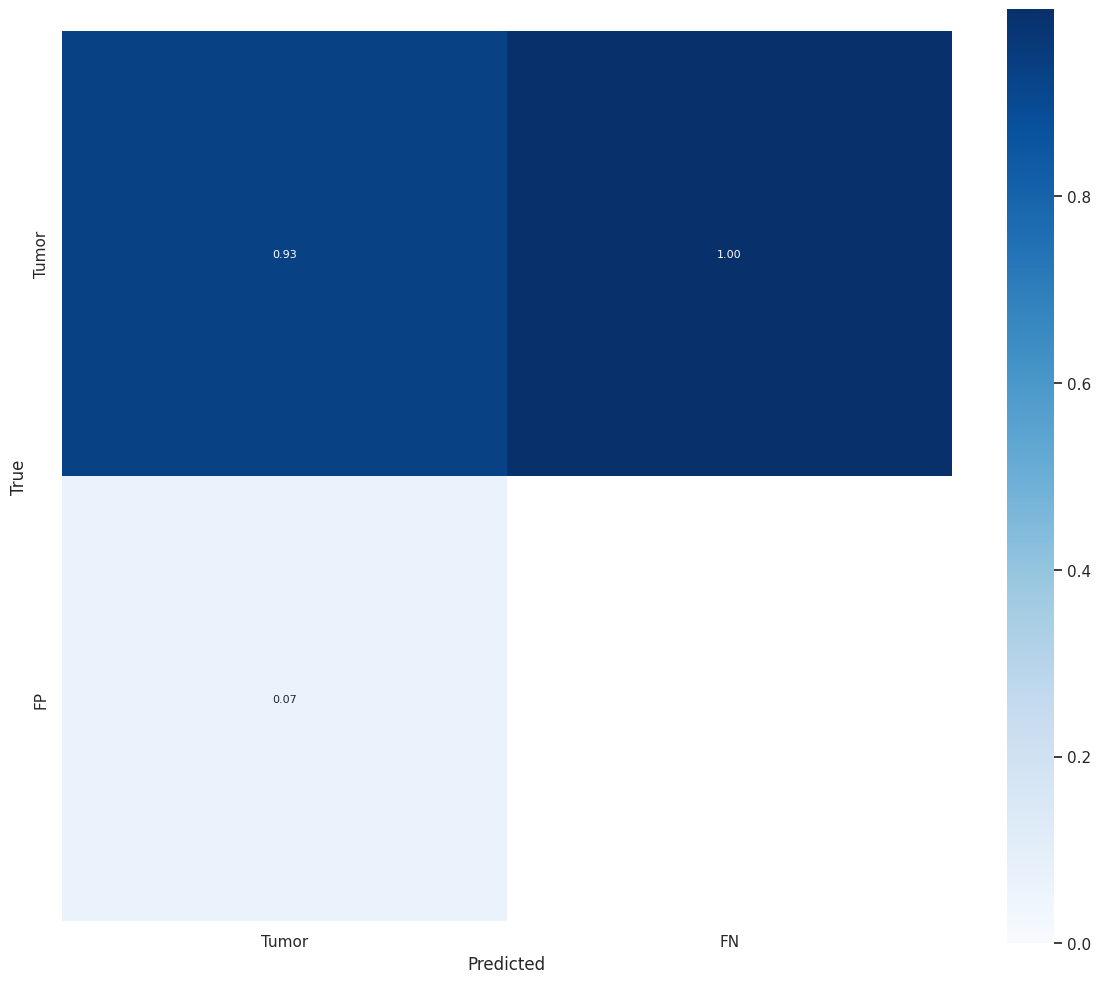

In [ ]:

import os

import numpy as np

from onemetric.cv.object_detection import ConfusionMatrix

keys = list(ds.images.keys())

annotation_batches, prediction_batches = [], []

for key in keys:
    annotation=ds.annotations[key]
    annotation_batch = np.column_stack((
        annotation.xyxy,
        annotation.class_id
    ))
    annotation_batches.append(annotation_batch)

    prediction=predictions[key]
    prediction_batch = np.column_stack((
        prediction.xyxy,
        prediction.class_id,
        prediction.confidence
    ))
    prediction_batches.append(prediction_batch)

confusion_matrix = ConfusionMatrix.from_detections(
    true_batches=annotation_batches,
    detection_batches=prediction_batches,
    num_classes=len(ds.classes),
    conf_threshold=CONFIDENCE_TRESHOLD
)

confusion_matrix.plot(os.path.join("/content", "confusion_matrix.png"), class_names=ds.classes)

In [ ]:
import random
import supervision as sv

random.seed(10)

MAX_IMAGE_COUNT = 5

n = min(MAX_IMAGE_COUNT, len(ds.images))

keys = list(ds.images.keys())
keys = random.sample(keys, n)

box_annotator = sv.BoxAnnotator()

images = []
titles = []

In [ ]:
detections_list = []
prediction_list = []
for key in keys:
    # Para anotações
    annotation_detections = ds.annotations[key]
    for detection in annotation_detections:
        detections_list.append(detection[0])

    # Para previsões
    prediction_detections = predictions[key]
    for prediction in prediction_detections:
        prediction_list.append(prediction[0])

In [ ]:
import numpy as np


def iou(box1, box2):
    # Verifica se as bounding boxes são válidas.
    if box1[2] is None or box2[2] is None:
        return 0.0

    # Calcula as interseções das bounding boxes.
    inter_top = np.maximum(box1[0], box2[0])
    inter_bottom = np.minimum(box1[2], box2[2])
    inter_left = np.maximum(box1[1], box2[1])
    inter_right = np.minimum(box1[3], box2[3])
    inter_area = (inter_right - inter_left) * (inter_bottom - inter_top)

    # Calcula as áreas das bounding boxes.
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])

    # Calcula o IoU.
    iou = inter_area / (box1_area + box2_area - inter_area)

    return iou

for i in range(len(detections_list)):
  iou_score = iou(detections_list[i], prediction_list[i])

  # Imprime o IoU.
  print(iou_score)

0.8873508
0.8898279
0.91539186
0.91630524
0.8592779


In [42]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [43]:
!zip -r /content/YoloNas-L.zip /content/checkpoints/csilab-braintumor-detection/YoloNas-L-32Batch

  adding: content/checkpoints/csilab-braintumor-detection/YoloNas-L-32Batch/ (stored 0%)
  adding: content/checkpoints/csilab-braintumor-detection/YoloNas-L-32Batch/events.out.tfevents.1708732090.d87d79c68158.876.5 (deflated 43%)
  adding: content/checkpoints/csilab-braintumor-detection/YoloNas-L-32Batch/testing.txt (deflated 29%)
  adding: content/checkpoints/csilab-braintumor-detection/YoloNas-L-32Batch/average_model.pth (deflated 7%)
  adding: content/checkpoints/csilab-braintumor-detection/YoloNas-L-32Batch/experiment_logs_Feb23_17_27_08.txt (deflated 79%)
  adding: content/checkpoints/csilab-braintumor-detection/YoloNas-L-32Batch/console_Feb23_17_27_08.txt (deflated 93%)
  adding: content/checkpoints/csilab-braintumor-detection/YoloNas-L-32Batch/events.out.tfevents.1708709228.d87d79c68158.876.4 (deflated 75%)
  adding: content/checkpoints/csilab-braintumor-detection/YoloNas-L-32Batch/ckpt_best.pth (deflated 7%)
  adding: content/checkpoints/csilab-braintumor-detection/YoloNas-L-32

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


In [ ]:
%cp -av "/content/YoloNas.Zip" "/content/drive/MyDrive"